In [10]:
import torch
dtype = torch.double

In [11]:
"""
Construct the Shapes optimization benchmark dataset from Tripp et al.,
Sample-Efficient Optimization in the Latent Space of Deep Generative Models 
via Weighted Retraining, NeurIPS 2020. 
Adapted from: https://github.com/cambridge-mlg/weighted-retraining
"""

from tqdm.auto import trange

from matplotlib import pyplot as plt
import numpy as np

# Hyperparameters from 
# https://arxiv.org/abs/2006.09191

grid_size = 16 # image dimension
min_size = 2
max_size = 10
shuffle_seed = None # Int specifying the shuffle seed
min_col = None # min column to start spanning, shifts rectangles to the left
max_col = None # max column to start spanning
num_replicates = 1 # number of times to replicate each point

# Make all the rectangles
print("Making Dataset")
img_list = []
for rect_height in trange(min_size, max_size + 1):
    for rect_width in [rect_height]:  # Because it is squares only
        for row in range(grid_size - rect_height + 1):

            # Specify which columns to span
            if min_col is None:
                min_col = 0
            if max_col is None:
                max_col = grid_size
            for col in range(min_col, min(grid_size - rect_width + 1, max_col)):
                arr = np.zeros((grid_size, grid_size))
                arr[row : row + rect_height, col : col + rect_width] = np.ones(
                    (rect_height, rect_width)
                )
                # Append the same image multiple times
                for _ in range(num_replicates):
                    img_list.append(arr)

img_array = np.array(img_list)
print(f"Dataset created. Total of {len(img_array)} points")
print(f"Array size {img_array.nbytes / 1e9:.1f} GB")

# Possibly shuffle
if shuffle_seed is not None:
    print("Shuffling!")
    np.random.seed(shuffle_seed)
    np.random.shuffle(img_array)

# Calculate areas
areas = np.sum(img_array, axis=(1, 2)).astype(float)

Making Dataset


  0%|          | 0/9 [00:00<?, ?it/s]

Dataset created. Total of 1149 points
Array size 0.0 GB


Text(0.5, 0.98, 'Example Shapes Images')

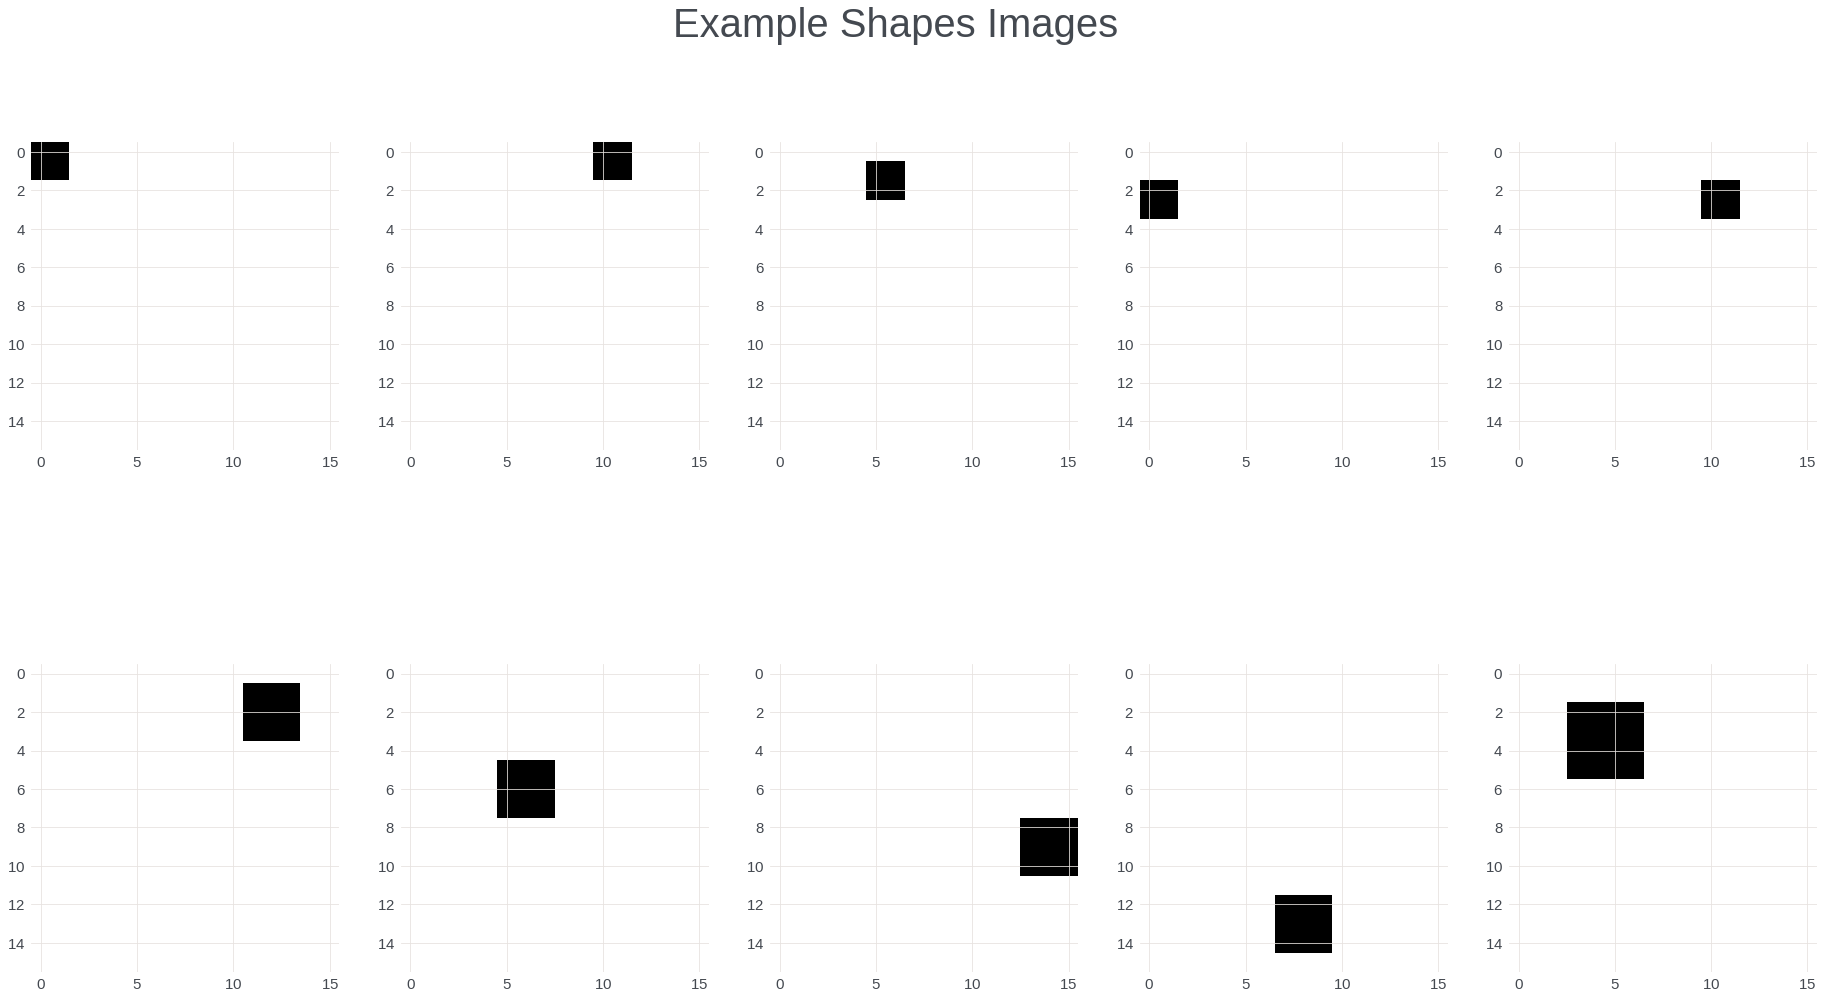

In [12]:
"""
Plot example images from the dataset.
"""

fig, ax = plt.subplots(2, 5, figsize = (32, 16))
ax = ax.reshape(-1)

for i in range(10):
    if i < 5:
        f = ax[i].imshow(img_array[10*i], cmap=plt.cm.gray_r)
    else:
        f = ax[i].imshow(img_array[50*i], cmap=plt.cm.gray_r)

plt.suptitle('Example Shapes Images', fontsize=40)

In [13]:
"""
Define the relative L2-error for the reconstruction of the image data from the low-dimensional PCA embedding.
"""

def rel_l2_error(recons, ground_truth):
    """"Relative L2-error.

    Args: 
        recons: `[b x d]` NumPy array of flattened reconstructions.
        ground_truth: `[b x d]` NumPy array of flattened ground truth images.

    Returns:
        Float specifying the average l2 error across the dataset.
    """

    return np.mean(np.linalg.norm((recons - ground_truth), axis=-1) / np.linalg.norm(ground_truth, axis=-1))

In [14]:
"""
Divide the Shapes dataset into train/test.
"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_array, areas, test_size=0.2, random_state=42)

n_train_data = len(X_train)
n_test_data = len(X_test)
img_dim = len(X_train[0]) # grid_size x grid_size

# Flatten images
X_train = X_train.reshape(n_train_data, img_dim**2)
X_test = X_test.reshape(n_test_data, img_dim**2)

In [15]:
"""
Fit PCA and measure reconstruction error (relative l2 error) on the test set.
"""

import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def round_binary(reconstructions):
    """round reconstructions to binary pixel values.

    Args:
        reconstructions: NumPy array of reconstructions.

    Returns:
        rounded binary-valued array
    """

    reconstructions = reconstructions > 0.5
    reconstructions = reconstructions.astype(float)
    return reconstructions

start_time = time.time()

# Optional standardization (doesn't appear to change much)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

pca_x = PCA(n_components=2, whiten=False)
pca_x.fit(X_train)
recons_x = round_binary(pca_x.inverse_transform(pca_x.transform(X_test)))
test_error = rel_l2_error(recons_x, X_test)

end_time = time.time()
print(f'Runtime is {(end_time - start_time):.2f} seconds')

Runtime is 0.01 seconds


Text(0.5, 0.98, 'Example Shapes Reconstructions')

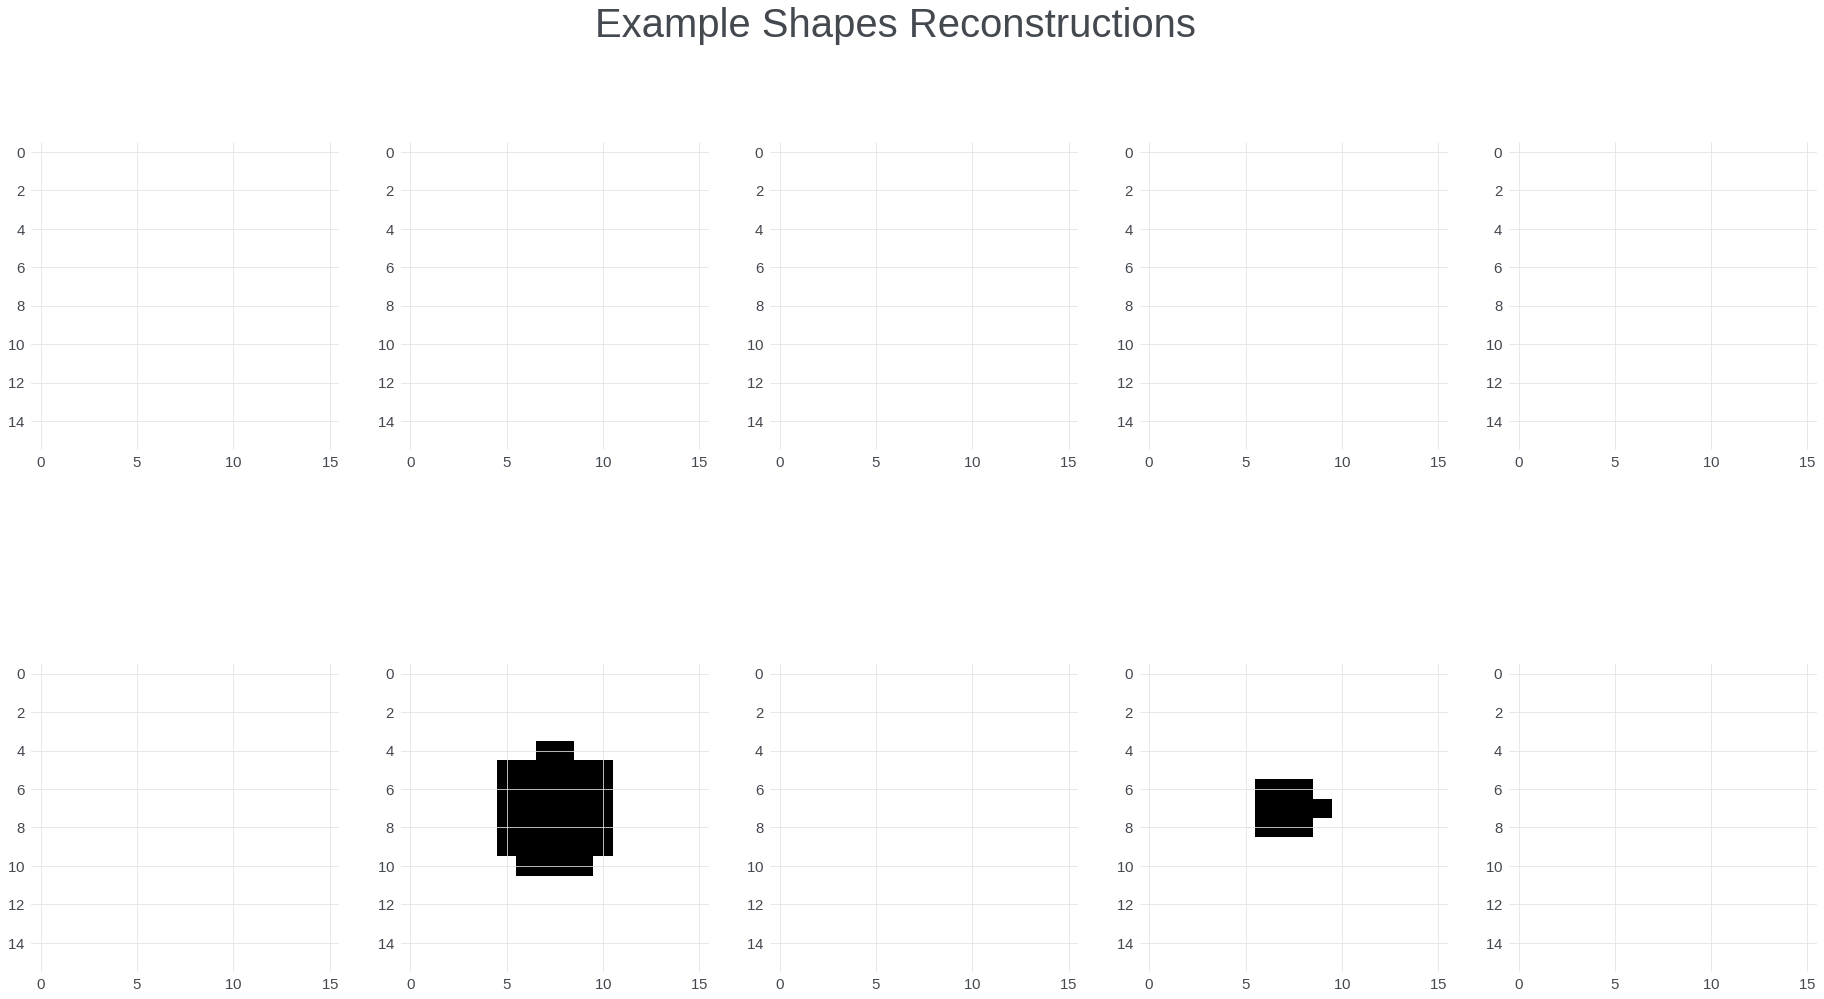

In [16]:
"""
Plot example reconstructions from the PCA fit.
"""

fig, ax = plt.subplots(2, 5, figsize = (32, 16))
ax = ax.reshape(-1)

for i in range(10):
    if i < 5:
        f = ax[i].imshow(recons_x[1*i].reshape(grid_size, grid_size), cmap=plt.cm.gray_r)
    else:
        f = ax[i].imshow(recons_x[5*i].reshape(grid_size, grid_size), cmap=plt.cm.gray_r)

plt.suptitle('Example Shapes Reconstructions', fontsize=40)

In [17]:
print(f'Relative L2 reconstruction error is {100*test_error:.2f}%')

Relative L2 reconstruction error is 93.05%


In [18]:
"""
Define objective function for the Shapes dataset.
"""

from typing import Optional

import torch
from torch import Tensor


def get_pca_inequality_constraints(V: Tensor, bounds: Tensor, mean: Tensor):
    """Compute the inequality constraints for the PCA space given bounds in the ambient space.
       Z @ V = X, where X is the design matrix in the original space, Z is the design matrix
       in PCA space and V is the inverse PCA transform. In scikit's PCA class, this is given as 
       self.components_. For BO bounds should be set large i.e. to [(-1e8, 1e8)] * self.U.shape[0], 
       so as not to artificially constrain the optimizer.

       return value can be used as inequality_constraints in optimize_acqf

    Args:
        V: Tensor - an orthonormal matrix of `pca_dim x original_dim`. Note V is computing using centred data X
        bounds: Tensor - bounds is a `2 x original_dim` tensor of lower and upper bounds
        mean: Tensor - an original_dim-dimensional vector (centering of input data)

    Returns:
        inequality_constraints: List of 3-tuples of length `original_dim` of the form
            [(indices, coeffs, bounds[0, i]), (indices, -coeffs, -bounds[1, i])]
        where indices is a Tensor of ints in the range [0, pca_dim - 1], coeffs is a Tensor of size 2

    """

    bounds = bounds - mean.unsqueeze(dim=0)
    pca_dim = V.shape[0]
    indices = torch.arange(pca_dim)
    inequality_constraints = []

    # Iterate over the original dimensions 
    for i in range(V.shape[1]):
        # [Z @ V][:, i] == (Z @ V[:, i])
        coeffs = V[:, i]  # len(coeffs) == len(indices)
        # this constraints means sum(Z[:, indices] * V[:, i]) >= bounds[0, i], i.e.
        # [Z @ V][:, i] >= bounds[0, i]
        inequality_constraints.append((indices, coeffs, bounds[0, i]))  # lower bounds
        

    for i in range(V.shape[1]):
        coeffs = V[:, i]  # len(coeffs) == len(indices)
        # this constraints means sum(Z[:] * V[:, i]) =< bounds[1, i]
        # [Z @ V][:, i] <= bounds[0, i]
        inequality_constraints.append((indices, -coeffs, -bounds[1, i]))  # upper bounds

    return inequality_constraints

def batch_area(img):
    r"""Define the objective function, the area of the shape

    Args:
        img: `bxdxd` array representing a binary image for the Shapes dataset where d is the image dimension

    Returns:
        a `b`-dim array specfiying the area of the shapes
    """    

    # Sum over everything but the batch dimension to compute the area
    return img.sum(axis=tuple(range(1, img.ndim)))

In [19]:
from botorch.utils.sampling import get_polytope_samples
import itertools


def latent_optimization(pca_model, n_components, inequality_constraints, num_queries_to_do):
    """Embedding space optimization by sampling uniformly from a dense grid in the latent space. 

    Args:
        pca_model: PCA class instance (either PCA or WPCA in practice)
        n_components: Int specifying the number of principle components
        inequality_constraints: List of 3-tuples of length `original_dim` of the form
            [(indices, coeffs, bounds[0, i]), (indices, -coeffs, -bounds[1, i])] 
            where indices is a Tensor of ints in the range [0, pca_dim - 1], coeffs is a Tensor of size 2
        num_queries_to_do: Int specifying how many points to maintain from the polytope sampling i.e.
            num_queries = 1 would correspond to taking the single point from the uniform grid
            that maximizes the objective function and appending it to the training set. num_queries = 2
            would take the top two points etc.
        seed: Int specifying the polytope sampling seed to ensure diversity

    Return:
        new_imgs, new_obj: new shapes images and their areas
    """

    n_samples = 10

    try:
        latent_grid = get_polytope_samples(n_samples, 
                                        bounds=torch.tensor([-1e8, 1e8], dtype=torch.float64).unsqueeze(-1).repeat((1, n_components)), 
                                        inequality_constraints=inequality_constraints,
                                        thinning=32,
                                        n_burnin=10000)
    except(Exception): # Hack in case polytope sampling fails
        latent_grid = torch.zeros((n_samples, n_components))

    # PCA inverse transform and measure area.
    raw_output_imgs = pca_model.inverse_transform(latent_grid.numpy()) + pca_model.mean_.reshape(1, -1)
    output_imgs = round_binary(raw_output_imgs)
    areas = batch_area(output_imgs)
    indices = np.argsort(-1 * areas)  # assuming maximization of property

    # Choose new points
    new_imgs = output_imgs[indices[:num_queries_to_do]]
    new_obj = areas[indices[:num_queries_to_do]]

    return new_imgs, new_obj


def rank_weights(areas: np.array, k_val: float):
    """
    Calculates rank weights assuming maximization.
    Weights are not normalized.

    Args:
        areas: NumPy array of shapes areas (objective function values)
        k_val: Float hyperparameter dictating the degree of weighting
    Returns:
        weights: NumPy array of per-datapoint weights
    """
    if np.isinf(k_val):
        return np.ones_like(areas)
    ranks = np.argsort(np.argsort(-1 * areas))
    weights = 1.0 / (k_val * len(areas) + ranks)
    return weights

def binary_weights(areas: np.array, quantile: float):
    """Binary weights that take on a value of 1 when a datapoint
    has an area in a quantile of the train set values given by `quantile`, and 0 
    otherwise.

    Args:
        areas: NumPy array of shapes areas
        quantile: Float specifying the quantile of training points to weight 1
    Returns:
        weights: NumPy array of weights
    """

    # Find quantile cutoff
    cutoff = np.quantile(areas, quantile)
    weights = (areas >= cutoff).astype(float)
    return weights

In [20]:
"""
Optimization loop 

Method Key:

pca = vanilla PCA-BO no retraining
rpca = PCA-BO with retraining
wpca = PCA-BO with weighted-retraining (implemented by discarded the data points with the lowest function values from the dataset)
"""

import time

# Experiment parameters
N_TRIALS = 3
N_BATCH = 1500
n_components = 2 # Don't set too high or else grid will be huge
num_queries_to_do = 2
num_datapoints_to_throw_away = 2
k_val = 0.001
# Bounds for the original dimensions
bounds = torch.stack((torch.zeros(grid_size**2, dtype=dtype), torch.ones(grid_size**2, dtype=dtype)))

verbose = True

best_observed_all_pca, best_observed_all_rpca, best_observed_all_wpca = [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_pca, best_observed_rpca, best_observed_wpca = [], [], []

    best_value_pca, best_value_rpca, best_value_wpca = 0, 0, 0

    # Form some initial data 
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(img_array, areas, test_size=0.2, random_state=trial)
    y_train_rpca, y_test_rpca = y_train_pca, y_test_pca
    y_train_wpca, y_test_wpca = y_train_pca, y_test_pca

    n_train_data = len(X_train_pca)
    print(f"Number of training points is: {n_train_data}")
    n_test_data = len(X_test_pca)
    img_dim = len(X_train_pca[0]) # grid_size x grid_size

    # Flatten images
    X_train_pca = X_train_pca.reshape(n_train_data, img_dim**2)
    X_test_pca = X_test_pca.reshape(n_test_data, img_dim**2)
    X_train_rpca, X_test_rpca = X_train_pca, X_test_pca
    X_train_wpca, X_test_wpca = X_train_pca, X_test_pca

    # Record the best value in the training set
    best_observed_value_pca, best_observed_value_rpca, best_observed_value_wpca = y_train_pca.max().item(), y_train_pca.max().item(), y_train_pca.max().item()

    print(f'Best area value in train set is {best_observed_value_pca}')

    best_observed_pca.append(best_observed_value_pca)
    best_observed_rpca.append(best_observed_value_rpca)
    best_observed_wpca.append(best_observed_value_wpca)

    # PCA's parameters are computed once because the embedding is static
    pca_x = PCA(n_components=n_components)
    pca_x = pca_x.fit(X_train_pca)
    # Inequality constraints for polytope sampling
    inequality_constraints_pca = get_pca_inequality_constraints(torch.tensor(pca_x.components_, dtype=dtype), bounds, torch.tensor(pca_x.mean_))

    # run N_BATCH rounds of Optimization after the initial random batch
    for iteration in range(1, N_BATCH):    
        
        t0 = time.monotonic()

        rpca_x = PCA(n_components=n_components)
        rpca_x = rpca_x.fit(X_train_rpca)
        # Inequality constraints for polytope sampling
        inequality_constraints_rpca = get_pca_inequality_constraints(torch.tensor(rpca_x.components_, dtype=dtype), bounds, torch.tensor(rpca_x.mean_))

        # for weighted pca we perform weighting by throwing away the worst datapoints
        ranks = np.argsort(np.argsort(y_train_wpca))
        indices = np.where(ranks >= num_datapoints_to_throw_away)
        X_train_wpca = X_train_wpca[indices]
        y_train_wpca = y_train_wpca[indices]
    
        if iteration %5 == 0:
            print(f'\n\nMean area in the PCA dataset is: {np.mean(y_train_pca):.2f}')
            print(f'Mean area in the RPCA dataset is: {np.mean(y_train_rpca):.2f}')
            print(f'Mean area in the WPCA dataset is: {np.mean(y_train_wpca):.2f}')
            print(f'Max area difference is: {np.mean(y_train_wpca) - np.mean(y_train_pca):.2f}')

        wpca_x = PCA(n_components=n_components)
        wpca_x = wpca_x.fit(X_train_wpca)
        # Inequality constraints for polytope sampling
        inequality_constraints_wpca = get_pca_inequality_constraints(torch.tensor(wpca_x.components_, dtype=dtype), bounds, torch.tensor(wpca_x.mean_))

        # optimize and get new observation
        new_imgs_pca, new_obj_pca = latent_optimization(pca_model=pca_x, n_components=n_components, inequality_constraints=inequality_constraints_pca, 
                                                        num_queries_to_do=num_queries_to_do)
        new_imgs_rpca, new_obj_rpca = latent_optimization(pca_model=rpca_x, n_components=n_components, inequality_constraints=inequality_constraints_rpca, 
                                                        num_queries_to_do=num_queries_to_do)
        new_imgs_wpca, new_obj_wpca = latent_optimization(pca_model=wpca_x, n_components=n_components, inequality_constraints=inequality_constraints_wpca, 
                                                        num_queries_to_do=num_queries_to_do)
                
        # update training points
        X_train_pca = np.concatenate((X_train_pca, new_imgs_pca)) # PCA values only stored for reference
        y_train_pca = np.concatenate((y_train_pca, new_obj_pca))

        X_train_rpca = np.concatenate((X_train_rpca, new_imgs_rpca))
        y_train_rpca = np.concatenate((y_train_rpca, new_obj_rpca))

        X_train_wpca = np.concatenate((X_train_wpca, new_imgs_wpca))
        y_train_wpca = np.concatenate((y_train_wpca, new_obj_wpca))

        # Take the best-valued query
        new_obj_pca = new_obj_pca[0]
        new_obj_rpca = new_obj_rpca[0]
        new_obj_wpca = new_obj_wpca[0]

        # update progress
        if new_obj_pca > best_value_pca:
            best_value_pca = new_obj_pca
        best_observed_pca.append(best_value_pca)

        # update progress
        if new_obj_rpca > best_value_rpca:
            best_value_rpca = new_obj_rpca
        best_observed_rpca.append(best_value_rpca)

        # update progress
        if new_obj_wpca > best_value_wpca:
            best_value_wpca = new_obj_wpca
        best_observed_wpca.append(best_value_wpca)

        t1 = time.monotonic()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (pca) = "
                f"{best_value_pca:>4.2f}, "
                f"time = {t1-t0:>4.2f}.", end=""
            )
            print(
                f"\nBatch {iteration:>2}: best_value (rpca) = "
                f"{best_value_rpca:>4.2f}, "
                f"time = {t1-t0:>4.2f}.", end=""
            )
            print(
                f"\nBatch {iteration:>2}: best_value (wpca) = "
                f"{best_value_wpca:>4.2f}, "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_pca.append(best_observed_pca)
    best_observed_all_rpca.append(best_observed_rpca)
    best_observed_all_wpca.append(best_observed_wpca)


Trial  1 of 3 Number of training points is: 919
Best area value in train set is 100.0



Batch  1: best_value (pca) = 89.00, time = 2.68.
Batch  1: best_value (rpca) = 84.00, time = 2.68.
Batch  1: best_value (wpca) = 84.00, time = 2.68.
Batch  2: best_value (pca) = 89.00, time = 2.57.
Batch  2: best_value (rpca) = 89.00, time = 2.57.
Batch  2: best_value (wpca) = 84.00, time = 2.57.
Batch  3: best_value (pca) = 89.00, time = 2.46.
Batch  3: best_value (rpca) = 89.00, time = 2.46.
Batch  3: best_value (wpca) = 84.00, time = 2.46.
Batch  4: best_value (pca) = 89.00, time = 2.49.
Batch  4: best_value (rpca) = 89.00, time = 2.49.
Batch  4: best_value (wpca) = 84.00, time = 2.49.

Mean area in the PCA dataset is: 30.15
Mean area in the RPCA dataset is: 30.14
Mean area in the WPCA dataset is: 30.40
Max area difference is: 0.25



Batch  5: best_value (pca) = 89.00, time = 2.54.
Batch  5: best_value (rpca) = 89.00, time = 2.54.
Batch  5: best_value (wpca) = 85.00, time = 2.54.
Batch  6: best_value (pca) = 89.00, time = 2.56.
Batch  6: best_value (rpca) = 89.00, time = 2.56.
Batch  6: best_value (wpca) = 85.00, time = 2.56.
Batch  7: best_value (pca) = 89.00, time = 2.45.
Batch  7: best_value (rpca) = 89.00, time = 2.45.
Batch  7: best_value (wpca) = 85.00, time = 2.45.
Batch  8: best_value (pca) = 89.00, time = 2.42.
Batch  8: best_value (rpca) = 89.00, time = 2.42.
Batch  8: best_value (wpca) = 85.00, time = 2.42.
Batch  9: best_value (pca) = 89.00, time = 2.52.
Batch  9: best_value (rpca) = 89.00, time = 2.52.
Batch  9: best_value (wpca) = 86.00, time = 2.52.

Mean area in the PCA dataset is: 30.71
Mean area in the RPCA dataset is: 30.70
Mean area in the WPCA dataset is: 31.26
Max area difference is: 0.55



Batch 10: best_value (pca) = 89.00, time = 2.48.
Batch 10: best_value (rpca) = 89.00, time = 2.48.
Batch 10: best_value (wpca) = 86.00, time = 2.48.
Batch 11: best_value (pca) = 89.00, time = 2.50.
Batch 11: best_value (rpca) = 89.00, time = 2.50.
Batch 11: best_value (wpca) = 86.00, time = 2.50.
Batch 12: best_value (pca) = 89.00, time = 2.49.
Batch 12: best_value (rpca) = 89.00, time = 2.49.
Batch 12: best_value (wpca) = 86.00, time = 2.49.
Batch 13: best_value (pca) = 89.00, time = 2.48.
Batch 13: best_value (rpca) = 89.00, time = 2.48.
Batch 13: best_value (wpca) = 86.00, time = 2.48.
Batch 14: best_value (pca) = 89.00, time = 2.41.
Batch 14: best_value (rpca) = 89.00, time = 2.41.
Batch 14: best_value (wpca) = 86.00, time = 2.41.

Mean area in the PCA dataset is: 31.26
Mean area in the RPCA dataset is: 31.26
Mean area in the WPCA dataset is: 32.10
Max area difference is: 0.85



Batch 15: best_value (pca) = 89.00, time = 2.47.
Batch 15: best_value (rpca) = 89.00, time = 2.47.
Batch 15: best_value (wpca) = 87.00, time = 2.47.
Batch 16: best_value (pca) = 89.00, time = 2.42.
Batch 16: best_value (rpca) = 89.00, time = 2.42.
Batch 16: best_value (wpca) = 87.00, time = 2.42.
Batch 17: best_value (pca) = 89.00, time = 2.44.
Batch 17: best_value (rpca) = 89.00, time = 2.44.
Batch 17: best_value (wpca) = 87.00, time = 2.44.
Batch 18: best_value (pca) = 89.00, time = 2.44.
Batch 18: best_value (rpca) = 89.00, time = 2.44.
Batch 18: best_value (wpca) = 87.00, time = 2.44.
Batch 19: best_value (pca) = 89.00, time = 2.51.
Batch 19: best_value (rpca) = 89.00, time = 2.51.
Batch 19: best_value (wpca) = 87.00, time = 2.51.

Mean area in the PCA dataset is: 31.81
Mean area in the RPCA dataset is: 31.80
Mean area in the WPCA dataset is: 32.95
Max area difference is: 1.14



Batch 20: best_value (pca) = 89.00, time = 2.44.
Batch 20: best_value (rpca) = 89.00, time = 2.44.
Batch 20: best_value (wpca) = 87.00, time = 2.44.
Batch 21: best_value (pca) = 89.00, time = 2.51.
Batch 21: best_value (rpca) = 89.00, time = 2.51.
Batch 21: best_value (wpca) = 87.00, time = 2.51.
Batch 22: best_value (pca) = 89.00, time = 2.49.
Batch 22: best_value (rpca) = 89.00, time = 2.49.
Batch 22: best_value (wpca) = 87.00, time = 2.49.
Batch 23: best_value (pca) = 89.00, time = 2.45.
Batch 23: best_value (rpca) = 89.00, time = 2.45.
Batch 23: best_value (wpca) = 87.00, time = 2.45.
Batch 24: best_value (pca) = 89.00, time = 2.60.
Batch 24: best_value (rpca) = 89.00, time = 2.60.
Batch 24: best_value (wpca) = 87.00, time = 2.60.

Mean area in the PCA dataset is: 32.24
Mean area in the RPCA dataset is: 32.35
Mean area in the WPCA dataset is: 33.83
Max area difference is: 1.59



Batch 25: best_value (pca) = 89.00, time = 2.61.
Batch 25: best_value (rpca) = 89.00, time = 2.61.
Batch 25: best_value (wpca) = 87.00, time = 2.61.
Batch 26: best_value (pca) = 90.00, time = 2.59.
Batch 26: best_value (rpca) = 89.00, time = 2.59.
Batch 26: best_value (wpca) = 87.00, time = 2.59.
Batch 27: best_value (pca) = 90.00, time = 2.51.
Batch 27: best_value (rpca) = 89.00, time = 2.51.
Batch 27: best_value (wpca) = 87.00, time = 2.51.
Batch 28: best_value (pca) = 90.00, time = 2.55.
Batch 28: best_value (rpca) = 89.00, time = 2.55.
Batch 28: best_value (wpca) = 87.00, time = 2.55.
Batch 29: best_value (pca) = 90.00, time = 2.56.
Batch 29: best_value (rpca) = 89.00, time = 2.56.
Batch 29: best_value (wpca) = 87.00, time = 2.56.

Mean area in the PCA dataset is: 32.69
Mean area in the RPCA dataset is: 32.87
Mean area in the WPCA dataset is: 34.71
Max area difference is: 2.02



Batch 30: best_value (pca) = 90.00, time = 2.47.
Batch 30: best_value (rpca) = 89.00, time = 2.47.
Batch 30: best_value (wpca) = 87.00, time = 2.47.
Batch 31: best_value (pca) = 90.00, time = 2.51.
Batch 31: best_value (rpca) = 89.00, time = 2.51.
Batch 31: best_value (wpca) = 87.00, time = 2.51.
Batch 32: best_value (pca) = 90.00, time = 2.47.
Batch 32: best_value (rpca) = 89.00, time = 2.47.
Batch 32: best_value (wpca) = 87.00, time = 2.47.
Batch 33: best_value (pca) = 90.00, time = 2.59.
Batch 33: best_value (rpca) = 89.00, time = 2.59.
Batch 33: best_value (wpca) = 87.00, time = 2.59.
Batch 34: best_value (pca) = 90.00, time = 2.51.
Batch 34: best_value (rpca) = 89.00, time = 2.51.
Batch 34: best_value (wpca) = 87.00, time = 2.51.

Mean area in the PCA dataset is: 33.17
Mean area in the RPCA dataset is: 33.38
Mean area in the WPCA dataset is: 35.59
Max area difference is: 2.42



Batch 35: best_value (pca) = 90.00, time = 2.62.
Batch 35: best_value (rpca) = 89.00, time = 2.62.
Batch 35: best_value (wpca) = 87.00, time = 2.62.
Batch 36: best_value (pca) = 90.00, time = 2.63.
Batch 36: best_value (rpca) = 89.00, time = 2.63.
Batch 36: best_value (wpca) = 87.00, time = 2.63.
Batch 37: best_value (pca) = 90.00, time = 2.62.
Batch 37: best_value (rpca) = 89.00, time = 2.62.
Batch 37: best_value (wpca) = 87.00, time = 2.62.
Batch 38: best_value (pca) = 90.00, time = 2.58.
Batch 38: best_value (rpca) = 89.00, time = 2.58.
Batch 38: best_value (wpca) = 87.00, time = 2.58.
Batch 39: best_value (pca) = 90.00, time = 2.58.
Batch 39: best_value (rpca) = 89.00, time = 2.58.
Batch 39: best_value (wpca) = 87.00, time = 2.58.

Mean area in the PCA dataset is: 33.67
Mean area in the RPCA dataset is: 33.90
Mean area in the WPCA dataset is: 36.48
Max area difference is: 2.80



Batch 40: best_value (pca) = 90.00, time = 2.46.
Batch 40: best_value (rpca) = 89.00, time = 2.46.
Batch 40: best_value (wpca) = 87.00, time = 2.46.
Batch 41: best_value (pca) = 90.00, time = 2.56.
Batch 41: best_value (rpca) = 89.00, time = 2.56.
Batch 41: best_value (wpca) = 87.00, time = 2.56.
Batch 42: best_value (pca) = 90.00, time = 2.50.
Batch 42: best_value (rpca) = 89.00, time = 2.50.
Batch 42: best_value (wpca) = 87.00, time = 2.50.
Batch 43: best_value (pca) = 90.00, time = 2.52.
Batch 43: best_value (rpca) = 89.00, time = 2.52.
Batch 43: best_value (wpca) = 87.00, time = 2.52.
Batch 44: best_value (pca) = 90.00, time = 2.50.
Batch 44: best_value (rpca) = 89.00, time = 2.50.
Batch 44: best_value (wpca) = 87.00, time = 2.50.

Mean area in the PCA dataset is: 34.10
Mean area in the RPCA dataset is: 34.37
Mean area in the WPCA dataset is: 37.36
Max area difference is: 3.26



Batch 45: best_value (pca) = 90.00, time = 2.49.
Batch 45: best_value (rpca) = 89.00, time = 2.49.
Batch 45: best_value (wpca) = 87.00, time = 2.49.
Batch 46: best_value (pca) = 90.00, time = 2.49.
Batch 46: best_value (rpca) = 89.00, time = 2.49.
Batch 46: best_value (wpca) = 87.00, time = 2.49.
Batch 47: best_value (pca) = 90.00, time = 2.54.
Batch 47: best_value (rpca) = 89.00, time = 2.54.
Batch 47: best_value (wpca) = 87.00, time = 2.54.
Batch 48: best_value (pca) = 90.00, time = 2.62.
Batch 48: best_value (rpca) = 89.00, time = 2.62.
Batch 48: best_value (wpca) = 87.00, time = 2.62.
Batch 49: best_value (pca) = 90.00, time = 2.63.
Batch 49: best_value (rpca) = 89.00, time = 2.63.
Batch 49: best_value (wpca) = 87.00, time = 2.63.

Mean area in the PCA dataset is: 34.50
Mean area in the RPCA dataset is: 34.86
Mean area in the WPCA dataset is: 38.24
Max area difference is: 3.74



Batch 50: best_value (pca) = 90.00, time = 2.59.
Batch 50: best_value (rpca) = 89.00, time = 2.59.
Batch 50: best_value (wpca) = 87.00, time = 2.59.
Batch 51: best_value (pca) = 90.00, time = 2.51.
Batch 51: best_value (rpca) = 89.00, time = 2.51.
Batch 51: best_value (wpca) = 87.00, time = 2.51.
Batch 52: best_value (pca) = 90.00, time = 2.60.
Batch 52: best_value (rpca) = 89.00, time = 2.60.
Batch 52: best_value (wpca) = 87.00, time = 2.60.
Batch 53: best_value (pca) = 90.00, time = 2.52.
Batch 53: best_value (rpca) = 89.00, time = 2.52.
Batch 53: best_value (wpca) = 87.00, time = 2.52.
Batch 54: best_value (pca) = 90.00, time = 2.49.
Batch 54: best_value (rpca) = 89.00, time = 2.49.
Batch 54: best_value (wpca) = 87.00, time = 2.49.

Mean area in the PCA dataset is: 34.97
Mean area in the RPCA dataset is: 35.34
Mean area in the WPCA dataset is: 39.11
Max area difference is: 4.14



Batch 55: best_value (pca) = 90.00, time = 2.40.
Batch 55: best_value (rpca) = 89.00, time = 2.40.
Batch 55: best_value (wpca) = 87.00, time = 2.40.
Batch 56: best_value (pca) = 90.00, time = 2.46.
Batch 56: best_value (rpca) = 89.00, time = 2.46.
Batch 56: best_value (wpca) = 87.00, time = 2.46.
Batch 57: best_value (pca) = 90.00, time = 2.50.
Batch 57: best_value (rpca) = 89.00, time = 2.50.
Batch 57: best_value (wpca) = 87.00, time = 2.50.
Batch 58: best_value (pca) = 90.00, time = 2.47.
Batch 58: best_value (rpca) = 89.00, time = 2.47.
Batch 58: best_value (wpca) = 87.00, time = 2.47.
Batch 59: best_value (pca) = 90.00, time = 2.44.
Batch 59: best_value (rpca) = 89.00, time = 2.44.
Batch 59: best_value (wpca) = 87.00, time = 2.44.

Mean area in the PCA dataset is: 35.43
Mean area in the RPCA dataset is: 35.81
Mean area in the WPCA dataset is: 40.00
Max area difference is: 4.56



Batch 60: best_value (pca) = 90.00, time = 2.51.
Batch 60: best_value (rpca) = 89.00, time = 2.51.
Batch 60: best_value (wpca) = 87.00, time = 2.51.
Batch 61: best_value (pca) = 90.00, time = 2.49.
Batch 61: best_value (rpca) = 89.00, time = 2.49.
Batch 61: best_value (wpca) = 87.00, time = 2.49.
Batch 62: best_value (pca) = 90.00, time = 2.50.
Batch 62: best_value (rpca) = 89.00, time = 2.50.
Batch 62: best_value (wpca) = 87.00, time = 2.50.
Batch 63: best_value (pca) = 90.00, time = 2.48.
Batch 63: best_value (rpca) = 89.00, time = 2.48.
Batch 63: best_value (wpca) = 87.00, time = 2.48.
Batch 64: best_value (pca) = 90.00, time = 2.48.
Batch 64: best_value (rpca) = 89.00, time = 2.48.
Batch 64: best_value (wpca) = 87.00, time = 2.48.

Mean area in the PCA dataset is: 35.84
Mean area in the RPCA dataset is: 36.27
Mean area in the WPCA dataset is: 40.88
Max area difference is: 5.04



Batch 65: best_value (pca) = 90.00, time = 2.53.
Batch 65: best_value (rpca) = 89.00, time = 2.53.
Batch 65: best_value (wpca) = 87.00, time = 2.53.
Batch 66: best_value (pca) = 90.00, time = 2.55.
Batch 66: best_value (rpca) = 89.00, time = 2.55.
Batch 66: best_value (wpca) = 87.00, time = 2.55.
Batch 67: best_value (pca) = 90.00, time = 2.51.
Batch 67: best_value (rpca) = 89.00, time = 2.51.
Batch 67: best_value (wpca) = 87.00, time = 2.51.
Batch 68: best_value (pca) = 90.00, time = 2.50.
Batch 68: best_value (rpca) = 89.00, time = 2.50.
Batch 68: best_value (wpca) = 87.00, time = 2.50.
Batch 69: best_value (pca) = 90.00, time = 2.47.
Batch 69: best_value (rpca) = 89.00, time = 2.47.
Batch 69: best_value (wpca) = 87.00, time = 2.47.

Mean area in the PCA dataset is: 36.25
Mean area in the RPCA dataset is: 36.72
Mean area in the WPCA dataset is: 41.76
Max area difference is: 5.52



Batch 70: best_value (pca) = 90.00, time = 2.43.
Batch 70: best_value (rpca) = 89.00, time = 2.43.
Batch 70: best_value (wpca) = 87.00, time = 2.43.
Batch 71: best_value (pca) = 90.00, time = 2.57.
Batch 71: best_value (rpca) = 89.00, time = 2.57.
Batch 71: best_value (wpca) = 87.00, time = 2.57.
Batch 72: best_value (pca) = 90.00, time = 2.58.
Batch 72: best_value (rpca) = 89.00, time = 2.58.
Batch 72: best_value (wpca) = 87.00, time = 2.58.
Batch 73: best_value (pca) = 90.00, time = 2.56.
Batch 73: best_value (rpca) = 89.00, time = 2.56.
Batch 73: best_value (wpca) = 87.00, time = 2.56.
Batch 74: best_value (pca) = 90.00, time = 2.74.
Batch 74: best_value (rpca) = 89.00, time = 2.74.
Batch 74: best_value (wpca) = 87.00, time = 2.74.

Mean area in the PCA dataset is: 36.63
Mean area in the RPCA dataset is: 37.16
Mean area in the WPCA dataset is: 42.65
Max area difference is: 6.02



Batch 75: best_value (pca) = 90.00, time = 2.50.
Batch 75: best_value (rpca) = 89.00, time = 2.50.
Batch 75: best_value (wpca) = 87.00, time = 2.50.
Batch 76: best_value (pca) = 90.00, time = 2.61.
Batch 76: best_value (rpca) = 89.00, time = 2.61.
Batch 76: best_value (wpca) = 87.00, time = 2.61.
Batch 77: best_value (pca) = 90.00, time = 2.45.
Batch 77: best_value (rpca) = 89.00, time = 2.45.
Batch 77: best_value (wpca) = 87.00, time = 2.45.
Batch 78: best_value (pca) = 90.00, time = 2.44.
Batch 78: best_value (rpca) = 89.00, time = 2.44.
Batch 78: best_value (wpca) = 87.00, time = 2.44.
Batch 79: best_value (pca) = 90.00, time = 2.52.
Batch 79: best_value (rpca) = 89.00, time = 2.52.
Batch 79: best_value (wpca) = 87.00, time = 2.52.

Mean area in the PCA dataset is: 37.07
Mean area in the RPCA dataset is: 37.60
Mean area in the WPCA dataset is: 43.53
Max area difference is: 6.46



Batch 80: best_value (pca) = 90.00, time = 2.51.
Batch 80: best_value (rpca) = 89.00, time = 2.51.
Batch 80: best_value (wpca) = 87.00, time = 2.51.
Batch 81: best_value (pca) = 90.00, time = 2.48.
Batch 81: best_value (rpca) = 89.00, time = 2.48.
Batch 81: best_value (wpca) = 87.00, time = 2.48.
Batch 82: best_value (pca) = 90.00, time = 2.51.
Batch 82: best_value (rpca) = 89.00, time = 2.51.
Batch 82: best_value (wpca) = 87.00, time = 2.51.
Batch 83: best_value (pca) = 90.00, time = 2.49.
Batch 83: best_value (rpca) = 89.00, time = 2.49.
Batch 83: best_value (wpca) = 87.00, time = 2.49.
Batch 84: best_value (pca) = 90.00, time = 2.45.
Batch 84: best_value (rpca) = 89.00, time = 2.45.
Batch 84: best_value (wpca) = 87.00, time = 2.45.

Mean area in the PCA dataset is: 37.47
Mean area in the RPCA dataset is: 38.03
Mean area in the WPCA dataset is: 44.41
Max area difference is: 6.94



Batch 85: best_value (pca) = 90.00, time = 2.38.
Batch 85: best_value (rpca) = 89.00, time = 2.38.
Batch 85: best_value (wpca) = 87.00, time = 2.38.
Batch 86: best_value (pca) = 90.00, time = 2.48.
Batch 86: best_value (rpca) = 89.00, time = 2.48.
Batch 86: best_value (wpca) = 87.00, time = 2.48.
Batch 87: best_value (pca) = 90.00, time = 2.46.
Batch 87: best_value (rpca) = 89.00, time = 2.46.
Batch 87: best_value (wpca) = 87.00, time = 2.46.
Batch 88: best_value (pca) = 90.00, time = 2.47.
Batch 88: best_value (rpca) = 89.00, time = 2.47.
Batch 88: best_value (wpca) = 87.00, time = 2.47.
Batch 89: best_value (pca) = 90.00, time = 2.38.
Batch 89: best_value (rpca) = 89.00, time = 2.38.
Batch 89: best_value (wpca) = 87.00, time = 2.38.

Mean area in the PCA dataset is: 37.86
Mean area in the RPCA dataset is: 38.44
Mean area in the WPCA dataset is: 45.25
Max area difference is: 7.39



Batch 90: best_value (pca) = 90.00, time = 2.41.
Batch 90: best_value (rpca) = 89.00, time = 2.41.
Batch 90: best_value (wpca) = 87.00, time = 2.41.
Batch 91: best_value (pca) = 90.00, time = 2.52.
Batch 91: best_value (rpca) = 89.00, time = 2.52.
Batch 91: best_value (wpca) = 87.00, time = 2.52.
Batch 92: best_value (pca) = 90.00, time = 2.42.
Batch 92: best_value (rpca) = 89.00, time = 2.42.
Batch 92: best_value (wpca) = 87.00, time = 2.42.
Batch 93: best_value (pca) = 90.00, time = 2.52.
Batch 93: best_value (rpca) = 89.00, time = 2.52.
Batch 93: best_value (wpca) = 87.00, time = 2.52.
Batch 94: best_value (pca) = 90.00, time = 2.48.
Batch 94: best_value (rpca) = 89.00, time = 2.48.
Batch 94: best_value (wpca) = 87.00, time = 2.48.

Mean area in the PCA dataset is: 38.26
Mean area in the RPCA dataset is: 38.86
Mean area in the WPCA dataset is: 46.08
Max area difference is: 7.82



Batch 95: best_value (pca) = 90.00, time = 2.52.
Batch 95: best_value (rpca) = 89.00, time = 2.52.
Batch 95: best_value (wpca) = 87.00, time = 2.52.
Batch 96: best_value (pca) = 90.00, time = 2.57.
Batch 96: best_value (rpca) = 89.00, time = 2.57.
Batch 96: best_value (wpca) = 87.00, time = 2.57.
Batch 97: best_value (pca) = 90.00, time = 2.59.
Batch 97: best_value (rpca) = 89.00, time = 2.59.
Batch 97: best_value (wpca) = 87.00, time = 2.59.
Batch 98: best_value (pca) = 90.00, time = 2.63.
Batch 98: best_value (rpca) = 89.00, time = 2.63.
Batch 98: best_value (wpca) = 87.00, time = 2.63.
Batch 99: best_value (pca) = 90.00, time = 2.41.
Batch 99: best_value (rpca) = 89.00, time = 2.41.
Batch 99: best_value (wpca) = 87.00, time = 2.41.

Mean area in the PCA dataset is: 38.65
Mean area in the RPCA dataset is: 39.26
Mean area in the WPCA dataset is: 46.91
Max area difference is: 8.26



Batch 100: best_value (pca) = 90.00, time = 2.49.
Batch 100: best_value (rpca) = 89.00, time = 2.49.
Batch 100: best_value (wpca) = 87.00, time = 2.49.
Batch 101: best_value (pca) = 90.00, time = 2.54.
Batch 101: best_value (rpca) = 89.00, time = 2.54.
Batch 101: best_value (wpca) = 87.00, time = 2.54.
Batch 102: best_value (pca) = 90.00, time = 2.55.
Batch 102: best_value (rpca) = 89.00, time = 2.55.
Batch 102: best_value (wpca) = 87.00, time = 2.55.
Batch 103: best_value (pca) = 90.00, time = 2.42.
Batch 103: best_value (rpca) = 89.00, time = 2.42.
Batch 103: best_value (wpca) = 87.00, time = 2.42.
Batch 104: best_value (pca) = 90.00, time = 2.43.
Batch 104: best_value (rpca) = 89.00, time = 2.43.
Batch 104: best_value (wpca) = 87.00, time = 2.43.

Mean area in the PCA dataset is: 39.04
Mean area in the RPCA dataset is: 39.66
Mean area in the WPCA dataset is: 47.74
Max area difference is: 8.70



Batch 105: best_value (pca) = 90.00, time = 2.50.
Batch 105: best_value (rpca) = 89.00, time = 2.50.
Batch 105: best_value (wpca) = 87.00, time = 2.50.
Batch 106: best_value (pca) = 90.00, time = 2.49.
Batch 106: best_value (rpca) = 89.00, time = 2.49.
Batch 106: best_value (wpca) = 87.00, time = 2.49.
Batch 107: best_value (pca) = 90.00, time = 2.48.
Batch 107: best_value (rpca) = 89.00, time = 2.48.
Batch 107: best_value (wpca) = 87.00, time = 2.48.
Batch 108: best_value (pca) = 90.00, time = 2.50.
Batch 108: best_value (rpca) = 89.00, time = 2.50.
Batch 108: best_value (wpca) = 87.00, time = 2.50.
Batch 109: best_value (pca) = 92.00, time = 2.42.
Batch 109: best_value (rpca) = 89.00, time = 2.42.
Batch 109: best_value (wpca) = 87.00, time = 2.42.

Mean area in the PCA dataset is: 39.41
Mean area in the RPCA dataset is: 40.05
Mean area in the WPCA dataset is: 48.57
Max area difference is: 9.16



Batch 110: best_value (pca) = 92.00, time = 2.43.
Batch 110: best_value (rpca) = 89.00, time = 2.43.
Batch 110: best_value (wpca) = 87.00, time = 2.43.
Batch 111: best_value (pca) = 92.00, time = 2.46.
Batch 111: best_value (rpca) = 89.00, time = 2.46.
Batch 111: best_value (wpca) = 87.00, time = 2.46.
Batch 112: best_value (pca) = 92.00, time = 2.41.
Batch 112: best_value (rpca) = 89.00, time = 2.41.
Batch 112: best_value (wpca) = 87.00, time = 2.41.
Batch 113: best_value (pca) = 92.00, time = 2.39.
Batch 113: best_value (rpca) = 89.00, time = 2.39.
Batch 113: best_value (wpca) = 87.00, time = 2.39.
Batch 114: best_value (pca) = 92.00, time = 2.45.
Batch 114: best_value (rpca) = 89.00, time = 2.45.
Batch 114: best_value (wpca) = 87.00, time = 2.45.

Mean area in the PCA dataset is: 39.74
Mean area in the RPCA dataset is: 40.43
Mean area in the WPCA dataset is: 49.40
Max area difference is: 9.66



Batch 115: best_value (pca) = 92.00, time = 2.46.
Batch 115: best_value (rpca) = 89.00, time = 2.46.
Batch 115: best_value (wpca) = 87.00, time = 2.46.
Batch 116: best_value (pca) = 92.00, time = 2.50.
Batch 116: best_value (rpca) = 89.00, time = 2.50.
Batch 116: best_value (wpca) = 87.00, time = 2.50.
Batch 117: best_value (pca) = 92.00, time = 2.42.
Batch 117: best_value (rpca) = 89.00, time = 2.42.
Batch 117: best_value (wpca) = 87.00, time = 2.42.
Batch 118: best_value (pca) = 92.00, time = 2.41.
Batch 118: best_value (rpca) = 89.00, time = 2.41.
Batch 118: best_value (wpca) = 87.00, time = 2.41.
Batch 119: best_value (pca) = 92.00, time = 2.47.
Batch 119: best_value (rpca) = 89.00, time = 2.47.
Batch 119: best_value (wpca) = 87.00, time = 2.47.

Mean area in the PCA dataset is: 40.08
Mean area in the RPCA dataset is: 40.81
Mean area in the WPCA dataset is: 50.23
Max area difference is: 10.15



Batch 120: best_value (pca) = 92.00, time = 2.62.
Batch 120: best_value (rpca) = 89.00, time = 2.62.
Batch 120: best_value (wpca) = 87.00, time = 2.62.
Batch 121: best_value (pca) = 92.00, time = 2.56.
Batch 121: best_value (rpca) = 89.00, time = 2.56.
Batch 121: best_value (wpca) = 87.00, time = 2.56.
Batch 122: best_value (pca) = 92.00, time = 2.50.
Batch 122: best_value (rpca) = 89.00, time = 2.50.
Batch 122: best_value (wpca) = 87.00, time = 2.50.
Batch 123: best_value (pca) = 92.00, time = 2.48.
Batch 123: best_value (rpca) = 89.00, time = 2.48.
Batch 123: best_value (wpca) = 87.00, time = 2.48.
Batch 124: best_value (pca) = 92.00, time = 2.53.
Batch 124: best_value (rpca) = 89.00, time = 2.53.
Batch 124: best_value (wpca) = 87.00, time = 2.53.

Mean area in the PCA dataset is: 40.44
Mean area in the RPCA dataset is: 41.18
Mean area in the WPCA dataset is: 51.05
Max area difference is: 10.62



Batch 125: best_value (pca) = 92.00, time = 2.45.
Batch 125: best_value (rpca) = 89.00, time = 2.45.
Batch 125: best_value (wpca) = 87.00, time = 2.45.
Batch 126: best_value (pca) = 92.00, time = 2.48.
Batch 126: best_value (rpca) = 89.00, time = 2.48.
Batch 126: best_value (wpca) = 87.00, time = 2.48.
Batch 127: best_value (pca) = 92.00, time = 2.43.
Batch 127: best_value (rpca) = 89.00, time = 2.43.
Batch 127: best_value (wpca) = 87.00, time = 2.43.
Batch 128: best_value (pca) = 92.00, time = 2.43.
Batch 128: best_value (rpca) = 89.00, time = 2.43.
Batch 128: best_value (wpca) = 87.00, time = 2.43.
Batch 129: best_value (pca) = 92.00, time = 2.51.
Batch 129: best_value (rpca) = 89.00, time = 2.51.
Batch 129: best_value (wpca) = 87.00, time = 2.51.

Mean area in the PCA dataset is: 40.76
Mean area in the RPCA dataset is: 41.54
Mean area in the WPCA dataset is: 51.88
Max area difference is: 11.13



Batch 130: best_value (pca) = 92.00, time = 2.46.
Batch 130: best_value (rpca) = 89.00, time = 2.46.
Batch 130: best_value (wpca) = 87.00, time = 2.46.
Batch 131: best_value (pca) = 92.00, time = 2.50.
Batch 131: best_value (rpca) = 89.00, time = 2.50.
Batch 131: best_value (wpca) = 87.00, time = 2.50.
Batch 132: best_value (pca) = 92.00, time = 2.52.
Batch 132: best_value (rpca) = 89.00, time = 2.52.
Batch 132: best_value (wpca) = 87.00, time = 2.52.
Batch 133: best_value (pca) = 92.00, time = 1.68.
Batch 133: best_value (rpca) = 89.00, time = 1.68.
Batch 133: best_value (wpca) = 87.00, time = 1.68.
Batch 134: best_value (pca) = 92.00, time = 2.40.
Batch 134: best_value (rpca) = 89.00, time = 2.40.
Batch 134: best_value (wpca) = 87.00, time = 2.40.

Mean area in the PCA dataset is: 41.10
Mean area in the RPCA dataset is: 41.90
Mean area in the WPCA dataset is: 52.71
Max area difference is: 11.61



Batch 135: best_value (pca) = 92.00, time = 2.44.
Batch 135: best_value (rpca) = 89.00, time = 2.44.
Batch 135: best_value (wpca) = 87.00, time = 2.44.
Batch 136: best_value (pca) = 92.00, time = 2.43.
Batch 136: best_value (rpca) = 89.00, time = 2.43.
Batch 136: best_value (wpca) = 87.00, time = 2.43.
Batch 137: best_value (pca) = 92.00, time = 2.41.
Batch 137: best_value (rpca) = 89.00, time = 2.41.
Batch 137: best_value (wpca) = 87.00, time = 2.41.
Batch 138: best_value (pca) = 92.00, time = 2.38.
Batch 138: best_value (rpca) = 89.00, time = 2.38.
Batch 138: best_value (wpca) = 87.00, time = 2.38.
Batch 139: best_value (pca) = 92.00, time = 2.42.
Batch 139: best_value (rpca) = 89.00, time = 2.42.
Batch 139: best_value (wpca) = 87.00, time = 2.42.

Mean area in the PCA dataset is: 41.45
Mean area in the RPCA dataset is: 42.25
Mean area in the WPCA dataset is: 53.54
Max area difference is: 12.09



Batch 140: best_value (pca) = 92.00, time = 2.47.
Batch 140: best_value (rpca) = 89.00, time = 2.47.
Batch 140: best_value (wpca) = 87.00, time = 2.47.
Batch 141: best_value (pca) = 92.00, time = 2.51.
Batch 141: best_value (rpca) = 89.00, time = 2.51.
Batch 141: best_value (wpca) = 87.00, time = 2.51.
Batch 142: best_value (pca) = 92.00, time = 2.40.
Batch 142: best_value (rpca) = 89.00, time = 2.40.
Batch 142: best_value (wpca) = 87.00, time = 2.40.
Batch 143: best_value (pca) = 92.00, time = 2.44.
Batch 143: best_value (rpca) = 89.00, time = 2.44.
Batch 143: best_value (wpca) = 87.00, time = 2.44.
Batch 144: best_value (pca) = 92.00, time = 2.55.
Batch 144: best_value (rpca) = 89.00, time = 2.55.
Batch 144: best_value (wpca) = 87.00, time = 2.55.

Mean area in the PCA dataset is: 41.78
Mean area in the RPCA dataset is: 42.60
Mean area in the WPCA dataset is: 54.37
Max area difference is: 12.59



Batch 145: best_value (pca) = 92.00, time = 2.57.
Batch 145: best_value (rpca) = 89.00, time = 2.57.
Batch 145: best_value (wpca) = 87.00, time = 2.57.
Batch 146: best_value (pca) = 92.00, time = 2.55.
Batch 146: best_value (rpca) = 89.00, time = 2.55.
Batch 146: best_value (wpca) = 87.00, time = 2.55.
Batch 147: best_value (pca) = 92.00, time = 2.47.
Batch 147: best_value (rpca) = 89.00, time = 2.47.
Batch 147: best_value (wpca) = 87.00, time = 2.47.
Batch 148: best_value (pca) = 92.00, time = 2.47.
Batch 148: best_value (rpca) = 89.00, time = 2.47.
Batch 148: best_value (wpca) = 87.00, time = 2.47.
Batch 149: best_value (pca) = 92.00, time = 2.48.
Batch 149: best_value (rpca) = 89.00, time = 2.48.
Batch 149: best_value (wpca) = 87.00, time = 2.48.

Mean area in the PCA dataset is: 42.11
Mean area in the RPCA dataset is: 42.94
Mean area in the WPCA dataset is: 55.20
Max area difference is: 13.09



Batch 150: best_value (pca) = 92.00, time = 2.44.
Batch 150: best_value (rpca) = 89.00, time = 2.44.
Batch 150: best_value (wpca) = 87.00, time = 2.44.
Batch 151: best_value (pca) = 92.00, time = 2.42.
Batch 151: best_value (rpca) = 89.00, time = 2.42.
Batch 151: best_value (wpca) = 87.00, time = 2.42.
Batch 152: best_value (pca) = 92.00, time = 2.38.
Batch 152: best_value (rpca) = 89.00, time = 2.38.
Batch 152: best_value (wpca) = 87.00, time = 2.38.
Batch 153: best_value (pca) = 92.00, time = 2.46.
Batch 153: best_value (rpca) = 89.00, time = 2.46.
Batch 153: best_value (wpca) = 87.00, time = 2.46.
Batch 154: best_value (pca) = 92.00, time = 2.50.
Batch 154: best_value (rpca) = 89.00, time = 2.50.
Batch 154: best_value (wpca) = 87.00, time = 2.50.

Mean area in the PCA dataset is: 42.43
Mean area in the RPCA dataset is: 43.27
Mean area in the WPCA dataset is: 56.03
Max area difference is: 13.60



Batch 155: best_value (pca) = 92.00, time = 2.53.
Batch 155: best_value (rpca) = 89.00, time = 2.53.
Batch 155: best_value (wpca) = 87.00, time = 2.53.
Batch 156: best_value (pca) = 92.00, time = 2.55.
Batch 156: best_value (rpca) = 89.00, time = 2.55.
Batch 156: best_value (wpca) = 87.00, time = 2.55.
Batch 157: best_value (pca) = 92.00, time = 2.58.
Batch 157: best_value (rpca) = 89.00, time = 2.58.
Batch 157: best_value (wpca) = 87.00, time = 2.58.
Batch 158: best_value (pca) = 92.00, time = 2.52.
Batch 158: best_value (rpca) = 89.00, time = 2.52.
Batch 158: best_value (wpca) = 87.00, time = 2.52.
Batch 159: best_value (pca) = 92.00, time = 2.49.
Batch 159: best_value (rpca) = 89.00, time = 2.49.
Batch 159: best_value (wpca) = 87.00, time = 2.49.

Mean area in the PCA dataset is: 42.76
Mean area in the RPCA dataset is: 43.60
Mean area in the WPCA dataset is: 56.86
Max area difference is: 14.10



Batch 160: best_value (pca) = 92.00, time = 2.45.
Batch 160: best_value (rpca) = 89.00, time = 2.45.
Batch 160: best_value (wpca) = 87.00, time = 2.45.
Batch 161: best_value (pca) = 92.00, time = 2.47.
Batch 161: best_value (rpca) = 89.00, time = 2.47.
Batch 161: best_value (wpca) = 87.00, time = 2.47.
Batch 162: best_value (pca) = 92.00, time = 2.41.
Batch 162: best_value (rpca) = 89.00, time = 2.41.
Batch 162: best_value (wpca) = 87.00, time = 2.41.
Batch 163: best_value (pca) = 92.00, time = 1.63.
Batch 163: best_value (rpca) = 89.00, time = 1.63.
Batch 163: best_value (wpca) = 87.00, time = 1.63.
Batch 164: best_value (pca) = 92.00, time = 2.50.
Batch 164: best_value (rpca) = 89.00, time = 2.50.
Batch 164: best_value (wpca) = 87.00, time = 2.50.

Mean area in the PCA dataset is: 43.04
Mean area in the RPCA dataset is: 43.92
Mean area in the WPCA dataset is: 57.68
Max area difference is: 14.64



Batch 165: best_value (pca) = 92.00, time = 2.42.
Batch 165: best_value (rpca) = 89.00, time = 2.42.
Batch 165: best_value (wpca) = 87.00, time = 2.42.
Batch 166: best_value (pca) = 92.00, time = 2.49.
Batch 166: best_value (rpca) = 89.00, time = 2.49.
Batch 166: best_value (wpca) = 87.00, time = 2.49.
Batch 167: best_value (pca) = 92.00, time = 1.64.
Batch 167: best_value (rpca) = 89.00, time = 1.64.
Batch 167: best_value (wpca) = 87.00, time = 1.64.
Batch 168: best_value (pca) = 92.00, time = 2.48.
Batch 168: best_value (rpca) = 89.00, time = 2.48.
Batch 168: best_value (wpca) = 87.00, time = 2.48.
Batch 169: best_value (pca) = 92.00, time = 2.61.
Batch 169: best_value (rpca) = 89.00, time = 2.61.
Batch 169: best_value (wpca) = 87.00, time = 2.61.

Mean area in the PCA dataset is: 43.36
Mean area in the RPCA dataset is: 44.24
Mean area in the WPCA dataset is: 58.46
Max area difference is: 15.10



Batch 170: best_value (pca) = 92.00, time = 2.56.
Batch 170: best_value (rpca) = 89.00, time = 2.56.
Batch 170: best_value (wpca) = 87.00, time = 2.56.
Batch 171: best_value (pca) = 92.00, time = 2.55.
Batch 171: best_value (rpca) = 89.00, time = 2.55.
Batch 171: best_value (wpca) = 87.00, time = 2.55.
Batch 172: best_value (pca) = 92.00, time = 2.45.
Batch 172: best_value (rpca) = 89.00, time = 2.45.
Batch 172: best_value (wpca) = 87.00, time = 2.45.
Batch 173: best_value (pca) = 92.00, time = 2.49.
Batch 173: best_value (rpca) = 89.00, time = 2.49.
Batch 173: best_value (wpca) = 87.00, time = 2.49.
Batch 174: best_value (pca) = 92.00, time = 2.44.
Batch 174: best_value (rpca) = 89.00, time = 2.44.
Batch 174: best_value (wpca) = 87.00, time = 2.44.

Mean area in the PCA dataset is: 43.63
Mean area in the RPCA dataset is: 44.56
Mean area in the WPCA dataset is: 59.21
Max area difference is: 15.58



Batch 175: best_value (pca) = 92.00, time = 1.68.
Batch 175: best_value (rpca) = 89.00, time = 1.68.
Batch 175: best_value (wpca) = 87.00, time = 1.68.
Batch 176: best_value (pca) = 92.00, time = 2.42.
Batch 176: best_value (rpca) = 89.00, time = 2.42.
Batch 176: best_value (wpca) = 87.00, time = 2.42.
Batch 177: best_value (pca) = 92.00, time = 2.39.
Batch 177: best_value (rpca) = 89.00, time = 2.39.
Batch 177: best_value (wpca) = 87.00, time = 2.39.
Batch 178: best_value (pca) = 92.00, time = 2.44.
Batch 178: best_value (rpca) = 89.00, time = 2.44.
Batch 178: best_value (wpca) = 87.00, time = 2.44.
Batch 179: best_value (pca) = 92.00, time = 2.50.
Batch 179: best_value (rpca) = 89.00, time = 2.50.
Batch 179: best_value (wpca) = 87.00, time = 2.50.

Mean area in the PCA dataset is: 43.94
Mean area in the RPCA dataset is: 44.87
Mean area in the WPCA dataset is: 59.97
Max area difference is: 16.03



Batch 180: best_value (pca) = 92.00, time = 2.46.
Batch 180: best_value (rpca) = 89.00, time = 2.46.
Batch 180: best_value (wpca) = 87.00, time = 2.46.
Batch 181: best_value (pca) = 92.00, time = 2.45.
Batch 181: best_value (rpca) = 89.00, time = 2.45.
Batch 181: best_value (wpca) = 87.00, time = 2.45.
Batch 182: best_value (pca) = 92.00, time = 2.53.
Batch 182: best_value (rpca) = 89.00, time = 2.53.
Batch 182: best_value (wpca) = 87.00, time = 2.53.
Batch 183: best_value (pca) = 92.00, time = 2.41.
Batch 183: best_value (rpca) = 89.00, time = 2.41.
Batch 183: best_value (wpca) = 87.00, time = 2.41.
Batch 184: best_value (pca) = 92.00, time = 2.41.
Batch 184: best_value (rpca) = 89.00, time = 2.41.
Batch 184: best_value (wpca) = 87.00, time = 2.41.

Mean area in the PCA dataset is: 44.22
Mean area in the RPCA dataset is: 45.17
Mean area in the WPCA dataset is: 60.72
Max area difference is: 16.49



Batch 185: best_value (pca) = 92.00, time = 2.46.
Batch 185: best_value (rpca) = 89.00, time = 2.46.
Batch 185: best_value (wpca) = 87.00, time = 2.46.
Batch 186: best_value (pca) = 92.00, time = 2.42.
Batch 186: best_value (rpca) = 89.00, time = 2.42.
Batch 186: best_value (wpca) = 87.00, time = 2.42.
Batch 187: best_value (pca) = 92.00, time = 2.41.
Batch 187: best_value (rpca) = 89.00, time = 2.41.
Batch 187: best_value (wpca) = 87.00, time = 2.41.
Batch 188: best_value (pca) = 92.00, time = 2.52.
Batch 188: best_value (rpca) = 89.00, time = 2.52.
Batch 188: best_value (wpca) = 87.00, time = 2.52.
Batch 189: best_value (pca) = 92.00, time = 2.49.
Batch 189: best_value (rpca) = 89.00, time = 2.49.
Batch 189: best_value (wpca) = 87.00, time = 2.49.

Mean area in the PCA dataset is: 44.50
Mean area in the RPCA dataset is: 45.47
Mean area in the WPCA dataset is: 61.47
Max area difference is: 16.97



Batch 190: best_value (pca) = 92.00, time = 2.43.
Batch 190: best_value (rpca) = 89.00, time = 2.43.
Batch 190: best_value (wpca) = 87.00, time = 2.43.
Batch 191: best_value (pca) = 92.00, time = 2.44.
Batch 191: best_value (rpca) = 89.00, time = 2.44.
Batch 191: best_value (wpca) = 87.00, time = 2.44.
Batch 192: best_value (pca) = 92.00, time = 2.45.
Batch 192: best_value (rpca) = 89.00, time = 2.45.
Batch 192: best_value (wpca) = 87.00, time = 2.45.
Batch 193: best_value (pca) = 92.00, time = 2.47.
Batch 193: best_value (rpca) = 89.00, time = 2.47.
Batch 193: best_value (wpca) = 87.00, time = 2.47.
Batch 194: best_value (pca) = 92.00, time = 2.61.
Batch 194: best_value (rpca) = 89.00, time = 2.61.
Batch 194: best_value (wpca) = 87.00, time = 2.61.

Mean area in the PCA dataset is: 44.79
Mean area in the RPCA dataset is: 45.76
Mean area in the WPCA dataset is: 62.22
Max area difference is: 17.44



Batch 195: best_value (pca) = 92.00, time = 2.59.
Batch 195: best_value (rpca) = 89.00, time = 2.59.
Batch 195: best_value (wpca) = 87.00, time = 2.59.
Batch 196: best_value (pca) = 92.00, time = 2.56.
Batch 196: best_value (rpca) = 89.00, time = 2.56.
Batch 196: best_value (wpca) = 87.00, time = 2.56.
Batch 197: best_value (pca) = 92.00, time = 2.47.
Batch 197: best_value (rpca) = 89.00, time = 2.47.
Batch 197: best_value (wpca) = 87.00, time = 2.47.
Batch 198: best_value (pca) = 92.00, time = 2.52.
Batch 198: best_value (rpca) = 89.00, time = 2.52.
Batch 198: best_value (wpca) = 87.00, time = 2.52.
Batch 199: best_value (pca) = 92.00, time = 2.47.
Batch 199: best_value (rpca) = 89.00, time = 2.47.
Batch 199: best_value (wpca) = 87.00, time = 2.47.

Mean area in the PCA dataset is: 45.04
Mean area in the RPCA dataset is: 46.05
Mean area in the WPCA dataset is: 62.97
Max area difference is: 17.94



Batch 200: best_value (pca) = 92.00, time = 2.53.
Batch 200: best_value (rpca) = 89.00, time = 2.53.
Batch 200: best_value (wpca) = 87.00, time = 2.53.
Batch 201: best_value (pca) = 92.00, time = 2.47.
Batch 201: best_value (rpca) = 89.00, time = 2.47.
Batch 201: best_value (wpca) = 87.00, time = 2.47.
Batch 202: best_value (pca) = 92.00, time = 2.45.
Batch 202: best_value (rpca) = 89.00, time = 2.45.
Batch 202: best_value (wpca) = 87.00, time = 2.45.
Batch 203: best_value (pca) = 92.00, time = 2.50.
Batch 203: best_value (rpca) = 89.00, time = 2.50.
Batch 203: best_value (wpca) = 87.00, time = 2.50.
Batch 204: best_value (pca) = 92.00, time = 2.47.
Batch 204: best_value (rpca) = 89.00, time = 2.47.
Batch 204: best_value (wpca) = 87.00, time = 2.47.

Mean area in the PCA dataset is: 45.31
Mean area in the RPCA dataset is: 46.34
Mean area in the WPCA dataset is: 63.73
Max area difference is: 18.42



Batch 205: best_value (pca) = 92.00, time = 2.48.
Batch 205: best_value (rpca) = 89.00, time = 2.48.
Batch 205: best_value (wpca) = 87.00, time = 2.48.
Batch 206: best_value (pca) = 92.00, time = 2.54.
Batch 206: best_value (rpca) = 89.00, time = 2.54.
Batch 206: best_value (wpca) = 87.00, time = 2.54.
Batch 207: best_value (pca) = 92.00, time = 2.54.
Batch 207: best_value (rpca) = 89.00, time = 2.54.
Batch 207: best_value (wpca) = 87.00, time = 2.54.
Batch 208: best_value (pca) = 92.00, time = 2.45.
Batch 208: best_value (rpca) = 89.00, time = 2.45.
Batch 208: best_value (wpca) = 87.00, time = 2.45.
Batch 209: best_value (pca) = 92.00, time = 2.48.
Batch 209: best_value (rpca) = 89.00, time = 2.48.
Batch 209: best_value (wpca) = 87.00, time = 2.48.

Mean area in the PCA dataset is: 45.57
Mean area in the RPCA dataset is: 46.62
Mean area in the WPCA dataset is: 64.48
Max area difference is: 18.91



Batch 210: best_value (pca) = 92.00, time = 2.49.
Batch 210: best_value (rpca) = 89.00, time = 2.49.
Batch 210: best_value (wpca) = 87.00, time = 2.49.
Batch 211: best_value (pca) = 92.00, time = 2.54.
Batch 211: best_value (rpca) = 89.00, time = 2.54.
Batch 211: best_value (wpca) = 87.00, time = 2.54.
Batch 212: best_value (pca) = 92.00, time = 2.48.
Batch 212: best_value (rpca) = 89.00, time = 2.48.
Batch 212: best_value (wpca) = 87.00, time = 2.48.
Batch 213: best_value (pca) = 92.00, time = 2.48.
Batch 213: best_value (rpca) = 89.00, time = 2.48.
Batch 213: best_value (wpca) = 87.00, time = 2.48.
Batch 214: best_value (pca) = 92.00, time = 2.43.
Batch 214: best_value (rpca) = 89.00, time = 2.43.
Batch 214: best_value (wpca) = 87.00, time = 2.43.

Mean area in the PCA dataset is: 45.82
Mean area in the RPCA dataset is: 46.90
Mean area in the WPCA dataset is: 65.23
Max area difference is: 19.41



Batch 215: best_value (pca) = 92.00, time = 2.44.
Batch 215: best_value (rpca) = 89.00, time = 2.44.
Batch 215: best_value (wpca) = 87.00, time = 2.44.
Batch 216: best_value (pca) = 92.00, time = 2.41.
Batch 216: best_value (rpca) = 89.00, time = 2.41.
Batch 216: best_value (wpca) = 87.00, time = 2.41.
Batch 217: best_value (pca) = 92.00, time = 2.52.
Batch 217: best_value (rpca) = 89.00, time = 2.52.
Batch 217: best_value (wpca) = 87.00, time = 2.52.
Batch 218: best_value (pca) = 92.00, time = 2.65.
Batch 218: best_value (rpca) = 89.00, time = 2.65.
Batch 218: best_value (wpca) = 87.00, time = 2.65.
Batch 219: best_value (pca) = 92.00, time = 2.57.
Batch 219: best_value (rpca) = 89.00, time = 2.57.
Batch 219: best_value (wpca) = 87.00, time = 2.57.

Mean area in the PCA dataset is: 46.08
Mean area in the RPCA dataset is: 47.17
Mean area in the WPCA dataset is: 65.98
Max area difference is: 19.91



Batch 220: best_value (pca) = 92.00, time = 2.53.
Batch 220: best_value (rpca) = 89.00, time = 2.53.
Batch 220: best_value (wpca) = 87.00, time = 2.53.
Batch 221: best_value (pca) = 92.00, time = 2.44.
Batch 221: best_value (rpca) = 89.00, time = 2.44.
Batch 221: best_value (wpca) = 87.00, time = 2.44.
Batch 222: best_value (pca) = 92.00, time = 2.57.
Batch 222: best_value (rpca) = 89.00, time = 2.57.
Batch 222: best_value (wpca) = 87.00, time = 2.57.
Batch 223: best_value (pca) = 92.00, time = 2.48.
Batch 223: best_value (rpca) = 89.00, time = 2.48.
Batch 223: best_value (wpca) = 87.00, time = 2.48.
Batch 224: best_value (pca) = 92.00, time = 2.44.
Batch 224: best_value (rpca) = 89.00, time = 2.44.
Batch 224: best_value (wpca) = 87.00, time = 2.44.

Mean area in the PCA dataset is: 46.35
Mean area in the RPCA dataset is: 47.44
Mean area in the WPCA dataset is: 66.74
Max area difference is: 20.39



Batch 225: best_value (pca) = 92.00, time = 2.43.
Batch 225: best_value (rpca) = 89.00, time = 2.43.
Batch 225: best_value (wpca) = 87.00, time = 2.43.
Batch 226: best_value (pca) = 92.00, time = 2.50.
Batch 226: best_value (rpca) = 89.00, time = 2.50.
Batch 226: best_value (wpca) = 87.00, time = 2.50.
Batch 227: best_value (pca) = 92.00, time = 2.58.
Batch 227: best_value (rpca) = 89.00, time = 2.58.
Batch 227: best_value (wpca) = 87.00, time = 2.58.
Batch 228: best_value (pca) = 92.00, time = 2.52.
Batch 228: best_value (rpca) = 89.00, time = 2.52.
Batch 228: best_value (wpca) = 87.00, time = 2.52.
Batch 229: best_value (pca) = 92.00, time = 2.52.
Batch 229: best_value (rpca) = 89.00, time = 2.52.
Batch 229: best_value (wpca) = 87.00, time = 2.52.

Mean area in the PCA dataset is: 46.60
Mean area in the RPCA dataset is: 47.71
Mean area in the WPCA dataset is: 67.49
Max area difference is: 20.89



Batch 230: best_value (pca) = 92.00, time = 2.53.
Batch 230: best_value (rpca) = 89.00, time = 2.53.
Batch 230: best_value (wpca) = 87.00, time = 2.53.
Batch 231: best_value (pca) = 92.00, time = 2.44.
Batch 231: best_value (rpca) = 89.00, time = 2.44.
Batch 231: best_value (wpca) = 87.00, time = 2.44.
Batch 232: best_value (pca) = 92.00, time = 2.41.
Batch 232: best_value (rpca) = 89.00, time = 2.41.
Batch 232: best_value (wpca) = 87.00, time = 2.41.
Batch 233: best_value (pca) = 92.00, time = 2.45.
Batch 233: best_value (rpca) = 89.00, time = 2.45.
Batch 233: best_value (wpca) = 87.00, time = 2.45.
Batch 234: best_value (pca) = 92.00, time = 2.41.
Batch 234: best_value (rpca) = 89.00, time = 2.41.
Batch 234: best_value (wpca) = 87.00, time = 2.41.

Mean area in the PCA dataset is: 46.82
Mean area in the RPCA dataset is: 47.97
Mean area in the WPCA dataset is: 68.16
Max area difference is: 21.35



Batch 235: best_value (pca) = 92.00, time = 2.43.
Batch 235: best_value (rpca) = 89.00, time = 2.43.
Batch 235: best_value (wpca) = 87.00, time = 2.43.
Batch 236: best_value (pca) = 92.00, time = 2.43.
Batch 236: best_value (rpca) = 89.00, time = 2.43.
Batch 236: best_value (wpca) = 87.00, time = 2.43.
Batch 237: best_value (pca) = 92.00, time = 2.55.
Batch 237: best_value (rpca) = 89.00, time = 2.55.
Batch 237: best_value (wpca) = 87.00, time = 2.55.
Batch 238: best_value (pca) = 92.00, time = 2.43.
Batch 238: best_value (rpca) = 89.00, time = 2.43.
Batch 238: best_value (wpca) = 87.00, time = 2.43.
Batch 239: best_value (pca) = 92.00, time = 2.46.
Batch 239: best_value (rpca) = 89.00, time = 2.46.
Batch 239: best_value (wpca) = 87.00, time = 2.46.

Mean area in the PCA dataset is: 47.08
Mean area in the RPCA dataset is: 48.23
Mean area in the WPCA dataset is: 68.82
Max area difference is: 21.74



Batch 240: best_value (pca) = 92.00, time = 2.39.
Batch 240: best_value (rpca) = 89.00, time = 2.39.
Batch 240: best_value (wpca) = 87.00, time = 2.39.
Batch 241: best_value (pca) = 92.00, time = 2.53.
Batch 241: best_value (rpca) = 89.00, time = 2.53.
Batch 241: best_value (wpca) = 87.00, time = 2.53.
Batch 242: best_value (pca) = 92.00, time = 2.60.
Batch 242: best_value (rpca) = 89.00, time = 2.60.
Batch 242: best_value (wpca) = 87.00, time = 2.60.
Batch 243: best_value (pca) = 92.00, time = 2.57.
Batch 243: best_value (rpca) = 89.00, time = 2.57.
Batch 243: best_value (wpca) = 87.00, time = 2.57.
Batch 244: best_value (pca) = 92.00, time = 2.49.
Batch 244: best_value (rpca) = 89.00, time = 2.49.
Batch 244: best_value (wpca) = 87.00, time = 2.49.

Mean area in the PCA dataset is: 47.32
Mean area in the RPCA dataset is: 48.48
Mean area in the WPCA dataset is: 69.47
Max area difference is: 22.15



Batch 245: best_value (pca) = 92.00, time = 2.47.
Batch 245: best_value (rpca) = 89.00, time = 2.47.
Batch 245: best_value (wpca) = 87.00, time = 2.47.
Batch 246: best_value (pca) = 92.00, time = 2.45.
Batch 246: best_value (rpca) = 89.00, time = 2.45.
Batch 246: best_value (wpca) = 87.00, time = 2.45.
Batch 247: best_value (pca) = 92.00, time = 2.45.
Batch 247: best_value (rpca) = 89.00, time = 2.45.
Batch 247: best_value (wpca) = 87.00, time = 2.45.
Batch 248: best_value (pca) = 92.00, time = 2.46.
Batch 248: best_value (rpca) = 89.00, time = 2.46.
Batch 248: best_value (wpca) = 87.00, time = 2.46.
Batch 249: best_value (pca) = 92.00, time = 2.46.
Batch 249: best_value (rpca) = 89.00, time = 2.46.
Batch 249: best_value (wpca) = 87.00, time = 2.46.

Mean area in the PCA dataset is: 47.56
Mean area in the RPCA dataset is: 48.73
Mean area in the WPCA dataset is: 70.13
Max area difference is: 22.57



Batch 250: best_value (pca) = 92.00, time = 2.52.
Batch 250: best_value (rpca) = 89.00, time = 2.52.
Batch 250: best_value (wpca) = 87.00, time = 2.52.
Batch 251: best_value (pca) = 92.00, time = 2.50.
Batch 251: best_value (rpca) = 89.00, time = 2.50.
Batch 251: best_value (wpca) = 87.00, time = 2.50.
Batch 252: best_value (pca) = 92.00, time = 2.46.
Batch 252: best_value (rpca) = 89.00, time = 2.46.
Batch 252: best_value (wpca) = 87.00, time = 2.46.
Batch 253: best_value (pca) = 92.00, time = 2.52.
Batch 253: best_value (rpca) = 89.00, time = 2.52.
Batch 253: best_value (wpca) = 87.00, time = 2.52.
Batch 254: best_value (pca) = 92.00, time = 2.54.
Batch 254: best_value (rpca) = 89.00, time = 2.54.
Batch 254: best_value (wpca) = 87.00, time = 2.54.

Mean area in the PCA dataset is: 47.79
Mean area in the RPCA dataset is: 48.98
Mean area in the WPCA dataset is: 70.78
Max area difference is: 22.99



Batch 255: best_value (pca) = 92.00, time = 2.48.
Batch 255: best_value (rpca) = 89.00, time = 2.48.
Batch 255: best_value (wpca) = 87.00, time = 2.48.
Batch 256: best_value (pca) = 92.00, time = 1.62.
Batch 256: best_value (rpca) = 89.00, time = 1.62.
Batch 256: best_value (wpca) = 87.00, time = 1.62.
Batch 257: best_value (pca) = 92.00, time = 1.66.
Batch 257: best_value (rpca) = 89.00, time = 1.66.
Batch 257: best_value (wpca) = 87.00, time = 1.66.
Batch 258: best_value (pca) = 92.00, time = 2.43.
Batch 258: best_value (rpca) = 89.00, time = 2.43.
Batch 258: best_value (wpca) = 87.00, time = 2.43.
Batch 259: best_value (pca) = 92.00, time = 2.41.
Batch 259: best_value (rpca) = 89.00, time = 2.41.
Batch 259: best_value (wpca) = 87.00, time = 2.41.

Mean area in the PCA dataset is: 47.99
Mean area in the RPCA dataset is: 49.22
Mean area in the WPCA dataset is: 71.44
Max area difference is: 23.45



Batch 260: best_value (pca) = 92.00, time = 2.41.
Batch 260: best_value (rpca) = 89.00, time = 2.41.
Batch 260: best_value (wpca) = 87.00, time = 2.41.
Batch 261: best_value (pca) = 92.00, time = 2.42.
Batch 261: best_value (rpca) = 89.00, time = 2.42.
Batch 261: best_value (wpca) = 87.00, time = 2.42.
Batch 262: best_value (pca) = 92.00, time = 2.49.
Batch 262: best_value (rpca) = 89.00, time = 2.49.
Batch 262: best_value (wpca) = 87.00, time = 2.49.
Batch 263: best_value (pca) = 92.00, time = 2.42.
Batch 263: best_value (rpca) = 89.00, time = 2.42.
Batch 263: best_value (wpca) = 87.00, time = 2.42.
Batch 264: best_value (pca) = 92.00, time = 2.43.
Batch 264: best_value (rpca) = 89.00, time = 2.43.
Batch 264: best_value (wpca) = 87.00, time = 2.43.

Mean area in the PCA dataset is: 48.20
Mean area in the RPCA dataset is: 49.46
Mean area in the WPCA dataset is: 72.09
Max area difference is: 23.89



Batch 265: best_value (pca) = 92.00, time = 2.39.
Batch 265: best_value (rpca) = 89.00, time = 2.39.
Batch 265: best_value (wpca) = 87.00, time = 2.39.
Batch 266: best_value (pca) = 92.00, time = 2.44.
Batch 266: best_value (rpca) = 89.00, time = 2.44.
Batch 266: best_value (wpca) = 87.00, time = 2.44.
Batch 267: best_value (pca) = 92.00, time = 2.62.
Batch 267: best_value (rpca) = 89.00, time = 2.62.
Batch 267: best_value (wpca) = 87.00, time = 2.62.
Batch 268: best_value (pca) = 92.00, time = 2.59.
Batch 268: best_value (rpca) = 89.00, time = 2.59.
Batch 268: best_value (wpca) = 87.00, time = 2.59.
Batch 269: best_value (pca) = 92.00, time = 2.55.
Batch 269: best_value (rpca) = 89.00, time = 2.55.
Batch 269: best_value (wpca) = 87.00, time = 2.55.

Mean area in the PCA dataset is: 48.42
Mean area in the RPCA dataset is: 49.70
Mean area in the WPCA dataset is: 72.75
Max area difference is: 24.32



Batch 270: best_value (pca) = 92.00, time = 2.46.
Batch 270: best_value (rpca) = 89.00, time = 2.46.
Batch 270: best_value (wpca) = 87.00, time = 2.46.
Batch 271: best_value (pca) = 92.00, time = 2.48.
Batch 271: best_value (rpca) = 89.00, time = 2.48.
Batch 271: best_value (wpca) = 87.00, time = 2.48.
Batch 272: best_value (pca) = 92.00, time = 2.59.
Batch 272: best_value (rpca) = 89.00, time = 2.59.
Batch 272: best_value (wpca) = 87.00, time = 2.59.
Batch 273: best_value (pca) = 92.00, time = 2.57.
Batch 273: best_value (rpca) = 89.00, time = 2.57.
Batch 273: best_value (wpca) = 87.00, time = 2.57.
Batch 274: best_value (pca) = 92.00, time = 2.59.
Batch 274: best_value (rpca) = 89.00, time = 2.59.
Batch 274: best_value (wpca) = 87.00, time = 2.59.

Mean area in the PCA dataset is: 48.63
Mean area in the RPCA dataset is: 49.93
Mean area in the WPCA dataset is: 73.40
Max area difference is: 24.77



Batch 275: best_value (pca) = 92.00, time = 2.55.
Batch 275: best_value (rpca) = 89.00, time = 2.55.
Batch 275: best_value (wpca) = 87.00, time = 2.55.
Batch 276: best_value (pca) = 92.00, time = 2.63.
Batch 276: best_value (rpca) = 89.00, time = 2.63.
Batch 276: best_value (wpca) = 87.00, time = 2.63.
Batch 277: best_value (pca) = 92.00, time = 2.58.
Batch 277: best_value (rpca) = 89.00, time = 2.58.
Batch 277: best_value (wpca) = 87.00, time = 2.58.
Batch 278: best_value (pca) = 92.00, time = 2.55.
Batch 278: best_value (rpca) = 89.00, time = 2.55.
Batch 278: best_value (wpca) = 87.00, time = 2.55.
Batch 279: best_value (pca) = 92.00, time = 2.58.
Batch 279: best_value (rpca) = 89.00, time = 2.58.
Batch 279: best_value (wpca) = 87.00, time = 2.58.

Mean area in the PCA dataset is: 48.86
Mean area in the RPCA dataset is: 50.17
Mean area in the WPCA dataset is: 74.06
Max area difference is: 25.21



Batch 280: best_value (pca) = 92.00, time = 2.59.
Batch 280: best_value (rpca) = 89.00, time = 2.59.
Batch 280: best_value (wpca) = 87.00, time = 2.59.
Batch 281: best_value (pca) = 92.00, time = 2.60.
Batch 281: best_value (rpca) = 89.00, time = 2.60.
Batch 281: best_value (wpca) = 90.00, time = 2.60.
Batch 282: best_value (pca) = 92.00, time = 2.59.
Batch 282: best_value (rpca) = 89.00, time = 2.59.
Batch 282: best_value (wpca) = 90.00, time = 2.59.
Batch 283: best_value (pca) = 92.00, time = 2.61.
Batch 283: best_value (rpca) = 89.00, time = 2.61.
Batch 283: best_value (wpca) = 90.00, time = 2.61.
Batch 284: best_value (pca) = 92.00, time = 2.55.
Batch 284: best_value (rpca) = 89.00, time = 2.55.
Batch 284: best_value (wpca) = 90.00, time = 2.55.

Mean area in the PCA dataset is: 49.08
Mean area in the RPCA dataset is: 50.39
Mean area in the WPCA dataset is: 74.73
Max area difference is: 25.65



Batch 285: best_value (pca) = 92.00, time = 2.50.
Batch 285: best_value (rpca) = 89.00, time = 2.50.
Batch 285: best_value (wpca) = 90.00, time = 2.50.
Batch 286: best_value (pca) = 92.00, time = 2.56.
Batch 286: best_value (rpca) = 89.00, time = 2.56.
Batch 286: best_value (wpca) = 90.00, time = 2.56.
Batch 287: best_value (pca) = 92.00, time = 2.52.
Batch 287: best_value (rpca) = 89.00, time = 2.52.
Batch 287: best_value (wpca) = 90.00, time = 2.52.
Batch 288: best_value (pca) = 92.00, time = 2.49.
Batch 288: best_value (rpca) = 89.00, time = 2.49.
Batch 288: best_value (wpca) = 90.00, time = 2.49.
Batch 289: best_value (pca) = 92.00, time = 2.54.
Batch 289: best_value (rpca) = 89.00, time = 2.54.
Batch 289: best_value (wpca) = 90.00, time = 2.54.

Mean area in the PCA dataset is: 49.29
Mean area in the RPCA dataset is: 50.62
Mean area in the WPCA dataset is: 75.40
Max area difference is: 26.11



Batch 290: best_value (pca) = 92.00, time = 2.62.
Batch 290: best_value (rpca) = 89.00, time = 2.62.
Batch 290: best_value (wpca) = 90.00, time = 2.62.
Batch 291: best_value (pca) = 92.00, time = 2.62.
Batch 291: best_value (rpca) = 89.00, time = 2.62.
Batch 291: best_value (wpca) = 90.00, time = 2.62.
Batch 292: best_value (pca) = 92.00, time = 2.63.
Batch 292: best_value (rpca) = 89.00, time = 2.63.
Batch 292: best_value (wpca) = 90.00, time = 2.63.
Batch 293: best_value (pca) = 92.00, time = 2.57.
Batch 293: best_value (rpca) = 89.00, time = 2.57.
Batch 293: best_value (wpca) = 90.00, time = 2.57.
Batch 294: best_value (pca) = 92.00, time = 2.50.
Batch 294: best_value (rpca) = 89.00, time = 2.50.
Batch 294: best_value (wpca) = 90.00, time = 2.50.

Mean area in the PCA dataset is: 49.49
Mean area in the RPCA dataset is: 50.84
Mean area in the WPCA dataset is: 76.00
Max area difference is: 26.50



Batch 295: best_value (pca) = 92.00, time = 2.54.
Batch 295: best_value (rpca) = 89.00, time = 2.54.
Batch 295: best_value (wpca) = 90.00, time = 2.54.
Batch 296: best_value (pca) = 92.00, time = 2.60.
Batch 296: best_value (rpca) = 89.00, time = 2.60.
Batch 296: best_value (wpca) = 90.00, time = 2.60.
Batch 297: best_value (pca) = 92.00, time = 2.58.
Batch 297: best_value (rpca) = 89.00, time = 2.58.
Batch 297: best_value (wpca) = 91.00, time = 2.58.
Batch 298: best_value (pca) = 92.00, time = 2.51.
Batch 298: best_value (rpca) = 89.00, time = 2.51.
Batch 298: best_value (wpca) = 91.00, time = 2.51.
Batch 299: best_value (pca) = 92.00, time = 2.59.
Batch 299: best_value (rpca) = 89.00, time = 2.59.
Batch 299: best_value (wpca) = 91.00, time = 2.59.

Mean area in the PCA dataset is: 49.68
Mean area in the RPCA dataset is: 51.06
Mean area in the WPCA dataset is: 76.56
Max area difference is: 26.88



Batch 300: best_value (pca) = 92.00, time = 2.58.
Batch 300: best_value (rpca) = 89.00, time = 2.58.
Batch 300: best_value (wpca) = 91.00, time = 2.58.
Batch 301: best_value (pca) = 92.00, time = 2.57.
Batch 301: best_value (rpca) = 89.00, time = 2.57.
Batch 301: best_value (wpca) = 91.00, time = 2.57.
Batch 302: best_value (pca) = 92.00, time = 2.53.
Batch 302: best_value (rpca) = 89.00, time = 2.53.
Batch 302: best_value (wpca) = 91.00, time = 2.53.
Batch 303: best_value (pca) = 92.00, time = 2.47.
Batch 303: best_value (rpca) = 89.00, time = 2.47.
Batch 303: best_value (wpca) = 91.00, time = 2.47.
Batch 304: best_value (pca) = 92.00, time = 2.43.
Batch 304: best_value (rpca) = 89.00, time = 2.43.
Batch 304: best_value (wpca) = 91.00, time = 2.43.

Mean area in the PCA dataset is: 49.88
Mean area in the RPCA dataset is: 51.27
Mean area in the WPCA dataset is: 77.10
Max area difference is: 27.22



Batch 305: best_value (pca) = 92.00, time = 2.55.
Batch 305: best_value (rpca) = 89.00, time = 2.55.
Batch 305: best_value (wpca) = 91.00, time = 2.55.
Batch 306: best_value (pca) = 92.00, time = 2.48.
Batch 306: best_value (rpca) = 89.00, time = 2.48.
Batch 306: best_value (wpca) = 91.00, time = 2.48.
Batch 307: best_value (pca) = 92.00, time = 2.50.
Batch 307: best_value (rpca) = 89.00, time = 2.50.
Batch 307: best_value (wpca) = 91.00, time = 2.50.
Batch 308: best_value (pca) = 92.00, time = 2.52.
Batch 308: best_value (rpca) = 89.00, time = 2.52.
Batch 308: best_value (wpca) = 91.00, time = 2.52.
Batch 309: best_value (pca) = 92.00, time = 2.55.
Batch 309: best_value (rpca) = 89.00, time = 2.55.
Batch 309: best_value (wpca) = 91.00, time = 2.55.

Mean area in the PCA dataset is: 50.04
Mean area in the RPCA dataset is: 51.49
Mean area in the WPCA dataset is: 77.67
Max area difference is: 27.63



Batch 310: best_value (pca) = 92.00, time = 2.46.
Batch 310: best_value (rpca) = 89.00, time = 2.46.
Batch 310: best_value (wpca) = 91.00, time = 2.46.
Batch 311: best_value (pca) = 92.00, time = 2.48.
Batch 311: best_value (rpca) = 89.00, time = 2.48.
Batch 311: best_value (wpca) = 91.00, time = 2.48.
Batch 312: best_value (pca) = 92.00, time = 2.41.
Batch 312: best_value (rpca) = 89.00, time = 2.41.
Batch 312: best_value (wpca) = 91.00, time = 2.41.
Batch 313: best_value (pca) = 92.00, time = 2.46.
Batch 313: best_value (rpca) = 89.00, time = 2.46.
Batch 313: best_value (wpca) = 93.00, time = 2.46.
Batch 314: best_value (pca) = 92.00, time = 2.61.
Batch 314: best_value (rpca) = 89.00, time = 2.61.
Batch 314: best_value (wpca) = 93.00, time = 2.61.

Mean area in the PCA dataset is: 50.24
Mean area in the RPCA dataset is: 51.70
Mean area in the WPCA dataset is: 78.23
Max area difference is: 27.99



Batch 315: best_value (pca) = 92.00, time = 2.60.
Batch 315: best_value (rpca) = 89.00, time = 2.60.
Batch 315: best_value (wpca) = 93.00, time = 2.60.
Batch 316: best_value (pca) = 92.00, time = 2.56.
Batch 316: best_value (rpca) = 89.00, time = 2.56.
Batch 316: best_value (wpca) = 93.00, time = 2.56.
Batch 317: best_value (pca) = 92.00, time = 2.48.
Batch 317: best_value (rpca) = 89.00, time = 2.48.
Batch 317: best_value (wpca) = 93.00, time = 2.48.
Batch 318: best_value (pca) = 92.00, time = 2.51.
Batch 318: best_value (rpca) = 89.00, time = 2.51.
Batch 318: best_value (wpca) = 93.00, time = 2.51.
Batch 319: best_value (pca) = 92.00, time = 2.44.
Batch 319: best_value (rpca) = 89.00, time = 2.44.
Batch 319: best_value (wpca) = 93.00, time = 2.44.

Mean area in the PCA dataset is: 50.42
Mean area in the RPCA dataset is: 51.90
Mean area in the WPCA dataset is: 78.81
Max area difference is: 28.38



Batch 320: best_value (pca) = 92.00, time = 2.47.
Batch 320: best_value (rpca) = 89.00, time = 2.47.
Batch 320: best_value (wpca) = 93.00, time = 2.47.
Batch 321: best_value (pca) = 92.00, time = 2.45.
Batch 321: best_value (rpca) = 89.00, time = 2.45.
Batch 321: best_value (wpca) = 93.00, time = 2.45.
Batch 322: best_value (pca) = 92.00, time = 2.41.
Batch 322: best_value (rpca) = 89.00, time = 2.41.
Batch 322: best_value (wpca) = 93.00, time = 2.41.
Batch 323: best_value (pca) = 92.00, time = 2.50.
Batch 323: best_value (rpca) = 89.00, time = 2.50.
Batch 323: best_value (wpca) = 93.00, time = 2.50.
Batch 324: best_value (pca) = 92.00, time = 2.47.
Batch 324: best_value (rpca) = 89.00, time = 2.47.
Batch 324: best_value (wpca) = 93.00, time = 2.47.

Mean area in the PCA dataset is: 50.61
Mean area in the RPCA dataset is: 52.11
Mean area in the WPCA dataset is: 79.39
Max area difference is: 28.78



Batch 325: best_value (pca) = 92.00, time = 2.49.
Batch 325: best_value (rpca) = 89.00, time = 2.49.
Batch 325: best_value (wpca) = 93.00, time = 2.49.
Batch 326: best_value (pca) = 92.00, time = 2.51.
Batch 326: best_value (rpca) = 89.00, time = 2.51.
Batch 326: best_value (wpca) = 93.00, time = 2.51.
Batch 327: best_value (pca) = 92.00, time = 2.44.
Batch 327: best_value (rpca) = 89.00, time = 2.44.
Batch 327: best_value (wpca) = 93.00, time = 2.44.
Batch 328: best_value (pca) = 92.00, time = 2.41.
Batch 328: best_value (rpca) = 89.00, time = 2.41.
Batch 328: best_value (wpca) = 93.00, time = 2.41.
Batch 329: best_value (pca) = 92.00, time = 2.48.
Batch 329: best_value (rpca) = 89.00, time = 2.48.
Batch 329: best_value (wpca) = 93.00, time = 2.48.

Mean area in the PCA dataset is: 50.79
Mean area in the RPCA dataset is: 52.31
Mean area in the WPCA dataset is: 79.97
Max area difference is: 29.18



Batch 330: best_value (pca) = 92.00, time = 2.44.
Batch 330: best_value (rpca) = 89.00, time = 2.44.
Batch 330: best_value (wpca) = 93.00, time = 2.44.
Batch 331: best_value (pca) = 92.00, time = 2.52.
Batch 331: best_value (rpca) = 89.00, time = 2.52.
Batch 331: best_value (wpca) = 94.00, time = 2.52.
Batch 332: best_value (pca) = 92.00, time = 2.45.
Batch 332: best_value (rpca) = 89.00, time = 2.45.
Batch 332: best_value (wpca) = 94.00, time = 2.45.
Batch 333: best_value (pca) = 92.00, time = 2.45.
Batch 333: best_value (rpca) = 89.00, time = 2.45.
Batch 333: best_value (wpca) = 94.00, time = 2.45.
Batch 334: best_value (pca) = 92.00, time = 2.45.
Batch 334: best_value (rpca) = 89.00, time = 2.45.
Batch 334: best_value (wpca) = 94.00, time = 2.45.

Mean area in the PCA dataset is: 50.98
Mean area in the RPCA dataset is: 52.51
Mean area in the WPCA dataset is: 80.56
Max area difference is: 29.58



Batch 335: best_value (pca) = 92.00, time = 2.48.
Batch 335: best_value (rpca) = 89.00, time = 2.48.
Batch 335: best_value (wpca) = 94.00, time = 2.48.
Batch 336: best_value (pca) = 92.00, time = 2.40.
Batch 336: best_value (rpca) = 89.00, time = 2.40.
Batch 336: best_value (wpca) = 94.00, time = 2.40.
Batch 337: best_value (pca) = 92.00, time = 2.44.
Batch 337: best_value (rpca) = 89.00, time = 2.44.
Batch 337: best_value (wpca) = 94.00, time = 2.44.
Batch 338: best_value (pca) = 92.00, time = 2.57.
Batch 338: best_value (rpca) = 89.00, time = 2.57.
Batch 338: best_value (wpca) = 94.00, time = 2.57.
Batch 339: best_value (pca) = 92.00, time = 2.54.
Batch 339: best_value (rpca) = 89.00, time = 2.54.
Batch 339: best_value (wpca) = 95.00, time = 2.54.

Mean area in the PCA dataset is: 51.18
Mean area in the RPCA dataset is: 52.71
Mean area in the WPCA dataset is: 81.14
Max area difference is: 29.96



Batch 340: best_value (pca) = 92.00, time = 2.55.
Batch 340: best_value (rpca) = 89.00, time = 2.55.
Batch 340: best_value (wpca) = 96.00, time = 2.55.
Batch 341: best_value (pca) = 92.00, time = 2.50.
Batch 341: best_value (rpca) = 89.00, time = 2.50.
Batch 341: best_value (wpca) = 96.00, time = 2.50.
Batch 342: best_value (pca) = 92.00, time = 2.47.
Batch 342: best_value (rpca) = 89.00, time = 2.47.
Batch 342: best_value (wpca) = 96.00, time = 2.47.
Batch 343: best_value (pca) = 92.00, time = 2.45.
Batch 343: best_value (rpca) = 89.00, time = 2.45.
Batch 343: best_value (wpca) = 96.00, time = 2.45.
Batch 344: best_value (pca) = 92.00, time = 2.49.
Batch 344: best_value (rpca) = 89.00, time = 2.49.
Batch 344: best_value (wpca) = 96.00, time = 2.49.

Mean area in the PCA dataset is: 51.37
Mean area in the RPCA dataset is: 52.90
Mean area in the WPCA dataset is: 81.62
Max area difference is: 30.25



Batch 345: best_value (pca) = 92.00, time = 2.49.
Batch 345: best_value (rpca) = 89.00, time = 2.49.
Batch 345: best_value (wpca) = 96.00, time = 2.49.
Batch 346: best_value (pca) = 92.00, time = 2.50.
Batch 346: best_value (rpca) = 89.00, time = 2.50.
Batch 346: best_value (wpca) = 96.00, time = 2.50.
Batch 347: best_value (pca) = 92.00, time = 2.53.
Batch 347: best_value (rpca) = 89.00, time = 2.53.
Batch 347: best_value (wpca) = 97.00, time = 2.53.
Batch 348: best_value (pca) = 92.00, time = 2.48.
Batch 348: best_value (rpca) = 89.00, time = 2.48.
Batch 348: best_value (wpca) = 97.00, time = 2.48.
Batch 349: best_value (pca) = 92.00, time = 2.58.
Batch 349: best_value (rpca) = 89.00, time = 2.58.
Batch 349: best_value (wpca) = 97.00, time = 2.58.

Mean area in the PCA dataset is: 51.56
Mean area in the RPCA dataset is: 53.09
Mean area in the WPCA dataset is: 82.12
Max area difference is: 30.56



Batch 350: best_value (pca) = 92.00, time = 2.60.
Batch 350: best_value (rpca) = 89.00, time = 2.60.
Batch 350: best_value (wpca) = 97.00, time = 2.60.
Batch 351: best_value (pca) = 92.00, time = 2.58.
Batch 351: best_value (rpca) = 89.00, time = 2.58.
Batch 351: best_value (wpca) = 97.00, time = 2.58.
Batch 352: best_value (pca) = 92.00, time = 2.44.
Batch 352: best_value (rpca) = 89.00, time = 2.44.
Batch 352: best_value (wpca) = 97.00, time = 2.44.
Batch 353: best_value (pca) = 92.00, time = 2.45.
Batch 353: best_value (rpca) = 89.00, time = 2.45.
Batch 353: best_value (wpca) = 97.00, time = 2.45.
Batch 354: best_value (pca) = 92.00, time = 2.44.
Batch 354: best_value (rpca) = 89.00, time = 2.44.
Batch 354: best_value (wpca) = 98.00, time = 2.44.

Mean area in the PCA dataset is: 51.71
Mean area in the RPCA dataset is: 53.28
Mean area in the WPCA dataset is: 82.62
Max area difference is: 30.91



Batch 355: best_value (pca) = 92.00, time = 2.42.
Batch 355: best_value (rpca) = 89.00, time = 2.42.
Batch 355: best_value (wpca) = 100.00, time = 2.42.
Batch 356: best_value (pca) = 92.00, time = 2.39.
Batch 356: best_value (rpca) = 89.00, time = 2.39.
Batch 356: best_value (wpca) = 100.00, time = 2.39.
Batch 357: best_value (pca) = 92.00, time = 2.43.
Batch 357: best_value (rpca) = 89.00, time = 2.43.
Batch 357: best_value (wpca) = 100.00, time = 2.43.
Batch 358: best_value (pca) = 92.00, time = 2.47.
Batch 358: best_value (rpca) = 89.00, time = 2.47.
Batch 358: best_value (wpca) = 100.00, time = 2.47.
Batch 359: best_value (pca) = 92.00, time = 2.43.
Batch 359: best_value (rpca) = 89.00, time = 2.43.
Batch 359: best_value (wpca) = 100.00, time = 2.43.

Mean area in the PCA dataset is: 51.86
Mean area in the RPCA dataset is: 53.47
Mean area in the WPCA dataset is: 83.14
Max area difference is: 31.27



Batch 360: best_value (pca) = 92.00, time = 2.42.
Batch 360: best_value (rpca) = 89.00, time = 2.42.
Batch 360: best_value (wpca) = 100.00, time = 2.42.
Batch 361: best_value (pca) = 92.00, time = 2.40.
Batch 361: best_value (rpca) = 89.00, time = 2.40.
Batch 361: best_value (wpca) = 100.00, time = 2.40.
Batch 362: best_value (pca) = 92.00, time = 2.53.
Batch 362: best_value (rpca) = 89.00, time = 2.53.
Batch 362: best_value (wpca) = 100.00, time = 2.53.
Batch 363: best_value (pca) = 92.00, time = 2.55.
Batch 363: best_value (rpca) = 89.00, time = 2.55.
Batch 363: best_value (wpca) = 100.00, time = 2.55.
Batch 364: best_value (pca) = 92.00, time = 2.56.
Batch 364: best_value (rpca) = 89.00, time = 2.56.
Batch 364: best_value (wpca) = 100.00, time = 2.56.

Mean area in the PCA dataset is: 52.06
Mean area in the RPCA dataset is: 53.66
Mean area in the WPCA dataset is: 83.65
Max area difference is: 31.59



Batch 365: best_value (pca) = 92.00, time = 2.51.
Batch 365: best_value (rpca) = 89.00, time = 2.51.
Batch 365: best_value (wpca) = 100.00, time = 2.51.
Batch 366: best_value (pca) = 92.00, time = 2.45.
Batch 366: best_value (rpca) = 89.00, time = 2.45.
Batch 366: best_value (wpca) = 100.00, time = 2.45.
Batch 367: best_value (pca) = 92.00, time = 2.51.
Batch 367: best_value (rpca) = 89.00, time = 2.51.
Batch 367: best_value (wpca) = 100.00, time = 2.51.
Batch 368: best_value (pca) = 92.00, time = 2.46.
Batch 368: best_value (rpca) = 89.00, time = 2.46.
Batch 368: best_value (wpca) = 102.00, time = 2.46.
Batch 369: best_value (pca) = 92.00, time = 2.43.
Batch 369: best_value (rpca) = 89.00, time = 2.43.
Batch 369: best_value (wpca) = 102.00, time = 2.43.

Mean area in the PCA dataset is: 52.22
Mean area in the RPCA dataset is: 53.84
Mean area in the WPCA dataset is: 84.19
Max area difference is: 31.96



Batch 370: best_value (pca) = 92.00, time = 2.37.
Batch 370: best_value (rpca) = 89.00, time = 2.37.
Batch 370: best_value (wpca) = 105.00, time = 2.37.
Batch 371: best_value (pca) = 92.00, time = 2.56.
Batch 371: best_value (rpca) = 89.00, time = 2.56.
Batch 371: best_value (wpca) = 106.00, time = 2.56.
Batch 372: best_value (pca) = 92.00, time = 2.52.
Batch 372: best_value (rpca) = 89.00, time = 2.52.
Batch 372: best_value (wpca) = 106.00, time = 2.52.
Batch 373: best_value (pca) = 92.00, time = 2.48.
Batch 373: best_value (rpca) = 89.00, time = 2.48.
Batch 373: best_value (wpca) = 106.00, time = 2.48.
Batch 374: best_value (pca) = 92.00, time = 2.44.
Batch 374: best_value (rpca) = 89.00, time = 2.44.
Batch 374: best_value (wpca) = 106.00, time = 2.44.

Mean area in the PCA dataset is: 52.38
Mean area in the RPCA dataset is: 54.02
Mean area in the WPCA dataset is: 84.76
Max area difference is: 32.37



Batch 375: best_value (pca) = 92.00, time = 2.51.
Batch 375: best_value (rpca) = 89.00, time = 2.51.
Batch 375: best_value (wpca) = 106.00, time = 2.51.
Batch 376: best_value (pca) = 92.00, time = 2.40.
Batch 376: best_value (rpca) = 89.00, time = 2.40.
Batch 376: best_value (wpca) = 106.00, time = 2.40.
Batch 377: best_value (pca) = 92.00, time = 2.44.
Batch 377: best_value (rpca) = 89.00, time = 2.44.
Batch 377: best_value (wpca) = 106.00, time = 2.44.
Batch 378: best_value (pca) = 92.00, time = 2.47.
Batch 378: best_value (rpca) = 89.00, time = 2.47.
Batch 378: best_value (wpca) = 106.00, time = 2.47.
Batch 379: best_value (pca) = 92.00, time = 2.42.
Batch 379: best_value (rpca) = 89.00, time = 2.42.
Batch 379: best_value (wpca) = 107.00, time = 2.42.

Mean area in the PCA dataset is: 52.53
Mean area in the RPCA dataset is: 54.20
Mean area in the WPCA dataset is: 85.25
Max area difference is: 32.72



Batch 380: best_value (pca) = 92.00, time = 2.39.
Batch 380: best_value (rpca) = 89.00, time = 2.39.
Batch 380: best_value (wpca) = 107.00, time = 2.39.
Batch 381: best_value (pca) = 92.00, time = 2.43.
Batch 381: best_value (rpca) = 89.00, time = 2.43.
Batch 381: best_value (wpca) = 107.00, time = 2.43.
Batch 382: best_value (pca) = 92.00, time = 2.50.
Batch 382: best_value (rpca) = 89.00, time = 2.50.
Batch 382: best_value (wpca) = 107.00, time = 2.50.
Batch 383: best_value (pca) = 92.00, time = 2.46.
Batch 383: best_value (rpca) = 89.00, time = 2.46.
Batch 383: best_value (wpca) = 107.00, time = 2.46.
Batch 384: best_value (pca) = 92.00, time = 2.43.
Batch 384: best_value (rpca) = 89.00, time = 2.43.
Batch 384: best_value (wpca) = 107.00, time = 2.43.

Mean area in the PCA dataset is: 52.69
Mean area in the RPCA dataset is: 54.38
Mean area in the WPCA dataset is: 85.69
Max area difference is: 33.00



Batch 385: best_value (pca) = 92.00, time = 2.41.
Batch 385: best_value (rpca) = 89.00, time = 2.41.
Batch 385: best_value (wpca) = 111.00, time = 2.41.
Batch 386: best_value (pca) = 92.00, time = 2.54.
Batch 386: best_value (rpca) = 89.00, time = 2.54.
Batch 386: best_value (wpca) = 111.00, time = 2.54.
Batch 387: best_value (pca) = 92.00, time = 2.64.
Batch 387: best_value (rpca) = 89.00, time = 2.64.
Batch 387: best_value (wpca) = 111.00, time = 2.64.
Batch 388: best_value (pca) = 92.00, time = 2.54.
Batch 388: best_value (rpca) = 89.00, time = 2.54.
Batch 388: best_value (wpca) = 111.00, time = 2.54.
Batch 389: best_value (pca) = 92.00, time = 2.52.
Batch 389: best_value (rpca) = 89.00, time = 2.52.
Batch 389: best_value (wpca) = 111.00, time = 2.52.

Mean area in the PCA dataset is: 52.86
Mean area in the RPCA dataset is: 54.55
Mean area in the WPCA dataset is: 86.13
Max area difference is: 33.27



Batch 390: best_value (pca) = 92.00, time = 2.47.
Batch 390: best_value (rpca) = 89.00, time = 2.47.
Batch 390: best_value (wpca) = 111.00, time = 2.47.
Batch 391: best_value (pca) = 92.00, time = 2.52.
Batch 391: best_value (rpca) = 89.00, time = 2.52.
Batch 391: best_value (wpca) = 113.00, time = 2.52.
Batch 392: best_value (pca) = 92.00, time = 2.55.
Batch 392: best_value (rpca) = 89.00, time = 2.55.
Batch 392: best_value (wpca) = 113.00, time = 2.55.
Batch 393: best_value (pca) = 92.00, time = 2.51.
Batch 393: best_value (rpca) = 89.00, time = 2.51.
Batch 393: best_value (wpca) = 113.00, time = 2.51.
Batch 394: best_value (pca) = 92.00, time = 2.44.
Batch 394: best_value (rpca) = 89.00, time = 2.44.
Batch 394: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 52.99
Mean area in the RPCA dataset is: 54.72
Mean area in the WPCA dataset is: 86.61
Max area difference is: 33.61



Batch 395: best_value (pca) = 92.00, time = 2.46.
Batch 395: best_value (rpca) = 89.00, time = 2.46.
Batch 395: best_value (wpca) = 113.00, time = 2.46.
Batch 396: best_value (pca) = 92.00, time = 2.60.
Batch 396: best_value (rpca) = 89.00, time = 2.60.
Batch 396: best_value (wpca) = 113.00, time = 2.60.
Batch 397: best_value (pca) = 92.00, time = 2.49.
Batch 397: best_value (rpca) = 89.00, time = 2.49.
Batch 397: best_value (wpca) = 113.00, time = 2.49.
Batch 398: best_value (pca) = 92.00, time = 2.44.
Batch 398: best_value (rpca) = 89.00, time = 2.44.
Batch 398: best_value (wpca) = 113.00, time = 2.44.
Batch 399: best_value (pca) = 92.00, time = 2.51.
Batch 399: best_value (rpca) = 89.00, time = 2.51.
Batch 399: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 53.17
Mean area in the RPCA dataset is: 54.89
Mean area in the WPCA dataset is: 87.10
Max area difference is: 33.93



Batch 400: best_value (pca) = 92.00, time = 2.45.
Batch 400: best_value (rpca) = 89.00, time = 2.45.
Batch 400: best_value (wpca) = 113.00, time = 2.45.
Batch 401: best_value (pca) = 92.00, time = 2.41.
Batch 401: best_value (rpca) = 89.00, time = 2.41.
Batch 401: best_value (wpca) = 113.00, time = 2.41.
Batch 402: best_value (pca) = 92.00, time = 2.53.
Batch 402: best_value (rpca) = 89.00, time = 2.53.
Batch 402: best_value (wpca) = 113.00, time = 2.53.
Batch 403: best_value (pca) = 92.00, time = 2.55.
Batch 403: best_value (rpca) = 89.00, time = 2.55.
Batch 403: best_value (wpca) = 121.00, time = 2.55.
Batch 404: best_value (pca) = 92.00, time = 2.54.
Batch 404: best_value (rpca) = 89.00, time = 2.54.
Batch 404: best_value (wpca) = 121.00, time = 2.54.

Mean area in the PCA dataset is: 53.33
Mean area in the RPCA dataset is: 55.06
Mean area in the WPCA dataset is: 87.63
Max area difference is: 34.30



Batch 405: best_value (pca) = 92.00, time = 2.53.
Batch 405: best_value (rpca) = 89.00, time = 2.53.
Batch 405: best_value (wpca) = 121.00, time = 2.53.
Batch 406: best_value (pca) = 92.00, time = 2.46.
Batch 406: best_value (rpca) = 89.00, time = 2.46.
Batch 406: best_value (wpca) = 121.00, time = 2.46.
Batch 407: best_value (pca) = 92.00, time = 2.46.
Batch 407: best_value (rpca) = 89.00, time = 2.46.
Batch 407: best_value (wpca) = 121.00, time = 2.46.
Batch 408: best_value (pca) = 92.00, time = 2.41.
Batch 408: best_value (rpca) = 89.00, time = 2.41.
Batch 408: best_value (wpca) = 121.00, time = 2.41.
Batch 409: best_value (pca) = 92.00, time = 2.42.
Batch 409: best_value (rpca) = 89.00, time = 2.42.
Batch 409: best_value (wpca) = 126.00, time = 2.42.

Mean area in the PCA dataset is: 53.48
Mean area in the RPCA dataset is: 55.23
Mean area in the WPCA dataset is: 88.19
Max area difference is: 34.71



Batch 410: best_value (pca) = 92.00, time = 2.54.
Batch 410: best_value (rpca) = 89.00, time = 2.54.
Batch 410: best_value (wpca) = 129.00, time = 2.54.
Batch 411: best_value (pca) = 92.00, time = 1.78.
Batch 411: best_value (rpca) = 89.00, time = 1.78.
Batch 411: best_value (wpca) = 129.00, time = 1.78.
Batch 412: best_value (pca) = 92.00, time = 2.56.
Batch 412: best_value (rpca) = 89.00, time = 2.56.
Batch 412: best_value (wpca) = 129.00, time = 2.56.
Batch 413: best_value (pca) = 92.00, time = 2.52.
Batch 413: best_value (rpca) = 89.00, time = 2.52.
Batch 413: best_value (wpca) = 129.00, time = 2.52.
Batch 414: best_value (pca) = 92.00, time = 2.59.
Batch 414: best_value (rpca) = 89.00, time = 2.59.
Batch 414: best_value (wpca) = 129.00, time = 2.59.

Mean area in the PCA dataset is: 53.61
Mean area in the RPCA dataset is: 55.39
Mean area in the WPCA dataset is: 88.51
Max area difference is: 34.90



Batch 415: best_value (pca) = 92.00, time = 2.58.
Batch 415: best_value (rpca) = 89.00, time = 2.58.
Batch 415: best_value (wpca) = 129.00, time = 2.58.
Batch 416: best_value (pca) = 92.00, time = 2.44.
Batch 416: best_value (rpca) = 89.00, time = 2.44.
Batch 416: best_value (wpca) = 129.00, time = 2.44.
Batch 417: best_value (pca) = 92.00, time = 2.44.
Batch 417: best_value (rpca) = 89.00, time = 2.44.
Batch 417: best_value (wpca) = 129.00, time = 2.44.
Batch 418: best_value (pca) = 92.00, time = 2.45.
Batch 418: best_value (rpca) = 89.00, time = 2.45.
Batch 418: best_value (wpca) = 129.00, time = 2.45.
Batch 419: best_value (pca) = 92.00, time = 2.44.
Batch 419: best_value (rpca) = 89.00, time = 2.44.
Batch 419: best_value (wpca) = 129.00, time = 2.44.

Mean area in the PCA dataset is: 53.76
Mean area in the RPCA dataset is: 55.56
Mean area in the WPCA dataset is: 88.57
Max area difference is: 34.81



Batch 420: best_value (pca) = 92.00, time = 2.51.
Batch 420: best_value (rpca) = 89.00, time = 2.51.
Batch 420: best_value (wpca) = 129.00, time = 2.51.
Batch 421: best_value (pca) = 92.00, time = 2.57.
Batch 421: best_value (rpca) = 89.00, time = 2.57.
Batch 421: best_value (wpca) = 129.00, time = 2.57.
Batch 422: best_value (pca) = 92.00, time = 1.72.
Batch 422: best_value (rpca) = 89.00, time = 1.72.
Batch 422: best_value (wpca) = 129.00, time = 1.72.
Batch 423: best_value (pca) = 92.00, time = 1.69.
Batch 423: best_value (rpca) = 89.00, time = 1.69.
Batch 423: best_value (wpca) = 129.00, time = 1.69.
Batch 424: best_value (pca) = 92.00, time = 1.73.
Batch 424: best_value (rpca) = 89.00, time = 1.73.
Batch 424: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 53.89
Mean area in the RPCA dataset is: 55.72
Mean area in the WPCA dataset is: 88.61
Max area difference is: 34.72



Batch 425: best_value (pca) = 92.00, time = 1.68.
Batch 425: best_value (rpca) = 89.00, time = 1.68.
Batch 425: best_value (wpca) = 129.00, time = 1.68.
Batch 426: best_value (pca) = 92.00, time = 1.67.
Batch 426: best_value (rpca) = 89.00, time = 1.67.
Batch 426: best_value (wpca) = 129.00, time = 1.67.
Batch 427: best_value (pca) = 92.00, time = 1.74.
Batch 427: best_value (rpca) = 89.00, time = 1.74.
Batch 427: best_value (wpca) = 129.00, time = 1.74.
Batch 428: best_value (pca) = 92.00, time = 1.69.
Batch 428: best_value (rpca) = 89.00, time = 1.69.
Batch 428: best_value (wpca) = 129.00, time = 1.69.
Batch 429: best_value (pca) = 92.00, time = 1.69.
Batch 429: best_value (rpca) = 89.00, time = 1.69.
Batch 429: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 54.02
Mean area in the RPCA dataset is: 55.88
Mean area in the WPCA dataset is: 88.65
Max area difference is: 34.63



Batch 430: best_value (pca) = 92.00, time = 1.64.
Batch 430: best_value (rpca) = 89.00, time = 1.64.
Batch 430: best_value (wpca) = 129.00, time = 1.64.
Batch 431: best_value (pca) = 92.00, time = 1.64.
Batch 431: best_value (rpca) = 89.00, time = 1.64.
Batch 431: best_value (wpca) = 129.00, time = 1.64.
Batch 432: best_value (pca) = 92.00, time = 1.61.
Batch 432: best_value (rpca) = 89.00, time = 1.61.
Batch 432: best_value (wpca) = 129.00, time = 1.61.
Batch 433: best_value (pca) = 92.00, time = 1.67.
Batch 433: best_value (rpca) = 89.00, time = 1.67.
Batch 433: best_value (wpca) = 129.00, time = 1.67.
Batch 434: best_value (pca) = 92.00, time = 1.78.
Batch 434: best_value (rpca) = 89.00, time = 1.78.
Batch 434: best_value (wpca) = 129.00, time = 1.78.

Mean area in the PCA dataset is: 54.15
Mean area in the RPCA dataset is: 56.03
Mean area in the WPCA dataset is: 88.70
Max area difference is: 34.55



Batch 435: best_value (pca) = 92.00, time = 1.76.
Batch 435: best_value (rpca) = 89.00, time = 1.76.
Batch 435: best_value (wpca) = 129.00, time = 1.76.
Batch 436: best_value (pca) = 92.00, time = 1.67.
Batch 436: best_value (rpca) = 89.00, time = 1.67.
Batch 436: best_value (wpca) = 129.00, time = 1.67.
Batch 437: best_value (pca) = 92.00, time = 0.88.
Batch 437: best_value (rpca) = 89.00, time = 0.88.
Batch 437: best_value (wpca) = 129.00, time = 0.88.
Batch 438: best_value (pca) = 92.00, time = 1.65.
Batch 438: best_value (rpca) = 89.00, time = 1.65.
Batch 438: best_value (wpca) = 129.00, time = 1.65.
Batch 439: best_value (pca) = 92.00, time = 1.62.
Batch 439: best_value (rpca) = 89.00, time = 1.62.
Batch 439: best_value (wpca) = 129.00, time = 1.62.

Mean area in the PCA dataset is: 54.30
Mean area in the RPCA dataset is: 56.19
Mean area in the WPCA dataset is: 88.74
Max area difference is: 34.44



Batch 440: best_value (pca) = 92.00, time = 2.46.
Batch 440: best_value (rpca) = 89.00, time = 2.46.
Batch 440: best_value (wpca) = 129.00, time = 2.46.
Batch 441: best_value (pca) = 92.00, time = 2.56.
Batch 441: best_value (rpca) = 89.00, time = 2.56.
Batch 441: best_value (wpca) = 129.00, time = 2.56.
Batch 442: best_value (pca) = 92.00, time = 2.59.
Batch 442: best_value (rpca) = 89.00, time = 2.59.
Batch 442: best_value (wpca) = 129.00, time = 2.59.
Batch 443: best_value (pca) = 92.00, time = 2.63.
Batch 443: best_value (rpca) = 89.00, time = 2.63.
Batch 443: best_value (wpca) = 129.00, time = 2.63.
Batch 444: best_value (pca) = 92.00, time = 2.56.
Batch 444: best_value (rpca) = 89.00, time = 2.56.
Batch 444: best_value (wpca) = 129.00, time = 2.56.

Mean area in the PCA dataset is: 54.44
Mean area in the RPCA dataset is: 56.34
Mean area in the WPCA dataset is: 88.93
Max area difference is: 34.49



Batch 445: best_value (pca) = 92.00, time = 2.53.
Batch 445: best_value (rpca) = 89.00, time = 2.53.
Batch 445: best_value (wpca) = 129.00, time = 2.53.
Batch 446: best_value (pca) = 92.00, time = 2.46.
Batch 446: best_value (rpca) = 89.00, time = 2.46.
Batch 446: best_value (wpca) = 129.00, time = 2.46.
Batch 447: best_value (pca) = 92.00, time = 2.44.
Batch 447: best_value (rpca) = 89.00, time = 2.44.
Batch 447: best_value (wpca) = 129.00, time = 2.44.
Batch 448: best_value (pca) = 92.00, time = 2.45.
Batch 448: best_value (rpca) = 89.00, time = 2.45.
Batch 448: best_value (wpca) = 129.00, time = 2.45.
Batch 449: best_value (pca) = 92.00, time = 2.55.
Batch 449: best_value (rpca) = 89.00, time = 2.55.
Batch 449: best_value (wpca) = 129.00, time = 2.55.

Mean area in the PCA dataset is: 54.57
Mean area in the RPCA dataset is: 56.50
Mean area in the WPCA dataset is: 89.21
Max area difference is: 34.64



Batch 450: best_value (pca) = 92.00, time = 2.51.
Batch 450: best_value (rpca) = 89.00, time = 2.51.
Batch 450: best_value (wpca) = 129.00, time = 2.51.
Batch 451: best_value (pca) = 92.00, time = 2.50.
Batch 451: best_value (rpca) = 89.00, time = 2.50.
Batch 451: best_value (wpca) = 129.00, time = 2.50.
Batch 452: best_value (pca) = 92.00, time = 2.60.
Batch 452: best_value (rpca) = 89.00, time = 2.60.
Batch 452: best_value (wpca) = 129.00, time = 2.60.
Batch 453: best_value (pca) = 92.00, time = 2.59.
Batch 453: best_value (rpca) = 89.00, time = 2.59.
Batch 453: best_value (wpca) = 129.00, time = 2.59.
Batch 454: best_value (pca) = 92.00, time = 2.55.
Batch 454: best_value (rpca) = 89.00, time = 2.55.
Batch 454: best_value (wpca) = 129.00, time = 2.55.

Mean area in the PCA dataset is: 54.72
Mean area in the RPCA dataset is: 56.65
Mean area in the WPCA dataset is: 89.48
Max area difference is: 34.76



Batch 455: best_value (pca) = 92.00, time = 2.42.
Batch 455: best_value (rpca) = 89.00, time = 2.42.
Batch 455: best_value (wpca) = 129.00, time = 2.42.
Batch 456: best_value (pca) = 92.00, time = 1.67.
Batch 456: best_value (rpca) = 89.00, time = 1.67.
Batch 456: best_value (wpca) = 129.00, time = 1.67.
Batch 457: best_value (pca) = 92.00, time = 1.71.
Batch 457: best_value (rpca) = 89.00, time = 1.71.
Batch 457: best_value (wpca) = 129.00, time = 1.71.
Batch 458: best_value (pca) = 92.00, time = 1.68.
Batch 458: best_value (rpca) = 89.00, time = 1.68.
Batch 458: best_value (wpca) = 129.00, time = 1.68.
Batch 459: best_value (pca) = 92.00, time = 1.66.
Batch 459: best_value (rpca) = 89.00, time = 1.66.
Batch 459: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 54.85
Mean area in the RPCA dataset is: 56.80
Mean area in the WPCA dataset is: 89.54
Max area difference is: 34.69



Batch 460: best_value (pca) = 92.00, time = 1.66.
Batch 460: best_value (rpca) = 89.00, time = 1.66.
Batch 460: best_value (wpca) = 129.00, time = 1.66.
Batch 461: best_value (pca) = 92.00, time = 1.65.
Batch 461: best_value (rpca) = 89.00, time = 1.65.
Batch 461: best_value (wpca) = 129.00, time = 1.65.
Batch 462: best_value (pca) = 92.00, time = 1.68.
Batch 462: best_value (rpca) = 89.00, time = 1.68.
Batch 462: best_value (wpca) = 129.00, time = 1.68.
Batch 463: best_value (pca) = 92.00, time = 1.68.
Batch 463: best_value (rpca) = 89.00, time = 1.68.
Batch 463: best_value (wpca) = 129.00, time = 1.68.
Batch 464: best_value (pca) = 92.00, time = 1.67.
Batch 464: best_value (rpca) = 89.00, time = 1.67.
Batch 464: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 54.99
Mean area in the RPCA dataset is: 56.94
Mean area in the WPCA dataset is: 89.54
Max area difference is: 34.55



Batch 465: best_value (pca) = 92.00, time = 1.71.
Batch 465: best_value (rpca) = 89.00, time = 1.71.
Batch 465: best_value (wpca) = 129.00, time = 1.71.
Batch 466: best_value (pca) = 92.00, time = 1.62.
Batch 466: best_value (rpca) = 89.00, time = 1.62.
Batch 466: best_value (wpca) = 129.00, time = 1.62.
Batch 467: best_value (pca) = 92.00, time = 1.66.
Batch 467: best_value (rpca) = 89.00, time = 1.66.
Batch 467: best_value (wpca) = 129.00, time = 1.66.
Batch 468: best_value (pca) = 92.00, time = 1.70.
Batch 468: best_value (rpca) = 89.00, time = 1.70.
Batch 468: best_value (wpca) = 129.00, time = 1.70.
Batch 469: best_value (pca) = 92.00, time = 1.70.
Batch 469: best_value (rpca) = 89.00, time = 1.70.
Batch 469: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 55.12
Mean area in the RPCA dataset is: 57.09
Mean area in the WPCA dataset is: 89.54
Max area difference is: 34.42



Batch 470: best_value (pca) = 92.00, time = 1.78.
Batch 470: best_value (rpca) = 89.00, time = 1.78.
Batch 470: best_value (wpca) = 129.00, time = 1.78.
Batch 471: best_value (pca) = 92.00, time = 1.76.
Batch 471: best_value (rpca) = 89.00, time = 1.76.
Batch 471: best_value (wpca) = 129.00, time = 1.76.
Batch 472: best_value (pca) = 92.00, time = 1.75.
Batch 472: best_value (rpca) = 89.00, time = 1.75.
Batch 472: best_value (wpca) = 129.00, time = 1.75.
Batch 473: best_value (pca) = 92.00, time = 1.72.
Batch 473: best_value (rpca) = 89.00, time = 1.72.
Batch 473: best_value (wpca) = 129.00, time = 1.72.
Batch 474: best_value (pca) = 92.00, time = 1.69.
Batch 474: best_value (rpca) = 89.00, time = 1.69.
Batch 474: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 55.25
Mean area in the RPCA dataset is: 57.23
Mean area in the WPCA dataset is: 89.54
Max area difference is: 34.29



Batch 475: best_value (pca) = 92.00, time = 1.67.
Batch 475: best_value (rpca) = 89.00, time = 1.67.
Batch 475: best_value (wpca) = 129.00, time = 1.67.
Batch 476: best_value (pca) = 92.00, time = 1.71.
Batch 476: best_value (rpca) = 89.00, time = 1.71.
Batch 476: best_value (wpca) = 129.00, time = 1.71.
Batch 477: best_value (pca) = 92.00, time = 1.66.
Batch 477: best_value (rpca) = 89.00, time = 1.66.
Batch 477: best_value (wpca) = 129.00, time = 1.66.
Batch 478: best_value (pca) = 92.00, time = 1.68.
Batch 478: best_value (rpca) = 89.00, time = 1.68.
Batch 478: best_value (wpca) = 129.00, time = 1.68.
Batch 479: best_value (pca) = 92.00, time = 1.64.
Batch 479: best_value (rpca) = 89.00, time = 1.64.
Batch 479: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 55.36
Mean area in the RPCA dataset is: 57.38
Mean area in the WPCA dataset is: 89.54
Max area difference is: 34.18



Batch 480: best_value (pca) = 92.00, time = 1.69.
Batch 480: best_value (rpca) = 89.00, time = 1.69.
Batch 480: best_value (wpca) = 129.00, time = 1.69.
Batch 481: best_value (pca) = 92.00, time = 1.63.
Batch 481: best_value (rpca) = 89.00, time = 1.63.
Batch 481: best_value (wpca) = 129.00, time = 1.63.
Batch 482: best_value (pca) = 92.00, time = 1.66.
Batch 482: best_value (rpca) = 89.00, time = 1.66.
Batch 482: best_value (wpca) = 129.00, time = 1.66.
Batch 483: best_value (pca) = 92.00, time = 1.70.
Batch 483: best_value (rpca) = 89.00, time = 1.70.
Batch 483: best_value (wpca) = 129.00, time = 1.70.
Batch 484: best_value (pca) = 92.00, time = 1.73.
Batch 484: best_value (rpca) = 89.00, time = 1.73.
Batch 484: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 55.50
Mean area in the RPCA dataset is: 57.52
Mean area in the WPCA dataset is: 89.54
Max area difference is: 34.04



Batch 485: best_value (pca) = 92.00, time = 1.73.
Batch 485: best_value (rpca) = 89.00, time = 1.73.
Batch 485: best_value (wpca) = 129.00, time = 1.73.
Batch 486: best_value (pca) = 92.00, time = 1.69.
Batch 486: best_value (rpca) = 89.00, time = 1.69.
Batch 486: best_value (wpca) = 129.00, time = 1.69.
Batch 487: best_value (pca) = 92.00, time = 1.79.
Batch 487: best_value (rpca) = 89.00, time = 1.79.
Batch 487: best_value (wpca) = 129.00, time = 1.79.
Batch 488: best_value (pca) = 92.00, time = 1.71.
Batch 488: best_value (rpca) = 89.00, time = 1.71.
Batch 488: best_value (wpca) = 129.00, time = 1.71.
Batch 489: best_value (pca) = 92.00, time = 1.68.
Batch 489: best_value (rpca) = 89.00, time = 1.68.
Batch 489: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 55.64
Mean area in the RPCA dataset is: 57.66
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.89



Batch 490: best_value (pca) = 92.00, time = 1.62.
Batch 490: best_value (rpca) = 89.00, time = 1.62.
Batch 490: best_value (wpca) = 129.00, time = 1.62.
Batch 491: best_value (pca) = 92.00, time = 1.67.
Batch 491: best_value (rpca) = 89.00, time = 1.67.
Batch 491: best_value (wpca) = 129.00, time = 1.67.
Batch 492: best_value (pca) = 92.00, time = 1.66.
Batch 492: best_value (rpca) = 89.00, time = 1.66.
Batch 492: best_value (wpca) = 129.00, time = 1.66.
Batch 493: best_value (pca) = 92.00, time = 1.66.
Batch 493: best_value (rpca) = 89.00, time = 1.66.
Batch 493: best_value (wpca) = 129.00, time = 1.66.
Batch 494: best_value (pca) = 92.00, time = 1.65.
Batch 494: best_value (rpca) = 89.00, time = 1.65.
Batch 494: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 55.75
Mean area in the RPCA dataset is: 57.79
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.79



Batch 495: best_value (pca) = 92.00, time = 1.63.
Batch 495: best_value (rpca) = 89.00, time = 1.63.
Batch 495: best_value (wpca) = 129.00, time = 1.63.
Batch 496: best_value (pca) = 92.00, time = 1.64.
Batch 496: best_value (rpca) = 89.00, time = 1.64.
Batch 496: best_value (wpca) = 129.00, time = 1.64.
Batch 497: best_value (pca) = 92.00, time = 1.67.
Batch 497: best_value (rpca) = 89.00, time = 1.67.
Batch 497: best_value (wpca) = 129.00, time = 1.67.
Batch 498: best_value (pca) = 92.00, time = 1.69.
Batch 498: best_value (rpca) = 89.00, time = 1.69.
Batch 498: best_value (wpca) = 129.00, time = 1.69.
Batch 499: best_value (pca) = 92.00, time = 1.65.
Batch 499: best_value (rpca) = 89.00, time = 1.65.
Batch 499: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 55.89
Mean area in the RPCA dataset is: 57.93
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.65



Batch 500: best_value (pca) = 92.00, time = 1.67.
Batch 500: best_value (rpca) = 89.00, time = 1.67.
Batch 500: best_value (wpca) = 129.00, time = 1.67.
Batch 501: best_value (pca) = 92.00, time = 1.71.
Batch 501: best_value (rpca) = 89.00, time = 1.71.
Batch 501: best_value (wpca) = 129.00, time = 1.71.
Batch 502: best_value (pca) = 92.00, time = 1.68.
Batch 502: best_value (rpca) = 89.00, time = 1.68.
Batch 502: best_value (wpca) = 129.00, time = 1.68.
Batch 503: best_value (pca) = 92.00, time = 1.64.
Batch 503: best_value (rpca) = 89.00, time = 1.64.
Batch 503: best_value (wpca) = 129.00, time = 1.64.
Batch 504: best_value (pca) = 92.00, time = 1.68.
Batch 504: best_value (rpca) = 89.00, time = 1.68.
Batch 504: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 56.02
Mean area in the RPCA dataset is: 58.07
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.52



Batch 505: best_value (pca) = 92.00, time = 1.75.
Batch 505: best_value (rpca) = 89.00, time = 1.75.
Batch 505: best_value (wpca) = 129.00, time = 1.75.
Batch 506: best_value (pca) = 92.00, time = 1.75.
Batch 506: best_value (rpca) = 89.00, time = 1.75.
Batch 506: best_value (wpca) = 129.00, time = 1.75.
Batch 507: best_value (pca) = 92.00, time = 1.74.
Batch 507: best_value (rpca) = 89.00, time = 1.74.
Batch 507: best_value (wpca) = 129.00, time = 1.74.
Batch 508: best_value (pca) = 92.00, time = 1.72.
Batch 508: best_value (rpca) = 89.00, time = 1.72.
Batch 508: best_value (wpca) = 129.00, time = 1.72.
Batch 509: best_value (pca) = 92.00, time = 1.72.
Batch 509: best_value (rpca) = 89.00, time = 1.72.
Batch 509: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 56.16
Mean area in the RPCA dataset is: 58.20
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.38



Batch 510: best_value (pca) = 92.00, time = 1.67.
Batch 510: best_value (rpca) = 89.00, time = 1.67.
Batch 510: best_value (wpca) = 129.00, time = 1.67.
Batch 511: best_value (pca) = 92.00, time = 1.69.
Batch 511: best_value (rpca) = 89.00, time = 1.69.
Batch 511: best_value (wpca) = 129.00, time = 1.69.
Batch 512: best_value (pca) = 92.00, time = 1.69.
Batch 512: best_value (rpca) = 89.00, time = 1.69.
Batch 512: best_value (wpca) = 129.00, time = 1.69.
Batch 513: best_value (pca) = 92.00, time = 1.70.
Batch 513: best_value (rpca) = 89.00, time = 1.70.
Batch 513: best_value (wpca) = 129.00, time = 1.70.
Batch 514: best_value (pca) = 92.00, time = 1.75.
Batch 514: best_value (rpca) = 89.00, time = 1.75.
Batch 514: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 56.30
Mean area in the RPCA dataset is: 58.33
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.23



Batch 515: best_value (pca) = 92.00, time = 1.73.
Batch 515: best_value (rpca) = 89.00, time = 1.73.
Batch 515: best_value (wpca) = 129.00, time = 1.73.
Batch 516: best_value (pca) = 92.00, time = 1.64.
Batch 516: best_value (rpca) = 89.00, time = 1.64.
Batch 516: best_value (wpca) = 129.00, time = 1.64.
Batch 517: best_value (pca) = 92.00, time = 1.64.
Batch 517: best_value (rpca) = 89.00, time = 1.64.
Batch 517: best_value (wpca) = 129.00, time = 1.64.
Batch 518: best_value (pca) = 92.00, time = 1.68.
Batch 518: best_value (rpca) = 89.00, time = 1.68.
Batch 518: best_value (wpca) = 129.00, time = 1.68.
Batch 519: best_value (pca) = 92.00, time = 1.73.
Batch 519: best_value (rpca) = 89.00, time = 1.73.
Batch 519: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 56.43
Mean area in the RPCA dataset is: 58.46
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.11



Batch 520: best_value (pca) = 92.00, time = 1.67.
Batch 520: best_value (rpca) = 89.00, time = 1.67.
Batch 520: best_value (wpca) = 129.00, time = 1.67.
Batch 521: best_value (pca) = 92.00, time = 1.71.
Batch 521: best_value (rpca) = 89.00, time = 1.71.
Batch 521: best_value (wpca) = 129.00, time = 1.71.
Batch 522: best_value (pca) = 92.00, time = 1.68.
Batch 522: best_value (rpca) = 89.00, time = 1.68.
Batch 522: best_value (wpca) = 129.00, time = 1.68.
Batch 523: best_value (pca) = 92.00, time = 1.73.
Batch 523: best_value (rpca) = 89.00, time = 1.73.
Batch 523: best_value (wpca) = 129.00, time = 1.73.
Batch 524: best_value (pca) = 92.00, time = 1.73.
Batch 524: best_value (rpca) = 89.00, time = 1.73.
Batch 524: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 56.56
Mean area in the RPCA dataset is: 58.59
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.98



Batch 525: best_value (pca) = 92.00, time = 1.65.
Batch 525: best_value (rpca) = 89.00, time = 1.65.
Batch 525: best_value (wpca) = 129.00, time = 1.65.
Batch 526: best_value (pca) = 92.00, time = 1.62.
Batch 526: best_value (rpca) = 89.00, time = 1.62.
Batch 526: best_value (wpca) = 129.00, time = 1.62.
Batch 527: best_value (pca) = 92.00, time = 1.69.
Batch 527: best_value (rpca) = 89.00, time = 1.69.
Batch 527: best_value (wpca) = 129.00, time = 1.69.
Batch 528: best_value (pca) = 92.00, time = 1.67.
Batch 528: best_value (rpca) = 89.00, time = 1.67.
Batch 528: best_value (wpca) = 129.00, time = 1.67.
Batch 529: best_value (pca) = 92.00, time = 1.63.
Batch 529: best_value (rpca) = 89.00, time = 1.63.
Batch 529: best_value (wpca) = 129.00, time = 1.63.

Mean area in the PCA dataset is: 56.68
Mean area in the RPCA dataset is: 58.72
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.86



Batch 530: best_value (pca) = 92.00, time = 1.67.
Batch 530: best_value (rpca) = 89.00, time = 1.67.
Batch 530: best_value (wpca) = 129.00, time = 1.67.
Batch 531: best_value (pca) = 92.00, time = 1.64.
Batch 531: best_value (rpca) = 89.00, time = 1.64.
Batch 531: best_value (wpca) = 129.00, time = 1.64.
Batch 532: best_value (pca) = 92.00, time = 1.63.
Batch 532: best_value (rpca) = 89.00, time = 1.63.
Batch 532: best_value (wpca) = 129.00, time = 1.63.
Batch 533: best_value (pca) = 92.00, time = 1.68.
Batch 533: best_value (rpca) = 89.00, time = 1.68.
Batch 533: best_value (wpca) = 129.00, time = 1.68.
Batch 534: best_value (pca) = 92.00, time = 1.70.
Batch 534: best_value (rpca) = 89.00, time = 1.70.
Batch 534: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 56.81
Mean area in the RPCA dataset is: 58.85
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.73



Batch 535: best_value (pca) = 92.00, time = 1.67.
Batch 535: best_value (rpca) = 89.00, time = 1.67.
Batch 535: best_value (wpca) = 129.00, time = 1.67.
Batch 536: best_value (pca) = 92.00, time = 1.70.
Batch 536: best_value (rpca) = 89.00, time = 1.70.
Batch 536: best_value (wpca) = 129.00, time = 1.70.
Batch 537: best_value (pca) = 92.00, time = 1.73.
Batch 537: best_value (rpca) = 89.00, time = 1.73.
Batch 537: best_value (wpca) = 129.00, time = 1.73.
Batch 538: best_value (pca) = 92.00, time = 1.68.
Batch 538: best_value (rpca) = 89.00, time = 1.68.
Batch 538: best_value (wpca) = 129.00, time = 1.68.
Batch 539: best_value (pca) = 92.00, time = 1.65.
Batch 539: best_value (rpca) = 89.00, time = 1.65.
Batch 539: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 56.94
Mean area in the RPCA dataset is: 58.98
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.60



Batch 540: best_value (pca) = 92.00, time = 1.72.
Batch 540: best_value (rpca) = 89.00, time = 1.72.
Batch 540: best_value (wpca) = 129.00, time = 1.72.
Batch 541: best_value (pca) = 92.00, time = 1.77.
Batch 541: best_value (rpca) = 89.00, time = 1.77.
Batch 541: best_value (wpca) = 129.00, time = 1.77.
Batch 542: best_value (pca) = 92.00, time = 1.75.
Batch 542: best_value (rpca) = 89.00, time = 1.75.
Batch 542: best_value (wpca) = 129.00, time = 1.75.
Batch 543: best_value (pca) = 92.00, time = 1.76.
Batch 543: best_value (rpca) = 89.00, time = 1.76.
Batch 543: best_value (wpca) = 129.00, time = 1.76.
Batch 544: best_value (pca) = 92.00, time = 1.71.
Batch 544: best_value (rpca) = 89.00, time = 1.71.
Batch 544: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 57.05
Mean area in the RPCA dataset is: 59.10
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.49



Batch 545: best_value (pca) = 92.00, time = 1.72.
Batch 545: best_value (rpca) = 89.00, time = 1.72.
Batch 545: best_value (wpca) = 129.00, time = 1.72.
Batch 546: best_value (pca) = 92.00, time = 1.64.
Batch 546: best_value (rpca) = 89.00, time = 1.64.
Batch 546: best_value (wpca) = 129.00, time = 1.64.
Batch 547: best_value (pca) = 92.00, time = 1.74.
Batch 547: best_value (rpca) = 89.00, time = 1.74.
Batch 547: best_value (wpca) = 129.00, time = 1.74.
Batch 548: best_value (pca) = 92.00, time = 1.67.
Batch 548: best_value (rpca) = 89.00, time = 1.67.
Batch 548: best_value (wpca) = 129.00, time = 1.67.
Batch 549: best_value (pca) = 92.00, time = 1.68.
Batch 549: best_value (rpca) = 89.00, time = 1.68.
Batch 549: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 57.16
Mean area in the RPCA dataset is: 59.22
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.38



Batch 550: best_value (pca) = 92.00, time = 1.66.
Batch 550: best_value (rpca) = 89.00, time = 1.66.
Batch 550: best_value (wpca) = 129.00, time = 1.66.
Batch 551: best_value (pca) = 92.00, time = 1.68.
Batch 551: best_value (rpca) = 89.00, time = 1.68.
Batch 551: best_value (wpca) = 129.00, time = 1.68.
Batch 552: best_value (pca) = 92.00, time = 1.62.
Batch 552: best_value (rpca) = 89.00, time = 1.62.
Batch 552: best_value (wpca) = 129.00, time = 1.62.
Batch 553: best_value (pca) = 92.00, time = 1.66.
Batch 553: best_value (rpca) = 89.00, time = 1.66.
Batch 553: best_value (wpca) = 129.00, time = 1.66.
Batch 554: best_value (pca) = 92.00, time = 1.70.
Batch 554: best_value (rpca) = 89.00, time = 1.70.
Batch 554: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 57.27
Mean area in the RPCA dataset is: 59.35
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.27



Batch 555: best_value (pca) = 92.00, time = 1.73.
Batch 555: best_value (rpca) = 89.00, time = 1.73.
Batch 555: best_value (wpca) = 129.00, time = 1.73.
Batch 556: best_value (pca) = 92.00, time = 1.71.
Batch 556: best_value (rpca) = 89.00, time = 1.71.
Batch 556: best_value (wpca) = 129.00, time = 1.71.
Batch 557: best_value (pca) = 92.00, time = 1.72.
Batch 557: best_value (rpca) = 89.00, time = 1.72.
Batch 557: best_value (wpca) = 129.00, time = 1.72.
Batch 558: best_value (pca) = 92.00, time = 1.70.
Batch 558: best_value (rpca) = 89.00, time = 1.70.
Batch 558: best_value (wpca) = 129.00, time = 1.70.
Batch 559: best_value (pca) = 92.00, time = 1.70.
Batch 559: best_value (rpca) = 89.00, time = 1.70.
Batch 559: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 57.41
Mean area in the RPCA dataset is: 59.47
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.13



Batch 560: best_value (pca) = 92.00, time = 1.71.
Batch 560: best_value (rpca) = 89.00, time = 1.71.
Batch 560: best_value (wpca) = 129.00, time = 1.71.
Batch 561: best_value (pca) = 92.00, time = 1.63.
Batch 561: best_value (rpca) = 89.00, time = 1.63.
Batch 561: best_value (wpca) = 129.00, time = 1.63.
Batch 562: best_value (pca) = 92.00, time = 1.66.
Batch 562: best_value (rpca) = 89.00, time = 1.66.
Batch 562: best_value (wpca) = 129.00, time = 1.66.
Batch 563: best_value (pca) = 92.00, time = 1.72.
Batch 563: best_value (rpca) = 89.00, time = 1.72.
Batch 563: best_value (wpca) = 129.00, time = 1.72.
Batch 564: best_value (pca) = 92.00, time = 1.74.
Batch 564: best_value (rpca) = 89.00, time = 1.74.
Batch 564: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 57.50
Mean area in the RPCA dataset is: 59.59
Mean area in the WPCA dataset is: 89.54
Max area difference is: 32.04



Batch 565: best_value (pca) = 92.00, time = 1.71.
Batch 565: best_value (rpca) = 89.00, time = 1.71.
Batch 565: best_value (wpca) = 129.00, time = 1.71.
Batch 566: best_value (pca) = 92.00, time = 1.73.
Batch 566: best_value (rpca) = 89.00, time = 1.73.
Batch 566: best_value (wpca) = 129.00, time = 1.73.
Batch 567: best_value (pca) = 92.00, time = 1.72.
Batch 567: best_value (rpca) = 89.00, time = 1.72.
Batch 567: best_value (wpca) = 129.00, time = 1.72.
Batch 568: best_value (pca) = 92.00, time = 1.74.
Batch 568: best_value (rpca) = 89.00, time = 1.74.
Batch 568: best_value (wpca) = 129.00, time = 1.74.
Batch 569: best_value (pca) = 92.00, time = 1.72.
Batch 569: best_value (rpca) = 89.00, time = 1.72.
Batch 569: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 57.62
Mean area in the RPCA dataset is: 59.71
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.92



Batch 570: best_value (pca) = 92.00, time = 1.70.
Batch 570: best_value (rpca) = 89.00, time = 1.70.
Batch 570: best_value (wpca) = 129.00, time = 1.70.
Batch 571: best_value (pca) = 92.00, time = 1.67.
Batch 571: best_value (rpca) = 89.00, time = 1.67.
Batch 571: best_value (wpca) = 129.00, time = 1.67.
Batch 572: best_value (pca) = 92.00, time = 1.66.
Batch 572: best_value (rpca) = 89.00, time = 1.66.
Batch 572: best_value (wpca) = 129.00, time = 1.66.
Batch 573: best_value (pca) = 92.00, time = 1.64.
Batch 573: best_value (rpca) = 89.00, time = 1.64.
Batch 573: best_value (wpca) = 129.00, time = 1.64.
Batch 574: best_value (pca) = 92.00, time = 1.69.
Batch 574: best_value (rpca) = 89.00, time = 1.69.
Batch 574: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 57.74
Mean area in the RPCA dataset is: 59.82
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.80



Batch 575: best_value (pca) = 92.00, time = 1.71.
Batch 575: best_value (rpca) = 89.00, time = 1.71.
Batch 575: best_value (wpca) = 129.00, time = 1.71.
Batch 576: best_value (pca) = 92.00, time = 1.78.
Batch 576: best_value (rpca) = 89.00, time = 1.78.
Batch 576: best_value (wpca) = 129.00, time = 1.78.
Batch 577: best_value (pca) = 92.00, time = 1.73.
Batch 577: best_value (rpca) = 89.00, time = 1.73.
Batch 577: best_value (wpca) = 129.00, time = 1.73.
Batch 578: best_value (pca) = 92.00, time = 1.76.
Batch 578: best_value (rpca) = 89.00, time = 1.76.
Batch 578: best_value (wpca) = 129.00, time = 1.76.
Batch 579: best_value (pca) = 92.00, time = 1.77.
Batch 579: best_value (rpca) = 89.00, time = 1.77.
Batch 579: best_value (wpca) = 129.00, time = 1.77.

Mean area in the PCA dataset is: 57.85
Mean area in the RPCA dataset is: 59.94
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.69



Batch 580: best_value (pca) = 92.00, time = 1.75.
Batch 580: best_value (rpca) = 89.00, time = 1.75.
Batch 580: best_value (wpca) = 129.00, time = 1.75.
Batch 581: best_value (pca) = 92.00, time = 1.64.
Batch 581: best_value (rpca) = 89.00, time = 1.64.
Batch 581: best_value (wpca) = 129.00, time = 1.64.
Batch 582: best_value (pca) = 92.00, time = 1.68.
Batch 582: best_value (rpca) = 89.00, time = 1.68.
Batch 582: best_value (wpca) = 129.00, time = 1.68.
Batch 583: best_value (pca) = 92.00, time = 1.66.
Batch 583: best_value (rpca) = 89.00, time = 1.66.
Batch 583: best_value (wpca) = 129.00, time = 1.66.
Batch 584: best_value (pca) = 92.00, time = 1.68.
Batch 584: best_value (rpca) = 89.00, time = 1.68.
Batch 584: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 57.96
Mean area in the RPCA dataset is: 60.05
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.58



Batch 585: best_value (pca) = 92.00, time = 1.70.
Batch 585: best_value (rpca) = 89.00, time = 1.70.
Batch 585: best_value (wpca) = 129.00, time = 1.70.
Batch 586: best_value (pca) = 92.00, time = 1.66.
Batch 586: best_value (rpca) = 89.00, time = 1.66.
Batch 586: best_value (wpca) = 129.00, time = 1.66.
Batch 587: best_value (pca) = 92.00, time = 1.63.
Batch 587: best_value (rpca) = 89.00, time = 1.63.
Batch 587: best_value (wpca) = 129.00, time = 1.63.
Batch 588: best_value (pca) = 92.00, time = 1.64.
Batch 588: best_value (rpca) = 89.00, time = 1.64.
Batch 588: best_value (wpca) = 129.00, time = 1.64.
Batch 589: best_value (pca) = 92.00, time = 1.70.
Batch 589: best_value (rpca) = 89.00, time = 1.70.
Batch 589: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 58.07
Mean area in the RPCA dataset is: 60.17
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.47



Batch 590: best_value (pca) = 92.00, time = 1.73.
Batch 590: best_value (rpca) = 89.00, time = 1.73.
Batch 590: best_value (wpca) = 129.00, time = 1.73.
Batch 591: best_value (pca) = 92.00, time = 1.69.
Batch 591: best_value (rpca) = 89.00, time = 1.69.
Batch 591: best_value (wpca) = 129.00, time = 1.69.
Batch 592: best_value (pca) = 92.00, time = 1.71.
Batch 592: best_value (rpca) = 89.00, time = 1.71.
Batch 592: best_value (wpca) = 129.00, time = 1.71.
Batch 593: best_value (pca) = 92.00, time = 1.69.
Batch 593: best_value (rpca) = 89.00, time = 1.69.
Batch 593: best_value (wpca) = 129.00, time = 1.69.
Batch 594: best_value (pca) = 92.00, time = 1.72.
Batch 594: best_value (rpca) = 89.00, time = 1.72.
Batch 594: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 58.15
Mean area in the RPCA dataset is: 60.28
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.39



Batch 595: best_value (pca) = 92.00, time = 1.69.
Batch 595: best_value (rpca) = 89.00, time = 1.69.
Batch 595: best_value (wpca) = 129.00, time = 1.69.
Batch 596: best_value (pca) = 92.00, time = 1.65.
Batch 596: best_value (rpca) = 89.00, time = 1.65.
Batch 596: best_value (wpca) = 129.00, time = 1.65.
Batch 597: best_value (pca) = 92.00, time = 1.66.
Batch 597: best_value (rpca) = 89.00, time = 1.66.
Batch 597: best_value (wpca) = 129.00, time = 1.66.
Batch 598: best_value (pca) = 92.00, time = 1.69.
Batch 598: best_value (rpca) = 89.00, time = 1.69.
Batch 598: best_value (wpca) = 129.00, time = 1.69.
Batch 599: best_value (pca) = 92.00, time = 1.66.
Batch 599: best_value (rpca) = 89.00, time = 1.66.
Batch 599: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 58.25
Mean area in the RPCA dataset is: 60.39
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.29



Batch 600: best_value (pca) = 92.00, time = 1.63.
Batch 600: best_value (rpca) = 89.00, time = 1.63.
Batch 600: best_value (wpca) = 129.00, time = 1.63.
Batch 601: best_value (pca) = 92.00, time = 1.70.
Batch 601: best_value (rpca) = 89.00, time = 1.70.
Batch 601: best_value (wpca) = 129.00, time = 1.70.
Batch 602: best_value (pca) = 92.00, time = 1.77.
Batch 602: best_value (rpca) = 89.00, time = 1.77.
Batch 602: best_value (wpca) = 129.00, time = 1.77.
Batch 603: best_value (pca) = 92.00, time = 1.73.
Batch 603: best_value (rpca) = 89.00, time = 1.73.
Batch 603: best_value (wpca) = 129.00, time = 1.73.
Batch 604: best_value (pca) = 92.00, time = 1.75.
Batch 604: best_value (rpca) = 89.00, time = 1.75.
Batch 604: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 58.35
Mean area in the RPCA dataset is: 60.50
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.19



Batch 605: best_value (pca) = 92.00, time = 1.71.
Batch 605: best_value (rpca) = 89.00, time = 1.71.
Batch 605: best_value (wpca) = 129.00, time = 1.71.
Batch 606: best_value (pca) = 92.00, time = 1.68.
Batch 606: best_value (rpca) = 89.00, time = 1.68.
Batch 606: best_value (wpca) = 129.00, time = 1.68.
Batch 607: best_value (pca) = 92.00, time = 1.76.
Batch 607: best_value (rpca) = 89.00, time = 1.76.
Batch 607: best_value (wpca) = 129.00, time = 1.76.
Batch 608: best_value (pca) = 92.00, time = 1.64.
Batch 608: best_value (rpca) = 89.00, time = 1.64.
Batch 608: best_value (wpca) = 129.00, time = 1.64.
Batch 609: best_value (pca) = 92.00, time = 1.63.
Batch 609: best_value (rpca) = 89.00, time = 1.63.
Batch 609: best_value (wpca) = 129.00, time = 1.63.

Mean area in the PCA dataset is: 58.46
Mean area in the RPCA dataset is: 60.61
Mean area in the WPCA dataset is: 89.54
Max area difference is: 31.08



Batch 610: best_value (pca) = 92.00, time = 1.69.
Batch 610: best_value (rpca) = 89.00, time = 1.69.
Batch 610: best_value (wpca) = 129.00, time = 1.69.
Batch 611: best_value (pca) = 92.00, time = 1.76.
Batch 611: best_value (rpca) = 89.00, time = 1.76.
Batch 611: best_value (wpca) = 129.00, time = 1.76.
Batch 612: best_value (pca) = 92.00, time = 1.76.
Batch 612: best_value (rpca) = 89.00, time = 1.76.
Batch 612: best_value (wpca) = 129.00, time = 1.76.
Batch 613: best_value (pca) = 92.00, time = 1.77.
Batch 613: best_value (rpca) = 89.00, time = 1.77.
Batch 613: best_value (wpca) = 129.00, time = 1.77.
Batch 614: best_value (pca) = 92.00, time = 1.75.
Batch 614: best_value (rpca) = 89.00, time = 1.75.
Batch 614: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 58.56
Mean area in the RPCA dataset is: 60.72
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.98



Batch 615: best_value (pca) = 92.00, time = 1.71.
Batch 615: best_value (rpca) = 89.00, time = 1.71.
Batch 615: best_value (wpca) = 129.00, time = 1.71.
Batch 616: best_value (pca) = 92.00, time = 1.66.
Batch 616: best_value (rpca) = 89.00, time = 1.66.
Batch 616: best_value (wpca) = 129.00, time = 1.66.
Batch 617: best_value (pca) = 92.00, time = 1.64.
Batch 617: best_value (rpca) = 89.00, time = 1.64.
Batch 617: best_value (wpca) = 129.00, time = 1.64.
Batch 618: best_value (pca) = 92.00, time = 1.69.
Batch 618: best_value (rpca) = 89.00, time = 1.69.
Batch 618: best_value (wpca) = 129.00, time = 1.69.
Batch 619: best_value (pca) = 92.00, time = 1.68.
Batch 619: best_value (rpca) = 89.00, time = 1.68.
Batch 619: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 58.66
Mean area in the RPCA dataset is: 60.83
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.88



Batch 620: best_value (pca) = 92.00, time = 1.72.
Batch 620: best_value (rpca) = 89.00, time = 1.72.
Batch 620: best_value (wpca) = 129.00, time = 1.72.
Batch 621: best_value (pca) = 92.00, time = 1.67.
Batch 621: best_value (rpca) = 89.00, time = 1.67.
Batch 621: best_value (wpca) = 129.00, time = 1.67.
Batch 622: best_value (pca) = 92.00, time = 1.65.
Batch 622: best_value (rpca) = 89.00, time = 1.65.
Batch 622: best_value (wpca) = 129.00, time = 1.65.
Batch 623: best_value (pca) = 92.00, time = 1.64.
Batch 623: best_value (rpca) = 89.00, time = 1.64.
Batch 623: best_value (wpca) = 129.00, time = 1.64.
Batch 624: best_value (pca) = 92.00, time = 1.65.
Batch 624: best_value (rpca) = 89.00, time = 1.65.
Batch 624: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 58.77
Mean area in the RPCA dataset is: 60.94
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.76



Batch 625: best_value (pca) = 92.00, time = 1.73.
Batch 625: best_value (rpca) = 89.00, time = 1.73.
Batch 625: best_value (wpca) = 129.00, time = 1.73.
Batch 626: best_value (pca) = 92.00, time = 1.67.
Batch 626: best_value (rpca) = 89.00, time = 1.67.
Batch 626: best_value (wpca) = 129.00, time = 1.67.
Batch 627: best_value (pca) = 92.00, time = 1.69.
Batch 627: best_value (rpca) = 89.00, time = 1.69.
Batch 627: best_value (wpca) = 129.00, time = 1.69.
Batch 628: best_value (pca) = 92.00, time = 1.69.
Batch 628: best_value (rpca) = 89.00, time = 1.69.
Batch 628: best_value (wpca) = 129.00, time = 1.69.
Batch 629: best_value (pca) = 92.00, time = 1.70.
Batch 629: best_value (rpca) = 89.00, time = 1.70.
Batch 629: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 58.89
Mean area in the RPCA dataset is: 61.04
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.65



Batch 630: best_value (pca) = 92.00, time = 1.70.
Batch 630: best_value (rpca) = 89.00, time = 1.70.
Batch 630: best_value (wpca) = 129.00, time = 1.70.
Batch 631: best_value (pca) = 92.00, time = 1.66.
Batch 631: best_value (rpca) = 89.00, time = 1.66.
Batch 631: best_value (wpca) = 129.00, time = 1.66.
Batch 632: best_value (pca) = 92.00, time = 1.64.
Batch 632: best_value (rpca) = 89.00, time = 1.64.
Batch 632: best_value (wpca) = 129.00, time = 1.64.
Batch 633: best_value (pca) = 92.00, time = 1.72.
Batch 633: best_value (rpca) = 89.00, time = 1.72.
Batch 633: best_value (wpca) = 129.00, time = 1.72.
Batch 634: best_value (pca) = 92.00, time = 1.72.
Batch 634: best_value (rpca) = 89.00, time = 1.72.
Batch 634: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 58.99
Mean area in the RPCA dataset is: 61.15
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.54



Batch 635: best_value (pca) = 92.00, time = 1.64.
Batch 635: best_value (rpca) = 89.00, time = 1.64.
Batch 635: best_value (wpca) = 129.00, time = 1.64.
Batch 636: best_value (pca) = 92.00, time = 1.66.
Batch 636: best_value (rpca) = 89.00, time = 1.66.
Batch 636: best_value (wpca) = 129.00, time = 1.66.
Batch 637: best_value (pca) = 92.00, time = 1.65.
Batch 637: best_value (rpca) = 89.00, time = 1.65.
Batch 637: best_value (wpca) = 129.00, time = 1.65.
Batch 638: best_value (pca) = 92.00, time = 1.65.
Batch 638: best_value (rpca) = 89.00, time = 1.65.
Batch 638: best_value (wpca) = 129.00, time = 1.65.
Batch 639: best_value (pca) = 92.00, time = 1.66.
Batch 639: best_value (rpca) = 89.00, time = 1.66.
Batch 639: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 59.08
Mean area in the RPCA dataset is: 61.25
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.46



Batch 640: best_value (pca) = 92.00, time = 1.70.
Batch 640: best_value (rpca) = 89.00, time = 1.70.
Batch 640: best_value (wpca) = 129.00, time = 1.70.
Batch 641: best_value (pca) = 92.00, time = 1.65.
Batch 641: best_value (rpca) = 89.00, time = 1.65.
Batch 641: best_value (wpca) = 129.00, time = 1.65.
Batch 642: best_value (pca) = 92.00, time = 1.68.
Batch 642: best_value (rpca) = 89.00, time = 1.68.
Batch 642: best_value (wpca) = 129.00, time = 1.68.
Batch 643: best_value (pca) = 92.00, time = 1.65.
Batch 643: best_value (rpca) = 89.00, time = 1.65.
Batch 643: best_value (wpca) = 129.00, time = 1.65.
Batch 644: best_value (pca) = 92.00, time = 1.64.
Batch 644: best_value (rpca) = 89.00, time = 1.64.
Batch 644: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 59.18
Mean area in the RPCA dataset is: 61.36
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.36



Batch 645: best_value (pca) = 92.00, time = 1.64.
Batch 645: best_value (rpca) = 89.00, time = 1.64.
Batch 645: best_value (wpca) = 129.00, time = 1.64.
Batch 646: best_value (pca) = 92.00, time = 1.71.
Batch 646: best_value (rpca) = 89.00, time = 1.71.
Batch 646: best_value (wpca) = 129.00, time = 1.71.
Batch 647: best_value (pca) = 92.00, time = 1.77.
Batch 647: best_value (rpca) = 89.00, time = 1.77.
Batch 647: best_value (wpca) = 129.00, time = 1.77.
Batch 648: best_value (pca) = 92.00, time = 1.75.
Batch 648: best_value (rpca) = 89.00, time = 1.75.
Batch 648: best_value (wpca) = 129.00, time = 1.75.
Batch 649: best_value (pca) = 92.00, time = 1.75.
Batch 649: best_value (rpca) = 89.00, time = 1.75.
Batch 649: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 59.28
Mean area in the RPCA dataset is: 61.46
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.26



Batch 650: best_value (pca) = 92.00, time = 1.78.
Batch 650: best_value (rpca) = 89.00, time = 1.78.
Batch 650: best_value (wpca) = 129.00, time = 1.78.
Batch 651: best_value (pca) = 92.00, time = 1.83.
Batch 651: best_value (rpca) = 89.00, time = 1.83.
Batch 651: best_value (wpca) = 129.00, time = 1.83.
Batch 652: best_value (pca) = 92.00, time = 1.65.
Batch 652: best_value (rpca) = 89.00, time = 1.65.
Batch 652: best_value (wpca) = 129.00, time = 1.65.
Batch 653: best_value (pca) = 92.00, time = 1.68.
Batch 653: best_value (rpca) = 89.00, time = 1.68.
Batch 653: best_value (wpca) = 129.00, time = 1.68.
Batch 654: best_value (pca) = 92.00, time = 1.66.
Batch 654: best_value (rpca) = 89.00, time = 1.66.
Batch 654: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 59.39
Mean area in the RPCA dataset is: 61.56
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.15



Batch 655: best_value (pca) = 92.00, time = 1.69.
Batch 655: best_value (rpca) = 89.00, time = 1.69.
Batch 655: best_value (wpca) = 129.00, time = 1.69.
Batch 656: best_value (pca) = 92.00, time = 1.66.
Batch 656: best_value (rpca) = 89.00, time = 1.66.
Batch 656: best_value (wpca) = 129.00, time = 1.66.
Batch 657: best_value (pca) = 92.00, time = 1.65.
Batch 657: best_value (rpca) = 89.00, time = 1.65.
Batch 657: best_value (wpca) = 129.00, time = 1.65.
Batch 658: best_value (pca) = 92.00, time = 1.68.
Batch 658: best_value (rpca) = 89.00, time = 1.68.
Batch 658: best_value (wpca) = 129.00, time = 1.68.
Batch 659: best_value (pca) = 92.00, time = 1.73.
Batch 659: best_value (rpca) = 89.00, time = 1.73.
Batch 659: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 59.49
Mean area in the RPCA dataset is: 61.66
Mean area in the WPCA dataset is: 89.54
Max area difference is: 30.05



Batch 660: best_value (pca) = 92.00, time = 1.76.
Batch 660: best_value (rpca) = 89.00, time = 1.76.
Batch 660: best_value (wpca) = 129.00, time = 1.76.
Batch 661: best_value (pca) = 92.00, time = 1.70.
Batch 661: best_value (rpca) = 89.00, time = 1.70.
Batch 661: best_value (wpca) = 129.00, time = 1.70.
Batch 662: best_value (pca) = 92.00, time = 1.71.
Batch 662: best_value (rpca) = 89.00, time = 1.71.
Batch 662: best_value (wpca) = 129.00, time = 1.71.
Batch 663: best_value (pca) = 92.00, time = 1.75.
Batch 663: best_value (rpca) = 89.00, time = 1.75.
Batch 663: best_value (wpca) = 129.00, time = 1.75.
Batch 664: best_value (pca) = 92.00, time = 1.65.
Batch 664: best_value (rpca) = 89.00, time = 1.65.
Batch 664: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 59.59
Mean area in the RPCA dataset is: 61.76
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.95



Batch 665: best_value (pca) = 92.00, time = 1.74.
Batch 665: best_value (rpca) = 89.00, time = 1.74.
Batch 665: best_value (wpca) = 129.00, time = 1.74.
Batch 666: best_value (pca) = 92.00, time = 1.73.
Batch 666: best_value (rpca) = 89.00, time = 1.73.
Batch 666: best_value (wpca) = 129.00, time = 1.73.
Batch 667: best_value (pca) = 92.00, time = 1.71.
Batch 667: best_value (rpca) = 89.00, time = 1.71.
Batch 667: best_value (wpca) = 129.00, time = 1.71.
Batch 668: best_value (pca) = 92.00, time = 1.71.
Batch 668: best_value (rpca) = 89.00, time = 1.71.
Batch 668: best_value (wpca) = 129.00, time = 1.71.
Batch 669: best_value (pca) = 92.00, time = 1.66.
Batch 669: best_value (rpca) = 89.00, time = 1.66.
Batch 669: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 59.68
Mean area in the RPCA dataset is: 61.86
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.86



Batch 670: best_value (pca) = 92.00, time = 1.72.
Batch 670: best_value (rpca) = 89.00, time = 1.72.
Batch 670: best_value (wpca) = 129.00, time = 1.72.
Batch 671: best_value (pca) = 92.00, time = 1.66.
Batch 671: best_value (rpca) = 89.00, time = 1.66.
Batch 671: best_value (wpca) = 129.00, time = 1.66.
Batch 672: best_value (pca) = 92.00, time = 1.70.
Batch 672: best_value (rpca) = 89.00, time = 1.70.
Batch 672: best_value (wpca) = 129.00, time = 1.70.
Batch 673: best_value (pca) = 92.00, time = 1.71.
Batch 673: best_value (rpca) = 89.00, time = 1.71.
Batch 673: best_value (wpca) = 129.00, time = 1.71.
Batch 674: best_value (pca) = 92.00, time = 1.71.
Batch 674: best_value (rpca) = 89.00, time = 1.71.
Batch 674: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 59.77
Mean area in the RPCA dataset is: 61.96
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.77



Batch 675: best_value (pca) = 92.00, time = 1.71.
Batch 675: best_value (rpca) = 89.00, time = 1.71.
Batch 675: best_value (wpca) = 129.00, time = 1.71.
Batch 676: best_value (pca) = 92.00, time = 1.68.
Batch 676: best_value (rpca) = 89.00, time = 1.68.
Batch 676: best_value (wpca) = 129.00, time = 1.68.
Batch 677: best_value (pca) = 92.00, time = 1.73.
Batch 677: best_value (rpca) = 89.00, time = 1.73.
Batch 677: best_value (wpca) = 129.00, time = 1.73.
Batch 678: best_value (pca) = 92.00, time = 1.73.
Batch 678: best_value (rpca) = 89.00, time = 1.73.
Batch 678: best_value (wpca) = 129.00, time = 1.73.
Batch 679: best_value (pca) = 92.00, time = 1.70.
Batch 679: best_value (rpca) = 89.00, time = 1.70.
Batch 679: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 59.87
Mean area in the RPCA dataset is: 62.05
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.67



Batch 680: best_value (pca) = 92.00, time = 1.68.
Batch 680: best_value (rpca) = 89.00, time = 1.68.
Batch 680: best_value (wpca) = 129.00, time = 1.68.
Batch 681: best_value (pca) = 92.00, time = 1.75.
Batch 681: best_value (rpca) = 89.00, time = 1.75.
Batch 681: best_value (wpca) = 129.00, time = 1.75.
Batch 682: best_value (pca) = 92.00, time = 1.82.
Batch 682: best_value (rpca) = 89.00, time = 1.82.
Batch 682: best_value (wpca) = 129.00, time = 1.82.
Batch 683: best_value (pca) = 92.00, time = 1.74.
Batch 683: best_value (rpca) = 89.00, time = 1.74.
Batch 683: best_value (wpca) = 129.00, time = 1.74.
Batch 684: best_value (pca) = 92.00, time = 1.76.
Batch 684: best_value (rpca) = 89.00, time = 1.76.
Batch 684: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 59.98
Mean area in the RPCA dataset is: 62.15
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.56



Batch 685: best_value (pca) = 92.00, time = 1.75.
Batch 685: best_value (rpca) = 89.00, time = 1.75.
Batch 685: best_value (wpca) = 129.00, time = 1.75.
Batch 686: best_value (pca) = 92.00, time = 1.70.
Batch 686: best_value (rpca) = 89.00, time = 1.70.
Batch 686: best_value (wpca) = 129.00, time = 1.70.
Batch 687: best_value (pca) = 92.00, time = 1.66.
Batch 687: best_value (rpca) = 89.00, time = 1.66.
Batch 687: best_value (wpca) = 129.00, time = 1.66.
Batch 688: best_value (pca) = 92.00, time = 1.70.
Batch 688: best_value (rpca) = 89.00, time = 1.70.
Batch 688: best_value (wpca) = 129.00, time = 1.70.
Batch 689: best_value (pca) = 92.00, time = 1.70.
Batch 689: best_value (rpca) = 89.00, time = 1.70.
Batch 689: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 60.08
Mean area in the RPCA dataset is: 62.24
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.46



Batch 690: best_value (pca) = 92.00, time = 1.66.
Batch 690: best_value (rpca) = 89.00, time = 1.66.
Batch 690: best_value (wpca) = 129.00, time = 1.66.
Batch 691: best_value (pca) = 92.00, time = 1.67.
Batch 691: best_value (rpca) = 89.00, time = 1.67.
Batch 691: best_value (wpca) = 129.00, time = 1.67.
Batch 692: best_value (pca) = 92.00, time = 1.68.
Batch 692: best_value (rpca) = 89.00, time = 1.68.
Batch 692: best_value (wpca) = 129.00, time = 1.68.
Batch 693: best_value (pca) = 92.00, time = 1.62.
Batch 693: best_value (rpca) = 89.00, time = 1.62.
Batch 693: best_value (wpca) = 129.00, time = 1.62.
Batch 694: best_value (pca) = 92.00, time = 1.67.
Batch 694: best_value (rpca) = 89.00, time = 1.67.
Batch 694: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 60.16
Mean area in the RPCA dataset is: 62.34
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.37



Batch 695: best_value (pca) = 92.00, time = 1.72.
Batch 695: best_value (rpca) = 89.00, time = 1.72.
Batch 695: best_value (wpca) = 129.00, time = 1.72.
Batch 696: best_value (pca) = 92.00, time = 1.73.
Batch 696: best_value (rpca) = 89.00, time = 1.73.
Batch 696: best_value (wpca) = 129.00, time = 1.73.
Batch 697: best_value (pca) = 92.00, time = 1.66.
Batch 697: best_value (rpca) = 89.00, time = 1.66.
Batch 697: best_value (wpca) = 129.00, time = 1.66.
Batch 698: best_value (pca) = 92.00, time = 1.77.
Batch 698: best_value (rpca) = 89.00, time = 1.77.
Batch 698: best_value (wpca) = 129.00, time = 1.77.
Batch 699: best_value (pca) = 92.00, time = 1.67.
Batch 699: best_value (rpca) = 89.00, time = 1.67.
Batch 699: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 60.25
Mean area in the RPCA dataset is: 62.43
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.29



Batch 700: best_value (pca) = 92.00, time = 1.72.
Batch 700: best_value (rpca) = 89.00, time = 1.72.
Batch 700: best_value (wpca) = 129.00, time = 1.72.
Batch 701: best_value (pca) = 92.00, time = 1.71.
Batch 701: best_value (rpca) = 89.00, time = 1.71.
Batch 701: best_value (wpca) = 129.00, time = 1.71.
Batch 702: best_value (pca) = 92.00, time = 1.64.
Batch 702: best_value (rpca) = 89.00, time = 1.64.
Batch 702: best_value (wpca) = 129.00, time = 1.64.
Batch 703: best_value (pca) = 92.00, time = 1.63.
Batch 703: best_value (rpca) = 89.00, time = 1.63.
Batch 703: best_value (wpca) = 129.00, time = 1.63.
Batch 704: best_value (pca) = 92.00, time = 1.70.
Batch 704: best_value (rpca) = 89.00, time = 1.70.
Batch 704: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 60.34
Mean area in the RPCA dataset is: 62.52
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.19



Batch 705: best_value (pca) = 92.00, time = 1.67.
Batch 705: best_value (rpca) = 89.00, time = 1.67.
Batch 705: best_value (wpca) = 129.00, time = 1.67.
Batch 706: best_value (pca) = 92.00, time = 1.71.
Batch 706: best_value (rpca) = 89.00, time = 1.71.
Batch 706: best_value (wpca) = 129.00, time = 1.71.
Batch 707: best_value (pca) = 92.00, time = 1.67.
Batch 707: best_value (rpca) = 89.00, time = 1.67.
Batch 707: best_value (wpca) = 129.00, time = 1.67.
Batch 708: best_value (pca) = 92.00, time = 1.63.
Batch 708: best_value (rpca) = 89.00, time = 1.63.
Batch 708: best_value (wpca) = 129.00, time = 1.63.
Batch 709: best_value (pca) = 92.00, time = 1.64.
Batch 709: best_value (rpca) = 89.00, time = 1.64.
Batch 709: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 60.42
Mean area in the RPCA dataset is: 62.62
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.12



Batch 710: best_value (pca) = 92.00, time = 1.67.
Batch 710: best_value (rpca) = 89.00, time = 1.67.
Batch 710: best_value (wpca) = 129.00, time = 1.67.
Batch 711: best_value (pca) = 92.00, time = 1.69.
Batch 711: best_value (rpca) = 89.00, time = 1.69.
Batch 711: best_value (wpca) = 129.00, time = 1.69.
Batch 712: best_value (pca) = 92.00, time = 1.66.
Batch 712: best_value (rpca) = 89.00, time = 1.66.
Batch 712: best_value (wpca) = 129.00, time = 1.66.
Batch 713: best_value (pca) = 92.00, time = 1.69.
Batch 713: best_value (rpca) = 89.00, time = 1.69.
Batch 713: best_value (wpca) = 129.00, time = 1.69.
Batch 714: best_value (pca) = 92.00, time = 1.62.
Batch 714: best_value (rpca) = 89.00, time = 1.62.
Batch 714: best_value (wpca) = 129.00, time = 1.62.

Mean area in the PCA dataset is: 60.53
Mean area in the RPCA dataset is: 62.71
Mean area in the WPCA dataset is: 89.54
Max area difference is: 29.01



Batch 715: best_value (pca) = 92.00, time = 1.64.
Batch 715: best_value (rpca) = 89.00, time = 1.64.
Batch 715: best_value (wpca) = 129.00, time = 1.64.
Batch 716: best_value (pca) = 92.00, time = 1.69.
Batch 716: best_value (rpca) = 89.00, time = 1.69.
Batch 716: best_value (wpca) = 129.00, time = 1.69.
Batch 717: best_value (pca) = 92.00, time = 1.71.
Batch 717: best_value (rpca) = 89.00, time = 1.71.
Batch 717: best_value (wpca) = 129.00, time = 1.71.
Batch 718: best_value (pca) = 92.00, time = 1.78.
Batch 718: best_value (rpca) = 89.00, time = 1.78.
Batch 718: best_value (wpca) = 129.00, time = 1.78.
Batch 719: best_value (pca) = 92.00, time = 1.73.
Batch 719: best_value (rpca) = 89.00, time = 1.73.
Batch 719: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 60.62
Mean area in the RPCA dataset is: 62.80
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.91



Batch 720: best_value (pca) = 92.00, time = 1.74.
Batch 720: best_value (rpca) = 89.00, time = 1.74.
Batch 720: best_value (wpca) = 129.00, time = 1.74.
Batch 721: best_value (pca) = 92.00, time = 1.73.
Batch 721: best_value (rpca) = 89.00, time = 1.73.
Batch 721: best_value (wpca) = 129.00, time = 1.73.
Batch 722: best_value (pca) = 92.00, time = 1.65.
Batch 722: best_value (rpca) = 89.00, time = 1.65.
Batch 722: best_value (wpca) = 129.00, time = 1.65.
Batch 723: best_value (pca) = 92.00, time = 1.65.
Batch 723: best_value (rpca) = 89.00, time = 1.65.
Batch 723: best_value (wpca) = 129.00, time = 1.65.
Batch 724: best_value (pca) = 92.00, time = 1.73.
Batch 724: best_value (rpca) = 89.00, time = 1.73.
Batch 724: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 60.70
Mean area in the RPCA dataset is: 62.89
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.83



Batch 725: best_value (pca) = 92.00, time = 1.68.
Batch 725: best_value (rpca) = 89.00, time = 1.68.
Batch 725: best_value (wpca) = 129.00, time = 1.68.
Batch 726: best_value (pca) = 92.00, time = 1.68.
Batch 726: best_value (rpca) = 89.00, time = 1.68.
Batch 726: best_value (wpca) = 129.00, time = 1.68.
Batch 727: best_value (pca) = 92.00, time = 1.65.
Batch 727: best_value (rpca) = 89.00, time = 1.65.
Batch 727: best_value (wpca) = 129.00, time = 1.65.
Batch 728: best_value (pca) = 92.00, time = 1.67.
Batch 728: best_value (rpca) = 89.00, time = 1.67.
Batch 728: best_value (wpca) = 129.00, time = 1.67.
Batch 729: best_value (pca) = 92.00, time = 1.66.
Batch 729: best_value (rpca) = 89.00, time = 1.66.
Batch 729: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 60.79
Mean area in the RPCA dataset is: 62.98
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.75



Batch 730: best_value (pca) = 92.00, time = 1.65.
Batch 730: best_value (rpca) = 89.00, time = 1.65.
Batch 730: best_value (wpca) = 129.00, time = 1.65.
Batch 731: best_value (pca) = 92.00, time = 1.70.
Batch 731: best_value (rpca) = 89.00, time = 1.70.
Batch 731: best_value (wpca) = 129.00, time = 1.70.
Batch 732: best_value (pca) = 92.00, time = 1.73.
Batch 732: best_value (rpca) = 89.00, time = 1.73.
Batch 732: best_value (wpca) = 129.00, time = 1.73.
Batch 733: best_value (pca) = 92.00, time = 1.78.
Batch 733: best_value (rpca) = 89.00, time = 1.78.
Batch 733: best_value (wpca) = 129.00, time = 1.78.
Batch 734: best_value (pca) = 92.00, time = 1.76.
Batch 734: best_value (rpca) = 89.00, time = 1.76.
Batch 734: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 60.87
Mean area in the RPCA dataset is: 63.06
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.67



Batch 735: best_value (pca) = 92.00, time = 1.78.
Batch 735: best_value (rpca) = 89.00, time = 1.78.
Batch 735: best_value (wpca) = 129.00, time = 1.78.
Batch 736: best_value (pca) = 92.00, time = 1.83.
Batch 736: best_value (rpca) = 89.00, time = 1.83.
Batch 736: best_value (wpca) = 129.00, time = 1.83.
Batch 737: best_value (pca) = 92.00, time = 1.77.
Batch 737: best_value (rpca) = 89.00, time = 1.77.
Batch 737: best_value (wpca) = 129.00, time = 1.77.
Batch 738: best_value (pca) = 92.00, time = 1.71.
Batch 738: best_value (rpca) = 89.00, time = 1.71.
Batch 738: best_value (wpca) = 129.00, time = 1.71.
Batch 739: best_value (pca) = 92.00, time = 1.75.
Batch 739: best_value (rpca) = 89.00, time = 1.75.
Batch 739: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 60.96
Mean area in the RPCA dataset is: 63.15
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.58



Batch 740: best_value (pca) = 92.00, time = 1.74.
Batch 740: best_value (rpca) = 89.00, time = 1.74.
Batch 740: best_value (wpca) = 129.00, time = 1.74.
Batch 741: best_value (pca) = 92.00, time = 1.70.
Batch 741: best_value (rpca) = 89.00, time = 1.70.
Batch 741: best_value (wpca) = 129.00, time = 1.70.
Batch 742: best_value (pca) = 92.00, time = 1.81.
Batch 742: best_value (rpca) = 89.00, time = 1.81.
Batch 742: best_value (wpca) = 129.00, time = 1.81.
Batch 743: best_value (pca) = 92.00, time = 1.85.
Batch 743: best_value (rpca) = 89.00, time = 1.85.
Batch 743: best_value (wpca) = 129.00, time = 1.85.
Batch 744: best_value (pca) = 92.00, time = 1.75.
Batch 744: best_value (rpca) = 89.00, time = 1.75.
Batch 744: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 61.04
Mean area in the RPCA dataset is: 63.24
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.50



Batch 745: best_value (pca) = 92.00, time = 1.80.
Batch 745: best_value (rpca) = 89.00, time = 1.80.
Batch 745: best_value (wpca) = 129.00, time = 1.80.
Batch 746: best_value (pca) = 92.00, time = 1.72.
Batch 746: best_value (rpca) = 89.00, time = 1.72.
Batch 746: best_value (wpca) = 129.00, time = 1.72.
Batch 747: best_value (pca) = 92.00, time = 1.70.
Batch 747: best_value (rpca) = 89.00, time = 1.70.
Batch 747: best_value (wpca) = 129.00, time = 1.70.
Batch 748: best_value (pca) = 92.00, time = 1.70.
Batch 748: best_value (rpca) = 89.00, time = 1.70.
Batch 748: best_value (wpca) = 129.00, time = 1.70.
Batch 749: best_value (pca) = 92.00, time = 1.66.
Batch 749: best_value (rpca) = 89.00, time = 1.66.
Batch 749: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 61.10
Mean area in the RPCA dataset is: 63.32
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.44



Batch 750: best_value (pca) = 92.00, time = 1.66.
Batch 750: best_value (rpca) = 89.00, time = 1.66.
Batch 750: best_value (wpca) = 129.00, time = 1.66.
Batch 751: best_value (pca) = 92.00, time = 1.69.
Batch 751: best_value (rpca) = 89.00, time = 1.69.
Batch 751: best_value (wpca) = 129.00, time = 1.69.
Batch 752: best_value (pca) = 92.00, time = 1.74.
Batch 752: best_value (rpca) = 89.00, time = 1.74.
Batch 752: best_value (wpca) = 129.00, time = 1.74.
Batch 753: best_value (pca) = 92.00, time = 1.77.
Batch 753: best_value (rpca) = 89.00, time = 1.77.
Batch 753: best_value (wpca) = 129.00, time = 1.77.
Batch 754: best_value (pca) = 92.00, time = 1.80.
Batch 754: best_value (rpca) = 89.00, time = 1.80.
Batch 754: best_value (wpca) = 129.00, time = 1.80.

Mean area in the PCA dataset is: 61.19
Mean area in the RPCA dataset is: 63.41
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.35



Batch 755: best_value (pca) = 92.00, time = 1.79.
Batch 755: best_value (rpca) = 89.00, time = 1.79.
Batch 755: best_value (wpca) = 129.00, time = 1.79.
Batch 756: best_value (pca) = 92.00, time = 1.71.
Batch 756: best_value (rpca) = 89.00, time = 1.71.
Batch 756: best_value (wpca) = 129.00, time = 1.71.
Batch 757: best_value (pca) = 92.00, time = 1.66.
Batch 757: best_value (rpca) = 89.00, time = 1.66.
Batch 757: best_value (wpca) = 129.00, time = 1.66.
Batch 758: best_value (pca) = 92.00, time = 1.64.
Batch 758: best_value (rpca) = 89.00, time = 1.64.
Batch 758: best_value (wpca) = 129.00, time = 1.64.
Batch 759: best_value (pca) = 92.00, time = 1.70.
Batch 759: best_value (rpca) = 89.00, time = 1.70.
Batch 759: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 61.28
Mean area in the RPCA dataset is: 63.49
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.26



Batch 760: best_value (pca) = 92.00, time = 1.65.
Batch 760: best_value (rpca) = 89.00, time = 1.65.
Batch 760: best_value (wpca) = 129.00, time = 1.65.
Batch 761: best_value (pca) = 92.00, time = 1.69.
Batch 761: best_value (rpca) = 89.00, time = 1.69.
Batch 761: best_value (wpca) = 129.00, time = 1.69.
Batch 762: best_value (pca) = 92.00, time = 1.66.
Batch 762: best_value (rpca) = 89.00, time = 1.66.
Batch 762: best_value (wpca) = 129.00, time = 1.66.
Batch 763: best_value (pca) = 92.00, time = 1.66.
Batch 763: best_value (rpca) = 89.00, time = 1.66.
Batch 763: best_value (wpca) = 129.00, time = 1.66.
Batch 764: best_value (pca) = 92.00, time = 1.64.
Batch 764: best_value (rpca) = 89.00, time = 1.64.
Batch 764: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 61.37
Mean area in the RPCA dataset is: 63.58
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.17



Batch 765: best_value (pca) = 92.00, time = 1.67.
Batch 765: best_value (rpca) = 89.00, time = 1.67.
Batch 765: best_value (wpca) = 129.00, time = 1.67.
Batch 766: best_value (pca) = 92.00, time = 1.71.
Batch 766: best_value (rpca) = 89.00, time = 1.71.
Batch 766: best_value (wpca) = 129.00, time = 1.71.
Batch 767: best_value (pca) = 92.00, time = 1.66.
Batch 767: best_value (rpca) = 89.00, time = 1.66.
Batch 767: best_value (wpca) = 129.00, time = 1.66.
Batch 768: best_value (pca) = 92.00, time = 1.72.
Batch 768: best_value (rpca) = 89.00, time = 1.72.
Batch 768: best_value (wpca) = 129.00, time = 1.72.
Batch 769: best_value (pca) = 92.00, time = 1.70.
Batch 769: best_value (rpca) = 89.00, time = 1.70.
Batch 769: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 61.45
Mean area in the RPCA dataset is: 63.66
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.09



Batch 770: best_value (pca) = 92.00, time = 1.71.
Batch 770: best_value (rpca) = 89.00, time = 1.71.
Batch 770: best_value (wpca) = 129.00, time = 1.71.
Batch 771: best_value (pca) = 92.00, time = 1.68.
Batch 771: best_value (rpca) = 89.00, time = 1.68.
Batch 771: best_value (wpca) = 129.00, time = 1.68.
Batch 772: best_value (pca) = 92.00, time = 1.66.
Batch 772: best_value (rpca) = 89.00, time = 1.66.
Batch 772: best_value (wpca) = 129.00, time = 1.66.
Batch 773: best_value (pca) = 92.00, time = 1.63.
Batch 773: best_value (rpca) = 89.00, time = 1.63.
Batch 773: best_value (wpca) = 129.00, time = 1.63.
Batch 774: best_value (pca) = 92.00, time = 1.70.
Batch 774: best_value (rpca) = 89.00, time = 1.70.
Batch 774: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 61.53
Mean area in the RPCA dataset is: 63.74
Mean area in the WPCA dataset is: 89.54
Max area difference is: 28.01



Batch 775: best_value (pca) = 92.00, time = 1.75.
Batch 775: best_value (rpca) = 89.00, time = 1.75.
Batch 775: best_value (wpca) = 129.00, time = 1.75.
Batch 776: best_value (pca) = 92.00, time = 1.71.
Batch 776: best_value (rpca) = 89.00, time = 1.71.
Batch 776: best_value (wpca) = 129.00, time = 1.71.
Batch 777: best_value (pca) = 92.00, time = 1.73.
Batch 777: best_value (rpca) = 89.00, time = 1.73.
Batch 777: best_value (wpca) = 129.00, time = 1.73.
Batch 778: best_value (pca) = 92.00, time = 1.73.
Batch 778: best_value (rpca) = 89.00, time = 1.73.
Batch 778: best_value (wpca) = 129.00, time = 1.73.
Batch 779: best_value (pca) = 92.00, time = 1.73.
Batch 779: best_value (rpca) = 89.00, time = 1.73.
Batch 779: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 61.62
Mean area in the RPCA dataset is: 63.82
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.91



Batch 780: best_value (pca) = 92.00, time = 1.69.
Batch 780: best_value (rpca) = 89.00, time = 1.69.
Batch 780: best_value (wpca) = 129.00, time = 1.69.
Batch 781: best_value (pca) = 92.00, time = 1.71.
Batch 781: best_value (rpca) = 89.00, time = 1.71.
Batch 781: best_value (wpca) = 129.00, time = 1.71.
Batch 782: best_value (pca) = 92.00, time = 1.66.
Batch 782: best_value (rpca) = 89.00, time = 1.66.
Batch 782: best_value (wpca) = 129.00, time = 1.66.
Batch 783: best_value (pca) = 92.00, time = 1.68.
Batch 783: best_value (rpca) = 89.00, time = 1.68.
Batch 783: best_value (wpca) = 129.00, time = 1.68.
Batch 784: best_value (pca) = 92.00, time = 1.67.
Batch 784: best_value (rpca) = 89.00, time = 1.67.
Batch 784: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 61.70
Mean area in the RPCA dataset is: 63.91
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.84



Batch 785: best_value (pca) = 92.00, time = 1.64.
Batch 785: best_value (rpca) = 89.00, time = 1.64.
Batch 785: best_value (wpca) = 129.00, time = 1.64.
Batch 786: best_value (pca) = 92.00, time = 1.68.
Batch 786: best_value (rpca) = 89.00, time = 1.68.
Batch 786: best_value (wpca) = 129.00, time = 1.68.
Batch 787: best_value (pca) = 92.00, time = 1.70.
Batch 787: best_value (rpca) = 89.00, time = 1.70.
Batch 787: best_value (wpca) = 129.00, time = 1.70.
Batch 788: best_value (pca) = 92.00, time = 1.78.
Batch 788: best_value (rpca) = 89.00, time = 1.78.
Batch 788: best_value (wpca) = 129.00, time = 1.78.
Batch 789: best_value (pca) = 92.00, time = 1.73.
Batch 789: best_value (rpca) = 89.00, time = 1.73.
Batch 789: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 61.79
Mean area in the RPCA dataset is: 63.99
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.75



Batch 790: best_value (pca) = 92.00, time = 1.75.
Batch 790: best_value (rpca) = 89.00, time = 1.75.
Batch 790: best_value (wpca) = 129.00, time = 1.75.
Batch 791: best_value (pca) = 92.00, time = 1.79.
Batch 791: best_value (rpca) = 89.00, time = 1.79.
Batch 791: best_value (wpca) = 129.00, time = 1.79.
Batch 792: best_value (pca) = 92.00, time = 1.66.
Batch 792: best_value (rpca) = 89.00, time = 1.66.
Batch 792: best_value (wpca) = 129.00, time = 1.66.
Batch 793: best_value (pca) = 92.00, time = 1.64.
Batch 793: best_value (rpca) = 89.00, time = 1.64.
Batch 793: best_value (wpca) = 129.00, time = 1.64.
Batch 794: best_value (pca) = 92.00, time = 1.69.
Batch 794: best_value (rpca) = 89.00, time = 1.69.
Batch 794: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 61.88
Mean area in the RPCA dataset is: 64.07
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.66



Batch 795: best_value (pca) = 92.00, time = 1.67.
Batch 795: best_value (rpca) = 89.00, time = 1.67.
Batch 795: best_value (wpca) = 129.00, time = 1.67.
Batch 796: best_value (pca) = 92.00, time = 1.66.
Batch 796: best_value (rpca) = 89.00, time = 1.66.
Batch 796: best_value (wpca) = 129.00, time = 1.66.
Batch 797: best_value (pca) = 92.00, time = 1.64.
Batch 797: best_value (rpca) = 89.00, time = 1.64.
Batch 797: best_value (wpca) = 129.00, time = 1.64.
Batch 798: best_value (pca) = 92.00, time = 1.67.
Batch 798: best_value (rpca) = 89.00, time = 1.67.
Batch 798: best_value (wpca) = 129.00, time = 1.67.
Batch 799: best_value (pca) = 92.00, time = 1.64.
Batch 799: best_value (rpca) = 89.00, time = 1.64.
Batch 799: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 61.96
Mean area in the RPCA dataset is: 64.15
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.58



Batch 800: best_value (pca) = 92.00, time = 1.65.
Batch 800: best_value (rpca) = 89.00, time = 1.65.
Batch 800: best_value (wpca) = 129.00, time = 1.65.
Batch 801: best_value (pca) = 92.00, time = 1.72.
Batch 801: best_value (rpca) = 89.00, time = 1.72.
Batch 801: best_value (wpca) = 129.00, time = 1.72.
Batch 802: best_value (pca) = 92.00, time = 1.76.
Batch 802: best_value (rpca) = 89.00, time = 1.76.
Batch 802: best_value (wpca) = 129.00, time = 1.76.
Batch 803: best_value (pca) = 92.00, time = 1.71.
Batch 803: best_value (rpca) = 89.00, time = 1.71.
Batch 803: best_value (wpca) = 129.00, time = 1.71.
Batch 804: best_value (pca) = 92.00, time = 1.71.
Batch 804: best_value (rpca) = 89.00, time = 1.71.
Batch 804: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 62.03
Mean area in the RPCA dataset is: 64.22
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.51



Batch 805: best_value (pca) = 92.00, time = 1.66.
Batch 805: best_value (rpca) = 89.00, time = 1.66.
Batch 805: best_value (wpca) = 129.00, time = 1.66.
Batch 806: best_value (pca) = 92.00, time = 1.75.
Batch 806: best_value (rpca) = 89.00, time = 1.75.
Batch 806: best_value (wpca) = 129.00, time = 1.75.
Batch 807: best_value (pca) = 92.00, time = 1.70.
Batch 807: best_value (rpca) = 89.00, time = 1.70.
Batch 807: best_value (wpca) = 129.00, time = 1.70.
Batch 808: best_value (pca) = 92.00, time = 1.62.
Batch 808: best_value (rpca) = 89.00, time = 1.62.
Batch 808: best_value (wpca) = 129.00, time = 1.62.
Batch 809: best_value (pca) = 92.00, time = 1.65.
Batch 809: best_value (rpca) = 89.00, time = 1.65.
Batch 809: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 62.08
Mean area in the RPCA dataset is: 64.30
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.46



Batch 810: best_value (pca) = 92.00, time = 1.70.
Batch 810: best_value (rpca) = 89.00, time = 1.70.
Batch 810: best_value (wpca) = 129.00, time = 1.70.
Batch 811: best_value (pca) = 92.00, time = 1.72.
Batch 811: best_value (rpca) = 89.00, time = 1.72.
Batch 811: best_value (wpca) = 129.00, time = 1.72.
Batch 812: best_value (pca) = 92.00, time = 1.66.
Batch 812: best_value (rpca) = 89.00, time = 1.66.
Batch 812: best_value (wpca) = 129.00, time = 1.66.
Batch 813: best_value (pca) = 92.00, time = 1.68.
Batch 813: best_value (rpca) = 89.00, time = 1.68.
Batch 813: best_value (wpca) = 129.00, time = 1.68.
Batch 814: best_value (pca) = 92.00, time = 1.63.
Batch 814: best_value (rpca) = 89.00, time = 1.63.
Batch 814: best_value (wpca) = 129.00, time = 1.63.

Mean area in the PCA dataset is: 62.15
Mean area in the RPCA dataset is: 64.38
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.39



Batch 815: best_value (pca) = 92.00, time = 1.70.
Batch 815: best_value (rpca) = 89.00, time = 1.70.
Batch 815: best_value (wpca) = 129.00, time = 1.70.
Batch 816: best_value (pca) = 92.00, time = 1.70.
Batch 816: best_value (rpca) = 89.00, time = 1.70.
Batch 816: best_value (wpca) = 129.00, time = 1.70.
Batch 817: best_value (pca) = 92.00, time = 1.68.
Batch 817: best_value (rpca) = 89.00, time = 1.68.
Batch 817: best_value (wpca) = 129.00, time = 1.68.
Batch 818: best_value (pca) = 92.00, time = 1.65.
Batch 818: best_value (rpca) = 89.00, time = 1.65.
Batch 818: best_value (wpca) = 129.00, time = 1.65.
Batch 819: best_value (pca) = 92.00, time = 1.72.
Batch 819: best_value (rpca) = 89.00, time = 1.72.
Batch 819: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 62.23
Mean area in the RPCA dataset is: 64.46
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.31



Batch 820: best_value (pca) = 92.00, time = 1.63.
Batch 820: best_value (rpca) = 89.00, time = 1.63.
Batch 820: best_value (wpca) = 129.00, time = 1.63.
Batch 821: best_value (pca) = 92.00, time = 1.64.
Batch 821: best_value (rpca) = 89.00, time = 1.64.
Batch 821: best_value (wpca) = 129.00, time = 1.64.
Batch 822: best_value (pca) = 92.00, time = 1.70.
Batch 822: best_value (rpca) = 89.00, time = 1.70.
Batch 822: best_value (wpca) = 129.00, time = 1.70.
Batch 823: best_value (pca) = 92.00, time = 1.74.
Batch 823: best_value (rpca) = 89.00, time = 1.74.
Batch 823: best_value (wpca) = 129.00, time = 1.74.
Batch 824: best_value (pca) = 92.00, time = 1.76.
Batch 824: best_value (rpca) = 89.00, time = 1.76.
Batch 824: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 62.30
Mean area in the RPCA dataset is: 64.53
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.24



Batch 825: best_value (pca) = 92.00, time = 1.75.
Batch 825: best_value (rpca) = 89.00, time = 1.75.
Batch 825: best_value (wpca) = 129.00, time = 1.75.
Batch 826: best_value (pca) = 92.00, time = 1.73.
Batch 826: best_value (rpca) = 89.00, time = 1.73.
Batch 826: best_value (wpca) = 129.00, time = 1.73.
Batch 827: best_value (pca) = 92.00, time = 1.72.
Batch 827: best_value (rpca) = 89.00, time = 1.72.
Batch 827: best_value (wpca) = 129.00, time = 1.72.
Batch 828: best_value (pca) = 92.00, time = 1.65.
Batch 828: best_value (rpca) = 89.00, time = 1.65.
Batch 828: best_value (wpca) = 129.00, time = 1.65.
Batch 829: best_value (pca) = 92.00, time = 1.65.
Batch 829: best_value (rpca) = 89.00, time = 1.65.
Batch 829: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 62.36
Mean area in the RPCA dataset is: 64.61
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.18



Batch 830: best_value (pca) = 92.00, time = 1.73.
Batch 830: best_value (rpca) = 89.00, time = 1.73.
Batch 830: best_value (wpca) = 129.00, time = 1.73.
Batch 831: best_value (pca) = 92.00, time = 1.68.
Batch 831: best_value (rpca) = 89.00, time = 1.68.
Batch 831: best_value (wpca) = 129.00, time = 1.68.
Batch 832: best_value (pca) = 92.00, time = 1.69.
Batch 832: best_value (rpca) = 89.00, time = 1.69.
Batch 832: best_value (wpca) = 129.00, time = 1.69.
Batch 833: best_value (pca) = 92.00, time = 1.66.
Batch 833: best_value (rpca) = 89.00, time = 1.66.
Batch 833: best_value (wpca) = 129.00, time = 1.66.
Batch 834: best_value (pca) = 92.00, time = 1.64.
Batch 834: best_value (rpca) = 89.00, time = 1.64.
Batch 834: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 62.43
Mean area in the RPCA dataset is: 64.68
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.11



Batch 835: best_value (pca) = 92.00, time = 1.65.
Batch 835: best_value (rpca) = 89.00, time = 1.65.
Batch 835: best_value (wpca) = 129.00, time = 1.65.
Batch 836: best_value (pca) = 92.00, time = 1.65.
Batch 836: best_value (rpca) = 89.00, time = 1.65.
Batch 836: best_value (wpca) = 129.00, time = 1.65.
Batch 837: best_value (pca) = 92.00, time = 1.72.
Batch 837: best_value (rpca) = 89.00, time = 1.72.
Batch 837: best_value (wpca) = 129.00, time = 1.72.
Batch 838: best_value (pca) = 92.00, time = 1.68.
Batch 838: best_value (rpca) = 89.00, time = 1.68.
Batch 838: best_value (wpca) = 129.00, time = 1.68.
Batch 839: best_value (pca) = 92.00, time = 1.71.
Batch 839: best_value (rpca) = 89.00, time = 1.71.
Batch 839: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 62.50
Mean area in the RPCA dataset is: 64.76
Mean area in the WPCA dataset is: 89.54
Max area difference is: 27.04



Batch 840: best_value (pca) = 92.00, time = 1.72.
Batch 840: best_value (rpca) = 89.00, time = 1.72.
Batch 840: best_value (wpca) = 129.00, time = 1.72.
Batch 841: best_value (pca) = 92.00, time = 1.76.
Batch 841: best_value (rpca) = 89.00, time = 1.76.
Batch 841: best_value (wpca) = 129.00, time = 1.76.
Batch 842: best_value (pca) = 92.00, time = 1.71.
Batch 842: best_value (rpca) = 89.00, time = 1.71.
Batch 842: best_value (wpca) = 129.00, time = 1.71.
Batch 843: best_value (pca) = 92.00, time = 1.71.
Batch 843: best_value (rpca) = 89.00, time = 1.71.
Batch 843: best_value (wpca) = 129.00, time = 1.71.
Batch 844: best_value (pca) = 92.00, time = 1.62.
Batch 844: best_value (rpca) = 89.00, time = 1.62.
Batch 844: best_value (wpca) = 129.00, time = 1.62.

Mean area in the PCA dataset is: 62.58
Mean area in the RPCA dataset is: 64.83
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.95



Batch 845: best_value (pca) = 92.00, time = 1.68.
Batch 845: best_value (rpca) = 89.00, time = 1.68.
Batch 845: best_value (wpca) = 129.00, time = 1.68.
Batch 846: best_value (pca) = 92.00, time = 1.67.
Batch 846: best_value (rpca) = 89.00, time = 1.67.
Batch 846: best_value (wpca) = 129.00, time = 1.67.
Batch 847: best_value (pca) = 92.00, time = 1.69.
Batch 847: best_value (rpca) = 89.00, time = 1.69.
Batch 847: best_value (wpca) = 129.00, time = 1.69.
Batch 848: best_value (pca) = 92.00, time = 1.66.
Batch 848: best_value (rpca) = 89.00, time = 1.66.
Batch 848: best_value (wpca) = 129.00, time = 1.66.
Batch 849: best_value (pca) = 92.00, time = 1.67.
Batch 849: best_value (rpca) = 89.00, time = 1.67.
Batch 849: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 62.65
Mean area in the RPCA dataset is: 64.90
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.89



Batch 850: best_value (pca) = 92.00, time = 1.65.
Batch 850: best_value (rpca) = 89.00, time = 1.65.
Batch 850: best_value (wpca) = 129.00, time = 1.65.
Batch 851: best_value (pca) = 92.00, time = 1.66.
Batch 851: best_value (rpca) = 89.00, time = 1.66.
Batch 851: best_value (wpca) = 129.00, time = 1.66.
Batch 852: best_value (pca) = 92.00, time = 1.74.
Batch 852: best_value (rpca) = 89.00, time = 1.74.
Batch 852: best_value (wpca) = 129.00, time = 1.74.
Batch 853: best_value (pca) = 92.00, time = 1.68.
Batch 853: best_value (rpca) = 89.00, time = 1.68.
Batch 853: best_value (wpca) = 129.00, time = 1.68.
Batch 854: best_value (pca) = 92.00, time = 1.69.
Batch 854: best_value (rpca) = 89.00, time = 1.69.
Batch 854: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 62.71
Mean area in the RPCA dataset is: 64.98
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.82



Batch 855: best_value (pca) = 92.00, time = 1.68.
Batch 855: best_value (rpca) = 89.00, time = 1.68.
Batch 855: best_value (wpca) = 129.00, time = 1.68.
Batch 856: best_value (pca) = 92.00, time = 1.64.
Batch 856: best_value (rpca) = 89.00, time = 1.64.
Batch 856: best_value (wpca) = 129.00, time = 1.64.
Batch 857: best_value (pca) = 92.00, time = 1.64.
Batch 857: best_value (rpca) = 89.00, time = 1.64.
Batch 857: best_value (wpca) = 129.00, time = 1.64.
Batch 858: best_value (pca) = 92.00, time = 1.69.
Batch 858: best_value (rpca) = 89.00, time = 1.69.
Batch 858: best_value (wpca) = 129.00, time = 1.69.
Batch 859: best_value (pca) = 92.00, time = 1.78.
Batch 859: best_value (rpca) = 89.00, time = 1.78.
Batch 859: best_value (wpca) = 129.00, time = 1.78.

Mean area in the PCA dataset is: 62.77
Mean area in the RPCA dataset is: 65.05
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.77



Batch 860: best_value (pca) = 92.00, time = 1.75.
Batch 860: best_value (rpca) = 89.00, time = 1.75.
Batch 860: best_value (wpca) = 129.00, time = 1.75.
Batch 861: best_value (pca) = 92.00, time = 1.76.
Batch 861: best_value (rpca) = 89.00, time = 1.76.
Batch 861: best_value (wpca) = 129.00, time = 1.76.
Batch 862: best_value (pca) = 92.00, time = 1.71.
Batch 862: best_value (rpca) = 89.00, time = 1.71.
Batch 862: best_value (wpca) = 129.00, time = 1.71.
Batch 863: best_value (pca) = 92.00, time = 1.69.
Batch 863: best_value (rpca) = 89.00, time = 1.69.
Batch 863: best_value (wpca) = 129.00, time = 1.69.
Batch 864: best_value (pca) = 92.00, time = 1.65.
Batch 864: best_value (rpca) = 89.00, time = 1.65.
Batch 864: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 62.83
Mean area in the RPCA dataset is: 65.12
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.71



Batch 865: best_value (pca) = 92.00, time = 1.69.
Batch 865: best_value (rpca) = 89.00, time = 1.69.
Batch 865: best_value (wpca) = 129.00, time = 1.69.
Batch 866: best_value (pca) = 92.00, time = 1.68.
Batch 866: best_value (rpca) = 89.00, time = 1.68.
Batch 866: best_value (wpca) = 129.00, time = 1.68.
Batch 867: best_value (pca) = 92.00, time = 1.69.
Batch 867: best_value (rpca) = 89.00, time = 1.69.
Batch 867: best_value (wpca) = 129.00, time = 1.69.
Batch 868: best_value (pca) = 92.00, time = 1.66.
Batch 868: best_value (rpca) = 89.00, time = 1.66.
Batch 868: best_value (wpca) = 129.00, time = 1.66.
Batch 869: best_value (pca) = 92.00, time = 1.66.
Batch 869: best_value (rpca) = 89.00, time = 1.66.
Batch 869: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 62.89
Mean area in the RPCA dataset is: 65.19
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.64



Batch 870: best_value (pca) = 92.00, time = 1.61.
Batch 870: best_value (rpca) = 89.00, time = 1.61.
Batch 870: best_value (wpca) = 129.00, time = 1.61.
Batch 871: best_value (pca) = 92.00, time = 1.65.
Batch 871: best_value (rpca) = 89.00, time = 1.65.
Batch 871: best_value (wpca) = 129.00, time = 1.65.
Batch 872: best_value (pca) = 92.00, time = 1.69.
Batch 872: best_value (rpca) = 89.00, time = 1.69.
Batch 872: best_value (wpca) = 129.00, time = 1.69.
Batch 873: best_value (pca) = 92.00, time = 1.71.
Batch 873: best_value (rpca) = 89.00, time = 1.71.
Batch 873: best_value (wpca) = 129.00, time = 1.71.
Batch 874: best_value (pca) = 92.00, time = 1.71.
Batch 874: best_value (rpca) = 89.00, time = 1.71.
Batch 874: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 62.96
Mean area in the RPCA dataset is: 65.26
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.58



Batch 875: best_value (pca) = 92.00, time = 1.71.
Batch 875: best_value (rpca) = 89.00, time = 1.71.
Batch 875: best_value (wpca) = 129.00, time = 1.71.
Batch 876: best_value (pca) = 92.00, time = 1.66.
Batch 876: best_value (rpca) = 89.00, time = 1.66.
Batch 876: best_value (wpca) = 129.00, time = 1.66.
Batch 877: best_value (pca) = 92.00, time = 1.74.
Batch 877: best_value (rpca) = 89.00, time = 1.74.
Batch 877: best_value (wpca) = 129.00, time = 1.74.
Batch 878: best_value (pca) = 92.00, time = 1.71.
Batch 878: best_value (rpca) = 89.00, time = 1.71.
Batch 878: best_value (wpca) = 129.00, time = 1.71.
Batch 879: best_value (pca) = 92.00, time = 1.66.
Batch 879: best_value (rpca) = 89.00, time = 1.66.
Batch 879: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 63.02
Mean area in the RPCA dataset is: 65.33
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.51



Batch 880: best_value (pca) = 92.00, time = 1.64.
Batch 880: best_value (rpca) = 89.00, time = 1.64.
Batch 880: best_value (wpca) = 129.00, time = 1.64.
Batch 881: best_value (pca) = 92.00, time = 1.66.
Batch 881: best_value (rpca) = 89.00, time = 1.66.
Batch 881: best_value (wpca) = 129.00, time = 1.66.
Batch 882: best_value (pca) = 92.00, time = 1.68.
Batch 882: best_value (rpca) = 89.00, time = 1.68.
Batch 882: best_value (wpca) = 129.00, time = 1.68.
Batch 883: best_value (pca) = 92.00, time = 1.67.
Batch 883: best_value (rpca) = 89.00, time = 1.67.
Batch 883: best_value (wpca) = 129.00, time = 1.67.
Batch 884: best_value (pca) = 92.00, time = 1.70.
Batch 884: best_value (rpca) = 89.00, time = 1.70.
Batch 884: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 63.08
Mean area in the RPCA dataset is: 65.40
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.46



Batch 885: best_value (pca) = 92.00, time = 1.64.
Batch 885: best_value (rpca) = 89.00, time = 1.64.
Batch 885: best_value (wpca) = 129.00, time = 1.64.
Batch 886: best_value (pca) = 92.00, time = 1.65.
Batch 886: best_value (rpca) = 89.00, time = 1.65.
Batch 886: best_value (wpca) = 129.00, time = 1.65.
Batch 887: best_value (pca) = 92.00, time = 1.67.
Batch 887: best_value (rpca) = 89.00, time = 1.67.
Batch 887: best_value (wpca) = 129.00, time = 1.67.
Batch 888: best_value (pca) = 92.00, time = 1.69.
Batch 888: best_value (rpca) = 89.00, time = 1.69.
Batch 888: best_value (wpca) = 129.00, time = 1.69.
Batch 889: best_value (pca) = 92.00, time = 1.72.
Batch 889: best_value (rpca) = 89.00, time = 1.72.
Batch 889: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 63.13
Mean area in the RPCA dataset is: 65.47
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.41



Batch 890: best_value (pca) = 92.00, time = 1.70.
Batch 890: best_value (rpca) = 89.00, time = 1.70.
Batch 890: best_value (wpca) = 129.00, time = 1.70.
Batch 891: best_value (pca) = 92.00, time = 1.64.
Batch 891: best_value (rpca) = 89.00, time = 1.64.
Batch 891: best_value (wpca) = 129.00, time = 1.64.
Batch 892: best_value (pca) = 92.00, time = 1.63.
Batch 892: best_value (rpca) = 89.00, time = 1.63.
Batch 892: best_value (wpca) = 129.00, time = 1.63.
Batch 893: best_value (pca) = 92.00, time = 1.67.
Batch 893: best_value (rpca) = 89.00, time = 1.67.
Batch 893: best_value (wpca) = 129.00, time = 1.67.
Batch 894: best_value (pca) = 92.00, time = 1.72.
Batch 894: best_value (rpca) = 89.00, time = 1.72.
Batch 894: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 63.18
Mean area in the RPCA dataset is: 65.54
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.35



Batch 895: best_value (pca) = 92.00, time = 1.79.
Batch 895: best_value (rpca) = 89.00, time = 1.79.
Batch 895: best_value (wpca) = 129.00, time = 1.79.
Batch 896: best_value (pca) = 92.00, time = 1.73.
Batch 896: best_value (rpca) = 89.00, time = 1.73.
Batch 896: best_value (wpca) = 129.00, time = 1.73.
Batch 897: best_value (pca) = 92.00, time = 1.75.
Batch 897: best_value (rpca) = 89.00, time = 1.75.
Batch 897: best_value (wpca) = 129.00, time = 1.75.
Batch 898: best_value (pca) = 92.00, time = 1.72.
Batch 898: best_value (rpca) = 89.00, time = 1.72.
Batch 898: best_value (wpca) = 129.00, time = 1.72.
Batch 899: best_value (pca) = 92.00, time = 1.70.
Batch 899: best_value (rpca) = 89.00, time = 1.70.
Batch 899: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 63.25
Mean area in the RPCA dataset is: 65.61
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.29



Batch 900: best_value (pca) = 92.00, time = 1.66.
Batch 900: best_value (rpca) = 89.00, time = 1.66.
Batch 900: best_value (wpca) = 129.00, time = 1.66.
Batch 901: best_value (pca) = 92.00, time = 1.72.
Batch 901: best_value (rpca) = 89.00, time = 1.72.
Batch 901: best_value (wpca) = 129.00, time = 1.72.
Batch 902: best_value (pca) = 92.00, time = 1.70.
Batch 902: best_value (rpca) = 89.00, time = 1.70.
Batch 902: best_value (wpca) = 129.00, time = 1.70.
Batch 903: best_value (pca) = 92.00, time = 1.70.
Batch 903: best_value (rpca) = 89.00, time = 1.70.
Batch 903: best_value (wpca) = 129.00, time = 1.70.
Batch 904: best_value (pca) = 92.00, time = 1.66.
Batch 904: best_value (rpca) = 89.00, time = 1.66.
Batch 904: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 63.30
Mean area in the RPCA dataset is: 65.67
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.23



Batch 905: best_value (pca) = 92.00, time = 1.65.
Batch 905: best_value (rpca) = 89.00, time = 1.65.
Batch 905: best_value (wpca) = 129.00, time = 1.65.
Batch 906: best_value (pca) = 92.00, time = 1.62.
Batch 906: best_value (rpca) = 89.00, time = 1.62.
Batch 906: best_value (wpca) = 129.00, time = 1.62.
Batch 907: best_value (pca) = 92.00, time = 1.69.
Batch 907: best_value (rpca) = 89.00, time = 1.69.
Batch 907: best_value (wpca) = 129.00, time = 1.69.
Batch 908: best_value (pca) = 92.00, time = 1.73.
Batch 908: best_value (rpca) = 89.00, time = 1.73.
Batch 908: best_value (wpca) = 129.00, time = 1.73.
Batch 909: best_value (pca) = 92.00, time = 1.69.
Batch 909: best_value (rpca) = 89.00, time = 1.69.
Batch 909: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 63.35
Mean area in the RPCA dataset is: 65.74
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.19



Batch 910: best_value (pca) = 92.00, time = 1.73.
Batch 910: best_value (rpca) = 89.00, time = 1.73.
Batch 910: best_value (wpca) = 129.00, time = 1.73.
Batch 911: best_value (pca) = 92.00, time = 1.69.
Batch 911: best_value (rpca) = 89.00, time = 1.69.
Batch 911: best_value (wpca) = 129.00, time = 1.69.
Batch 912: best_value (pca) = 92.00, time = 1.71.
Batch 912: best_value (rpca) = 89.00, time = 1.71.
Batch 912: best_value (wpca) = 129.00, time = 1.71.
Batch 913: best_value (pca) = 92.00, time = 1.70.
Batch 913: best_value (rpca) = 89.00, time = 1.70.
Batch 913: best_value (wpca) = 129.00, time = 1.70.
Batch 914: best_value (pca) = 92.00, time = 1.67.
Batch 914: best_value (rpca) = 89.00, time = 1.67.
Batch 914: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 63.41
Mean area in the RPCA dataset is: 65.81
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.13



Batch 915: best_value (pca) = 92.00, time = 1.69.
Batch 915: best_value (rpca) = 89.00, time = 1.69.
Batch 915: best_value (wpca) = 129.00, time = 1.69.
Batch 916: best_value (pca) = 92.00, time = 1.70.
Batch 916: best_value (rpca) = 89.00, time = 1.70.
Batch 916: best_value (wpca) = 129.00, time = 1.70.
Batch 917: best_value (pca) = 92.00, time = 1.72.
Batch 917: best_value (rpca) = 89.00, time = 1.72.
Batch 917: best_value (wpca) = 129.00, time = 1.72.
Batch 918: best_value (pca) = 92.00, time = 1.66.
Batch 918: best_value (rpca) = 89.00, time = 1.66.
Batch 918: best_value (wpca) = 129.00, time = 1.66.
Batch 919: best_value (pca) = 92.00, time = 1.65.
Batch 919: best_value (rpca) = 89.00, time = 1.65.
Batch 919: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 63.47
Mean area in the RPCA dataset is: 65.87
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.07



Batch 920: best_value (pca) = 92.00, time = 1.76.
Batch 920: best_value (rpca) = 89.00, time = 1.76.
Batch 920: best_value (wpca) = 129.00, time = 1.76.
Batch 921: best_value (pca) = 92.00, time = 1.74.
Batch 921: best_value (rpca) = 89.00, time = 1.74.
Batch 921: best_value (wpca) = 129.00, time = 1.74.
Batch 922: best_value (pca) = 92.00, time = 1.75.
Batch 922: best_value (rpca) = 89.00, time = 1.75.
Batch 922: best_value (wpca) = 129.00, time = 1.75.
Batch 923: best_value (pca) = 92.00, time = 1.77.
Batch 923: best_value (rpca) = 89.00, time = 1.77.
Batch 923: best_value (wpca) = 129.00, time = 1.77.
Batch 924: best_value (pca) = 92.00, time = 1.72.
Batch 924: best_value (rpca) = 89.00, time = 1.72.
Batch 924: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 63.53
Mean area in the RPCA dataset is: 65.94
Mean area in the WPCA dataset is: 89.54
Max area difference is: 26.01



Batch 925: best_value (pca) = 92.00, time = 1.80.
Batch 925: best_value (rpca) = 89.00, time = 1.80.
Batch 925: best_value (wpca) = 129.00, time = 1.80.
Batch 926: best_value (pca) = 92.00, time = 1.74.
Batch 926: best_value (rpca) = 89.00, time = 1.74.
Batch 926: best_value (wpca) = 129.00, time = 1.74.
Batch 927: best_value (pca) = 92.00, time = 1.65.
Batch 927: best_value (rpca) = 89.00, time = 1.65.
Batch 927: best_value (wpca) = 129.00, time = 1.65.
Batch 928: best_value (pca) = 92.00, time = 1.65.
Batch 928: best_value (rpca) = 89.00, time = 1.65.
Batch 928: best_value (wpca) = 129.00, time = 1.65.
Batch 929: best_value (pca) = 92.00, time = 1.72.
Batch 929: best_value (rpca) = 89.00, time = 1.72.
Batch 929: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 63.60
Mean area in the RPCA dataset is: 66.00
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.94



Batch 930: best_value (pca) = 92.00, time = 1.80.
Batch 930: best_value (rpca) = 89.00, time = 1.80.
Batch 930: best_value (wpca) = 129.00, time = 1.80.
Batch 931: best_value (pca) = 92.00, time = 1.76.
Batch 931: best_value (rpca) = 89.00, time = 1.76.
Batch 931: best_value (wpca) = 129.00, time = 1.76.
Batch 932: best_value (pca) = 92.00, time = 1.79.
Batch 932: best_value (rpca) = 89.00, time = 1.79.
Batch 932: best_value (wpca) = 129.00, time = 1.79.
Batch 933: best_value (pca) = 92.00, time = 1.78.
Batch 933: best_value (rpca) = 89.00, time = 1.78.
Batch 933: best_value (wpca) = 129.00, time = 1.78.
Batch 934: best_value (pca) = 92.00, time = 1.72.
Batch 934: best_value (rpca) = 89.00, time = 1.72.
Batch 934: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 63.67
Mean area in the RPCA dataset is: 66.07
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.87



Batch 935: best_value (pca) = 92.00, time = 1.63.
Batch 935: best_value (rpca) = 89.00, time = 1.63.
Batch 935: best_value (wpca) = 129.00, time = 1.63.
Batch 936: best_value (pca) = 92.00, time = 1.71.
Batch 936: best_value (rpca) = 89.00, time = 1.71.
Batch 936: best_value (wpca) = 129.00, time = 1.71.
Batch 937: best_value (pca) = 92.00, time = 1.67.
Batch 937: best_value (rpca) = 89.00, time = 1.67.
Batch 937: best_value (wpca) = 129.00, time = 1.67.
Batch 938: best_value (pca) = 92.00, time = 1.70.
Batch 938: best_value (rpca) = 89.00, time = 1.70.
Batch 938: best_value (wpca) = 129.00, time = 1.70.
Batch 939: best_value (pca) = 92.00, time = 1.67.
Batch 939: best_value (rpca) = 89.00, time = 1.67.
Batch 939: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 63.74
Mean area in the RPCA dataset is: 66.13
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.80



Batch 940: best_value (pca) = 92.00, time = 1.68.
Batch 940: best_value (rpca) = 89.00, time = 1.68.
Batch 940: best_value (wpca) = 129.00, time = 1.68.
Batch 941: best_value (pca) = 92.00, time = 1.63.
Batch 941: best_value (rpca) = 89.00, time = 1.63.
Batch 941: best_value (wpca) = 129.00, time = 1.63.
Batch 942: best_value (pca) = 92.00, time = 1.66.
Batch 942: best_value (rpca) = 89.00, time = 1.66.
Batch 942: best_value (wpca) = 129.00, time = 1.66.
Batch 943: best_value (pca) = 92.00, time = 1.73.
Batch 943: best_value (rpca) = 89.00, time = 1.73.
Batch 943: best_value (wpca) = 129.00, time = 1.73.
Batch 944: best_value (pca) = 92.00, time = 1.76.
Batch 944: best_value (rpca) = 89.00, time = 1.76.
Batch 944: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 63.80
Mean area in the RPCA dataset is: 66.20
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.74



Batch 945: best_value (pca) = 92.00, time = 1.79.
Batch 945: best_value (rpca) = 89.00, time = 1.79.
Batch 945: best_value (wpca) = 129.00, time = 1.79.
Batch 946: best_value (pca) = 92.00, time = 1.74.
Batch 946: best_value (rpca) = 89.00, time = 1.74.
Batch 946: best_value (wpca) = 129.00, time = 1.74.
Batch 947: best_value (pca) = 92.00, time = 1.71.
Batch 947: best_value (rpca) = 89.00, time = 1.71.
Batch 947: best_value (wpca) = 129.00, time = 1.71.
Batch 948: best_value (pca) = 92.00, time = 1.68.
Batch 948: best_value (rpca) = 89.00, time = 1.68.
Batch 948: best_value (wpca) = 129.00, time = 1.68.
Batch 949: best_value (pca) = 92.00, time = 1.69.
Batch 949: best_value (rpca) = 89.00, time = 1.69.
Batch 949: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 63.85
Mean area in the RPCA dataset is: 66.26
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.69



Batch 950: best_value (pca) = 92.00, time = 1.64.
Batch 950: best_value (rpca) = 89.00, time = 1.64.
Batch 950: best_value (wpca) = 129.00, time = 1.64.
Batch 951: best_value (pca) = 92.00, time = 1.67.
Batch 951: best_value (rpca) = 89.00, time = 1.67.
Batch 951: best_value (wpca) = 129.00, time = 1.67.
Batch 952: best_value (pca) = 92.00, time = 1.67.
Batch 952: best_value (rpca) = 89.00, time = 1.67.
Batch 952: best_value (wpca) = 129.00, time = 1.67.
Batch 953: best_value (pca) = 92.00, time = 1.65.
Batch 953: best_value (rpca) = 89.00, time = 1.65.
Batch 953: best_value (wpca) = 129.00, time = 1.65.
Batch 954: best_value (pca) = 92.00, time = 1.67.
Batch 954: best_value (rpca) = 89.00, time = 1.67.
Batch 954: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 63.89
Mean area in the RPCA dataset is: 66.32
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.65



Batch 955: best_value (pca) = 92.00, time = 1.75.
Batch 955: best_value (rpca) = 89.00, time = 1.75.
Batch 955: best_value (wpca) = 129.00, time = 1.75.
Batch 956: best_value (pca) = 92.00, time = 1.73.
Batch 956: best_value (rpca) = 89.00, time = 1.73.
Batch 956: best_value (wpca) = 129.00, time = 1.73.
Batch 957: best_value (pca) = 92.00, time = 1.79.
Batch 957: best_value (rpca) = 89.00, time = 1.79.
Batch 957: best_value (wpca) = 129.00, time = 1.79.
Batch 958: best_value (pca) = 92.00, time = 1.76.
Batch 958: best_value (rpca) = 89.00, time = 1.76.
Batch 958: best_value (wpca) = 129.00, time = 1.76.
Batch 959: best_value (pca) = 92.00, time = 1.67.
Batch 959: best_value (rpca) = 89.00, time = 1.67.
Batch 959: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 63.95
Mean area in the RPCA dataset is: 66.38
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.59



Batch 960: best_value (pca) = 92.00, time = 1.69.
Batch 960: best_value (rpca) = 89.00, time = 1.69.
Batch 960: best_value (wpca) = 129.00, time = 1.69.
Batch 961: best_value (pca) = 92.00, time = 1.73.
Batch 961: best_value (rpca) = 89.00, time = 1.73.
Batch 961: best_value (wpca) = 129.00, time = 1.73.
Batch 962: best_value (pca) = 92.00, time = 1.69.
Batch 962: best_value (rpca) = 89.00, time = 1.69.
Batch 962: best_value (wpca) = 129.00, time = 1.69.
Batch 963: best_value (pca) = 92.00, time = 1.76.
Batch 963: best_value (rpca) = 89.00, time = 1.76.
Batch 963: best_value (wpca) = 129.00, time = 1.76.
Batch 964: best_value (pca) = 92.00, time = 1.74.
Batch 964: best_value (rpca) = 89.00, time = 1.74.
Batch 964: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 64.02
Mean area in the RPCA dataset is: 66.45
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.51



Batch 965: best_value (pca) = 92.00, time = 1.79.
Batch 965: best_value (rpca) = 89.00, time = 1.79.
Batch 965: best_value (wpca) = 129.00, time = 1.79.
Batch 966: best_value (pca) = 92.00, time = 1.77.
Batch 966: best_value (rpca) = 89.00, time = 1.77.
Batch 966: best_value (wpca) = 129.00, time = 1.77.
Batch 967: best_value (pca) = 92.00, time = 1.78.
Batch 967: best_value (rpca) = 89.00, time = 1.78.
Batch 967: best_value (wpca) = 129.00, time = 1.78.
Batch 968: best_value (pca) = 92.00, time = 1.74.
Batch 968: best_value (rpca) = 89.00, time = 1.74.
Batch 968: best_value (wpca) = 129.00, time = 1.74.
Batch 969: best_value (pca) = 92.00, time = 1.73.
Batch 969: best_value (rpca) = 89.00, time = 1.73.
Batch 969: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 64.10
Mean area in the RPCA dataset is: 66.51
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.44



Batch 970: best_value (pca) = 92.00, time = 1.67.
Batch 970: best_value (rpca) = 89.00, time = 1.67.
Batch 970: best_value (wpca) = 129.00, time = 1.67.
Batch 971: best_value (pca) = 92.00, time = 1.75.
Batch 971: best_value (rpca) = 89.00, time = 1.75.
Batch 971: best_value (wpca) = 129.00, time = 1.75.
Batch 972: best_value (pca) = 92.00, time = 1.72.
Batch 972: best_value (rpca) = 89.00, time = 1.72.
Batch 972: best_value (wpca) = 129.00, time = 1.72.
Batch 973: best_value (pca) = 92.00, time = 1.71.
Batch 973: best_value (rpca) = 89.00, time = 1.71.
Batch 973: best_value (wpca) = 129.00, time = 1.71.
Batch 974: best_value (pca) = 92.00, time = 1.70.
Batch 974: best_value (rpca) = 89.00, time = 1.70.
Batch 974: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 64.16
Mean area in the RPCA dataset is: 66.57
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.38



Batch 975: best_value (pca) = 92.00, time = 1.81.
Batch 975: best_value (rpca) = 89.00, time = 1.81.
Batch 975: best_value (wpca) = 129.00, time = 1.81.
Batch 976: best_value (pca) = 92.00, time = 1.76.
Batch 976: best_value (rpca) = 89.00, time = 1.76.
Batch 976: best_value (wpca) = 129.00, time = 1.76.
Batch 977: best_value (pca) = 92.00, time = 1.68.
Batch 977: best_value (rpca) = 89.00, time = 1.68.
Batch 977: best_value (wpca) = 129.00, time = 1.68.
Batch 978: best_value (pca) = 92.00, time = 1.77.
Batch 978: best_value (rpca) = 89.00, time = 1.77.
Batch 978: best_value (wpca) = 129.00, time = 1.77.
Batch 979: best_value (pca) = 92.00, time = 1.73.
Batch 979: best_value (rpca) = 89.00, time = 1.73.
Batch 979: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 64.21
Mean area in the RPCA dataset is: 66.63
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.33



Batch 980: best_value (pca) = 92.00, time = 1.76.
Batch 980: best_value (rpca) = 89.00, time = 1.76.
Batch 980: best_value (wpca) = 129.00, time = 1.76.
Batch 981: best_value (pca) = 92.00, time = 1.71.
Batch 981: best_value (rpca) = 89.00, time = 1.71.
Batch 981: best_value (wpca) = 129.00, time = 1.71.
Batch 982: best_value (pca) = 92.00, time = 1.78.
Batch 982: best_value (rpca) = 89.00, time = 1.78.
Batch 982: best_value (wpca) = 129.00, time = 1.78.
Batch 983: best_value (pca) = 92.00, time = 1.72.
Batch 983: best_value (rpca) = 89.00, time = 1.72.
Batch 983: best_value (wpca) = 129.00, time = 1.72.
Batch 984: best_value (pca) = 92.00, time = 1.71.
Batch 984: best_value (rpca) = 89.00, time = 1.71.
Batch 984: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 64.27
Mean area in the RPCA dataset is: 66.69
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.27



Batch 985: best_value (pca) = 92.00, time = 1.71.
Batch 985: best_value (rpca) = 89.00, time = 1.71.
Batch 985: best_value (wpca) = 129.00, time = 1.71.
Batch 986: best_value (pca) = 92.00, time = 1.74.
Batch 986: best_value (rpca) = 89.00, time = 1.74.
Batch 986: best_value (wpca) = 129.00, time = 1.74.
Batch 987: best_value (pca) = 92.00, time = 1.74.
Batch 987: best_value (rpca) = 89.00, time = 1.74.
Batch 987: best_value (wpca) = 129.00, time = 1.74.
Batch 988: best_value (pca) = 92.00, time = 1.69.
Batch 988: best_value (rpca) = 89.00, time = 1.69.
Batch 988: best_value (wpca) = 129.00, time = 1.69.
Batch 989: best_value (pca) = 92.00, time = 1.68.
Batch 989: best_value (rpca) = 89.00, time = 1.68.
Batch 989: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 64.33
Mean area in the RPCA dataset is: 66.75
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.21



Batch 990: best_value (pca) = 92.00, time = 1.70.
Batch 990: best_value (rpca) = 89.00, time = 1.70.
Batch 990: best_value (wpca) = 129.00, time = 1.70.
Batch 991: best_value (pca) = 92.00, time = 1.69.
Batch 991: best_value (rpca) = 89.00, time = 1.69.
Batch 991: best_value (wpca) = 129.00, time = 1.69.
Batch 992: best_value (pca) = 92.00, time = 1.71.
Batch 992: best_value (rpca) = 89.00, time = 1.71.
Batch 992: best_value (wpca) = 129.00, time = 1.71.
Batch 993: best_value (pca) = 92.00, time = 1.75.
Batch 993: best_value (rpca) = 89.00, time = 1.75.
Batch 993: best_value (wpca) = 129.00, time = 1.75.
Batch 994: best_value (pca) = 92.00, time = 1.69.
Batch 994: best_value (rpca) = 89.00, time = 1.69.
Batch 994: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 64.37
Mean area in the RPCA dataset is: 66.81
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.17



Batch 995: best_value (pca) = 92.00, time = 1.74.
Batch 995: best_value (rpca) = 89.00, time = 1.74.
Batch 995: best_value (wpca) = 129.00, time = 1.74.
Batch 996: best_value (pca) = 92.00, time = 1.67.
Batch 996: best_value (rpca) = 89.00, time = 1.67.
Batch 996: best_value (wpca) = 129.00, time = 1.67.
Batch 997: best_value (pca) = 92.00, time = 1.74.
Batch 997: best_value (rpca) = 89.00, time = 1.74.
Batch 997: best_value (wpca) = 129.00, time = 1.74.
Batch 998: best_value (pca) = 92.00, time = 1.72.
Batch 998: best_value (rpca) = 89.00, time = 1.72.
Batch 998: best_value (wpca) = 129.00, time = 1.72.
Batch 999: best_value (pca) = 92.00, time = 1.75.
Batch 999: best_value (rpca) = 89.00, time = 1.75.
Batch 999: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 64.42
Mean area in the RPCA dataset is: 66.87
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.12



Batch 1000: best_value (pca) = 92.00, time = 1.81.
Batch 1000: best_value (rpca) = 89.00, time = 1.81.
Batch 1000: best_value (wpca) = 129.00, time = 1.81.
Batch 1001: best_value (pca) = 92.00, time = 1.79.
Batch 1001: best_value (rpca) = 89.00, time = 1.79.
Batch 1001: best_value (wpca) = 129.00, time = 1.79.
Batch 1002: best_value (pca) = 92.00, time = 1.75.
Batch 1002: best_value (rpca) = 89.00, time = 1.75.
Batch 1002: best_value (wpca) = 129.00, time = 1.75.
Batch 1003: best_value (pca) = 92.00, time = 1.80.
Batch 1003: best_value (rpca) = 89.00, time = 1.80.
Batch 1003: best_value (wpca) = 129.00, time = 1.80.
Batch 1004: best_value (pca) = 92.00, time = 1.82.
Batch 1004: best_value (rpca) = 89.00, time = 1.82.
Batch 1004: best_value (wpca) = 129.00, time = 1.82.

Mean area in the PCA dataset is: 64.48
Mean area in the RPCA dataset is: 66.93
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.06



Batch 1005: best_value (pca) = 92.00, time = 1.83.
Batch 1005: best_value (rpca) = 89.00, time = 1.83.
Batch 1005: best_value (wpca) = 129.00, time = 1.83.
Batch 1006: best_value (pca) = 92.00, time = 1.82.
Batch 1006: best_value (rpca) = 89.00, time = 1.82.
Batch 1006: best_value (wpca) = 129.00, time = 1.82.
Batch 1007: best_value (pca) = 92.00, time = 1.84.
Batch 1007: best_value (rpca) = 89.00, time = 1.84.
Batch 1007: best_value (wpca) = 129.00, time = 1.84.
Batch 1008: best_value (pca) = 92.00, time = 1.74.
Batch 1008: best_value (rpca) = 89.00, time = 1.74.
Batch 1008: best_value (wpca) = 129.00, time = 1.74.
Batch 1009: best_value (pca) = 92.00, time = 1.72.
Batch 1009: best_value (rpca) = 89.00, time = 1.72.
Batch 1009: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 64.53
Mean area in the RPCA dataset is: 66.98
Mean area in the WPCA dataset is: 89.54
Max area difference is: 25.01



Batch 1010: best_value (pca) = 92.00, time = 1.66.
Batch 1010: best_value (rpca) = 89.00, time = 1.66.
Batch 1010: best_value (wpca) = 129.00, time = 1.66.
Batch 1011: best_value (pca) = 92.00, time = 1.70.
Batch 1011: best_value (rpca) = 89.00, time = 1.70.
Batch 1011: best_value (wpca) = 129.00, time = 1.70.
Batch 1012: best_value (pca) = 92.00, time = 1.71.
Batch 1012: best_value (rpca) = 89.00, time = 1.71.
Batch 1012: best_value (wpca) = 129.00, time = 1.71.
Batch 1013: best_value (pca) = 92.00, time = 1.73.
Batch 1013: best_value (rpca) = 89.00, time = 1.73.
Batch 1013: best_value (wpca) = 129.00, time = 1.73.
Batch 1014: best_value (pca) = 92.00, time = 1.76.
Batch 1014: best_value (rpca) = 89.00, time = 1.76.
Batch 1014: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 64.57
Mean area in the RPCA dataset is: 67.04
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.97



Batch 1015: best_value (pca) = 92.00, time = 1.72.
Batch 1015: best_value (rpca) = 89.00, time = 1.72.
Batch 1015: best_value (wpca) = 129.00, time = 1.72.
Batch 1016: best_value (pca) = 92.00, time = 1.69.
Batch 1016: best_value (rpca) = 89.00, time = 1.69.
Batch 1016: best_value (wpca) = 129.00, time = 1.69.
Batch 1017: best_value (pca) = 92.00, time = 1.75.
Batch 1017: best_value (rpca) = 89.00, time = 1.75.
Batch 1017: best_value (wpca) = 129.00, time = 1.75.
Batch 1018: best_value (pca) = 92.00, time = 1.79.
Batch 1018: best_value (rpca) = 89.00, time = 1.79.
Batch 1018: best_value (wpca) = 129.00, time = 1.79.
Batch 1019: best_value (pca) = 92.00, time = 1.75.
Batch 1019: best_value (rpca) = 89.00, time = 1.75.
Batch 1019: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 64.62
Mean area in the RPCA dataset is: 67.10
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.92



Batch 1020: best_value (pca) = 92.00, time = 1.73.
Batch 1020: best_value (rpca) = 89.00, time = 1.73.
Batch 1020: best_value (wpca) = 129.00, time = 1.73.
Batch 1021: best_value (pca) = 92.00, time = 1.73.
Batch 1021: best_value (rpca) = 89.00, time = 1.73.
Batch 1021: best_value (wpca) = 129.00, time = 1.73.
Batch 1022: best_value (pca) = 92.00, time = 1.72.
Batch 1022: best_value (rpca) = 89.00, time = 1.72.
Batch 1022: best_value (wpca) = 129.00, time = 1.72.
Batch 1023: best_value (pca) = 92.00, time = 1.67.
Batch 1023: best_value (rpca) = 89.00, time = 1.67.
Batch 1023: best_value (wpca) = 129.00, time = 1.67.
Batch 1024: best_value (pca) = 92.00, time = 1.64.
Batch 1024: best_value (rpca) = 89.00, time = 1.64.
Batch 1024: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 64.67
Mean area in the RPCA dataset is: 67.16
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.87



Batch 1025: best_value (pca) = 92.00, time = 1.69.
Batch 1025: best_value (rpca) = 89.00, time = 1.69.
Batch 1025: best_value (wpca) = 129.00, time = 1.69.
Batch 1026: best_value (pca) = 92.00, time = 1.73.
Batch 1026: best_value (rpca) = 89.00, time = 1.73.
Batch 1026: best_value (wpca) = 129.00, time = 1.73.
Batch 1027: best_value (pca) = 92.00, time = 1.80.
Batch 1027: best_value (rpca) = 89.00, time = 1.80.
Batch 1027: best_value (wpca) = 129.00, time = 1.80.
Batch 1028: best_value (pca) = 92.00, time = 1.73.
Batch 1028: best_value (rpca) = 89.00, time = 1.73.
Batch 1028: best_value (wpca) = 129.00, time = 1.73.
Batch 1029: best_value (pca) = 92.00, time = 1.70.
Batch 1029: best_value (rpca) = 89.00, time = 1.70.
Batch 1029: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 64.73
Mean area in the RPCA dataset is: 67.21
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.81



Batch 1030: best_value (pca) = 92.00, time = 1.66.
Batch 1030: best_value (rpca) = 89.00, time = 1.66.
Batch 1030: best_value (wpca) = 129.00, time = 1.66.
Batch 1031: best_value (pca) = 92.00, time = 1.63.
Batch 1031: best_value (rpca) = 89.00, time = 1.63.
Batch 1031: best_value (wpca) = 129.00, time = 1.63.
Batch 1032: best_value (pca) = 92.00, time = 1.65.
Batch 1032: best_value (rpca) = 89.00, time = 1.65.
Batch 1032: best_value (wpca) = 129.00, time = 1.65.
Batch 1033: best_value (pca) = 92.00, time = 1.70.
Batch 1033: best_value (rpca) = 89.00, time = 1.70.
Batch 1033: best_value (wpca) = 129.00, time = 1.70.
Batch 1034: best_value (pca) = 92.00, time = 1.81.
Batch 1034: best_value (rpca) = 89.00, time = 1.81.
Batch 1034: best_value (wpca) = 129.00, time = 1.81.

Mean area in the PCA dataset is: 64.77
Mean area in the RPCA dataset is: 67.27
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.77



Batch 1035: best_value (pca) = 92.00, time = 1.79.
Batch 1035: best_value (rpca) = 89.00, time = 1.79.
Batch 1035: best_value (wpca) = 129.00, time = 1.79.
Batch 1036: best_value (pca) = 92.00, time = 1.80.
Batch 1036: best_value (rpca) = 89.00, time = 1.80.
Batch 1036: best_value (wpca) = 129.00, time = 1.80.
Batch 1037: best_value (pca) = 92.00, time = 1.78.
Batch 1037: best_value (rpca) = 89.00, time = 1.78.
Batch 1037: best_value (wpca) = 129.00, time = 1.78.
Batch 1038: best_value (pca) = 92.00, time = 1.74.
Batch 1038: best_value (rpca) = 89.00, time = 1.74.
Batch 1038: best_value (wpca) = 129.00, time = 1.74.
Batch 1039: best_value (pca) = 92.00, time = 1.66.
Batch 1039: best_value (rpca) = 89.00, time = 1.66.
Batch 1039: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 64.83
Mean area in the RPCA dataset is: 67.33
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.70



Batch 1040: best_value (pca) = 92.00, time = 1.69.
Batch 1040: best_value (rpca) = 89.00, time = 1.69.
Batch 1040: best_value (wpca) = 129.00, time = 1.69.
Batch 1041: best_value (pca) = 92.00, time = 1.69.
Batch 1041: best_value (rpca) = 89.00, time = 1.69.
Batch 1041: best_value (wpca) = 129.00, time = 1.69.
Batch 1042: best_value (pca) = 92.00, time = 1.68.
Batch 1042: best_value (rpca) = 89.00, time = 1.68.
Batch 1042: best_value (wpca) = 129.00, time = 1.68.
Batch 1043: best_value (pca) = 92.00, time = 1.67.
Batch 1043: best_value (rpca) = 89.00, time = 1.67.
Batch 1043: best_value (wpca) = 129.00, time = 1.67.
Batch 1044: best_value (pca) = 92.00, time = 1.64.
Batch 1044: best_value (rpca) = 89.00, time = 1.64.
Batch 1044: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 64.89
Mean area in the RPCA dataset is: 67.38
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.65



Batch 1045: best_value (pca) = 92.00, time = 1.62.
Batch 1045: best_value (rpca) = 89.00, time = 1.62.
Batch 1045: best_value (wpca) = 129.00, time = 1.62.
Batch 1046: best_value (pca) = 92.00, time = 1.67.
Batch 1046: best_value (rpca) = 89.00, time = 1.67.
Batch 1046: best_value (wpca) = 129.00, time = 1.67.
Batch 1047: best_value (pca) = 92.00, time = 1.74.
Batch 1047: best_value (rpca) = 89.00, time = 1.74.
Batch 1047: best_value (wpca) = 129.00, time = 1.74.
Batch 1048: best_value (pca) = 92.00, time = 1.71.
Batch 1048: best_value (rpca) = 89.00, time = 1.71.
Batch 1048: best_value (wpca) = 129.00, time = 1.71.
Batch 1049: best_value (pca) = 92.00, time = 1.66.
Batch 1049: best_value (rpca) = 89.00, time = 1.66.
Batch 1049: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 64.94
Mean area in the RPCA dataset is: 67.44
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.60



Batch 1050: best_value (pca) = 92.00, time = 1.72.
Batch 1050: best_value (rpca) = 89.00, time = 1.72.
Batch 1050: best_value (wpca) = 129.00, time = 1.72.
Batch 1051: best_value (pca) = 92.00, time = 1.65.
Batch 1051: best_value (rpca) = 89.00, time = 1.65.
Batch 1051: best_value (wpca) = 129.00, time = 1.65.
Batch 1052: best_value (pca) = 92.00, time = 1.73.
Batch 1052: best_value (rpca) = 89.00, time = 1.73.
Batch 1052: best_value (wpca) = 129.00, time = 1.73.
Batch 1053: best_value (pca) = 92.00, time = 1.71.
Batch 1053: best_value (rpca) = 89.00, time = 1.71.
Batch 1053: best_value (wpca) = 129.00, time = 1.71.
Batch 1054: best_value (pca) = 92.00, time = 1.63.
Batch 1054: best_value (rpca) = 89.00, time = 1.63.
Batch 1054: best_value (wpca) = 129.00, time = 1.63.

Mean area in the PCA dataset is: 64.99
Mean area in the RPCA dataset is: 67.49
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.55



Batch 1055: best_value (pca) = 92.00, time = 1.65.
Batch 1055: best_value (rpca) = 89.00, time = 1.65.
Batch 1055: best_value (wpca) = 129.00, time = 1.65.
Batch 1056: best_value (pca) = 92.00, time = 1.66.
Batch 1056: best_value (rpca) = 89.00, time = 1.66.
Batch 1056: best_value (wpca) = 129.00, time = 1.66.
Batch 1057: best_value (pca) = 92.00, time = 1.69.
Batch 1057: best_value (rpca) = 89.00, time = 1.69.
Batch 1057: best_value (wpca) = 129.00, time = 1.69.
Batch 1058: best_value (pca) = 92.00, time = 1.65.
Batch 1058: best_value (rpca) = 89.00, time = 1.65.
Batch 1058: best_value (wpca) = 129.00, time = 1.65.
Batch 1059: best_value (pca) = 92.00, time = 1.64.
Batch 1059: best_value (rpca) = 89.00, time = 1.64.
Batch 1059: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 65.04
Mean area in the RPCA dataset is: 67.54
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.50



Batch 1060: best_value (pca) = 92.00, time = 1.66.
Batch 1060: best_value (rpca) = 89.00, time = 1.66.
Batch 1060: best_value (wpca) = 129.00, time = 1.66.
Batch 1061: best_value (pca) = 92.00, time = 1.64.
Batch 1061: best_value (rpca) = 89.00, time = 1.64.
Batch 1061: best_value (wpca) = 129.00, time = 1.64.
Batch 1062: best_value (pca) = 92.00, time = 1.66.
Batch 1062: best_value (rpca) = 89.00, time = 1.66.
Batch 1062: best_value (wpca) = 129.00, time = 1.66.
Batch 1063: best_value (pca) = 92.00, time = 1.71.
Batch 1063: best_value (rpca) = 89.00, time = 1.71.
Batch 1063: best_value (wpca) = 129.00, time = 1.71.
Batch 1064: best_value (pca) = 92.00, time = 1.66.
Batch 1064: best_value (rpca) = 89.00, time = 1.66.
Batch 1064: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 65.07
Mean area in the RPCA dataset is: 67.60
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.47



Batch 1065: best_value (pca) = 92.00, time = 1.71.
Batch 1065: best_value (rpca) = 89.00, time = 1.71.
Batch 1065: best_value (wpca) = 129.00, time = 1.71.
Batch 1066: best_value (pca) = 92.00, time = 1.63.
Batch 1066: best_value (rpca) = 89.00, time = 1.63.
Batch 1066: best_value (wpca) = 129.00, time = 1.63.
Batch 1067: best_value (pca) = 92.00, time = 1.64.
Batch 1067: best_value (rpca) = 89.00, time = 1.64.
Batch 1067: best_value (wpca) = 129.00, time = 1.64.
Batch 1068: best_value (pca) = 92.00, time = 1.70.
Batch 1068: best_value (rpca) = 89.00, time = 1.70.
Batch 1068: best_value (wpca) = 129.00, time = 1.70.
Batch 1069: best_value (pca) = 92.00, time = 1.73.
Batch 1069: best_value (rpca) = 89.00, time = 1.73.
Batch 1069: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 65.10
Mean area in the RPCA dataset is: 67.65
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.44



Batch 1070: best_value (pca) = 92.00, time = 1.80.
Batch 1070: best_value (rpca) = 89.00, time = 1.80.
Batch 1070: best_value (wpca) = 129.00, time = 1.80.
Batch 1071: best_value (pca) = 92.00, time = 1.79.
Batch 1071: best_value (rpca) = 89.00, time = 1.79.
Batch 1071: best_value (wpca) = 129.00, time = 1.79.
Batch 1072: best_value (pca) = 92.00, time = 1.77.
Batch 1072: best_value (rpca) = 89.00, time = 1.77.
Batch 1072: best_value (wpca) = 129.00, time = 1.77.
Batch 1073: best_value (pca) = 92.00, time = 1.75.
Batch 1073: best_value (rpca) = 89.00, time = 1.75.
Batch 1073: best_value (wpca) = 129.00, time = 1.75.
Batch 1074: best_value (pca) = 92.00, time = 1.65.
Batch 1074: best_value (rpca) = 89.00, time = 1.65.
Batch 1074: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 65.15
Mean area in the RPCA dataset is: 67.71
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.39



Batch 1075: best_value (pca) = 92.00, time = 1.67.
Batch 1075: best_value (rpca) = 89.00, time = 1.67.
Batch 1075: best_value (wpca) = 129.00, time = 1.67.
Batch 1076: best_value (pca) = 92.00, time = 1.70.
Batch 1076: best_value (rpca) = 89.00, time = 1.70.
Batch 1076: best_value (wpca) = 129.00, time = 1.70.
Batch 1077: best_value (pca) = 92.00, time = 1.67.
Batch 1077: best_value (rpca) = 89.00, time = 1.67.
Batch 1077: best_value (wpca) = 129.00, time = 1.67.
Batch 1078: best_value (pca) = 92.00, time = 1.69.
Batch 1078: best_value (rpca) = 89.00, time = 1.69.
Batch 1078: best_value (wpca) = 129.00, time = 1.69.
Batch 1079: best_value (pca) = 92.00, time = 1.66.
Batch 1079: best_value (rpca) = 89.00, time = 1.66.
Batch 1079: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 65.20
Mean area in the RPCA dataset is: 67.76
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.34



Batch 1080: best_value (pca) = 92.00, time = 1.66.
Batch 1080: best_value (rpca) = 89.00, time = 1.66.
Batch 1080: best_value (wpca) = 129.00, time = 1.66.
Batch 1081: best_value (pca) = 92.00, time = 1.64.
Batch 1081: best_value (rpca) = 89.00, time = 1.64.
Batch 1081: best_value (wpca) = 129.00, time = 1.64.
Batch 1082: best_value (pca) = 92.00, time = 1.67.
Batch 1082: best_value (rpca) = 89.00, time = 1.67.
Batch 1082: best_value (wpca) = 129.00, time = 1.67.
Batch 1083: best_value (pca) = 92.00, time = 1.79.
Batch 1083: best_value (rpca) = 89.00, time = 1.79.
Batch 1083: best_value (wpca) = 129.00, time = 1.79.
Batch 1084: best_value (pca) = 92.00, time = 1.76.
Batch 1084: best_value (rpca) = 89.00, time = 1.76.
Batch 1084: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 65.24
Mean area in the RPCA dataset is: 67.81
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.30



Batch 1085: best_value (pca) = 92.00, time = 1.80.
Batch 1085: best_value (rpca) = 89.00, time = 1.80.
Batch 1085: best_value (wpca) = 129.00, time = 1.80.
Batch 1086: best_value (pca) = 92.00, time = 1.70.
Batch 1086: best_value (rpca) = 89.00, time = 1.70.
Batch 1086: best_value (wpca) = 129.00, time = 1.70.
Batch 1087: best_value (pca) = 92.00, time = 1.72.
Batch 1087: best_value (rpca) = 89.00, time = 1.72.
Batch 1087: best_value (wpca) = 129.00, time = 1.72.
Batch 1088: best_value (pca) = 92.00, time = 1.70.
Batch 1088: best_value (rpca) = 89.00, time = 1.70.
Batch 1088: best_value (wpca) = 129.00, time = 1.70.
Batch 1089: best_value (pca) = 92.00, time = 1.70.
Batch 1089: best_value (rpca) = 89.00, time = 1.70.
Batch 1089: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 65.28
Mean area in the RPCA dataset is: 67.86
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.26



Batch 1090: best_value (pca) = 92.00, time = 1.63.
Batch 1090: best_value (rpca) = 89.00, time = 1.63.
Batch 1090: best_value (wpca) = 129.00, time = 1.63.
Batch 1091: best_value (pca) = 92.00, time = 1.68.
Batch 1091: best_value (rpca) = 89.00, time = 1.68.
Batch 1091: best_value (wpca) = 129.00, time = 1.68.
Batch 1092: best_value (pca) = 92.00, time = 1.67.
Batch 1092: best_value (rpca) = 89.00, time = 1.67.
Batch 1092: best_value (wpca) = 129.00, time = 1.67.
Batch 1093: best_value (pca) = 92.00, time = 1.65.
Batch 1093: best_value (rpca) = 89.00, time = 1.65.
Batch 1093: best_value (wpca) = 129.00, time = 1.65.
Batch 1094: best_value (pca) = 92.00, time = 1.65.
Batch 1094: best_value (rpca) = 89.00, time = 1.65.
Batch 1094: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 65.31
Mean area in the RPCA dataset is: 67.92
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.23



Batch 1095: best_value (pca) = 92.00, time = 1.69.
Batch 1095: best_value (rpca) = 89.00, time = 1.69.
Batch 1095: best_value (wpca) = 129.00, time = 1.69.
Batch 1096: best_value (pca) = 92.00, time = 1.74.
Batch 1096: best_value (rpca) = 89.00, time = 1.74.
Batch 1096: best_value (wpca) = 129.00, time = 1.74.
Batch 1097: best_value (pca) = 92.00, time = 1.77.
Batch 1097: best_value (rpca) = 89.00, time = 1.77.
Batch 1097: best_value (wpca) = 129.00, time = 1.77.
Batch 1098: best_value (pca) = 92.00, time = 1.76.
Batch 1098: best_value (rpca) = 89.00, time = 1.76.
Batch 1098: best_value (wpca) = 129.00, time = 1.76.
Batch 1099: best_value (pca) = 92.00, time = 1.76.
Batch 1099: best_value (rpca) = 89.00, time = 1.76.
Batch 1099: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 65.34
Mean area in the RPCA dataset is: 67.97
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.19



Batch 1100: best_value (pca) = 92.00, time = 1.72.
Batch 1100: best_value (rpca) = 89.00, time = 1.72.
Batch 1100: best_value (wpca) = 129.00, time = 1.72.
Batch 1101: best_value (pca) = 92.00, time = 1.66.
Batch 1101: best_value (rpca) = 89.00, time = 1.66.
Batch 1101: best_value (wpca) = 129.00, time = 1.66.
Batch 1102: best_value (pca) = 92.00, time = 1.63.
Batch 1102: best_value (rpca) = 89.00, time = 1.63.
Batch 1102: best_value (wpca) = 129.00, time = 1.63.
Batch 1103: best_value (pca) = 92.00, time = 1.65.
Batch 1103: best_value (rpca) = 89.00, time = 1.65.
Batch 1103: best_value (wpca) = 129.00, time = 1.65.
Batch 1104: best_value (pca) = 92.00, time = 1.73.
Batch 1104: best_value (rpca) = 89.00, time = 1.73.
Batch 1104: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 65.40
Mean area in the RPCA dataset is: 68.02
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.14



Batch 1105: best_value (pca) = 92.00, time = 1.78.
Batch 1105: best_value (rpca) = 89.00, time = 1.78.
Batch 1105: best_value (wpca) = 129.00, time = 1.78.
Batch 1106: best_value (pca) = 92.00, time = 1.74.
Batch 1106: best_value (rpca) = 89.00, time = 1.74.
Batch 1106: best_value (wpca) = 129.00, time = 1.74.
Batch 1107: best_value (pca) = 92.00, time = 1.79.
Batch 1107: best_value (rpca) = 89.00, time = 1.79.
Batch 1107: best_value (wpca) = 129.00, time = 1.79.
Batch 1108: best_value (pca) = 92.00, time = 1.73.
Batch 1108: best_value (rpca) = 89.00, time = 1.73.
Batch 1108: best_value (wpca) = 129.00, time = 1.73.
Batch 1109: best_value (pca) = 92.00, time = 1.74.
Batch 1109: best_value (rpca) = 89.00, time = 1.74.
Batch 1109: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 65.43
Mean area in the RPCA dataset is: 68.07
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.11



Batch 1110: best_value (pca) = 92.00, time = 1.65.
Batch 1110: best_value (rpca) = 89.00, time = 1.65.
Batch 1110: best_value (wpca) = 129.00, time = 1.65.
Batch 1111: best_value (pca) = 92.00, time = 1.74.
Batch 1111: best_value (rpca) = 89.00, time = 1.74.
Batch 1111: best_value (wpca) = 129.00, time = 1.74.
Batch 1112: best_value (pca) = 92.00, time = 1.67.
Batch 1112: best_value (rpca) = 89.00, time = 1.67.
Batch 1112: best_value (wpca) = 129.00, time = 1.67.
Batch 1113: best_value (pca) = 92.00, time = 1.71.
Batch 1113: best_value (rpca) = 89.00, time = 1.71.
Batch 1113: best_value (wpca) = 129.00, time = 1.71.
Batch 1114: best_value (pca) = 92.00, time = 1.71.
Batch 1114: best_value (rpca) = 89.00, time = 1.71.
Batch 1114: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 65.48
Mean area in the RPCA dataset is: 68.12
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.06



Batch 1115: best_value (pca) = 92.00, time = 1.67.
Batch 1115: best_value (rpca) = 89.00, time = 1.67.
Batch 1115: best_value (wpca) = 129.00, time = 1.67.
Batch 1116: best_value (pca) = 92.00, time = 1.64.
Batch 1116: best_value (rpca) = 89.00, time = 1.64.
Batch 1116: best_value (wpca) = 129.00, time = 1.64.
Batch 1117: best_value (pca) = 92.00, time = 1.68.
Batch 1117: best_value (rpca) = 89.00, time = 1.68.
Batch 1117: best_value (wpca) = 129.00, time = 1.68.
Batch 1118: best_value (pca) = 92.00, time = 1.71.
Batch 1118: best_value (rpca) = 89.00, time = 1.71.
Batch 1118: best_value (wpca) = 129.00, time = 1.71.
Batch 1119: best_value (pca) = 92.00, time = 1.71.
Batch 1119: best_value (rpca) = 89.00, time = 1.71.
Batch 1119: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 65.53
Mean area in the RPCA dataset is: 68.17
Mean area in the WPCA dataset is: 89.54
Max area difference is: 24.01



Batch 1120: best_value (pca) = 92.00, time = 1.69.
Batch 1120: best_value (rpca) = 89.00, time = 1.69.
Batch 1120: best_value (wpca) = 129.00, time = 1.69.
Batch 1121: best_value (pca) = 92.00, time = 1.71.
Batch 1121: best_value (rpca) = 89.00, time = 1.71.
Batch 1121: best_value (wpca) = 129.00, time = 1.71.
Batch 1122: best_value (pca) = 92.00, time = 1.70.
Batch 1122: best_value (rpca) = 89.00, time = 1.70.
Batch 1122: best_value (wpca) = 129.00, time = 1.70.
Batch 1123: best_value (pca) = 92.00, time = 1.73.
Batch 1123: best_value (rpca) = 89.00, time = 1.73.
Batch 1123: best_value (wpca) = 129.00, time = 1.73.
Batch 1124: best_value (pca) = 92.00, time = 1.72.
Batch 1124: best_value (rpca) = 89.00, time = 1.72.
Batch 1124: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 65.57
Mean area in the RPCA dataset is: 68.22
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.96



Batch 1125: best_value (pca) = 92.00, time = 1.63.
Batch 1125: best_value (rpca) = 89.00, time = 1.63.
Batch 1125: best_value (wpca) = 129.00, time = 1.63.
Batch 1126: best_value (pca) = 92.00, time = 1.66.
Batch 1126: best_value (rpca) = 89.00, time = 1.66.
Batch 1126: best_value (wpca) = 129.00, time = 1.66.
Batch 1127: best_value (pca) = 92.00, time = 1.65.
Batch 1127: best_value (rpca) = 89.00, time = 1.65.
Batch 1127: best_value (wpca) = 129.00, time = 1.65.
Batch 1128: best_value (pca) = 92.00, time = 1.67.
Batch 1128: best_value (rpca) = 89.00, time = 1.67.
Batch 1128: best_value (wpca) = 129.00, time = 1.67.
Batch 1129: best_value (pca) = 92.00, time = 1.66.
Batch 1129: best_value (rpca) = 89.00, time = 1.66.
Batch 1129: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 65.62
Mean area in the RPCA dataset is: 68.27
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.92



Batch 1130: best_value (pca) = 92.00, time = 1.65.
Batch 1130: best_value (rpca) = 89.00, time = 1.65.
Batch 1130: best_value (wpca) = 129.00, time = 1.65.
Batch 1131: best_value (pca) = 92.00, time = 1.64.
Batch 1131: best_value (rpca) = 89.00, time = 1.64.
Batch 1131: best_value (wpca) = 129.00, time = 1.64.
Batch 1132: best_value (pca) = 92.00, time = 1.65.
Batch 1132: best_value (rpca) = 89.00, time = 1.65.
Batch 1132: best_value (wpca) = 129.00, time = 1.65.
Batch 1133: best_value (pca) = 92.00, time = 1.69.
Batch 1133: best_value (rpca) = 89.00, time = 1.69.
Batch 1133: best_value (wpca) = 129.00, time = 1.69.
Batch 1134: best_value (pca) = 92.00, time = 1.69.
Batch 1134: best_value (rpca) = 89.00, time = 1.69.
Batch 1134: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 65.67
Mean area in the RPCA dataset is: 68.32
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.87



Batch 1135: best_value (pca) = 92.00, time = 1.66.
Batch 1135: best_value (rpca) = 89.00, time = 1.66.
Batch 1135: best_value (wpca) = 129.00, time = 1.66.
Batch 1136: best_value (pca) = 92.00, time = 1.69.
Batch 1136: best_value (rpca) = 89.00, time = 1.69.
Batch 1136: best_value (wpca) = 129.00, time = 1.69.
Batch 1137: best_value (pca) = 92.00, time = 1.66.
Batch 1137: best_value (rpca) = 89.00, time = 1.66.
Batch 1137: best_value (wpca) = 129.00, time = 1.66.
Batch 1138: best_value (pca) = 92.00, time = 1.67.
Batch 1138: best_value (rpca) = 89.00, time = 1.67.
Batch 1138: best_value (wpca) = 129.00, time = 1.67.
Batch 1139: best_value (pca) = 92.00, time = 1.69.
Batch 1139: best_value (rpca) = 89.00, time = 1.69.
Batch 1139: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 65.72
Mean area in the RPCA dataset is: 68.37
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.82



Batch 1140: best_value (pca) = 92.00, time = 1.78.
Batch 1140: best_value (rpca) = 89.00, time = 1.78.
Batch 1140: best_value (wpca) = 129.00, time = 1.78.
Batch 1141: best_value (pca) = 92.00, time = 1.75.
Batch 1141: best_value (rpca) = 89.00, time = 1.75.
Batch 1141: best_value (wpca) = 129.00, time = 1.75.
Batch 1142: best_value (pca) = 92.00, time = 1.77.
Batch 1142: best_value (rpca) = 89.00, time = 1.77.
Batch 1142: best_value (wpca) = 129.00, time = 1.77.
Batch 1143: best_value (pca) = 92.00, time = 1.75.
Batch 1143: best_value (rpca) = 89.00, time = 1.75.
Batch 1143: best_value (wpca) = 129.00, time = 1.75.
Batch 1144: best_value (pca) = 92.00, time = 1.70.
Batch 1144: best_value (rpca) = 89.00, time = 1.70.
Batch 1144: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 65.77
Mean area in the RPCA dataset is: 68.42
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.77



Batch 1145: best_value (pca) = 92.00, time = 1.71.
Batch 1145: best_value (rpca) = 89.00, time = 1.71.
Batch 1145: best_value (wpca) = 129.00, time = 1.71.
Batch 1146: best_value (pca) = 92.00, time = 1.68.
Batch 1146: best_value (rpca) = 89.00, time = 1.68.
Batch 1146: best_value (wpca) = 129.00, time = 1.68.
Batch 1147: best_value (pca) = 92.00, time = 1.68.
Batch 1147: best_value (rpca) = 89.00, time = 1.68.
Batch 1147: best_value (wpca) = 129.00, time = 1.68.
Batch 1148: best_value (pca) = 92.00, time = 1.64.
Batch 1148: best_value (rpca) = 89.00, time = 1.64.
Batch 1148: best_value (wpca) = 129.00, time = 1.64.
Batch 1149: best_value (pca) = 92.00, time = 1.67.
Batch 1149: best_value (rpca) = 89.00, time = 1.67.
Batch 1149: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 65.82
Mean area in the RPCA dataset is: 68.47
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.72



Batch 1150: best_value (pca) = 92.00, time = 1.67.
Batch 1150: best_value (rpca) = 89.00, time = 1.67.
Batch 1150: best_value (wpca) = 129.00, time = 1.67.
Batch 1151: best_value (pca) = 92.00, time = 1.64.
Batch 1151: best_value (rpca) = 89.00, time = 1.64.
Batch 1151: best_value (wpca) = 129.00, time = 1.64.
Batch 1152: best_value (pca) = 92.00, time = 1.67.
Batch 1152: best_value (rpca) = 89.00, time = 1.67.
Batch 1152: best_value (wpca) = 129.00, time = 1.67.
Batch 1153: best_value (pca) = 92.00, time = 1.66.
Batch 1153: best_value (rpca) = 89.00, time = 1.66.
Batch 1153: best_value (wpca) = 129.00, time = 1.66.
Batch 1154: best_value (pca) = 92.00, time = 1.73.
Batch 1154: best_value (rpca) = 89.00, time = 1.73.
Batch 1154: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 65.87
Mean area in the RPCA dataset is: 68.51
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.67



Batch 1155: best_value (pca) = 92.00, time = 1.68.
Batch 1155: best_value (rpca) = 89.00, time = 1.68.
Batch 1155: best_value (wpca) = 129.00, time = 1.68.
Batch 1156: best_value (pca) = 92.00, time = 1.70.
Batch 1156: best_value (rpca) = 89.00, time = 1.70.
Batch 1156: best_value (wpca) = 129.00, time = 1.70.
Batch 1157: best_value (pca) = 92.00, time = 1.67.
Batch 1157: best_value (rpca) = 89.00, time = 1.67.
Batch 1157: best_value (wpca) = 129.00, time = 1.67.
Batch 1158: best_value (pca) = 92.00, time = 1.73.
Batch 1158: best_value (rpca) = 89.00, time = 1.73.
Batch 1158: best_value (wpca) = 129.00, time = 1.73.
Batch 1159: best_value (pca) = 92.00, time = 1.74.
Batch 1159: best_value (rpca) = 89.00, time = 1.74.
Batch 1159: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 65.92
Mean area in the RPCA dataset is: 68.56
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.62



Batch 1160: best_value (pca) = 92.00, time = 1.69.
Batch 1160: best_value (rpca) = 89.00, time = 1.69.
Batch 1160: best_value (wpca) = 129.00, time = 1.69.
Batch 1161: best_value (pca) = 92.00, time = 1.68.
Batch 1161: best_value (rpca) = 89.00, time = 1.68.
Batch 1161: best_value (wpca) = 129.00, time = 1.68.
Batch 1162: best_value (pca) = 92.00, time = 1.76.
Batch 1162: best_value (rpca) = 89.00, time = 1.76.
Batch 1162: best_value (wpca) = 129.00, time = 1.76.
Batch 1163: best_value (pca) = 92.00, time = 1.76.
Batch 1163: best_value (rpca) = 89.00, time = 1.76.
Batch 1163: best_value (wpca) = 129.00, time = 1.76.
Batch 1164: best_value (pca) = 92.00, time = 1.66.
Batch 1164: best_value (rpca) = 89.00, time = 1.66.
Batch 1164: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 65.96
Mean area in the RPCA dataset is: 68.61
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.58



Batch 1165: best_value (pca) = 92.00, time = 1.67.
Batch 1165: best_value (rpca) = 89.00, time = 1.67.
Batch 1165: best_value (wpca) = 129.00, time = 1.67.
Batch 1166: best_value (pca) = 92.00, time = 1.65.
Batch 1166: best_value (rpca) = 89.00, time = 1.65.
Batch 1166: best_value (wpca) = 129.00, time = 1.65.
Batch 1167: best_value (pca) = 92.00, time = 1.71.
Batch 1167: best_value (rpca) = 89.00, time = 1.71.
Batch 1167: best_value (wpca) = 129.00, time = 1.71.
Batch 1168: best_value (pca) = 92.00, time = 1.69.
Batch 1168: best_value (rpca) = 89.00, time = 1.69.
Batch 1168: best_value (wpca) = 129.00, time = 1.69.
Batch 1169: best_value (pca) = 92.00, time = 1.70.
Batch 1169: best_value (rpca) = 89.00, time = 1.70.
Batch 1169: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 66.00
Mean area in the RPCA dataset is: 68.66
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.54



Batch 1170: best_value (pca) = 92.00, time = 1.66.
Batch 1170: best_value (rpca) = 89.00, time = 1.66.
Batch 1170: best_value (wpca) = 129.00, time = 1.66.
Batch 1171: best_value (pca) = 92.00, time = 1.69.
Batch 1171: best_value (rpca) = 89.00, time = 1.69.
Batch 1171: best_value (wpca) = 129.00, time = 1.69.
Batch 1172: best_value (pca) = 92.00, time = 1.63.
Batch 1172: best_value (rpca) = 89.00, time = 1.63.
Batch 1172: best_value (wpca) = 129.00, time = 1.63.
Batch 1173: best_value (pca) = 92.00, time = 1.64.
Batch 1173: best_value (rpca) = 89.00, time = 1.64.
Batch 1173: best_value (wpca) = 129.00, time = 1.64.
Batch 1174: best_value (pca) = 92.00, time = 1.68.
Batch 1174: best_value (rpca) = 89.00, time = 1.68.
Batch 1174: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 66.04
Mean area in the RPCA dataset is: 68.70
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.50



Batch 1175: best_value (pca) = 92.00, time = 1.74.
Batch 1175: best_value (rpca) = 89.00, time = 1.74.
Batch 1175: best_value (wpca) = 129.00, time = 1.74.
Batch 1176: best_value (pca) = 92.00, time = 1.83.
Batch 1176: best_value (rpca) = 89.00, time = 1.83.
Batch 1176: best_value (wpca) = 129.00, time = 1.83.
Batch 1177: best_value (pca) = 92.00, time = 1.75.
Batch 1177: best_value (rpca) = 89.00, time = 1.75.
Batch 1177: best_value (wpca) = 129.00, time = 1.75.
Batch 1178: best_value (pca) = 92.00, time = 1.75.
Batch 1178: best_value (rpca) = 89.00, time = 1.75.
Batch 1178: best_value (wpca) = 129.00, time = 1.75.
Batch 1179: best_value (pca) = 92.00, time = 1.71.
Batch 1179: best_value (rpca) = 89.00, time = 1.71.
Batch 1179: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 66.08
Mean area in the RPCA dataset is: 68.75
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.46



Batch 1180: best_value (pca) = 92.00, time = 1.71.
Batch 1180: best_value (rpca) = 89.00, time = 1.71.
Batch 1180: best_value (wpca) = 129.00, time = 1.71.
Batch 1181: best_value (pca) = 92.00, time = 1.70.
Batch 1181: best_value (rpca) = 89.00, time = 1.70.
Batch 1181: best_value (wpca) = 129.00, time = 1.70.
Batch 1182: best_value (pca) = 92.00, time = 1.74.
Batch 1182: best_value (rpca) = 89.00, time = 1.74.
Batch 1182: best_value (wpca) = 129.00, time = 1.74.
Batch 1183: best_value (pca) = 92.00, time = 1.67.
Batch 1183: best_value (rpca) = 89.00, time = 1.67.
Batch 1183: best_value (wpca) = 129.00, time = 1.67.
Batch 1184: best_value (pca) = 92.00, time = 1.70.
Batch 1184: best_value (rpca) = 89.00, time = 1.70.
Batch 1184: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 66.13
Mean area in the RPCA dataset is: 68.80
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.41



Batch 1185: best_value (pca) = 92.00, time = 1.66.
Batch 1185: best_value (rpca) = 89.00, time = 1.66.
Batch 1185: best_value (wpca) = 129.00, time = 1.66.
Batch 1186: best_value (pca) = 92.00, time = 1.64.
Batch 1186: best_value (rpca) = 89.00, time = 1.64.
Batch 1186: best_value (wpca) = 129.00, time = 1.64.
Batch 1187: best_value (pca) = 92.00, time = 1.70.
Batch 1187: best_value (rpca) = 89.00, time = 1.70.
Batch 1187: best_value (wpca) = 129.00, time = 1.70.
Batch 1188: best_value (pca) = 92.00, time = 1.74.
Batch 1188: best_value (rpca) = 89.00, time = 1.74.
Batch 1188: best_value (wpca) = 129.00, time = 1.74.
Batch 1189: best_value (pca) = 92.00, time = 1.76.
Batch 1189: best_value (rpca) = 89.00, time = 1.76.
Batch 1189: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 66.19
Mean area in the RPCA dataset is: 68.84
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.35



Batch 1190: best_value (pca) = 92.00, time = 1.77.
Batch 1190: best_value (rpca) = 89.00, time = 1.77.
Batch 1190: best_value (wpca) = 129.00, time = 1.77.
Batch 1191: best_value (pca) = 92.00, time = 1.76.
Batch 1191: best_value (rpca) = 89.00, time = 1.76.
Batch 1191: best_value (wpca) = 129.00, time = 1.76.
Batch 1192: best_value (pca) = 92.00, time = 1.70.
Batch 1192: best_value (rpca) = 89.00, time = 1.70.
Batch 1192: best_value (wpca) = 129.00, time = 1.70.
Batch 1193: best_value (pca) = 92.00, time = 1.71.
Batch 1193: best_value (rpca) = 89.00, time = 1.71.
Batch 1193: best_value (wpca) = 129.00, time = 1.71.
Batch 1194: best_value (pca) = 92.00, time = 1.72.
Batch 1194: best_value (rpca) = 89.00, time = 1.72.
Batch 1194: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 66.21
Mean area in the RPCA dataset is: 68.89
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.33



Batch 1195: best_value (pca) = 92.00, time = 1.70.
Batch 1195: best_value (rpca) = 89.00, time = 1.70.
Batch 1195: best_value (wpca) = 129.00, time = 1.70.
Batch 1196: best_value (pca) = 92.00, time = 1.66.
Batch 1196: best_value (rpca) = 89.00, time = 1.66.
Batch 1196: best_value (wpca) = 129.00, time = 1.66.
Batch 1197: best_value (pca) = 92.00, time = 1.67.
Batch 1197: best_value (rpca) = 89.00, time = 1.67.
Batch 1197: best_value (wpca) = 129.00, time = 1.67.
Batch 1198: best_value (pca) = 92.00, time = 1.68.
Batch 1198: best_value (rpca) = 89.00, time = 1.68.
Batch 1198: best_value (wpca) = 129.00, time = 1.68.
Batch 1199: best_value (pca) = 92.00, time = 1.66.
Batch 1199: best_value (rpca) = 89.00, time = 1.66.
Batch 1199: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 66.24
Mean area in the RPCA dataset is: 68.93
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.30



Batch 1200: best_value (pca) = 92.00, time = 1.66.
Batch 1200: best_value (rpca) = 89.00, time = 1.66.
Batch 1200: best_value (wpca) = 129.00, time = 1.66.
Batch 1201: best_value (pca) = 92.00, time = 1.65.
Batch 1201: best_value (rpca) = 89.00, time = 1.65.
Batch 1201: best_value (wpca) = 129.00, time = 1.65.
Batch 1202: best_value (pca) = 92.00, time = 1.64.
Batch 1202: best_value (rpca) = 89.00, time = 1.64.
Batch 1202: best_value (wpca) = 129.00, time = 1.64.
Batch 1203: best_value (pca) = 92.00, time = 1.65.
Batch 1203: best_value (rpca) = 89.00, time = 1.65.
Batch 1203: best_value (wpca) = 129.00, time = 1.65.
Batch 1204: best_value (pca) = 92.00, time = 1.71.
Batch 1204: best_value (rpca) = 89.00, time = 1.71.
Batch 1204: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 66.28
Mean area in the RPCA dataset is: 68.98
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.26



Batch 1205: best_value (pca) = 92.00, time = 1.67.
Batch 1205: best_value (rpca) = 89.00, time = 1.67.
Batch 1205: best_value (wpca) = 129.00, time = 1.67.
Batch 1206: best_value (pca) = 92.00, time = 1.69.
Batch 1206: best_value (rpca) = 89.00, time = 1.69.
Batch 1206: best_value (wpca) = 129.00, time = 1.69.
Batch 1207: best_value (pca) = 92.00, time = 1.67.
Batch 1207: best_value (rpca) = 89.00, time = 1.67.
Batch 1207: best_value (wpca) = 129.00, time = 1.67.
Batch 1208: best_value (pca) = 92.00, time = 1.65.
Batch 1208: best_value (rpca) = 89.00, time = 1.65.
Batch 1208: best_value (wpca) = 129.00, time = 1.65.
Batch 1209: best_value (pca) = 92.00, time = 1.64.
Batch 1209: best_value (rpca) = 89.00, time = 1.64.
Batch 1209: best_value (wpca) = 129.00, time = 1.64.

Mean area in the PCA dataset is: 66.33
Mean area in the RPCA dataset is: 69.02
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.21



Batch 1210: best_value (pca) = 92.00, time = 1.77.
Batch 1210: best_value (rpca) = 89.00, time = 1.77.
Batch 1210: best_value (wpca) = 129.00, time = 1.77.
Batch 1211: best_value (pca) = 92.00, time = 1.81.
Batch 1211: best_value (rpca) = 89.00, time = 1.81.
Batch 1211: best_value (wpca) = 129.00, time = 1.81.
Batch 1212: best_value (pca) = 92.00, time = 1.78.
Batch 1212: best_value (rpca) = 89.00, time = 1.78.
Batch 1212: best_value (wpca) = 129.00, time = 1.78.
Batch 1213: best_value (pca) = 92.00, time = 1.78.
Batch 1213: best_value (rpca) = 89.00, time = 1.78.
Batch 1213: best_value (wpca) = 129.00, time = 1.78.
Batch 1214: best_value (pca) = 92.00, time = 1.76.
Batch 1214: best_value (rpca) = 89.00, time = 1.76.
Batch 1214: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 66.37
Mean area in the RPCA dataset is: 69.07
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.17



Batch 1215: best_value (pca) = 92.00, time = 1.66.
Batch 1215: best_value (rpca) = 89.00, time = 1.66.
Batch 1215: best_value (wpca) = 129.00, time = 1.66.
Batch 1216: best_value (pca) = 92.00, time = 1.68.
Batch 1216: best_value (rpca) = 89.00, time = 1.68.
Batch 1216: best_value (wpca) = 129.00, time = 1.68.
Batch 1217: best_value (pca) = 92.00, time = 1.73.
Batch 1217: best_value (rpca) = 89.00, time = 1.73.
Batch 1217: best_value (wpca) = 129.00, time = 1.73.
Batch 1218: best_value (pca) = 92.00, time = 1.74.
Batch 1218: best_value (rpca) = 89.00, time = 1.74.
Batch 1218: best_value (wpca) = 129.00, time = 1.74.
Batch 1219: best_value (pca) = 92.00, time = 1.69.
Batch 1219: best_value (rpca) = 89.00, time = 1.69.
Batch 1219: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 66.41
Mean area in the RPCA dataset is: 69.11
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.13



Batch 1220: best_value (pca) = 92.00, time = 1.66.
Batch 1220: best_value (rpca) = 89.00, time = 1.66.
Batch 1220: best_value (wpca) = 129.00, time = 1.66.
Batch 1221: best_value (pca) = 92.00, time = 1.72.
Batch 1221: best_value (rpca) = 89.00, time = 1.72.
Batch 1221: best_value (wpca) = 129.00, time = 1.72.
Batch 1222: best_value (pca) = 92.00, time = 1.66.
Batch 1222: best_value (rpca) = 89.00, time = 1.66.
Batch 1222: best_value (wpca) = 129.00, time = 1.66.
Batch 1223: best_value (pca) = 92.00, time = 1.70.
Batch 1223: best_value (rpca) = 89.00, time = 1.70.
Batch 1223: best_value (wpca) = 129.00, time = 1.70.
Batch 1224: best_value (pca) = 92.00, time = 1.69.
Batch 1224: best_value (rpca) = 89.00, time = 1.69.
Batch 1224: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 66.45
Mean area in the RPCA dataset is: 69.16
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.09



Batch 1225: best_value (pca) = 92.00, time = 1.76.
Batch 1225: best_value (rpca) = 89.00, time = 1.76.
Batch 1225: best_value (wpca) = 129.00, time = 1.76.
Batch 1226: best_value (pca) = 92.00, time = 1.79.
Batch 1226: best_value (rpca) = 89.00, time = 1.79.
Batch 1226: best_value (wpca) = 129.00, time = 1.79.
Batch 1227: best_value (pca) = 92.00, time = 1.76.
Batch 1227: best_value (rpca) = 89.00, time = 1.76.
Batch 1227: best_value (wpca) = 129.00, time = 1.76.
Batch 1228: best_value (pca) = 92.00, time = 1.74.
Batch 1228: best_value (rpca) = 89.00, time = 1.74.
Batch 1228: best_value (wpca) = 129.00, time = 1.74.
Batch 1229: best_value (pca) = 92.00, time = 1.69.
Batch 1229: best_value (rpca) = 89.00, time = 1.69.
Batch 1229: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 66.48
Mean area in the RPCA dataset is: 69.20
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.06



Batch 1230: best_value (pca) = 92.00, time = 1.72.
Batch 1230: best_value (rpca) = 89.00, time = 1.72.
Batch 1230: best_value (wpca) = 129.00, time = 1.72.
Batch 1231: best_value (pca) = 92.00, time = 1.65.
Batch 1231: best_value (rpca) = 89.00, time = 1.65.
Batch 1231: best_value (wpca) = 129.00, time = 1.65.
Batch 1232: best_value (pca) = 92.00, time = 1.65.
Batch 1232: best_value (rpca) = 89.00, time = 1.65.
Batch 1232: best_value (wpca) = 129.00, time = 1.65.
Batch 1233: best_value (pca) = 92.00, time = 1.69.
Batch 1233: best_value (rpca) = 89.00, time = 1.69.
Batch 1233: best_value (wpca) = 129.00, time = 1.69.
Batch 1234: best_value (pca) = 92.00, time = 1.66.
Batch 1234: best_value (rpca) = 89.00, time = 1.66.
Batch 1234: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 66.52
Mean area in the RPCA dataset is: 69.25
Mean area in the WPCA dataset is: 89.54
Max area difference is: 23.01



Batch 1235: best_value (pca) = 92.00, time = 1.65.
Batch 1235: best_value (rpca) = 89.00, time = 1.65.
Batch 1235: best_value (wpca) = 129.00, time = 1.65.
Batch 1236: best_value (pca) = 92.00, time = 1.64.
Batch 1236: best_value (rpca) = 89.00, time = 1.64.
Batch 1236: best_value (wpca) = 129.00, time = 1.64.
Batch 1237: best_value (pca) = 92.00, time = 1.65.
Batch 1237: best_value (rpca) = 89.00, time = 1.65.
Batch 1237: best_value (wpca) = 129.00, time = 1.65.
Batch 1238: best_value (pca) = 92.00, time = 1.69.
Batch 1238: best_value (rpca) = 89.00, time = 1.69.
Batch 1238: best_value (wpca) = 129.00, time = 1.69.
Batch 1239: best_value (pca) = 92.00, time = 1.70.
Batch 1239: best_value (rpca) = 89.00, time = 1.70.
Batch 1239: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 66.57
Mean area in the RPCA dataset is: 69.29
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.97



Batch 1240: best_value (pca) = 92.00, time = 1.72.
Batch 1240: best_value (rpca) = 89.00, time = 1.72.
Batch 1240: best_value (wpca) = 129.00, time = 1.72.
Batch 1241: best_value (pca) = 92.00, time = 1.67.
Batch 1241: best_value (rpca) = 89.00, time = 1.67.
Batch 1241: best_value (wpca) = 129.00, time = 1.67.
Batch 1242: best_value (pca) = 92.00, time = 1.68.
Batch 1242: best_value (rpca) = 89.00, time = 1.68.
Batch 1242: best_value (wpca) = 129.00, time = 1.68.
Batch 1243: best_value (pca) = 92.00, time = 1.66.
Batch 1243: best_value (rpca) = 89.00, time = 1.66.
Batch 1243: best_value (wpca) = 129.00, time = 1.66.
Batch 1244: best_value (pca) = 92.00, time = 1.65.
Batch 1244: best_value (rpca) = 89.00, time = 1.65.
Batch 1244: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 66.61
Mean area in the RPCA dataset is: 69.33
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.92



Batch 1245: best_value (pca) = 92.00, time = 1.71.
Batch 1245: best_value (rpca) = 89.00, time = 1.71.
Batch 1245: best_value (wpca) = 129.00, time = 1.71.
Batch 1246: best_value (pca) = 92.00, time = 1.78.
Batch 1246: best_value (rpca) = 89.00, time = 1.78.
Batch 1246: best_value (wpca) = 129.00, time = 1.78.
Batch 1247: best_value (pca) = 92.00, time = 1.75.
Batch 1247: best_value (rpca) = 89.00, time = 1.75.
Batch 1247: best_value (wpca) = 129.00, time = 1.75.
Batch 1248: best_value (pca) = 92.00, time = 1.78.
Batch 1248: best_value (rpca) = 89.00, time = 1.78.
Batch 1248: best_value (wpca) = 129.00, time = 1.78.
Batch 1249: best_value (pca) = 92.00, time = 1.74.
Batch 1249: best_value (rpca) = 89.00, time = 1.74.
Batch 1249: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 66.65
Mean area in the RPCA dataset is: 69.37
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.89



Batch 1250: best_value (pca) = 92.00, time = 1.71.
Batch 1250: best_value (rpca) = 89.00, time = 1.71.
Batch 1250: best_value (wpca) = 129.00, time = 1.71.
Batch 1251: best_value (pca) = 92.00, time = 1.65.
Batch 1251: best_value (rpca) = 89.00, time = 1.65.
Batch 1251: best_value (wpca) = 129.00, time = 1.65.
Batch 1252: best_value (pca) = 92.00, time = 1.71.
Batch 1252: best_value (rpca) = 89.00, time = 1.71.
Batch 1252: best_value (wpca) = 129.00, time = 1.71.
Batch 1253: best_value (pca) = 92.00, time = 1.77.
Batch 1253: best_value (rpca) = 89.00, time = 1.77.
Batch 1253: best_value (wpca) = 129.00, time = 1.77.
Batch 1254: best_value (pca) = 92.00, time = 1.81.
Batch 1254: best_value (rpca) = 89.00, time = 1.81.
Batch 1254: best_value (wpca) = 129.00, time = 1.81.

Mean area in the PCA dataset is: 66.69
Mean area in the RPCA dataset is: 69.42
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.85



Batch 1255: best_value (pca) = 92.00, time = 1.69.
Batch 1255: best_value (rpca) = 89.00, time = 1.69.
Batch 1255: best_value (wpca) = 129.00, time = 1.69.
Batch 1256: best_value (pca) = 92.00, time = 1.68.
Batch 1256: best_value (rpca) = 89.00, time = 1.68.
Batch 1256: best_value (wpca) = 129.00, time = 1.68.
Batch 1257: best_value (pca) = 92.00, time = 1.63.
Batch 1257: best_value (rpca) = 89.00, time = 1.63.
Batch 1257: best_value (wpca) = 129.00, time = 1.63.
Batch 1258: best_value (pca) = 92.00, time = 1.65.
Batch 1258: best_value (rpca) = 89.00, time = 1.65.
Batch 1258: best_value (wpca) = 129.00, time = 1.65.
Batch 1259: best_value (pca) = 92.00, time = 1.69.
Batch 1259: best_value (rpca) = 89.00, time = 1.69.
Batch 1259: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 66.73
Mean area in the RPCA dataset is: 69.46
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.81



Batch 1260: best_value (pca) = 92.00, time = 1.72.
Batch 1260: best_value (rpca) = 89.00, time = 1.72.
Batch 1260: best_value (wpca) = 129.00, time = 1.72.
Batch 1261: best_value (pca) = 92.00, time = 1.68.
Batch 1261: best_value (rpca) = 89.00, time = 1.68.
Batch 1261: best_value (wpca) = 129.00, time = 1.68.
Batch 1262: best_value (pca) = 92.00, time = 1.73.
Batch 1262: best_value (rpca) = 89.00, time = 1.73.
Batch 1262: best_value (wpca) = 129.00, time = 1.73.
Batch 1263: best_value (pca) = 92.00, time = 1.68.
Batch 1263: best_value (rpca) = 89.00, time = 1.68.
Batch 1263: best_value (wpca) = 129.00, time = 1.68.
Batch 1264: best_value (pca) = 92.00, time = 1.74.
Batch 1264: best_value (rpca) = 89.00, time = 1.74.
Batch 1264: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 66.77
Mean area in the RPCA dataset is: 69.50
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.77



Batch 1265: best_value (pca) = 92.00, time = 1.73.
Batch 1265: best_value (rpca) = 89.00, time = 1.73.
Batch 1265: best_value (wpca) = 129.00, time = 1.73.
Batch 1266: best_value (pca) = 92.00, time = 1.64.
Batch 1266: best_value (rpca) = 89.00, time = 1.64.
Batch 1266: best_value (wpca) = 129.00, time = 1.64.
Batch 1267: best_value (pca) = 92.00, time = 1.66.
Batch 1267: best_value (rpca) = 89.00, time = 1.66.
Batch 1267: best_value (wpca) = 129.00, time = 1.66.
Batch 1268: best_value (pca) = 92.00, time = 1.65.
Batch 1268: best_value (rpca) = 89.00, time = 1.65.
Batch 1268: best_value (wpca) = 129.00, time = 1.65.
Batch 1269: best_value (pca) = 92.00, time = 1.71.
Batch 1269: best_value (rpca) = 89.00, time = 1.71.
Batch 1269: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 66.82
Mean area in the RPCA dataset is: 69.54
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.72



Batch 1270: best_value (pca) = 92.00, time = 1.73.
Batch 1270: best_value (rpca) = 89.00, time = 1.73.
Batch 1270: best_value (wpca) = 129.00, time = 1.73.
Batch 1271: best_value (pca) = 92.00, time = 1.82.
Batch 1271: best_value (rpca) = 89.00, time = 1.82.
Batch 1271: best_value (wpca) = 129.00, time = 1.82.
Batch 1272: best_value (pca) = 92.00, time = 1.82.
Batch 1272: best_value (rpca) = 89.00, time = 1.82.
Batch 1272: best_value (wpca) = 129.00, time = 1.82.
Batch 1273: best_value (pca) = 92.00, time = 1.81.
Batch 1273: best_value (rpca) = 89.00, time = 1.81.
Batch 1273: best_value (wpca) = 129.00, time = 1.81.
Batch 1274: best_value (pca) = 92.00, time = 1.81.
Batch 1274: best_value (rpca) = 89.00, time = 1.81.
Batch 1274: best_value (wpca) = 129.00, time = 1.81.

Mean area in the PCA dataset is: 66.86
Mean area in the RPCA dataset is: 69.59
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.67



Batch 1275: best_value (pca) = 92.00, time = 1.81.
Batch 1275: best_value (rpca) = 89.00, time = 1.81.
Batch 1275: best_value (wpca) = 129.00, time = 1.81.
Batch 1276: best_value (pca) = 92.00, time = 1.76.
Batch 1276: best_value (rpca) = 89.00, time = 1.76.
Batch 1276: best_value (wpca) = 129.00, time = 1.76.
Batch 1277: best_value (pca) = 92.00, time = 1.74.
Batch 1277: best_value (rpca) = 89.00, time = 1.74.
Batch 1277: best_value (wpca) = 129.00, time = 1.74.
Batch 1278: best_value (pca) = 92.00, time = 1.68.
Batch 1278: best_value (rpca) = 89.00, time = 1.68.
Batch 1278: best_value (wpca) = 129.00, time = 1.68.
Batch 1279: best_value (pca) = 92.00, time = 1.67.
Batch 1279: best_value (rpca) = 89.00, time = 1.67.
Batch 1279: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 66.90
Mean area in the RPCA dataset is: 69.63
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.64



Batch 1280: best_value (pca) = 92.00, time = 1.75.
Batch 1280: best_value (rpca) = 89.00, time = 1.75.
Batch 1280: best_value (wpca) = 129.00, time = 1.75.
Batch 1281: best_value (pca) = 92.00, time = 1.84.
Batch 1281: best_value (rpca) = 89.00, time = 1.84.
Batch 1281: best_value (wpca) = 129.00, time = 1.84.
Batch 1282: best_value (pca) = 92.00, time = 1.74.
Batch 1282: best_value (rpca) = 89.00, time = 1.74.
Batch 1282: best_value (wpca) = 129.00, time = 1.74.
Batch 1283: best_value (pca) = 92.00, time = 1.82.
Batch 1283: best_value (rpca) = 89.00, time = 1.82.
Batch 1283: best_value (wpca) = 129.00, time = 1.82.
Batch 1284: best_value (pca) = 92.00, time = 1.77.
Batch 1284: best_value (rpca) = 89.00, time = 1.77.
Batch 1284: best_value (wpca) = 129.00, time = 1.77.

Mean area in the PCA dataset is: 66.92
Mean area in the RPCA dataset is: 69.67
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.62



Batch 1285: best_value (pca) = 92.00, time = 1.74.
Batch 1285: best_value (rpca) = 89.00, time = 1.74.
Batch 1285: best_value (wpca) = 129.00, time = 1.74.
Batch 1286: best_value (pca) = 92.00, time = 1.71.
Batch 1286: best_value (rpca) = 89.00, time = 1.71.
Batch 1286: best_value (wpca) = 129.00, time = 1.71.
Batch 1287: best_value (pca) = 92.00, time = 1.74.
Batch 1287: best_value (rpca) = 89.00, time = 1.74.
Batch 1287: best_value (wpca) = 129.00, time = 1.74.
Batch 1288: best_value (pca) = 92.00, time = 1.69.
Batch 1288: best_value (rpca) = 89.00, time = 1.69.
Batch 1288: best_value (wpca) = 129.00, time = 1.69.
Batch 1289: best_value (pca) = 92.00, time = 1.78.
Batch 1289: best_value (rpca) = 89.00, time = 1.78.
Batch 1289: best_value (wpca) = 129.00, time = 1.78.

Mean area in the PCA dataset is: 66.97
Mean area in the RPCA dataset is: 69.71
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.57



Batch 1290: best_value (pca) = 92.00, time = 1.77.
Batch 1290: best_value (rpca) = 89.00, time = 1.77.
Batch 1290: best_value (wpca) = 129.00, time = 1.77.
Batch 1291: best_value (pca) = 92.00, time = 1.71.
Batch 1291: best_value (rpca) = 89.00, time = 1.71.
Batch 1291: best_value (wpca) = 129.00, time = 1.71.
Batch 1292: best_value (pca) = 92.00, time = 1.67.
Batch 1292: best_value (rpca) = 89.00, time = 1.67.
Batch 1292: best_value (wpca) = 129.00, time = 1.67.
Batch 1293: best_value (pca) = 92.00, time = 1.71.
Batch 1293: best_value (rpca) = 89.00, time = 1.71.
Batch 1293: best_value (wpca) = 129.00, time = 1.71.
Batch 1294: best_value (pca) = 92.00, time = 1.79.
Batch 1294: best_value (rpca) = 89.00, time = 1.79.
Batch 1294: best_value (wpca) = 129.00, time = 1.79.

Mean area in the PCA dataset is: 67.00
Mean area in the RPCA dataset is: 69.75
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.54



Batch 1295: best_value (pca) = 92.00, time = 1.75.
Batch 1295: best_value (rpca) = 89.00, time = 1.75.
Batch 1295: best_value (wpca) = 129.00, time = 1.75.
Batch 1296: best_value (pca) = 92.00, time = 1.72.
Batch 1296: best_value (rpca) = 89.00, time = 1.72.
Batch 1296: best_value (wpca) = 129.00, time = 1.72.
Batch 1297: best_value (pca) = 92.00, time = 1.72.
Batch 1297: best_value (rpca) = 89.00, time = 1.72.
Batch 1297: best_value (wpca) = 129.00, time = 1.72.
Batch 1298: best_value (pca) = 92.00, time = 1.79.
Batch 1298: best_value (rpca) = 89.00, time = 1.79.
Batch 1298: best_value (wpca) = 129.00, time = 1.79.
Batch 1299: best_value (pca) = 92.00, time = 1.75.
Batch 1299: best_value (rpca) = 89.00, time = 1.75.
Batch 1299: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 67.02
Mean area in the RPCA dataset is: 69.79
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.52



Batch 1300: best_value (pca) = 92.00, time = 1.70.
Batch 1300: best_value (rpca) = 89.00, time = 1.70.
Batch 1300: best_value (wpca) = 129.00, time = 1.70.
Batch 1301: best_value (pca) = 92.00, time = 1.73.
Batch 1301: best_value (rpca) = 89.00, time = 1.73.
Batch 1301: best_value (wpca) = 129.00, time = 1.73.
Batch 1302: best_value (pca) = 92.00, time = 1.77.
Batch 1302: best_value (rpca) = 89.00, time = 1.77.
Batch 1302: best_value (wpca) = 129.00, time = 1.77.
Batch 1303: best_value (pca) = 92.00, time = 1.80.
Batch 1303: best_value (rpca) = 89.00, time = 1.80.
Batch 1303: best_value (wpca) = 129.00, time = 1.80.
Batch 1304: best_value (pca) = 92.00, time = 1.71.
Batch 1304: best_value (rpca) = 89.00, time = 1.71.
Batch 1304: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 67.06
Mean area in the RPCA dataset is: 69.83
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.48



Batch 1305: best_value (pca) = 92.00, time = 1.75.
Batch 1305: best_value (rpca) = 89.00, time = 1.75.
Batch 1305: best_value (wpca) = 129.00, time = 1.75.
Batch 1306: best_value (pca) = 92.00, time = 1.80.
Batch 1306: best_value (rpca) = 89.00, time = 1.80.
Batch 1306: best_value (wpca) = 129.00, time = 1.80.
Batch 1307: best_value (pca) = 92.00, time = 1.76.
Batch 1307: best_value (rpca) = 89.00, time = 1.76.
Batch 1307: best_value (wpca) = 129.00, time = 1.76.
Batch 1308: best_value (pca) = 92.00, time = 1.74.
Batch 1308: best_value (rpca) = 89.00, time = 1.74.
Batch 1308: best_value (wpca) = 129.00, time = 1.74.
Batch 1309: best_value (pca) = 92.00, time = 1.76.
Batch 1309: best_value (rpca) = 89.00, time = 1.76.
Batch 1309: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 67.09
Mean area in the RPCA dataset is: 69.87
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.45



Batch 1310: best_value (pca) = 92.00, time = 1.71.
Batch 1310: best_value (rpca) = 89.00, time = 1.71.
Batch 1310: best_value (wpca) = 129.00, time = 1.71.
Batch 1311: best_value (pca) = 92.00, time = 1.78.
Batch 1311: best_value (rpca) = 89.00, time = 1.78.
Batch 1311: best_value (wpca) = 129.00, time = 1.78.
Batch 1312: best_value (pca) = 92.00, time = 1.73.
Batch 1312: best_value (rpca) = 89.00, time = 1.73.
Batch 1312: best_value (wpca) = 129.00, time = 1.73.
Batch 1313: best_value (pca) = 92.00, time = 1.72.
Batch 1313: best_value (rpca) = 89.00, time = 1.72.
Batch 1313: best_value (wpca) = 129.00, time = 1.72.
Batch 1314: best_value (pca) = 92.00, time = 1.73.
Batch 1314: best_value (rpca) = 89.00, time = 1.73.
Batch 1314: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 67.12
Mean area in the RPCA dataset is: 69.91
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.42



Batch 1315: best_value (pca) = 92.00, time = 1.84.
Batch 1315: best_value (rpca) = 89.00, time = 1.84.
Batch 1315: best_value (wpca) = 129.00, time = 1.84.
Batch 1316: best_value (pca) = 92.00, time = 1.80.
Batch 1316: best_value (rpca) = 89.00, time = 1.80.
Batch 1316: best_value (wpca) = 129.00, time = 1.80.
Batch 1317: best_value (pca) = 92.00, time = 1.82.
Batch 1317: best_value (rpca) = 89.00, time = 1.82.
Batch 1317: best_value (wpca) = 129.00, time = 1.82.
Batch 1318: best_value (pca) = 92.00, time = 1.82.
Batch 1318: best_value (rpca) = 89.00, time = 1.82.
Batch 1318: best_value (wpca) = 129.00, time = 1.82.
Batch 1319: best_value (pca) = 92.00, time = 1.75.
Batch 1319: best_value (rpca) = 89.00, time = 1.75.
Batch 1319: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 67.14
Mean area in the RPCA dataset is: 69.95
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.39



Batch 1320: best_value (pca) = 92.00, time = 1.71.
Batch 1320: best_value (rpca) = 89.00, time = 1.71.
Batch 1320: best_value (wpca) = 129.00, time = 1.71.
Batch 1321: best_value (pca) = 92.00, time = 1.73.
Batch 1321: best_value (rpca) = 89.00, time = 1.73.
Batch 1321: best_value (wpca) = 129.00, time = 1.73.
Batch 1322: best_value (pca) = 92.00, time = 1.72.
Batch 1322: best_value (rpca) = 89.00, time = 1.72.
Batch 1322: best_value (wpca) = 129.00, time = 1.72.
Batch 1323: best_value (pca) = 92.00, time = 1.72.
Batch 1323: best_value (rpca) = 89.00, time = 1.72.
Batch 1323: best_value (wpca) = 129.00, time = 1.72.
Batch 1324: best_value (pca) = 92.00, time = 1.75.
Batch 1324: best_value (rpca) = 89.00, time = 1.75.
Batch 1324: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 67.19
Mean area in the RPCA dataset is: 69.99
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.35



Batch 1325: best_value (pca) = 92.00, time = 1.79.
Batch 1325: best_value (rpca) = 89.00, time = 1.79.
Batch 1325: best_value (wpca) = 129.00, time = 1.79.
Batch 1326: best_value (pca) = 92.00, time = 1.75.
Batch 1326: best_value (rpca) = 89.00, time = 1.75.
Batch 1326: best_value (wpca) = 129.00, time = 1.75.
Batch 1327: best_value (pca) = 92.00, time = 1.75.
Batch 1327: best_value (rpca) = 89.00, time = 1.75.
Batch 1327: best_value (wpca) = 129.00, time = 1.75.
Batch 1328: best_value (pca) = 92.00, time = 1.80.
Batch 1328: best_value (rpca) = 89.00, time = 1.80.
Batch 1328: best_value (wpca) = 129.00, time = 1.80.
Batch 1329: best_value (pca) = 92.00, time = 1.76.
Batch 1329: best_value (rpca) = 89.00, time = 1.76.
Batch 1329: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 67.23
Mean area in the RPCA dataset is: 70.03
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.31



Batch 1330: best_value (pca) = 92.00, time = 1.72.
Batch 1330: best_value (rpca) = 89.00, time = 1.72.
Batch 1330: best_value (wpca) = 129.00, time = 1.72.
Batch 1331: best_value (pca) = 92.00, time = 1.72.
Batch 1331: best_value (rpca) = 89.00, time = 1.72.
Batch 1331: best_value (wpca) = 129.00, time = 1.72.
Batch 1332: best_value (pca) = 92.00, time = 1.71.
Batch 1332: best_value (rpca) = 89.00, time = 1.71.
Batch 1332: best_value (wpca) = 129.00, time = 1.71.
Batch 1333: best_value (pca) = 92.00, time = 1.72.
Batch 1333: best_value (rpca) = 89.00, time = 1.72.
Batch 1333: best_value (wpca) = 129.00, time = 1.72.
Batch 1334: best_value (pca) = 92.00, time = 1.70.
Batch 1334: best_value (rpca) = 89.00, time = 1.70.
Batch 1334: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 67.28
Mean area in the RPCA dataset is: 70.07
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.26



Batch 1335: best_value (pca) = 92.00, time = 1.66.
Batch 1335: best_value (rpca) = 89.00, time = 1.66.
Batch 1335: best_value (wpca) = 129.00, time = 1.66.
Batch 1336: best_value (pca) = 92.00, time = 1.72.
Batch 1336: best_value (rpca) = 89.00, time = 1.72.
Batch 1336: best_value (wpca) = 129.00, time = 1.72.
Batch 1337: best_value (pca) = 92.00, time = 1.70.
Batch 1337: best_value (rpca) = 89.00, time = 1.70.
Batch 1337: best_value (wpca) = 129.00, time = 1.70.
Batch 1338: best_value (pca) = 92.00, time = 1.71.
Batch 1338: best_value (rpca) = 89.00, time = 1.71.
Batch 1338: best_value (wpca) = 129.00, time = 1.71.
Batch 1339: best_value (pca) = 92.00, time = 1.69.
Batch 1339: best_value (rpca) = 89.00, time = 1.69.
Batch 1339: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 67.31
Mean area in the RPCA dataset is: 70.11
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.23



Batch 1340: best_value (pca) = 92.00, time = 1.69.
Batch 1340: best_value (rpca) = 89.00, time = 1.69.
Batch 1340: best_value (wpca) = 129.00, time = 1.69.
Batch 1341: best_value (pca) = 92.00, time = 1.67.
Batch 1341: best_value (rpca) = 89.00, time = 1.67.
Batch 1341: best_value (wpca) = 129.00, time = 1.67.
Batch 1342: best_value (pca) = 92.00, time = 1.68.
Batch 1342: best_value (rpca) = 89.00, time = 1.68.
Batch 1342: best_value (wpca) = 129.00, time = 1.68.
Batch 1343: best_value (pca) = 92.00, time = 1.70.
Batch 1343: best_value (rpca) = 89.00, time = 1.70.
Batch 1343: best_value (wpca) = 129.00, time = 1.70.
Batch 1344: best_value (pca) = 92.00, time = 1.72.
Batch 1344: best_value (rpca) = 89.00, time = 1.72.
Batch 1344: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 67.34
Mean area in the RPCA dataset is: 70.15
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.20



Batch 1345: best_value (pca) = 92.00, time = 1.70.
Batch 1345: best_value (rpca) = 89.00, time = 1.70.
Batch 1345: best_value (wpca) = 129.00, time = 1.70.
Batch 1346: best_value (pca) = 92.00, time = 1.67.
Batch 1346: best_value (rpca) = 89.00, time = 1.67.
Batch 1346: best_value (wpca) = 129.00, time = 1.67.
Batch 1347: best_value (pca) = 92.00, time = 1.65.
Batch 1347: best_value (rpca) = 89.00, time = 1.65.
Batch 1347: best_value (wpca) = 129.00, time = 1.65.
Batch 1348: best_value (pca) = 92.00, time = 1.68.
Batch 1348: best_value (rpca) = 89.00, time = 1.68.
Batch 1348: best_value (wpca) = 129.00, time = 1.68.
Batch 1349: best_value (pca) = 92.00, time = 1.72.
Batch 1349: best_value (rpca) = 89.00, time = 1.72.
Batch 1349: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 67.38
Mean area in the RPCA dataset is: 70.18
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.15



Batch 1350: best_value (pca) = 92.00, time = 1.84.
Batch 1350: best_value (rpca) = 89.00, time = 1.84.
Batch 1350: best_value (wpca) = 129.00, time = 1.84.
Batch 1351: best_value (pca) = 92.00, time = 1.78.
Batch 1351: best_value (rpca) = 89.00, time = 1.78.
Batch 1351: best_value (wpca) = 129.00, time = 1.78.
Batch 1352: best_value (pca) = 92.00, time = 1.79.
Batch 1352: best_value (rpca) = 89.00, time = 1.79.
Batch 1352: best_value (wpca) = 129.00, time = 1.79.
Batch 1353: best_value (pca) = 92.00, time = 1.81.
Batch 1353: best_value (rpca) = 89.00, time = 1.81.
Batch 1353: best_value (wpca) = 129.00, time = 1.81.
Batch 1354: best_value (pca) = 92.00, time = 1.85.
Batch 1354: best_value (rpca) = 89.00, time = 1.85.
Batch 1354: best_value (wpca) = 129.00, time = 1.85.

Mean area in the PCA dataset is: 67.42
Mean area in the RPCA dataset is: 70.22
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.12



Batch 1355: best_value (pca) = 92.00, time = 1.83.
Batch 1355: best_value (rpca) = 89.00, time = 1.83.
Batch 1355: best_value (wpca) = 129.00, time = 1.83.
Batch 1356: best_value (pca) = 92.00, time = 1.84.
Batch 1356: best_value (rpca) = 89.00, time = 1.84.
Batch 1356: best_value (wpca) = 129.00, time = 1.84.
Batch 1357: best_value (pca) = 92.00, time = 1.84.
Batch 1357: best_value (rpca) = 89.00, time = 1.84.
Batch 1357: best_value (wpca) = 129.00, time = 1.84.
Batch 1358: best_value (pca) = 92.00, time = 1.75.
Batch 1358: best_value (rpca) = 89.00, time = 1.75.
Batch 1358: best_value (wpca) = 129.00, time = 1.75.
Batch 1359: best_value (pca) = 92.00, time = 1.69.
Batch 1359: best_value (rpca) = 89.00, time = 1.69.
Batch 1359: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 67.45
Mean area in the RPCA dataset is: 70.26
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.09



Batch 1360: best_value (pca) = 92.00, time = 1.67.
Batch 1360: best_value (rpca) = 89.00, time = 1.67.
Batch 1360: best_value (wpca) = 129.00, time = 1.67.
Batch 1361: best_value (pca) = 92.00, time = 1.66.
Batch 1361: best_value (rpca) = 89.00, time = 1.66.
Batch 1361: best_value (wpca) = 129.00, time = 1.66.
Batch 1362: best_value (pca) = 92.00, time = 1.74.
Batch 1362: best_value (rpca) = 89.00, time = 1.74.
Batch 1362: best_value (wpca) = 129.00, time = 1.74.
Batch 1363: best_value (pca) = 92.00, time = 1.77.
Batch 1363: best_value (rpca) = 89.00, time = 1.77.
Batch 1363: best_value (wpca) = 129.00, time = 1.77.
Batch 1364: best_value (pca) = 92.00, time = 1.67.
Batch 1364: best_value (rpca) = 89.00, time = 1.67.
Batch 1364: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 67.47
Mean area in the RPCA dataset is: 70.30
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.07



Batch 1365: best_value (pca) = 92.00, time = 1.79.
Batch 1365: best_value (rpca) = 89.00, time = 1.79.
Batch 1365: best_value (wpca) = 129.00, time = 1.79.
Batch 1366: best_value (pca) = 92.00, time = 1.74.
Batch 1366: best_value (rpca) = 89.00, time = 1.74.
Batch 1366: best_value (wpca) = 129.00, time = 1.74.
Batch 1367: best_value (pca) = 92.00, time = 1.76.
Batch 1367: best_value (rpca) = 89.00, time = 1.76.
Batch 1367: best_value (wpca) = 129.00, time = 1.76.
Batch 1368: best_value (pca) = 92.00, time = 1.74.
Batch 1368: best_value (rpca) = 89.00, time = 1.74.
Batch 1368: best_value (wpca) = 129.00, time = 1.74.
Batch 1369: best_value (pca) = 92.00, time = 1.75.
Batch 1369: best_value (rpca) = 89.00, time = 1.75.
Batch 1369: best_value (wpca) = 129.00, time = 1.75.

Mean area in the PCA dataset is: 67.52
Mean area in the RPCA dataset is: 70.33
Mean area in the WPCA dataset is: 89.54
Max area difference is: 22.02



Batch 1370: best_value (pca) = 92.00, time = 1.75.
Batch 1370: best_value (rpca) = 89.00, time = 1.75.
Batch 1370: best_value (wpca) = 129.00, time = 1.75.
Batch 1371: best_value (pca) = 92.00, time = 1.69.
Batch 1371: best_value (rpca) = 89.00, time = 1.69.
Batch 1371: best_value (wpca) = 129.00, time = 1.69.
Batch 1372: best_value (pca) = 92.00, time = 1.70.
Batch 1372: best_value (rpca) = 89.00, time = 1.70.
Batch 1372: best_value (wpca) = 129.00, time = 1.70.
Batch 1373: best_value (pca) = 92.00, time = 1.65.
Batch 1373: best_value (rpca) = 89.00, time = 1.65.
Batch 1373: best_value (wpca) = 129.00, time = 1.65.
Batch 1374: best_value (pca) = 92.00, time = 1.66.
Batch 1374: best_value (rpca) = 89.00, time = 1.66.
Batch 1374: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 67.56
Mean area in the RPCA dataset is: 70.37
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.98



Batch 1375: best_value (pca) = 92.00, time = 1.65.
Batch 1375: best_value (rpca) = 89.00, time = 1.65.
Batch 1375: best_value (wpca) = 129.00, time = 1.65.
Batch 1376: best_value (pca) = 92.00, time = 1.66.
Batch 1376: best_value (rpca) = 89.00, time = 1.66.
Batch 1376: best_value (wpca) = 129.00, time = 1.66.
Batch 1377: best_value (pca) = 92.00, time = 1.72.
Batch 1377: best_value (rpca) = 89.00, time = 1.72.
Batch 1377: best_value (wpca) = 129.00, time = 1.72.
Batch 1378: best_value (pca) = 92.00, time = 1.77.
Batch 1378: best_value (rpca) = 89.00, time = 1.77.
Batch 1378: best_value (wpca) = 129.00, time = 1.77.
Batch 1379: best_value (pca) = 92.00, time = 1.70.
Batch 1379: best_value (rpca) = 89.00, time = 1.70.
Batch 1379: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 67.60
Mean area in the RPCA dataset is: 70.41
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.94



Batch 1380: best_value (pca) = 92.00, time = 1.73.
Batch 1380: best_value (rpca) = 89.00, time = 1.73.
Batch 1380: best_value (wpca) = 129.00, time = 1.73.
Batch 1381: best_value (pca) = 92.00, time = 1.65.
Batch 1381: best_value (rpca) = 89.00, time = 1.65.
Batch 1381: best_value (wpca) = 129.00, time = 1.65.
Batch 1382: best_value (pca) = 92.00, time = 1.64.
Batch 1382: best_value (rpca) = 89.00, time = 1.64.
Batch 1382: best_value (wpca) = 129.00, time = 1.64.
Batch 1383: best_value (pca) = 92.00, time = 1.68.
Batch 1383: best_value (rpca) = 89.00, time = 1.68.
Batch 1383: best_value (wpca) = 129.00, time = 1.68.
Batch 1384: best_value (pca) = 92.00, time = 1.81.
Batch 1384: best_value (rpca) = 89.00, time = 1.81.
Batch 1384: best_value (wpca) = 129.00, time = 1.81.

Mean area in the PCA dataset is: 67.64
Mean area in the RPCA dataset is: 70.45
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.90



Batch 1385: best_value (pca) = 92.00, time = 1.78.
Batch 1385: best_value (rpca) = 89.00, time = 1.78.
Batch 1385: best_value (wpca) = 129.00, time = 1.78.
Batch 1386: best_value (pca) = 92.00, time = 1.75.
Batch 1386: best_value (rpca) = 89.00, time = 1.75.
Batch 1386: best_value (wpca) = 129.00, time = 1.75.
Batch 1387: best_value (pca) = 92.00, time = 1.76.
Batch 1387: best_value (rpca) = 89.00, time = 1.76.
Batch 1387: best_value (wpca) = 129.00, time = 1.76.
Batch 1388: best_value (pca) = 92.00, time = 1.76.
Batch 1388: best_value (rpca) = 89.00, time = 1.76.
Batch 1388: best_value (wpca) = 129.00, time = 1.76.
Batch 1389: best_value (pca) = 92.00, time = 1.71.
Batch 1389: best_value (rpca) = 89.00, time = 1.71.
Batch 1389: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 67.68
Mean area in the RPCA dataset is: 70.48
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.86



Batch 1390: best_value (pca) = 92.00, time = 1.73.
Batch 1390: best_value (rpca) = 89.00, time = 1.73.
Batch 1390: best_value (wpca) = 129.00, time = 1.73.
Batch 1391: best_value (pca) = 92.00, time = 1.79.
Batch 1391: best_value (rpca) = 89.00, time = 1.79.
Batch 1391: best_value (wpca) = 129.00, time = 1.79.
Batch 1392: best_value (pca) = 92.00, time = 1.67.
Batch 1392: best_value (rpca) = 89.00, time = 1.67.
Batch 1392: best_value (wpca) = 129.00, time = 1.67.
Batch 1393: best_value (pca) = 92.00, time = 1.73.
Batch 1393: best_value (rpca) = 89.00, time = 1.73.
Batch 1393: best_value (wpca) = 129.00, time = 1.73.
Batch 1394: best_value (pca) = 92.00, time = 1.69.
Batch 1394: best_value (rpca) = 89.00, time = 1.69.
Batch 1394: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 67.71
Mean area in the RPCA dataset is: 70.52
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.82



Batch 1395: best_value (pca) = 92.00, time = 1.67.
Batch 1395: best_value (rpca) = 89.00, time = 1.67.
Batch 1395: best_value (wpca) = 129.00, time = 1.67.
Batch 1396: best_value (pca) = 92.00, time = 1.68.
Batch 1396: best_value (rpca) = 89.00, time = 1.68.
Batch 1396: best_value (wpca) = 129.00, time = 1.68.
Batch 1397: best_value (pca) = 92.00, time = 1.77.
Batch 1397: best_value (rpca) = 89.00, time = 1.77.
Batch 1397: best_value (wpca) = 129.00, time = 1.77.
Batch 1398: best_value (pca) = 92.00, time = 1.85.
Batch 1398: best_value (rpca) = 89.00, time = 1.85.
Batch 1398: best_value (wpca) = 129.00, time = 1.85.
Batch 1399: best_value (pca) = 92.00, time = 1.69.
Batch 1399: best_value (rpca) = 89.00, time = 1.69.
Batch 1399: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 67.75
Mean area in the RPCA dataset is: 70.56
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.79



Batch 1400: best_value (pca) = 92.00, time = 1.73.
Batch 1400: best_value (rpca) = 89.00, time = 1.73.
Batch 1400: best_value (wpca) = 129.00, time = 1.73.
Batch 1401: best_value (pca) = 92.00, time = 1.68.
Batch 1401: best_value (rpca) = 89.00, time = 1.68.
Batch 1401: best_value (wpca) = 129.00, time = 1.68.
Batch 1402: best_value (pca) = 92.00, time = 1.80.
Batch 1402: best_value (rpca) = 89.00, time = 1.80.
Batch 1402: best_value (wpca) = 129.00, time = 1.80.
Batch 1403: best_value (pca) = 92.00, time = 1.77.
Batch 1403: best_value (rpca) = 89.00, time = 1.77.
Batch 1403: best_value (wpca) = 129.00, time = 1.77.
Batch 1404: best_value (pca) = 92.00, time = 1.74.
Batch 1404: best_value (rpca) = 89.00, time = 1.74.
Batch 1404: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 67.78
Mean area in the RPCA dataset is: 70.59
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.76



Batch 1405: best_value (pca) = 92.00, time = 1.66.
Batch 1405: best_value (rpca) = 89.00, time = 1.66.
Batch 1405: best_value (wpca) = 129.00, time = 1.66.
Batch 1406: best_value (pca) = 92.00, time = 1.66.
Batch 1406: best_value (rpca) = 89.00, time = 1.66.
Batch 1406: best_value (wpca) = 129.00, time = 1.66.
Batch 1407: best_value (pca) = 92.00, time = 1.69.
Batch 1407: best_value (rpca) = 89.00, time = 1.69.
Batch 1407: best_value (wpca) = 129.00, time = 1.69.
Batch 1408: best_value (pca) = 92.00, time = 1.65.
Batch 1408: best_value (rpca) = 89.00, time = 1.65.
Batch 1408: best_value (wpca) = 129.00, time = 1.65.
Batch 1409: best_value (pca) = 92.00, time = 1.66.
Batch 1409: best_value (rpca) = 89.00, time = 1.66.
Batch 1409: best_value (wpca) = 129.00, time = 1.66.

Mean area in the PCA dataset is: 67.82
Mean area in the RPCA dataset is: 70.63
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.72



Batch 1410: best_value (pca) = 92.00, time = 1.64.
Batch 1410: best_value (rpca) = 89.00, time = 1.64.
Batch 1410: best_value (wpca) = 129.00, time = 1.64.
Batch 1411: best_value (pca) = 92.00, time = 1.66.
Batch 1411: best_value (rpca) = 89.00, time = 1.66.
Batch 1411: best_value (wpca) = 129.00, time = 1.66.
Batch 1412: best_value (pca) = 92.00, time = 1.69.
Batch 1412: best_value (rpca) = 89.00, time = 1.69.
Batch 1412: best_value (wpca) = 129.00, time = 1.69.
Batch 1413: best_value (pca) = 92.00, time = 1.75.
Batch 1413: best_value (rpca) = 89.00, time = 1.75.
Batch 1413: best_value (wpca) = 129.00, time = 1.75.
Batch 1414: best_value (pca) = 92.00, time = 1.69.
Batch 1414: best_value (rpca) = 89.00, time = 1.69.
Batch 1414: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 67.85
Mean area in the RPCA dataset is: 70.66
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.69



Batch 1415: best_value (pca) = 92.00, time = 1.70.
Batch 1415: best_value (rpca) = 89.00, time = 1.70.
Batch 1415: best_value (wpca) = 129.00, time = 1.70.
Batch 1416: best_value (pca) = 92.00, time = 1.66.
Batch 1416: best_value (rpca) = 89.00, time = 1.66.
Batch 1416: best_value (wpca) = 129.00, time = 1.66.
Batch 1417: best_value (pca) = 92.00, time = 1.66.
Batch 1417: best_value (rpca) = 89.00, time = 1.66.
Batch 1417: best_value (wpca) = 129.00, time = 1.66.
Batch 1418: best_value (pca) = 92.00, time = 1.68.
Batch 1418: best_value (rpca) = 89.00, time = 1.68.
Batch 1418: best_value (wpca) = 129.00, time = 1.68.
Batch 1419: best_value (pca) = 92.00, time = 1.76.
Batch 1419: best_value (rpca) = 89.00, time = 1.76.
Batch 1419: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 67.89
Mean area in the RPCA dataset is: 70.70
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.65



Batch 1420: best_value (pca) = 92.00, time = 1.80.
Batch 1420: best_value (rpca) = 89.00, time = 1.80.
Batch 1420: best_value (wpca) = 129.00, time = 1.80.
Batch 1421: best_value (pca) = 92.00, time = 1.74.
Batch 1421: best_value (rpca) = 89.00, time = 1.74.
Batch 1421: best_value (wpca) = 129.00, time = 1.74.
Batch 1422: best_value (pca) = 92.00, time = 1.77.
Batch 1422: best_value (rpca) = 89.00, time = 1.77.
Batch 1422: best_value (wpca) = 129.00, time = 1.77.
Batch 1423: best_value (pca) = 92.00, time = 1.72.
Batch 1423: best_value (rpca) = 89.00, time = 1.72.
Batch 1423: best_value (wpca) = 129.00, time = 1.72.
Batch 1424: best_value (pca) = 92.00, time = 1.72.
Batch 1424: best_value (rpca) = 89.00, time = 1.72.
Batch 1424: best_value (wpca) = 129.00, time = 1.72.

Mean area in the PCA dataset is: 67.92
Mean area in the RPCA dataset is: 70.73
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.62



Batch 1425: best_value (pca) = 92.00, time = 1.80.
Batch 1425: best_value (rpca) = 89.00, time = 1.80.
Batch 1425: best_value (wpca) = 129.00, time = 1.80.
Batch 1426: best_value (pca) = 92.00, time = 1.82.
Batch 1426: best_value (rpca) = 89.00, time = 1.82.
Batch 1426: best_value (wpca) = 129.00, time = 1.82.
Batch 1427: best_value (pca) = 92.00, time = 1.67.
Batch 1427: best_value (rpca) = 89.00, time = 1.67.
Batch 1427: best_value (wpca) = 129.00, time = 1.67.
Batch 1428: best_value (pca) = 92.00, time = 1.71.
Batch 1428: best_value (rpca) = 89.00, time = 1.71.
Batch 1428: best_value (wpca) = 129.00, time = 1.71.
Batch 1429: best_value (pca) = 92.00, time = 1.71.
Batch 1429: best_value (rpca) = 89.00, time = 1.71.
Batch 1429: best_value (wpca) = 129.00, time = 1.71.

Mean area in the PCA dataset is: 67.94
Mean area in the RPCA dataset is: 70.77
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.60



Batch 1430: best_value (pca) = 92.00, time = 1.67.
Batch 1430: best_value (rpca) = 89.00, time = 1.67.
Batch 1430: best_value (wpca) = 129.00, time = 1.67.
Batch 1431: best_value (pca) = 92.00, time = 1.71.
Batch 1431: best_value (rpca) = 89.00, time = 1.71.
Batch 1431: best_value (wpca) = 129.00, time = 1.71.
Batch 1432: best_value (pca) = 92.00, time = 1.69.
Batch 1432: best_value (rpca) = 89.00, time = 1.69.
Batch 1432: best_value (wpca) = 129.00, time = 1.69.
Batch 1433: best_value (pca) = 92.00, time = 1.74.
Batch 1433: best_value (rpca) = 89.00, time = 1.74.
Batch 1433: best_value (wpca) = 129.00, time = 1.74.
Batch 1434: best_value (pca) = 92.00, time = 1.73.
Batch 1434: best_value (rpca) = 89.00, time = 1.73.
Batch 1434: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 67.97
Mean area in the RPCA dataset is: 70.80
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.57



Batch 1435: best_value (pca) = 92.00, time = 1.72.
Batch 1435: best_value (rpca) = 89.00, time = 1.72.
Batch 1435: best_value (wpca) = 129.00, time = 1.72.
Batch 1436: best_value (pca) = 92.00, time = 1.66.
Batch 1436: best_value (rpca) = 89.00, time = 1.66.
Batch 1436: best_value (wpca) = 129.00, time = 1.66.
Batch 1437: best_value (pca) = 92.00, time = 1.73.
Batch 1437: best_value (rpca) = 89.00, time = 1.73.
Batch 1437: best_value (wpca) = 129.00, time = 1.73.
Batch 1438: best_value (pca) = 92.00, time = 1.75.
Batch 1438: best_value (rpca) = 89.00, time = 1.75.
Batch 1438: best_value (wpca) = 129.00, time = 1.75.
Batch 1439: best_value (pca) = 92.00, time = 1.73.
Batch 1439: best_value (rpca) = 89.00, time = 1.73.
Batch 1439: best_value (wpca) = 129.00, time = 1.73.

Mean area in the PCA dataset is: 68.01
Mean area in the RPCA dataset is: 70.84
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.53



Batch 1440: best_value (pca) = 92.00, time = 1.74.
Batch 1440: best_value (rpca) = 89.00, time = 1.74.
Batch 1440: best_value (wpca) = 129.00, time = 1.74.
Batch 1441: best_value (pca) = 92.00, time = 1.68.
Batch 1441: best_value (rpca) = 89.00, time = 1.68.
Batch 1441: best_value (wpca) = 129.00, time = 1.68.
Batch 1442: best_value (pca) = 92.00, time = 1.69.
Batch 1442: best_value (rpca) = 89.00, time = 1.69.
Batch 1442: best_value (wpca) = 129.00, time = 1.69.
Batch 1443: best_value (pca) = 92.00, time = 1.66.
Batch 1443: best_value (rpca) = 89.00, time = 1.66.
Batch 1443: best_value (wpca) = 129.00, time = 1.66.
Batch 1444: best_value (pca) = 92.00, time = 1.69.
Batch 1444: best_value (rpca) = 89.00, time = 1.69.
Batch 1444: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 68.04
Mean area in the RPCA dataset is: 70.87
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.50



Batch 1445: best_value (pca) = 92.00, time = 1.74.
Batch 1445: best_value (rpca) = 89.00, time = 1.74.
Batch 1445: best_value (wpca) = 129.00, time = 1.74.
Batch 1446: best_value (pca) = 92.00, time = 1.75.
Batch 1446: best_value (rpca) = 89.00, time = 1.75.
Batch 1446: best_value (wpca) = 129.00, time = 1.75.
Batch 1447: best_value (pca) = 92.00, time = 1.75.
Batch 1447: best_value (rpca) = 89.00, time = 1.75.
Batch 1447: best_value (wpca) = 129.00, time = 1.75.
Batch 1448: best_value (pca) = 92.00, time = 1.76.
Batch 1448: best_value (rpca) = 89.00, time = 1.76.
Batch 1448: best_value (wpca) = 129.00, time = 1.76.
Batch 1449: best_value (pca) = 92.00, time = 1.74.
Batch 1449: best_value (rpca) = 89.00, time = 1.74.
Batch 1449: best_value (wpca) = 129.00, time = 1.74.

Mean area in the PCA dataset is: 68.07
Mean area in the RPCA dataset is: 70.91
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.47



Batch 1450: best_value (pca) = 92.00, time = 1.74.
Batch 1450: best_value (rpca) = 89.00, time = 1.74.
Batch 1450: best_value (wpca) = 129.00, time = 1.74.
Batch 1451: best_value (pca) = 92.00, time = 1.68.
Batch 1451: best_value (rpca) = 89.00, time = 1.68.
Batch 1451: best_value (wpca) = 129.00, time = 1.68.
Batch 1452: best_value (pca) = 92.00, time = 1.65.
Batch 1452: best_value (rpca) = 89.00, time = 1.65.
Batch 1452: best_value (wpca) = 129.00, time = 1.65.
Batch 1453: best_value (pca) = 92.00, time = 1.68.
Batch 1453: best_value (rpca) = 89.00, time = 1.68.
Batch 1453: best_value (wpca) = 129.00, time = 1.68.
Batch 1454: best_value (pca) = 92.00, time = 1.76.
Batch 1454: best_value (rpca) = 89.00, time = 1.76.
Batch 1454: best_value (wpca) = 129.00, time = 1.76.

Mean area in the PCA dataset is: 68.10
Mean area in the RPCA dataset is: 70.94
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.44



Batch 1455: best_value (pca) = 92.00, time = 1.80.
Batch 1455: best_value (rpca) = 89.00, time = 1.80.
Batch 1455: best_value (wpca) = 129.00, time = 1.80.
Batch 1456: best_value (pca) = 92.00, time = 1.76.
Batch 1456: best_value (rpca) = 89.00, time = 1.76.
Batch 1456: best_value (wpca) = 129.00, time = 1.76.
Batch 1457: best_value (pca) = 92.00, time = 1.74.
Batch 1457: best_value (rpca) = 89.00, time = 1.74.
Batch 1457: best_value (wpca) = 129.00, time = 1.74.
Batch 1458: best_value (pca) = 92.00, time = 1.73.
Batch 1458: best_value (rpca) = 89.00, time = 1.73.
Batch 1458: best_value (wpca) = 129.00, time = 1.73.
Batch 1459: best_value (pca) = 92.00, time = 1.69.
Batch 1459: best_value (rpca) = 89.00, time = 1.69.
Batch 1459: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 68.14
Mean area in the RPCA dataset is: 70.98
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.40



Batch 1460: best_value (pca) = 92.00, time = 1.73.
Batch 1460: best_value (rpca) = 89.00, time = 1.73.
Batch 1460: best_value (wpca) = 129.00, time = 1.73.
Batch 1461: best_value (pca) = 92.00, time = 1.73.
Batch 1461: best_value (rpca) = 89.00, time = 1.73.
Batch 1461: best_value (wpca) = 129.00, time = 1.73.
Batch 1462: best_value (pca) = 92.00, time = 1.70.
Batch 1462: best_value (rpca) = 89.00, time = 1.70.
Batch 1462: best_value (wpca) = 129.00, time = 1.70.
Batch 1463: best_value (pca) = 92.00, time = 1.70.
Batch 1463: best_value (rpca) = 89.00, time = 1.70.
Batch 1463: best_value (wpca) = 129.00, time = 1.70.
Batch 1464: best_value (pca) = 92.00, time = 1.68.
Batch 1464: best_value (rpca) = 89.00, time = 1.68.
Batch 1464: best_value (wpca) = 129.00, time = 1.68.

Mean area in the PCA dataset is: 68.17
Mean area in the RPCA dataset is: 71.01
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.37



Batch 1465: best_value (pca) = 92.00, time = 1.64.
Batch 1465: best_value (rpca) = 89.00, time = 1.64.
Batch 1465: best_value (wpca) = 129.00, time = 1.64.
Batch 1466: best_value (pca) = 92.00, time = 1.70.
Batch 1466: best_value (rpca) = 89.00, time = 1.70.
Batch 1466: best_value (wpca) = 129.00, time = 1.70.
Batch 1467: best_value (pca) = 92.00, time = 1.75.
Batch 1467: best_value (rpca) = 89.00, time = 1.75.
Batch 1467: best_value (wpca) = 129.00, time = 1.75.
Batch 1468: best_value (pca) = 92.00, time = 1.77.
Batch 1468: best_value (rpca) = 89.00, time = 1.77.
Batch 1468: best_value (wpca) = 129.00, time = 1.77.
Batch 1469: best_value (pca) = 92.00, time = 1.65.
Batch 1469: best_value (rpca) = 89.00, time = 1.65.
Batch 1469: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 68.18
Mean area in the RPCA dataset is: 71.04
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.35



Batch 1470: best_value (pca) = 92.00, time = 1.73.
Batch 1470: best_value (rpca) = 89.00, time = 1.73.
Batch 1470: best_value (wpca) = 129.00, time = 1.73.
Batch 1471: best_value (pca) = 92.00, time = 1.76.
Batch 1471: best_value (rpca) = 89.00, time = 1.76.
Batch 1471: best_value (wpca) = 129.00, time = 1.76.
Batch 1472: best_value (pca) = 92.00, time = 1.79.
Batch 1472: best_value (rpca) = 89.00, time = 1.79.
Batch 1472: best_value (wpca) = 129.00, time = 1.79.
Batch 1473: best_value (pca) = 92.00, time = 1.71.
Batch 1473: best_value (rpca) = 89.00, time = 1.71.
Batch 1473: best_value (wpca) = 129.00, time = 1.71.
Batch 1474: best_value (pca) = 92.00, time = 1.65.
Batch 1474: best_value (rpca) = 89.00, time = 1.65.
Batch 1474: best_value (wpca) = 129.00, time = 1.65.

Mean area in the PCA dataset is: 68.22
Mean area in the RPCA dataset is: 71.08
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.32



Batch 1475: best_value (pca) = 92.00, time = 1.66.
Batch 1475: best_value (rpca) = 89.00, time = 1.66.
Batch 1475: best_value (wpca) = 129.00, time = 1.66.
Batch 1476: best_value (pca) = 92.00, time = 1.69.
Batch 1476: best_value (rpca) = 89.00, time = 1.69.
Batch 1476: best_value (wpca) = 129.00, time = 1.69.
Batch 1477: best_value (pca) = 92.00, time = 1.72.
Batch 1477: best_value (rpca) = 89.00, time = 1.72.
Batch 1477: best_value (wpca) = 129.00, time = 1.72.
Batch 1478: best_value (pca) = 92.00, time = 1.72.
Batch 1478: best_value (rpca) = 89.00, time = 1.72.
Batch 1478: best_value (wpca) = 129.00, time = 1.72.
Batch 1479: best_value (pca) = 92.00, time = 1.70.
Batch 1479: best_value (rpca) = 89.00, time = 1.70.
Batch 1479: best_value (wpca) = 129.00, time = 1.70.

Mean area in the PCA dataset is: 68.24
Mean area in the RPCA dataset is: 71.11
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.29



Batch 1480: best_value (pca) = 92.00, time = 1.75.
Batch 1480: best_value (rpca) = 89.00, time = 1.75.
Batch 1480: best_value (wpca) = 129.00, time = 1.75.
Batch 1481: best_value (pca) = 92.00, time = 1.66.
Batch 1481: best_value (rpca) = 89.00, time = 1.66.
Batch 1481: best_value (wpca) = 129.00, time = 1.66.
Batch 1482: best_value (pca) = 92.00, time = 1.70.
Batch 1482: best_value (rpca) = 89.00, time = 1.70.
Batch 1482: best_value (wpca) = 129.00, time = 1.70.
Batch 1483: best_value (pca) = 92.00, time = 1.70.
Batch 1483: best_value (rpca) = 89.00, time = 1.70.
Batch 1483: best_value (wpca) = 129.00, time = 1.70.
Batch 1484: best_value (pca) = 92.00, time = 1.67.
Batch 1484: best_value (rpca) = 89.00, time = 1.67.
Batch 1484: best_value (wpca) = 129.00, time = 1.67.

Mean area in the PCA dataset is: 68.27
Mean area in the RPCA dataset is: 71.14
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.26



Batch 1485: best_value (pca) = 92.00, time = 1.71.
Batch 1485: best_value (rpca) = 89.00, time = 1.71.
Batch 1485: best_value (wpca) = 129.00, time = 1.71.
Batch 1486: best_value (pca) = 92.00, time = 1.66.
Batch 1486: best_value (rpca) = 89.00, time = 1.66.
Batch 1486: best_value (wpca) = 129.00, time = 1.66.
Batch 1487: best_value (pca) = 92.00, time = 1.65.
Batch 1487: best_value (rpca) = 89.00, time = 1.65.
Batch 1487: best_value (wpca) = 129.00, time = 1.65.
Batch 1488: best_value (pca) = 92.00, time = 1.70.
Batch 1488: best_value (rpca) = 89.00, time = 1.70.
Batch 1488: best_value (wpca) = 129.00, time = 1.70.
Batch 1489: best_value (pca) = 92.00, time = 1.77.
Batch 1489: best_value (rpca) = 89.00, time = 1.77.
Batch 1489: best_value (wpca) = 129.00, time = 1.77.

Mean area in the PCA dataset is: 68.30
Mean area in the RPCA dataset is: 71.18
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.24



Batch 1490: best_value (pca) = 92.00, time = 1.79.
Batch 1490: best_value (rpca) = 89.00, time = 1.79.
Batch 1490: best_value (wpca) = 129.00, time = 1.79.
Batch 1491: best_value (pca) = 92.00, time = 1.79.
Batch 1491: best_value (rpca) = 89.00, time = 1.79.
Batch 1491: best_value (wpca) = 129.00, time = 1.79.
Batch 1492: best_value (pca) = 92.00, time = 1.77.
Batch 1492: best_value (rpca) = 89.00, time = 1.77.
Batch 1492: best_value (wpca) = 129.00, time = 1.77.
Batch 1493: best_value (pca) = 92.00, time = 1.75.
Batch 1493: best_value (rpca) = 89.00, time = 1.75.
Batch 1493: best_value (wpca) = 129.00, time = 1.75.
Batch 1494: best_value (pca) = 92.00, time = 1.69.
Batch 1494: best_value (rpca) = 89.00, time = 1.69.
Batch 1494: best_value (wpca) = 129.00, time = 1.69.

Mean area in the PCA dataset is: 68.34
Mean area in the RPCA dataset is: 71.21
Mean area in the WPCA dataset is: 89.54
Max area difference is: 21.20



Batch 1495: best_value (pca) = 92.00, time = 1.71.
Batch 1495: best_value (rpca) = 89.00, time = 1.71.
Batch 1495: best_value (wpca) = 129.00, time = 1.71.
Batch 1496: best_value (pca) = 92.00, time = 1.71.
Batch 1496: best_value (rpca) = 89.00, time = 1.71.
Batch 1496: best_value (wpca) = 129.00, time = 1.71.
Batch 1497: best_value (pca) = 92.00, time = 1.67.
Batch 1497: best_value (rpca) = 89.00, time = 1.67.
Batch 1497: best_value (wpca) = 129.00, time = 1.67.
Batch 1498: best_value (pca) = 92.00, time = 1.73.
Batch 1498: best_value (rpca) = 89.00, time = 1.73.
Batch 1498: best_value (wpca) = 129.00, time = 1.73.
Batch 1499: best_value (pca) = 92.00, time = 1.76.
Batch 1499: best_value (rpca) = 89.00, time = 1.76.
Batch 1499: best_value (wpca) = 129.00, time = 1.76.
Trial  2 of 3 Number of training points is: 919
Best area value in train set is 100.0



Batch  1: best_value (pca) = 80.00, time = 2.47.
Batch  1: best_value (rpca) = 86.00, time = 2.47.
Batch  1: best_value (wpca) = 83.00, time = 2.47.
Batch  2: best_value (pca) = 88.00, time = 1.66.
Batch  2: best_value (rpca) = 86.00, time = 1.66.
Batch  2: best_value (wpca) = 85.00, time = 1.66.
Batch  3: best_value (pca) = 88.00, time = 2.47.
Batch  3: best_value (rpca) = 86.00, time = 2.47.
Batch  3: best_value (wpca) = 85.00, time = 2.47.
Batch  4: best_value (pca) = 88.00, time = 2.43.
Batch  4: best_value (rpca) = 86.00, time = 2.43.
Batch  4: best_value (wpca) = 85.00, time = 2.43.

Mean area in the PCA dataset is: 29.91
Mean area in the RPCA dataset is: 29.82
Mean area in the WPCA dataset is: 30.23
Max area difference is: 0.32



Batch  5: best_value (pca) = 88.00, time = 2.52.
Batch  5: best_value (rpca) = 86.00, time = 2.52.
Batch  5: best_value (wpca) = 85.00, time = 2.52.
Batch  6: best_value (pca) = 91.00, time = 2.61.
Batch  6: best_value (rpca) = 86.00, time = 2.61.
Batch  6: best_value (wpca) = 85.00, time = 2.61.
Batch  7: best_value (pca) = 91.00, time = 2.42.
Batch  7: best_value (rpca) = 88.00, time = 2.42.
Batch  7: best_value (wpca) = 88.00, time = 2.42.
Batch  8: best_value (pca) = 91.00, time = 2.37.
Batch  8: best_value (rpca) = 88.00, time = 2.37.
Batch  8: best_value (wpca) = 88.00, time = 2.37.
Batch  9: best_value (pca) = 91.00, time = 2.44.
Batch  9: best_value (rpca) = 88.00, time = 2.44.
Batch  9: best_value (wpca) = 88.00, time = 2.44.

Mean area in the PCA dataset is: 30.49
Mean area in the RPCA dataset is: 30.40
Mean area in the WPCA dataset is: 31.06
Max area difference is: 0.56



Batch 10: best_value (pca) = 91.00, time = 2.37.
Batch 10: best_value (rpca) = 88.00, time = 2.37.
Batch 10: best_value (wpca) = 88.00, time = 2.37.
Batch 11: best_value (pca) = 91.00, time = 2.38.
Batch 11: best_value (rpca) = 88.00, time = 2.38.
Batch 11: best_value (wpca) = 88.00, time = 2.38.
Batch 12: best_value (pca) = 91.00, time = 2.38.
Batch 12: best_value (rpca) = 88.00, time = 2.38.
Batch 12: best_value (wpca) = 88.00, time = 2.38.
Batch 13: best_value (pca) = 91.00, time = 2.46.
Batch 13: best_value (rpca) = 88.00, time = 2.46.
Batch 13: best_value (wpca) = 88.00, time = 2.46.
Batch 14: best_value (pca) = 91.00, time = 2.44.
Batch 14: best_value (rpca) = 88.00, time = 2.44.
Batch 14: best_value (wpca) = 89.00, time = 2.44.

Mean area in the PCA dataset is: 31.00
Mean area in the RPCA dataset is: 30.93
Mean area in the WPCA dataset is: 31.94
Max area difference is: 0.93



Batch 15: best_value (pca) = 91.00, time = 2.46.
Batch 15: best_value (rpca) = 88.00, time = 2.46.
Batch 15: best_value (wpca) = 89.00, time = 2.46.
Batch 16: best_value (pca) = 91.00, time = 2.39.
Batch 16: best_value (rpca) = 88.00, time = 2.39.
Batch 16: best_value (wpca) = 89.00, time = 2.39.
Batch 17: best_value (pca) = 91.00, time = 2.40.
Batch 17: best_value (rpca) = 88.00, time = 2.40.
Batch 17: best_value (wpca) = 89.00, time = 2.40.
Batch 18: best_value (pca) = 91.00, time = 2.54.
Batch 18: best_value (rpca) = 88.00, time = 2.54.
Batch 18: best_value (wpca) = 89.00, time = 2.54.
Batch 19: best_value (pca) = 91.00, time = 2.59.
Batch 19: best_value (rpca) = 88.00, time = 2.59.
Batch 19: best_value (wpca) = 89.00, time = 2.59.

Mean area in the PCA dataset is: 31.52
Mean area in the RPCA dataset is: 31.49
Mean area in the WPCA dataset is: 32.83
Max area difference is: 1.30



Batch 20: best_value (pca) = 91.00, time = 2.55.
Batch 20: best_value (rpca) = 88.00, time = 2.55.
Batch 20: best_value (wpca) = 89.00, time = 2.55.
Batch 21: best_value (pca) = 91.00, time = 2.48.
Batch 21: best_value (rpca) = 88.00, time = 2.48.
Batch 21: best_value (wpca) = 89.00, time = 2.48.
Batch 22: best_value (pca) = 91.00, time = 2.42.
Batch 22: best_value (rpca) = 88.00, time = 2.42.
Batch 22: best_value (wpca) = 89.00, time = 2.42.
Batch 23: best_value (pca) = 91.00, time = 2.46.
Batch 23: best_value (rpca) = 88.00, time = 2.46.
Batch 23: best_value (wpca) = 89.00, time = 2.46.
Batch 24: best_value (pca) = 91.00, time = 2.45.
Batch 24: best_value (rpca) = 88.00, time = 2.45.
Batch 24: best_value (wpca) = 89.00, time = 2.45.

Mean area in the PCA dataset is: 32.00
Mean area in the RPCA dataset is: 32.04
Mean area in the WPCA dataset is: 33.71
Max area difference is: 1.70



Batch 25: best_value (pca) = 91.00, time = 2.47.
Batch 25: best_value (rpca) = 88.00, time = 2.47.
Batch 25: best_value (wpca) = 89.00, time = 2.47.
Batch 26: best_value (pca) = 91.00, time = 2.41.
Batch 26: best_value (rpca) = 88.00, time = 2.41.
Batch 26: best_value (wpca) = 89.00, time = 2.41.
Batch 27: best_value (pca) = 91.00, time = 2.42.
Batch 27: best_value (rpca) = 88.00, time = 2.42.
Batch 27: best_value (wpca) = 89.00, time = 2.42.
Batch 28: best_value (pca) = 91.00, time = 2.45.
Batch 28: best_value (rpca) = 88.00, time = 2.45.
Batch 28: best_value (wpca) = 89.00, time = 2.45.
Batch 29: best_value (pca) = 91.00, time = 2.44.
Batch 29: best_value (rpca) = 88.00, time = 2.44.
Batch 29: best_value (wpca) = 89.00, time = 2.44.

Mean area in the PCA dataset is: 32.50
Mean area in the RPCA dataset is: 32.58
Mean area in the WPCA dataset is: 34.60
Max area difference is: 2.09



Batch 30: best_value (pca) = 91.00, time = 2.42.
Batch 30: best_value (rpca) = 88.00, time = 2.42.
Batch 30: best_value (wpca) = 89.00, time = 2.42.
Batch 31: best_value (pca) = 91.00, time = 2.49.
Batch 31: best_value (rpca) = 88.00, time = 2.49.
Batch 31: best_value (wpca) = 89.00, time = 2.49.
Batch 32: best_value (pca) = 91.00, time = 2.40.
Batch 32: best_value (rpca) = 88.00, time = 2.40.
Batch 32: best_value (wpca) = 89.00, time = 2.40.
Batch 33: best_value (pca) = 91.00, time = 2.47.
Batch 33: best_value (rpca) = 88.00, time = 2.47.
Batch 33: best_value (wpca) = 89.00, time = 2.47.
Batch 34: best_value (pca) = 91.00, time = 2.42.
Batch 34: best_value (rpca) = 88.00, time = 2.42.
Batch 34: best_value (wpca) = 89.00, time = 2.42.

Mean area in the PCA dataset is: 33.01
Mean area in the RPCA dataset is: 33.11
Mean area in the WPCA dataset is: 35.49
Max area difference is: 2.48



Batch 35: best_value (pca) = 91.00, time = 2.37.
Batch 35: best_value (rpca) = 88.00, time = 2.37.
Batch 35: best_value (wpca) = 89.00, time = 2.37.
Batch 36: best_value (pca) = 91.00, time = 2.39.
Batch 36: best_value (rpca) = 88.00, time = 2.39.
Batch 36: best_value (wpca) = 89.00, time = 2.39.
Batch 37: best_value (pca) = 91.00, time = 2.38.
Batch 37: best_value (rpca) = 88.00, time = 2.38.
Batch 37: best_value (wpca) = 89.00, time = 2.38.
Batch 38: best_value (pca) = 91.00, time = 2.44.
Batch 38: best_value (rpca) = 88.00, time = 2.44.
Batch 38: best_value (wpca) = 89.00, time = 2.44.
Batch 39: best_value (pca) = 91.00, time = 2.40.
Batch 39: best_value (rpca) = 88.00, time = 2.40.
Batch 39: best_value (wpca) = 89.00, time = 2.40.

Mean area in the PCA dataset is: 33.44
Mean area in the RPCA dataset is: 33.64
Mean area in the WPCA dataset is: 36.38
Max area difference is: 2.94



Batch 40: best_value (pca) = 91.00, time = 2.46.
Batch 40: best_value (rpca) = 88.00, time = 2.46.
Batch 40: best_value (wpca) = 89.00, time = 2.46.
Batch 41: best_value (pca) = 91.00, time = 2.37.
Batch 41: best_value (rpca) = 88.00, time = 2.37.
Batch 41: best_value (wpca) = 89.00, time = 2.37.
Batch 42: best_value (pca) = 91.00, time = 2.42.
Batch 42: best_value (rpca) = 88.00, time = 2.42.
Batch 42: best_value (wpca) = 89.00, time = 2.42.
Batch 43: best_value (pca) = 91.00, time = 2.57.
Batch 43: best_value (rpca) = 88.00, time = 2.57.
Batch 43: best_value (wpca) = 89.00, time = 2.57.
Batch 44: best_value (pca) = 91.00, time = 2.55.
Batch 44: best_value (rpca) = 88.00, time = 2.55.
Batch 44: best_value (wpca) = 89.00, time = 2.55.

Mean area in the PCA dataset is: 33.92
Mean area in the RPCA dataset is: 34.15
Mean area in the WPCA dataset is: 37.26
Max area difference is: 3.35



Batch 45: best_value (pca) = 91.00, time = 2.53.
Batch 45: best_value (rpca) = 88.00, time = 2.53.
Batch 45: best_value (wpca) = 89.00, time = 2.53.
Batch 46: best_value (pca) = 91.00, time = 2.50.
Batch 46: best_value (rpca) = 88.00, time = 2.50.
Batch 46: best_value (wpca) = 89.00, time = 2.50.
Batch 47: best_value (pca) = 91.00, time = 2.45.
Batch 47: best_value (rpca) = 88.00, time = 2.45.
Batch 47: best_value (wpca) = 89.00, time = 2.45.
Batch 48: best_value (pca) = 91.00, time = 2.42.
Batch 48: best_value (rpca) = 88.00, time = 2.42.
Batch 48: best_value (wpca) = 89.00, time = 2.42.
Batch 49: best_value (pca) = 91.00, time = 2.43.
Batch 49: best_value (rpca) = 88.00, time = 2.43.
Batch 49: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 34.39
Mean area in the RPCA dataset is: 34.65
Mean area in the WPCA dataset is: 38.15
Max area difference is: 3.77



Batch 50: best_value (pca) = 91.00, time = 2.39.
Batch 50: best_value (rpca) = 88.00, time = 2.39.
Batch 50: best_value (wpca) = 89.00, time = 2.39.
Batch 51: best_value (pca) = 91.00, time = 2.38.
Batch 51: best_value (rpca) = 88.00, time = 2.38.
Batch 51: best_value (wpca) = 89.00, time = 2.38.
Batch 52: best_value (pca) = 91.00, time = 2.45.
Batch 52: best_value (rpca) = 88.00, time = 2.45.
Batch 52: best_value (wpca) = 89.00, time = 2.45.
Batch 53: best_value (pca) = 91.00, time = 2.51.
Batch 53: best_value (rpca) = 88.00, time = 2.51.
Batch 53: best_value (wpca) = 89.00, time = 2.51.
Batch 54: best_value (pca) = 91.00, time = 2.49.
Batch 54: best_value (rpca) = 88.00, time = 2.49.
Batch 54: best_value (wpca) = 89.00, time = 2.49.

Mean area in the PCA dataset is: 34.80
Mean area in the RPCA dataset is: 35.15
Mean area in the WPCA dataset is: 39.03
Max area difference is: 4.24



Batch 55: best_value (pca) = 91.00, time = 2.45.
Batch 55: best_value (rpca) = 88.00, time = 2.45.
Batch 55: best_value (wpca) = 89.00, time = 2.45.
Batch 56: best_value (pca) = 91.00, time = 2.46.
Batch 56: best_value (rpca) = 88.00, time = 2.46.
Batch 56: best_value (wpca) = 89.00, time = 2.46.
Batch 57: best_value (pca) = 91.00, time = 2.39.
Batch 57: best_value (rpca) = 88.00, time = 2.39.
Batch 57: best_value (wpca) = 89.00, time = 2.39.
Batch 58: best_value (pca) = 91.00, time = 2.46.
Batch 58: best_value (rpca) = 88.00, time = 2.46.
Batch 58: best_value (wpca) = 89.00, time = 2.46.
Batch 59: best_value (pca) = 91.00, time = 2.41.
Batch 59: best_value (rpca) = 88.00, time = 2.41.
Batch 59: best_value (wpca) = 89.00, time = 2.41.

Mean area in the PCA dataset is: 35.25
Mean area in the RPCA dataset is: 35.64
Mean area in the WPCA dataset is: 39.92
Max area difference is: 4.67



Batch 60: best_value (pca) = 91.00, time = 2.39.
Batch 60: best_value (rpca) = 88.00, time = 2.39.
Batch 60: best_value (wpca) = 89.00, time = 2.39.
Batch 61: best_value (pca) = 91.00, time = 2.37.
Batch 61: best_value (rpca) = 88.00, time = 2.37.
Batch 61: best_value (wpca) = 89.00, time = 2.37.
Batch 62: best_value (pca) = 91.00, time = 2.43.
Batch 62: best_value (rpca) = 88.00, time = 2.43.
Batch 62: best_value (wpca) = 89.00, time = 2.43.
Batch 63: best_value (pca) = 91.00, time = 2.44.
Batch 63: best_value (rpca) = 88.00, time = 2.44.
Batch 63: best_value (wpca) = 89.00, time = 2.44.
Batch 64: best_value (pca) = 91.00, time = 2.43.
Batch 64: best_value (rpca) = 88.00, time = 2.43.
Batch 64: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 35.69
Mean area in the RPCA dataset is: 36.11
Mean area in the WPCA dataset is: 40.80
Max area difference is: 5.11



Batch 65: best_value (pca) = 91.00, time = 2.37.
Batch 65: best_value (rpca) = 88.00, time = 2.37.
Batch 65: best_value (wpca) = 89.00, time = 2.37.
Batch 66: best_value (pca) = 91.00, time = 2.40.
Batch 66: best_value (rpca) = 88.00, time = 2.40.
Batch 66: best_value (wpca) = 89.00, time = 2.40.
Batch 67: best_value (pca) = 91.00, time = 2.54.
Batch 67: best_value (rpca) = 88.00, time = 2.54.
Batch 67: best_value (wpca) = 89.00, time = 2.54.
Batch 68: best_value (pca) = 91.00, time = 2.55.
Batch 68: best_value (rpca) = 88.00, time = 2.55.
Batch 68: best_value (wpca) = 89.00, time = 2.55.
Batch 69: best_value (pca) = 91.00, time = 2.54.
Batch 69: best_value (rpca) = 88.00, time = 2.54.
Batch 69: best_value (wpca) = 89.00, time = 2.54.

Mean area in the PCA dataset is: 36.11
Mean area in the RPCA dataset is: 36.58
Mean area in the WPCA dataset is: 41.68
Max area difference is: 5.57



Batch 70: best_value (pca) = 91.00, time = 2.48.
Batch 70: best_value (rpca) = 88.00, time = 2.48.
Batch 70: best_value (wpca) = 89.00, time = 2.48.
Batch 71: best_value (pca) = 91.00, time = 2.39.
Batch 71: best_value (rpca) = 88.00, time = 2.39.
Batch 71: best_value (wpca) = 89.00, time = 2.39.
Batch 72: best_value (pca) = 91.00, time = 2.52.
Batch 72: best_value (rpca) = 88.00, time = 2.52.
Batch 72: best_value (wpca) = 89.00, time = 2.52.
Batch 73: best_value (pca) = 91.00, time = 2.44.
Batch 73: best_value (rpca) = 88.00, time = 2.44.
Batch 73: best_value (wpca) = 89.00, time = 2.44.
Batch 74: best_value (pca) = 91.00, time = 2.43.
Batch 74: best_value (rpca) = 88.00, time = 2.43.
Batch 74: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 36.56
Mean area in the RPCA dataset is: 37.05
Mean area in the WPCA dataset is: 42.57
Max area difference is: 6.01



Batch 75: best_value (pca) = 91.00, time = 2.35.
Batch 75: best_value (rpca) = 88.00, time = 2.35.
Batch 75: best_value (wpca) = 89.00, time = 2.35.
Batch 76: best_value (pca) = 91.00, time = 2.43.
Batch 76: best_value (rpca) = 88.00, time = 2.43.
Batch 76: best_value (wpca) = 89.00, time = 2.43.
Batch 77: best_value (pca) = 91.00, time = 2.47.
Batch 77: best_value (rpca) = 88.00, time = 2.47.
Batch 77: best_value (wpca) = 89.00, time = 2.47.
Batch 78: best_value (pca) = 91.00, time = 2.44.
Batch 78: best_value (rpca) = 88.00, time = 2.44.
Batch 78: best_value (wpca) = 89.00, time = 2.44.
Batch 79: best_value (pca) = 91.00, time = 2.39.
Batch 79: best_value (rpca) = 88.00, time = 2.39.
Batch 79: best_value (wpca) = 89.00, time = 2.39.

Mean area in the PCA dataset is: 36.98
Mean area in the RPCA dataset is: 37.50
Mean area in the WPCA dataset is: 43.45
Max area difference is: 6.47



Batch 80: best_value (pca) = 91.00, time = 2.49.
Batch 80: best_value (rpca) = 88.00, time = 2.49.
Batch 80: best_value (wpca) = 89.00, time = 2.49.
Batch 81: best_value (pca) = 91.00, time = 2.42.
Batch 81: best_value (rpca) = 88.00, time = 2.42.
Batch 81: best_value (wpca) = 89.00, time = 2.42.
Batch 82: best_value (pca) = 91.00, time = 2.40.
Batch 82: best_value (rpca) = 88.00, time = 2.40.
Batch 82: best_value (wpca) = 89.00, time = 2.40.
Batch 83: best_value (pca) = 91.00, time = 2.45.
Batch 83: best_value (rpca) = 88.00, time = 2.45.
Batch 83: best_value (wpca) = 89.00, time = 2.45.
Batch 84: best_value (pca) = 91.00, time = 2.49.
Batch 84: best_value (rpca) = 88.00, time = 2.49.
Batch 84: best_value (wpca) = 89.00, time = 2.49.

Mean area in the PCA dataset is: 37.34
Mean area in the RPCA dataset is: 37.95
Mean area in the WPCA dataset is: 44.33
Max area difference is: 6.99



Batch 85: best_value (pca) = 91.00, time = 2.45.
Batch 85: best_value (rpca) = 88.00, time = 2.45.
Batch 85: best_value (wpca) = 89.00, time = 2.45.
Batch 86: best_value (pca) = 91.00, time = 2.51.
Batch 86: best_value (rpca) = 88.00, time = 2.51.
Batch 86: best_value (wpca) = 89.00, time = 2.51.
Batch 87: best_value (pca) = 91.00, time = 2.56.
Batch 87: best_value (rpca) = 88.00, time = 2.56.
Batch 87: best_value (wpca) = 89.00, time = 2.56.
Batch 88: best_value (pca) = 91.00, time = 2.53.
Batch 88: best_value (rpca) = 88.00, time = 2.53.
Batch 88: best_value (wpca) = 89.00, time = 2.53.
Batch 89: best_value (pca) = 91.00, time = 2.43.
Batch 89: best_value (rpca) = 88.00, time = 2.43.
Batch 89: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 37.76
Mean area in the RPCA dataset is: 38.39
Mean area in the WPCA dataset is: 45.22
Max area difference is: 7.46



Batch 90: best_value (pca) = 91.00, time = 2.37.
Batch 90: best_value (rpca) = 88.00, time = 2.37.
Batch 90: best_value (wpca) = 89.00, time = 2.37.
Batch 91: best_value (pca) = 91.00, time = 2.45.
Batch 91: best_value (rpca) = 88.00, time = 2.45.
Batch 91: best_value (wpca) = 89.00, time = 2.45.
Batch 92: best_value (pca) = 91.00, time = 2.59.
Batch 92: best_value (rpca) = 88.00, time = 2.59.
Batch 92: best_value (wpca) = 89.00, time = 2.59.
Batch 93: best_value (pca) = 91.00, time = 2.53.
Batch 93: best_value (rpca) = 88.00, time = 2.53.
Batch 93: best_value (wpca) = 89.00, time = 2.53.
Batch 94: best_value (pca) = 91.00, time = 2.52.
Batch 94: best_value (rpca) = 88.00, time = 2.52.
Batch 94: best_value (wpca) = 89.00, time = 2.52.

Mean area in the PCA dataset is: 38.15
Mean area in the RPCA dataset is: 38.82
Mean area in the WPCA dataset is: 46.10
Max area difference is: 7.95



Batch 95: best_value (pca) = 91.00, time = 2.41.
Batch 95: best_value (rpca) = 88.00, time = 2.41.
Batch 95: best_value (wpca) = 89.00, time = 2.41.
Batch 96: best_value (pca) = 91.00, time = 2.48.
Batch 96: best_value (rpca) = 88.00, time = 2.48.
Batch 96: best_value (wpca) = 89.00, time = 2.48.
Batch 97: best_value (pca) = 91.00, time = 2.48.
Batch 97: best_value (rpca) = 88.00, time = 2.48.
Batch 97: best_value (wpca) = 89.00, time = 2.48.
Batch 98: best_value (pca) = 91.00, time = 2.40.
Batch 98: best_value (rpca) = 88.00, time = 2.40.
Batch 98: best_value (wpca) = 89.00, time = 2.40.
Batch 99: best_value (pca) = 91.00, time = 2.45.
Batch 99: best_value (rpca) = 88.00, time = 2.45.
Batch 99: best_value (wpca) = 89.00, time = 2.45.

Mean area in the PCA dataset is: 38.55
Mean area in the RPCA dataset is: 39.24
Mean area in the WPCA dataset is: 46.93
Max area difference is: 8.39



Batch 100: best_value (pca) = 91.00, time = 2.41.
Batch 100: best_value (rpca) = 88.00, time = 2.41.
Batch 100: best_value (wpca) = 89.00, time = 2.41.
Batch 101: best_value (pca) = 91.00, time = 2.48.
Batch 101: best_value (rpca) = 88.00, time = 2.48.
Batch 101: best_value (wpca) = 89.00, time = 2.48.
Batch 102: best_value (pca) = 91.00, time = 2.43.
Batch 102: best_value (rpca) = 88.00, time = 2.43.
Batch 102: best_value (wpca) = 89.00, time = 2.43.
Batch 103: best_value (pca) = 91.00, time = 2.47.
Batch 103: best_value (rpca) = 88.00, time = 2.47.
Batch 103: best_value (wpca) = 89.00, time = 2.47.
Batch 104: best_value (pca) = 91.00, time = 2.52.
Batch 104: best_value (rpca) = 88.00, time = 2.52.
Batch 104: best_value (wpca) = 89.00, time = 2.52.

Mean area in the PCA dataset is: 38.94
Mean area in the RPCA dataset is: 39.65
Mean area in the WPCA dataset is: 47.76
Max area difference is: 8.83



Batch 105: best_value (pca) = 91.00, time = 2.59.
Batch 105: best_value (rpca) = 88.00, time = 2.59.
Batch 105: best_value (wpca) = 89.00, time = 2.59.
Batch 106: best_value (pca) = 91.00, time = 2.39.
Batch 106: best_value (rpca) = 88.00, time = 2.39.
Batch 106: best_value (wpca) = 89.00, time = 2.39.
Batch 107: best_value (pca) = 91.00, time = 2.43.
Batch 107: best_value (rpca) = 88.00, time = 2.43.
Batch 107: best_value (wpca) = 89.00, time = 2.43.
Batch 108: best_value (pca) = 91.00, time = 2.41.
Batch 108: best_value (rpca) = 88.00, time = 2.41.
Batch 108: best_value (wpca) = 89.00, time = 2.41.
Batch 109: best_value (pca) = 91.00, time = 2.53.
Batch 109: best_value (rpca) = 88.00, time = 2.53.
Batch 109: best_value (wpca) = 89.00, time = 2.53.

Mean area in the PCA dataset is: 39.29
Mean area in the RPCA dataset is: 40.06
Mean area in the WPCA dataset is: 48.59
Max area difference is: 9.30



Batch 110: best_value (pca) = 91.00, time = 2.51.
Batch 110: best_value (rpca) = 88.00, time = 2.51.
Batch 110: best_value (wpca) = 89.00, time = 2.51.
Batch 111: best_value (pca) = 91.00, time = 2.51.
Batch 111: best_value (rpca) = 88.00, time = 2.51.
Batch 111: best_value (wpca) = 89.00, time = 2.51.
Batch 112: best_value (pca) = 91.00, time = 2.44.
Batch 112: best_value (rpca) = 88.00, time = 2.44.
Batch 112: best_value (wpca) = 89.00, time = 2.44.
Batch 113: best_value (pca) = 91.00, time = 2.45.
Batch 113: best_value (rpca) = 88.00, time = 2.45.
Batch 113: best_value (wpca) = 89.00, time = 2.45.
Batch 114: best_value (pca) = 91.00, time = 2.38.
Batch 114: best_value (rpca) = 88.00, time = 2.38.
Batch 114: best_value (wpca) = 89.00, time = 2.38.

Mean area in the PCA dataset is: 39.67
Mean area in the RPCA dataset is: 40.46
Mean area in the WPCA dataset is: 49.42
Max area difference is: 9.75



Batch 115: best_value (pca) = 91.00, time = 2.45.
Batch 115: best_value (rpca) = 88.00, time = 2.45.
Batch 115: best_value (wpca) = 89.00, time = 2.45.
Batch 116: best_value (pca) = 91.00, time = 2.56.
Batch 116: best_value (rpca) = 88.00, time = 2.56.
Batch 116: best_value (wpca) = 89.00, time = 2.56.
Batch 117: best_value (pca) = 91.00, time = 2.57.
Batch 117: best_value (rpca) = 88.00, time = 2.57.
Batch 117: best_value (wpca) = 89.00, time = 2.57.
Batch 118: best_value (pca) = 91.00, time = 2.53.
Batch 118: best_value (rpca) = 88.00, time = 2.53.
Batch 118: best_value (wpca) = 89.00, time = 2.53.
Batch 119: best_value (pca) = 91.00, time = 2.43.
Batch 119: best_value (rpca) = 88.00, time = 2.43.
Batch 119: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 40.02
Mean area in the RPCA dataset is: 40.86
Mean area in the WPCA dataset is: 50.25
Max area difference is: 10.23



Batch 120: best_value (pca) = 91.00, time = 2.46.
Batch 120: best_value (rpca) = 88.00, time = 2.46.
Batch 120: best_value (wpca) = 89.00, time = 2.46.
Batch 121: best_value (pca) = 91.00, time = 2.47.
Batch 121: best_value (rpca) = 88.00, time = 2.47.
Batch 121: best_value (wpca) = 89.00, time = 2.47.
Batch 122: best_value (pca) = 91.00, time = 2.47.
Batch 122: best_value (rpca) = 88.00, time = 2.47.
Batch 122: best_value (wpca) = 89.00, time = 2.47.
Batch 123: best_value (pca) = 91.00, time = 2.42.
Batch 123: best_value (rpca) = 88.00, time = 2.42.
Batch 123: best_value (wpca) = 89.00, time = 2.42.
Batch 124: best_value (pca) = 91.00, time = 2.41.
Batch 124: best_value (rpca) = 88.00, time = 2.41.
Batch 124: best_value (wpca) = 89.00, time = 2.41.

Mean area in the PCA dataset is: 40.37
Mean area in the RPCA dataset is: 41.24
Mean area in the WPCA dataset is: 51.08
Max area difference is: 10.71



Batch 125: best_value (pca) = 91.00, time = 2.47.
Batch 125: best_value (rpca) = 88.00, time = 2.47.
Batch 125: best_value (wpca) = 89.00, time = 2.47.
Batch 126: best_value (pca) = 91.00, time = 2.49.
Batch 126: best_value (rpca) = 88.00, time = 2.49.
Batch 126: best_value (wpca) = 89.00, time = 2.49.
Batch 127: best_value (pca) = 91.00, time = 2.46.
Batch 127: best_value (rpca) = 88.00, time = 2.46.
Batch 127: best_value (wpca) = 89.00, time = 2.46.
Batch 128: best_value (pca) = 91.00, time = 2.45.
Batch 128: best_value (rpca) = 88.00, time = 2.45.
Batch 128: best_value (wpca) = 89.00, time = 2.45.
Batch 129: best_value (pca) = 91.00, time = 2.45.
Batch 129: best_value (rpca) = 88.00, time = 2.45.
Batch 129: best_value (wpca) = 89.00, time = 2.45.

Mean area in the PCA dataset is: 40.73
Mean area in the RPCA dataset is: 41.62
Mean area in the WPCA dataset is: 51.91
Max area difference is: 11.18



Batch 130: best_value (pca) = 91.00, time = 2.37.
Batch 130: best_value (rpca) = 88.00, time = 2.37.
Batch 130: best_value (wpca) = 89.00, time = 2.37.
Batch 131: best_value (pca) = 91.00, time = 2.46.
Batch 131: best_value (rpca) = 88.00, time = 2.46.
Batch 131: best_value (wpca) = 89.00, time = 2.46.
Batch 132: best_value (pca) = 91.00, time = 2.43.
Batch 132: best_value (rpca) = 88.00, time = 2.43.
Batch 132: best_value (wpca) = 89.00, time = 2.43.
Batch 133: best_value (pca) = 91.00, time = 2.46.
Batch 133: best_value (rpca) = 88.00, time = 2.46.
Batch 133: best_value (wpca) = 89.00, time = 2.46.
Batch 134: best_value (pca) = 91.00, time = 2.43.
Batch 134: best_value (rpca) = 88.00, time = 2.43.
Batch 134: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 41.09
Mean area in the RPCA dataset is: 42.00
Mean area in the WPCA dataset is: 52.74
Max area difference is: 11.65



Batch 135: best_value (pca) = 91.00, time = 2.39.
Batch 135: best_value (rpca) = 88.00, time = 2.39.
Batch 135: best_value (wpca) = 89.00, time = 2.39.
Batch 136: best_value (pca) = 91.00, time = 2.45.
Batch 136: best_value (rpca) = 88.00, time = 2.45.
Batch 136: best_value (wpca) = 89.00, time = 2.45.
Batch 137: best_value (pca) = 91.00, time = 2.43.
Batch 137: best_value (rpca) = 88.00, time = 2.43.
Batch 137: best_value (wpca) = 89.00, time = 2.43.
Batch 138: best_value (pca) = 91.00, time = 2.40.
Batch 138: best_value (rpca) = 88.00, time = 2.40.
Batch 138: best_value (wpca) = 89.00, time = 2.40.
Batch 139: best_value (pca) = 91.00, time = 2.40.
Batch 139: best_value (rpca) = 88.00, time = 2.40.
Batch 139: best_value (wpca) = 89.00, time = 2.40.

Mean area in the PCA dataset is: 41.41
Mean area in the RPCA dataset is: 42.36
Mean area in the WPCA dataset is: 53.56
Max area difference is: 12.16



Batch 140: best_value (pca) = 91.00, time = 2.56.
Batch 140: best_value (rpca) = 88.00, time = 2.56.
Batch 140: best_value (wpca) = 89.00, time = 2.56.
Batch 141: best_value (pca) = 91.00, time = 2.58.
Batch 141: best_value (rpca) = 88.00, time = 2.58.
Batch 141: best_value (wpca) = 89.00, time = 2.58.
Batch 142: best_value (pca) = 91.00, time = 2.60.
Batch 142: best_value (rpca) = 88.00, time = 2.60.
Batch 142: best_value (wpca) = 89.00, time = 2.60.
Batch 143: best_value (pca) = 91.00, time = 2.61.
Batch 143: best_value (rpca) = 88.00, time = 2.61.
Batch 143: best_value (wpca) = 89.00, time = 2.61.
Batch 144: best_value (pca) = 91.00, time = 2.63.
Batch 144: best_value (rpca) = 88.00, time = 2.63.
Batch 144: best_value (wpca) = 89.00, time = 2.63.

Mean area in the PCA dataset is: 41.76
Mean area in the RPCA dataset is: 42.73
Mean area in the WPCA dataset is: 54.39
Max area difference is: 12.64



Batch 145: best_value (pca) = 91.00, time = 2.71.
Batch 145: best_value (rpca) = 88.00, time = 2.71.
Batch 145: best_value (wpca) = 89.00, time = 2.71.
Batch 146: best_value (pca) = 91.00, time = 2.54.
Batch 146: best_value (rpca) = 88.00, time = 2.54.
Batch 146: best_value (wpca) = 89.00, time = 2.54.
Batch 147: best_value (pca) = 91.00, time = 2.41.
Batch 147: best_value (rpca) = 88.00, time = 2.41.
Batch 147: best_value (wpca) = 89.00, time = 2.41.
Batch 148: best_value (pca) = 91.00, time = 2.43.
Batch 148: best_value (rpca) = 88.00, time = 2.43.
Batch 148: best_value (wpca) = 89.00, time = 2.43.
Batch 149: best_value (pca) = 91.00, time = 2.47.
Batch 149: best_value (rpca) = 88.00, time = 2.47.
Batch 149: best_value (wpca) = 89.00, time = 2.47.

Mean area in the PCA dataset is: 42.06
Mean area in the RPCA dataset is: 43.08
Mean area in the WPCA dataset is: 55.22
Max area difference is: 13.16



Batch 150: best_value (pca) = 91.00, time = 2.45.
Batch 150: best_value (rpca) = 88.00, time = 2.45.
Batch 150: best_value (wpca) = 89.00, time = 2.45.
Batch 151: best_value (pca) = 91.00, time = 2.46.
Batch 151: best_value (rpca) = 88.00, time = 2.46.
Batch 151: best_value (wpca) = 89.00, time = 2.46.
Batch 152: best_value (pca) = 91.00, time = 2.45.
Batch 152: best_value (rpca) = 88.00, time = 2.45.
Batch 152: best_value (wpca) = 89.00, time = 2.45.
Batch 153: best_value (pca) = 91.00, time = 2.44.
Batch 153: best_value (rpca) = 88.00, time = 2.44.
Batch 153: best_value (wpca) = 89.00, time = 2.44.
Batch 154: best_value (pca) = 91.00, time = 2.38.
Batch 154: best_value (rpca) = 88.00, time = 2.38.
Batch 154: best_value (wpca) = 89.00, time = 2.38.

Mean area in the PCA dataset is: 42.35
Mean area in the RPCA dataset is: 43.43
Mean area in the WPCA dataset is: 56.05
Max area difference is: 13.70



Batch 155: best_value (pca) = 91.00, time = 2.40.
Batch 155: best_value (rpca) = 88.00, time = 2.40.
Batch 155: best_value (wpca) = 89.00, time = 2.40.
Batch 156: best_value (pca) = 91.00, time = 2.40.
Batch 156: best_value (rpca) = 88.00, time = 2.40.
Batch 156: best_value (wpca) = 89.00, time = 2.40.
Batch 157: best_value (pca) = 91.00, time = 2.40.
Batch 157: best_value (rpca) = 88.00, time = 2.40.
Batch 157: best_value (wpca) = 89.00, time = 2.40.
Batch 158: best_value (pca) = 91.00, time = 2.41.
Batch 158: best_value (rpca) = 88.00, time = 2.41.
Batch 158: best_value (wpca) = 89.00, time = 2.41.
Batch 159: best_value (pca) = 91.00, time = 2.43.
Batch 159: best_value (rpca) = 88.00, time = 2.43.
Batch 159: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 42.64
Mean area in the RPCA dataset is: 43.78
Mean area in the WPCA dataset is: 56.88
Max area difference is: 14.24



Batch 160: best_value (pca) = 91.00, time = 2.44.
Batch 160: best_value (rpca) = 88.00, time = 2.44.
Batch 160: best_value (wpca) = 89.00, time = 2.44.
Batch 161: best_value (pca) = 91.00, time = 2.43.
Batch 161: best_value (rpca) = 88.00, time = 2.43.
Batch 161: best_value (wpca) = 89.00, time = 2.43.
Batch 162: best_value (pca) = 91.00, time = 2.39.
Batch 162: best_value (rpca) = 88.00, time = 2.39.
Batch 162: best_value (wpca) = 89.00, time = 2.39.
Batch 163: best_value (pca) = 91.00, time = 2.39.
Batch 163: best_value (rpca) = 88.00, time = 2.39.
Batch 163: best_value (wpca) = 89.00, time = 2.39.
Batch 164: best_value (pca) = 91.00, time = 2.49.
Batch 164: best_value (rpca) = 88.00, time = 2.49.
Batch 164: best_value (wpca) = 89.00, time = 2.49.

Mean area in the PCA dataset is: 42.98
Mean area in the RPCA dataset is: 44.11
Mean area in the WPCA dataset is: 57.71
Max area difference is: 14.73



Batch 165: best_value (pca) = 91.00, time = 2.59.
Batch 165: best_value (rpca) = 88.00, time = 2.59.
Batch 165: best_value (wpca) = 89.00, time = 2.59.
Batch 166: best_value (pca) = 91.00, time = 2.52.
Batch 166: best_value (rpca) = 88.00, time = 2.52.
Batch 166: best_value (wpca) = 89.00, time = 2.52.
Batch 167: best_value (pca) = 91.00, time = 2.49.
Batch 167: best_value (rpca) = 88.00, time = 2.49.
Batch 167: best_value (wpca) = 89.00, time = 2.49.
Batch 168: best_value (pca) = 91.00, time = 2.38.
Batch 168: best_value (rpca) = 88.00, time = 2.38.
Batch 168: best_value (wpca) = 89.00, time = 2.38.
Batch 169: best_value (pca) = 91.00, time = 2.45.
Batch 169: best_value (rpca) = 88.00, time = 2.45.
Batch 169: best_value (wpca) = 89.00, time = 2.45.

Mean area in the PCA dataset is: 43.28
Mean area in the RPCA dataset is: 44.45
Mean area in the WPCA dataset is: 58.54
Max area difference is: 15.26



Batch 170: best_value (pca) = 91.00, time = 2.46.
Batch 170: best_value (rpca) = 88.00, time = 2.46.
Batch 170: best_value (wpca) = 89.00, time = 2.46.
Batch 171: best_value (pca) = 91.00, time = 2.42.
Batch 171: best_value (rpca) = 88.00, time = 2.42.
Batch 171: best_value (wpca) = 89.00, time = 2.42.
Batch 172: best_value (pca) = 91.00, time = 2.38.
Batch 172: best_value (rpca) = 88.00, time = 2.38.
Batch 172: best_value (wpca) = 89.00, time = 2.38.
Batch 173: best_value (pca) = 91.00, time = 2.43.
Batch 173: best_value (rpca) = 88.00, time = 2.43.
Batch 173: best_value (wpca) = 89.00, time = 2.43.
Batch 174: best_value (pca) = 91.00, time = 2.55.
Batch 174: best_value (rpca) = 88.00, time = 2.55.
Batch 174: best_value (wpca) = 89.00, time = 2.55.

Mean area in the PCA dataset is: 43.59
Mean area in the RPCA dataset is: 44.78
Mean area in the WPCA dataset is: 59.30
Max area difference is: 15.71



Batch 175: best_value (pca) = 91.00, time = 2.50.
Batch 175: best_value (rpca) = 88.00, time = 2.50.
Batch 175: best_value (wpca) = 89.00, time = 2.50.
Batch 176: best_value (pca) = 91.00, time = 1.72.
Batch 176: best_value (rpca) = 88.00, time = 1.72.
Batch 176: best_value (wpca) = 89.00, time = 1.72.
Batch 177: best_value (pca) = 91.00, time = 1.62.
Batch 177: best_value (rpca) = 88.00, time = 1.62.
Batch 177: best_value (wpca) = 89.00, time = 1.62.
Batch 178: best_value (pca) = 91.00, time = 2.49.
Batch 178: best_value (rpca) = 88.00, time = 2.49.
Batch 178: best_value (wpca) = 89.00, time = 2.49.
Batch 179: best_value (pca) = 91.00, time = 2.44.
Batch 179: best_value (rpca) = 88.00, time = 2.44.
Batch 179: best_value (wpca) = 89.00, time = 2.44.

Mean area in the PCA dataset is: 43.90
Mean area in the RPCA dataset is: 45.10
Mean area in the WPCA dataset is: 60.06
Max area difference is: 16.16



Batch 180: best_value (pca) = 91.00, time = 2.42.
Batch 180: best_value (rpca) = 88.00, time = 2.42.
Batch 180: best_value (wpca) = 89.00, time = 2.42.
Batch 181: best_value (pca) = 91.00, time = 2.43.
Batch 181: best_value (rpca) = 88.00, time = 2.43.
Batch 181: best_value (wpca) = 89.00, time = 2.43.
Batch 182: best_value (pca) = 91.00, time = 2.41.
Batch 182: best_value (rpca) = 88.00, time = 2.41.
Batch 182: best_value (wpca) = 89.00, time = 2.41.
Batch 183: best_value (pca) = 91.00, time = 2.44.
Batch 183: best_value (rpca) = 88.00, time = 2.44.
Batch 183: best_value (wpca) = 89.00, time = 2.44.
Batch 184: best_value (pca) = 91.00, time = 2.45.
Batch 184: best_value (rpca) = 88.00, time = 2.45.
Batch 184: best_value (wpca) = 89.00, time = 2.45.

Mean area in the PCA dataset is: 44.20
Mean area in the RPCA dataset is: 45.42
Mean area in the WPCA dataset is: 60.81
Max area difference is: 16.61



Batch 185: best_value (pca) = 91.00, time = 2.47.
Batch 185: best_value (rpca) = 88.00, time = 2.47.
Batch 185: best_value (wpca) = 89.00, time = 2.47.
Batch 186: best_value (pca) = 91.00, time = 2.41.
Batch 186: best_value (rpca) = 88.00, time = 2.41.
Batch 186: best_value (wpca) = 89.00, time = 2.41.
Batch 187: best_value (pca) = 91.00, time = 2.46.
Batch 187: best_value (rpca) = 88.00, time = 2.46.
Batch 187: best_value (wpca) = 89.00, time = 2.46.
Batch 188: best_value (pca) = 91.00, time = 2.39.
Batch 188: best_value (rpca) = 88.00, time = 2.39.
Batch 188: best_value (wpca) = 89.00, time = 2.39.
Batch 189: best_value (pca) = 91.00, time = 2.49.
Batch 189: best_value (rpca) = 88.00, time = 2.49.
Batch 189: best_value (wpca) = 89.00, time = 2.49.

Mean area in the PCA dataset is: 44.48
Mean area in the RPCA dataset is: 45.73
Mean area in the WPCA dataset is: 61.56
Max area difference is: 17.08



Batch 190: best_value (pca) = 91.00, time = 2.63.
Batch 190: best_value (rpca) = 88.00, time = 2.63.
Batch 190: best_value (wpca) = 89.00, time = 2.63.
Batch 191: best_value (pca) = 91.00, time = 2.57.
Batch 191: best_value (rpca) = 88.00, time = 2.57.
Batch 191: best_value (wpca) = 89.00, time = 2.57.
Batch 192: best_value (pca) = 91.00, time = 2.51.
Batch 192: best_value (rpca) = 88.00, time = 2.51.
Batch 192: best_value (wpca) = 89.00, time = 2.51.
Batch 193: best_value (pca) = 91.00, time = 2.40.
Batch 193: best_value (rpca) = 88.00, time = 2.40.
Batch 193: best_value (wpca) = 89.00, time = 2.40.
Batch 194: best_value (pca) = 91.00, time = 2.50.
Batch 194: best_value (rpca) = 88.00, time = 2.50.
Batch 194: best_value (wpca) = 89.00, time = 2.50.

Mean area in the PCA dataset is: 44.77
Mean area in the RPCA dataset is: 46.04
Mean area in the WPCA dataset is: 62.31
Max area difference is: 17.54



Batch 195: best_value (pca) = 91.00, time = 2.41.
Batch 195: best_value (rpca) = 88.00, time = 2.41.
Batch 195: best_value (wpca) = 89.00, time = 2.41.
Batch 196: best_value (pca) = 91.00, time = 2.41.
Batch 196: best_value (rpca) = 88.00, time = 2.41.
Batch 196: best_value (wpca) = 89.00, time = 2.41.
Batch 197: best_value (pca) = 91.00, time = 2.42.
Batch 197: best_value (rpca) = 88.00, time = 2.42.
Batch 197: best_value (wpca) = 89.00, time = 2.42.
Batch 198: best_value (pca) = 91.00, time = 2.44.
Batch 198: best_value (rpca) = 88.00, time = 2.44.
Batch 198: best_value (wpca) = 89.00, time = 2.44.
Batch 199: best_value (pca) = 91.00, time = 2.51.
Batch 199: best_value (rpca) = 88.00, time = 2.51.
Batch 199: best_value (wpca) = 89.00, time = 2.51.

Mean area in the PCA dataset is: 45.04
Mean area in the RPCA dataset is: 46.34
Mean area in the WPCA dataset is: 63.07
Max area difference is: 18.03



Batch 200: best_value (pca) = 91.00, time = 2.45.
Batch 200: best_value (rpca) = 88.00, time = 2.45.
Batch 200: best_value (wpca) = 89.00, time = 2.45.
Batch 201: best_value (pca) = 91.00, time = 2.43.
Batch 201: best_value (rpca) = 88.00, time = 2.43.
Batch 201: best_value (wpca) = 89.00, time = 2.43.
Batch 202: best_value (pca) = 91.00, time = 2.48.
Batch 202: best_value (rpca) = 88.00, time = 2.48.
Batch 202: best_value (wpca) = 89.00, time = 2.48.
Batch 203: best_value (pca) = 91.00, time = 2.51.
Batch 203: best_value (rpca) = 88.00, time = 2.51.
Batch 203: best_value (wpca) = 89.00, time = 2.51.
Batch 204: best_value (pca) = 91.00, time = 2.50.
Batch 204: best_value (rpca) = 88.00, time = 2.50.
Batch 204: best_value (wpca) = 89.00, time = 2.50.

Mean area in the PCA dataset is: 45.31
Mean area in the RPCA dataset is: 46.64
Mean area in the WPCA dataset is: 63.82
Max area difference is: 18.51



Batch 205: best_value (pca) = 91.00, time = 2.46.
Batch 205: best_value (rpca) = 88.00, time = 2.46.
Batch 205: best_value (wpca) = 89.00, time = 2.46.
Batch 206: best_value (pca) = 91.00, time = 2.43.
Batch 206: best_value (rpca) = 88.00, time = 2.43.
Batch 206: best_value (wpca) = 89.00, time = 2.43.
Batch 207: best_value (pca) = 91.00, time = 2.56.
Batch 207: best_value (rpca) = 88.00, time = 2.56.
Batch 207: best_value (wpca) = 89.00, time = 2.56.
Batch 208: best_value (pca) = 91.00, time = 2.42.
Batch 208: best_value (rpca) = 88.00, time = 2.42.
Batch 208: best_value (wpca) = 89.00, time = 2.42.
Batch 209: best_value (pca) = 91.00, time = 2.50.
Batch 209: best_value (rpca) = 88.00, time = 2.50.
Batch 209: best_value (wpca) = 89.00, time = 2.50.

Mean area in the PCA dataset is: 45.58
Mean area in the RPCA dataset is: 46.93
Mean area in the WPCA dataset is: 64.57
Max area difference is: 19.00



Batch 210: best_value (pca) = 91.00, time = 2.57.
Batch 210: best_value (rpca) = 88.00, time = 2.57.
Batch 210: best_value (wpca) = 89.00, time = 2.57.
Batch 211: best_value (pca) = 91.00, time = 2.55.
Batch 211: best_value (rpca) = 88.00, time = 2.55.
Batch 211: best_value (wpca) = 89.00, time = 2.55.
Batch 212: best_value (pca) = 91.00, time = 2.58.
Batch 212: best_value (rpca) = 88.00, time = 2.58.
Batch 212: best_value (wpca) = 89.00, time = 2.58.
Batch 213: best_value (pca) = 91.00, time = 2.59.
Batch 213: best_value (rpca) = 88.00, time = 2.59.
Batch 213: best_value (wpca) = 89.00, time = 2.59.
Batch 214: best_value (pca) = 91.00, time = 2.63.
Batch 214: best_value (rpca) = 88.00, time = 2.63.
Batch 214: best_value (wpca) = 89.00, time = 2.63.

Mean area in the PCA dataset is: 45.84
Mean area in the RPCA dataset is: 47.22
Mean area in the WPCA dataset is: 65.33
Max area difference is: 19.49



Batch 215: best_value (pca) = 91.00, time = 2.66.
Batch 215: best_value (rpca) = 88.00, time = 2.66.
Batch 215: best_value (wpca) = 89.00, time = 2.66.
Batch 216: best_value (pca) = 91.00, time = 2.58.
Batch 216: best_value (rpca) = 88.00, time = 2.58.
Batch 216: best_value (wpca) = 89.00, time = 2.58.
Batch 217: best_value (pca) = 91.00, time = 2.44.
Batch 217: best_value (rpca) = 88.00, time = 2.44.
Batch 217: best_value (wpca) = 89.00, time = 2.44.
Batch 218: best_value (pca) = 91.00, time = 2.54.
Batch 218: best_value (rpca) = 88.00, time = 2.54.
Batch 218: best_value (wpca) = 89.00, time = 2.54.
Batch 219: best_value (pca) = 91.00, time = 2.40.
Batch 219: best_value (rpca) = 88.00, time = 2.40.
Batch 219: best_value (wpca) = 89.00, time = 2.40.

Mean area in the PCA dataset is: 46.12
Mean area in the RPCA dataset is: 47.51
Mean area in the WPCA dataset is: 66.08
Max area difference is: 19.96



Batch 220: best_value (pca) = 91.00, time = 2.42.
Batch 220: best_value (rpca) = 88.00, time = 2.42.
Batch 220: best_value (wpca) = 89.00, time = 2.42.
Batch 221: best_value (pca) = 91.00, time = 2.40.
Batch 221: best_value (rpca) = 88.00, time = 2.40.
Batch 221: best_value (wpca) = 89.00, time = 2.40.
Batch 222: best_value (pca) = 91.00, time = 2.41.
Batch 222: best_value (rpca) = 88.00, time = 2.41.
Batch 222: best_value (wpca) = 89.00, time = 2.41.
Batch 223: best_value (pca) = 91.00, time = 2.51.
Batch 223: best_value (rpca) = 88.00, time = 2.51.
Batch 223: best_value (wpca) = 89.00, time = 2.51.
Batch 224: best_value (pca) = 91.00, time = 2.44.
Batch 224: best_value (rpca) = 88.00, time = 2.44.
Batch 224: best_value (wpca) = 89.00, time = 2.44.

Mean area in the PCA dataset is: 46.38
Mean area in the RPCA dataset is: 47.79
Mean area in the WPCA dataset is: 66.84
Max area difference is: 20.46



Batch 225: best_value (pca) = 91.00, time = 2.49.
Batch 225: best_value (rpca) = 88.00, time = 2.49.
Batch 225: best_value (wpca) = 89.00, time = 2.49.
Batch 226: best_value (pca) = 91.00, time = 2.47.
Batch 226: best_value (rpca) = 88.00, time = 2.47.
Batch 226: best_value (wpca) = 89.00, time = 2.47.
Batch 227: best_value (pca) = 91.00, time = 2.48.
Batch 227: best_value (rpca) = 88.00, time = 2.48.
Batch 227: best_value (wpca) = 89.00, time = 2.48.
Batch 228: best_value (pca) = 91.00, time = 2.38.
Batch 228: best_value (rpca) = 88.00, time = 2.38.
Batch 228: best_value (wpca) = 89.00, time = 2.38.
Batch 229: best_value (pca) = 91.00, time = 1.70.
Batch 229: best_value (rpca) = 88.00, time = 1.70.
Batch 229: best_value (wpca) = 89.00, time = 1.70.

Mean area in the PCA dataset is: 46.60
Mean area in the RPCA dataset is: 48.07
Mean area in the WPCA dataset is: 67.59
Max area difference is: 20.99



Batch 230: best_value (pca) = 91.00, time = 1.75.
Batch 230: best_value (rpca) = 88.00, time = 1.75.
Batch 230: best_value (wpca) = 89.00, time = 1.75.
Batch 231: best_value (pca) = 91.00, time = 2.44.
Batch 231: best_value (rpca) = 88.00, time = 2.44.
Batch 231: best_value (wpca) = 89.00, time = 2.44.
Batch 232: best_value (pca) = 91.00, time = 2.43.
Batch 232: best_value (rpca) = 88.00, time = 2.43.
Batch 232: best_value (wpca) = 89.00, time = 2.43.
Batch 233: best_value (pca) = 91.00, time = 2.37.
Batch 233: best_value (rpca) = 88.00, time = 2.37.
Batch 233: best_value (wpca) = 89.00, time = 2.37.
Batch 234: best_value (pca) = 91.00, time = 2.43.
Batch 234: best_value (rpca) = 88.00, time = 2.43.
Batch 234: best_value (wpca) = 89.00, time = 2.43.

Mean area in the PCA dataset is: 46.84
Mean area in the RPCA dataset is: 48.34
Mean area in the WPCA dataset is: 68.35
Max area difference is: 21.51



Batch 235: best_value (pca) = 91.00, time = 2.46.
Batch 235: best_value (rpca) = 88.00, time = 2.46.
Batch 235: best_value (wpca) = 89.00, time = 2.46.
Batch 236: best_value (pca) = 91.00, time = 2.47.
Batch 236: best_value (rpca) = 88.00, time = 2.47.
Batch 236: best_value (wpca) = 89.00, time = 2.47.
Batch 237: best_value (pca) = 91.00, time = 2.38.
Batch 237: best_value (rpca) = 88.00, time = 2.38.
Batch 237: best_value (wpca) = 89.00, time = 2.38.
Batch 238: best_value (pca) = 91.00, time = 2.44.
Batch 238: best_value (rpca) = 88.00, time = 2.44.
Batch 238: best_value (wpca) = 89.00, time = 2.44.
Batch 239: best_value (pca) = 91.00, time = 2.56.
Batch 239: best_value (rpca) = 88.00, time = 2.56.
Batch 239: best_value (wpca) = 89.00, time = 2.56.

Mean area in the PCA dataset is: 47.05
Mean area in the RPCA dataset is: 48.61
Mean area in the WPCA dataset is: 69.04
Max area difference is: 21.99



Batch 240: best_value (pca) = 91.00, time = 2.54.
Batch 240: best_value (rpca) = 88.00, time = 2.54.
Batch 240: best_value (wpca) = 89.00, time = 2.54.
Batch 241: best_value (pca) = 91.00, time = 2.54.
Batch 241: best_value (rpca) = 88.00, time = 2.54.
Batch 241: best_value (wpca) = 89.00, time = 2.54.
Batch 242: best_value (pca) = 91.00, time = 2.43.
Batch 242: best_value (rpca) = 88.00, time = 2.43.
Batch 242: best_value (wpca) = 89.00, time = 2.43.
Batch 243: best_value (pca) = 91.00, time = 2.47.
Batch 243: best_value (rpca) = 88.00, time = 2.47.
Batch 243: best_value (wpca) = 89.00, time = 2.47.
Batch 244: best_value (pca) = 91.00, time = 2.45.
Batch 244: best_value (rpca) = 88.00, time = 2.45.
Batch 244: best_value (wpca) = 89.00, time = 2.45.

Mean area in the PCA dataset is: 47.28
Mean area in the RPCA dataset is: 48.88
Mean area in the WPCA dataset is: 69.71
Max area difference is: 22.43



Batch 245: best_value (pca) = 91.00, time = 2.41.
Batch 245: best_value (rpca) = 88.00, time = 2.41.
Batch 245: best_value (wpca) = 89.00, time = 2.41.
Batch 246: best_value (pca) = 91.00, time = 2.40.
Batch 246: best_value (rpca) = 88.00, time = 2.40.
Batch 246: best_value (wpca) = 89.00, time = 2.40.
Batch 247: best_value (pca) = 91.00, time = 2.39.
Batch 247: best_value (rpca) = 88.00, time = 2.39.
Batch 247: best_value (wpca) = 89.00, time = 2.39.
Batch 248: best_value (pca) = 91.00, time = 2.53.
Batch 248: best_value (rpca) = 88.00, time = 2.53.
Batch 248: best_value (wpca) = 89.00, time = 2.53.
Batch 249: best_value (pca) = 91.00, time = 2.42.
Batch 249: best_value (rpca) = 88.00, time = 2.42.
Batch 249: best_value (wpca) = 89.00, time = 2.42.

Mean area in the PCA dataset is: 47.53
Mean area in the RPCA dataset is: 49.14
Mean area in the WPCA dataset is: 70.37
Max area difference is: 22.84



Batch 250: best_value (pca) = 91.00, time = 2.47.
Batch 250: best_value (rpca) = 88.00, time = 2.47.
Batch 250: best_value (wpca) = 89.00, time = 2.47.
Batch 251: best_value (pca) = 91.00, time = 2.48.
Batch 251: best_value (rpca) = 88.00, time = 2.48.
Batch 251: best_value (wpca) = 89.00, time = 2.48.
Batch 252: best_value (pca) = 91.00, time = 2.44.
Batch 252: best_value (rpca) = 88.00, time = 2.44.
Batch 252: best_value (wpca) = 89.00, time = 2.44.
Batch 253: best_value (pca) = 91.00, time = 2.40.
Batch 253: best_value (rpca) = 88.00, time = 2.40.
Batch 253: best_value (wpca) = 89.00, time = 2.40.
Batch 254: best_value (pca) = 91.00, time = 2.46.
Batch 254: best_value (rpca) = 88.00, time = 2.46.
Batch 254: best_value (wpca) = 89.00, time = 2.46.

Mean area in the PCA dataset is: 47.77
Mean area in the RPCA dataset is: 49.40
Mean area in the WPCA dataset is: 71.03
Max area difference is: 23.27



Batch 255: best_value (pca) = 91.00, time = 2.41.
Batch 255: best_value (rpca) = 88.00, time = 2.41.
Batch 255: best_value (wpca) = 89.00, time = 2.41.
Batch 256: best_value (pca) = 91.00, time = 2.39.
Batch 256: best_value (rpca) = 88.00, time = 2.39.
Batch 256: best_value (wpca) = 89.00, time = 2.39.
Batch 257: best_value (pca) = 91.00, time = 2.38.
Batch 257: best_value (rpca) = 88.00, time = 2.38.
Batch 257: best_value (wpca) = 89.00, time = 2.38.
Batch 258: best_value (pca) = 91.00, time = 2.43.
Batch 258: best_value (rpca) = 88.00, time = 2.43.
Batch 258: best_value (wpca) = 89.00, time = 2.43.
Batch 259: best_value (pca) = 91.00, time = 2.44.
Batch 259: best_value (rpca) = 88.00, time = 2.44.
Batch 259: best_value (wpca) = 89.00, time = 2.44.

Mean area in the PCA dataset is: 47.98
Mean area in the RPCA dataset is: 49.65
Mean area in the WPCA dataset is: 71.70
Max area difference is: 23.72



Batch 260: best_value (pca) = 91.00, time = 2.48.
Batch 260: best_value (rpca) = 88.00, time = 2.48.
Batch 260: best_value (wpca) = 89.00, time = 2.48.
Batch 261: best_value (pca) = 91.00, time = 2.39.
Batch 261: best_value (rpca) = 88.00, time = 2.39.
Batch 261: best_value (wpca) = 90.00, time = 2.39.
Batch 262: best_value (pca) = 91.00, time = 2.41.
Batch 262: best_value (rpca) = 88.00, time = 2.41.
Batch 262: best_value (wpca) = 90.00, time = 2.41.
Batch 263: best_value (pca) = 91.00, time = 2.52.
Batch 263: best_value (rpca) = 88.00, time = 2.52.
Batch 263: best_value (wpca) = 90.00, time = 2.52.
Batch 264: best_value (pca) = 91.00, time = 2.53.
Batch 264: best_value (rpca) = 88.00, time = 2.53.
Batch 264: best_value (wpca) = 90.00, time = 2.53.

Mean area in the PCA dataset is: 48.22
Mean area in the RPCA dataset is: 49.90
Mean area in the WPCA dataset is: 72.37
Max area difference is: 24.15



Batch 265: best_value (pca) = 91.00, time = 2.53.
Batch 265: best_value (rpca) = 88.00, time = 2.53.
Batch 265: best_value (wpca) = 90.00, time = 2.53.
Batch 266: best_value (pca) = 91.00, time = 2.48.
Batch 266: best_value (rpca) = 88.00, time = 2.48.
Batch 266: best_value (wpca) = 90.00, time = 2.48.
Batch 267: best_value (pca) = 91.00, time = 2.41.
Batch 267: best_value (rpca) = 88.00, time = 2.41.
Batch 267: best_value (wpca) = 90.00, time = 2.41.
Batch 268: best_value (pca) = 91.00, time = 2.46.
Batch 268: best_value (rpca) = 88.00, time = 2.46.
Batch 268: best_value (wpca) = 90.00, time = 2.46.
Batch 269: best_value (pca) = 91.00, time = 2.41.
Batch 269: best_value (rpca) = 88.00, time = 2.41.
Batch 269: best_value (wpca) = 90.00, time = 2.41.

Mean area in the PCA dataset is: 48.45
Mean area in the RPCA dataset is: 50.15
Mean area in the WPCA dataset is: 73.05
Max area difference is: 24.60



Batch 270: best_value (pca) = 91.00, time = 2.42.
Batch 270: best_value (rpca) = 88.00, time = 2.42.
Batch 270: best_value (wpca) = 90.00, time = 2.42.
Batch 271: best_value (pca) = 91.00, time = 2.37.
Batch 271: best_value (rpca) = 88.00, time = 2.37.
Batch 271: best_value (wpca) = 90.00, time = 2.37.
Batch 272: best_value (pca) = 91.00, time = 2.43.
Batch 272: best_value (rpca) = 88.00, time = 2.43.
Batch 272: best_value (wpca) = 90.00, time = 2.43.
Batch 273: best_value (pca) = 91.00, time = 2.48.
Batch 273: best_value (rpca) = 88.00, time = 2.48.
Batch 273: best_value (wpca) = 90.00, time = 2.48.
Batch 274: best_value (pca) = 91.00, time = 2.47.
Batch 274: best_value (rpca) = 88.00, time = 2.47.
Batch 274: best_value (wpca) = 90.00, time = 2.47.

Mean area in the PCA dataset is: 48.67
Mean area in the RPCA dataset is: 50.40
Mean area in the WPCA dataset is: 73.73
Max area difference is: 25.06



Batch 275: best_value (pca) = 91.00, time = 2.48.
Batch 275: best_value (rpca) = 88.00, time = 2.48.
Batch 275: best_value (wpca) = 90.00, time = 2.48.
Batch 276: best_value (pca) = 91.00, time = 2.50.
Batch 276: best_value (rpca) = 88.00, time = 2.50.
Batch 276: best_value (wpca) = 90.00, time = 2.50.
Batch 277: best_value (pca) = 91.00, time = 2.38.
Batch 277: best_value (rpca) = 88.00, time = 2.38.
Batch 277: best_value (wpca) = 90.00, time = 2.38.
Batch 278: best_value (pca) = 91.00, time = 2.40.
Batch 278: best_value (rpca) = 88.00, time = 2.40.
Batch 278: best_value (wpca) = 90.00, time = 2.40.
Batch 279: best_value (pca) = 91.00, time = 2.42.
Batch 279: best_value (rpca) = 88.00, time = 2.42.
Batch 279: best_value (wpca) = 90.00, time = 2.42.

Mean area in the PCA dataset is: 48.89
Mean area in the RPCA dataset is: 50.64
Mean area in the WPCA dataset is: 74.41
Max area difference is: 25.52



Batch 280: best_value (pca) = 91.00, time = 2.39.
Batch 280: best_value (rpca) = 88.00, time = 2.39.
Batch 280: best_value (wpca) = 90.00, time = 2.39.
Batch 281: best_value (pca) = 91.00, time = 2.36.
Batch 281: best_value (rpca) = 88.00, time = 2.36.
Batch 281: best_value (wpca) = 91.00, time = 2.36.
Batch 282: best_value (pca) = 91.00, time = 2.41.
Batch 282: best_value (rpca) = 88.00, time = 2.41.
Batch 282: best_value (wpca) = 91.00, time = 2.41.
Batch 283: best_value (pca) = 91.00, time = 2.51.
Batch 283: best_value (rpca) = 88.00, time = 2.51.
Batch 283: best_value (wpca) = 91.00, time = 2.51.
Batch 284: best_value (pca) = 91.00, time = 2.41.
Batch 284: best_value (rpca) = 88.00, time = 2.41.
Batch 284: best_value (wpca) = 91.00, time = 2.41.

Mean area in the PCA dataset is: 49.11
Mean area in the RPCA dataset is: 50.87
Mean area in the WPCA dataset is: 75.11
Max area difference is: 26.00



Batch 285: best_value (pca) = 91.00, time = 2.44.
Batch 285: best_value (rpca) = 88.00, time = 2.44.
Batch 285: best_value (wpca) = 91.00, time = 2.44.
Batch 286: best_value (pca) = 91.00, time = 2.49.
Batch 286: best_value (rpca) = 88.00, time = 2.49.
Batch 286: best_value (wpca) = 91.00, time = 2.49.
Batch 287: best_value (pca) = 91.00, time = 2.48.
Batch 287: best_value (rpca) = 88.00, time = 2.48.
Batch 287: best_value (wpca) = 93.00, time = 2.48.
Batch 288: best_value (pca) = 91.00, time = 2.57.
Batch 288: best_value (rpca) = 88.00, time = 2.57.
Batch 288: best_value (wpca) = 93.00, time = 2.57.
Batch 289: best_value (pca) = 91.00, time = 2.57.
Batch 289: best_value (rpca) = 88.00, time = 2.57.
Batch 289: best_value (wpca) = 93.00, time = 2.57.

Mean area in the PCA dataset is: 49.32
Mean area in the RPCA dataset is: 51.11
Mean area in the WPCA dataset is: 75.81
Max area difference is: 26.49



Batch 290: best_value (pca) = 91.00, time = 2.64.
Batch 290: best_value (rpca) = 88.00, time = 2.64.
Batch 290: best_value (wpca) = 93.00, time = 2.64.
Batch 291: best_value (pca) = 91.00, time = 2.46.
Batch 291: best_value (rpca) = 88.00, time = 2.46.
Batch 291: best_value (wpca) = 93.00, time = 2.46.
Batch 292: best_value (pca) = 91.00, time = 2.50.
Batch 292: best_value (rpca) = 88.00, time = 2.50.
Batch 292: best_value (wpca) = 93.00, time = 2.50.
Batch 293: best_value (pca) = 91.00, time = 2.45.
Batch 293: best_value (rpca) = 88.00, time = 2.45.
Batch 293: best_value (wpca) = 93.00, time = 2.45.
Batch 294: best_value (pca) = 91.00, time = 2.53.
Batch 294: best_value (rpca) = 88.00, time = 2.53.
Batch 294: best_value (wpca) = 93.00, time = 2.53.

Mean area in the PCA dataset is: 49.55
Mean area in the RPCA dataset is: 51.34
Mean area in the WPCA dataset is: 76.46
Max area difference is: 26.91



Batch 295: best_value (pca) = 91.00, time = 2.49.
Batch 295: best_value (rpca) = 88.00, time = 2.49.
Batch 295: best_value (wpca) = 93.00, time = 2.49.
Batch 296: best_value (pca) = 91.00, time = 2.51.
Batch 296: best_value (rpca) = 88.00, time = 2.51.
Batch 296: best_value (wpca) = 93.00, time = 2.51.
Batch 297: best_value (pca) = 91.00, time = 2.54.
Batch 297: best_value (rpca) = 88.00, time = 2.54.
Batch 297: best_value (wpca) = 93.00, time = 2.54.
Batch 298: best_value (pca) = 91.00, time = 2.52.
Batch 298: best_value (rpca) = 88.00, time = 2.52.
Batch 298: best_value (wpca) = 93.00, time = 2.52.
Batch 299: best_value (pca) = 91.00, time = 2.49.
Batch 299: best_value (rpca) = 88.00, time = 2.49.
Batch 299: best_value (wpca) = 93.00, time = 2.49.

Mean area in the PCA dataset is: 49.76
Mean area in the RPCA dataset is: 51.57
Mean area in the WPCA dataset is: 77.05
Max area difference is: 27.29



Batch 300: best_value (pca) = 91.00, time = 2.53.
Batch 300: best_value (rpca) = 88.00, time = 2.53.
Batch 300: best_value (wpca) = 93.00, time = 2.53.
Batch 301: best_value (pca) = 91.00, time = 2.58.
Batch 301: best_value (rpca) = 88.00, time = 2.58.
Batch 301: best_value (wpca) = 93.00, time = 2.58.
Batch 302: best_value (pca) = 91.00, time = 2.54.
Batch 302: best_value (rpca) = 88.00, time = 2.54.
Batch 302: best_value (wpca) = 93.00, time = 2.54.
Batch 303: best_value (pca) = 91.00, time = 2.46.
Batch 303: best_value (rpca) = 88.00, time = 2.46.
Batch 303: best_value (wpca) = 93.00, time = 2.46.
Batch 304: best_value (pca) = 91.00, time = 2.48.
Batch 304: best_value (rpca) = 88.00, time = 2.48.
Batch 304: best_value (wpca) = 93.00, time = 2.48.

Mean area in the PCA dataset is: 49.97
Mean area in the RPCA dataset is: 51.79
Mean area in the WPCA dataset is: 77.64
Max area difference is: 27.67



Batch 305: best_value (pca) = 91.00, time = 2.46.
Batch 305: best_value (rpca) = 88.00, time = 2.46.
Batch 305: best_value (wpca) = 93.00, time = 2.46.
Batch 306: best_value (pca) = 91.00, time = 2.51.
Batch 306: best_value (rpca) = 88.00, time = 2.51.
Batch 306: best_value (wpca) = 93.00, time = 2.51.
Batch 307: best_value (pca) = 91.00, time = 1.69.
Batch 307: best_value (rpca) = 88.00, time = 1.69.
Batch 307: best_value (wpca) = 93.00, time = 1.69.
Batch 308: best_value (pca) = 91.00, time = 2.48.
Batch 308: best_value (rpca) = 88.00, time = 2.48.
Batch 308: best_value (wpca) = 93.00, time = 2.48.
Batch 309: best_value (pca) = 91.00, time = 2.52.
Batch 309: best_value (rpca) = 88.00, time = 2.52.
Batch 309: best_value (wpca) = 93.00, time = 2.52.

Mean area in the PCA dataset is: 50.19
Mean area in the RPCA dataset is: 52.02
Mean area in the WPCA dataset is: 78.24
Max area difference is: 28.05



Batch 310: best_value (pca) = 91.00, time = 2.51.
Batch 310: best_value (rpca) = 88.00, time = 2.51.
Batch 310: best_value (wpca) = 94.00, time = 2.51.
Batch 311: best_value (pca) = 91.00, time = 2.48.
Batch 311: best_value (rpca) = 88.00, time = 2.48.
Batch 311: best_value (wpca) = 94.00, time = 2.48.
Batch 312: best_value (pca) = 91.00, time = 2.60.
Batch 312: best_value (rpca) = 88.00, time = 2.60.
Batch 312: best_value (wpca) = 94.00, time = 2.60.
Batch 313: best_value (pca) = 91.00, time = 2.57.
Batch 313: best_value (rpca) = 88.00, time = 2.57.
Batch 313: best_value (wpca) = 94.00, time = 2.57.
Batch 314: best_value (pca) = 91.00, time = 2.56.
Batch 314: best_value (rpca) = 88.00, time = 2.56.
Batch 314: best_value (wpca) = 94.00, time = 2.56.

Mean area in the PCA dataset is: 50.38
Mean area in the RPCA dataset is: 52.24
Mean area in the WPCA dataset is: 78.85
Max area difference is: 28.46



Batch 315: best_value (pca) = 91.00, time = 2.55.
Batch 315: best_value (rpca) = 88.00, time = 2.55.
Batch 315: best_value (wpca) = 94.00, time = 2.55.
Batch 316: best_value (pca) = 91.00, time = 2.58.
Batch 316: best_value (rpca) = 88.00, time = 2.58.
Batch 316: best_value (wpca) = 94.00, time = 2.58.
Batch 317: best_value (pca) = 91.00, time = 2.52.
Batch 317: best_value (rpca) = 88.00, time = 2.52.
Batch 317: best_value (wpca) = 94.00, time = 2.52.
Batch 318: best_value (pca) = 91.00, time = 2.52.
Batch 318: best_value (rpca) = 88.00, time = 2.52.
Batch 318: best_value (wpca) = 94.00, time = 2.52.
Batch 319: best_value (pca) = 91.00, time = 2.41.
Batch 319: best_value (rpca) = 88.00, time = 2.41.
Batch 319: best_value (wpca) = 94.00, time = 2.41.

Mean area in the PCA dataset is: 50.57
Mean area in the RPCA dataset is: 52.45
Mean area in the WPCA dataset is: 79.45
Max area difference is: 28.88



Batch 320: best_value (pca) = 91.00, time = 2.40.
Batch 320: best_value (rpca) = 88.00, time = 2.40.
Batch 320: best_value (wpca) = 95.00, time = 2.40.
Batch 321: best_value (pca) = 91.00, time = 2.50.
Batch 321: best_value (rpca) = 88.00, time = 2.50.
Batch 321: best_value (wpca) = 95.00, time = 2.50.
Batch 322: best_value (pca) = 91.00, time = 2.43.
Batch 322: best_value (rpca) = 88.00, time = 2.43.
Batch 322: best_value (wpca) = 95.00, time = 2.43.
Batch 323: best_value (pca) = 91.00, time = 2.47.
Batch 323: best_value (rpca) = 88.00, time = 2.47.
Batch 323: best_value (wpca) = 95.00, time = 2.47.
Batch 324: best_value (pca) = 91.00, time = 2.52.
Batch 324: best_value (rpca) = 88.00, time = 2.52.
Batch 324: best_value (wpca) = 95.00, time = 2.52.

Mean area in the PCA dataset is: 50.78
Mean area in the RPCA dataset is: 52.67
Mean area in the WPCA dataset is: 80.07
Max area difference is: 29.29



Batch 325: best_value (pca) = 91.00, time = 2.49.
Batch 325: best_value (rpca) = 88.00, time = 2.49.
Batch 325: best_value (wpca) = 95.00, time = 2.49.
Batch 326: best_value (pca) = 91.00, time = 2.50.
Batch 326: best_value (rpca) = 88.00, time = 2.50.
Batch 326: best_value (wpca) = 95.00, time = 2.50.
Batch 327: best_value (pca) = 91.00, time = 2.41.
Batch 327: best_value (rpca) = 88.00, time = 2.41.
Batch 327: best_value (wpca) = 95.00, time = 2.41.
Batch 328: best_value (pca) = 91.00, time = 2.41.
Batch 328: best_value (rpca) = 88.00, time = 2.41.
Batch 328: best_value (wpca) = 95.00, time = 2.41.
Batch 329: best_value (pca) = 91.00, time = 2.41.
Batch 329: best_value (rpca) = 88.00, time = 2.41.
Batch 329: best_value (wpca) = 95.00, time = 2.41.

Mean area in the PCA dataset is: 50.97
Mean area in the RPCA dataset is: 52.88
Mean area in the WPCA dataset is: 80.69
Max area difference is: 29.72



Batch 330: best_value (pca) = 91.00, time = 2.38.
Batch 330: best_value (rpca) = 88.00, time = 2.38.
Batch 330: best_value (wpca) = 95.00, time = 2.38.
Batch 331: best_value (pca) = 91.00, time = 2.40.
Batch 331: best_value (rpca) = 88.00, time = 2.40.
Batch 331: best_value (wpca) = 95.00, time = 2.40.
Batch 332: best_value (pca) = 91.00, time = 2.44.
Batch 332: best_value (rpca) = 88.00, time = 2.44.
Batch 332: best_value (wpca) = 95.00, time = 2.44.
Batch 333: best_value (pca) = 91.00, time = 2.46.
Batch 333: best_value (rpca) = 88.00, time = 2.46.
Batch 333: best_value (wpca) = 95.00, time = 2.46.
Batch 334: best_value (pca) = 91.00, time = 2.50.
Batch 334: best_value (rpca) = 88.00, time = 2.50.
Batch 334: best_value (wpca) = 95.00, time = 2.50.

Mean area in the PCA dataset is: 51.16
Mean area in the RPCA dataset is: 53.09
Mean area in the WPCA dataset is: 81.32
Max area difference is: 30.16



Batch 335: best_value (pca) = 91.00, time = 2.56.
Batch 335: best_value (rpca) = 88.00, time = 2.56.
Batch 335: best_value (wpca) = 95.00, time = 2.56.
Batch 336: best_value (pca) = 91.00, time = 2.59.
Batch 336: best_value (rpca) = 88.00, time = 2.59.
Batch 336: best_value (wpca) = 95.00, time = 2.59.
Batch 337: best_value (pca) = 91.00, time = 2.62.
Batch 337: best_value (rpca) = 88.00, time = 2.62.
Batch 337: best_value (wpca) = 95.00, time = 2.62.
Batch 338: best_value (pca) = 91.00, time = 2.51.
Batch 338: best_value (rpca) = 88.00, time = 2.51.
Batch 338: best_value (wpca) = 95.00, time = 2.51.
Batch 339: best_value (pca) = 91.00, time = 2.42.
Batch 339: best_value (rpca) = 88.00, time = 2.42.
Batch 339: best_value (wpca) = 96.00, time = 2.42.

Mean area in the PCA dataset is: 51.33
Mean area in the RPCA dataset is: 53.29
Mean area in the WPCA dataset is: 81.90
Max area difference is: 30.57



Batch 340: best_value (pca) = 91.00, time = 2.45.
Batch 340: best_value (rpca) = 88.00, time = 2.45.
Batch 340: best_value (wpca) = 98.00, time = 2.45.
Batch 341: best_value (pca) = 91.00, time = 2.46.
Batch 341: best_value (rpca) = 88.00, time = 2.46.
Batch 341: best_value (wpca) = 98.00, time = 2.46.
Batch 342: best_value (pca) = 91.00, time = 2.44.
Batch 342: best_value (rpca) = 88.00, time = 2.44.
Batch 342: best_value (wpca) = 99.00, time = 2.44.
Batch 343: best_value (pca) = 91.00, time = 2.43.
Batch 343: best_value (rpca) = 88.00, time = 2.43.
Batch 343: best_value (wpca) = 99.00, time = 2.43.
Batch 344: best_value (pca) = 91.00, time = 2.37.
Batch 344: best_value (rpca) = 88.00, time = 2.37.
Batch 344: best_value (wpca) = 99.00, time = 2.37.

Mean area in the PCA dataset is: 51.52
Mean area in the RPCA dataset is: 53.50
Mean area in the WPCA dataset is: 82.40
Max area difference is: 30.89



Batch 345: best_value (pca) = 91.00, time = 2.46.
Batch 345: best_value (rpca) = 88.00, time = 2.46.
Batch 345: best_value (wpca) = 99.00, time = 2.46.
Batch 346: best_value (pca) = 91.00, time = 2.46.
Batch 346: best_value (rpca) = 88.00, time = 2.46.
Batch 346: best_value (wpca) = 102.00, time = 2.46.
Batch 347: best_value (pca) = 91.00, time = 2.48.
Batch 347: best_value (rpca) = 88.00, time = 2.48.
Batch 347: best_value (wpca) = 102.00, time = 2.48.
Batch 348: best_value (pca) = 91.00, time = 2.52.
Batch 348: best_value (rpca) = 88.00, time = 2.52.
Batch 348: best_value (wpca) = 102.00, time = 2.52.
Batch 349: best_value (pca) = 91.00, time = 2.62.
Batch 349: best_value (rpca) = 88.00, time = 2.62.
Batch 349: best_value (wpca) = 102.00, time = 2.62.

Mean area in the PCA dataset is: 51.70
Mean area in the RPCA dataset is: 53.70
Mean area in the WPCA dataset is: 82.91
Max area difference is: 31.21



Batch 350: best_value (pca) = 91.00, time = 2.47.
Batch 350: best_value (rpca) = 88.00, time = 2.47.
Batch 350: best_value (wpca) = 102.00, time = 2.47.
Batch 351: best_value (pca) = 91.00, time = 2.51.
Batch 351: best_value (rpca) = 88.00, time = 2.51.
Batch 351: best_value (wpca) = 102.00, time = 2.51.
Batch 352: best_value (pca) = 91.00, time = 2.47.
Batch 352: best_value (rpca) = 88.00, time = 2.47.
Batch 352: best_value (wpca) = 102.00, time = 2.47.
Batch 353: best_value (pca) = 91.00, time = 2.51.
Batch 353: best_value (rpca) = 88.00, time = 2.51.
Batch 353: best_value (wpca) = 102.00, time = 2.51.
Batch 354: best_value (pca) = 91.00, time = 2.60.
Batch 354: best_value (rpca) = 88.00, time = 2.60.
Batch 354: best_value (wpca) = 102.00, time = 2.60.

Mean area in the PCA dataset is: 51.87
Mean area in the RPCA dataset is: 53.90
Mean area in the WPCA dataset is: 83.42
Max area difference is: 31.55



Batch 355: best_value (pca) = 91.00, time = 2.48.
Batch 355: best_value (rpca) = 88.00, time = 2.48.
Batch 355: best_value (wpca) = 102.00, time = 2.48.
Batch 356: best_value (pca) = 91.00, time = 2.51.
Batch 356: best_value (rpca) = 88.00, time = 2.51.
Batch 356: best_value (wpca) = 102.00, time = 2.51.
Batch 357: best_value (pca) = 91.00, time = 2.46.
Batch 357: best_value (rpca) = 88.00, time = 2.46.
Batch 357: best_value (wpca) = 102.00, time = 2.46.
Batch 358: best_value (pca) = 91.00, time = 2.41.
Batch 358: best_value (rpca) = 88.00, time = 2.41.
Batch 358: best_value (wpca) = 102.00, time = 2.41.
Batch 359: best_value (pca) = 91.00, time = 2.40.
Batch 359: best_value (rpca) = 88.00, time = 2.40.
Batch 359: best_value (wpca) = 103.00, time = 2.40.

Mean area in the PCA dataset is: 52.04
Mean area in the RPCA dataset is: 54.09
Mean area in the WPCA dataset is: 83.96
Max area difference is: 31.92



Batch 360: best_value (pca) = 91.00, time = 2.61.
Batch 360: best_value (rpca) = 88.00, time = 2.61.
Batch 360: best_value (wpca) = 103.00, time = 2.61.
Batch 361: best_value (pca) = 91.00, time = 2.56.
Batch 361: best_value (rpca) = 88.00, time = 2.56.
Batch 361: best_value (wpca) = 103.00, time = 2.56.
Batch 362: best_value (pca) = 91.00, time = 2.57.
Batch 362: best_value (rpca) = 88.00, time = 2.57.
Batch 362: best_value (wpca) = 103.00, time = 2.57.
Batch 363: best_value (pca) = 91.00, time = 2.50.
Batch 363: best_value (rpca) = 88.00, time = 2.50.
Batch 363: best_value (wpca) = 106.00, time = 2.50.
Batch 364: best_value (pca) = 91.00, time = 1.62.
Batch 364: best_value (rpca) = 88.00, time = 1.62.
Batch 364: best_value (wpca) = 106.00, time = 1.62.

Mean area in the PCA dataset is: 52.20
Mean area in the RPCA dataset is: 54.29
Mean area in the WPCA dataset is: 84.46
Max area difference is: 32.25



Batch 365: best_value (pca) = 91.00, time = 2.57.
Batch 365: best_value (rpca) = 88.00, time = 2.57.
Batch 365: best_value (wpca) = 106.00, time = 2.57.
Batch 366: best_value (pca) = 91.00, time = 2.54.
Batch 366: best_value (rpca) = 88.00, time = 2.54.
Batch 366: best_value (wpca) = 106.00, time = 2.54.
Batch 367: best_value (pca) = 91.00, time = 2.42.
Batch 367: best_value (rpca) = 88.00, time = 2.42.
Batch 367: best_value (wpca) = 106.00, time = 2.42.
Batch 368: best_value (pca) = 91.00, time = 2.46.
Batch 368: best_value (rpca) = 88.00, time = 2.46.
Batch 368: best_value (wpca) = 106.00, time = 2.46.
Batch 369: best_value (pca) = 91.00, time = 2.52.
Batch 369: best_value (rpca) = 88.00, time = 2.52.
Batch 369: best_value (wpca) = 106.00, time = 2.52.

Mean area in the PCA dataset is: 52.39
Mean area in the RPCA dataset is: 54.48
Mean area in the WPCA dataset is: 84.98
Max area difference is: 32.59



Batch 370: best_value (pca) = 91.00, time = 2.49.
Batch 370: best_value (rpca) = 88.00, time = 2.49.
Batch 370: best_value (wpca) = 106.00, time = 2.49.
Batch 371: best_value (pca) = 91.00, time = 2.47.
Batch 371: best_value (rpca) = 88.00, time = 2.47.
Batch 371: best_value (wpca) = 106.00, time = 2.47.
Batch 372: best_value (pca) = 91.00, time = 2.44.
Batch 372: best_value (rpca) = 88.00, time = 2.44.
Batch 372: best_value (wpca) = 106.00, time = 2.44.
Batch 373: best_value (pca) = 91.00, time = 2.48.
Batch 373: best_value (rpca) = 88.00, time = 2.48.
Batch 373: best_value (wpca) = 106.00, time = 2.48.
Batch 374: best_value (pca) = 91.00, time = 2.45.
Batch 374: best_value (rpca) = 88.00, time = 2.45.
Batch 374: best_value (wpca) = 106.00, time = 2.45.

Mean area in the PCA dataset is: 52.57
Mean area in the RPCA dataset is: 54.67
Mean area in the WPCA dataset is: 85.54
Max area difference is: 32.97



Batch 375: best_value (pca) = 91.00, time = 2.42.
Batch 375: best_value (rpca) = 88.00, time = 2.42.
Batch 375: best_value (wpca) = 106.00, time = 2.42.
Batch 376: best_value (pca) = 91.00, time = 2.44.
Batch 376: best_value (rpca) = 88.00, time = 2.44.
Batch 376: best_value (wpca) = 107.00, time = 2.44.
Batch 377: best_value (pca) = 91.00, time = 2.41.
Batch 377: best_value (rpca) = 88.00, time = 2.41.
Batch 377: best_value (wpca) = 107.00, time = 2.41.
Batch 378: best_value (pca) = 91.00, time = 2.41.
Batch 378: best_value (rpca) = 88.00, time = 2.41.
Batch 378: best_value (wpca) = 107.00, time = 2.41.
Batch 379: best_value (pca) = 91.00, time = 2.40.
Batch 379: best_value (rpca) = 88.00, time = 2.40.
Batch 379: best_value (wpca) = 108.00, time = 2.40.

Mean area in the PCA dataset is: 52.74
Mean area in the RPCA dataset is: 54.85
Mean area in the WPCA dataset is: 86.08
Max area difference is: 33.34



Batch 380: best_value (pca) = 91.00, time = 2.45.
Batch 380: best_value (rpca) = 88.00, time = 2.45.
Batch 380: best_value (wpca) = 108.00, time = 2.45.
Batch 381: best_value (pca) = 91.00, time = 2.46.
Batch 381: best_value (rpca) = 88.00, time = 2.46.
Batch 381: best_value (wpca) = 108.00, time = 2.46.
Batch 382: best_value (pca) = 91.00, time = 2.54.
Batch 382: best_value (rpca) = 88.00, time = 2.54.
Batch 382: best_value (wpca) = 108.00, time = 2.54.
Batch 383: best_value (pca) = 91.00, time = 2.51.
Batch 383: best_value (rpca) = 88.00, time = 2.51.
Batch 383: best_value (wpca) = 108.00, time = 2.51.
Batch 384: best_value (pca) = 91.00, time = 2.45.
Batch 384: best_value (rpca) = 88.00, time = 2.45.
Batch 384: best_value (wpca) = 109.00, time = 2.45.

Mean area in the PCA dataset is: 52.91
Mean area in the RPCA dataset is: 55.04
Mean area in the WPCA dataset is: 86.52
Max area difference is: 33.62



Batch 385: best_value (pca) = 91.00, time = 2.64.
Batch 385: best_value (rpca) = 88.00, time = 2.64.
Batch 385: best_value (wpca) = 109.00, time = 2.64.
Batch 386: best_value (pca) = 91.00, time = 2.57.
Batch 386: best_value (rpca) = 88.00, time = 2.57.
Batch 386: best_value (wpca) = 109.00, time = 2.57.
Batch 387: best_value (pca) = 91.00, time = 2.58.
Batch 387: best_value (rpca) = 88.00, time = 2.58.
Batch 387: best_value (wpca) = 110.00, time = 2.58.
Batch 388: best_value (pca) = 91.00, time = 2.64.
Batch 388: best_value (rpca) = 88.00, time = 2.64.
Batch 388: best_value (wpca) = 110.00, time = 2.64.
Batch 389: best_value (pca) = 91.00, time = 2.67.
Batch 389: best_value (rpca) = 88.00, time = 2.67.
Batch 389: best_value (wpca) = 110.00, time = 2.67.

Mean area in the PCA dataset is: 53.08
Mean area in the RPCA dataset is: 55.22
Mean area in the WPCA dataset is: 86.98
Max area difference is: 33.90



Batch 390: best_value (pca) = 91.00, time = 2.64.
Batch 390: best_value (rpca) = 88.00, time = 2.64.
Batch 390: best_value (wpca) = 110.00, time = 2.64.
Batch 391: best_value (pca) = 91.00, time = 2.42.
Batch 391: best_value (rpca) = 88.00, time = 2.42.
Batch 391: best_value (wpca) = 110.00, time = 2.42.
Batch 392: best_value (pca) = 91.00, time = 2.40.
Batch 392: best_value (rpca) = 88.00, time = 2.40.
Batch 392: best_value (wpca) = 112.00, time = 2.40.
Batch 393: best_value (pca) = 91.00, time = 2.42.
Batch 393: best_value (rpca) = 88.00, time = 2.42.
Batch 393: best_value (wpca) = 112.00, time = 2.42.
Batch 394: best_value (pca) = 91.00, time = 2.50.
Batch 394: best_value (rpca) = 88.00, time = 2.50.
Batch 394: best_value (wpca) = 112.00, time = 2.50.

Mean area in the PCA dataset is: 53.26
Mean area in the RPCA dataset is: 55.40
Mean area in the WPCA dataset is: 87.46
Max area difference is: 34.20



Batch 395: best_value (pca) = 91.00, time = 2.46.
Batch 395: best_value (rpca) = 88.00, time = 2.46.
Batch 395: best_value (wpca) = 112.00, time = 2.46.
Batch 396: best_value (pca) = 91.00, time = 2.47.
Batch 396: best_value (rpca) = 88.00, time = 2.47.
Batch 396: best_value (wpca) = 112.00, time = 2.47.
Batch 397: best_value (pca) = 91.00, time = 2.48.
Batch 397: best_value (rpca) = 88.00, time = 2.48.
Batch 397: best_value (wpca) = 112.00, time = 2.48.
Batch 398: best_value (pca) = 91.00, time = 2.47.
Batch 398: best_value (rpca) = 88.00, time = 2.47.
Batch 398: best_value (wpca) = 112.00, time = 2.47.
Batch 399: best_value (pca) = 91.00, time = 2.42.
Batch 399: best_value (rpca) = 88.00, time = 2.42.
Batch 399: best_value (wpca) = 114.00, time = 2.42.

Mean area in the PCA dataset is: 53.43
Mean area in the RPCA dataset is: 55.58
Mean area in the WPCA dataset is: 87.96
Max area difference is: 34.53



Batch 400: best_value (pca) = 91.00, time = 2.45.
Batch 400: best_value (rpca) = 88.00, time = 2.45.
Batch 400: best_value (wpca) = 114.00, time = 2.45.
Batch 401: best_value (pca) = 91.00, time = 2.48.
Batch 401: best_value (rpca) = 88.00, time = 2.48.
Batch 401: best_value (wpca) = 114.00, time = 2.48.
Batch 402: best_value (pca) = 91.00, time = 2.52.
Batch 402: best_value (rpca) = 88.00, time = 2.52.
Batch 402: best_value (wpca) = 116.00, time = 2.52.
Batch 403: best_value (pca) = 91.00, time = 2.42.
Batch 403: best_value (rpca) = 88.00, time = 2.42.
Batch 403: best_value (wpca) = 116.00, time = 2.42.
Batch 404: best_value (pca) = 91.00, time = 2.46.
Batch 404: best_value (rpca) = 88.00, time = 2.46.
Batch 404: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 53.60
Mean area in the RPCA dataset is: 55.76
Mean area in the WPCA dataset is: 88.47
Max area difference is: 34.87



Batch 405: best_value (pca) = 91.00, time = 2.41.
Batch 405: best_value (rpca) = 88.00, time = 2.41.
Batch 405: best_value (wpca) = 116.00, time = 2.41.
Batch 406: best_value (pca) = 91.00, time = 2.44.
Batch 406: best_value (rpca) = 88.00, time = 2.44.
Batch 406: best_value (wpca) = 116.00, time = 2.44.
Batch 407: best_value (pca) = 91.00, time = 2.37.
Batch 407: best_value (rpca) = 88.00, time = 2.37.
Batch 407: best_value (wpca) = 116.00, time = 2.37.
Batch 408: best_value (pca) = 91.00, time = 2.43.
Batch 408: best_value (rpca) = 88.00, time = 2.43.
Batch 408: best_value (wpca) = 116.00, time = 2.43.
Batch 409: best_value (pca) = 91.00, time = 2.56.
Batch 409: best_value (rpca) = 88.00, time = 2.56.
Batch 409: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 53.76
Mean area in the RPCA dataset is: 55.93
Mean area in the WPCA dataset is: 89.00
Max area difference is: 35.24



Batch 410: best_value (pca) = 91.00, time = 2.53.
Batch 410: best_value (rpca) = 88.00, time = 2.53.
Batch 410: best_value (wpca) = 116.00, time = 2.53.
Batch 411: best_value (pca) = 91.00, time = 2.55.
Batch 411: best_value (rpca) = 88.00, time = 2.55.
Batch 411: best_value (wpca) = 116.00, time = 2.55.
Batch 412: best_value (pca) = 91.00, time = 2.44.
Batch 412: best_value (rpca) = 88.00, time = 2.44.
Batch 412: best_value (wpca) = 116.00, time = 2.44.
Batch 413: best_value (pca) = 91.00, time = 2.47.
Batch 413: best_value (rpca) = 88.00, time = 2.47.
Batch 413: best_value (wpca) = 116.00, time = 2.47.
Batch 414: best_value (pca) = 91.00, time = 2.43.
Batch 414: best_value (rpca) = 88.00, time = 2.43.
Batch 414: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 53.94
Mean area in the RPCA dataset is: 56.10
Mean area in the WPCA dataset is: 89.18
Max area difference is: 35.24



Batch 415: best_value (pca) = 91.00, time = 2.44.
Batch 415: best_value (rpca) = 88.00, time = 2.44.
Batch 415: best_value (wpca) = 116.00, time = 2.44.
Batch 416: best_value (pca) = 91.00, time = 2.42.
Batch 416: best_value (rpca) = 88.00, time = 2.42.
Batch 416: best_value (wpca) = 116.00, time = 2.42.
Batch 417: best_value (pca) = 91.00, time = 2.42.
Batch 417: best_value (rpca) = 88.00, time = 2.42.
Batch 417: best_value (wpca) = 116.00, time = 2.42.
Batch 418: best_value (pca) = 91.00, time = 2.45.
Batch 418: best_value (rpca) = 88.00, time = 2.45.
Batch 418: best_value (wpca) = 116.00, time = 2.45.
Batch 419: best_value (pca) = 91.00, time = 2.49.
Batch 419: best_value (rpca) = 88.00, time = 2.49.
Batch 419: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 54.09
Mean area in the RPCA dataset is: 56.27
Mean area in the WPCA dataset is: 89.26
Max area difference is: 35.16



Batch 420: best_value (pca) = 91.00, time = 2.49.
Batch 420: best_value (rpca) = 88.00, time = 2.49.
Batch 420: best_value (wpca) = 116.00, time = 2.49.
Batch 421: best_value (pca) = 91.00, time = 2.47.
Batch 421: best_value (rpca) = 88.00, time = 2.47.
Batch 421: best_value (wpca) = 116.00, time = 2.47.
Batch 422: best_value (pca) = 91.00, time = 2.44.
Batch 422: best_value (rpca) = 88.00, time = 2.44.
Batch 422: best_value (wpca) = 116.00, time = 2.44.
Batch 423: best_value (pca) = 91.00, time = 2.53.
Batch 423: best_value (rpca) = 88.00, time = 2.53.
Batch 423: best_value (wpca) = 116.00, time = 2.53.
Batch 424: best_value (pca) = 91.00, time = 2.57.
Batch 424: best_value (rpca) = 88.00, time = 2.57.
Batch 424: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 54.25
Mean area in the RPCA dataset is: 56.44
Mean area in the WPCA dataset is: 89.37
Max area difference is: 35.12



Batch 425: best_value (pca) = 91.00, time = 2.49.
Batch 425: best_value (rpca) = 88.00, time = 2.49.
Batch 425: best_value (wpca) = 116.00, time = 2.49.
Batch 426: best_value (pca) = 91.00, time = 2.45.
Batch 426: best_value (rpca) = 88.00, time = 2.45.
Batch 426: best_value (wpca) = 116.00, time = 2.45.
Batch 427: best_value (pca) = 91.00, time = 2.46.
Batch 427: best_value (rpca) = 88.00, time = 2.46.
Batch 427: best_value (wpca) = 116.00, time = 2.46.
Batch 428: best_value (pca) = 91.00, time = 2.44.
Batch 428: best_value (rpca) = 88.00, time = 2.44.
Batch 428: best_value (wpca) = 116.00, time = 2.44.
Batch 429: best_value (pca) = 91.00, time = 2.57.
Batch 429: best_value (rpca) = 88.00, time = 2.57.
Batch 429: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 54.40
Mean area in the RPCA dataset is: 56.61
Mean area in the WPCA dataset is: 89.45
Max area difference is: 35.05



Batch 430: best_value (pca) = 91.00, time = 2.58.
Batch 430: best_value (rpca) = 88.00, time = 2.58.
Batch 430: best_value (wpca) = 116.00, time = 2.58.
Batch 431: best_value (pca) = 91.00, time = 2.45.
Batch 431: best_value (rpca) = 88.00, time = 2.45.
Batch 431: best_value (wpca) = 116.00, time = 2.45.
Batch 432: best_value (pca) = 91.00, time = 2.43.
Batch 432: best_value (rpca) = 88.00, time = 2.43.
Batch 432: best_value (wpca) = 116.00, time = 2.43.
Batch 433: best_value (pca) = 91.00, time = 2.62.
Batch 433: best_value (rpca) = 88.00, time = 2.62.
Batch 433: best_value (wpca) = 116.00, time = 2.62.
Batch 434: best_value (pca) = 91.00, time = 2.64.
Batch 434: best_value (rpca) = 88.00, time = 2.64.
Batch 434: best_value (wpca) = 116.00, time = 2.64.

Mean area in the PCA dataset is: 54.54
Mean area in the RPCA dataset is: 56.77
Mean area in the WPCA dataset is: 89.59
Max area difference is: 35.05



Batch 435: best_value (pca) = 91.00, time = 2.63.
Batch 435: best_value (rpca) = 88.00, time = 2.63.
Batch 435: best_value (wpca) = 116.00, time = 2.63.
Batch 436: best_value (pca) = 91.00, time = 2.65.
Batch 436: best_value (rpca) = 88.00, time = 2.65.
Batch 436: best_value (wpca) = 116.00, time = 2.65.
Batch 437: best_value (pca) = 91.00, time = 2.62.
Batch 437: best_value (rpca) = 88.00, time = 2.62.
Batch 437: best_value (wpca) = 116.00, time = 2.62.
Batch 438: best_value (pca) = 91.00, time = 2.59.
Batch 438: best_value (rpca) = 88.00, time = 2.59.
Batch 438: best_value (wpca) = 116.00, time = 2.59.
Batch 439: best_value (pca) = 91.00, time = 2.56.
Batch 439: best_value (rpca) = 88.00, time = 2.56.
Batch 439: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 54.70
Mean area in the RPCA dataset is: 56.93
Mean area in the WPCA dataset is: 89.85
Max area difference is: 35.15



Batch 440: best_value (pca) = 91.00, time = 2.58.
Batch 440: best_value (rpca) = 88.00, time = 2.58.
Batch 440: best_value (wpca) = 116.00, time = 2.58.
Batch 441: best_value (pca) = 91.00, time = 2.50.
Batch 441: best_value (rpca) = 88.00, time = 2.50.
Batch 441: best_value (wpca) = 116.00, time = 2.50.
Batch 442: best_value (pca) = 91.00, time = 2.58.
Batch 442: best_value (rpca) = 88.00, time = 2.58.
Batch 442: best_value (wpca) = 116.00, time = 2.58.
Batch 443: best_value (pca) = 91.00, time = 2.59.
Batch 443: best_value (rpca) = 88.00, time = 2.59.
Batch 443: best_value (wpca) = 116.00, time = 2.59.
Batch 444: best_value (pca) = 91.00, time = 2.52.
Batch 444: best_value (rpca) = 88.00, time = 2.52.
Batch 444: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 54.79
Mean area in the RPCA dataset is: 57.09
Mean area in the WPCA dataset is: 90.11
Max area difference is: 35.32



Batch 445: best_value (pca) = 91.00, time = 2.63.
Batch 445: best_value (rpca) = 88.00, time = 2.63.
Batch 445: best_value (wpca) = 116.00, time = 2.63.
Batch 446: best_value (pca) = 91.00, time = 2.48.
Batch 446: best_value (rpca) = 88.00, time = 2.48.
Batch 446: best_value (wpca) = 116.00, time = 2.48.
Batch 447: best_value (pca) = 91.00, time = 2.54.
Batch 447: best_value (rpca) = 88.00, time = 2.54.
Batch 447: best_value (wpca) = 116.00, time = 2.54.
Batch 448: best_value (pca) = 91.00, time = 2.54.
Batch 448: best_value (rpca) = 88.00, time = 2.54.
Batch 448: best_value (wpca) = 116.00, time = 2.54.
Batch 449: best_value (pca) = 91.00, time = 2.57.
Batch 449: best_value (rpca) = 88.00, time = 2.57.
Batch 449: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 54.94
Mean area in the RPCA dataset is: 57.25
Mean area in the WPCA dataset is: 90.35
Max area difference is: 35.41



Batch 450: best_value (pca) = 91.00, time = 2.51.
Batch 450: best_value (rpca) = 88.00, time = 2.51.
Batch 450: best_value (wpca) = 116.00, time = 2.51.
Batch 451: best_value (pca) = 91.00, time = 2.48.
Batch 451: best_value (rpca) = 88.00, time = 2.48.
Batch 451: best_value (wpca) = 116.00, time = 2.48.
Batch 452: best_value (pca) = 91.00, time = 2.48.
Batch 452: best_value (rpca) = 88.00, time = 2.48.
Batch 452: best_value (wpca) = 116.00, time = 2.48.
Batch 453: best_value (pca) = 91.00, time = 2.48.
Batch 453: best_value (rpca) = 88.00, time = 2.48.
Batch 453: best_value (wpca) = 116.00, time = 2.48.
Batch 454: best_value (pca) = 91.00, time = 2.46.
Batch 454: best_value (rpca) = 88.00, time = 2.46.
Batch 454: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 55.10
Mean area in the RPCA dataset is: 57.41
Mean area in the WPCA dataset is: 90.57
Max area difference is: 35.47



Batch 455: best_value (pca) = 91.00, time = 2.52.
Batch 455: best_value (rpca) = 88.00, time = 2.52.
Batch 455: best_value (wpca) = 116.00, time = 2.52.
Batch 456: best_value (pca) = 91.00, time = 2.61.
Batch 456: best_value (rpca) = 88.00, time = 2.61.
Batch 456: best_value (wpca) = 116.00, time = 2.61.
Batch 457: best_value (pca) = 91.00, time = 2.66.
Batch 457: best_value (rpca) = 88.00, time = 2.66.
Batch 457: best_value (wpca) = 116.00, time = 2.66.
Batch 458: best_value (pca) = 91.00, time = 2.63.
Batch 458: best_value (rpca) = 88.00, time = 2.63.
Batch 458: best_value (wpca) = 116.00, time = 2.63.
Batch 459: best_value (pca) = 91.00, time = 2.56.
Batch 459: best_value (rpca) = 88.00, time = 2.56.
Batch 459: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 55.25
Mean area in the RPCA dataset is: 57.57
Mean area in the WPCA dataset is: 90.79
Max area difference is: 35.54



Batch 460: best_value (pca) = 91.00, time = 2.46.
Batch 460: best_value (rpca) = 88.00, time = 2.46.
Batch 460: best_value (wpca) = 116.00, time = 2.46.
Batch 461: best_value (pca) = 91.00, time = 2.48.
Batch 461: best_value (rpca) = 88.00, time = 2.48.
Batch 461: best_value (wpca) = 116.00, time = 2.48.
Batch 462: best_value (pca) = 91.00, time = 2.46.
Batch 462: best_value (rpca) = 88.00, time = 2.46.
Batch 462: best_value (wpca) = 116.00, time = 2.46.
Batch 463: best_value (pca) = 91.00, time = 2.45.
Batch 463: best_value (rpca) = 88.00, time = 2.45.
Batch 463: best_value (wpca) = 116.00, time = 2.45.
Batch 464: best_value (pca) = 91.00, time = 2.49.
Batch 464: best_value (rpca) = 88.00, time = 2.49.
Batch 464: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 55.38
Mean area in the RPCA dataset is: 57.72
Mean area in the WPCA dataset is: 91.01
Max area difference is: 35.63



Batch 465: best_value (pca) = 91.00, time = 2.72.
Batch 465: best_value (rpca) = 88.00, time = 2.72.
Batch 465: best_value (wpca) = 116.00, time = 2.72.
Batch 466: best_value (pca) = 91.00, time = 2.47.
Batch 466: best_value (rpca) = 88.00, time = 2.47.
Batch 466: best_value (wpca) = 116.00, time = 2.47.
Batch 467: best_value (pca) = 91.00, time = 2.47.
Batch 467: best_value (rpca) = 88.00, time = 2.47.
Batch 467: best_value (wpca) = 116.00, time = 2.47.
Batch 468: best_value (pca) = 91.00, time = 2.50.
Batch 468: best_value (rpca) = 88.00, time = 2.50.
Batch 468: best_value (wpca) = 116.00, time = 2.50.
Batch 469: best_value (pca) = 91.00, time = 2.50.
Batch 469: best_value (rpca) = 88.00, time = 2.50.
Batch 469: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 55.52
Mean area in the RPCA dataset is: 57.87
Mean area in the WPCA dataset is: 91.23
Max area difference is: 35.71



Batch 470: best_value (pca) = 91.00, time = 2.42.
Batch 470: best_value (rpca) = 88.00, time = 2.42.
Batch 470: best_value (wpca) = 116.00, time = 2.42.
Batch 471: best_value (pca) = 91.00, time = 2.45.
Batch 471: best_value (rpca) = 88.00, time = 2.45.
Batch 471: best_value (wpca) = 116.00, time = 2.45.
Batch 472: best_value (pca) = 91.00, time = 2.46.
Batch 472: best_value (rpca) = 88.00, time = 2.46.
Batch 472: best_value (wpca) = 116.00, time = 2.46.
Batch 473: best_value (pca) = 91.00, time = 2.49.
Batch 473: best_value (rpca) = 88.00, time = 2.49.
Batch 473: best_value (wpca) = 116.00, time = 2.49.
Batch 474: best_value (pca) = 91.00, time = 2.55.
Batch 474: best_value (rpca) = 88.00, time = 2.55.
Batch 474: best_value (wpca) = 116.00, time = 2.55.

Mean area in the PCA dataset is: 55.65
Mean area in the RPCA dataset is: 58.02
Mean area in the WPCA dataset is: 91.44
Max area difference is: 35.80



Batch 475: best_value (pca) = 91.00, time = 2.55.
Batch 475: best_value (rpca) = 88.00, time = 2.55.
Batch 475: best_value (wpca) = 116.00, time = 2.55.
Batch 476: best_value (pca) = 91.00, time = 2.52.
Batch 476: best_value (rpca) = 88.00, time = 2.52.
Batch 476: best_value (wpca) = 116.00, time = 2.52.
Batch 477: best_value (pca) = 91.00, time = 2.47.
Batch 477: best_value (rpca) = 88.00, time = 2.47.
Batch 477: best_value (wpca) = 116.00, time = 2.47.
Batch 478: best_value (pca) = 91.00, time = 2.41.
Batch 478: best_value (rpca) = 88.00, time = 2.41.
Batch 478: best_value (wpca) = 116.00, time = 2.41.
Batch 479: best_value (pca) = 91.00, time = 2.45.
Batch 479: best_value (rpca) = 88.00, time = 2.45.
Batch 479: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 55.79
Mean area in the RPCA dataset is: 58.17
Mean area in the WPCA dataset is: 91.66
Max area difference is: 35.87



Batch 480: best_value (pca) = 91.00, time = 2.54.
Batch 480: best_value (rpca) = 88.00, time = 2.54.
Batch 480: best_value (wpca) = 116.00, time = 2.54.
Batch 481: best_value (pca) = 91.00, time = 2.62.
Batch 481: best_value (rpca) = 88.00, time = 2.62.
Batch 481: best_value (wpca) = 116.00, time = 2.62.
Batch 482: best_value (pca) = 91.00, time = 2.62.
Batch 482: best_value (rpca) = 88.00, time = 2.62.
Batch 482: best_value (wpca) = 116.00, time = 2.62.
Batch 483: best_value (pca) = 91.00, time = 2.61.
Batch 483: best_value (rpca) = 88.00, time = 2.61.
Batch 483: best_value (wpca) = 116.00, time = 2.61.
Batch 484: best_value (pca) = 91.00, time = 2.47.
Batch 484: best_value (rpca) = 88.00, time = 2.47.
Batch 484: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 55.92
Mean area in the RPCA dataset is: 58.32
Mean area in the WPCA dataset is: 91.88
Max area difference is: 35.96



Batch 485: best_value (pca) = 91.00, time = 2.60.
Batch 485: best_value (rpca) = 88.00, time = 2.60.
Batch 485: best_value (wpca) = 116.00, time = 2.60.
Batch 486: best_value (pca) = 91.00, time = 2.53.
Batch 486: best_value (rpca) = 88.00, time = 2.53.
Batch 486: best_value (wpca) = 116.00, time = 2.53.
Batch 487: best_value (pca) = 91.00, time = 2.45.
Batch 487: best_value (rpca) = 88.00, time = 2.45.
Batch 487: best_value (wpca) = 116.00, time = 2.45.
Batch 488: best_value (pca) = 91.00, time = 2.42.
Batch 488: best_value (rpca) = 88.00, time = 2.42.
Batch 488: best_value (wpca) = 116.00, time = 2.42.
Batch 489: best_value (pca) = 91.00, time = 2.47.
Batch 489: best_value (rpca) = 88.00, time = 2.47.
Batch 489: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 56.05
Mean area in the RPCA dataset is: 58.47
Mean area in the WPCA dataset is: 92.07
Max area difference is: 36.02



Batch 490: best_value (pca) = 91.00, time = 2.50.
Batch 490: best_value (rpca) = 88.00, time = 2.50.
Batch 490: best_value (wpca) = 116.00, time = 2.50.
Batch 491: best_value (pca) = 91.00, time = 2.47.
Batch 491: best_value (rpca) = 88.00, time = 2.47.
Batch 491: best_value (wpca) = 116.00, time = 2.47.
Batch 492: best_value (pca) = 91.00, time = 2.48.
Batch 492: best_value (rpca) = 88.00, time = 2.48.
Batch 492: best_value (wpca) = 116.00, time = 2.48.
Batch 493: best_value (pca) = 91.00, time = 2.67.
Batch 493: best_value (rpca) = 88.00, time = 2.67.
Batch 493: best_value (wpca) = 116.00, time = 2.67.
Batch 494: best_value (pca) = 91.00, time = 2.60.
Batch 494: best_value (rpca) = 88.00, time = 2.60.
Batch 494: best_value (wpca) = 116.00, time = 2.60.

Mean area in the PCA dataset is: 56.14
Mean area in the RPCA dataset is: 58.61
Mean area in the WPCA dataset is: 92.15
Max area difference is: 36.01



Batch 495: best_value (pca) = 91.00, time = 2.57.
Batch 495: best_value (rpca) = 88.00, time = 2.57.
Batch 495: best_value (wpca) = 116.00, time = 2.57.
Batch 496: best_value (pca) = 91.00, time = 2.48.
Batch 496: best_value (rpca) = 88.00, time = 2.48.
Batch 496: best_value (wpca) = 116.00, time = 2.48.
Batch 497: best_value (pca) = 91.00, time = 2.58.
Batch 497: best_value (rpca) = 88.00, time = 2.58.
Batch 497: best_value (wpca) = 116.00, time = 2.58.
Batch 498: best_value (pca) = 91.00, time = 2.50.
Batch 498: best_value (rpca) = 88.00, time = 2.50.
Batch 498: best_value (wpca) = 116.00, time = 2.50.
Batch 499: best_value (pca) = 91.00, time = 2.55.
Batch 499: best_value (rpca) = 88.00, time = 2.55.
Batch 499: best_value (wpca) = 116.00, time = 2.55.

Mean area in the PCA dataset is: 56.28
Mean area in the RPCA dataset is: 58.75
Mean area in the WPCA dataset is: 92.21
Max area difference is: 35.93



Batch 500: best_value (pca) = 91.00, time = 2.54.
Batch 500: best_value (rpca) = 88.00, time = 2.54.
Batch 500: best_value (wpca) = 116.00, time = 2.54.
Batch 501: best_value (pca) = 91.00, time = 2.50.
Batch 501: best_value (rpca) = 88.00, time = 2.50.
Batch 501: best_value (wpca) = 116.00, time = 2.50.
Batch 502: best_value (pca) = 91.00, time = 2.47.
Batch 502: best_value (rpca) = 88.00, time = 2.47.
Batch 502: best_value (wpca) = 116.00, time = 2.47.
Batch 503: best_value (pca) = 91.00, time = 2.49.
Batch 503: best_value (rpca) = 88.00, time = 2.49.
Batch 503: best_value (wpca) = 116.00, time = 2.49.
Batch 504: best_value (pca) = 91.00, time = 2.58.
Batch 504: best_value (rpca) = 88.00, time = 2.58.
Batch 504: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 56.42
Mean area in the RPCA dataset is: 58.89
Mean area in the WPCA dataset is: 92.26
Max area difference is: 35.84



Batch 505: best_value (pca) = 91.00, time = 2.62.
Batch 505: best_value (rpca) = 88.00, time = 2.62.
Batch 505: best_value (wpca) = 116.00, time = 2.62.
Batch 506: best_value (pca) = 91.00, time = 2.61.
Batch 506: best_value (rpca) = 88.00, time = 2.61.
Batch 506: best_value (wpca) = 116.00, time = 2.61.
Batch 507: best_value (pca) = 91.00, time = 2.52.
Batch 507: best_value (rpca) = 88.00, time = 2.52.
Batch 507: best_value (wpca) = 116.00, time = 2.52.
Batch 508: best_value (pca) = 91.00, time = 2.51.
Batch 508: best_value (rpca) = 88.00, time = 2.51.
Batch 508: best_value (wpca) = 116.00, time = 2.51.
Batch 509: best_value (pca) = 91.00, time = 2.63.
Batch 509: best_value (rpca) = 88.00, time = 2.63.
Batch 509: best_value (wpca) = 116.00, time = 2.63.

Mean area in the PCA dataset is: 56.54
Mean area in the RPCA dataset is: 59.03
Mean area in the WPCA dataset is: 92.32
Max area difference is: 35.78



Batch 510: best_value (pca) = 91.00, time = 2.54.
Batch 510: best_value (rpca) = 88.00, time = 2.54.
Batch 510: best_value (wpca) = 116.00, time = 2.54.
Batch 511: best_value (pca) = 91.00, time = 2.62.
Batch 511: best_value (rpca) = 88.00, time = 2.62.
Batch 511: best_value (wpca) = 116.00, time = 2.62.
Batch 512: best_value (pca) = 91.00, time = 2.52.
Batch 512: best_value (rpca) = 88.00, time = 2.52.
Batch 512: best_value (wpca) = 116.00, time = 2.52.
Batch 513: best_value (pca) = 91.00, time = 2.63.
Batch 513: best_value (rpca) = 88.00, time = 2.63.
Batch 513: best_value (wpca) = 116.00, time = 2.63.
Batch 514: best_value (pca) = 91.00, time = 2.58.
Batch 514: best_value (rpca) = 88.00, time = 2.58.
Batch 514: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 56.66
Mean area in the RPCA dataset is: 59.17
Mean area in the WPCA dataset is: 92.39
Max area difference is: 35.73



Batch 515: best_value (pca) = 91.00, time = 2.57.
Batch 515: best_value (rpca) = 88.00, time = 2.57.
Batch 515: best_value (wpca) = 116.00, time = 2.57.
Batch 516: best_value (pca) = 91.00, time = 2.56.
Batch 516: best_value (rpca) = 88.00, time = 2.56.
Batch 516: best_value (wpca) = 116.00, time = 2.56.
Batch 517: best_value (pca) = 91.00, time = 2.47.
Batch 517: best_value (rpca) = 88.00, time = 2.47.
Batch 517: best_value (wpca) = 116.00, time = 2.47.
Batch 518: best_value (pca) = 91.00, time = 2.48.
Batch 518: best_value (rpca) = 88.00, time = 2.48.
Batch 518: best_value (wpca) = 116.00, time = 2.48.
Batch 519: best_value (pca) = 91.00, time = 2.49.
Batch 519: best_value (rpca) = 88.00, time = 2.49.
Batch 519: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 56.79
Mean area in the RPCA dataset is: 59.31
Mean area in the WPCA dataset is: 92.45
Max area difference is: 35.66



Batch 520: best_value (pca) = 91.00, time = 2.45.
Batch 520: best_value (rpca) = 88.00, time = 2.45.
Batch 520: best_value (wpca) = 116.00, time = 2.45.
Batch 521: best_value (pca) = 91.00, time = 2.47.
Batch 521: best_value (rpca) = 88.00, time = 2.47.
Batch 521: best_value (wpca) = 116.00, time = 2.47.
Batch 522: best_value (pca) = 91.00, time = 2.46.
Batch 522: best_value (rpca) = 88.00, time = 2.46.
Batch 522: best_value (wpca) = 116.00, time = 2.46.
Batch 523: best_value (pca) = 91.00, time = 2.61.
Batch 523: best_value (rpca) = 88.00, time = 2.61.
Batch 523: best_value (wpca) = 116.00, time = 2.61.
Batch 524: best_value (pca) = 91.00, time = 2.48.
Batch 524: best_value (rpca) = 88.00, time = 2.48.
Batch 524: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 56.93
Mean area in the RPCA dataset is: 59.45
Mean area in the WPCA dataset is: 92.52
Max area difference is: 35.59



Batch 525: best_value (pca) = 91.00, time = 2.50.
Batch 525: best_value (rpca) = 88.00, time = 2.50.
Batch 525: best_value (wpca) = 116.00, time = 2.50.
Batch 526: best_value (pca) = 91.00, time = 2.43.
Batch 526: best_value (rpca) = 88.00, time = 2.43.
Batch 526: best_value (wpca) = 116.00, time = 2.43.
Batch 527: best_value (pca) = 91.00, time = 2.53.
Batch 527: best_value (rpca) = 88.00, time = 2.53.
Batch 527: best_value (wpca) = 116.00, time = 2.53.
Batch 528: best_value (pca) = 91.00, time = 2.62.
Batch 528: best_value (rpca) = 88.00, time = 2.62.
Batch 528: best_value (wpca) = 116.00, time = 2.62.
Batch 529: best_value (pca) = 91.00, time = 2.59.
Batch 529: best_value (rpca) = 88.00, time = 2.59.
Batch 529: best_value (wpca) = 116.00, time = 2.59.

Mean area in the PCA dataset is: 57.06
Mean area in the RPCA dataset is: 59.58
Mean area in the WPCA dataset is: 92.58
Max area difference is: 35.52



Batch 530: best_value (pca) = 91.00, time = 2.59.
Batch 530: best_value (rpca) = 88.00, time = 2.59.
Batch 530: best_value (wpca) = 116.00, time = 2.59.
Batch 531: best_value (pca) = 91.00, time = 2.52.
Batch 531: best_value (rpca) = 88.00, time = 2.52.
Batch 531: best_value (wpca) = 116.00, time = 2.52.
Batch 532: best_value (pca) = 91.00, time = 2.51.
Batch 532: best_value (rpca) = 88.00, time = 2.51.
Batch 532: best_value (wpca) = 116.00, time = 2.51.
Batch 533: best_value (pca) = 91.00, time = 2.45.
Batch 533: best_value (rpca) = 88.00, time = 2.45.
Batch 533: best_value (wpca) = 116.00, time = 2.45.
Batch 534: best_value (pca) = 91.00, time = 2.54.
Batch 534: best_value (rpca) = 88.00, time = 2.54.
Batch 534: best_value (wpca) = 116.00, time = 2.54.

Mean area in the PCA dataset is: 57.18
Mean area in the RPCA dataset is: 59.71
Mean area in the WPCA dataset is: 92.65
Max area difference is: 35.47



Batch 535: best_value (pca) = 91.00, time = 2.50.
Batch 535: best_value (rpca) = 88.00, time = 2.50.
Batch 535: best_value (wpca) = 116.00, time = 2.50.
Batch 536: best_value (pca) = 91.00, time = 2.50.
Batch 536: best_value (rpca) = 88.00, time = 2.50.
Batch 536: best_value (wpca) = 116.00, time = 2.50.
Batch 537: best_value (pca) = 91.00, time = 2.58.
Batch 537: best_value (rpca) = 88.00, time = 2.58.
Batch 537: best_value (wpca) = 116.00, time = 2.58.
Batch 538: best_value (pca) = 91.00, time = 2.54.
Batch 538: best_value (rpca) = 88.00, time = 2.54.
Batch 538: best_value (wpca) = 116.00, time = 2.54.
Batch 539: best_value (pca) = 91.00, time = 2.52.
Batch 539: best_value (rpca) = 88.00, time = 2.52.
Batch 539: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 57.31
Mean area in the RPCA dataset is: 59.84
Mean area in the WPCA dataset is: 92.84
Max area difference is: 35.52



Batch 540: best_value (pca) = 91.00, time = 2.53.
Batch 540: best_value (rpca) = 88.00, time = 2.53.
Batch 540: best_value (wpca) = 116.00, time = 2.53.
Batch 541: best_value (pca) = 91.00, time = 2.61.
Batch 541: best_value (rpca) = 88.00, time = 2.61.
Batch 541: best_value (wpca) = 116.00, time = 2.61.
Batch 542: best_value (pca) = 91.00, time = 2.47.
Batch 542: best_value (rpca) = 88.00, time = 2.47.
Batch 542: best_value (wpca) = 116.00, time = 2.47.
Batch 543: best_value (pca) = 91.00, time = 2.47.
Batch 543: best_value (rpca) = 88.00, time = 2.47.
Batch 543: best_value (wpca) = 116.00, time = 2.47.
Batch 544: best_value (pca) = 91.00, time = 2.46.
Batch 544: best_value (rpca) = 88.00, time = 2.46.
Batch 544: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 57.43
Mean area in the RPCA dataset is: 59.98
Mean area in the WPCA dataset is: 92.99
Max area difference is: 35.56



Batch 545: best_value (pca) = 91.00, time = 2.48.
Batch 545: best_value (rpca) = 88.00, time = 2.48.
Batch 545: best_value (wpca) = 116.00, time = 2.48.
Batch 546: best_value (pca) = 91.00, time = 2.45.
Batch 546: best_value (rpca) = 88.00, time = 2.45.
Batch 546: best_value (wpca) = 116.00, time = 2.45.
Batch 547: best_value (pca) = 91.00, time = 2.50.
Batch 547: best_value (rpca) = 88.00, time = 2.50.
Batch 547: best_value (wpca) = 116.00, time = 2.50.
Batch 548: best_value (pca) = 91.00, time = 2.46.
Batch 548: best_value (rpca) = 88.00, time = 2.46.
Batch 548: best_value (wpca) = 116.00, time = 2.46.
Batch 549: best_value (pca) = 91.00, time = 2.48.
Batch 549: best_value (rpca) = 88.00, time = 2.48.
Batch 549: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 57.55
Mean area in the RPCA dataset is: 60.10
Mean area in the WPCA dataset is: 93.15
Max area difference is: 35.60



Batch 550: best_value (pca) = 91.00, time = 2.43.
Batch 550: best_value (rpca) = 88.00, time = 2.43.
Batch 550: best_value (wpca) = 116.00, time = 2.43.
Batch 551: best_value (pca) = 91.00, time = 2.55.
Batch 551: best_value (rpca) = 88.00, time = 2.55.
Batch 551: best_value (wpca) = 116.00, time = 2.55.
Batch 552: best_value (pca) = 91.00, time = 2.63.
Batch 552: best_value (rpca) = 88.00, time = 2.63.
Batch 552: best_value (wpca) = 116.00, time = 2.63.
Batch 553: best_value (pca) = 91.00, time = 2.59.
Batch 553: best_value (rpca) = 88.00, time = 2.59.
Batch 553: best_value (wpca) = 116.00, time = 2.59.
Batch 554: best_value (pca) = 91.00, time = 2.59.
Batch 554: best_value (rpca) = 88.00, time = 2.59.
Batch 554: best_value (wpca) = 116.00, time = 2.59.

Mean area in the PCA dataset is: 57.68
Mean area in the RPCA dataset is: 60.23
Mean area in the WPCA dataset is: 93.31
Max area difference is: 35.63



Batch 555: best_value (pca) = 91.00, time = 2.48.
Batch 555: best_value (rpca) = 88.00, time = 2.48.
Batch 555: best_value (wpca) = 116.00, time = 2.48.
Batch 556: best_value (pca) = 91.00, time = 2.55.
Batch 556: best_value (rpca) = 88.00, time = 2.55.
Batch 556: best_value (wpca) = 116.00, time = 2.55.
Batch 557: best_value (pca) = 91.00, time = 2.56.
Batch 557: best_value (rpca) = 88.00, time = 2.56.
Batch 557: best_value (wpca) = 116.00, time = 2.56.
Batch 558: best_value (pca) = 91.00, time = 2.55.
Batch 558: best_value (rpca) = 88.00, time = 2.55.
Batch 558: best_value (wpca) = 116.00, time = 2.55.
Batch 559: best_value (pca) = 91.00, time = 2.42.
Batch 559: best_value (rpca) = 88.00, time = 2.42.
Batch 559: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 57.78
Mean area in the RPCA dataset is: 60.36
Mean area in the WPCA dataset is: 93.53
Max area difference is: 35.75



Batch 560: best_value (pca) = 91.00, time = 2.51.
Batch 560: best_value (rpca) = 88.00, time = 2.51.
Batch 560: best_value (wpca) = 116.00, time = 2.51.
Batch 561: best_value (pca) = 91.00, time = 2.53.
Batch 561: best_value (rpca) = 88.00, time = 2.53.
Batch 561: best_value (wpca) = 116.00, time = 2.53.
Batch 562: best_value (pca) = 91.00, time = 2.47.
Batch 562: best_value (rpca) = 88.00, time = 2.47.
Batch 562: best_value (wpca) = 116.00, time = 2.47.
Batch 563: best_value (pca) = 91.00, time = 2.45.
Batch 563: best_value (rpca) = 88.00, time = 2.45.
Batch 563: best_value (wpca) = 116.00, time = 2.45.
Batch 564: best_value (pca) = 91.00, time = 2.51.
Batch 564: best_value (rpca) = 88.00, time = 2.51.
Batch 564: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 57.87
Mean area in the RPCA dataset is: 60.48
Mean area in the WPCA dataset is: 93.74
Max area difference is: 35.87



Batch 565: best_value (pca) = 91.00, time = 2.44.
Batch 565: best_value (rpca) = 88.00, time = 2.44.
Batch 565: best_value (wpca) = 116.00, time = 2.44.
Batch 566: best_value (pca) = 91.00, time = 2.49.
Batch 566: best_value (rpca) = 88.00, time = 2.49.
Batch 566: best_value (wpca) = 116.00, time = 2.49.
Batch 567: best_value (pca) = 91.00, time = 2.46.
Batch 567: best_value (rpca) = 88.00, time = 2.46.
Batch 567: best_value (wpca) = 116.00, time = 2.46.
Batch 568: best_value (pca) = 91.00, time = 2.48.
Batch 568: best_value (rpca) = 88.00, time = 2.48.
Batch 568: best_value (wpca) = 116.00, time = 2.48.
Batch 569: best_value (pca) = 91.00, time = 2.53.
Batch 569: best_value (rpca) = 88.00, time = 2.53.
Batch 569: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 58.00
Mean area in the RPCA dataset is: 60.61
Mean area in the WPCA dataset is: 93.96
Max area difference is: 35.96



Batch 570: best_value (pca) = 91.00, time = 2.45.
Batch 570: best_value (rpca) = 88.00, time = 2.45.
Batch 570: best_value (wpca) = 116.00, time = 2.45.
Batch 571: best_value (pca) = 91.00, time = 2.50.
Batch 571: best_value (rpca) = 88.00, time = 2.50.
Batch 571: best_value (wpca) = 116.00, time = 2.50.
Batch 572: best_value (pca) = 91.00, time = 2.46.
Batch 572: best_value (rpca) = 88.00, time = 2.46.
Batch 572: best_value (wpca) = 116.00, time = 2.46.
Batch 573: best_value (pca) = 91.00, time = 2.44.
Batch 573: best_value (rpca) = 88.00, time = 2.44.
Batch 573: best_value (wpca) = 116.00, time = 2.44.
Batch 574: best_value (pca) = 91.00, time = 2.41.
Batch 574: best_value (rpca) = 88.00, time = 2.41.
Batch 574: best_value (wpca) = 116.00, time = 2.41.

Mean area in the PCA dataset is: 58.12
Mean area in the RPCA dataset is: 60.73
Mean area in the WPCA dataset is: 94.18
Max area difference is: 36.06



Batch 575: best_value (pca) = 91.00, time = 2.57.
Batch 575: best_value (rpca) = 88.00, time = 2.57.
Batch 575: best_value (wpca) = 116.00, time = 2.57.
Batch 576: best_value (pca) = 91.00, time = 2.68.
Batch 576: best_value (rpca) = 88.00, time = 2.68.
Batch 576: best_value (wpca) = 116.00, time = 2.68.
Batch 577: best_value (pca) = 91.00, time = 2.64.
Batch 577: best_value (rpca) = 88.00, time = 2.64.
Batch 577: best_value (wpca) = 116.00, time = 2.64.
Batch 578: best_value (pca) = 91.00, time = 2.60.
Batch 578: best_value (rpca) = 88.00, time = 2.60.
Batch 578: best_value (wpca) = 116.00, time = 2.60.
Batch 579: best_value (pca) = 91.00, time = 2.53.
Batch 579: best_value (rpca) = 88.00, time = 2.53.
Batch 579: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 58.22
Mean area in the RPCA dataset is: 60.85
Mean area in the WPCA dataset is: 94.32
Max area difference is: 36.10



Batch 580: best_value (pca) = 91.00, time = 2.58.
Batch 580: best_value (rpca) = 88.00, time = 2.58.
Batch 580: best_value (wpca) = 116.00, time = 2.58.
Batch 581: best_value (pca) = 91.00, time = 2.53.
Batch 581: best_value (rpca) = 88.00, time = 2.53.
Batch 581: best_value (wpca) = 116.00, time = 2.53.
Batch 582: best_value (pca) = 91.00, time = 2.55.
Batch 582: best_value (rpca) = 88.00, time = 2.55.
Batch 582: best_value (wpca) = 116.00, time = 2.55.
Batch 583: best_value (pca) = 91.00, time = 2.55.
Batch 583: best_value (rpca) = 88.00, time = 2.55.
Batch 583: best_value (wpca) = 116.00, time = 2.55.
Batch 584: best_value (pca) = 91.00, time = 2.53.
Batch 584: best_value (rpca) = 88.00, time = 2.53.
Batch 584: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 58.32
Mean area in the RPCA dataset is: 60.97
Mean area in the WPCA dataset is: 94.41
Max area difference is: 36.08



Batch 585: best_value (pca) = 91.00, time = 2.56.
Batch 585: best_value (rpca) = 88.00, time = 2.56.
Batch 585: best_value (wpca) = 116.00, time = 2.56.
Batch 586: best_value (pca) = 91.00, time = 2.48.
Batch 586: best_value (rpca) = 88.00, time = 2.48.
Batch 586: best_value (wpca) = 116.00, time = 2.48.
Batch 587: best_value (pca) = 91.00, time = 2.45.
Batch 587: best_value (rpca) = 88.00, time = 2.45.
Batch 587: best_value (wpca) = 116.00, time = 2.45.
Batch 588: best_value (pca) = 91.00, time = 2.52.
Batch 588: best_value (rpca) = 88.00, time = 2.52.
Batch 588: best_value (wpca) = 116.00, time = 2.52.
Batch 589: best_value (pca) = 91.00, time = 2.58.
Batch 589: best_value (rpca) = 88.00, time = 2.58.
Batch 589: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 58.43
Mean area in the RPCA dataset is: 61.09
Mean area in the WPCA dataset is: 94.52
Max area difference is: 36.09



Batch 590: best_value (pca) = 91.00, time = 2.54.
Batch 590: best_value (rpca) = 88.00, time = 2.54.
Batch 590: best_value (wpca) = 116.00, time = 2.54.
Batch 591: best_value (pca) = 91.00, time = 2.54.
Batch 591: best_value (rpca) = 88.00, time = 2.54.
Batch 591: best_value (wpca) = 116.00, time = 2.54.
Batch 592: best_value (pca) = 91.00, time = 2.46.
Batch 592: best_value (rpca) = 88.00, time = 2.46.
Batch 592: best_value (wpca) = 116.00, time = 2.46.
Batch 593: best_value (pca) = 91.00, time = 2.57.
Batch 593: best_value (rpca) = 88.00, time = 2.57.
Batch 593: best_value (wpca) = 116.00, time = 2.57.
Batch 594: best_value (pca) = 91.00, time = 2.54.
Batch 594: best_value (rpca) = 88.00, time = 2.54.
Batch 594: best_value (wpca) = 116.00, time = 2.54.

Mean area in the PCA dataset is: 58.56
Mean area in the RPCA dataset is: 61.21
Mean area in the WPCA dataset is: 94.68
Max area difference is: 36.12



Batch 595: best_value (pca) = 91.00, time = 2.54.
Batch 595: best_value (rpca) = 88.00, time = 2.54.
Batch 595: best_value (wpca) = 116.00, time = 2.54.
Batch 596: best_value (pca) = 91.00, time = 2.48.
Batch 596: best_value (rpca) = 88.00, time = 2.48.
Batch 596: best_value (wpca) = 116.00, time = 2.48.
Batch 597: best_value (pca) = 91.00, time = 2.43.
Batch 597: best_value (rpca) = 88.00, time = 2.43.
Batch 597: best_value (wpca) = 116.00, time = 2.43.
Batch 598: best_value (pca) = 91.00, time = 2.43.
Batch 598: best_value (rpca) = 88.00, time = 2.43.
Batch 598: best_value (wpca) = 116.00, time = 2.43.
Batch 599: best_value (pca) = 91.00, time = 2.56.
Batch 599: best_value (rpca) = 88.00, time = 2.56.
Batch 599: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 58.68
Mean area in the RPCA dataset is: 61.33
Mean area in the WPCA dataset is: 94.78
Max area difference is: 36.10



Batch 600: best_value (pca) = 91.00, time = 2.59.
Batch 600: best_value (rpca) = 88.00, time = 2.59.
Batch 600: best_value (wpca) = 116.00, time = 2.59.
Batch 601: best_value (pca) = 91.00, time = 2.60.
Batch 601: best_value (rpca) = 88.00, time = 2.60.
Batch 601: best_value (wpca) = 116.00, time = 2.60.
Batch 602: best_value (pca) = 91.00, time = 2.50.
Batch 602: best_value (rpca) = 88.00, time = 2.50.
Batch 602: best_value (wpca) = 116.00, time = 2.50.
Batch 603: best_value (pca) = 91.00, time = 2.41.
Batch 603: best_value (rpca) = 88.00, time = 2.41.
Batch 603: best_value (wpca) = 116.00, time = 2.41.
Batch 604: best_value (pca) = 91.00, time = 2.52.
Batch 604: best_value (rpca) = 88.00, time = 2.52.
Batch 604: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 58.77
Mean area in the RPCA dataset is: 61.44
Mean area in the WPCA dataset is: 94.94
Max area difference is: 36.17



Batch 605: best_value (pca) = 91.00, time = 2.44.
Batch 605: best_value (rpca) = 88.00, time = 2.44.
Batch 605: best_value (wpca) = 116.00, time = 2.44.
Batch 606: best_value (pca) = 91.00, time = 2.44.
Batch 606: best_value (rpca) = 88.00, time = 2.44.
Batch 606: best_value (wpca) = 116.00, time = 2.44.
Batch 607: best_value (pca) = 91.00, time = 2.43.
Batch 607: best_value (rpca) = 88.00, time = 2.43.
Batch 607: best_value (wpca) = 116.00, time = 2.43.
Batch 608: best_value (pca) = 91.00, time = 2.48.
Batch 608: best_value (rpca) = 88.00, time = 2.48.
Batch 608: best_value (wpca) = 116.00, time = 2.48.
Batch 609: best_value (pca) = 91.00, time = 2.52.
Batch 609: best_value (rpca) = 88.00, time = 2.52.
Batch 609: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 58.88
Mean area in the RPCA dataset is: 61.56
Mean area in the WPCA dataset is: 95.08
Max area difference is: 36.20



Batch 610: best_value (pca) = 91.00, time = 2.50.
Batch 610: best_value (rpca) = 88.00, time = 2.50.
Batch 610: best_value (wpca) = 116.00, time = 2.50.
Batch 611: best_value (pca) = 91.00, time = 2.46.
Batch 611: best_value (rpca) = 88.00, time = 2.46.
Batch 611: best_value (wpca) = 116.00, time = 2.46.
Batch 612: best_value (pca) = 91.00, time = 2.48.
Batch 612: best_value (rpca) = 88.00, time = 2.48.
Batch 612: best_value (wpca) = 116.00, time = 2.48.
Batch 613: best_value (pca) = 91.00, time = 2.46.
Batch 613: best_value (rpca) = 88.00, time = 2.46.
Batch 613: best_value (wpca) = 116.00, time = 2.46.
Batch 614: best_value (pca) = 91.00, time = 2.54.
Batch 614: best_value (rpca) = 88.00, time = 2.54.
Batch 614: best_value (wpca) = 116.00, time = 2.54.

Mean area in the PCA dataset is: 58.97
Mean area in the RPCA dataset is: 61.67
Mean area in the WPCA dataset is: 95.22
Max area difference is: 36.25



Batch 615: best_value (pca) = 91.00, time = 2.46.
Batch 615: best_value (rpca) = 88.00, time = 2.46.
Batch 615: best_value (wpca) = 116.00, time = 2.46.
Batch 616: best_value (pca) = 91.00, time = 2.50.
Batch 616: best_value (rpca) = 88.00, time = 2.50.
Batch 616: best_value (wpca) = 116.00, time = 2.50.
Batch 617: best_value (pca) = 91.00, time = 2.59.
Batch 617: best_value (rpca) = 88.00, time = 2.59.
Batch 617: best_value (wpca) = 116.00, time = 2.59.
Batch 618: best_value (pca) = 91.00, time = 2.56.
Batch 618: best_value (rpca) = 88.00, time = 2.56.
Batch 618: best_value (wpca) = 116.00, time = 2.56.
Batch 619: best_value (pca) = 91.00, time = 2.55.
Batch 619: best_value (rpca) = 88.00, time = 2.55.
Batch 619: best_value (wpca) = 116.00, time = 2.55.

Mean area in the PCA dataset is: 59.08
Mean area in the RPCA dataset is: 61.78
Mean area in the WPCA dataset is: 95.34
Max area difference is: 36.26



Batch 620: best_value (pca) = 91.00, time = 2.57.
Batch 620: best_value (rpca) = 88.00, time = 2.57.
Batch 620: best_value (wpca) = 116.00, time = 2.57.
Batch 621: best_value (pca) = 91.00, time = 2.56.
Batch 621: best_value (rpca) = 88.00, time = 2.56.
Batch 621: best_value (wpca) = 116.00, time = 2.56.
Batch 622: best_value (pca) = 91.00, time = 2.52.
Batch 622: best_value (rpca) = 88.00, time = 2.52.
Batch 622: best_value (wpca) = 116.00, time = 2.52.
Batch 623: best_value (pca) = 91.00, time = 2.70.
Batch 623: best_value (rpca) = 88.00, time = 2.70.
Batch 623: best_value (wpca) = 116.00, time = 2.70.
Batch 624: best_value (pca) = 91.00, time = 2.60.
Batch 624: best_value (rpca) = 88.00, time = 2.60.
Batch 624: best_value (wpca) = 116.00, time = 2.60.

Mean area in the PCA dataset is: 59.20
Mean area in the RPCA dataset is: 61.90
Mean area in the WPCA dataset is: 95.46
Max area difference is: 36.26



Batch 625: best_value (pca) = 91.00, time = 2.61.
Batch 625: best_value (rpca) = 88.00, time = 2.61.
Batch 625: best_value (wpca) = 116.00, time = 2.61.
Batch 626: best_value (pca) = 91.00, time = 2.66.
Batch 626: best_value (rpca) = 88.00, time = 2.66.
Batch 626: best_value (wpca) = 116.00, time = 2.66.
Batch 627: best_value (pca) = 91.00, time = 2.67.
Batch 627: best_value (rpca) = 88.00, time = 2.67.
Batch 627: best_value (wpca) = 116.00, time = 2.67.
Batch 628: best_value (pca) = 91.00, time = 2.68.
Batch 628: best_value (rpca) = 88.00, time = 2.68.
Batch 628: best_value (wpca) = 116.00, time = 2.68.
Batch 629: best_value (pca) = 91.00, time = 2.51.
Batch 629: best_value (rpca) = 88.00, time = 2.51.
Batch 629: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 59.30
Mean area in the RPCA dataset is: 62.01
Mean area in the WPCA dataset is: 95.58
Max area difference is: 36.28



Batch 630: best_value (pca) = 91.00, time = 2.48.
Batch 630: best_value (rpca) = 88.00, time = 2.48.
Batch 630: best_value (wpca) = 116.00, time = 2.48.
Batch 631: best_value (pca) = 91.00, time = 2.48.
Batch 631: best_value (rpca) = 88.00, time = 2.48.
Batch 631: best_value (wpca) = 116.00, time = 2.48.
Batch 632: best_value (pca) = 91.00, time = 2.68.
Batch 632: best_value (rpca) = 88.00, time = 2.68.
Batch 632: best_value (wpca) = 116.00, time = 2.68.
Batch 633: best_value (pca) = 91.00, time = 2.58.
Batch 633: best_value (rpca) = 88.00, time = 2.58.
Batch 633: best_value (wpca) = 116.00, time = 2.58.
Batch 634: best_value (pca) = 91.00, time = 2.58.
Batch 634: best_value (rpca) = 88.00, time = 2.58.
Batch 634: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 59.41
Mean area in the RPCA dataset is: 62.12
Mean area in the WPCA dataset is: 95.70
Max area difference is: 36.29



Batch 635: best_value (pca) = 91.00, time = 2.68.
Batch 635: best_value (rpca) = 88.00, time = 2.68.
Batch 635: best_value (wpca) = 116.00, time = 2.68.
Batch 636: best_value (pca) = 91.00, time = 2.61.
Batch 636: best_value (rpca) = 88.00, time = 2.61.
Batch 636: best_value (wpca) = 116.00, time = 2.61.
Batch 637: best_value (pca) = 91.00, time = 2.52.
Batch 637: best_value (rpca) = 88.00, time = 2.52.
Batch 637: best_value (wpca) = 116.00, time = 2.52.
Batch 638: best_value (pca) = 91.00, time = 2.56.
Batch 638: best_value (rpca) = 88.00, time = 2.56.
Batch 638: best_value (wpca) = 116.00, time = 2.56.
Batch 639: best_value (pca) = 91.00, time = 2.52.
Batch 639: best_value (rpca) = 88.00, time = 2.52.
Batch 639: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 59.52
Mean area in the RPCA dataset is: 62.23
Mean area in the WPCA dataset is: 95.84
Max area difference is: 36.32



Batch 640: best_value (pca) = 91.00, time = 2.56.
Batch 640: best_value (rpca) = 88.00, time = 2.56.
Batch 640: best_value (wpca) = 116.00, time = 2.56.
Batch 641: best_value (pca) = 91.00, time = 2.53.
Batch 641: best_value (rpca) = 88.00, time = 2.53.
Batch 641: best_value (wpca) = 116.00, time = 2.53.
Batch 642: best_value (pca) = 91.00, time = 2.56.
Batch 642: best_value (rpca) = 88.00, time = 2.56.
Batch 642: best_value (wpca) = 116.00, time = 2.56.
Batch 643: best_value (pca) = 91.00, time = 2.53.
Batch 643: best_value (rpca) = 88.00, time = 2.53.
Batch 643: best_value (wpca) = 116.00, time = 2.53.
Batch 644: best_value (pca) = 91.00, time = 2.49.
Batch 644: best_value (rpca) = 88.00, time = 2.49.
Batch 644: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 59.61
Mean area in the RPCA dataset is: 62.33
Mean area in the WPCA dataset is: 95.96
Max area difference is: 36.35



Batch 645: best_value (pca) = 91.00, time = 2.51.
Batch 645: best_value (rpca) = 88.00, time = 2.51.
Batch 645: best_value (wpca) = 116.00, time = 2.51.
Batch 646: best_value (pca) = 91.00, time = 2.58.
Batch 646: best_value (rpca) = 88.00, time = 2.58.
Batch 646: best_value (wpca) = 116.00, time = 2.58.
Batch 647: best_value (pca) = 91.00, time = 2.66.
Batch 647: best_value (rpca) = 88.00, time = 2.66.
Batch 647: best_value (wpca) = 116.00, time = 2.66.
Batch 648: best_value (pca) = 91.00, time = 2.63.
Batch 648: best_value (rpca) = 88.00, time = 2.63.
Batch 648: best_value (wpca) = 116.00, time = 2.63.
Batch 649: best_value (pca) = 91.00, time = 2.62.
Batch 649: best_value (rpca) = 88.00, time = 2.62.
Batch 649: best_value (wpca) = 116.00, time = 2.62.

Mean area in the PCA dataset is: 59.69
Mean area in the RPCA dataset is: 62.44
Mean area in the WPCA dataset is: 96.08
Max area difference is: 36.39



Batch 650: best_value (pca) = 91.00, time = 2.46.
Batch 650: best_value (rpca) = 88.00, time = 2.46.
Batch 650: best_value (wpca) = 116.00, time = 2.46.
Batch 651: best_value (pca) = 91.00, time = 2.57.
Batch 651: best_value (rpca) = 88.00, time = 2.57.
Batch 651: best_value (wpca) = 116.00, time = 2.57.
Batch 652: best_value (pca) = 91.00, time = 2.55.
Batch 652: best_value (rpca) = 88.00, time = 2.55.
Batch 652: best_value (wpca) = 116.00, time = 2.55.
Batch 653: best_value (pca) = 91.00, time = 2.55.
Batch 653: best_value (rpca) = 88.00, time = 2.55.
Batch 653: best_value (wpca) = 116.00, time = 2.55.
Batch 654: best_value (pca) = 91.00, time = 2.46.
Batch 654: best_value (rpca) = 88.00, time = 2.46.
Batch 654: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 59.78
Mean area in the RPCA dataset is: 62.55
Mean area in the WPCA dataset is: 96.20
Max area difference is: 36.42



Batch 655: best_value (pca) = 91.00, time = 2.53.
Batch 655: best_value (rpca) = 88.00, time = 2.53.
Batch 655: best_value (wpca) = 116.00, time = 2.53.
Batch 656: best_value (pca) = 91.00, time = 2.59.
Batch 656: best_value (rpca) = 88.00, time = 2.59.
Batch 656: best_value (wpca) = 116.00, time = 2.59.
Batch 657: best_value (pca) = 91.00, time = 2.60.
Batch 657: best_value (rpca) = 88.00, time = 2.60.
Batch 657: best_value (wpca) = 116.00, time = 2.60.
Batch 658: best_value (pca) = 91.00, time = 2.55.
Batch 658: best_value (rpca) = 88.00, time = 2.55.
Batch 658: best_value (wpca) = 116.00, time = 2.55.
Batch 659: best_value (pca) = 91.00, time = 2.59.
Batch 659: best_value (rpca) = 88.00, time = 2.59.
Batch 659: best_value (wpca) = 116.00, time = 2.59.

Mean area in the PCA dataset is: 59.85
Mean area in the RPCA dataset is: 62.65
Mean area in the WPCA dataset is: 96.32
Max area difference is: 36.46



Batch 660: best_value (pca) = 91.00, time = 2.40.
Batch 660: best_value (rpca) = 88.00, time = 2.40.
Batch 660: best_value (wpca) = 116.00, time = 2.40.
Batch 661: best_value (pca) = 91.00, time = 2.60.
Batch 661: best_value (rpca) = 88.00, time = 2.60.
Batch 661: best_value (wpca) = 116.00, time = 2.60.
Batch 662: best_value (pca) = 91.00, time = 2.53.
Batch 662: best_value (rpca) = 88.00, time = 2.53.
Batch 662: best_value (wpca) = 116.00, time = 2.53.
Batch 663: best_value (pca) = 91.00, time = 2.49.
Batch 663: best_value (rpca) = 88.00, time = 2.49.
Batch 663: best_value (wpca) = 116.00, time = 2.49.
Batch 664: best_value (pca) = 91.00, time = 2.47.
Batch 664: best_value (rpca) = 88.00, time = 2.47.
Batch 664: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 59.96
Mean area in the RPCA dataset is: 62.75
Mean area in the WPCA dataset is: 96.42
Max area difference is: 36.47



Batch 665: best_value (pca) = 91.00, time = 2.50.
Batch 665: best_value (rpca) = 88.00, time = 2.50.
Batch 665: best_value (wpca) = 116.00, time = 2.50.
Batch 666: best_value (pca) = 91.00, time = 2.57.
Batch 666: best_value (rpca) = 88.00, time = 2.57.
Batch 666: best_value (wpca) = 116.00, time = 2.57.
Batch 667: best_value (pca) = 91.00, time = 2.64.
Batch 667: best_value (rpca) = 88.00, time = 2.64.
Batch 667: best_value (wpca) = 116.00, time = 2.64.
Batch 668: best_value (pca) = 91.00, time = 2.50.
Batch 668: best_value (rpca) = 88.00, time = 2.50.
Batch 668: best_value (wpca) = 116.00, time = 2.50.
Batch 669: best_value (pca) = 91.00, time = 2.51.
Batch 669: best_value (rpca) = 88.00, time = 2.51.
Batch 669: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 60.05
Mean area in the RPCA dataset is: 62.86
Mean area in the WPCA dataset is: 96.53
Max area difference is: 36.48



Batch 670: best_value (pca) = 91.00, time = 2.62.
Batch 670: best_value (rpca) = 88.00, time = 2.62.
Batch 670: best_value (wpca) = 116.00, time = 2.62.
Batch 671: best_value (pca) = 91.00, time = 2.59.
Batch 671: best_value (rpca) = 88.00, time = 2.59.
Batch 671: best_value (wpca) = 116.00, time = 2.59.
Batch 672: best_value (pca) = 91.00, time = 2.61.
Batch 672: best_value (rpca) = 88.00, time = 2.61.
Batch 672: best_value (wpca) = 116.00, time = 2.61.
Batch 673: best_value (pca) = 91.00, time = 2.52.
Batch 673: best_value (rpca) = 88.00, time = 2.52.
Batch 673: best_value (wpca) = 116.00, time = 2.52.
Batch 674: best_value (pca) = 91.00, time = 2.55.
Batch 674: best_value (rpca) = 88.00, time = 2.55.
Batch 674: best_value (wpca) = 116.00, time = 2.55.

Mean area in the PCA dataset is: 60.14
Mean area in the RPCA dataset is: 62.96
Mean area in the WPCA dataset is: 96.64
Max area difference is: 36.50



Batch 675: best_value (pca) = 91.00, time = 2.59.
Batch 675: best_value (rpca) = 88.00, time = 2.59.
Batch 675: best_value (wpca) = 116.00, time = 2.59.
Batch 676: best_value (pca) = 91.00, time = 2.50.
Batch 676: best_value (rpca) = 88.00, time = 2.50.
Batch 676: best_value (wpca) = 116.00, time = 2.50.
Batch 677: best_value (pca) = 91.00, time = 2.47.
Batch 677: best_value (rpca) = 88.00, time = 2.47.
Batch 677: best_value (wpca) = 116.00, time = 2.47.
Batch 678: best_value (pca) = 91.00, time = 2.43.
Batch 678: best_value (rpca) = 88.00, time = 2.43.
Batch 678: best_value (wpca) = 116.00, time = 2.43.
Batch 679: best_value (pca) = 91.00, time = 1.81.
Batch 679: best_value (rpca) = 88.00, time = 1.81.
Batch 679: best_value (wpca) = 116.00, time = 1.81.

Mean area in the PCA dataset is: 60.24
Mean area in the RPCA dataset is: 63.06
Mean area in the WPCA dataset is: 96.77
Max area difference is: 36.53



Batch 680: best_value (pca) = 91.00, time = 2.60.
Batch 680: best_value (rpca) = 88.00, time = 2.60.
Batch 680: best_value (wpca) = 116.00, time = 2.60.
Batch 681: best_value (pca) = 91.00, time = 2.59.
Batch 681: best_value (rpca) = 88.00, time = 2.59.
Batch 681: best_value (wpca) = 116.00, time = 2.59.
Batch 682: best_value (pca) = 91.00, time = 2.49.
Batch 682: best_value (rpca) = 88.00, time = 2.49.
Batch 682: best_value (wpca) = 116.00, time = 2.49.
Batch 683: best_value (pca) = 91.00, time = 2.63.
Batch 683: best_value (rpca) = 88.00, time = 2.63.
Batch 683: best_value (wpca) = 116.00, time = 2.63.
Batch 684: best_value (pca) = 91.00, time = 2.61.
Batch 684: best_value (rpca) = 88.00, time = 2.61.
Batch 684: best_value (wpca) = 116.00, time = 2.61.

Mean area in the PCA dataset is: 60.33
Mean area in the RPCA dataset is: 63.16
Mean area in the WPCA dataset is: 96.88
Max area difference is: 36.55



Batch 685: best_value (pca) = 91.00, time = 2.52.
Batch 685: best_value (rpca) = 88.00, time = 2.52.
Batch 685: best_value (wpca) = 116.00, time = 2.52.
Batch 686: best_value (pca) = 91.00, time = 2.48.
Batch 686: best_value (rpca) = 88.00, time = 2.48.
Batch 686: best_value (wpca) = 116.00, time = 2.48.
Batch 687: best_value (pca) = 91.00, time = 2.54.
Batch 687: best_value (rpca) = 88.00, time = 2.54.
Batch 687: best_value (wpca) = 116.00, time = 2.54.
Batch 688: best_value (pca) = 91.00, time = 2.48.
Batch 688: best_value (rpca) = 88.00, time = 2.48.
Batch 688: best_value (wpca) = 116.00, time = 2.48.
Batch 689: best_value (pca) = 91.00, time = 2.55.
Batch 689: best_value (rpca) = 88.00, time = 2.55.
Batch 689: best_value (wpca) = 116.00, time = 2.55.

Mean area in the PCA dataset is: 60.42
Mean area in the RPCA dataset is: 63.26
Mean area in the WPCA dataset is: 96.99
Max area difference is: 36.57



Batch 690: best_value (pca) = 91.00, time = 2.52.
Batch 690: best_value (rpca) = 88.00, time = 2.52.
Batch 690: best_value (wpca) = 116.00, time = 2.52.
Batch 691: best_value (pca) = 91.00, time = 2.55.
Batch 691: best_value (rpca) = 88.00, time = 2.55.
Batch 691: best_value (wpca) = 116.00, time = 2.55.
Batch 692: best_value (pca) = 91.00, time = 2.48.
Batch 692: best_value (rpca) = 88.00, time = 2.48.
Batch 692: best_value (wpca) = 116.00, time = 2.48.
Batch 693: best_value (pca) = 91.00, time = 2.55.
Batch 693: best_value (rpca) = 88.00, time = 2.55.
Batch 693: best_value (wpca) = 116.00, time = 2.55.
Batch 694: best_value (pca) = 91.00, time = 2.71.
Batch 694: best_value (rpca) = 88.00, time = 2.71.
Batch 694: best_value (wpca) = 116.00, time = 2.71.

Mean area in the PCA dataset is: 60.52
Mean area in the RPCA dataset is: 63.36
Mean area in the WPCA dataset is: 97.10
Max area difference is: 36.58



Batch 695: best_value (pca) = 91.00, time = 2.68.
Batch 695: best_value (rpca) = 88.00, time = 2.68.
Batch 695: best_value (wpca) = 116.00, time = 2.68.
Batch 696: best_value (pca) = 91.00, time = 2.66.
Batch 696: best_value (rpca) = 88.00, time = 2.66.
Batch 696: best_value (wpca) = 116.00, time = 2.66.
Batch 697: best_value (pca) = 91.00, time = 2.59.
Batch 697: best_value (rpca) = 88.00, time = 2.59.
Batch 697: best_value (wpca) = 116.00, time = 2.59.
Batch 698: best_value (pca) = 91.00, time = 2.58.
Batch 698: best_value (rpca) = 88.00, time = 2.58.
Batch 698: best_value (wpca) = 116.00, time = 2.58.
Batch 699: best_value (pca) = 91.00, time = 2.50.
Batch 699: best_value (rpca) = 88.00, time = 2.50.
Batch 699: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 60.62
Mean area in the RPCA dataset is: 63.46
Mean area in the WPCA dataset is: 97.20
Max area difference is: 36.58



Batch 700: best_value (pca) = 91.00, time = 2.53.
Batch 700: best_value (rpca) = 88.00, time = 2.53.
Batch 700: best_value (wpca) = 116.00, time = 2.53.
Batch 701: best_value (pca) = 91.00, time = 2.46.
Batch 701: best_value (rpca) = 88.00, time = 2.46.
Batch 701: best_value (wpca) = 116.00, time = 2.46.
Batch 702: best_value (pca) = 91.00, time = 2.47.
Batch 702: best_value (rpca) = 88.00, time = 2.47.
Batch 702: best_value (wpca) = 116.00, time = 2.47.
Batch 703: best_value (pca) = 91.00, time = 2.66.
Batch 703: best_value (rpca) = 88.00, time = 2.66.
Batch 703: best_value (wpca) = 116.00, time = 2.66.
Batch 704: best_value (pca) = 91.00, time = 2.72.
Batch 704: best_value (rpca) = 88.00, time = 2.72.
Batch 704: best_value (wpca) = 116.00, time = 2.72.

Mean area in the PCA dataset is: 60.71
Mean area in the RPCA dataset is: 63.55
Mean area in the WPCA dataset is: 97.30
Max area difference is: 36.59



Batch 705: best_value (pca) = 91.00, time = 2.65.
Batch 705: best_value (rpca) = 88.00, time = 2.65.
Batch 705: best_value (wpca) = 116.00, time = 2.65.
Batch 706: best_value (pca) = 91.00, time = 2.59.
Batch 706: best_value (rpca) = 88.00, time = 2.59.
Batch 706: best_value (wpca) = 116.00, time = 2.59.
Batch 707: best_value (pca) = 91.00, time = 2.49.
Batch 707: best_value (rpca) = 88.00, time = 2.49.
Batch 707: best_value (wpca) = 116.00, time = 2.49.
Batch 708: best_value (pca) = 91.00, time = 2.55.
Batch 708: best_value (rpca) = 88.00, time = 2.55.
Batch 708: best_value (wpca) = 116.00, time = 2.55.
Batch 709: best_value (pca) = 91.00, time = 2.44.
Batch 709: best_value (rpca) = 88.00, time = 2.44.
Batch 709: best_value (wpca) = 116.00, time = 2.44.

Mean area in the PCA dataset is: 60.79
Mean area in the RPCA dataset is: 63.65
Mean area in the WPCA dataset is: 97.40
Max area difference is: 36.60



Batch 710: best_value (pca) = 91.00, time = 2.40.
Batch 710: best_value (rpca) = 88.00, time = 2.40.
Batch 710: best_value (wpca) = 116.00, time = 2.40.
Batch 711: best_value (pca) = 91.00, time = 2.42.
Batch 711: best_value (rpca) = 88.00, time = 2.42.
Batch 711: best_value (wpca) = 116.00, time = 2.42.
Batch 712: best_value (pca) = 91.00, time = 2.40.
Batch 712: best_value (rpca) = 88.00, time = 2.40.
Batch 712: best_value (wpca) = 116.00, time = 2.40.
Batch 713: best_value (pca) = 91.00, time = 2.49.
Batch 713: best_value (rpca) = 88.00, time = 2.49.
Batch 713: best_value (wpca) = 116.00, time = 2.49.
Batch 714: best_value (pca) = 91.00, time = 2.51.
Batch 714: best_value (rpca) = 88.00, time = 2.51.
Batch 714: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 60.88
Mean area in the RPCA dataset is: 63.75
Mean area in the WPCA dataset is: 97.49
Max area difference is: 36.61



Batch 715: best_value (pca) = 91.00, time = 2.50.
Batch 715: best_value (rpca) = 88.00, time = 2.50.
Batch 715: best_value (wpca) = 116.00, time = 2.50.
Batch 716: best_value (pca) = 91.00, time = 2.47.
Batch 716: best_value (rpca) = 88.00, time = 2.47.
Batch 716: best_value (wpca) = 116.00, time = 2.47.
Batch 717: best_value (pca) = 91.00, time = 2.48.
Batch 717: best_value (rpca) = 88.00, time = 2.48.
Batch 717: best_value (wpca) = 116.00, time = 2.48.
Batch 718: best_value (pca) = 91.00, time = 2.61.
Batch 718: best_value (rpca) = 88.00, time = 2.61.
Batch 718: best_value (wpca) = 116.00, time = 2.61.
Batch 719: best_value (pca) = 91.00, time = 2.58.
Batch 719: best_value (rpca) = 88.00, time = 2.58.
Batch 719: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 60.96
Mean area in the RPCA dataset is: 63.84
Mean area in the WPCA dataset is: 97.58
Max area difference is: 36.62



Batch 720: best_value (pca) = 91.00, time = 2.50.
Batch 720: best_value (rpca) = 88.00, time = 2.50.
Batch 720: best_value (wpca) = 116.00, time = 2.50.
Batch 721: best_value (pca) = 91.00, time = 2.42.
Batch 721: best_value (rpca) = 88.00, time = 2.42.
Batch 721: best_value (wpca) = 116.00, time = 2.42.
Batch 722: best_value (pca) = 91.00, time = 2.47.
Batch 722: best_value (rpca) = 88.00, time = 2.47.
Batch 722: best_value (wpca) = 116.00, time = 2.47.
Batch 723: best_value (pca) = 91.00, time = 2.46.
Batch 723: best_value (rpca) = 88.00, time = 2.46.
Batch 723: best_value (wpca) = 116.00, time = 2.46.
Batch 724: best_value (pca) = 91.00, time = 2.45.
Batch 724: best_value (rpca) = 88.00, time = 2.45.
Batch 724: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 61.03
Mean area in the RPCA dataset is: 63.93
Mean area in the WPCA dataset is: 97.66
Max area difference is: 36.63



Batch 725: best_value (pca) = 91.00, time = 2.49.
Batch 725: best_value (rpca) = 88.00, time = 2.49.
Batch 725: best_value (wpca) = 116.00, time = 2.49.
Batch 726: best_value (pca) = 91.00, time = 2.51.
Batch 726: best_value (rpca) = 88.00, time = 2.51.
Batch 726: best_value (wpca) = 116.00, time = 2.51.
Batch 727: best_value (pca) = 91.00, time = 2.52.
Batch 727: best_value (rpca) = 88.00, time = 2.52.
Batch 727: best_value (wpca) = 116.00, time = 2.52.
Batch 728: best_value (pca) = 91.00, time = 2.50.
Batch 728: best_value (rpca) = 88.00, time = 2.50.
Batch 728: best_value (wpca) = 116.00, time = 2.50.
Batch 729: best_value (pca) = 91.00, time = 2.49.
Batch 729: best_value (rpca) = 88.00, time = 2.49.
Batch 729: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 61.13
Mean area in the RPCA dataset is: 64.03
Mean area in the WPCA dataset is: 97.75
Max area difference is: 36.62



Batch 730: best_value (pca) = 91.00, time = 2.65.
Batch 730: best_value (rpca) = 88.00, time = 2.65.
Batch 730: best_value (wpca) = 116.00, time = 2.65.
Batch 731: best_value (pca) = 91.00, time = 2.48.
Batch 731: best_value (rpca) = 88.00, time = 2.48.
Batch 731: best_value (wpca) = 116.00, time = 2.48.
Batch 732: best_value (pca) = 91.00, time = 2.45.
Batch 732: best_value (rpca) = 88.00, time = 2.45.
Batch 732: best_value (wpca) = 116.00, time = 2.45.
Batch 733: best_value (pca) = 91.00, time = 2.50.
Batch 733: best_value (rpca) = 88.00, time = 2.50.
Batch 733: best_value (wpca) = 116.00, time = 2.50.
Batch 734: best_value (pca) = 91.00, time = 2.43.
Batch 734: best_value (rpca) = 88.00, time = 2.43.
Batch 734: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 61.22
Mean area in the RPCA dataset is: 64.12
Mean area in the WPCA dataset is: 97.84
Max area difference is: 36.62



Batch 735: best_value (pca) = 91.00, time = 2.43.
Batch 735: best_value (rpca) = 88.00, time = 2.43.
Batch 735: best_value (wpca) = 116.00, time = 2.43.
Batch 736: best_value (pca) = 91.00, time = 2.46.
Batch 736: best_value (rpca) = 88.00, time = 2.46.
Batch 736: best_value (wpca) = 116.00, time = 2.46.
Batch 737: best_value (pca) = 91.00, time = 2.47.
Batch 737: best_value (rpca) = 88.00, time = 2.47.
Batch 737: best_value (wpca) = 116.00, time = 2.47.
Batch 738: best_value (pca) = 91.00, time = 2.44.
Batch 738: best_value (rpca) = 88.00, time = 2.44.
Batch 738: best_value (wpca) = 116.00, time = 2.44.
Batch 739: best_value (pca) = 91.00, time = 2.50.
Batch 739: best_value (rpca) = 88.00, time = 2.50.
Batch 739: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 61.29
Mean area in the RPCA dataset is: 64.21
Mean area in the WPCA dataset is: 97.92
Max area difference is: 36.63



Batch 740: best_value (pca) = 91.00, time = 2.43.
Batch 740: best_value (rpca) = 88.00, time = 2.43.
Batch 740: best_value (wpca) = 116.00, time = 2.43.
Batch 741: best_value (pca) = 91.00, time = 2.49.
Batch 741: best_value (rpca) = 88.00, time = 2.49.
Batch 741: best_value (wpca) = 116.00, time = 2.49.
Batch 742: best_value (pca) = 91.00, time = 2.62.
Batch 742: best_value (rpca) = 88.00, time = 2.62.
Batch 742: best_value (wpca) = 116.00, time = 2.62.
Batch 743: best_value (pca) = 91.00, time = 2.57.
Batch 743: best_value (rpca) = 88.00, time = 2.57.
Batch 743: best_value (wpca) = 116.00, time = 2.57.
Batch 744: best_value (pca) = 91.00, time = 2.55.
Batch 744: best_value (rpca) = 88.00, time = 2.55.
Batch 744: best_value (wpca) = 116.00, time = 2.55.

Mean area in the PCA dataset is: 61.37
Mean area in the RPCA dataset is: 64.30
Mean area in the WPCA dataset is: 98.00
Max area difference is: 36.62



Batch 745: best_value (pca) = 91.00, time = 2.43.
Batch 745: best_value (rpca) = 88.00, time = 2.43.
Batch 745: best_value (wpca) = 116.00, time = 2.43.
Batch 746: best_value (pca) = 91.00, time = 2.47.
Batch 746: best_value (rpca) = 88.00, time = 2.47.
Batch 746: best_value (wpca) = 116.00, time = 2.47.
Batch 747: best_value (pca) = 91.00, time = 2.43.
Batch 747: best_value (rpca) = 88.00, time = 2.43.
Batch 747: best_value (wpca) = 116.00, time = 2.43.
Batch 748: best_value (pca) = 91.00, time = 2.44.
Batch 748: best_value (rpca) = 88.00, time = 2.44.
Batch 748: best_value (wpca) = 116.00, time = 2.44.
Batch 749: best_value (pca) = 91.00, time = 2.45.
Batch 749: best_value (rpca) = 88.00, time = 2.45.
Batch 749: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 61.46
Mean area in the RPCA dataset is: 64.39
Mean area in the WPCA dataset is: 98.06
Max area difference is: 36.61



Batch 750: best_value (pca) = 91.00, time = 2.42.
Batch 750: best_value (rpca) = 88.00, time = 2.42.
Batch 750: best_value (wpca) = 116.00, time = 2.42.
Batch 751: best_value (pca) = 91.00, time = 2.51.
Batch 751: best_value (rpca) = 88.00, time = 2.51.
Batch 751: best_value (wpca) = 116.00, time = 2.51.
Batch 752: best_value (pca) = 91.00, time = 2.46.
Batch 752: best_value (rpca) = 88.00, time = 2.46.
Batch 752: best_value (wpca) = 116.00, time = 2.46.
Batch 753: best_value (pca) = 91.00, time = 2.48.
Batch 753: best_value (rpca) = 88.00, time = 2.48.
Batch 753: best_value (wpca) = 116.00, time = 2.48.
Batch 754: best_value (pca) = 91.00, time = 2.52.
Batch 754: best_value (rpca) = 88.00, time = 2.52.
Batch 754: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 61.53
Mean area in the RPCA dataset is: 64.48
Mean area in the WPCA dataset is: 98.15
Max area difference is: 36.62



Batch 755: best_value (pca) = 91.00, time = 2.50.
Batch 755: best_value (rpca) = 88.00, time = 2.50.
Batch 755: best_value (wpca) = 116.00, time = 2.50.
Batch 756: best_value (pca) = 91.00, time = 2.41.
Batch 756: best_value (rpca) = 88.00, time = 2.41.
Batch 756: best_value (wpca) = 116.00, time = 2.41.
Batch 757: best_value (pca) = 91.00, time = 2.50.
Batch 757: best_value (rpca) = 88.00, time = 2.50.
Batch 757: best_value (wpca) = 116.00, time = 2.50.
Batch 758: best_value (pca) = 91.00, time = 2.42.
Batch 758: best_value (rpca) = 88.00, time = 2.42.
Batch 758: best_value (wpca) = 116.00, time = 2.42.
Batch 759: best_value (pca) = 91.00, time = 2.41.
Batch 759: best_value (rpca) = 88.00, time = 2.41.
Batch 759: best_value (wpca) = 116.00, time = 2.41.

Mean area in the PCA dataset is: 61.61
Mean area in the RPCA dataset is: 64.57
Mean area in the WPCA dataset is: 98.23
Max area difference is: 36.62



Batch 760: best_value (pca) = 91.00, time = 2.39.
Batch 760: best_value (rpca) = 88.00, time = 2.39.
Batch 760: best_value (wpca) = 116.00, time = 2.39.
Batch 761: best_value (pca) = 91.00, time = 2.45.
Batch 761: best_value (rpca) = 88.00, time = 2.45.
Batch 761: best_value (wpca) = 116.00, time = 2.45.
Batch 762: best_value (pca) = 91.00, time = 2.43.
Batch 762: best_value (rpca) = 88.00, time = 2.43.
Batch 762: best_value (wpca) = 116.00, time = 2.43.
Batch 763: best_value (pca) = 91.00, time = 2.46.
Batch 763: best_value (rpca) = 88.00, time = 2.46.
Batch 763: best_value (wpca) = 116.00, time = 2.46.
Batch 764: best_value (pca) = 91.00, time = 2.41.
Batch 764: best_value (rpca) = 88.00, time = 2.41.
Batch 764: best_value (wpca) = 116.00, time = 2.41.

Mean area in the PCA dataset is: 61.69
Mean area in the RPCA dataset is: 64.65
Mean area in the WPCA dataset is: 98.30
Max area difference is: 36.61



Batch 765: best_value (pca) = 91.00, time = 2.47.
Batch 765: best_value (rpca) = 88.00, time = 2.47.
Batch 765: best_value (wpca) = 116.00, time = 2.47.
Batch 766: best_value (pca) = 91.00, time = 2.59.
Batch 766: best_value (rpca) = 88.00, time = 2.59.
Batch 766: best_value (wpca) = 116.00, time = 2.59.
Batch 767: best_value (pca) = 91.00, time = 2.57.
Batch 767: best_value (rpca) = 88.00, time = 2.57.
Batch 767: best_value (wpca) = 116.00, time = 2.57.
Batch 768: best_value (pca) = 91.00, time = 2.56.
Batch 768: best_value (rpca) = 88.00, time = 2.56.
Batch 768: best_value (wpca) = 116.00, time = 2.56.
Batch 769: best_value (pca) = 91.00, time = 2.47.
Batch 769: best_value (rpca) = 88.00, time = 2.47.
Batch 769: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 61.77
Mean area in the RPCA dataset is: 64.74
Mean area in the WPCA dataset is: 98.37
Max area difference is: 36.59



Batch 770: best_value (pca) = 91.00, time = 1.63.
Batch 770: best_value (rpca) = 88.00, time = 1.63.
Batch 770: best_value (wpca) = 116.00, time = 1.63.
Batch 771: best_value (pca) = 91.00, time = 1.72.
Batch 771: best_value (rpca) = 88.00, time = 1.72.
Batch 771: best_value (wpca) = 116.00, time = 1.72.
Batch 772: best_value (pca) = 91.00, time = 2.47.
Batch 772: best_value (rpca) = 88.00, time = 2.47.
Batch 772: best_value (wpca) = 116.00, time = 2.47.
Batch 773: best_value (pca) = 91.00, time = 1.66.
Batch 773: best_value (rpca) = 88.00, time = 1.66.
Batch 773: best_value (wpca) = 116.00, time = 1.66.
Batch 774: best_value (pca) = 91.00, time = 1.65.
Batch 774: best_value (rpca) = 88.00, time = 1.65.
Batch 774: best_value (wpca) = 116.00, time = 1.65.

Mean area in the PCA dataset is: 61.86
Mean area in the RPCA dataset is: 64.83
Mean area in the WPCA dataset is: 98.51
Max area difference is: 36.65



Batch 775: best_value (pca) = 91.00, time = 1.62.
Batch 775: best_value (rpca) = 88.00, time = 1.62.
Batch 775: best_value (wpca) = 116.00, time = 1.62.
Batch 776: best_value (pca) = 91.00, time = 2.46.
Batch 776: best_value (rpca) = 88.00, time = 2.46.
Batch 776: best_value (wpca) = 116.00, time = 2.46.
Batch 777: best_value (pca) = 91.00, time = 2.51.
Batch 777: best_value (rpca) = 88.00, time = 2.51.
Batch 777: best_value (wpca) = 116.00, time = 2.51.
Batch 778: best_value (pca) = 91.00, time = 2.47.
Batch 778: best_value (rpca) = 88.00, time = 2.47.
Batch 778: best_value (wpca) = 116.00, time = 2.47.
Batch 779: best_value (pca) = 91.00, time = 2.44.
Batch 779: best_value (rpca) = 88.00, time = 2.44.
Batch 779: best_value (wpca) = 116.00, time = 2.44.

Mean area in the PCA dataset is: 61.95
Mean area in the RPCA dataset is: 64.91
Mean area in the WPCA dataset is: 98.59
Max area difference is: 36.65



Batch 780: best_value (pca) = 91.00, time = 2.48.
Batch 780: best_value (rpca) = 88.00, time = 2.48.
Batch 780: best_value (wpca) = 116.00, time = 2.48.
Batch 781: best_value (pca) = 91.00, time = 2.55.
Batch 781: best_value (rpca) = 88.00, time = 2.55.
Batch 781: best_value (wpca) = 116.00, time = 2.55.
Batch 782: best_value (pca) = 91.00, time = 2.55.
Batch 782: best_value (rpca) = 88.00, time = 2.55.
Batch 782: best_value (wpca) = 116.00, time = 2.55.
Batch 783: best_value (pca) = 91.00, time = 2.47.
Batch 783: best_value (rpca) = 88.00, time = 2.47.
Batch 783: best_value (wpca) = 116.00, time = 2.47.
Batch 784: best_value (pca) = 91.00, time = 2.43.
Batch 784: best_value (rpca) = 88.00, time = 2.43.
Batch 784: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 62.01
Mean area in the RPCA dataset is: 65.00
Mean area in the WPCA dataset is: 98.66
Max area difference is: 36.65



Batch 785: best_value (pca) = 91.00, time = 2.41.
Batch 785: best_value (rpca) = 88.00, time = 2.41.
Batch 785: best_value (wpca) = 116.00, time = 2.41.
Batch 786: best_value (pca) = 91.00, time = 1.63.
Batch 786: best_value (rpca) = 88.00, time = 1.63.
Batch 786: best_value (wpca) = 116.00, time = 1.63.
Batch 787: best_value (pca) = 91.00, time = 1.68.
Batch 787: best_value (rpca) = 88.00, time = 1.68.
Batch 787: best_value (wpca) = 116.00, time = 1.68.
Batch 788: best_value (pca) = 91.00, time = 1.71.
Batch 788: best_value (rpca) = 88.00, time = 1.71.
Batch 788: best_value (wpca) = 116.00, time = 1.71.
Batch 789: best_value (pca) = 91.00, time = 1.67.
Batch 789: best_value (rpca) = 88.00, time = 1.67.
Batch 789: best_value (wpca) = 116.00, time = 1.67.

Mean area in the PCA dataset is: 62.09
Mean area in the RPCA dataset is: 65.08
Mean area in the WPCA dataset is: 98.79
Max area difference is: 36.70



Batch 790: best_value (pca) = 91.00, time = 1.74.
Batch 790: best_value (rpca) = 88.00, time = 1.74.
Batch 790: best_value (wpca) = 116.00, time = 1.74.
Batch 791: best_value (pca) = 91.00, time = 1.72.
Batch 791: best_value (rpca) = 88.00, time = 1.72.
Batch 791: best_value (wpca) = 116.00, time = 1.72.
Batch 792: best_value (pca) = 91.00, time = 1.66.
Batch 792: best_value (rpca) = 88.00, time = 1.66.
Batch 792: best_value (wpca) = 116.00, time = 1.66.
Batch 793: best_value (pca) = 91.00, time = 1.68.
Batch 793: best_value (rpca) = 88.00, time = 1.68.
Batch 793: best_value (wpca) = 116.00, time = 1.68.
Batch 794: best_value (pca) = 91.00, time = 1.71.
Batch 794: best_value (rpca) = 88.00, time = 1.71.
Batch 794: best_value (wpca) = 116.00, time = 1.71.

Mean area in the PCA dataset is: 62.18
Mean area in the RPCA dataset is: 65.17
Mean area in the WPCA dataset is: 98.95
Max area difference is: 36.76



Batch 795: best_value (pca) = 91.00, time = 1.79.
Batch 795: best_value (rpca) = 88.00, time = 1.79.
Batch 795: best_value (wpca) = 116.00, time = 1.79.
Batch 796: best_value (pca) = 91.00, time = 1.74.
Batch 796: best_value (rpca) = 88.00, time = 1.74.
Batch 796: best_value (wpca) = 116.00, time = 1.74.
Batch 797: best_value (pca) = 91.00, time = 1.77.
Batch 797: best_value (rpca) = 88.00, time = 1.77.
Batch 797: best_value (wpca) = 116.00, time = 1.77.
Batch 798: best_value (pca) = 91.00, time = 1.71.
Batch 798: best_value (rpca) = 88.00, time = 1.71.
Batch 798: best_value (wpca) = 116.00, time = 1.71.
Batch 799: best_value (pca) = 91.00, time = 1.69.
Batch 799: best_value (rpca) = 88.00, time = 1.69.
Batch 799: best_value (wpca) = 116.00, time = 1.69.

Mean area in the PCA dataset is: 62.28
Mean area in the RPCA dataset is: 65.25
Mean area in the WPCA dataset is: 99.10
Max area difference is: 36.82



Batch 800: best_value (pca) = 91.00, time = 1.64.
Batch 800: best_value (rpca) = 88.00, time = 1.64.
Batch 800: best_value (wpca) = 116.00, time = 1.64.
Batch 801: best_value (pca) = 91.00, time = 1.74.
Batch 801: best_value (rpca) = 88.00, time = 1.74.
Batch 801: best_value (wpca) = 116.00, time = 1.74.
Batch 802: best_value (pca) = 91.00, time = 1.67.
Batch 802: best_value (rpca) = 88.00, time = 1.67.
Batch 802: best_value (wpca) = 116.00, time = 1.67.
Batch 803: best_value (pca) = 91.00, time = 1.67.
Batch 803: best_value (rpca) = 88.00, time = 1.67.
Batch 803: best_value (wpca) = 116.00, time = 1.67.
Batch 804: best_value (pca) = 91.00, time = 1.65.
Batch 804: best_value (rpca) = 88.00, time = 1.65.
Batch 804: best_value (wpca) = 116.00, time = 1.65.

Mean area in the PCA dataset is: 62.37
Mean area in the RPCA dataset is: 65.33
Mean area in the WPCA dataset is: 99.25
Max area difference is: 36.88



Batch 805: best_value (pca) = 91.00, time = 2.41.
Batch 805: best_value (rpca) = 88.00, time = 2.41.
Batch 805: best_value (wpca) = 116.00, time = 2.41.
Batch 806: best_value (pca) = 91.00, time = 2.41.
Batch 806: best_value (rpca) = 88.00, time = 2.41.
Batch 806: best_value (wpca) = 116.00, time = 2.41.
Batch 807: best_value (pca) = 91.00, time = 2.54.
Batch 807: best_value (rpca) = 88.00, time = 2.54.
Batch 807: best_value (wpca) = 116.00, time = 2.54.
Batch 808: best_value (pca) = 91.00, time = 2.44.
Batch 808: best_value (rpca) = 88.00, time = 2.44.
Batch 808: best_value (wpca) = 116.00, time = 2.44.
Batch 809: best_value (pca) = 91.00, time = 2.50.
Batch 809: best_value (rpca) = 88.00, time = 2.50.
Batch 809: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 62.45
Mean area in the RPCA dataset is: 65.41
Mean area in the WPCA dataset is: 99.34
Max area difference is: 36.89



Batch 810: best_value (pca) = 91.00, time = 2.49.
Batch 810: best_value (rpca) = 88.00, time = 2.49.
Batch 810: best_value (wpca) = 116.00, time = 2.49.
Batch 811: best_value (pca) = 91.00, time = 2.47.
Batch 811: best_value (rpca) = 88.00, time = 2.47.
Batch 811: best_value (wpca) = 116.00, time = 2.47.
Batch 812: best_value (pca) = 91.00, time = 2.47.
Batch 812: best_value (rpca) = 88.00, time = 2.47.
Batch 812: best_value (wpca) = 116.00, time = 2.47.
Batch 813: best_value (pca) = 91.00, time = 2.45.
Batch 813: best_value (rpca) = 88.00, time = 2.45.
Batch 813: best_value (wpca) = 116.00, time = 2.45.
Batch 814: best_value (pca) = 91.00, time = 2.42.
Batch 814: best_value (rpca) = 88.00, time = 2.42.
Batch 814: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 62.53
Mean area in the RPCA dataset is: 65.49
Mean area in the WPCA dataset is: 99.39
Max area difference is: 36.86



Batch 815: best_value (pca) = 91.00, time = 2.42.
Batch 815: best_value (rpca) = 88.00, time = 2.42.
Batch 815: best_value (wpca) = 116.00, time = 2.42.
Batch 816: best_value (pca) = 91.00, time = 2.40.
Batch 816: best_value (rpca) = 88.00, time = 2.40.
Batch 816: best_value (wpca) = 116.00, time = 2.40.
Batch 817: best_value (pca) = 91.00, time = 2.42.
Batch 817: best_value (rpca) = 88.00, time = 2.42.
Batch 817: best_value (wpca) = 116.00, time = 2.42.
Batch 818: best_value (pca) = 91.00, time = 2.46.
Batch 818: best_value (rpca) = 88.00, time = 2.46.
Batch 818: best_value (wpca) = 116.00, time = 2.46.
Batch 819: best_value (pca) = 91.00, time = 2.45.
Batch 819: best_value (rpca) = 88.00, time = 2.45.
Batch 819: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 62.60
Mean area in the RPCA dataset is: 65.57
Mean area in the WPCA dataset is: 99.47
Max area difference is: 36.87



Batch 820: best_value (pca) = 91.00, time = 2.39.
Batch 820: best_value (rpca) = 88.00, time = 2.39.
Batch 820: best_value (wpca) = 116.00, time = 2.39.
Batch 821: best_value (pca) = 91.00, time = 2.46.
Batch 821: best_value (rpca) = 88.00, time = 2.46.
Batch 821: best_value (wpca) = 116.00, time = 2.46.
Batch 822: best_value (pca) = 91.00, time = 2.66.
Batch 822: best_value (rpca) = 88.00, time = 2.66.
Batch 822: best_value (wpca) = 116.00, time = 2.66.
Batch 823: best_value (pca) = 91.00, time = 2.64.
Batch 823: best_value (rpca) = 88.00, time = 2.64.
Batch 823: best_value (wpca) = 116.00, time = 2.64.
Batch 824: best_value (pca) = 91.00, time = 2.70.
Batch 824: best_value (rpca) = 88.00, time = 2.70.
Batch 824: best_value (wpca) = 116.00, time = 2.70.

Mean area in the PCA dataset is: 62.66
Mean area in the RPCA dataset is: 65.65
Mean area in the WPCA dataset is: 99.57
Max area difference is: 36.91



Batch 825: best_value (pca) = 91.00, time = 2.56.
Batch 825: best_value (rpca) = 88.00, time = 2.56.
Batch 825: best_value (wpca) = 116.00, time = 2.56.
Batch 826: best_value (pca) = 91.00, time = 2.47.
Batch 826: best_value (rpca) = 88.00, time = 2.47.
Batch 826: best_value (wpca) = 116.00, time = 2.47.
Batch 827: best_value (pca) = 91.00, time = 2.44.
Batch 827: best_value (rpca) = 88.00, time = 2.44.
Batch 827: best_value (wpca) = 116.00, time = 2.44.
Batch 828: best_value (pca) = 91.00, time = 2.45.
Batch 828: best_value (rpca) = 88.00, time = 2.45.
Batch 828: best_value (wpca) = 116.00, time = 2.45.
Batch 829: best_value (pca) = 91.00, time = 2.43.
Batch 829: best_value (rpca) = 88.00, time = 2.43.
Batch 829: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 62.72
Mean area in the RPCA dataset is: 65.73
Mean area in the WPCA dataset is: 99.61
Max area difference is: 36.89



Batch 830: best_value (pca) = 91.00, time = 2.41.
Batch 830: best_value (rpca) = 88.00, time = 2.41.
Batch 830: best_value (wpca) = 116.00, time = 2.41.
Batch 831: best_value (pca) = 91.00, time = 2.49.
Batch 831: best_value (rpca) = 88.00, time = 2.49.
Batch 831: best_value (wpca) = 116.00, time = 2.49.
Batch 832: best_value (pca) = 91.00, time = 2.48.
Batch 832: best_value (rpca) = 88.00, time = 2.48.
Batch 832: best_value (wpca) = 116.00, time = 2.48.
Batch 833: best_value (pca) = 91.00, time = 2.48.
Batch 833: best_value (rpca) = 88.00, time = 2.48.
Batch 833: best_value (wpca) = 116.00, time = 2.48.
Batch 834: best_value (pca) = 91.00, time = 2.49.
Batch 834: best_value (rpca) = 88.00, time = 2.49.
Batch 834: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 62.80
Mean area in the RPCA dataset is: 65.81
Mean area in the WPCA dataset is: 99.64
Max area difference is: 36.84



Batch 835: best_value (pca) = 91.00, time = 2.48.
Batch 835: best_value (rpca) = 88.00, time = 2.48.
Batch 835: best_value (wpca) = 116.00, time = 2.48.
Batch 836: best_value (pca) = 91.00, time = 2.42.
Batch 836: best_value (rpca) = 88.00, time = 2.42.
Batch 836: best_value (wpca) = 116.00, time = 2.42.
Batch 837: best_value (pca) = 91.00, time = 2.56.
Batch 837: best_value (rpca) = 88.00, time = 2.56.
Batch 837: best_value (wpca) = 116.00, time = 2.56.
Batch 838: best_value (pca) = 91.00, time = 2.43.
Batch 838: best_value (rpca) = 88.00, time = 2.43.
Batch 838: best_value (wpca) = 116.00, time = 2.43.
Batch 839: best_value (pca) = 91.00, time = 2.51.
Batch 839: best_value (rpca) = 88.00, time = 2.51.
Batch 839: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 62.87
Mean area in the RPCA dataset is: 65.89
Mean area in the WPCA dataset is: 99.68
Max area difference is: 36.81



Batch 840: best_value (pca) = 91.00, time = 2.51.
Batch 840: best_value (rpca) = 88.00, time = 2.51.
Batch 840: best_value (wpca) = 116.00, time = 2.51.
Batch 841: best_value (pca) = 91.00, time = 2.51.
Batch 841: best_value (rpca) = 88.00, time = 2.51.
Batch 841: best_value (wpca) = 116.00, time = 2.51.
Batch 842: best_value (pca) = 91.00, time = 2.51.
Batch 842: best_value (rpca) = 88.00, time = 2.51.
Batch 842: best_value (wpca) = 116.00, time = 2.51.
Batch 843: best_value (pca) = 91.00, time = 2.46.
Batch 843: best_value (rpca) = 88.00, time = 2.46.
Batch 843: best_value (wpca) = 116.00, time = 2.46.
Batch 844: best_value (pca) = 91.00, time = 2.41.
Batch 844: best_value (rpca) = 88.00, time = 2.41.
Batch 844: best_value (wpca) = 116.00, time = 2.41.

Mean area in the PCA dataset is: 62.93
Mean area in the RPCA dataset is: 65.96
Mean area in the WPCA dataset is: 99.71
Max area difference is: 36.78



Batch 845: best_value (pca) = 91.00, time = 2.43.
Batch 845: best_value (rpca) = 88.00, time = 2.43.
Batch 845: best_value (wpca) = 116.00, time = 2.43.
Batch 846: best_value (pca) = 91.00, time = 2.60.
Batch 846: best_value (rpca) = 88.00, time = 2.60.
Batch 846: best_value (wpca) = 116.00, time = 2.60.
Batch 847: best_value (pca) = 91.00, time = 2.55.
Batch 847: best_value (rpca) = 88.00, time = 2.55.
Batch 847: best_value (wpca) = 116.00, time = 2.55.
Batch 848: best_value (pca) = 91.00, time = 2.58.
Batch 848: best_value (rpca) = 88.00, time = 2.58.
Batch 848: best_value (wpca) = 116.00, time = 2.58.
Batch 849: best_value (pca) = 91.00, time = 2.47.
Batch 849: best_value (rpca) = 88.00, time = 2.47.
Batch 849: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 63.00
Mean area in the RPCA dataset is: 66.04
Mean area in the WPCA dataset is: 99.74
Max area difference is: 36.74



Batch 850: best_value (pca) = 91.00, time = 2.43.
Batch 850: best_value (rpca) = 88.00, time = 2.43.
Batch 850: best_value (wpca) = 116.00, time = 2.43.
Batch 851: best_value (pca) = 91.00, time = 2.49.
Batch 851: best_value (rpca) = 88.00, time = 2.49.
Batch 851: best_value (wpca) = 116.00, time = 2.49.
Batch 852: best_value (pca) = 91.00, time = 2.47.
Batch 852: best_value (rpca) = 88.00, time = 2.47.
Batch 852: best_value (wpca) = 116.00, time = 2.47.
Batch 853: best_value (pca) = 91.00, time = 2.42.
Batch 853: best_value (rpca) = 88.00, time = 2.42.
Batch 853: best_value (wpca) = 116.00, time = 2.42.
Batch 854: best_value (pca) = 91.00, time = 2.40.
Batch 854: best_value (rpca) = 88.00, time = 2.40.
Batch 854: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 63.09
Mean area in the RPCA dataset is: 66.12
Mean area in the WPCA dataset is: 99.77
Max area difference is: 36.69



Batch 855: best_value (pca) = 91.00, time = 2.46.
Batch 855: best_value (rpca) = 88.00, time = 2.46.
Batch 855: best_value (wpca) = 116.00, time = 2.46.
Batch 856: best_value (pca) = 91.00, time = 2.47.
Batch 856: best_value (rpca) = 88.00, time = 2.47.
Batch 856: best_value (wpca) = 116.00, time = 2.47.
Batch 857: best_value (pca) = 91.00, time = 2.49.
Batch 857: best_value (rpca) = 88.00, time = 2.49.
Batch 857: best_value (wpca) = 116.00, time = 2.49.
Batch 858: best_value (pca) = 91.00, time = 2.47.
Batch 858: best_value (rpca) = 88.00, time = 2.47.
Batch 858: best_value (wpca) = 116.00, time = 2.47.
Batch 859: best_value (pca) = 91.00, time = 2.47.
Batch 859: best_value (rpca) = 88.00, time = 2.47.
Batch 859: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 63.15
Mean area in the RPCA dataset is: 66.19
Mean area in the WPCA dataset is: 99.79
Max area difference is: 36.64



Batch 860: best_value (pca) = 91.00, time = 2.38.
Batch 860: best_value (rpca) = 88.00, time = 2.38.
Batch 860: best_value (wpca) = 116.00, time = 2.38.
Batch 861: best_value (pca) = 91.00, time = 2.45.
Batch 861: best_value (rpca) = 88.00, time = 2.45.
Batch 861: best_value (wpca) = 116.00, time = 2.45.
Batch 862: best_value (pca) = 91.00, time = 2.52.
Batch 862: best_value (rpca) = 88.00, time = 2.52.
Batch 862: best_value (wpca) = 116.00, time = 2.52.
Batch 863: best_value (pca) = 91.00, time = 2.40.
Batch 863: best_value (rpca) = 88.00, time = 2.40.
Batch 863: best_value (wpca) = 116.00, time = 2.40.
Batch 864: best_value (pca) = 91.00, time = 2.44.
Batch 864: best_value (rpca) = 88.00, time = 2.44.
Batch 864: best_value (wpca) = 116.00, time = 2.44.

Mean area in the PCA dataset is: 63.20
Mean area in the RPCA dataset is: 66.27
Mean area in the WPCA dataset is: 99.82
Max area difference is: 36.62



Batch 865: best_value (pca) = 91.00, time = 2.41.
Batch 865: best_value (rpca) = 88.00, time = 2.41.
Batch 865: best_value (wpca) = 116.00, time = 2.41.
Batch 866: best_value (pca) = 91.00, time = 2.46.
Batch 866: best_value (rpca) = 88.00, time = 2.46.
Batch 866: best_value (wpca) = 116.00, time = 2.46.
Batch 867: best_value (pca) = 91.00, time = 2.43.
Batch 867: best_value (rpca) = 88.00, time = 2.43.
Batch 867: best_value (wpca) = 116.00, time = 2.43.
Batch 868: best_value (pca) = 91.00, time = 2.43.
Batch 868: best_value (rpca) = 88.00, time = 2.43.
Batch 868: best_value (wpca) = 116.00, time = 2.43.
Batch 869: best_value (pca) = 91.00, time = 2.40.
Batch 869: best_value (rpca) = 88.00, time = 2.40.
Batch 869: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 63.27
Mean area in the RPCA dataset is: 66.34
Mean area in the WPCA dataset is: 99.85
Max area difference is: 36.59



Batch 870: best_value (pca) = 91.00, time = 2.49.
Batch 870: best_value (rpca) = 88.00, time = 2.49.
Batch 870: best_value (wpca) = 116.00, time = 2.49.
Batch 871: best_value (pca) = 91.00, time = 2.60.
Batch 871: best_value (rpca) = 88.00, time = 2.60.
Batch 871: best_value (wpca) = 116.00, time = 2.60.
Batch 872: best_value (pca) = 91.00, time = 2.61.
Batch 872: best_value (rpca) = 88.00, time = 2.61.
Batch 872: best_value (wpca) = 116.00, time = 2.61.
Batch 873: best_value (pca) = 91.00, time = 2.65.
Batch 873: best_value (rpca) = 88.00, time = 2.65.
Batch 873: best_value (wpca) = 116.00, time = 2.65.
Batch 874: best_value (pca) = 91.00, time = 2.68.
Batch 874: best_value (rpca) = 88.00, time = 2.68.
Batch 874: best_value (wpca) = 116.00, time = 2.68.

Mean area in the PCA dataset is: 63.33
Mean area in the RPCA dataset is: 66.42
Mean area in the WPCA dataset is: 99.88
Max area difference is: 36.55



Batch 875: best_value (pca) = 91.00, time = 2.66.
Batch 875: best_value (rpca) = 88.00, time = 2.66.
Batch 875: best_value (wpca) = 116.00, time = 2.66.
Batch 876: best_value (pca) = 91.00, time = 2.58.
Batch 876: best_value (rpca) = 88.00, time = 2.58.
Batch 876: best_value (wpca) = 116.00, time = 2.58.
Batch 877: best_value (pca) = 91.00, time = 2.46.
Batch 877: best_value (rpca) = 88.00, time = 2.46.
Batch 877: best_value (wpca) = 116.00, time = 2.46.
Batch 878: best_value (pca) = 91.00, time = 2.41.
Batch 878: best_value (rpca) = 88.00, time = 2.41.
Batch 878: best_value (wpca) = 116.00, time = 2.41.
Batch 879: best_value (pca) = 91.00, time = 1.66.
Batch 879: best_value (rpca) = 88.00, time = 1.66.
Batch 879: best_value (wpca) = 116.00, time = 1.66.

Mean area in the PCA dataset is: 63.39
Mean area in the RPCA dataset is: 66.49
Mean area in the WPCA dataset is: 99.95
Max area difference is: 36.56



Batch 880: best_value (pca) = 91.00, time = 2.53.
Batch 880: best_value (rpca) = 88.00, time = 2.53.
Batch 880: best_value (wpca) = 116.00, time = 2.53.
Batch 881: best_value (pca) = 91.00, time = 2.45.
Batch 881: best_value (rpca) = 88.00, time = 2.45.
Batch 881: best_value (wpca) = 116.00, time = 2.45.
Batch 882: best_value (pca) = 91.00, time = 1.69.
Batch 882: best_value (rpca) = 88.00, time = 1.69.
Batch 882: best_value (wpca) = 116.00, time = 1.69.
Batch 883: best_value (pca) = 91.00, time = 2.50.
Batch 883: best_value (rpca) = 88.00, time = 2.50.
Batch 883: best_value (wpca) = 116.00, time = 2.50.
Batch 884: best_value (pca) = 91.00, time = 2.46.
Batch 884: best_value (rpca) = 88.00, time = 2.46.
Batch 884: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 63.43
Mean area in the RPCA dataset is: 66.56
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.54



Batch 885: best_value (pca) = 91.00, time = 2.40.
Batch 885: best_value (rpca) = 88.00, time = 2.40.
Batch 885: best_value (wpca) = 116.00, time = 2.40.
Batch 886: best_value (pca) = 91.00, time = 2.47.
Batch 886: best_value (rpca) = 88.00, time = 2.47.
Batch 886: best_value (wpca) = 116.00, time = 2.47.
Batch 887: best_value (pca) = 91.00, time = 2.59.
Batch 887: best_value (rpca) = 88.00, time = 2.59.
Batch 887: best_value (wpca) = 116.00, time = 2.59.
Batch 888: best_value (pca) = 91.00, time = 2.52.
Batch 888: best_value (rpca) = 88.00, time = 2.52.
Batch 888: best_value (wpca) = 116.00, time = 2.52.
Batch 889: best_value (pca) = 91.00, time = 2.46.
Batch 889: best_value (rpca) = 88.00, time = 2.46.
Batch 889: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 63.50
Mean area in the RPCA dataset is: 66.63
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.48



Batch 890: best_value (pca) = 91.00, time = 2.46.
Batch 890: best_value (rpca) = 88.00, time = 2.46.
Batch 890: best_value (wpca) = 116.00, time = 2.46.
Batch 891: best_value (pca) = 91.00, time = 2.45.
Batch 891: best_value (rpca) = 88.00, time = 2.45.
Batch 891: best_value (wpca) = 116.00, time = 2.45.
Batch 892: best_value (pca) = 91.00, time = 2.55.
Batch 892: best_value (rpca) = 88.00, time = 2.55.
Batch 892: best_value (wpca) = 116.00, time = 2.55.
Batch 893: best_value (pca) = 91.00, time = 2.45.
Batch 893: best_value (rpca) = 88.00, time = 2.45.
Batch 893: best_value (wpca) = 116.00, time = 2.45.
Batch 894: best_value (pca) = 91.00, time = 2.47.
Batch 894: best_value (rpca) = 88.00, time = 2.47.
Batch 894: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 63.57
Mean area in the RPCA dataset is: 66.70
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.41



Batch 895: best_value (pca) = 91.00, time = 2.57.
Batch 895: best_value (rpca) = 88.00, time = 2.57.
Batch 895: best_value (wpca) = 116.00, time = 2.57.
Batch 896: best_value (pca) = 91.00, time = 2.59.
Batch 896: best_value (rpca) = 88.00, time = 2.59.
Batch 896: best_value (wpca) = 116.00, time = 2.59.
Batch 897: best_value (pca) = 91.00, time = 2.58.
Batch 897: best_value (rpca) = 88.00, time = 2.58.
Batch 897: best_value (wpca) = 116.00, time = 2.58.
Batch 898: best_value (pca) = 91.00, time = 2.45.
Batch 898: best_value (rpca) = 88.00, time = 2.45.
Batch 898: best_value (wpca) = 116.00, time = 2.45.
Batch 899: best_value (pca) = 91.00, time = 2.47.
Batch 899: best_value (rpca) = 88.00, time = 2.47.
Batch 899: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 63.64
Mean area in the RPCA dataset is: 66.78
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.34



Batch 900: best_value (pca) = 91.00, time = 2.45.
Batch 900: best_value (rpca) = 88.00, time = 2.45.
Batch 900: best_value (wpca) = 116.00, time = 2.45.
Batch 901: best_value (pca) = 91.00, time = 2.43.
Batch 901: best_value (rpca) = 88.00, time = 2.43.
Batch 901: best_value (wpca) = 116.00, time = 2.43.
Batch 902: best_value (pca) = 91.00, time = 2.44.
Batch 902: best_value (rpca) = 88.00, time = 2.44.
Batch 902: best_value (wpca) = 116.00, time = 2.44.
Batch 903: best_value (pca) = 91.00, time = 2.38.
Batch 903: best_value (rpca) = 88.00, time = 2.38.
Batch 903: best_value (wpca) = 116.00, time = 2.38.
Batch 904: best_value (pca) = 91.00, time = 2.45.
Batch 904: best_value (rpca) = 88.00, time = 2.45.
Batch 904: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 63.72
Mean area in the RPCA dataset is: 66.85
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.26



Batch 905: best_value (pca) = 91.00, time = 2.47.
Batch 905: best_value (rpca) = 88.00, time = 2.47.
Batch 905: best_value (wpca) = 116.00, time = 2.47.
Batch 906: best_value (pca) = 91.00, time = 2.53.
Batch 906: best_value (rpca) = 88.00, time = 2.53.
Batch 906: best_value (wpca) = 116.00, time = 2.53.
Batch 907: best_value (pca) = 91.00, time = 2.46.
Batch 907: best_value (rpca) = 88.00, time = 2.46.
Batch 907: best_value (wpca) = 116.00, time = 2.46.
Batch 908: best_value (pca) = 91.00, time = 2.46.
Batch 908: best_value (rpca) = 88.00, time = 2.46.
Batch 908: best_value (wpca) = 116.00, time = 2.46.
Batch 909: best_value (pca) = 91.00, time = 2.37.
Batch 909: best_value (rpca) = 88.00, time = 2.37.
Batch 909: best_value (wpca) = 116.00, time = 2.37.

Mean area in the PCA dataset is: 63.79
Mean area in the RPCA dataset is: 66.92
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.19



Batch 910: best_value (pca) = 91.00, time = 2.41.
Batch 910: best_value (rpca) = 88.00, time = 2.41.
Batch 910: best_value (wpca) = 116.00, time = 2.41.
Batch 911: best_value (pca) = 91.00, time = 2.42.
Batch 911: best_value (rpca) = 88.00, time = 2.42.
Batch 911: best_value (wpca) = 116.00, time = 2.42.
Batch 912: best_value (pca) = 91.00, time = 2.46.
Batch 912: best_value (rpca) = 88.00, time = 2.46.
Batch 912: best_value (wpca) = 116.00, time = 2.46.
Batch 913: best_value (pca) = 91.00, time = 2.43.
Batch 913: best_value (rpca) = 88.00, time = 2.43.
Batch 913: best_value (wpca) = 116.00, time = 2.43.
Batch 914: best_value (pca) = 91.00, time = 2.39.
Batch 914: best_value (rpca) = 88.00, time = 2.39.
Batch 914: best_value (wpca) = 116.00, time = 2.39.

Mean area in the PCA dataset is: 63.85
Mean area in the RPCA dataset is: 66.99
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.13



Batch 915: best_value (pca) = 91.00, time = 2.46.
Batch 915: best_value (rpca) = 88.00, time = 2.46.
Batch 915: best_value (wpca) = 116.00, time = 2.46.
Batch 916: best_value (pca) = 91.00, time = 2.44.
Batch 916: best_value (rpca) = 88.00, time = 2.44.
Batch 916: best_value (wpca) = 116.00, time = 2.44.
Batch 917: best_value (pca) = 91.00, time = 2.40.
Batch 917: best_value (rpca) = 88.00, time = 2.40.
Batch 917: best_value (wpca) = 116.00, time = 2.40.
Batch 918: best_value (pca) = 91.00, time = 2.40.
Batch 918: best_value (rpca) = 88.00, time = 2.40.
Batch 918: best_value (wpca) = 116.00, time = 2.40.
Batch 919: best_value (pca) = 91.00, time = 2.51.
Batch 919: best_value (rpca) = 88.00, time = 2.51.
Batch 919: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 63.93
Mean area in the RPCA dataset is: 67.05
Mean area in the WPCA dataset is: 99.98
Max area difference is: 36.05



Batch 920: best_value (pca) = 91.00, time = 2.59.
Batch 920: best_value (rpca) = 88.00, time = 2.59.
Batch 920: best_value (wpca) = 116.00, time = 2.59.
Batch 921: best_value (pca) = 91.00, time = 2.65.
Batch 921: best_value (rpca) = 88.00, time = 2.65.
Batch 921: best_value (wpca) = 116.00, time = 2.65.
Batch 922: best_value (pca) = 91.00, time = 2.59.
Batch 922: best_value (rpca) = 88.00, time = 2.59.
Batch 922: best_value (wpca) = 116.00, time = 2.59.
Batch 923: best_value (pca) = 91.00, time = 2.42.
Batch 923: best_value (rpca) = 88.00, time = 2.42.
Batch 923: best_value (wpca) = 116.00, time = 2.42.
Batch 924: best_value (pca) = 91.00, time = 2.51.
Batch 924: best_value (rpca) = 88.00, time = 2.51.
Batch 924: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 63.99
Mean area in the RPCA dataset is: 67.12
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.99



Batch 925: best_value (pca) = 91.00, time = 2.50.
Batch 925: best_value (rpca) = 88.00, time = 2.50.
Batch 925: best_value (wpca) = 116.00, time = 2.50.
Batch 926: best_value (pca) = 91.00, time = 2.45.
Batch 926: best_value (rpca) = 88.00, time = 2.45.
Batch 926: best_value (wpca) = 116.00, time = 2.45.
Batch 927: best_value (pca) = 91.00, time = 2.40.
Batch 927: best_value (rpca) = 88.00, time = 2.40.
Batch 927: best_value (wpca) = 116.00, time = 2.40.
Batch 928: best_value (pca) = 91.00, time = 2.45.
Batch 928: best_value (rpca) = 88.00, time = 2.45.
Batch 928: best_value (wpca) = 116.00, time = 2.45.
Batch 929: best_value (pca) = 91.00, time = 2.50.
Batch 929: best_value (rpca) = 88.00, time = 2.50.
Batch 929: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 64.03
Mean area in the RPCA dataset is: 67.19
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.95



Batch 930: best_value (pca) = 91.00, time = 2.50.
Batch 930: best_value (rpca) = 88.00, time = 2.50.
Batch 930: best_value (wpca) = 116.00, time = 2.50.
Batch 931: best_value (pca) = 91.00, time = 2.48.
Batch 931: best_value (rpca) = 88.00, time = 2.48.
Batch 931: best_value (wpca) = 116.00, time = 2.48.
Batch 932: best_value (pca) = 91.00, time = 2.53.
Batch 932: best_value (rpca) = 88.00, time = 2.53.
Batch 932: best_value (wpca) = 116.00, time = 2.53.
Batch 933: best_value (pca) = 91.00, time = 2.44.
Batch 933: best_value (rpca) = 88.00, time = 2.44.
Batch 933: best_value (wpca) = 116.00, time = 2.44.
Batch 934: best_value (pca) = 91.00, time = 2.45.
Batch 934: best_value (rpca) = 88.00, time = 2.45.
Batch 934: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 64.10
Mean area in the RPCA dataset is: 67.26
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.88



Batch 935: best_value (pca) = 91.00, time = 2.44.
Batch 935: best_value (rpca) = 88.00, time = 2.44.
Batch 935: best_value (wpca) = 116.00, time = 2.44.
Batch 936: best_value (pca) = 91.00, time = 2.47.
Batch 936: best_value (rpca) = 88.00, time = 2.47.
Batch 936: best_value (wpca) = 116.00, time = 2.47.
Batch 937: best_value (pca) = 91.00, time = 2.55.
Batch 937: best_value (rpca) = 88.00, time = 2.55.
Batch 937: best_value (wpca) = 116.00, time = 2.55.
Batch 938: best_value (pca) = 91.00, time = 2.48.
Batch 938: best_value (rpca) = 88.00, time = 2.48.
Batch 938: best_value (wpca) = 116.00, time = 2.48.
Batch 939: best_value (pca) = 91.00, time = 2.47.
Batch 939: best_value (rpca) = 88.00, time = 2.47.
Batch 939: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 64.16
Mean area in the RPCA dataset is: 67.33
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.82



Batch 940: best_value (pca) = 91.00, time = 2.46.
Batch 940: best_value (rpca) = 88.00, time = 2.46.
Batch 940: best_value (wpca) = 116.00, time = 2.46.
Batch 941: best_value (pca) = 91.00, time = 2.45.
Batch 941: best_value (rpca) = 88.00, time = 2.45.
Batch 941: best_value (wpca) = 116.00, time = 2.45.
Batch 942: best_value (pca) = 91.00, time = 2.42.
Batch 942: best_value (rpca) = 88.00, time = 2.42.
Batch 942: best_value (wpca) = 116.00, time = 2.42.
Batch 943: best_value (pca) = 91.00, time = 2.53.
Batch 943: best_value (rpca) = 88.00, time = 2.53.
Batch 943: best_value (wpca) = 116.00, time = 2.53.
Batch 944: best_value (pca) = 91.00, time = 2.66.
Batch 944: best_value (rpca) = 88.00, time = 2.66.
Batch 944: best_value (wpca) = 116.00, time = 2.66.

Mean area in the PCA dataset is: 64.23
Mean area in the RPCA dataset is: 67.39
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.75



Batch 945: best_value (pca) = 91.00, time = 2.68.
Batch 945: best_value (rpca) = 88.00, time = 2.68.
Batch 945: best_value (wpca) = 116.00, time = 2.68.
Batch 946: best_value (pca) = 91.00, time = 2.69.
Batch 946: best_value (rpca) = 88.00, time = 2.69.
Batch 946: best_value (wpca) = 116.00, time = 2.69.
Batch 947: best_value (pca) = 91.00, time = 2.52.
Batch 947: best_value (rpca) = 88.00, time = 2.52.
Batch 947: best_value (wpca) = 116.00, time = 2.52.
Batch 948: best_value (pca) = 91.00, time = 2.49.
Batch 948: best_value (rpca) = 88.00, time = 2.49.
Batch 948: best_value (wpca) = 116.00, time = 2.49.
Batch 949: best_value (pca) = 91.00, time = 2.52.
Batch 949: best_value (rpca) = 88.00, time = 2.52.
Batch 949: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 64.29
Mean area in the RPCA dataset is: 67.46
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.69



Batch 950: best_value (pca) = 91.00, time = 2.45.
Batch 950: best_value (rpca) = 88.00, time = 2.45.
Batch 950: best_value (wpca) = 116.00, time = 2.45.
Batch 951: best_value (pca) = 91.00, time = 2.41.
Batch 951: best_value (rpca) = 88.00, time = 2.41.
Batch 951: best_value (wpca) = 116.00, time = 2.41.
Batch 952: best_value (pca) = 91.00, time = 2.45.
Batch 952: best_value (rpca) = 88.00, time = 2.45.
Batch 952: best_value (wpca) = 116.00, time = 2.45.
Batch 953: best_value (pca) = 91.00, time = 2.61.
Batch 953: best_value (rpca) = 88.00, time = 2.61.
Batch 953: best_value (wpca) = 116.00, time = 2.61.
Batch 954: best_value (pca) = 91.00, time = 2.58.
Batch 954: best_value (rpca) = 88.00, time = 2.58.
Batch 954: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 64.35
Mean area in the RPCA dataset is: 67.52
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.63



Batch 955: best_value (pca) = 91.00, time = 2.57.
Batch 955: best_value (rpca) = 88.00, time = 2.57.
Batch 955: best_value (wpca) = 116.00, time = 2.57.
Batch 956: best_value (pca) = 91.00, time = 2.58.
Batch 956: best_value (rpca) = 88.00, time = 2.58.
Batch 956: best_value (wpca) = 116.00, time = 2.58.
Batch 957: best_value (pca) = 91.00, time = 2.52.
Batch 957: best_value (rpca) = 88.00, time = 2.52.
Batch 957: best_value (wpca) = 116.00, time = 2.52.
Batch 958: best_value (pca) = 91.00, time = 2.56.
Batch 958: best_value (rpca) = 88.00, time = 2.56.
Batch 958: best_value (wpca) = 116.00, time = 2.56.
Batch 959: best_value (pca) = 91.00, time = 2.53.
Batch 959: best_value (rpca) = 88.00, time = 2.53.
Batch 959: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 64.41
Mean area in the RPCA dataset is: 67.59
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.57



Batch 960: best_value (pca) = 91.00, time = 2.46.
Batch 960: best_value (rpca) = 88.00, time = 2.46.
Batch 960: best_value (wpca) = 116.00, time = 2.46.
Batch 961: best_value (pca) = 91.00, time = 2.50.
Batch 961: best_value (rpca) = 88.00, time = 2.50.
Batch 961: best_value (wpca) = 116.00, time = 2.50.
Batch 962: best_value (pca) = 91.00, time = 2.52.
Batch 962: best_value (rpca) = 88.00, time = 2.52.
Batch 962: best_value (wpca) = 116.00, time = 2.52.
Batch 963: best_value (pca) = 91.00, time = 2.49.
Batch 963: best_value (rpca) = 88.00, time = 2.49.
Batch 963: best_value (wpca) = 116.00, time = 2.49.
Batch 964: best_value (pca) = 91.00, time = 2.45.
Batch 964: best_value (rpca) = 88.00, time = 2.45.
Batch 964: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 64.47
Mean area in the RPCA dataset is: 67.65
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.50



Batch 965: best_value (pca) = 91.00, time = 2.43.
Batch 965: best_value (rpca) = 88.00, time = 2.43.
Batch 965: best_value (wpca) = 116.00, time = 2.43.
Batch 966: best_value (pca) = 91.00, time = 2.44.
Batch 966: best_value (rpca) = 88.00, time = 2.44.
Batch 966: best_value (wpca) = 116.00, time = 2.44.
Batch 967: best_value (pca) = 91.00, time = 2.58.
Batch 967: best_value (rpca) = 88.00, time = 2.58.
Batch 967: best_value (wpca) = 116.00, time = 2.58.
Batch 968: best_value (pca) = 91.00, time = 2.58.
Batch 968: best_value (rpca) = 88.00, time = 2.58.
Batch 968: best_value (wpca) = 116.00, time = 2.58.
Batch 969: best_value (pca) = 91.00, time = 2.60.
Batch 969: best_value (rpca) = 88.00, time = 2.60.
Batch 969: best_value (wpca) = 116.00, time = 2.60.

Mean area in the PCA dataset is: 64.54
Mean area in the RPCA dataset is: 67.72
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.44



Batch 970: best_value (pca) = 91.00, time = 2.50.
Batch 970: best_value (rpca) = 88.00, time = 2.50.
Batch 970: best_value (wpca) = 116.00, time = 2.50.
Batch 971: best_value (pca) = 91.00, time = 2.44.
Batch 971: best_value (rpca) = 88.00, time = 2.44.
Batch 971: best_value (wpca) = 116.00, time = 2.44.
Batch 972: best_value (pca) = 91.00, time = 2.49.
Batch 972: best_value (rpca) = 88.00, time = 2.49.
Batch 972: best_value (wpca) = 116.00, time = 2.49.
Batch 973: best_value (pca) = 91.00, time = 2.46.
Batch 973: best_value (rpca) = 88.00, time = 2.46.
Batch 973: best_value (wpca) = 116.00, time = 2.46.
Batch 974: best_value (pca) = 91.00, time = 2.44.
Batch 974: best_value (rpca) = 88.00, time = 2.44.
Batch 974: best_value (wpca) = 116.00, time = 2.44.

Mean area in the PCA dataset is: 64.61
Mean area in the RPCA dataset is: 67.78
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.37



Batch 975: best_value (pca) = 91.00, time = 2.41.
Batch 975: best_value (rpca) = 88.00, time = 2.41.
Batch 975: best_value (wpca) = 116.00, time = 2.41.
Batch 976: best_value (pca) = 91.00, time = 2.46.
Batch 976: best_value (rpca) = 88.00, time = 2.46.
Batch 976: best_value (wpca) = 116.00, time = 2.46.
Batch 977: best_value (pca) = 91.00, time = 2.56.
Batch 977: best_value (rpca) = 88.00, time = 2.56.
Batch 977: best_value (wpca) = 116.00, time = 2.56.
Batch 978: best_value (pca) = 91.00, time = 2.49.
Batch 978: best_value (rpca) = 88.00, time = 2.49.
Batch 978: best_value (wpca) = 116.00, time = 2.49.
Batch 979: best_value (pca) = 91.00, time = 2.48.
Batch 979: best_value (rpca) = 88.00, time = 2.48.
Batch 979: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 64.66
Mean area in the RPCA dataset is: 67.84
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.32



Batch 980: best_value (pca) = 91.00, time = 2.50.
Batch 980: best_value (rpca) = 88.00, time = 2.50.
Batch 980: best_value (wpca) = 116.00, time = 2.50.
Batch 981: best_value (pca) = 91.00, time = 2.43.
Batch 981: best_value (rpca) = 88.00, time = 2.43.
Batch 981: best_value (wpca) = 116.00, time = 2.43.
Batch 982: best_value (pca) = 91.00, time = 2.44.
Batch 982: best_value (rpca) = 88.00, time = 2.44.
Batch 982: best_value (wpca) = 116.00, time = 2.44.
Batch 983: best_value (pca) = 91.00, time = 2.50.
Batch 983: best_value (rpca) = 88.00, time = 2.50.
Batch 983: best_value (wpca) = 116.00, time = 2.50.
Batch 984: best_value (pca) = 91.00, time = 2.56.
Batch 984: best_value (rpca) = 88.00, time = 2.56.
Batch 984: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 64.72
Mean area in the RPCA dataset is: 67.91
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.26



Batch 985: best_value (pca) = 91.00, time = 2.45.
Batch 985: best_value (rpca) = 88.00, time = 2.45.
Batch 985: best_value (wpca) = 116.00, time = 2.45.
Batch 986: best_value (pca) = 91.00, time = 2.48.
Batch 986: best_value (rpca) = 88.00, time = 2.48.
Batch 986: best_value (wpca) = 116.00, time = 2.48.
Batch 987: best_value (pca) = 91.00, time = 2.54.
Batch 987: best_value (rpca) = 88.00, time = 2.54.
Batch 987: best_value (wpca) = 116.00, time = 2.54.
Batch 988: best_value (pca) = 91.00, time = 2.50.
Batch 988: best_value (rpca) = 88.00, time = 2.50.
Batch 988: best_value (wpca) = 116.00, time = 2.50.
Batch 989: best_value (pca) = 91.00, time = 2.56.
Batch 989: best_value (rpca) = 88.00, time = 2.56.
Batch 989: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 64.77
Mean area in the RPCA dataset is: 67.97
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.21



Batch 990: best_value (pca) = 91.00, time = 2.56.
Batch 990: best_value (rpca) = 88.00, time = 2.56.
Batch 990: best_value (wpca) = 116.00, time = 2.56.
Batch 991: best_value (pca) = 91.00, time = 2.62.
Batch 991: best_value (rpca) = 88.00, time = 2.62.
Batch 991: best_value (wpca) = 116.00, time = 2.62.
Batch 992: best_value (pca) = 91.00, time = 2.65.
Batch 992: best_value (rpca) = 88.00, time = 2.65.
Batch 992: best_value (wpca) = 116.00, time = 2.65.
Batch 993: best_value (pca) = 91.00, time = 2.62.
Batch 993: best_value (rpca) = 88.00, time = 2.62.
Batch 993: best_value (wpca) = 116.00, time = 2.62.
Batch 994: best_value (pca) = 91.00, time = 2.56.
Batch 994: best_value (rpca) = 88.00, time = 2.56.
Batch 994: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 64.81
Mean area in the RPCA dataset is: 68.03
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.17



Batch 995: best_value (pca) = 91.00, time = 2.57.
Batch 995: best_value (rpca) = 88.00, time = 2.57.
Batch 995: best_value (wpca) = 116.00, time = 2.57.
Batch 996: best_value (pca) = 91.00, time = 2.54.
Batch 996: best_value (rpca) = 88.00, time = 2.54.
Batch 996: best_value (wpca) = 116.00, time = 2.54.
Batch 997: best_value (pca) = 91.00, time = 2.52.
Batch 997: best_value (rpca) = 88.00, time = 2.52.
Batch 997: best_value (wpca) = 116.00, time = 2.52.
Batch 998: best_value (pca) = 91.00, time = 2.53.
Batch 998: best_value (rpca) = 88.00, time = 2.53.
Batch 998: best_value (wpca) = 116.00, time = 2.53.
Batch 999: best_value (pca) = 91.00, time = 2.45.
Batch 999: best_value (rpca) = 88.00, time = 2.45.
Batch 999: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 64.88
Mean area in the RPCA dataset is: 68.09
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.10



Batch 1000: best_value (pca) = 91.00, time = 2.53.
Batch 1000: best_value (rpca) = 88.00, time = 2.53.
Batch 1000: best_value (wpca) = 116.00, time = 2.53.
Batch 1001: best_value (pca) = 91.00, time = 2.58.
Batch 1001: best_value (rpca) = 88.00, time = 2.58.
Batch 1001: best_value (wpca) = 116.00, time = 2.58.
Batch 1002: best_value (pca) = 91.00, time = 2.59.
Batch 1002: best_value (rpca) = 88.00, time = 2.59.
Batch 1002: best_value (wpca) = 116.00, time = 2.59.
Batch 1003: best_value (pca) = 91.00, time = 2.68.
Batch 1003: best_value (rpca) = 88.00, time = 2.68.
Batch 1003: best_value (wpca) = 116.00, time = 2.68.
Batch 1004: best_value (pca) = 91.00, time = 2.56.
Batch 1004: best_value (rpca) = 88.00, time = 2.56.
Batch 1004: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 64.95
Mean area in the RPCA dataset is: 68.16
Mean area in the WPCA dataset is: 99.98
Max area difference is: 35.03



Batch 1005: best_value (pca) = 91.00, time = 2.49.
Batch 1005: best_value (rpca) = 88.00, time = 2.49.
Batch 1005: best_value (wpca) = 116.00, time = 2.49.
Batch 1006: best_value (pca) = 91.00, time = 2.51.
Batch 1006: best_value (rpca) = 88.00, time = 2.51.
Batch 1006: best_value (wpca) = 116.00, time = 2.51.
Batch 1007: best_value (pca) = 91.00, time = 2.56.
Batch 1007: best_value (rpca) = 88.00, time = 2.56.
Batch 1007: best_value (wpca) = 116.00, time = 2.56.
Batch 1008: best_value (pca) = 91.00, time = 2.54.
Batch 1008: best_value (rpca) = 88.00, time = 2.54.
Batch 1008: best_value (wpca) = 116.00, time = 2.54.
Batch 1009: best_value (pca) = 91.00, time = 2.53.
Batch 1009: best_value (rpca) = 88.00, time = 2.53.
Batch 1009: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 65.00
Mean area in the RPCA dataset is: 68.22
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.98



Batch 1010: best_value (pca) = 91.00, time = 2.54.
Batch 1010: best_value (rpca) = 88.00, time = 2.54.
Batch 1010: best_value (wpca) = 116.00, time = 2.54.
Batch 1011: best_value (pca) = 91.00, time = 2.58.
Batch 1011: best_value (rpca) = 88.00, time = 2.58.
Batch 1011: best_value (wpca) = 116.00, time = 2.58.
Batch 1012: best_value (pca) = 91.00, time = 2.51.
Batch 1012: best_value (rpca) = 88.00, time = 2.51.
Batch 1012: best_value (wpca) = 116.00, time = 2.51.
Batch 1013: best_value (pca) = 91.00, time = 2.45.
Batch 1013: best_value (rpca) = 88.00, time = 2.45.
Batch 1013: best_value (wpca) = 116.00, time = 2.45.
Batch 1014: best_value (pca) = 91.00, time = 2.47.
Batch 1014: best_value (rpca) = 88.00, time = 2.47.
Batch 1014: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 65.06
Mean area in the RPCA dataset is: 68.28
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.92



Batch 1015: best_value (pca) = 91.00, time = 2.64.
Batch 1015: best_value (rpca) = 88.00, time = 2.64.
Batch 1015: best_value (wpca) = 116.00, time = 2.64.
Batch 1016: best_value (pca) = 91.00, time = 2.57.
Batch 1016: best_value (rpca) = 88.00, time = 2.57.
Batch 1016: best_value (wpca) = 116.00, time = 2.57.
Batch 1017: best_value (pca) = 91.00, time = 2.57.
Batch 1017: best_value (rpca) = 88.00, time = 2.57.
Batch 1017: best_value (wpca) = 116.00, time = 2.57.
Batch 1018: best_value (pca) = 91.00, time = 2.49.
Batch 1018: best_value (rpca) = 88.00, time = 2.49.
Batch 1018: best_value (wpca) = 116.00, time = 2.49.
Batch 1019: best_value (pca) = 91.00, time = 2.54.
Batch 1019: best_value (rpca) = 88.00, time = 2.54.
Batch 1019: best_value (wpca) = 116.00, time = 2.54.

Mean area in the PCA dataset is: 65.11
Mean area in the RPCA dataset is: 68.34
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.87



Batch 1020: best_value (pca) = 91.00, time = 2.49.
Batch 1020: best_value (rpca) = 88.00, time = 2.49.
Batch 1020: best_value (wpca) = 116.00, time = 2.49.
Batch 1021: best_value (pca) = 91.00, time = 2.44.
Batch 1021: best_value (rpca) = 88.00, time = 2.44.
Batch 1021: best_value (wpca) = 116.00, time = 2.44.
Batch 1022: best_value (pca) = 91.00, time = 2.54.
Batch 1022: best_value (rpca) = 88.00, time = 2.54.
Batch 1022: best_value (wpca) = 116.00, time = 2.54.
Batch 1023: best_value (pca) = 91.00, time = 2.46.
Batch 1023: best_value (rpca) = 88.00, time = 2.46.
Batch 1023: best_value (wpca) = 116.00, time = 2.46.
Batch 1024: best_value (pca) = 91.00, time = 2.62.
Batch 1024: best_value (rpca) = 88.00, time = 2.62.
Batch 1024: best_value (wpca) = 116.00, time = 2.62.

Mean area in the PCA dataset is: 65.18
Mean area in the RPCA dataset is: 68.40
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.80



Batch 1025: best_value (pca) = 91.00, time = 2.57.
Batch 1025: best_value (rpca) = 88.00, time = 2.57.
Batch 1025: best_value (wpca) = 116.00, time = 2.57.
Batch 1026: best_value (pca) = 91.00, time = 2.56.
Batch 1026: best_value (rpca) = 88.00, time = 2.56.
Batch 1026: best_value (wpca) = 116.00, time = 2.56.
Batch 1027: best_value (pca) = 91.00, time = 2.55.
Batch 1027: best_value (rpca) = 88.00, time = 2.55.
Batch 1027: best_value (wpca) = 116.00, time = 2.55.
Batch 1028: best_value (pca) = 91.00, time = 2.45.
Batch 1028: best_value (rpca) = 88.00, time = 2.45.
Batch 1028: best_value (wpca) = 116.00, time = 2.45.
Batch 1029: best_value (pca) = 91.00, time = 2.42.
Batch 1029: best_value (rpca) = 88.00, time = 2.42.
Batch 1029: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 65.23
Mean area in the RPCA dataset is: 68.45
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.75



Batch 1030: best_value (pca) = 91.00, time = 2.64.
Batch 1030: best_value (rpca) = 88.00, time = 2.64.
Batch 1030: best_value (wpca) = 116.00, time = 2.64.
Batch 1031: best_value (pca) = 91.00, time = 2.47.
Batch 1031: best_value (rpca) = 88.00, time = 2.47.
Batch 1031: best_value (wpca) = 116.00, time = 2.47.
Batch 1032: best_value (pca) = 91.00, time = 2.49.
Batch 1032: best_value (rpca) = 88.00, time = 2.49.
Batch 1032: best_value (wpca) = 116.00, time = 2.49.
Batch 1033: best_value (pca) = 91.00, time = 2.44.
Batch 1033: best_value (rpca) = 88.00, time = 2.44.
Batch 1033: best_value (wpca) = 116.00, time = 2.44.
Batch 1034: best_value (pca) = 91.00, time = 2.48.
Batch 1034: best_value (rpca) = 88.00, time = 2.48.
Batch 1034: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 65.27
Mean area in the RPCA dataset is: 68.51
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.71



Batch 1035: best_value (pca) = 91.00, time = 2.47.
Batch 1035: best_value (rpca) = 88.00, time = 2.47.
Batch 1035: best_value (wpca) = 116.00, time = 2.47.
Batch 1036: best_value (pca) = 91.00, time = 2.49.
Batch 1036: best_value (rpca) = 88.00, time = 2.49.
Batch 1036: best_value (wpca) = 116.00, time = 2.49.
Batch 1037: best_value (pca) = 91.00, time = 2.42.
Batch 1037: best_value (rpca) = 88.00, time = 2.42.
Batch 1037: best_value (wpca) = 116.00, time = 2.42.
Batch 1038: best_value (pca) = 91.00, time = 2.47.
Batch 1038: best_value (rpca) = 88.00, time = 2.47.
Batch 1038: best_value (wpca) = 116.00, time = 2.47.
Batch 1039: best_value (pca) = 91.00, time = 2.60.
Batch 1039: best_value (rpca) = 88.00, time = 2.60.
Batch 1039: best_value (wpca) = 116.00, time = 2.60.

Mean area in the PCA dataset is: 65.33
Mean area in the RPCA dataset is: 68.57
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.65



Batch 1040: best_value (pca) = 91.00, time = 2.59.
Batch 1040: best_value (rpca) = 88.00, time = 2.59.
Batch 1040: best_value (wpca) = 116.00, time = 2.59.
Batch 1041: best_value (pca) = 91.00, time = 2.52.
Batch 1041: best_value (rpca) = 88.00, time = 2.52.
Batch 1041: best_value (wpca) = 116.00, time = 2.52.
Batch 1042: best_value (pca) = 91.00, time = 2.44.
Batch 1042: best_value (rpca) = 88.00, time = 2.44.
Batch 1042: best_value (wpca) = 116.00, time = 2.44.
Batch 1043: best_value (pca) = 91.00, time = 2.51.
Batch 1043: best_value (rpca) = 88.00, time = 2.51.
Batch 1043: best_value (wpca) = 116.00, time = 2.51.
Batch 1044: best_value (pca) = 91.00, time = 2.47.
Batch 1044: best_value (rpca) = 88.00, time = 2.47.
Batch 1044: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 65.39
Mean area in the RPCA dataset is: 68.63
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.59



Batch 1045: best_value (pca) = 91.00, time = 2.43.
Batch 1045: best_value (rpca) = 88.00, time = 2.43.
Batch 1045: best_value (wpca) = 116.00, time = 2.43.
Batch 1046: best_value (pca) = 91.00, time = 2.44.
Batch 1046: best_value (rpca) = 88.00, time = 2.44.
Batch 1046: best_value (wpca) = 116.00, time = 2.44.
Batch 1047: best_value (pca) = 91.00, time = 2.45.
Batch 1047: best_value (rpca) = 88.00, time = 2.45.
Batch 1047: best_value (wpca) = 116.00, time = 2.45.
Batch 1048: best_value (pca) = 91.00, time = 2.56.
Batch 1048: best_value (rpca) = 88.00, time = 2.56.
Batch 1048: best_value (wpca) = 116.00, time = 2.56.
Batch 1049: best_value (pca) = 91.00, time = 2.48.
Batch 1049: best_value (rpca) = 88.00, time = 2.48.
Batch 1049: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 65.44
Mean area in the RPCA dataset is: 68.69
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.54



Batch 1050: best_value (pca) = 91.00, time = 2.47.
Batch 1050: best_value (rpca) = 88.00, time = 2.47.
Batch 1050: best_value (wpca) = 116.00, time = 2.47.
Batch 1051: best_value (pca) = 91.00, time = 2.51.
Batch 1051: best_value (rpca) = 88.00, time = 2.51.
Batch 1051: best_value (wpca) = 116.00, time = 2.51.
Batch 1052: best_value (pca) = 91.00, time = 2.44.
Batch 1052: best_value (rpca) = 88.00, time = 2.44.
Batch 1052: best_value (wpca) = 116.00, time = 2.44.
Batch 1053: best_value (pca) = 91.00, time = 2.44.
Batch 1053: best_value (rpca) = 88.00, time = 2.44.
Batch 1053: best_value (wpca) = 116.00, time = 2.44.
Batch 1054: best_value (pca) = 91.00, time = 2.45.
Batch 1054: best_value (rpca) = 88.00, time = 2.45.
Batch 1054: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 65.49
Mean area in the RPCA dataset is: 68.74
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.49



Batch 1055: best_value (pca) = 91.00, time = 2.43.
Batch 1055: best_value (rpca) = 88.00, time = 2.43.
Batch 1055: best_value (wpca) = 116.00, time = 2.43.
Batch 1056: best_value (pca) = 91.00, time = 2.44.
Batch 1056: best_value (rpca) = 88.00, time = 2.44.
Batch 1056: best_value (wpca) = 116.00, time = 2.44.
Batch 1057: best_value (pca) = 91.00, time = 2.40.
Batch 1057: best_value (rpca) = 88.00, time = 2.40.
Batch 1057: best_value (wpca) = 116.00, time = 2.40.
Batch 1058: best_value (pca) = 91.00, time = 2.47.
Batch 1058: best_value (rpca) = 88.00, time = 2.47.
Batch 1058: best_value (wpca) = 116.00, time = 2.47.
Batch 1059: best_value (pca) = 91.00, time = 2.48.
Batch 1059: best_value (rpca) = 88.00, time = 2.48.
Batch 1059: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 65.53
Mean area in the RPCA dataset is: 68.80
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.45



Batch 1060: best_value (pca) = 91.00, time = 2.59.
Batch 1060: best_value (rpca) = 88.00, time = 2.59.
Batch 1060: best_value (wpca) = 116.00, time = 2.59.
Batch 1061: best_value (pca) = 91.00, time = 2.45.
Batch 1061: best_value (rpca) = 88.00, time = 2.45.
Batch 1061: best_value (wpca) = 116.00, time = 2.45.
Batch 1062: best_value (pca) = 91.00, time = 2.45.
Batch 1062: best_value (rpca) = 88.00, time = 2.45.
Batch 1062: best_value (wpca) = 116.00, time = 2.45.
Batch 1063: best_value (pca) = 91.00, time = 2.57.
Batch 1063: best_value (rpca) = 88.00, time = 2.57.
Batch 1063: best_value (wpca) = 116.00, time = 2.57.
Batch 1064: best_value (pca) = 91.00, time = 2.58.
Batch 1064: best_value (rpca) = 88.00, time = 2.58.
Batch 1064: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 65.59
Mean area in the RPCA dataset is: 68.86
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.39



Batch 1065: best_value (pca) = 91.00, time = 2.66.
Batch 1065: best_value (rpca) = 88.00, time = 2.66.
Batch 1065: best_value (wpca) = 116.00, time = 2.66.
Batch 1066: best_value (pca) = 91.00, time = 2.56.
Batch 1066: best_value (rpca) = 88.00, time = 2.56.
Batch 1066: best_value (wpca) = 116.00, time = 2.56.
Batch 1067: best_value (pca) = 91.00, time = 2.54.
Batch 1067: best_value (rpca) = 88.00, time = 2.54.
Batch 1067: best_value (wpca) = 116.00, time = 2.54.
Batch 1068: best_value (pca) = 91.00, time = 2.47.
Batch 1068: best_value (rpca) = 88.00, time = 2.47.
Batch 1068: best_value (wpca) = 116.00, time = 2.47.
Batch 1069: best_value (pca) = 91.00, time = 2.42.
Batch 1069: best_value (rpca) = 88.00, time = 2.42.
Batch 1069: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 65.64
Mean area in the RPCA dataset is: 68.91
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.34



Batch 1070: best_value (pca) = 91.00, time = 2.42.
Batch 1070: best_value (rpca) = 88.00, time = 2.42.
Batch 1070: best_value (wpca) = 116.00, time = 2.42.
Batch 1071: best_value (pca) = 91.00, time = 2.40.
Batch 1071: best_value (rpca) = 88.00, time = 2.40.
Batch 1071: best_value (wpca) = 116.00, time = 2.40.
Batch 1072: best_value (pca) = 91.00, time = 2.51.
Batch 1072: best_value (rpca) = 88.00, time = 2.51.
Batch 1072: best_value (wpca) = 116.00, time = 2.51.
Batch 1073: best_value (pca) = 91.00, time = 2.53.
Batch 1073: best_value (rpca) = 88.00, time = 2.53.
Batch 1073: best_value (wpca) = 116.00, time = 2.53.
Batch 1074: best_value (pca) = 91.00, time = 2.54.
Batch 1074: best_value (rpca) = 88.00, time = 2.54.
Batch 1074: best_value (wpca) = 116.00, time = 2.54.

Mean area in the PCA dataset is: 65.70
Mean area in the RPCA dataset is: 68.97
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.28



Batch 1075: best_value (pca) = 91.00, time = 2.47.
Batch 1075: best_value (rpca) = 88.00, time = 2.47.
Batch 1075: best_value (wpca) = 116.00, time = 2.47.
Batch 1076: best_value (pca) = 91.00, time = 2.45.
Batch 1076: best_value (rpca) = 88.00, time = 2.45.
Batch 1076: best_value (wpca) = 116.00, time = 2.45.
Batch 1077: best_value (pca) = 91.00, time = 2.39.
Batch 1077: best_value (rpca) = 88.00, time = 2.39.
Batch 1077: best_value (wpca) = 116.00, time = 2.39.
Batch 1078: best_value (pca) = 91.00, time = 2.48.
Batch 1078: best_value (rpca) = 88.00, time = 2.48.
Batch 1078: best_value (wpca) = 116.00, time = 2.48.
Batch 1079: best_value (pca) = 91.00, time = 2.51.
Batch 1079: best_value (rpca) = 88.00, time = 2.51.
Batch 1079: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 65.75
Mean area in the RPCA dataset is: 69.03
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.23



Batch 1080: best_value (pca) = 91.00, time = 2.60.
Batch 1080: best_value (rpca) = 88.00, time = 2.60.
Batch 1080: best_value (wpca) = 116.00, time = 2.60.
Batch 1081: best_value (pca) = 91.00, time = 2.53.
Batch 1081: best_value (rpca) = 88.00, time = 2.53.
Batch 1081: best_value (wpca) = 116.00, time = 2.53.
Batch 1082: best_value (pca) = 91.00, time = 2.62.
Batch 1082: best_value (rpca) = 88.00, time = 2.62.
Batch 1082: best_value (wpca) = 116.00, time = 2.62.
Batch 1083: best_value (pca) = 91.00, time = 2.44.
Batch 1083: best_value (rpca) = 88.00, time = 2.44.
Batch 1083: best_value (wpca) = 116.00, time = 2.44.
Batch 1084: best_value (pca) = 91.00, time = 2.53.
Batch 1084: best_value (rpca) = 88.00, time = 2.53.
Batch 1084: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 65.81
Mean area in the RPCA dataset is: 69.08
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.17



Batch 1085: best_value (pca) = 91.00, time = 2.50.
Batch 1085: best_value (rpca) = 88.00, time = 2.50.
Batch 1085: best_value (wpca) = 116.00, time = 2.50.
Batch 1086: best_value (pca) = 91.00, time = 2.54.
Batch 1086: best_value (rpca) = 88.00, time = 2.54.
Batch 1086: best_value (wpca) = 116.00, time = 2.54.
Batch 1087: best_value (pca) = 91.00, time = 2.57.
Batch 1087: best_value (rpca) = 88.00, time = 2.57.
Batch 1087: best_value (wpca) = 116.00, time = 2.57.
Batch 1088: best_value (pca) = 91.00, time = 2.57.
Batch 1088: best_value (rpca) = 88.00, time = 2.57.
Batch 1088: best_value (wpca) = 116.00, time = 2.57.
Batch 1089: best_value (pca) = 91.00, time = 2.50.
Batch 1089: best_value (rpca) = 88.00, time = 2.50.
Batch 1089: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 65.86
Mean area in the RPCA dataset is: 69.13
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.12



Batch 1090: best_value (pca) = 91.00, time = 2.43.
Batch 1090: best_value (rpca) = 88.00, time = 2.43.
Batch 1090: best_value (wpca) = 116.00, time = 2.43.
Batch 1091: best_value (pca) = 91.00, time = 2.54.
Batch 1091: best_value (rpca) = 88.00, time = 2.54.
Batch 1091: best_value (wpca) = 116.00, time = 2.54.
Batch 1092: best_value (pca) = 91.00, time = 2.51.
Batch 1092: best_value (rpca) = 88.00, time = 2.51.
Batch 1092: best_value (wpca) = 116.00, time = 2.51.
Batch 1093: best_value (pca) = 91.00, time = 2.45.
Batch 1093: best_value (rpca) = 88.00, time = 2.45.
Batch 1093: best_value (wpca) = 116.00, time = 2.45.
Batch 1094: best_value (pca) = 91.00, time = 2.52.
Batch 1094: best_value (rpca) = 88.00, time = 2.52.
Batch 1094: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 65.91
Mean area in the RPCA dataset is: 69.19
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.07



Batch 1095: best_value (pca) = 91.00, time = 2.57.
Batch 1095: best_value (rpca) = 88.00, time = 2.57.
Batch 1095: best_value (wpca) = 116.00, time = 2.57.
Batch 1096: best_value (pca) = 91.00, time = 2.55.
Batch 1096: best_value (rpca) = 88.00, time = 2.55.
Batch 1096: best_value (wpca) = 116.00, time = 2.55.
Batch 1097: best_value (pca) = 91.00, time = 2.47.
Batch 1097: best_value (rpca) = 88.00, time = 2.47.
Batch 1097: best_value (wpca) = 116.00, time = 2.47.
Batch 1098: best_value (pca) = 91.00, time = 2.48.
Batch 1098: best_value (rpca) = 88.00, time = 2.48.
Batch 1098: best_value (wpca) = 116.00, time = 2.48.
Batch 1099: best_value (pca) = 91.00, time = 2.50.
Batch 1099: best_value (rpca) = 88.00, time = 2.50.
Batch 1099: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 65.97
Mean area in the RPCA dataset is: 69.24
Mean area in the WPCA dataset is: 99.98
Max area difference is: 34.01



Batch 1100: best_value (pca) = 91.00, time = 2.49.
Batch 1100: best_value (rpca) = 88.00, time = 2.49.
Batch 1100: best_value (wpca) = 116.00, time = 2.49.
Batch 1101: best_value (pca) = 91.00, time = 2.44.
Batch 1101: best_value (rpca) = 88.00, time = 2.44.
Batch 1101: best_value (wpca) = 116.00, time = 2.44.
Batch 1102: best_value (pca) = 91.00, time = 2.49.
Batch 1102: best_value (rpca) = 88.00, time = 2.49.
Batch 1102: best_value (wpca) = 116.00, time = 2.49.
Batch 1103: best_value (pca) = 91.00, time = 2.49.
Batch 1103: best_value (rpca) = 88.00, time = 2.49.
Batch 1103: best_value (wpca) = 116.00, time = 2.49.
Batch 1104: best_value (pca) = 91.00, time = 2.48.
Batch 1104: best_value (rpca) = 88.00, time = 2.48.
Batch 1104: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 66.02
Mean area in the RPCA dataset is: 69.30
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.96



Batch 1105: best_value (pca) = 91.00, time = 2.45.
Batch 1105: best_value (rpca) = 88.00, time = 2.45.
Batch 1105: best_value (wpca) = 116.00, time = 2.45.
Batch 1106: best_value (pca) = 91.00, time = 2.54.
Batch 1106: best_value (rpca) = 88.00, time = 2.54.
Batch 1106: best_value (wpca) = 116.00, time = 2.54.
Batch 1107: best_value (pca) = 91.00, time = 2.47.
Batch 1107: best_value (rpca) = 88.00, time = 2.47.
Batch 1107: best_value (wpca) = 116.00, time = 2.47.
Batch 1108: best_value (pca) = 91.00, time = 2.54.
Batch 1108: best_value (rpca) = 88.00, time = 2.54.
Batch 1108: best_value (wpca) = 116.00, time = 2.54.
Batch 1109: best_value (pca) = 91.00, time = 2.47.
Batch 1109: best_value (rpca) = 88.00, time = 2.47.
Batch 1109: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 66.07
Mean area in the RPCA dataset is: 69.35
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.91



Batch 1110: best_value (pca) = 91.00, time = 2.61.
Batch 1110: best_value (rpca) = 88.00, time = 2.61.
Batch 1110: best_value (wpca) = 116.00, time = 2.61.
Batch 1111: best_value (pca) = 91.00, time = 2.64.
Batch 1111: best_value (rpca) = 88.00, time = 2.64.
Batch 1111: best_value (wpca) = 116.00, time = 2.64.
Batch 1112: best_value (pca) = 91.00, time = 2.62.
Batch 1112: best_value (rpca) = 88.00, time = 2.62.
Batch 1112: best_value (wpca) = 116.00, time = 2.62.
Batch 1113: best_value (pca) = 91.00, time = 2.64.
Batch 1113: best_value (rpca) = 88.00, time = 2.64.
Batch 1113: best_value (wpca) = 116.00, time = 2.64.
Batch 1114: best_value (pca) = 91.00, time = 2.66.
Batch 1114: best_value (rpca) = 88.00, time = 2.66.
Batch 1114: best_value (wpca) = 116.00, time = 2.66.

Mean area in the PCA dataset is: 66.12
Mean area in the RPCA dataset is: 69.40
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.86



Batch 1115: best_value (pca) = 91.00, time = 2.68.
Batch 1115: best_value (rpca) = 88.00, time = 2.68.
Batch 1115: best_value (wpca) = 116.00, time = 2.68.
Batch 1116: best_value (pca) = 91.00, time = 2.67.
Batch 1116: best_value (rpca) = 88.00, time = 2.67.
Batch 1116: best_value (wpca) = 116.00, time = 2.67.
Batch 1117: best_value (pca) = 91.00, time = 2.49.
Batch 1117: best_value (rpca) = 88.00, time = 2.49.
Batch 1117: best_value (wpca) = 116.00, time = 2.49.
Batch 1118: best_value (pca) = 91.00, time = 2.44.
Batch 1118: best_value (rpca) = 88.00, time = 2.44.
Batch 1118: best_value (wpca) = 116.00, time = 2.44.
Batch 1119: best_value (pca) = 91.00, time = 2.49.
Batch 1119: best_value (rpca) = 88.00, time = 2.49.
Batch 1119: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 66.16
Mean area in the RPCA dataset is: 69.46
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.82



Batch 1120: best_value (pca) = 91.00, time = 2.58.
Batch 1120: best_value (rpca) = 88.00, time = 2.58.
Batch 1120: best_value (wpca) = 116.00, time = 2.58.
Batch 1121: best_value (pca) = 91.00, time = 2.53.
Batch 1121: best_value (rpca) = 88.00, time = 2.53.
Batch 1121: best_value (wpca) = 116.00, time = 2.53.
Batch 1122: best_value (pca) = 91.00, time = 2.51.
Batch 1122: best_value (rpca) = 88.00, time = 2.51.
Batch 1122: best_value (wpca) = 116.00, time = 2.51.
Batch 1123: best_value (pca) = 91.00, time = 2.55.
Batch 1123: best_value (rpca) = 88.00, time = 2.55.
Batch 1123: best_value (wpca) = 116.00, time = 2.55.
Batch 1124: best_value (pca) = 91.00, time = 2.43.
Batch 1124: best_value (rpca) = 88.00, time = 2.43.
Batch 1124: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 66.21
Mean area in the RPCA dataset is: 69.51
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.77



Batch 1125: best_value (pca) = 91.00, time = 2.44.
Batch 1125: best_value (rpca) = 88.00, time = 2.44.
Batch 1125: best_value (wpca) = 116.00, time = 2.44.
Batch 1126: best_value (pca) = 91.00, time = 2.52.
Batch 1126: best_value (rpca) = 88.00, time = 2.52.
Batch 1126: best_value (wpca) = 116.00, time = 2.52.
Batch 1127: best_value (pca) = 91.00, time = 2.51.
Batch 1127: best_value (rpca) = 88.00, time = 2.51.
Batch 1127: best_value (wpca) = 116.00, time = 2.51.
Batch 1128: best_value (pca) = 91.00, time = 2.55.
Batch 1128: best_value (rpca) = 88.00, time = 2.55.
Batch 1128: best_value (wpca) = 116.00, time = 2.55.
Batch 1129: best_value (pca) = 91.00, time = 2.51.
Batch 1129: best_value (rpca) = 88.00, time = 2.51.
Batch 1129: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 66.25
Mean area in the RPCA dataset is: 69.56
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.72



Batch 1130: best_value (pca) = 91.00, time = 2.50.
Batch 1130: best_value (rpca) = 88.00, time = 2.50.
Batch 1130: best_value (wpca) = 116.00, time = 2.50.
Batch 1131: best_value (pca) = 91.00, time = 2.43.
Batch 1131: best_value (rpca) = 88.00, time = 2.43.
Batch 1131: best_value (wpca) = 116.00, time = 2.43.
Batch 1132: best_value (pca) = 91.00, time = 2.42.
Batch 1132: best_value (rpca) = 88.00, time = 2.42.
Batch 1132: best_value (wpca) = 116.00, time = 2.42.
Batch 1133: best_value (pca) = 91.00, time = 2.37.
Batch 1133: best_value (rpca) = 88.00, time = 2.37.
Batch 1133: best_value (wpca) = 116.00, time = 2.37.
Batch 1134: best_value (pca) = 91.00, time = 2.48.
Batch 1134: best_value (rpca) = 88.00, time = 2.48.
Batch 1134: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 66.31
Mean area in the RPCA dataset is: 69.61
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.67



Batch 1135: best_value (pca) = 91.00, time = 2.60.
Batch 1135: best_value (rpca) = 88.00, time = 2.60.
Batch 1135: best_value (wpca) = 116.00, time = 2.60.
Batch 1136: best_value (pca) = 91.00, time = 2.56.
Batch 1136: best_value (rpca) = 88.00, time = 2.56.
Batch 1136: best_value (wpca) = 116.00, time = 2.56.
Batch 1137: best_value (pca) = 91.00, time = 2.52.
Batch 1137: best_value (rpca) = 88.00, time = 2.52.
Batch 1137: best_value (wpca) = 116.00, time = 2.52.
Batch 1138: best_value (pca) = 91.00, time = 2.42.
Batch 1138: best_value (rpca) = 88.00, time = 2.42.
Batch 1138: best_value (wpca) = 116.00, time = 2.42.
Batch 1139: best_value (pca) = 91.00, time = 2.45.
Batch 1139: best_value (rpca) = 88.00, time = 2.45.
Batch 1139: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 66.36
Mean area in the RPCA dataset is: 69.66
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.62



Batch 1140: best_value (pca) = 91.00, time = 2.43.
Batch 1140: best_value (rpca) = 88.00, time = 2.43.
Batch 1140: best_value (wpca) = 116.00, time = 2.43.
Batch 1141: best_value (pca) = 91.00, time = 2.47.
Batch 1141: best_value (rpca) = 88.00, time = 2.47.
Batch 1141: best_value (wpca) = 116.00, time = 2.47.
Batch 1142: best_value (pca) = 91.00, time = 2.37.
Batch 1142: best_value (rpca) = 88.00, time = 2.37.
Batch 1142: best_value (wpca) = 116.00, time = 2.37.
Batch 1143: best_value (pca) = 91.00, time = 2.52.
Batch 1143: best_value (rpca) = 88.00, time = 2.52.
Batch 1143: best_value (wpca) = 116.00, time = 2.52.
Batch 1144: best_value (pca) = 91.00, time = 2.50.
Batch 1144: best_value (rpca) = 88.00, time = 2.50.
Batch 1144: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 66.40
Mean area in the RPCA dataset is: 69.71
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.58



Batch 1145: best_value (pca) = 91.00, time = 2.43.
Batch 1145: best_value (rpca) = 88.00, time = 2.43.
Batch 1145: best_value (wpca) = 116.00, time = 2.43.
Batch 1146: best_value (pca) = 91.00, time = 2.45.
Batch 1146: best_value (rpca) = 88.00, time = 2.45.
Batch 1146: best_value (wpca) = 116.00, time = 2.45.
Batch 1147: best_value (pca) = 91.00, time = 2.52.
Batch 1147: best_value (rpca) = 88.00, time = 2.52.
Batch 1147: best_value (wpca) = 116.00, time = 2.52.
Batch 1148: best_value (pca) = 91.00, time = 2.44.
Batch 1148: best_value (rpca) = 88.00, time = 2.44.
Batch 1148: best_value (wpca) = 116.00, time = 2.44.
Batch 1149: best_value (pca) = 91.00, time = 2.41.
Batch 1149: best_value (rpca) = 88.00, time = 2.41.
Batch 1149: best_value (wpca) = 116.00, time = 2.41.

Mean area in the PCA dataset is: 66.44
Mean area in the RPCA dataset is: 69.76
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.54



Batch 1150: best_value (pca) = 91.00, time = 2.44.
Batch 1150: best_value (rpca) = 88.00, time = 2.44.
Batch 1150: best_value (wpca) = 116.00, time = 2.44.
Batch 1151: best_value (pca) = 91.00, time = 2.40.
Batch 1151: best_value (rpca) = 88.00, time = 2.40.
Batch 1151: best_value (wpca) = 116.00, time = 2.40.
Batch 1152: best_value (pca) = 91.00, time = 2.42.
Batch 1152: best_value (rpca) = 88.00, time = 2.42.
Batch 1152: best_value (wpca) = 116.00, time = 2.42.
Batch 1153: best_value (pca) = 91.00, time = 2.37.
Batch 1153: best_value (rpca) = 88.00, time = 2.37.
Batch 1153: best_value (wpca) = 116.00, time = 2.37.
Batch 1154: best_value (pca) = 91.00, time = 2.43.
Batch 1154: best_value (rpca) = 88.00, time = 2.43.
Batch 1154: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 66.49
Mean area in the RPCA dataset is: 69.81
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.49



Batch 1155: best_value (pca) = 91.00, time = 2.44.
Batch 1155: best_value (rpca) = 88.00, time = 2.44.
Batch 1155: best_value (wpca) = 116.00, time = 2.44.
Batch 1156: best_value (pca) = 91.00, time = 2.48.
Batch 1156: best_value (rpca) = 88.00, time = 2.48.
Batch 1156: best_value (wpca) = 116.00, time = 2.48.
Batch 1157: best_value (pca) = 91.00, time = 2.44.
Batch 1157: best_value (rpca) = 88.00, time = 2.44.
Batch 1157: best_value (wpca) = 116.00, time = 2.44.
Batch 1158: best_value (pca) = 91.00, time = 2.45.
Batch 1158: best_value (rpca) = 88.00, time = 2.45.
Batch 1158: best_value (wpca) = 116.00, time = 2.45.
Batch 1159: best_value (pca) = 91.00, time = 2.58.
Batch 1159: best_value (rpca) = 88.00, time = 2.58.
Batch 1159: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 66.54
Mean area in the RPCA dataset is: 69.86
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.44



Batch 1160: best_value (pca) = 91.00, time = 2.59.
Batch 1160: best_value (rpca) = 88.00, time = 2.59.
Batch 1160: best_value (wpca) = 116.00, time = 2.59.
Batch 1161: best_value (pca) = 91.00, time = 2.55.
Batch 1161: best_value (rpca) = 88.00, time = 2.55.
Batch 1161: best_value (wpca) = 116.00, time = 2.55.
Batch 1162: best_value (pca) = 91.00, time = 2.40.
Batch 1162: best_value (rpca) = 88.00, time = 2.40.
Batch 1162: best_value (wpca) = 116.00, time = 2.40.
Batch 1163: best_value (pca) = 91.00, time = 2.48.
Batch 1163: best_value (rpca) = 88.00, time = 2.48.
Batch 1163: best_value (wpca) = 116.00, time = 2.48.
Batch 1164: best_value (pca) = 91.00, time = 2.44.
Batch 1164: best_value (rpca) = 88.00, time = 2.44.
Batch 1164: best_value (wpca) = 116.00, time = 2.44.

Mean area in the PCA dataset is: 66.59
Mean area in the RPCA dataset is: 69.91
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.39



Batch 1165: best_value (pca) = 91.00, time = 2.46.
Batch 1165: best_value (rpca) = 88.00, time = 2.46.
Batch 1165: best_value (wpca) = 116.00, time = 2.46.
Batch 1166: best_value (pca) = 91.00, time = 2.48.
Batch 1166: best_value (rpca) = 88.00, time = 2.48.
Batch 1166: best_value (wpca) = 116.00, time = 2.48.
Batch 1167: best_value (pca) = 91.00, time = 2.53.
Batch 1167: best_value (rpca) = 88.00, time = 2.53.
Batch 1167: best_value (wpca) = 116.00, time = 2.53.
Batch 1168: best_value (pca) = 91.00, time = 2.53.
Batch 1168: best_value (rpca) = 88.00, time = 2.53.
Batch 1168: best_value (wpca) = 116.00, time = 2.53.
Batch 1169: best_value (pca) = 91.00, time = 2.48.
Batch 1169: best_value (rpca) = 88.00, time = 2.48.
Batch 1169: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 66.62
Mean area in the RPCA dataset is: 69.96
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.36



Batch 1170: best_value (pca) = 91.00, time = 2.46.
Batch 1170: best_value (rpca) = 88.00, time = 2.46.
Batch 1170: best_value (wpca) = 116.00, time = 2.46.
Batch 1171: best_value (pca) = 91.00, time = 2.48.
Batch 1171: best_value (rpca) = 88.00, time = 2.48.
Batch 1171: best_value (wpca) = 116.00, time = 2.48.
Batch 1172: best_value (pca) = 91.00, time = 2.48.
Batch 1172: best_value (rpca) = 88.00, time = 2.48.
Batch 1172: best_value (wpca) = 116.00, time = 2.48.
Batch 1173: best_value (pca) = 91.00, time = 2.39.
Batch 1173: best_value (rpca) = 88.00, time = 2.39.
Batch 1173: best_value (wpca) = 116.00, time = 2.39.
Batch 1174: best_value (pca) = 91.00, time = 2.40.
Batch 1174: best_value (rpca) = 88.00, time = 2.40.
Batch 1174: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 66.66
Mean area in the RPCA dataset is: 70.01
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.32



Batch 1175: best_value (pca) = 91.00, time = 2.43.
Batch 1175: best_value (rpca) = 88.00, time = 2.43.
Batch 1175: best_value (wpca) = 116.00, time = 2.43.
Batch 1176: best_value (pca) = 91.00, time = 2.44.
Batch 1176: best_value (rpca) = 88.00, time = 2.44.
Batch 1176: best_value (wpca) = 116.00, time = 2.44.
Batch 1177: best_value (pca) = 91.00, time = 2.49.
Batch 1177: best_value (rpca) = 88.00, time = 2.49.
Batch 1177: best_value (wpca) = 116.00, time = 2.49.
Batch 1178: best_value (pca) = 91.00, time = 2.54.
Batch 1178: best_value (rpca) = 88.00, time = 2.54.
Batch 1178: best_value (wpca) = 116.00, time = 2.54.
Batch 1179: best_value (pca) = 91.00, time = 2.43.
Batch 1179: best_value (rpca) = 88.00, time = 2.43.
Batch 1179: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 66.70
Mean area in the RPCA dataset is: 70.06
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.27



Batch 1180: best_value (pca) = 91.00, time = 2.44.
Batch 1180: best_value (rpca) = 88.00, time = 2.44.
Batch 1180: best_value (wpca) = 116.00, time = 2.44.
Batch 1181: best_value (pca) = 91.00, time = 2.37.
Batch 1181: best_value (rpca) = 88.00, time = 2.37.
Batch 1181: best_value (wpca) = 116.00, time = 2.37.
Batch 1182: best_value (pca) = 91.00, time = 2.43.
Batch 1182: best_value (rpca) = 88.00, time = 2.43.
Batch 1182: best_value (wpca) = 116.00, time = 2.43.
Batch 1183: best_value (pca) = 91.00, time = 2.55.
Batch 1183: best_value (rpca) = 88.00, time = 2.55.
Batch 1183: best_value (wpca) = 116.00, time = 2.55.
Batch 1184: best_value (pca) = 91.00, time = 2.57.
Batch 1184: best_value (rpca) = 88.00, time = 2.57.
Batch 1184: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 66.74
Mean area in the RPCA dataset is: 70.11
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.24



Batch 1185: best_value (pca) = 91.00, time = 2.77.
Batch 1185: best_value (rpca) = 88.00, time = 2.77.
Batch 1185: best_value (wpca) = 116.00, time = 2.77.
Batch 1186: best_value (pca) = 91.00, time = 2.56.
Batch 1186: best_value (rpca) = 88.00, time = 2.56.
Batch 1186: best_value (wpca) = 116.00, time = 2.56.
Batch 1187: best_value (pca) = 91.00, time = 2.58.
Batch 1187: best_value (rpca) = 88.00, time = 2.58.
Batch 1187: best_value (wpca) = 116.00, time = 2.58.
Batch 1188: best_value (pca) = 91.00, time = 2.50.
Batch 1188: best_value (rpca) = 88.00, time = 2.50.
Batch 1188: best_value (wpca) = 116.00, time = 2.50.
Batch 1189: best_value (pca) = 91.00, time = 2.45.
Batch 1189: best_value (rpca) = 88.00, time = 2.45.
Batch 1189: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 66.79
Mean area in the RPCA dataset is: 70.16
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.19



Batch 1190: best_value (pca) = 91.00, time = 2.44.
Batch 1190: best_value (rpca) = 88.00, time = 2.44.
Batch 1190: best_value (wpca) = 116.00, time = 2.44.
Batch 1191: best_value (pca) = 91.00, time = 2.38.
Batch 1191: best_value (rpca) = 88.00, time = 2.38.
Batch 1191: best_value (wpca) = 116.00, time = 2.38.
Batch 1192: best_value (pca) = 91.00, time = 2.49.
Batch 1192: best_value (rpca) = 88.00, time = 2.49.
Batch 1192: best_value (wpca) = 116.00, time = 2.49.
Batch 1193: best_value (pca) = 91.00, time = 2.50.
Batch 1193: best_value (rpca) = 88.00, time = 2.50.
Batch 1193: best_value (wpca) = 116.00, time = 2.50.
Batch 1194: best_value (pca) = 91.00, time = 2.52.
Batch 1194: best_value (rpca) = 88.00, time = 2.52.
Batch 1194: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 66.83
Mean area in the RPCA dataset is: 70.21
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.15



Batch 1195: best_value (pca) = 91.00, time = 2.49.
Batch 1195: best_value (rpca) = 88.00, time = 2.49.
Batch 1195: best_value (wpca) = 116.00, time = 2.49.
Batch 1196: best_value (pca) = 91.00, time = 2.46.
Batch 1196: best_value (rpca) = 88.00, time = 2.46.
Batch 1196: best_value (wpca) = 116.00, time = 2.46.
Batch 1197: best_value (pca) = 91.00, time = 2.36.
Batch 1197: best_value (rpca) = 88.00, time = 2.36.
Batch 1197: best_value (wpca) = 116.00, time = 2.36.
Batch 1198: best_value (pca) = 91.00, time = 2.43.
Batch 1198: best_value (rpca) = 88.00, time = 2.43.
Batch 1198: best_value (wpca) = 116.00, time = 2.43.
Batch 1199: best_value (pca) = 91.00, time = 2.42.
Batch 1199: best_value (rpca) = 88.00, time = 2.42.
Batch 1199: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 66.87
Mean area in the RPCA dataset is: 70.25
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.11



Batch 1200: best_value (pca) = 91.00, time = 2.43.
Batch 1200: best_value (rpca) = 88.00, time = 2.43.
Batch 1200: best_value (wpca) = 116.00, time = 2.43.
Batch 1201: best_value (pca) = 91.00, time = 2.39.
Batch 1201: best_value (rpca) = 88.00, time = 2.39.
Batch 1201: best_value (wpca) = 116.00, time = 2.39.
Batch 1202: best_value (pca) = 91.00, time = 2.40.
Batch 1202: best_value (rpca) = 88.00, time = 2.40.
Batch 1202: best_value (wpca) = 116.00, time = 2.40.
Batch 1203: best_value (pca) = 91.00, time = 2.48.
Batch 1203: best_value (rpca) = 88.00, time = 2.48.
Batch 1203: best_value (wpca) = 116.00, time = 2.48.
Batch 1204: best_value (pca) = 91.00, time = 2.43.
Batch 1204: best_value (rpca) = 88.00, time = 2.43.
Batch 1204: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 66.92
Mean area in the RPCA dataset is: 70.30
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.06



Batch 1205: best_value (pca) = 91.00, time = 2.42.
Batch 1205: best_value (rpca) = 88.00, time = 2.42.
Batch 1205: best_value (wpca) = 116.00, time = 2.42.
Batch 1206: best_value (pca) = 91.00, time = 2.42.
Batch 1206: best_value (rpca) = 88.00, time = 2.42.
Batch 1206: best_value (wpca) = 116.00, time = 2.42.
Batch 1207: best_value (pca) = 91.00, time = 2.50.
Batch 1207: best_value (rpca) = 88.00, time = 2.50.
Batch 1207: best_value (wpca) = 116.00, time = 2.50.
Batch 1208: best_value (pca) = 91.00, time = 2.58.
Batch 1208: best_value (rpca) = 88.00, time = 2.58.
Batch 1208: best_value (wpca) = 116.00, time = 2.58.
Batch 1209: best_value (pca) = 91.00, time = 2.57.
Batch 1209: best_value (rpca) = 88.00, time = 2.57.
Batch 1209: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 66.96
Mean area in the RPCA dataset is: 70.35
Mean area in the WPCA dataset is: 99.98
Max area difference is: 33.02



Batch 1210: best_value (pca) = 91.00, time = 2.53.
Batch 1210: best_value (rpca) = 88.00, time = 2.53.
Batch 1210: best_value (wpca) = 116.00, time = 2.53.
Batch 1211: best_value (pca) = 91.00, time = 2.38.
Batch 1211: best_value (rpca) = 88.00, time = 2.38.
Batch 1211: best_value (wpca) = 116.00, time = 2.38.
Batch 1212: best_value (pca) = 91.00, time = 2.48.
Batch 1212: best_value (rpca) = 88.00, time = 2.48.
Batch 1212: best_value (wpca) = 116.00, time = 2.48.
Batch 1213: best_value (pca) = 91.00, time = 2.44.
Batch 1213: best_value (rpca) = 88.00, time = 2.44.
Batch 1213: best_value (wpca) = 116.00, time = 2.44.
Batch 1214: best_value (pca) = 91.00, time = 2.43.
Batch 1214: best_value (rpca) = 88.00, time = 2.43.
Batch 1214: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 67.00
Mean area in the RPCA dataset is: 70.39
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.97



Batch 1215: best_value (pca) = 91.00, time = 2.37.
Batch 1215: best_value (rpca) = 88.00, time = 2.37.
Batch 1215: best_value (wpca) = 116.00, time = 2.37.
Batch 1216: best_value (pca) = 91.00, time = 2.42.
Batch 1216: best_value (rpca) = 88.00, time = 2.42.
Batch 1216: best_value (wpca) = 116.00, time = 2.42.
Batch 1217: best_value (pca) = 91.00, time = 2.52.
Batch 1217: best_value (rpca) = 88.00, time = 2.52.
Batch 1217: best_value (wpca) = 116.00, time = 2.52.
Batch 1218: best_value (pca) = 91.00, time = 2.48.
Batch 1218: best_value (rpca) = 88.00, time = 2.48.
Batch 1218: best_value (wpca) = 116.00, time = 2.48.
Batch 1219: best_value (pca) = 91.00, time = 2.46.
Batch 1219: best_value (rpca) = 88.00, time = 2.46.
Batch 1219: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 67.04
Mean area in the RPCA dataset is: 70.44
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.94



Batch 1220: best_value (pca) = 91.00, time = 2.49.
Batch 1220: best_value (rpca) = 88.00, time = 2.49.
Batch 1220: best_value (wpca) = 116.00, time = 2.49.
Batch 1221: best_value (pca) = 91.00, time = 2.42.
Batch 1221: best_value (rpca) = 88.00, time = 2.42.
Batch 1221: best_value (wpca) = 116.00, time = 2.42.
Batch 1222: best_value (pca) = 91.00, time = 2.48.
Batch 1222: best_value (rpca) = 88.00, time = 2.48.
Batch 1222: best_value (wpca) = 116.00, time = 2.48.
Batch 1223: best_value (pca) = 91.00, time = 2.56.
Batch 1223: best_value (rpca) = 88.00, time = 2.56.
Batch 1223: best_value (wpca) = 116.00, time = 2.56.
Batch 1224: best_value (pca) = 91.00, time = 2.40.
Batch 1224: best_value (rpca) = 88.00, time = 2.40.
Batch 1224: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 67.08
Mean area in the RPCA dataset is: 70.49
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.90



Batch 1225: best_value (pca) = 91.00, time = 2.43.
Batch 1225: best_value (rpca) = 88.00, time = 2.43.
Batch 1225: best_value (wpca) = 116.00, time = 2.43.
Batch 1226: best_value (pca) = 91.00, time = 2.40.
Batch 1226: best_value (rpca) = 88.00, time = 2.40.
Batch 1226: best_value (wpca) = 116.00, time = 2.40.
Batch 1227: best_value (pca) = 91.00, time = 2.43.
Batch 1227: best_value (rpca) = 88.00, time = 2.43.
Batch 1227: best_value (wpca) = 116.00, time = 2.43.
Batch 1228: best_value (pca) = 91.00, time = 2.42.
Batch 1228: best_value (rpca) = 88.00, time = 2.42.
Batch 1228: best_value (wpca) = 116.00, time = 2.42.
Batch 1229: best_value (pca) = 91.00, time = 2.43.
Batch 1229: best_value (rpca) = 88.00, time = 2.43.
Batch 1229: best_value (wpca) = 116.00, time = 2.43.

Mean area in the PCA dataset is: 67.12
Mean area in the RPCA dataset is: 70.53
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.86



Batch 1230: best_value (pca) = 91.00, time = 2.39.
Batch 1230: best_value (rpca) = 88.00, time = 2.39.
Batch 1230: best_value (wpca) = 116.00, time = 2.39.
Batch 1231: best_value (pca) = 91.00, time = 2.47.
Batch 1231: best_value (rpca) = 88.00, time = 2.47.
Batch 1231: best_value (wpca) = 116.00, time = 2.47.
Batch 1232: best_value (pca) = 91.00, time = 2.57.
Batch 1232: best_value (rpca) = 88.00, time = 2.57.
Batch 1232: best_value (wpca) = 116.00, time = 2.57.
Batch 1233: best_value (pca) = 91.00, time = 2.57.
Batch 1233: best_value (rpca) = 88.00, time = 2.57.
Batch 1233: best_value (wpca) = 116.00, time = 2.57.
Batch 1234: best_value (pca) = 91.00, time = 2.53.
Batch 1234: best_value (rpca) = 88.00, time = 2.53.
Batch 1234: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 67.17
Mean area in the RPCA dataset is: 70.58
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.81



Batch 1235: best_value (pca) = 91.00, time = 2.47.
Batch 1235: best_value (rpca) = 88.00, time = 2.47.
Batch 1235: best_value (wpca) = 116.00, time = 2.47.
Batch 1236: best_value (pca) = 91.00, time = 2.47.
Batch 1236: best_value (rpca) = 88.00, time = 2.47.
Batch 1236: best_value (wpca) = 116.00, time = 2.47.
Batch 1237: best_value (pca) = 91.00, time = 2.50.
Batch 1237: best_value (rpca) = 88.00, time = 2.50.
Batch 1237: best_value (wpca) = 116.00, time = 2.50.
Batch 1238: best_value (pca) = 91.00, time = 2.44.
Batch 1238: best_value (rpca) = 88.00, time = 2.44.
Batch 1238: best_value (wpca) = 116.00, time = 2.44.
Batch 1239: best_value (pca) = 91.00, time = 2.42.
Batch 1239: best_value (rpca) = 88.00, time = 2.42.
Batch 1239: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 67.21
Mean area in the RPCA dataset is: 70.62
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.77



Batch 1240: best_value (pca) = 91.00, time = 2.44.
Batch 1240: best_value (rpca) = 88.00, time = 2.44.
Batch 1240: best_value (wpca) = 116.00, time = 2.44.
Batch 1241: best_value (pca) = 91.00, time = 2.60.
Batch 1241: best_value (rpca) = 88.00, time = 2.60.
Batch 1241: best_value (wpca) = 116.00, time = 2.60.
Batch 1242: best_value (pca) = 91.00, time = 2.53.
Batch 1242: best_value (rpca) = 88.00, time = 2.53.
Batch 1242: best_value (wpca) = 116.00, time = 2.53.
Batch 1243: best_value (pca) = 91.00, time = 2.48.
Batch 1243: best_value (rpca) = 88.00, time = 2.48.
Batch 1243: best_value (wpca) = 116.00, time = 2.48.
Batch 1244: best_value (pca) = 91.00, time = 2.56.
Batch 1244: best_value (rpca) = 88.00, time = 2.56.
Batch 1244: best_value (wpca) = 116.00, time = 2.56.

Mean area in the PCA dataset is: 67.26
Mean area in the RPCA dataset is: 70.67
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.72



Batch 1245: best_value (pca) = 91.00, time = 2.59.
Batch 1245: best_value (rpca) = 88.00, time = 2.59.
Batch 1245: best_value (wpca) = 116.00, time = 2.59.
Batch 1246: best_value (pca) = 91.00, time = 2.60.
Batch 1246: best_value (rpca) = 88.00, time = 2.60.
Batch 1246: best_value (wpca) = 116.00, time = 2.60.
Batch 1247: best_value (pca) = 91.00, time = 2.59.
Batch 1247: best_value (rpca) = 88.00, time = 2.59.
Batch 1247: best_value (wpca) = 116.00, time = 2.59.
Batch 1248: best_value (pca) = 91.00, time = 2.41.
Batch 1248: best_value (rpca) = 88.00, time = 2.41.
Batch 1248: best_value (wpca) = 116.00, time = 2.41.
Batch 1249: best_value (pca) = 91.00, time = 2.46.
Batch 1249: best_value (rpca) = 88.00, time = 2.46.
Batch 1249: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 67.30
Mean area in the RPCA dataset is: 70.71
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.68



Batch 1250: best_value (pca) = 91.00, time = 2.40.
Batch 1250: best_value (rpca) = 88.00, time = 2.40.
Batch 1250: best_value (wpca) = 116.00, time = 2.40.
Batch 1251: best_value (pca) = 91.00, time = 2.46.
Batch 1251: best_value (rpca) = 88.00, time = 2.46.
Batch 1251: best_value (wpca) = 116.00, time = 2.46.
Batch 1252: best_value (pca) = 91.00, time = 2.39.
Batch 1252: best_value (rpca) = 88.00, time = 2.39.
Batch 1252: best_value (wpca) = 116.00, time = 2.39.
Batch 1253: best_value (pca) = 91.00, time = 2.46.
Batch 1253: best_value (rpca) = 88.00, time = 2.46.
Batch 1253: best_value (wpca) = 116.00, time = 2.46.
Batch 1254: best_value (pca) = 91.00, time = 2.40.
Batch 1254: best_value (rpca) = 88.00, time = 2.40.
Batch 1254: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 67.34
Mean area in the RPCA dataset is: 70.76
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.64



Batch 1255: best_value (pca) = 91.00, time = 2.51.
Batch 1255: best_value (rpca) = 88.00, time = 2.51.
Batch 1255: best_value (wpca) = 116.00, time = 2.51.
Batch 1256: best_value (pca) = 91.00, time = 2.58.
Batch 1256: best_value (rpca) = 88.00, time = 2.58.
Batch 1256: best_value (wpca) = 116.00, time = 2.58.
Batch 1257: best_value (pca) = 91.00, time = 2.55.
Batch 1257: best_value (rpca) = 88.00, time = 2.55.
Batch 1257: best_value (wpca) = 116.00, time = 2.55.
Batch 1258: best_value (pca) = 91.00, time = 2.52.
Batch 1258: best_value (rpca) = 88.00, time = 2.52.
Batch 1258: best_value (wpca) = 116.00, time = 2.52.
Batch 1259: best_value (pca) = 91.00, time = 2.48.
Batch 1259: best_value (rpca) = 88.00, time = 2.48.
Batch 1259: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 67.38
Mean area in the RPCA dataset is: 70.80
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.60



Batch 1260: best_value (pca) = 91.00, time = 2.54.
Batch 1260: best_value (rpca) = 88.00, time = 2.54.
Batch 1260: best_value (wpca) = 116.00, time = 2.54.
Batch 1261: best_value (pca) = 91.00, time = 2.42.
Batch 1261: best_value (rpca) = 88.00, time = 2.42.
Batch 1261: best_value (wpca) = 116.00, time = 2.42.
Batch 1262: best_value (pca) = 91.00, time = 2.48.
Batch 1262: best_value (rpca) = 88.00, time = 2.48.
Batch 1262: best_value (wpca) = 116.00, time = 2.48.
Batch 1263: best_value (pca) = 91.00, time = 2.45.
Batch 1263: best_value (rpca) = 88.00, time = 2.45.
Batch 1263: best_value (wpca) = 116.00, time = 2.45.
Batch 1264: best_value (pca) = 91.00, time = 2.40.
Batch 1264: best_value (rpca) = 88.00, time = 2.40.
Batch 1264: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 67.40
Mean area in the RPCA dataset is: 70.85
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.58



Batch 1265: best_value (pca) = 91.00, time = 2.52.
Batch 1265: best_value (rpca) = 88.00, time = 2.52.
Batch 1265: best_value (wpca) = 116.00, time = 2.52.
Batch 1266: best_value (pca) = 91.00, time = 2.51.
Batch 1266: best_value (rpca) = 88.00, time = 2.51.
Batch 1266: best_value (wpca) = 116.00, time = 2.51.
Batch 1267: best_value (pca) = 91.00, time = 2.51.
Batch 1267: best_value (rpca) = 88.00, time = 2.51.
Batch 1267: best_value (wpca) = 116.00, time = 2.51.
Batch 1268: best_value (pca) = 91.00, time = 2.47.
Batch 1268: best_value (rpca) = 88.00, time = 2.47.
Batch 1268: best_value (wpca) = 116.00, time = 2.47.
Batch 1269: best_value (pca) = 91.00, time = 2.47.
Batch 1269: best_value (rpca) = 88.00, time = 2.47.
Batch 1269: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 67.45
Mean area in the RPCA dataset is: 70.89
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.53



Batch 1270: best_value (pca) = 91.00, time = 2.40.
Batch 1270: best_value (rpca) = 88.00, time = 2.40.
Batch 1270: best_value (wpca) = 116.00, time = 2.40.
Batch 1271: best_value (pca) = 91.00, time = 2.42.
Batch 1271: best_value (rpca) = 88.00, time = 2.42.
Batch 1271: best_value (wpca) = 116.00, time = 2.42.
Batch 1272: best_value (pca) = 91.00, time = 2.41.
Batch 1272: best_value (rpca) = 88.00, time = 2.41.
Batch 1272: best_value (wpca) = 116.00, time = 2.41.
Batch 1273: best_value (pca) = 91.00, time = 2.46.
Batch 1273: best_value (rpca) = 88.00, time = 2.46.
Batch 1273: best_value (wpca) = 116.00, time = 2.46.
Batch 1274: best_value (pca) = 91.00, time = 2.53.
Batch 1274: best_value (rpca) = 88.00, time = 2.53.
Batch 1274: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 67.50
Mean area in the RPCA dataset is: 70.93
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.48



Batch 1275: best_value (pca) = 91.00, time = 2.50.
Batch 1275: best_value (rpca) = 88.00, time = 2.50.
Batch 1275: best_value (wpca) = 116.00, time = 2.50.
Batch 1276: best_value (pca) = 91.00, time = 2.45.
Batch 1276: best_value (rpca) = 88.00, time = 2.45.
Batch 1276: best_value (wpca) = 116.00, time = 2.45.
Batch 1277: best_value (pca) = 91.00, time = 2.45.
Batch 1277: best_value (rpca) = 88.00, time = 2.45.
Batch 1277: best_value (wpca) = 116.00, time = 2.45.
Batch 1278: best_value (pca) = 91.00, time = 2.40.
Batch 1278: best_value (rpca) = 88.00, time = 2.40.
Batch 1278: best_value (wpca) = 116.00, time = 2.40.
Batch 1279: best_value (pca) = 91.00, time = 2.42.
Batch 1279: best_value (rpca) = 88.00, time = 2.42.
Batch 1279: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 67.53
Mean area in the RPCA dataset is: 70.98
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.45



Batch 1280: best_value (pca) = 91.00, time = 2.55.
Batch 1280: best_value (rpca) = 88.00, time = 2.55.
Batch 1280: best_value (wpca) = 116.00, time = 2.55.
Batch 1281: best_value (pca) = 91.00, time = 2.53.
Batch 1281: best_value (rpca) = 88.00, time = 2.53.
Batch 1281: best_value (wpca) = 116.00, time = 2.53.
Batch 1282: best_value (pca) = 91.00, time = 2.60.
Batch 1282: best_value (rpca) = 88.00, time = 2.60.
Batch 1282: best_value (wpca) = 116.00, time = 2.60.
Batch 1283: best_value (pca) = 91.00, time = 2.46.
Batch 1283: best_value (rpca) = 88.00, time = 2.46.
Batch 1283: best_value (wpca) = 116.00, time = 2.46.
Batch 1284: best_value (pca) = 91.00, time = 2.45.
Batch 1284: best_value (rpca) = 88.00, time = 2.45.
Batch 1284: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 67.57
Mean area in the RPCA dataset is: 71.02
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.41



Batch 1285: best_value (pca) = 91.00, time = 2.62.
Batch 1285: best_value (rpca) = 88.00, time = 2.62.
Batch 1285: best_value (wpca) = 116.00, time = 2.62.
Batch 1286: best_value (pca) = 91.00, time = 2.49.
Batch 1286: best_value (rpca) = 88.00, time = 2.49.
Batch 1286: best_value (wpca) = 116.00, time = 2.49.
Batch 1287: best_value (pca) = 91.00, time = 2.44.
Batch 1287: best_value (rpca) = 88.00, time = 2.44.
Batch 1287: best_value (wpca) = 116.00, time = 2.44.
Batch 1288: best_value (pca) = 91.00, time = 2.39.
Batch 1288: best_value (rpca) = 88.00, time = 2.39.
Batch 1288: best_value (wpca) = 116.00, time = 2.39.
Batch 1289: best_value (pca) = 91.00, time = 2.45.
Batch 1289: best_value (rpca) = 88.00, time = 2.45.
Batch 1289: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 67.61
Mean area in the RPCA dataset is: 71.06
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.37



Batch 1290: best_value (pca) = 91.00, time = 2.49.
Batch 1290: best_value (rpca) = 88.00, time = 2.49.
Batch 1290: best_value (wpca) = 116.00, time = 2.49.
Batch 1291: best_value (pca) = 91.00, time = 2.51.
Batch 1291: best_value (rpca) = 88.00, time = 2.51.
Batch 1291: best_value (wpca) = 116.00, time = 2.51.
Batch 1292: best_value (pca) = 91.00, time = 2.46.
Batch 1292: best_value (rpca) = 88.00, time = 2.46.
Batch 1292: best_value (wpca) = 116.00, time = 2.46.
Batch 1293: best_value (pca) = 91.00, time = 2.46.
Batch 1293: best_value (rpca) = 88.00, time = 2.46.
Batch 1293: best_value (wpca) = 116.00, time = 2.46.
Batch 1294: best_value (pca) = 91.00, time = 2.37.
Batch 1294: best_value (rpca) = 88.00, time = 2.37.
Batch 1294: best_value (wpca) = 116.00, time = 2.37.

Mean area in the PCA dataset is: 67.64
Mean area in the RPCA dataset is: 71.11
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.34



Batch 1295: best_value (pca) = 91.00, time = 2.42.
Batch 1295: best_value (rpca) = 88.00, time = 2.42.
Batch 1295: best_value (wpca) = 116.00, time = 2.42.
Batch 1296: best_value (pca) = 91.00, time = 2.44.
Batch 1296: best_value (rpca) = 88.00, time = 2.44.
Batch 1296: best_value (wpca) = 116.00, time = 2.44.
Batch 1297: best_value (pca) = 91.00, time = 2.49.
Batch 1297: best_value (rpca) = 88.00, time = 2.49.
Batch 1297: best_value (wpca) = 116.00, time = 2.49.
Batch 1298: best_value (pca) = 91.00, time = 2.47.
Batch 1298: best_value (rpca) = 88.00, time = 2.47.
Batch 1298: best_value (wpca) = 116.00, time = 2.47.
Batch 1299: best_value (pca) = 91.00, time = 2.40.
Batch 1299: best_value (rpca) = 88.00, time = 2.40.
Batch 1299: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 67.69
Mean area in the RPCA dataset is: 71.15
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.29



Batch 1300: best_value (pca) = 91.00, time = 2.47.
Batch 1300: best_value (rpca) = 88.00, time = 2.47.
Batch 1300: best_value (wpca) = 116.00, time = 2.47.
Batch 1301: best_value (pca) = 91.00, time = 2.45.
Batch 1301: best_value (rpca) = 88.00, time = 2.45.
Batch 1301: best_value (wpca) = 116.00, time = 2.45.
Batch 1302: best_value (pca) = 91.00, time = 2.45.
Batch 1302: best_value (rpca) = 88.00, time = 2.45.
Batch 1302: best_value (wpca) = 116.00, time = 2.45.
Batch 1303: best_value (pca) = 91.00, time = 2.45.
Batch 1303: best_value (rpca) = 88.00, time = 2.45.
Batch 1303: best_value (wpca) = 116.00, time = 2.45.
Batch 1304: best_value (pca) = 91.00, time = 2.51.
Batch 1304: best_value (rpca) = 88.00, time = 2.51.
Batch 1304: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 67.72
Mean area in the RPCA dataset is: 71.19
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.26



Batch 1305: best_value (pca) = 91.00, time = 2.56.
Batch 1305: best_value (rpca) = 88.00, time = 2.56.
Batch 1305: best_value (wpca) = 116.00, time = 2.56.
Batch 1306: best_value (pca) = 91.00, time = 2.61.
Batch 1306: best_value (rpca) = 88.00, time = 2.61.
Batch 1306: best_value (wpca) = 116.00, time = 2.61.
Batch 1307: best_value (pca) = 91.00, time = 2.57.
Batch 1307: best_value (rpca) = 88.00, time = 2.57.
Batch 1307: best_value (wpca) = 116.00, time = 2.57.
Batch 1308: best_value (pca) = 91.00, time = 2.53.
Batch 1308: best_value (rpca) = 88.00, time = 2.53.
Batch 1308: best_value (wpca) = 116.00, time = 2.53.
Batch 1309: best_value (pca) = 91.00, time = 2.58.
Batch 1309: best_value (rpca) = 88.00, time = 2.58.
Batch 1309: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 67.76
Mean area in the RPCA dataset is: 71.23
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.22



Batch 1310: best_value (pca) = 91.00, time = 2.56.
Batch 1310: best_value (rpca) = 88.00, time = 2.56.
Batch 1310: best_value (wpca) = 116.00, time = 2.56.
Batch 1311: best_value (pca) = 91.00, time = 2.44.
Batch 1311: best_value (rpca) = 88.00, time = 2.44.
Batch 1311: best_value (wpca) = 116.00, time = 2.44.
Batch 1312: best_value (pca) = 91.00, time = 2.39.
Batch 1312: best_value (rpca) = 88.00, time = 2.39.
Batch 1312: best_value (wpca) = 116.00, time = 2.39.
Batch 1313: best_value (pca) = 91.00, time = 2.43.
Batch 1313: best_value (rpca) = 88.00, time = 2.43.
Batch 1313: best_value (wpca) = 116.00, time = 2.43.
Batch 1314: best_value (pca) = 91.00, time = 2.48.
Batch 1314: best_value (rpca) = 88.00, time = 2.48.
Batch 1314: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 67.79
Mean area in the RPCA dataset is: 71.27
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.18



Batch 1315: best_value (pca) = 91.00, time = 2.49.
Batch 1315: best_value (rpca) = 88.00, time = 2.49.
Batch 1315: best_value (wpca) = 116.00, time = 2.49.
Batch 1316: best_value (pca) = 91.00, time = 2.46.
Batch 1316: best_value (rpca) = 88.00, time = 2.46.
Batch 1316: best_value (wpca) = 116.00, time = 2.46.
Batch 1317: best_value (pca) = 91.00, time = 2.50.
Batch 1317: best_value (rpca) = 88.00, time = 2.50.
Batch 1317: best_value (wpca) = 116.00, time = 2.50.
Batch 1318: best_value (pca) = 91.00, time = 2.42.
Batch 1318: best_value (rpca) = 88.00, time = 2.42.
Batch 1318: best_value (wpca) = 116.00, time = 2.42.
Batch 1319: best_value (pca) = 91.00, time = 2.52.
Batch 1319: best_value (rpca) = 88.00, time = 2.52.
Batch 1319: best_value (wpca) = 116.00, time = 2.52.

Mean area in the PCA dataset is: 67.84
Mean area in the RPCA dataset is: 71.32
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.14



Batch 1320: best_value (pca) = 91.00, time = 2.60.
Batch 1320: best_value (rpca) = 88.00, time = 2.60.
Batch 1320: best_value (wpca) = 116.00, time = 2.60.
Batch 1321: best_value (pca) = 91.00, time = 2.67.
Batch 1321: best_value (rpca) = 88.00, time = 2.67.
Batch 1321: best_value (wpca) = 116.00, time = 2.67.
Batch 1322: best_value (pca) = 91.00, time = 2.62.
Batch 1322: best_value (rpca) = 88.00, time = 2.62.
Batch 1322: best_value (wpca) = 116.00, time = 2.62.
Batch 1323: best_value (pca) = 91.00, time = 2.57.
Batch 1323: best_value (rpca) = 88.00, time = 2.57.
Batch 1323: best_value (wpca) = 116.00, time = 2.57.
Batch 1324: best_value (pca) = 91.00, time = 2.57.
Batch 1324: best_value (rpca) = 88.00, time = 2.57.
Batch 1324: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 67.87
Mean area in the RPCA dataset is: 71.36
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.11



Batch 1325: best_value (pca) = 91.00, time = 2.60.
Batch 1325: best_value (rpca) = 88.00, time = 2.60.
Batch 1325: best_value (wpca) = 116.00, time = 2.60.
Batch 1326: best_value (pca) = 91.00, time = 2.49.
Batch 1326: best_value (rpca) = 88.00, time = 2.49.
Batch 1326: best_value (wpca) = 116.00, time = 2.49.
Batch 1327: best_value (pca) = 91.00, time = 2.43.
Batch 1327: best_value (rpca) = 88.00, time = 2.43.
Batch 1327: best_value (wpca) = 116.00, time = 2.43.
Batch 1328: best_value (pca) = 91.00, time = 2.59.
Batch 1328: best_value (rpca) = 88.00, time = 2.59.
Batch 1328: best_value (wpca) = 116.00, time = 2.59.
Batch 1329: best_value (pca) = 91.00, time = 2.57.
Batch 1329: best_value (rpca) = 88.00, time = 2.57.
Batch 1329: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 67.90
Mean area in the RPCA dataset is: 71.40
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.08



Batch 1330: best_value (pca) = 91.00, time = 2.62.
Batch 1330: best_value (rpca) = 88.00, time = 2.62.
Batch 1330: best_value (wpca) = 116.00, time = 2.62.
Batch 1331: best_value (pca) = 91.00, time = 2.47.
Batch 1331: best_value (rpca) = 88.00, time = 2.47.
Batch 1331: best_value (wpca) = 116.00, time = 2.47.
Batch 1332: best_value (pca) = 91.00, time = 2.43.
Batch 1332: best_value (rpca) = 88.00, time = 2.43.
Batch 1332: best_value (wpca) = 116.00, time = 2.43.
Batch 1333: best_value (pca) = 91.00, time = 2.46.
Batch 1333: best_value (rpca) = 88.00, time = 2.46.
Batch 1333: best_value (wpca) = 116.00, time = 2.46.
Batch 1334: best_value (pca) = 91.00, time = 2.51.
Batch 1334: best_value (rpca) = 88.00, time = 2.51.
Batch 1334: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 67.94
Mean area in the RPCA dataset is: 71.44
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.04



Batch 1335: best_value (pca) = 91.00, time = 2.48.
Batch 1335: best_value (rpca) = 88.00, time = 2.48.
Batch 1335: best_value (wpca) = 116.00, time = 2.48.
Batch 1336: best_value (pca) = 91.00, time = 2.43.
Batch 1336: best_value (rpca) = 88.00, time = 2.43.
Batch 1336: best_value (wpca) = 116.00, time = 2.43.
Batch 1337: best_value (pca) = 91.00, time = 2.47.
Batch 1337: best_value (rpca) = 88.00, time = 2.47.
Batch 1337: best_value (wpca) = 116.00, time = 2.47.
Batch 1338: best_value (pca) = 91.00, time = 2.48.
Batch 1338: best_value (rpca) = 88.00, time = 2.48.
Batch 1338: best_value (wpca) = 116.00, time = 2.48.
Batch 1339: best_value (pca) = 91.00, time = 2.51.
Batch 1339: best_value (rpca) = 88.00, time = 2.51.
Batch 1339: best_value (wpca) = 116.00, time = 2.51.

Mean area in the PCA dataset is: 67.98
Mean area in the RPCA dataset is: 71.48
Mean area in the WPCA dataset is: 99.98
Max area difference is: 32.00



Batch 1340: best_value (pca) = 91.00, time = 2.46.
Batch 1340: best_value (rpca) = 88.00, time = 2.46.
Batch 1340: best_value (wpca) = 116.00, time = 2.46.
Batch 1341: best_value (pca) = 91.00, time = 2.48.
Batch 1341: best_value (rpca) = 88.00, time = 2.48.
Batch 1341: best_value (wpca) = 116.00, time = 2.48.
Batch 1342: best_value (pca) = 91.00, time = 2.39.
Batch 1342: best_value (rpca) = 88.00, time = 2.39.
Batch 1342: best_value (wpca) = 116.00, time = 2.39.
Batch 1343: best_value (pca) = 91.00, time = 2.46.
Batch 1343: best_value (rpca) = 88.00, time = 2.46.
Batch 1343: best_value (wpca) = 116.00, time = 2.46.
Batch 1344: best_value (pca) = 91.00, time = 2.50.
Batch 1344: best_value (rpca) = 88.00, time = 2.50.
Batch 1344: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 68.01
Mean area in the RPCA dataset is: 71.52
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.97



Batch 1345: best_value (pca) = 91.00, time = 2.44.
Batch 1345: best_value (rpca) = 88.00, time = 2.44.
Batch 1345: best_value (wpca) = 116.00, time = 2.44.
Batch 1346: best_value (pca) = 91.00, time = 2.40.
Batch 1346: best_value (rpca) = 88.00, time = 2.40.
Batch 1346: best_value (wpca) = 116.00, time = 2.40.
Batch 1347: best_value (pca) = 91.00, time = 2.48.
Batch 1347: best_value (rpca) = 88.00, time = 2.48.
Batch 1347: best_value (wpca) = 116.00, time = 2.48.
Batch 1348: best_value (pca) = 91.00, time = 2.47.
Batch 1348: best_value (rpca) = 88.00, time = 2.47.
Batch 1348: best_value (wpca) = 116.00, time = 2.47.
Batch 1349: best_value (pca) = 91.00, time = 2.44.
Batch 1349: best_value (rpca) = 88.00, time = 2.44.
Batch 1349: best_value (wpca) = 116.00, time = 2.44.

Mean area in the PCA dataset is: 68.06
Mean area in the RPCA dataset is: 71.56
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.92



Batch 1350: best_value (pca) = 91.00, time = 2.43.
Batch 1350: best_value (rpca) = 88.00, time = 2.43.
Batch 1350: best_value (wpca) = 116.00, time = 2.43.
Batch 1351: best_value (pca) = 91.00, time = 2.42.
Batch 1351: best_value (rpca) = 88.00, time = 2.42.
Batch 1351: best_value (wpca) = 116.00, time = 2.42.
Batch 1352: best_value (pca) = 91.00, time = 2.56.
Batch 1352: best_value (rpca) = 88.00, time = 2.56.
Batch 1352: best_value (wpca) = 116.00, time = 2.56.
Batch 1353: best_value (pca) = 91.00, time = 2.56.
Batch 1353: best_value (rpca) = 88.00, time = 2.56.
Batch 1353: best_value (wpca) = 116.00, time = 2.56.
Batch 1354: best_value (pca) = 91.00, time = 2.63.
Batch 1354: best_value (rpca) = 88.00, time = 2.63.
Batch 1354: best_value (wpca) = 116.00, time = 2.63.

Mean area in the PCA dataset is: 68.09
Mean area in the RPCA dataset is: 71.60
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.89



Batch 1355: best_value (pca) = 91.00, time = 2.70.
Batch 1355: best_value (rpca) = 88.00, time = 2.70.
Batch 1355: best_value (wpca) = 116.00, time = 2.70.
Batch 1356: best_value (pca) = 91.00, time = 2.67.
Batch 1356: best_value (rpca) = 88.00, time = 2.67.
Batch 1356: best_value (wpca) = 116.00, time = 2.67.
Batch 1357: best_value (pca) = 91.00, time = 2.69.
Batch 1357: best_value (rpca) = 88.00, time = 2.69.
Batch 1357: best_value (wpca) = 116.00, time = 2.69.
Batch 1358: best_value (pca) = 91.00, time = 2.57.
Batch 1358: best_value (rpca) = 88.00, time = 2.57.
Batch 1358: best_value (wpca) = 116.00, time = 2.57.
Batch 1359: best_value (pca) = 91.00, time = 2.53.
Batch 1359: best_value (rpca) = 88.00, time = 2.53.
Batch 1359: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 68.13
Mean area in the RPCA dataset is: 71.64
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.85



Batch 1360: best_value (pca) = 91.00, time = 2.43.
Batch 1360: best_value (rpca) = 88.00, time = 2.43.
Batch 1360: best_value (wpca) = 116.00, time = 2.43.
Batch 1361: best_value (pca) = 91.00, time = 2.49.
Batch 1361: best_value (rpca) = 88.00, time = 2.49.
Batch 1361: best_value (wpca) = 116.00, time = 2.49.
Batch 1362: best_value (pca) = 91.00, time = 2.53.
Batch 1362: best_value (rpca) = 88.00, time = 2.53.
Batch 1362: best_value (wpca) = 116.00, time = 2.53.
Batch 1363: best_value (pca) = 91.00, time = 2.59.
Batch 1363: best_value (rpca) = 88.00, time = 2.59.
Batch 1363: best_value (wpca) = 116.00, time = 2.59.
Batch 1364: best_value (pca) = 91.00, time = 2.53.
Batch 1364: best_value (rpca) = 88.00, time = 2.53.
Batch 1364: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 68.17
Mean area in the RPCA dataset is: 71.68
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.81



Batch 1365: best_value (pca) = 91.00, time = 2.51.
Batch 1365: best_value (rpca) = 88.00, time = 2.51.
Batch 1365: best_value (wpca) = 116.00, time = 2.51.
Batch 1366: best_value (pca) = 91.00, time = 2.40.
Batch 1366: best_value (rpca) = 88.00, time = 2.40.
Batch 1366: best_value (wpca) = 116.00, time = 2.40.
Batch 1367: best_value (pca) = 91.00, time = 2.44.
Batch 1367: best_value (rpca) = 88.00, time = 2.44.
Batch 1367: best_value (wpca) = 116.00, time = 2.44.
Batch 1368: best_value (pca) = 91.00, time = 2.45.
Batch 1368: best_value (rpca) = 88.00, time = 2.45.
Batch 1368: best_value (wpca) = 116.00, time = 2.45.
Batch 1369: best_value (pca) = 91.00, time = 2.46.
Batch 1369: best_value (rpca) = 88.00, time = 2.46.
Batch 1369: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 68.21
Mean area in the RPCA dataset is: 71.72
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.77



Batch 1370: best_value (pca) = 91.00, time = 2.53.
Batch 1370: best_value (rpca) = 88.00, time = 2.53.
Batch 1370: best_value (wpca) = 116.00, time = 2.53.
Batch 1371: best_value (pca) = 91.00, time = 2.50.
Batch 1371: best_value (rpca) = 88.00, time = 2.50.
Batch 1371: best_value (wpca) = 116.00, time = 2.50.
Batch 1372: best_value (pca) = 91.00, time = 2.47.
Batch 1372: best_value (rpca) = 88.00, time = 2.47.
Batch 1372: best_value (wpca) = 116.00, time = 2.47.
Batch 1373: best_value (pca) = 91.00, time = 2.48.
Batch 1373: best_value (rpca) = 88.00, time = 2.48.
Batch 1373: best_value (wpca) = 116.00, time = 2.48.
Batch 1374: best_value (pca) = 91.00, time = 2.42.
Batch 1374: best_value (rpca) = 88.00, time = 2.42.
Batch 1374: best_value (wpca) = 116.00, time = 2.42.

Mean area in the PCA dataset is: 68.24
Mean area in the RPCA dataset is: 71.76
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.74



Batch 1375: best_value (pca) = 91.00, time = 2.41.
Batch 1375: best_value (rpca) = 88.00, time = 2.41.
Batch 1375: best_value (wpca) = 116.00, time = 2.41.
Batch 1376: best_value (pca) = 91.00, time = 2.55.
Batch 1376: best_value (rpca) = 88.00, time = 2.55.
Batch 1376: best_value (wpca) = 116.00, time = 2.55.
Batch 1377: best_value (pca) = 91.00, time = 2.54.
Batch 1377: best_value (rpca) = 88.00, time = 2.54.
Batch 1377: best_value (wpca) = 116.00, time = 2.54.
Batch 1378: best_value (pca) = 91.00, time = 2.58.
Batch 1378: best_value (rpca) = 88.00, time = 2.58.
Batch 1378: best_value (wpca) = 116.00, time = 2.58.
Batch 1379: best_value (pca) = 91.00, time = 2.50.
Batch 1379: best_value (rpca) = 88.00, time = 2.50.
Batch 1379: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 68.27
Mean area in the RPCA dataset is: 71.79
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.71



Batch 1380: best_value (pca) = 91.00, time = 2.45.
Batch 1380: best_value (rpca) = 88.00, time = 2.45.
Batch 1380: best_value (wpca) = 116.00, time = 2.45.
Batch 1381: best_value (pca) = 91.00, time = 2.52.
Batch 1381: best_value (rpca) = 88.00, time = 2.52.
Batch 1381: best_value (wpca) = 116.00, time = 2.52.
Batch 1382: best_value (pca) = 91.00, time = 2.48.
Batch 1382: best_value (rpca) = 88.00, time = 2.48.
Batch 1382: best_value (wpca) = 116.00, time = 2.48.
Batch 1383: best_value (pca) = 91.00, time = 2.47.
Batch 1383: best_value (rpca) = 88.00, time = 2.47.
Batch 1383: best_value (wpca) = 116.00, time = 2.47.
Batch 1384: best_value (pca) = 91.00, time = 2.45.
Batch 1384: best_value (rpca) = 88.00, time = 2.45.
Batch 1384: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 68.31
Mean area in the RPCA dataset is: 71.83
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.67



Batch 1385: best_value (pca) = 91.00, time = 2.58.
Batch 1385: best_value (rpca) = 88.00, time = 2.58.
Batch 1385: best_value (wpca) = 116.00, time = 2.58.
Batch 1386: best_value (pca) = 91.00, time = 2.65.
Batch 1386: best_value (rpca) = 88.00, time = 2.65.
Batch 1386: best_value (wpca) = 116.00, time = 2.65.
Batch 1387: best_value (pca) = 91.00, time = 2.60.
Batch 1387: best_value (rpca) = 88.00, time = 2.60.
Batch 1387: best_value (wpca) = 116.00, time = 2.60.
Batch 1388: best_value (pca) = 91.00, time = 2.62.
Batch 1388: best_value (rpca) = 88.00, time = 2.62.
Batch 1388: best_value (wpca) = 116.00, time = 2.62.
Batch 1389: best_value (pca) = 91.00, time = 2.59.
Batch 1389: best_value (rpca) = 88.00, time = 2.59.
Batch 1389: best_value (wpca) = 116.00, time = 2.59.

Mean area in the PCA dataset is: 68.35
Mean area in the RPCA dataset is: 71.87
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.63



Batch 1390: best_value (pca) = 91.00, time = 2.80.
Batch 1390: best_value (rpca) = 88.00, time = 2.80.
Batch 1390: best_value (wpca) = 116.00, time = 2.80.
Batch 1391: best_value (pca) = 91.00, time = 2.46.
Batch 1391: best_value (rpca) = 88.00, time = 2.46.
Batch 1391: best_value (wpca) = 116.00, time = 2.46.
Batch 1392: best_value (pca) = 91.00, time = 2.42.
Batch 1392: best_value (rpca) = 88.00, time = 2.42.
Batch 1392: best_value (wpca) = 116.00, time = 2.42.
Batch 1393: best_value (pca) = 91.00, time = 2.42.
Batch 1393: best_value (rpca) = 88.00, time = 2.42.
Batch 1393: best_value (wpca) = 116.00, time = 2.42.
Batch 1394: best_value (pca) = 91.00, time = 2.40.
Batch 1394: best_value (rpca) = 88.00, time = 2.40.
Batch 1394: best_value (wpca) = 116.00, time = 2.40.

Mean area in the PCA dataset is: 68.38
Mean area in the RPCA dataset is: 71.91
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.60



Batch 1395: best_value (pca) = 91.00, time = 2.46.
Batch 1395: best_value (rpca) = 88.00, time = 2.46.
Batch 1395: best_value (wpca) = 116.00, time = 2.46.
Batch 1396: best_value (pca) = 91.00, time = 2.45.
Batch 1396: best_value (rpca) = 88.00, time = 2.45.
Batch 1396: best_value (wpca) = 116.00, time = 2.45.
Batch 1397: best_value (pca) = 91.00, time = 2.47.
Batch 1397: best_value (rpca) = 88.00, time = 2.47.
Batch 1397: best_value (wpca) = 116.00, time = 2.47.
Batch 1398: best_value (pca) = 91.00, time = 2.40.
Batch 1398: best_value (rpca) = 88.00, time = 2.40.
Batch 1398: best_value (wpca) = 116.00, time = 2.40.
Batch 1399: best_value (pca) = 91.00, time = 2.46.
Batch 1399: best_value (rpca) = 88.00, time = 2.46.
Batch 1399: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 68.42
Mean area in the RPCA dataset is: 71.95
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.56



Batch 1400: best_value (pca) = 91.00, time = 2.59.
Batch 1400: best_value (rpca) = 88.00, time = 2.59.
Batch 1400: best_value (wpca) = 116.00, time = 2.59.
Batch 1401: best_value (pca) = 91.00, time = 2.60.
Batch 1401: best_value (rpca) = 88.00, time = 2.60.
Batch 1401: best_value (wpca) = 116.00, time = 2.60.
Batch 1402: best_value (pca) = 91.00, time = 2.57.
Batch 1402: best_value (rpca) = 88.00, time = 2.57.
Batch 1402: best_value (wpca) = 116.00, time = 2.57.
Batch 1403: best_value (pca) = 91.00, time = 2.52.
Batch 1403: best_value (rpca) = 88.00, time = 2.52.
Batch 1403: best_value (wpca) = 116.00, time = 2.52.
Batch 1404: best_value (pca) = 91.00, time = 2.63.
Batch 1404: best_value (rpca) = 88.00, time = 2.63.
Batch 1404: best_value (wpca) = 116.00, time = 2.63.

Mean area in the PCA dataset is: 68.45
Mean area in the RPCA dataset is: 71.99
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.53



Batch 1405: best_value (pca) = 91.00, time = 2.49.
Batch 1405: best_value (rpca) = 88.00, time = 2.49.
Batch 1405: best_value (wpca) = 116.00, time = 2.49.
Batch 1406: best_value (pca) = 91.00, time = 2.46.
Batch 1406: best_value (rpca) = 88.00, time = 2.46.
Batch 1406: best_value (wpca) = 116.00, time = 2.46.
Batch 1407: best_value (pca) = 91.00, time = 2.46.
Batch 1407: best_value (rpca) = 88.00, time = 2.46.
Batch 1407: best_value (wpca) = 116.00, time = 2.46.
Batch 1408: best_value (pca) = 91.00, time = 2.47.
Batch 1408: best_value (rpca) = 88.00, time = 2.47.
Batch 1408: best_value (wpca) = 116.00, time = 2.47.
Batch 1409: best_value (pca) = 91.00, time = 2.53.
Batch 1409: best_value (rpca) = 88.00, time = 2.53.
Batch 1409: best_value (wpca) = 116.00, time = 2.53.

Mean area in the PCA dataset is: 68.49
Mean area in the RPCA dataset is: 72.02
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.49



Batch 1410: best_value (pca) = 91.00, time = 2.48.
Batch 1410: best_value (rpca) = 88.00, time = 2.48.
Batch 1410: best_value (wpca) = 116.00, time = 2.48.
Batch 1411: best_value (pca) = 91.00, time = 2.51.
Batch 1411: best_value (rpca) = 88.00, time = 2.51.
Batch 1411: best_value (wpca) = 116.00, time = 2.51.
Batch 1412: best_value (pca) = 91.00, time = 2.53.
Batch 1412: best_value (rpca) = 88.00, time = 2.53.
Batch 1412: best_value (wpca) = 116.00, time = 2.53.
Batch 1413: best_value (pca) = 91.00, time = 2.63.
Batch 1413: best_value (rpca) = 88.00, time = 2.63.
Batch 1413: best_value (wpca) = 116.00, time = 2.63.
Batch 1414: best_value (pca) = 91.00, time = 2.58.
Batch 1414: best_value (rpca) = 88.00, time = 2.58.
Batch 1414: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 68.54
Mean area in the RPCA dataset is: 72.06
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.44



Batch 1415: best_value (pca) = 91.00, time = 2.48.
Batch 1415: best_value (rpca) = 88.00, time = 2.48.
Batch 1415: best_value (wpca) = 116.00, time = 2.48.
Batch 1416: best_value (pca) = 91.00, time = 2.41.
Batch 1416: best_value (rpca) = 88.00, time = 2.41.
Batch 1416: best_value (wpca) = 116.00, time = 2.41.
Batch 1417: best_value (pca) = 91.00, time = 2.45.
Batch 1417: best_value (rpca) = 88.00, time = 2.45.
Batch 1417: best_value (wpca) = 116.00, time = 2.45.
Batch 1418: best_value (pca) = 91.00, time = 2.42.
Batch 1418: best_value (rpca) = 88.00, time = 2.42.
Batch 1418: best_value (wpca) = 116.00, time = 2.42.
Batch 1419: best_value (pca) = 91.00, time = 2.48.
Batch 1419: best_value (rpca) = 88.00, time = 2.48.
Batch 1419: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 68.57
Mean area in the RPCA dataset is: 72.10
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.41



Batch 1420: best_value (pca) = 91.00, time = 2.46.
Batch 1420: best_value (rpca) = 88.00, time = 2.46.
Batch 1420: best_value (wpca) = 116.00, time = 2.46.
Batch 1421: best_value (pca) = 91.00, time = 2.46.
Batch 1421: best_value (rpca) = 88.00, time = 2.46.
Batch 1421: best_value (wpca) = 116.00, time = 2.46.
Batch 1422: best_value (pca) = 91.00, time = 2.42.
Batch 1422: best_value (rpca) = 88.00, time = 2.42.
Batch 1422: best_value (wpca) = 116.00, time = 2.42.
Batch 1423: best_value (pca) = 91.00, time = 2.44.
Batch 1423: best_value (rpca) = 88.00, time = 2.44.
Batch 1423: best_value (wpca) = 116.00, time = 2.44.
Batch 1424: best_value (pca) = 91.00, time = 2.60.
Batch 1424: best_value (rpca) = 88.00, time = 2.60.
Batch 1424: best_value (wpca) = 116.00, time = 2.60.

Mean area in the PCA dataset is: 68.61
Mean area in the RPCA dataset is: 72.13
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.37



Batch 1425: best_value (pca) = 91.00, time = 2.59.
Batch 1425: best_value (rpca) = 88.00, time = 2.59.
Batch 1425: best_value (wpca) = 116.00, time = 2.59.
Batch 1426: best_value (pca) = 91.00, time = 2.61.
Batch 1426: best_value (rpca) = 88.00, time = 2.61.
Batch 1426: best_value (wpca) = 116.00, time = 2.61.
Batch 1427: best_value (pca) = 91.00, time = 2.55.
Batch 1427: best_value (rpca) = 88.00, time = 2.55.
Batch 1427: best_value (wpca) = 116.00, time = 2.55.
Batch 1428: best_value (pca) = 91.00, time = 2.58.
Batch 1428: best_value (rpca) = 88.00, time = 2.58.
Batch 1428: best_value (wpca) = 116.00, time = 2.58.
Batch 1429: best_value (pca) = 91.00, time = 2.49.
Batch 1429: best_value (rpca) = 88.00, time = 2.49.
Batch 1429: best_value (wpca) = 116.00, time = 2.49.

Mean area in the PCA dataset is: 68.63
Mean area in the RPCA dataset is: 72.17
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.35



Batch 1430: best_value (pca) = 91.00, time = 2.53.
Batch 1430: best_value (rpca) = 88.00, time = 2.53.
Batch 1430: best_value (wpca) = 116.00, time = 2.53.
Batch 1431: best_value (pca) = 91.00, time = 2.53.
Batch 1431: best_value (rpca) = 88.00, time = 2.53.
Batch 1431: best_value (wpca) = 116.00, time = 2.53.
Batch 1432: best_value (pca) = 91.00, time = 2.52.
Batch 1432: best_value (rpca) = 88.00, time = 2.52.
Batch 1432: best_value (wpca) = 116.00, time = 2.52.
Batch 1433: best_value (pca) = 91.00, time = 2.59.
Batch 1433: best_value (rpca) = 88.00, time = 2.59.
Batch 1433: best_value (wpca) = 116.00, time = 2.59.
Batch 1434: best_value (pca) = 91.00, time = 2.47.
Batch 1434: best_value (rpca) = 88.00, time = 2.47.
Batch 1434: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 68.65
Mean area in the RPCA dataset is: 72.21
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.33



Batch 1435: best_value (pca) = 91.00, time = 2.53.
Batch 1435: best_value (rpca) = 88.00, time = 2.53.
Batch 1435: best_value (wpca) = 116.00, time = 2.53.
Batch 1436: best_value (pca) = 91.00, time = 2.57.
Batch 1436: best_value (rpca) = 88.00, time = 2.57.
Batch 1436: best_value (wpca) = 116.00, time = 2.57.
Batch 1437: best_value (pca) = 91.00, time = 2.53.
Batch 1437: best_value (rpca) = 88.00, time = 2.53.
Batch 1437: best_value (wpca) = 116.00, time = 2.53.
Batch 1438: best_value (pca) = 91.00, time = 2.47.
Batch 1438: best_value (rpca) = 88.00, time = 2.47.
Batch 1438: best_value (wpca) = 116.00, time = 2.47.
Batch 1439: best_value (pca) = 91.00, time = 2.46.
Batch 1439: best_value (rpca) = 88.00, time = 2.46.
Batch 1439: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 68.68
Mean area in the RPCA dataset is: 72.24
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.30



Batch 1440: best_value (pca) = 91.00, time = 2.45.
Batch 1440: best_value (rpca) = 88.00, time = 2.45.
Batch 1440: best_value (wpca) = 116.00, time = 2.45.
Batch 1441: best_value (pca) = 91.00, time = 2.50.
Batch 1441: best_value (rpca) = 88.00, time = 2.50.
Batch 1441: best_value (wpca) = 116.00, time = 2.50.
Batch 1442: best_value (pca) = 91.00, time = 2.52.
Batch 1442: best_value (rpca) = 88.00, time = 2.52.
Batch 1442: best_value (wpca) = 116.00, time = 2.52.
Batch 1443: best_value (pca) = 91.00, time = 2.56.
Batch 1443: best_value (rpca) = 88.00, time = 2.56.
Batch 1443: best_value (wpca) = 116.00, time = 2.56.
Batch 1444: best_value (pca) = 91.00, time = 2.45.
Batch 1444: best_value (rpca) = 88.00, time = 2.45.
Batch 1444: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 68.71
Mean area in the RPCA dataset is: 72.28
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.27



Batch 1445: best_value (pca) = 91.00, time = 2.50.
Batch 1445: best_value (rpca) = 88.00, time = 2.50.
Batch 1445: best_value (wpca) = 116.00, time = 2.50.
Batch 1446: best_value (pca) = 91.00, time = 2.50.
Batch 1446: best_value (rpca) = 88.00, time = 2.50.
Batch 1446: best_value (wpca) = 116.00, time = 2.50.
Batch 1447: best_value (pca) = 91.00, time = 2.51.
Batch 1447: best_value (rpca) = 88.00, time = 2.51.
Batch 1447: best_value (wpca) = 116.00, time = 2.51.
Batch 1448: best_value (pca) = 91.00, time = 2.62.
Batch 1448: best_value (rpca) = 88.00, time = 2.62.
Batch 1448: best_value (wpca) = 116.00, time = 2.62.
Batch 1449: best_value (pca) = 91.00, time = 2.58.
Batch 1449: best_value (rpca) = 88.00, time = 2.58.
Batch 1449: best_value (wpca) = 116.00, time = 2.58.

Mean area in the PCA dataset is: 68.75
Mean area in the RPCA dataset is: 72.32
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.23



Batch 1450: best_value (pca) = 91.00, time = 2.55.
Batch 1450: best_value (rpca) = 88.00, time = 2.55.
Batch 1450: best_value (wpca) = 116.00, time = 2.55.
Batch 1451: best_value (pca) = 91.00, time = 2.46.
Batch 1451: best_value (rpca) = 88.00, time = 2.46.
Batch 1451: best_value (wpca) = 116.00, time = 2.46.
Batch 1452: best_value (pca) = 91.00, time = 2.49.
Batch 1452: best_value (rpca) = 88.00, time = 2.49.
Batch 1452: best_value (wpca) = 116.00, time = 2.49.
Batch 1453: best_value (pca) = 91.00, time = 2.47.
Batch 1453: best_value (rpca) = 88.00, time = 2.47.
Batch 1453: best_value (wpca) = 116.00, time = 2.47.
Batch 1454: best_value (pca) = 91.00, time = 2.46.
Batch 1454: best_value (rpca) = 88.00, time = 2.46.
Batch 1454: best_value (wpca) = 116.00, time = 2.46.

Mean area in the PCA dataset is: 68.78
Mean area in the RPCA dataset is: 72.35
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.20



Batch 1455: best_value (pca) = 91.00, time = 2.54.
Batch 1455: best_value (rpca) = 88.00, time = 2.54.
Batch 1455: best_value (wpca) = 116.00, time = 2.54.
Batch 1456: best_value (pca) = 91.00, time = 2.53.
Batch 1456: best_value (rpca) = 88.00, time = 2.53.
Batch 1456: best_value (wpca) = 116.00, time = 2.53.
Batch 1457: best_value (pca) = 91.00, time = 2.69.
Batch 1457: best_value (rpca) = 88.00, time = 2.69.
Batch 1457: best_value (wpca) = 116.00, time = 2.69.
Batch 1458: best_value (pca) = 91.00, time = 2.48.
Batch 1458: best_value (rpca) = 88.00, time = 2.48.
Batch 1458: best_value (wpca) = 116.00, time = 2.48.
Batch 1459: best_value (pca) = 91.00, time = 2.48.
Batch 1459: best_value (rpca) = 88.00, time = 2.48.
Batch 1459: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 68.82
Mean area in the RPCA dataset is: 72.39
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.16



Batch 1460: best_value (pca) = 91.00, time = 2.51.
Batch 1460: best_value (rpca) = 88.00, time = 2.51.
Batch 1460: best_value (wpca) = 116.00, time = 2.51.
Batch 1461: best_value (pca) = 91.00, time = 2.47.
Batch 1461: best_value (rpca) = 88.00, time = 2.47.
Batch 1461: best_value (wpca) = 116.00, time = 2.47.
Batch 1462: best_value (pca) = 91.00, time = 2.53.
Batch 1462: best_value (rpca) = 88.00, time = 2.53.
Batch 1462: best_value (wpca) = 116.00, time = 2.53.
Batch 1463: best_value (pca) = 91.00, time = 2.46.
Batch 1463: best_value (rpca) = 88.00, time = 2.46.
Batch 1463: best_value (wpca) = 116.00, time = 2.46.
Batch 1464: best_value (pca) = 91.00, time = 2.41.
Batch 1464: best_value (rpca) = 88.00, time = 2.41.
Batch 1464: best_value (wpca) = 116.00, time = 2.41.

Mean area in the PCA dataset is: 68.85
Mean area in the RPCA dataset is: 72.42
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.13



Batch 1465: best_value (pca) = 91.00, time = 2.51.
Batch 1465: best_value (rpca) = 88.00, time = 2.51.
Batch 1465: best_value (wpca) = 116.00, time = 2.51.
Batch 1466: best_value (pca) = 91.00, time = 2.52.
Batch 1466: best_value (rpca) = 88.00, time = 2.52.
Batch 1466: best_value (wpca) = 116.00, time = 2.52.
Batch 1467: best_value (pca) = 91.00, time = 2.55.
Batch 1467: best_value (rpca) = 88.00, time = 2.55.
Batch 1467: best_value (wpca) = 116.00, time = 2.55.
Batch 1468: best_value (pca) = 91.00, time = 2.53.
Batch 1468: best_value (rpca) = 88.00, time = 2.53.
Batch 1468: best_value (wpca) = 116.00, time = 2.53.
Batch 1469: best_value (pca) = 91.00, time = 2.45.
Batch 1469: best_value (rpca) = 88.00, time = 2.45.
Batch 1469: best_value (wpca) = 116.00, time = 2.45.

Mean area in the PCA dataset is: 68.89
Mean area in the RPCA dataset is: 72.46
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.09



Batch 1470: best_value (pca) = 91.00, time = 2.43.
Batch 1470: best_value (rpca) = 88.00, time = 2.43.
Batch 1470: best_value (wpca) = 116.00, time = 2.43.
Batch 1471: best_value (pca) = 91.00, time = 2.56.
Batch 1471: best_value (rpca) = 88.00, time = 2.56.
Batch 1471: best_value (wpca) = 116.00, time = 2.56.
Batch 1472: best_value (pca) = 91.00, time = 2.63.
Batch 1472: best_value (rpca) = 88.00, time = 2.63.
Batch 1472: best_value (wpca) = 116.00, time = 2.63.
Batch 1473: best_value (pca) = 91.00, time = 2.60.
Batch 1473: best_value (rpca) = 88.00, time = 2.60.
Batch 1473: best_value (wpca) = 116.00, time = 2.60.
Batch 1474: best_value (pca) = 91.00, time = 2.60.
Batch 1474: best_value (rpca) = 88.00, time = 2.60.
Batch 1474: best_value (wpca) = 116.00, time = 2.60.

Mean area in the PCA dataset is: 68.93
Mean area in the RPCA dataset is: 72.49
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.05



Batch 1475: best_value (pca) = 91.00, time = 2.57.
Batch 1475: best_value (rpca) = 88.00, time = 2.57.
Batch 1475: best_value (wpca) = 116.00, time = 2.57.
Batch 1476: best_value (pca) = 91.00, time = 2.57.
Batch 1476: best_value (rpca) = 88.00, time = 2.57.
Batch 1476: best_value (wpca) = 116.00, time = 2.57.
Batch 1477: best_value (pca) = 91.00, time = 2.51.
Batch 1477: best_value (rpca) = 88.00, time = 2.51.
Batch 1477: best_value (wpca) = 116.00, time = 2.51.
Batch 1478: best_value (pca) = 91.00, time = 2.58.
Batch 1478: best_value (rpca) = 88.00, time = 2.58.
Batch 1478: best_value (wpca) = 116.00, time = 2.58.
Batch 1479: best_value (pca) = 91.00, time = 2.47.
Batch 1479: best_value (rpca) = 88.00, time = 2.47.
Batch 1479: best_value (wpca) = 116.00, time = 2.47.

Mean area in the PCA dataset is: 68.95
Mean area in the RPCA dataset is: 72.53
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.02



Batch 1480: best_value (pca) = 91.00, time = 2.58.
Batch 1480: best_value (rpca) = 88.00, time = 2.58.
Batch 1480: best_value (wpca) = 116.00, time = 2.58.
Batch 1481: best_value (pca) = 91.00, time = 2.56.
Batch 1481: best_value (rpca) = 88.00, time = 2.56.
Batch 1481: best_value (wpca) = 116.00, time = 2.56.
Batch 1482: best_value (pca) = 91.00, time = 2.57.
Batch 1482: best_value (rpca) = 88.00, time = 2.57.
Batch 1482: best_value (wpca) = 116.00, time = 2.57.
Batch 1483: best_value (pca) = 91.00, time = 2.53.
Batch 1483: best_value (rpca) = 88.00, time = 2.53.
Batch 1483: best_value (wpca) = 116.00, time = 2.53.
Batch 1484: best_value (pca) = 91.00, time = 2.57.
Batch 1484: best_value (rpca) = 88.00, time = 2.57.
Batch 1484: best_value (wpca) = 116.00, time = 2.57.

Mean area in the PCA dataset is: 68.98
Mean area in the RPCA dataset is: 72.56
Mean area in the WPCA dataset is: 99.98
Max area difference is: 31.00



Batch 1485: best_value (pca) = 91.00, time = 2.52.
Batch 1485: best_value (rpca) = 88.00, time = 2.52.
Batch 1485: best_value (wpca) = 116.00, time = 2.52.
Batch 1486: best_value (pca) = 91.00, time = 2.55.
Batch 1486: best_value (rpca) = 88.00, time = 2.55.
Batch 1486: best_value (wpca) = 116.00, time = 2.55.
Batch 1487: best_value (pca) = 91.00, time = 2.50.
Batch 1487: best_value (rpca) = 88.00, time = 2.50.
Batch 1487: best_value (wpca) = 116.00, time = 2.50.
Batch 1488: best_value (pca) = 91.00, time = 2.52.
Batch 1488: best_value (rpca) = 88.00, time = 2.52.
Batch 1488: best_value (wpca) = 116.00, time = 2.52.
Batch 1489: best_value (pca) = 91.00, time = 2.48.
Batch 1489: best_value (rpca) = 88.00, time = 2.48.
Batch 1489: best_value (wpca) = 116.00, time = 2.48.

Mean area in the PCA dataset is: 69.01
Mean area in the RPCA dataset is: 72.60
Mean area in the WPCA dataset is: 99.98
Max area difference is: 30.97



Batch 1490: best_value (pca) = 91.00, time = 2.56.
Batch 1490: best_value (rpca) = 88.00, time = 2.56.
Batch 1490: best_value (wpca) = 116.00, time = 2.56.
Batch 1491: best_value (pca) = 91.00, time = 2.56.
Batch 1491: best_value (rpca) = 88.00, time = 2.56.
Batch 1491: best_value (wpca) = 116.00, time = 2.56.
Batch 1492: best_value (pca) = 91.00, time = 2.53.
Batch 1492: best_value (rpca) = 88.00, time = 2.53.
Batch 1492: best_value (wpca) = 116.00, time = 2.53.
Batch 1493: best_value (pca) = 91.00, time = 2.48.
Batch 1493: best_value (rpca) = 88.00, time = 2.48.
Batch 1493: best_value (wpca) = 116.00, time = 2.48.
Batch 1494: best_value (pca) = 91.00, time = 2.50.
Batch 1494: best_value (rpca) = 88.00, time = 2.50.
Batch 1494: best_value (wpca) = 116.00, time = 2.50.

Mean area in the PCA dataset is: 69.04
Mean area in the RPCA dataset is: 72.63
Mean area in the WPCA dataset is: 99.98
Max area difference is: 30.94



Batch 1495: best_value (pca) = 91.00, time = 2.62.
Batch 1495: best_value (rpca) = 88.00, time = 2.62.
Batch 1495: best_value (wpca) = 116.00, time = 2.62.
Batch 1496: best_value (pca) = 91.00, time = 2.58.
Batch 1496: best_value (rpca) = 88.00, time = 2.58.
Batch 1496: best_value (wpca) = 116.00, time = 2.58.
Batch 1497: best_value (pca) = 91.00, time = 2.66.
Batch 1497: best_value (rpca) = 88.00, time = 2.66.
Batch 1497: best_value (wpca) = 116.00, time = 2.66.
Batch 1498: best_value (pca) = 91.00, time = 2.65.
Batch 1498: best_value (rpca) = 88.00, time = 2.65.
Batch 1498: best_value (wpca) = 116.00, time = 2.65.
Batch 1499: best_value (pca) = 91.00, time = 2.59.
Batch 1499: best_value (rpca) = 88.00, time = 2.59.
Batch 1499: best_value (wpca) = 116.00, time = 2.59.
Trial  3 of 3 Number of training points is: 919
Best area value in train set is 100.0



Batch  1: best_value (pca) = 73.00, time = 2.54.
Batch  1: best_value (rpca) = 80.00, time = 2.54.
Batch  1: best_value (wpca) = 80.00, time = 2.54.
Batch  2: best_value (pca) = 81.00, time = 2.54.
Batch  2: best_value (rpca) = 84.00, time = 2.54.
Batch  2: best_value (wpca) = 85.00, time = 2.54.
Batch  3: best_value (pca) = 81.00, time = 2.43.
Batch  3: best_value (rpca) = 84.00, time = 2.43.
Batch  3: best_value (wpca) = 85.00, time = 2.43.
Batch  4: best_value (pca) = 84.00, time = 2.39.
Batch  4: best_value (rpca) = 84.00, time = 2.39.
Batch  4: best_value (wpca) = 85.00, time = 2.39.

Mean area in the PCA dataset is: 29.26
Mean area in the RPCA dataset is: 29.31
Mean area in the WPCA dataset is: 29.54
Max area difference is: 0.28



Batch  5: best_value (pca) = 84.00, time = 2.46.
Batch  5: best_value (rpca) = 84.00, time = 2.46.
Batch  5: best_value (wpca) = 85.00, time = 2.46.
Batch  6: best_value (pca) = 84.00, time = 2.49.
Batch  6: best_value (rpca) = 84.00, time = 2.49.
Batch  6: best_value (wpca) = 85.00, time = 2.49.
Batch  7: best_value (pca) = 84.00, time = 2.67.
Batch  7: best_value (rpca) = 84.00, time = 2.67.
Batch  7: best_value (wpca) = 85.00, time = 2.67.
Batch  8: best_value (pca) = 85.00, time = 2.47.
Batch  8: best_value (rpca) = 84.00, time = 2.47.
Batch  8: best_value (wpca) = 85.00, time = 2.47.
Batch  9: best_value (pca) = 85.00, time = 2.50.
Batch  9: best_value (rpca) = 84.00, time = 2.50.
Batch  9: best_value (wpca) = 85.00, time = 2.50.

Mean area in the PCA dataset is: 29.73
Mean area in the RPCA dataset is: 29.80
Mean area in the WPCA dataset is: 30.30
Max area difference is: 0.57



Batch 10: best_value (pca) = 88.00, time = 2.41.
Batch 10: best_value (rpca) = 84.00, time = 2.41.
Batch 10: best_value (wpca) = 85.00, time = 2.41.
Batch 11: best_value (pca) = 88.00, time = 2.40.
Batch 11: best_value (rpca) = 84.00, time = 2.40.
Batch 11: best_value (wpca) = 85.00, time = 2.40.
Batch 12: best_value (pca) = 88.00, time = 2.50.
Batch 12: best_value (rpca) = 84.00, time = 2.50.
Batch 12: best_value (wpca) = 85.00, time = 2.50.
Batch 13: best_value (pca) = 88.00, time = 2.41.
Batch 13: best_value (rpca) = 84.00, time = 2.41.
Batch 13: best_value (wpca) = 85.00, time = 2.41.
Batch 14: best_value (pca) = 88.00, time = 2.38.
Batch 14: best_value (rpca) = 84.00, time = 2.38.
Batch 14: best_value (wpca) = 85.00, time = 2.38.

Mean area in the PCA dataset is: 30.25
Mean area in the RPCA dataset is: 30.33
Mean area in the WPCA dataset is: 31.08
Max area difference is: 0.83



Batch 15: best_value (pca) = 88.00, time = 2.44.
Batch 15: best_value (rpca) = 84.00, time = 2.44.
Batch 15: best_value (wpca) = 85.00, time = 2.44.
Batch 16: best_value (pca) = 88.00, time = 2.43.
Batch 16: best_value (rpca) = 84.00, time = 2.43.
Batch 16: best_value (wpca) = 85.00, time = 2.43.
Batch 17: best_value (pca) = 88.00, time = 2.42.
Batch 17: best_value (rpca) = 84.00, time = 2.42.
Batch 17: best_value (wpca) = 85.00, time = 2.42.
Batch 18: best_value (pca) = 88.00, time = 2.37.
Batch 18: best_value (rpca) = 84.00, time = 2.37.
Batch 18: best_value (wpca) = 85.00, time = 2.37.
Batch 19: best_value (pca) = 88.00, time = 2.38.
Batch 19: best_value (rpca) = 84.00, time = 2.38.
Batch 19: best_value (wpca) = 85.00, time = 2.38.

Mean area in the PCA dataset is: 30.74
Mean area in the RPCA dataset is: 30.86
Mean area in the WPCA dataset is: 31.92
Max area difference is: 1.18



Batch 20: best_value (pca) = 88.00, time = 2.55.
Batch 20: best_value (rpca) = 84.00, time = 2.55.
Batch 20: best_value (wpca) = 85.00, time = 2.55.
Batch 21: best_value (pca) = 88.00, time = 2.52.
Batch 21: best_value (rpca) = 84.00, time = 2.52.
Batch 21: best_value (wpca) = 85.00, time = 2.52.
Batch 22: best_value (pca) = 88.00, time = 2.54.
Batch 22: best_value (rpca) = 84.00, time = 2.54.
Batch 22: best_value (wpca) = 85.00, time = 2.54.
Batch 23: best_value (pca) = 88.00, time = 2.49.
Batch 23: best_value (rpca) = 84.00, time = 2.49.
Batch 23: best_value (wpca) = 85.00, time = 2.49.
Batch 24: best_value (pca) = 88.00, time = 2.37.
Batch 24: best_value (rpca) = 84.00, time = 2.37.
Batch 24: best_value (wpca) = 85.00, time = 2.37.

Mean area in the PCA dataset is: 31.18
Mean area in the RPCA dataset is: 31.38
Mean area in the WPCA dataset is: 32.76
Max area difference is: 1.58



Batch 25: best_value (pca) = 88.00, time = 2.46.
Batch 25: best_value (rpca) = 84.00, time = 2.46.
Batch 25: best_value (wpca) = 85.00, time = 2.46.
Batch 26: best_value (pca) = 88.00, time = 2.43.
Batch 26: best_value (rpca) = 84.00, time = 2.43.
Batch 26: best_value (wpca) = 85.00, time = 2.43.
Batch 27: best_value (pca) = 88.00, time = 2.43.
Batch 27: best_value (rpca) = 84.00, time = 2.43.
Batch 27: best_value (wpca) = 85.00, time = 2.43.
Batch 28: best_value (pca) = 88.00, time = 2.36.
Batch 28: best_value (rpca) = 84.00, time = 2.36.
Batch 28: best_value (wpca) = 85.00, time = 2.36.
Batch 29: best_value (pca) = 88.00, time = 1.62.
Batch 29: best_value (rpca) = 84.00, time = 1.62.
Batch 29: best_value (wpca) = 85.00, time = 1.62.

Mean area in the PCA dataset is: 31.60
Mean area in the RPCA dataset is: 31.79
Mean area in the WPCA dataset is: 33.61
Max area difference is: 2.01



Batch 30: best_value (pca) = 88.00, time = 2.51.
Batch 30: best_value (rpca) = 84.00, time = 2.51.
Batch 30: best_value (wpca) = 85.00, time = 2.51.
Batch 31: best_value (pca) = 88.00, time = 2.41.
Batch 31: best_value (rpca) = 84.00, time = 2.41.
Batch 31: best_value (wpca) = 85.00, time = 2.41.
Batch 32: best_value (pca) = 88.00, time = 2.46.
Batch 32: best_value (rpca) = 84.00, time = 2.46.
Batch 32: best_value (wpca) = 85.00, time = 2.46.
Batch 33: best_value (pca) = 88.00, time = 2.53.
Batch 33: best_value (rpca) = 84.00, time = 2.53.
Batch 33: best_value (wpca) = 85.00, time = 2.53.
Batch 34: best_value (pca) = 88.00, time = 2.43.
Batch 34: best_value (rpca) = 84.00, time = 2.43.
Batch 34: best_value (wpca) = 85.00, time = 2.43.

Mean area in the PCA dataset is: 32.10
Mean area in the RPCA dataset is: 32.29
Mean area in the WPCA dataset is: 34.45
Max area difference is: 2.35



Batch 35: best_value (pca) = 90.00, time = 2.37.
Batch 35: best_value (rpca) = 84.00, time = 2.37.
Batch 35: best_value (wpca) = 85.00, time = 2.37.
Batch 36: best_value (pca) = 90.00, time = 2.41.
Batch 36: best_value (rpca) = 84.00, time = 2.41.
Batch 36: best_value (wpca) = 85.00, time = 2.41.
Batch 37: best_value (pca) = 90.00, time = 2.44.
Batch 37: best_value (rpca) = 84.00, time = 2.44.
Batch 37: best_value (wpca) = 85.00, time = 2.44.
Batch 38: best_value (pca) = 90.00, time = 0.86.
Batch 38: best_value (rpca) = 84.00, time = 0.86.
Batch 38: best_value (wpca) = 85.00, time = 0.86.
Batch 39: best_value (pca) = 90.00, time = 2.44.
Batch 39: best_value (rpca) = 84.00, time = 2.44.
Batch 39: best_value (wpca) = 85.00, time = 2.44.

Mean area in the PCA dataset is: 32.56
Mean area in the RPCA dataset is: 32.71
Mean area in the WPCA dataset is: 35.25
Max area difference is: 2.68



Batch 40: best_value (pca) = 90.00, time = 2.37.
Batch 40: best_value (rpca) = 84.00, time = 2.37.
Batch 40: best_value (wpca) = 85.00, time = 2.37.
Batch 41: best_value (pca) = 90.00, time = 2.44.
Batch 41: best_value (rpca) = 84.00, time = 2.44.
Batch 41: best_value (wpca) = 85.00, time = 2.44.
Batch 42: best_value (pca) = 90.00, time = 2.42.
Batch 42: best_value (rpca) = 84.00, time = 2.42.
Batch 42: best_value (wpca) = 85.00, time = 2.42.
Batch 43: best_value (pca) = 90.00, time = 2.45.
Batch 43: best_value (rpca) = 84.00, time = 2.45.
Batch 43: best_value (wpca) = 85.00, time = 2.45.
Batch 44: best_value (pca) = 90.00, time = 2.37.
Batch 44: best_value (rpca) = 84.00, time = 2.37.
Batch 44: best_value (wpca) = 85.00, time = 2.37.

Mean area in the PCA dataset is: 33.01
Mean area in the RPCA dataset is: 33.19
Mean area in the WPCA dataset is: 36.10
Max area difference is: 3.09



Batch 45: best_value (pca) = 90.00, time = 2.43.
Batch 45: best_value (rpca) = 84.00, time = 2.43.
Batch 45: best_value (wpca) = 85.00, time = 2.43.
Batch 46: best_value (pca) = 90.00, time = 2.56.
Batch 46: best_value (rpca) = 84.00, time = 2.56.
Batch 46: best_value (wpca) = 85.00, time = 2.56.
Batch 47: best_value (pca) = 90.00, time = 2.54.
Batch 47: best_value (rpca) = 84.00, time = 2.54.
Batch 47: best_value (wpca) = 85.00, time = 2.54.
Batch 48: best_value (pca) = 90.00, time = 2.53.
Batch 48: best_value (rpca) = 84.00, time = 2.53.
Batch 48: best_value (wpca) = 85.00, time = 2.53.
Batch 49: best_value (pca) = 90.00, time = 2.54.
Batch 49: best_value (rpca) = 84.00, time = 2.54.
Batch 49: best_value (wpca) = 85.00, time = 2.54.

Mean area in the PCA dataset is: 33.41
Mean area in the RPCA dataset is: 33.67
Mean area in the WPCA dataset is: 36.95
Max area difference is: 3.54



Batch 50: best_value (pca) = 90.00, time = 2.56.
Batch 50: best_value (rpca) = 84.00, time = 2.56.
Batch 50: best_value (wpca) = 85.00, time = 2.56.
Batch 51: best_value (pca) = 90.00, time = 2.50.
Batch 51: best_value (rpca) = 84.00, time = 2.50.
Batch 51: best_value (wpca) = 85.00, time = 2.50.
Batch 52: best_value (pca) = 90.00, time = 2.54.
Batch 52: best_value (rpca) = 84.00, time = 2.54.
Batch 52: best_value (wpca) = 85.00, time = 2.54.
Batch 53: best_value (pca) = 90.00, time = 2.47.
Batch 53: best_value (rpca) = 84.00, time = 2.47.
Batch 53: best_value (wpca) = 85.00, time = 2.47.
Batch 54: best_value (pca) = 90.00, time = 2.38.
Batch 54: best_value (rpca) = 84.00, time = 2.38.
Batch 54: best_value (wpca) = 85.00, time = 2.38.

Mean area in the PCA dataset is: 33.84
Mean area in the RPCA dataset is: 34.13
Mean area in the WPCA dataset is: 37.80
Max area difference is: 3.96



Batch 55: best_value (pca) = 90.00, time = 2.48.
Batch 55: best_value (rpca) = 84.00, time = 2.48.
Batch 55: best_value (wpca) = 85.00, time = 2.48.
Batch 56: best_value (pca) = 90.00, time = 2.44.
Batch 56: best_value (rpca) = 84.00, time = 2.44.
Batch 56: best_value (wpca) = 85.00, time = 2.44.
Batch 57: best_value (pca) = 90.00, time = 2.46.
Batch 57: best_value (rpca) = 84.00, time = 2.46.
Batch 57: best_value (wpca) = 85.00, time = 2.46.
Batch 58: best_value (pca) = 90.00, time = 2.49.
Batch 58: best_value (rpca) = 84.00, time = 2.49.
Batch 58: best_value (wpca) = 85.00, time = 2.49.
Batch 59: best_value (pca) = 90.00, time = 2.52.
Batch 59: best_value (rpca) = 84.00, time = 2.52.
Batch 59: best_value (wpca) = 85.00, time = 2.52.

Mean area in the PCA dataset is: 34.20
Mean area in the RPCA dataset is: 34.59
Mean area in the WPCA dataset is: 38.66
Max area difference is: 4.46



Batch 60: best_value (pca) = 90.00, time = 2.42.
Batch 60: best_value (rpca) = 84.00, time = 2.42.
Batch 60: best_value (wpca) = 85.00, time = 2.42.
Batch 61: best_value (pca) = 90.00, time = 2.45.
Batch 61: best_value (rpca) = 84.00, time = 2.45.
Batch 61: best_value (wpca) = 85.00, time = 2.45.
Batch 62: best_value (pca) = 90.00, time = 2.53.
Batch 62: best_value (rpca) = 84.00, time = 2.53.
Batch 62: best_value (wpca) = 85.00, time = 2.53.
Batch 63: best_value (pca) = 90.00, time = 2.49.
Batch 63: best_value (rpca) = 84.00, time = 2.49.
Batch 63: best_value (wpca) = 85.00, time = 2.49.
Batch 64: best_value (pca) = 90.00, time = 2.57.
Batch 64: best_value (rpca) = 84.00, time = 2.57.
Batch 64: best_value (wpca) = 85.00, time = 2.57.

Mean area in the PCA dataset is: 34.61
Mean area in the RPCA dataset is: 35.03
Mean area in the WPCA dataset is: 39.52
Max area difference is: 4.91



Batch 65: best_value (pca) = 90.00, time = 2.60.
Batch 65: best_value (rpca) = 84.00, time = 2.60.
Batch 65: best_value (wpca) = 85.00, time = 2.60.
Batch 66: best_value (pca) = 90.00, time = 2.55.
Batch 66: best_value (rpca) = 84.00, time = 2.55.
Batch 66: best_value (wpca) = 85.00, time = 2.55.
Batch 67: best_value (pca) = 90.00, time = 2.51.
Batch 67: best_value (rpca) = 84.00, time = 2.51.
Batch 67: best_value (wpca) = 85.00, time = 2.51.
Batch 68: best_value (pca) = 90.00, time = 2.39.
Batch 68: best_value (rpca) = 84.00, time = 2.39.
Batch 68: best_value (wpca) = 85.00, time = 2.39.
Batch 69: best_value (pca) = 90.00, time = 2.44.
Batch 69: best_value (rpca) = 84.00, time = 2.44.
Batch 69: best_value (wpca) = 85.00, time = 2.44.

Mean area in the PCA dataset is: 35.04
Mean area in the RPCA dataset is: 35.47
Mean area in the WPCA dataset is: 40.38
Max area difference is: 5.33



Batch 70: best_value (pca) = 90.00, time = 2.58.
Batch 70: best_value (rpca) = 84.00, time = 2.58.
Batch 70: best_value (wpca) = 85.00, time = 2.58.
Batch 71: best_value (pca) = 90.00, time = 2.59.
Batch 71: best_value (rpca) = 84.00, time = 2.59.
Batch 71: best_value (wpca) = 85.00, time = 2.59.
Batch 72: best_value (pca) = 90.00, time = 2.54.
Batch 72: best_value (rpca) = 84.00, time = 2.54.
Batch 72: best_value (wpca) = 85.00, time = 2.54.
Batch 73: best_value (pca) = 90.00, time = 2.42.
Batch 73: best_value (rpca) = 84.00, time = 2.42.
Batch 73: best_value (wpca) = 85.00, time = 2.42.
Batch 74: best_value (pca) = 90.00, time = 2.48.
Batch 74: best_value (rpca) = 84.00, time = 2.48.
Batch 74: best_value (wpca) = 85.00, time = 2.48.

Mean area in the PCA dataset is: 35.46
Mean area in the RPCA dataset is: 35.91
Mean area in the WPCA dataset is: 41.24
Max area difference is: 5.77



Batch 75: best_value (pca) = 90.00, time = 2.41.
Batch 75: best_value (rpca) = 84.00, time = 2.41.
Batch 75: best_value (wpca) = 85.00, time = 2.41.
Batch 76: best_value (pca) = 90.00, time = 2.48.
Batch 76: best_value (rpca) = 84.00, time = 2.48.
Batch 76: best_value (wpca) = 85.00, time = 2.48.
Batch 77: best_value (pca) = 90.00, time = 2.41.
Batch 77: best_value (rpca) = 84.00, time = 2.41.
Batch 77: best_value (wpca) = 85.00, time = 2.41.
Batch 78: best_value (pca) = 90.00, time = 2.38.
Batch 78: best_value (rpca) = 84.00, time = 2.38.
Batch 78: best_value (wpca) = 85.00, time = 2.38.
Batch 79: best_value (pca) = 90.00, time = 2.45.
Batch 79: best_value (rpca) = 84.00, time = 2.45.
Batch 79: best_value (wpca) = 85.00, time = 2.45.

Mean area in the PCA dataset is: 35.83
Mean area in the RPCA dataset is: 36.33
Mean area in the WPCA dataset is: 42.09
Max area difference is: 6.27



Batch 80: best_value (pca) = 90.00, time = 2.45.
Batch 80: best_value (rpca) = 84.00, time = 2.45.
Batch 80: best_value (wpca) = 85.00, time = 2.45.
Batch 81: best_value (pca) = 90.00, time = 2.47.
Batch 81: best_value (rpca) = 84.00, time = 2.47.
Batch 81: best_value (wpca) = 85.00, time = 2.47.
Batch 82: best_value (pca) = 90.00, time = 2.49.
Batch 82: best_value (rpca) = 84.00, time = 2.49.
Batch 82: best_value (wpca) = 85.00, time = 2.49.
Batch 83: best_value (pca) = 90.00, time = 2.49.
Batch 83: best_value (rpca) = 84.00, time = 2.49.
Batch 83: best_value (wpca) = 85.00, time = 2.49.
Batch 84: best_value (pca) = 90.00, time = 2.38.
Batch 84: best_value (rpca) = 84.00, time = 2.38.
Batch 84: best_value (wpca) = 85.00, time = 2.38.

Mean area in the PCA dataset is: 36.23
Mean area in the RPCA dataset is: 36.75
Mean area in the WPCA dataset is: 42.96
Max area difference is: 6.72



Batch 85: best_value (pca) = 90.00, time = 2.44.
Batch 85: best_value (rpca) = 84.00, time = 2.44.
Batch 85: best_value (wpca) = 85.00, time = 2.44.
Batch 86: best_value (pca) = 90.00, time = 2.41.
Batch 86: best_value (rpca) = 84.00, time = 2.41.
Batch 86: best_value (wpca) = 85.00, time = 2.41.
Batch 87: best_value (pca) = 90.00, time = 2.43.
Batch 87: best_value (rpca) = 84.00, time = 2.43.
Batch 87: best_value (wpca) = 85.00, time = 2.43.
Batch 88: best_value (pca) = 90.00, time = 2.43.
Batch 88: best_value (rpca) = 84.00, time = 2.43.
Batch 88: best_value (wpca) = 85.00, time = 2.43.
Batch 89: best_value (pca) = 90.00, time = 2.40.
Batch 89: best_value (rpca) = 84.00, time = 2.40.
Batch 89: best_value (wpca) = 85.00, time = 2.40.

Mean area in the PCA dataset is: 36.64
Mean area in the RPCA dataset is: 37.16
Mean area in the WPCA dataset is: 43.81
Max area difference is: 7.17



Batch 90: best_value (pca) = 90.00, time = 2.49.
Batch 90: best_value (rpca) = 84.00, time = 2.49.
Batch 90: best_value (wpca) = 85.00, time = 2.49.
Batch 91: best_value (pca) = 90.00, time = 2.41.
Batch 91: best_value (rpca) = 84.00, time = 2.41.
Batch 91: best_value (wpca) = 85.00, time = 2.41.
Batch 92: best_value (pca) = 90.00, time = 2.39.
Batch 92: best_value (rpca) = 84.00, time = 2.39.
Batch 92: best_value (wpca) = 85.00, time = 2.39.
Batch 93: best_value (pca) = 90.00, time = 2.41.
Batch 93: best_value (rpca) = 84.00, time = 2.41.
Batch 93: best_value (wpca) = 85.00, time = 2.41.
Batch 94: best_value (pca) = 90.00, time = 2.51.
Batch 94: best_value (rpca) = 84.00, time = 2.51.
Batch 94: best_value (wpca) = 85.00, time = 2.51.

Mean area in the PCA dataset is: 37.02
Mean area in the RPCA dataset is: 37.56
Mean area in the WPCA dataset is: 44.62
Max area difference is: 7.60



Batch 95: best_value (pca) = 90.00, time = 2.59.
Batch 95: best_value (rpca) = 84.00, time = 2.59.
Batch 95: best_value (wpca) = 85.00, time = 2.59.
Batch 96: best_value (pca) = 90.00, time = 2.62.
Batch 96: best_value (rpca) = 84.00, time = 2.62.
Batch 96: best_value (wpca) = 85.00, time = 2.62.
Batch 97: best_value (pca) = 90.00, time = 2.64.
Batch 97: best_value (rpca) = 84.00, time = 2.64.
Batch 97: best_value (wpca) = 85.00, time = 2.64.
Batch 98: best_value (pca) = 90.00, time = 2.68.
Batch 98: best_value (rpca) = 84.00, time = 2.68.
Batch 98: best_value (wpca) = 85.00, time = 2.68.
Batch 99: best_value (pca) = 90.00, time = 2.65.
Batch 99: best_value (rpca) = 84.00, time = 2.65.
Batch 99: best_value (wpca) = 85.00, time = 2.65.

Mean area in the PCA dataset is: 37.38
Mean area in the RPCA dataset is: 37.96
Mean area in the WPCA dataset is: 45.42
Max area difference is: 8.05



Batch 100: best_value (pca) = 90.00, time = 2.54.
Batch 100: best_value (rpca) = 84.00, time = 2.54.
Batch 100: best_value (wpca) = 85.00, time = 2.54.
Batch 101: best_value (pca) = 90.00, time = 2.41.
Batch 101: best_value (rpca) = 84.00, time = 2.41.
Batch 101: best_value (wpca) = 85.00, time = 2.41.
Batch 102: best_value (pca) = 90.00, time = 2.37.
Batch 102: best_value (rpca) = 84.00, time = 2.37.
Batch 102: best_value (wpca) = 85.00, time = 2.37.
Batch 103: best_value (pca) = 90.00, time = 2.47.
Batch 103: best_value (rpca) = 84.00, time = 2.47.
Batch 103: best_value (wpca) = 85.00, time = 2.47.
Batch 104: best_value (pca) = 90.00, time = 2.47.
Batch 104: best_value (rpca) = 84.00, time = 2.47.
Batch 104: best_value (wpca) = 85.00, time = 2.47.

Mean area in the PCA dataset is: 37.71
Mean area in the RPCA dataset is: 38.35
Mean area in the WPCA dataset is: 46.23
Max area difference is: 8.52



Batch 105: best_value (pca) = 90.00, time = 2.49.
Batch 105: best_value (rpca) = 84.00, time = 2.49.
Batch 105: best_value (wpca) = 85.00, time = 2.49.
Batch 106: best_value (pca) = 90.00, time = 2.46.
Batch 106: best_value (rpca) = 84.00, time = 2.46.
Batch 106: best_value (wpca) = 85.00, time = 2.46.
Batch 107: best_value (pca) = 90.00, time = 2.48.
Batch 107: best_value (rpca) = 84.00, time = 2.48.
Batch 107: best_value (wpca) = 85.00, time = 2.48.
Batch 108: best_value (pca) = 90.00, time = 2.47.
Batch 108: best_value (rpca) = 84.00, time = 2.47.
Batch 108: best_value (wpca) = 85.00, time = 2.47.
Batch 109: best_value (pca) = 90.00, time = 2.43.
Batch 109: best_value (rpca) = 84.00, time = 2.43.
Batch 109: best_value (wpca) = 85.00, time = 2.43.

Mean area in the PCA dataset is: 38.06
Mean area in the RPCA dataset is: 38.73
Mean area in the WPCA dataset is: 47.04
Max area difference is: 8.98



Batch 110: best_value (pca) = 90.00, time = 2.43.
Batch 110: best_value (rpca) = 84.00, time = 2.43.
Batch 110: best_value (wpca) = 85.00, time = 2.43.
Batch 111: best_value (pca) = 90.00, time = 2.41.
Batch 111: best_value (rpca) = 84.00, time = 2.41.
Batch 111: best_value (wpca) = 85.00, time = 2.41.
Batch 112: best_value (pca) = 90.00, time = 2.43.
Batch 112: best_value (rpca) = 84.00, time = 2.43.
Batch 112: best_value (wpca) = 85.00, time = 2.43.
Batch 113: best_value (pca) = 90.00, time = 2.42.
Batch 113: best_value (rpca) = 84.00, time = 2.42.
Batch 113: best_value (wpca) = 85.00, time = 2.42.
Batch 114: best_value (pca) = 90.00, time = 2.44.
Batch 114: best_value (rpca) = 84.00, time = 2.44.
Batch 114: best_value (wpca) = 85.00, time = 2.44.

Mean area in the PCA dataset is: 38.39
Mean area in the RPCA dataset is: 39.11
Mean area in the WPCA dataset is: 47.85
Max area difference is: 9.45



Batch 115: best_value (pca) = 90.00, time = 2.44.
Batch 115: best_value (rpca) = 84.00, time = 2.44.
Batch 115: best_value (wpca) = 85.00, time = 2.44.
Batch 116: best_value (pca) = 90.00, time = 2.39.
Batch 116: best_value (rpca) = 84.00, time = 2.39.
Batch 116: best_value (wpca) = 85.00, time = 2.39.
Batch 117: best_value (pca) = 90.00, time = 2.38.
Batch 117: best_value (rpca) = 84.00, time = 2.38.
Batch 117: best_value (wpca) = 85.00, time = 2.38.
Batch 118: best_value (pca) = 90.00, time = 2.53.
Batch 118: best_value (rpca) = 84.00, time = 2.53.
Batch 118: best_value (wpca) = 85.00, time = 2.53.
Batch 119: best_value (pca) = 90.00, time = 2.59.
Batch 119: best_value (rpca) = 84.00, time = 2.59.
Batch 119: best_value (wpca) = 85.00, time = 2.59.

Mean area in the PCA dataset is: 38.72
Mean area in the RPCA dataset is: 39.48
Mean area in the WPCA dataset is: 48.65
Max area difference is: 9.93



Batch 120: best_value (pca) = 90.00, time = 2.55.
Batch 120: best_value (rpca) = 84.00, time = 2.55.
Batch 120: best_value (wpca) = 85.00, time = 2.55.
Batch 121: best_value (pca) = 90.00, time = 2.51.
Batch 121: best_value (rpca) = 84.00, time = 2.51.
Batch 121: best_value (wpca) = 85.00, time = 2.51.
Batch 122: best_value (pca) = 90.00, time = 2.39.
Batch 122: best_value (rpca) = 84.00, time = 2.39.
Batch 122: best_value (wpca) = 85.00, time = 2.39.
Batch 123: best_value (pca) = 90.00, time = 2.44.
Batch 123: best_value (rpca) = 84.00, time = 2.44.
Batch 123: best_value (wpca) = 85.00, time = 2.44.
Batch 124: best_value (pca) = 90.00, time = 2.45.
Batch 124: best_value (rpca) = 84.00, time = 2.45.
Batch 124: best_value (wpca) = 85.00, time = 2.45.

Mean area in the PCA dataset is: 39.04
Mean area in the RPCA dataset is: 39.84
Mean area in the WPCA dataset is: 49.46
Max area difference is: 10.42



Batch 125: best_value (pca) = 90.00, time = 2.41.
Batch 125: best_value (rpca) = 84.00, time = 2.41.
Batch 125: best_value (wpca) = 85.00, time = 2.41.
Batch 126: best_value (pca) = 90.00, time = 2.39.
Batch 126: best_value (rpca) = 84.00, time = 2.39.
Batch 126: best_value (wpca) = 85.00, time = 2.39.
Batch 127: best_value (pca) = 90.00, time = 2.40.
Batch 127: best_value (rpca) = 84.00, time = 2.40.
Batch 127: best_value (wpca) = 85.00, time = 2.40.
Batch 128: best_value (pca) = 90.00, time = 2.51.
Batch 128: best_value (rpca) = 84.00, time = 2.51.
Batch 128: best_value (wpca) = 85.00, time = 2.51.
Batch 129: best_value (pca) = 90.00, time = 2.42.
Batch 129: best_value (rpca) = 84.00, time = 2.42.
Batch 129: best_value (wpca) = 85.00, time = 2.42.

Mean area in the PCA dataset is: 39.33
Mean area in the RPCA dataset is: 40.20
Mean area in the WPCA dataset is: 50.27
Max area difference is: 10.93



Batch 130: best_value (pca) = 90.00, time = 2.49.
Batch 130: best_value (rpca) = 84.00, time = 2.49.
Batch 130: best_value (wpca) = 85.00, time = 2.49.
Batch 131: best_value (pca) = 90.00, time = 2.49.
Batch 131: best_value (rpca) = 84.00, time = 2.49.
Batch 131: best_value (wpca) = 85.00, time = 2.49.
Batch 132: best_value (pca) = 90.00, time = 2.43.
Batch 132: best_value (rpca) = 84.00, time = 2.43.
Batch 132: best_value (wpca) = 85.00, time = 2.43.
Batch 133: best_value (pca) = 90.00, time = 2.43.
Batch 133: best_value (rpca) = 84.00, time = 2.43.
Batch 133: best_value (wpca) = 85.00, time = 2.43.
Batch 134: best_value (pca) = 90.00, time = 2.45.
Batch 134: best_value (rpca) = 84.00, time = 2.45.
Batch 134: best_value (wpca) = 85.00, time = 2.45.

Mean area in the PCA dataset is: 39.65
Mean area in the RPCA dataset is: 40.55
Mean area in the WPCA dataset is: 51.07
Max area difference is: 11.43



Batch 135: best_value (pca) = 90.00, time = 2.41.
Batch 135: best_value (rpca) = 84.00, time = 2.41.
Batch 135: best_value (wpca) = 85.00, time = 2.41.
Batch 136: best_value (pca) = 90.00, time = 2.42.
Batch 136: best_value (rpca) = 84.00, time = 2.42.
Batch 136: best_value (wpca) = 85.00, time = 2.42.
Batch 137: best_value (pca) = 90.00, time = 2.39.
Batch 137: best_value (rpca) = 84.00, time = 2.39.
Batch 137: best_value (wpca) = 85.00, time = 2.39.
Batch 138: best_value (pca) = 90.00, time = 2.48.
Batch 138: best_value (rpca) = 84.00, time = 2.48.
Batch 138: best_value (wpca) = 85.00, time = 2.48.
Batch 139: best_value (pca) = 90.00, time = 2.41.
Batch 139: best_value (rpca) = 84.00, time = 2.41.
Batch 139: best_value (wpca) = 85.00, time = 2.41.

Mean area in the PCA dataset is: 39.97
Mean area in the RPCA dataset is: 40.90
Mean area in the WPCA dataset is: 51.88
Max area difference is: 11.91



Batch 140: best_value (pca) = 90.00, time = 2.43.
Batch 140: best_value (rpca) = 84.00, time = 2.43.
Batch 140: best_value (wpca) = 85.00, time = 2.43.
Batch 141: best_value (pca) = 90.00, time = 2.37.
Batch 141: best_value (rpca) = 84.00, time = 2.37.
Batch 141: best_value (wpca) = 85.00, time = 2.37.
Batch 142: best_value (pca) = 90.00, time = 2.42.
Batch 142: best_value (rpca) = 84.00, time = 2.42.
Batch 142: best_value (wpca) = 85.00, time = 2.42.
Batch 143: best_value (pca) = 90.00, time = 2.63.
Batch 143: best_value (rpca) = 84.00, time = 2.63.
Batch 143: best_value (wpca) = 85.00, time = 2.63.
Batch 144: best_value (pca) = 90.00, time = 2.59.
Batch 144: best_value (rpca) = 84.00, time = 2.59.
Batch 144: best_value (wpca) = 85.00, time = 2.59.

Mean area in the PCA dataset is: 40.29
Mean area in the RPCA dataset is: 41.24
Mean area in the WPCA dataset is: 52.69
Max area difference is: 12.39



Batch 145: best_value (pca) = 90.00, time = 2.56.
Batch 145: best_value (rpca) = 84.00, time = 2.56.
Batch 145: best_value (wpca) = 85.00, time = 2.56.
Batch 146: best_value (pca) = 90.00, time = 2.45.
Batch 146: best_value (rpca) = 84.00, time = 2.45.
Batch 146: best_value (wpca) = 85.00, time = 2.45.
Batch 147: best_value (pca) = 90.00, time = 2.44.
Batch 147: best_value (rpca) = 84.00, time = 2.44.
Batch 147: best_value (wpca) = 85.00, time = 2.44.
Batch 148: best_value (pca) = 90.00, time = 2.45.
Batch 148: best_value (rpca) = 84.00, time = 2.45.
Batch 148: best_value (wpca) = 85.00, time = 2.45.
Batch 149: best_value (pca) = 90.00, time = 2.41.
Batch 149: best_value (rpca) = 84.00, time = 2.41.
Batch 149: best_value (wpca) = 85.00, time = 2.41.

Mean area in the PCA dataset is: 40.60
Mean area in the RPCA dataset is: 41.57
Mean area in the WPCA dataset is: 53.49
Max area difference is: 12.89



Batch 150: best_value (pca) = 90.00, time = 2.43.
Batch 150: best_value (rpca) = 84.00, time = 2.43.
Batch 150: best_value (wpca) = 85.00, time = 2.43.
Batch 151: best_value (pca) = 90.00, time = 2.40.
Batch 151: best_value (rpca) = 84.00, time = 2.40.
Batch 151: best_value (wpca) = 85.00, time = 2.40.
Batch 152: best_value (pca) = 90.00, time = 2.45.
Batch 152: best_value (rpca) = 84.00, time = 2.45.
Batch 152: best_value (wpca) = 85.00, time = 2.45.
Batch 153: best_value (pca) = 90.00, time = 2.46.
Batch 153: best_value (rpca) = 84.00, time = 2.46.
Batch 153: best_value (wpca) = 85.00, time = 2.46.
Batch 154: best_value (pca) = 90.00, time = 2.47.
Batch 154: best_value (rpca) = 84.00, time = 2.47.
Batch 154: best_value (wpca) = 85.00, time = 2.47.

Mean area in the PCA dataset is: 40.88
Mean area in the RPCA dataset is: 41.90
Mean area in the WPCA dataset is: 54.30
Max area difference is: 13.42



Batch 155: best_value (pca) = 90.00, time = 2.47.
Batch 155: best_value (rpca) = 84.00, time = 2.47.
Batch 155: best_value (wpca) = 85.00, time = 2.47.
Batch 156: best_value (pca) = 90.00, time = 2.47.
Batch 156: best_value (rpca) = 84.00, time = 2.47.
Batch 156: best_value (wpca) = 85.00, time = 2.47.
Batch 157: best_value (pca) = 90.00, time = 2.41.
Batch 157: best_value (rpca) = 84.00, time = 2.41.
Batch 157: best_value (wpca) = 85.00, time = 2.41.
Batch 158: best_value (pca) = 90.00, time = 2.43.
Batch 158: best_value (rpca) = 84.00, time = 2.43.
Batch 158: best_value (wpca) = 85.00, time = 2.43.
Batch 159: best_value (pca) = 90.00, time = 2.51.
Batch 159: best_value (rpca) = 84.00, time = 2.51.
Batch 159: best_value (wpca) = 85.00, time = 2.51.

Mean area in the PCA dataset is: 41.17
Mean area in the RPCA dataset is: 42.23
Mean area in the WPCA dataset is: 55.11
Max area difference is: 13.93



Batch 160: best_value (pca) = 90.00, time = 2.53.
Batch 160: best_value (rpca) = 84.00, time = 2.53.
Batch 160: best_value (wpca) = 85.00, time = 2.53.
Batch 161: best_value (pca) = 90.00, time = 2.50.
Batch 161: best_value (rpca) = 84.00, time = 2.50.
Batch 161: best_value (wpca) = 85.00, time = 2.50.
Batch 162: best_value (pca) = 90.00, time = 2.52.
Batch 162: best_value (rpca) = 84.00, time = 2.52.
Batch 162: best_value (wpca) = 85.00, time = 2.52.
Batch 163: best_value (pca) = 90.00, time = 2.62.
Batch 163: best_value (rpca) = 84.00, time = 2.62.
Batch 163: best_value (wpca) = 85.00, time = 2.62.
Batch 164: best_value (pca) = 90.00, time = 2.51.
Batch 164: best_value (rpca) = 84.00, time = 2.51.
Batch 164: best_value (wpca) = 85.00, time = 2.51.

Mean area in the PCA dataset is: 41.47
Mean area in the RPCA dataset is: 42.55
Mean area in the WPCA dataset is: 55.91
Max area difference is: 14.45



Batch 165: best_value (pca) = 90.00, time = 2.42.
Batch 165: best_value (rpca) = 84.00, time = 2.42.
Batch 165: best_value (wpca) = 85.00, time = 2.42.
Batch 166: best_value (pca) = 90.00, time = 2.40.
Batch 166: best_value (rpca) = 84.00, time = 2.40.
Batch 166: best_value (wpca) = 85.00, time = 2.40.
Batch 167: best_value (pca) = 90.00, time = 2.61.
Batch 167: best_value (rpca) = 84.00, time = 2.61.
Batch 167: best_value (wpca) = 85.00, time = 2.61.
Batch 168: best_value (pca) = 90.00, time = 2.54.
Batch 168: best_value (rpca) = 84.00, time = 2.54.
Batch 168: best_value (wpca) = 85.00, time = 2.54.
Batch 169: best_value (pca) = 90.00, time = 2.59.
Batch 169: best_value (rpca) = 84.00, time = 2.59.
Batch 169: best_value (wpca) = 85.00, time = 2.59.

Mean area in the PCA dataset is: 41.75
Mean area in the RPCA dataset is: 42.86
Mean area in the WPCA dataset is: 56.71
Max area difference is: 14.97



Batch 170: best_value (pca) = 90.00, time = 2.51.
Batch 170: best_value (rpca) = 84.00, time = 2.51.
Batch 170: best_value (wpca) = 85.00, time = 2.51.
Batch 171: best_value (pca) = 90.00, time = 2.54.
Batch 171: best_value (rpca) = 84.00, time = 2.54.
Batch 171: best_value (wpca) = 85.00, time = 2.54.
Batch 172: best_value (pca) = 90.00, time = 2.58.
Batch 172: best_value (rpca) = 84.00, time = 2.58.
Batch 172: best_value (wpca) = 85.00, time = 2.58.
Batch 173: best_value (pca) = 90.00, time = 2.53.
Batch 173: best_value (rpca) = 84.00, time = 2.53.
Batch 173: best_value (wpca) = 85.00, time = 2.53.
Batch 174: best_value (pca) = 90.00, time = 2.47.
Batch 174: best_value (rpca) = 84.00, time = 2.47.
Batch 174: best_value (wpca) = 85.00, time = 2.47.

Mean area in the PCA dataset is: 41.96
Mean area in the RPCA dataset is: 43.17
Mean area in the WPCA dataset is: 57.44
Max area difference is: 15.48



Batch 175: best_value (pca) = 90.00, time = 2.40.
Batch 175: best_value (rpca) = 84.00, time = 2.40.
Batch 175: best_value (wpca) = 85.00, time = 2.40.
Batch 176: best_value (pca) = 90.00, time = 2.54.
Batch 176: best_value (rpca) = 84.00, time = 2.54.
Batch 176: best_value (wpca) = 85.00, time = 2.54.
Batch 177: best_value (pca) = 90.00, time = 2.44.
Batch 177: best_value (rpca) = 84.00, time = 2.44.
Batch 177: best_value (wpca) = 85.00, time = 2.44.
Batch 178: best_value (pca) = 90.00, time = 2.49.
Batch 178: best_value (rpca) = 84.00, time = 2.49.
Batch 178: best_value (wpca) = 85.00, time = 2.49.
Batch 179: best_value (pca) = 90.00, time = 2.48.
Batch 179: best_value (rpca) = 84.00, time = 2.48.
Batch 179: best_value (wpca) = 85.00, time = 2.48.

Mean area in the PCA dataset is: 42.25
Mean area in the RPCA dataset is: 43.47
Mean area in the WPCA dataset is: 58.18
Max area difference is: 15.93



Batch 180: best_value (pca) = 90.00, time = 2.45.
Batch 180: best_value (rpca) = 84.00, time = 2.45.
Batch 180: best_value (wpca) = 85.00, time = 2.45.
Batch 181: best_value (pca) = 90.00, time = 2.35.
Batch 181: best_value (rpca) = 84.00, time = 2.35.
Batch 181: best_value (wpca) = 85.00, time = 2.35.
Batch 182: best_value (pca) = 90.00, time = 2.47.
Batch 182: best_value (rpca) = 84.00, time = 2.47.
Batch 182: best_value (wpca) = 85.00, time = 2.47.
Batch 183: best_value (pca) = 90.00, time = 2.53.
Batch 183: best_value (rpca) = 84.00, time = 2.53.
Batch 183: best_value (wpca) = 85.00, time = 2.53.
Batch 184: best_value (pca) = 90.00, time = 2.46.
Batch 184: best_value (rpca) = 84.00, time = 2.46.
Batch 184: best_value (wpca) = 85.00, time = 2.46.

Mean area in the PCA dataset is: 42.50
Mean area in the RPCA dataset is: 43.77
Mean area in the WPCA dataset is: 58.91
Max area difference is: 16.41



Batch 185: best_value (pca) = 90.00, time = 2.44.
Batch 185: best_value (rpca) = 84.00, time = 2.44.
Batch 185: best_value (wpca) = 85.00, time = 2.44.
Batch 186: best_value (pca) = 90.00, time = 2.41.
Batch 186: best_value (rpca) = 84.00, time = 2.41.
Batch 186: best_value (wpca) = 85.00, time = 2.41.
Batch 187: best_value (pca) = 90.00, time = 2.50.
Batch 187: best_value (rpca) = 84.00, time = 2.50.
Batch 187: best_value (wpca) = 85.00, time = 2.50.
Batch 188: best_value (pca) = 90.00, time = 2.44.
Batch 188: best_value (rpca) = 84.00, time = 2.44.
Batch 188: best_value (wpca) = 85.00, time = 2.44.
Batch 189: best_value (pca) = 90.00, time = 2.49.
Batch 189: best_value (rpca) = 84.00, time = 2.49.
Batch 189: best_value (wpca) = 85.00, time = 2.49.

Mean area in the PCA dataset is: 42.78
Mean area in the RPCA dataset is: 44.07
Mean area in the WPCA dataset is: 59.64
Max area difference is: 16.85



Batch 190: best_value (pca) = 90.00, time = 2.54.
Batch 190: best_value (rpca) = 84.00, time = 2.54.
Batch 190: best_value (wpca) = 85.00, time = 2.54.
Batch 191: best_value (pca) = 90.00, time = 2.62.
Batch 191: best_value (rpca) = 84.00, time = 2.62.
Batch 191: best_value (wpca) = 85.00, time = 2.62.
Batch 192: best_value (pca) = 90.00, time = 2.61.
Batch 192: best_value (rpca) = 84.00, time = 2.61.
Batch 192: best_value (wpca) = 85.00, time = 2.61.
Batch 193: best_value (pca) = 90.00, time = 2.63.
Batch 193: best_value (rpca) = 84.00, time = 2.63.
Batch 193: best_value (wpca) = 85.00, time = 2.63.
Batch 194: best_value (pca) = 90.00, time = 2.50.
Batch 194: best_value (rpca) = 84.00, time = 2.50.
Batch 194: best_value (wpca) = 85.00, time = 2.50.

Mean area in the PCA dataset is: 43.06
Mean area in the RPCA dataset is: 44.36
Mean area in the WPCA dataset is: 60.37
Max area difference is: 17.31



Batch 195: best_value (pca) = 90.00, time = 2.43.
Batch 195: best_value (rpca) = 84.00, time = 2.43.
Batch 195: best_value (wpca) = 85.00, time = 2.43.
Batch 196: best_value (pca) = 90.00, time = 2.47.
Batch 196: best_value (rpca) = 84.00, time = 2.47.
Batch 196: best_value (wpca) = 85.00, time = 2.47.
Batch 197: best_value (pca) = 90.00, time = 2.47.
Batch 197: best_value (rpca) = 84.00, time = 2.47.
Batch 197: best_value (wpca) = 85.00, time = 2.47.
Batch 198: best_value (pca) = 90.00, time = 2.41.
Batch 198: best_value (rpca) = 84.00, time = 2.41.
Batch 198: best_value (wpca) = 85.00, time = 2.41.
Batch 199: best_value (pca) = 90.00, time = 2.41.
Batch 199: best_value (rpca) = 84.00, time = 2.41.
Batch 199: best_value (wpca) = 85.00, time = 2.41.

Mean area in the PCA dataset is: 43.37
Mean area in the RPCA dataset is: 44.64
Mean area in the WPCA dataset is: 61.10
Max area difference is: 17.73



Batch 200: best_value (pca) = 90.00, time = 2.45.
Batch 200: best_value (rpca) = 84.00, time = 2.45.
Batch 200: best_value (wpca) = 85.00, time = 2.45.
Batch 201: best_value (pca) = 90.00, time = 2.48.
Batch 201: best_value (rpca) = 84.00, time = 2.48.
Batch 201: best_value (wpca) = 85.00, time = 2.48.
Batch 202: best_value (pca) = 90.00, time = 2.44.
Batch 202: best_value (rpca) = 84.00, time = 2.44.
Batch 202: best_value (wpca) = 85.00, time = 2.44.
Batch 203: best_value (pca) = 90.00, time = 2.44.
Batch 203: best_value (rpca) = 84.00, time = 2.44.
Batch 203: best_value (wpca) = 85.00, time = 2.44.
Batch 204: best_value (pca) = 90.00, time = 2.49.
Batch 204: best_value (rpca) = 84.00, time = 2.49.
Batch 204: best_value (wpca) = 85.00, time = 2.49.

Mean area in the PCA dataset is: 43.62
Mean area in the RPCA dataset is: 44.92
Mean area in the WPCA dataset is: 61.83
Max area difference is: 18.21



Batch 205: best_value (pca) = 90.00, time = 2.42.
Batch 205: best_value (rpca) = 84.00, time = 2.42.
Batch 205: best_value (wpca) = 85.00, time = 2.42.
Batch 206: best_value (pca) = 90.00, time = 2.44.
Batch 206: best_value (rpca) = 84.00, time = 2.44.
Batch 206: best_value (wpca) = 85.00, time = 2.44.
Batch 207: best_value (pca) = 90.00, time = 2.47.
Batch 207: best_value (rpca) = 84.00, time = 2.47.
Batch 207: best_value (wpca) = 85.00, time = 2.47.
Batch 208: best_value (pca) = 90.00, time = 2.44.
Batch 208: best_value (rpca) = 84.00, time = 2.44.
Batch 208: best_value (wpca) = 85.00, time = 2.44.
Batch 209: best_value (pca) = 90.00, time = 2.42.
Batch 209: best_value (rpca) = 84.00, time = 2.42.
Batch 209: best_value (wpca) = 85.00, time = 2.42.

Mean area in the PCA dataset is: 43.87
Mean area in the RPCA dataset is: 45.20
Mean area in the WPCA dataset is: 62.56
Max area difference is: 18.70



Batch 210: best_value (pca) = 90.00, time = 2.41.
Batch 210: best_value (rpca) = 84.00, time = 2.41.
Batch 210: best_value (wpca) = 85.00, time = 2.41.
Batch 211: best_value (pca) = 90.00, time = 2.44.
Batch 211: best_value (rpca) = 84.00, time = 2.44.
Batch 211: best_value (wpca) = 85.00, time = 2.44.
Batch 212: best_value (pca) = 90.00, time = 2.46.
Batch 212: best_value (rpca) = 84.00, time = 2.46.
Batch 212: best_value (wpca) = 85.00, time = 2.46.
Batch 213: best_value (pca) = 90.00, time = 2.41.
Batch 213: best_value (rpca) = 84.00, time = 2.41.
Batch 213: best_value (wpca) = 85.00, time = 2.41.
Batch 214: best_value (pca) = 90.00, time = 2.40.
Batch 214: best_value (rpca) = 84.00, time = 2.40.
Batch 214: best_value (wpca) = 85.00, time = 2.40.

Mean area in the PCA dataset is: 44.10
Mean area in the RPCA dataset is: 45.48
Mean area in the WPCA dataset is: 63.30
Max area difference is: 19.20



Batch 215: best_value (pca) = 90.00, time = 2.49.
Batch 215: best_value (rpca) = 84.00, time = 2.49.
Batch 215: best_value (wpca) = 85.00, time = 2.49.
Batch 216: best_value (pca) = 90.00, time = 2.61.
Batch 216: best_value (rpca) = 84.00, time = 2.61.
Batch 216: best_value (wpca) = 85.00, time = 2.61.
Batch 217: best_value (pca) = 90.00, time = 2.60.
Batch 217: best_value (rpca) = 84.00, time = 2.60.
Batch 217: best_value (wpca) = 85.00, time = 2.60.
Batch 218: best_value (pca) = 90.00, time = 2.52.
Batch 218: best_value (rpca) = 84.00, time = 2.52.
Batch 218: best_value (wpca) = 85.00, time = 2.52.
Batch 219: best_value (pca) = 90.00, time = 2.40.
Batch 219: best_value (rpca) = 84.00, time = 2.40.
Batch 219: best_value (wpca) = 85.00, time = 2.40.

Mean area in the PCA dataset is: 44.36
Mean area in the RPCA dataset is: 45.74
Mean area in the WPCA dataset is: 64.03
Max area difference is: 19.67



Batch 220: best_value (pca) = 90.00, time = 2.47.
Batch 220: best_value (rpca) = 84.00, time = 2.47.
Batch 220: best_value (wpca) = 85.00, time = 2.47.
Batch 221: best_value (pca) = 90.00, time = 2.44.
Batch 221: best_value (rpca) = 84.00, time = 2.44.
Batch 221: best_value (wpca) = 85.00, time = 2.44.
Batch 222: best_value (pca) = 90.00, time = 2.42.
Batch 222: best_value (rpca) = 84.00, time = 2.42.
Batch 222: best_value (wpca) = 85.00, time = 2.42.
Batch 223: best_value (pca) = 90.00, time = 2.41.
Batch 223: best_value (rpca) = 84.00, time = 2.41.
Batch 223: best_value (wpca) = 85.00, time = 2.41.
Batch 224: best_value (pca) = 90.00, time = 2.42.
Batch 224: best_value (rpca) = 84.00, time = 2.42.
Batch 224: best_value (wpca) = 85.00, time = 2.42.

Mean area in the PCA dataset is: 44.57
Mean area in the RPCA dataset is: 46.01
Mean area in the WPCA dataset is: 64.77
Max area difference is: 20.20



Batch 225: best_value (pca) = 90.00, time = 2.50.
Batch 225: best_value (rpca) = 84.00, time = 2.50.
Batch 225: best_value (wpca) = 85.00, time = 2.50.
Batch 226: best_value (pca) = 90.00, time = 2.45.
Batch 226: best_value (rpca) = 84.00, time = 2.45.
Batch 226: best_value (wpca) = 85.00, time = 2.45.
Batch 227: best_value (pca) = 90.00, time = 2.50.
Batch 227: best_value (rpca) = 84.00, time = 2.50.
Batch 227: best_value (wpca) = 85.00, time = 2.50.
Batch 228: best_value (pca) = 90.00, time = 2.55.
Batch 228: best_value (rpca) = 84.00, time = 2.55.
Batch 228: best_value (wpca) = 85.00, time = 2.55.
Batch 229: best_value (pca) = 90.00, time = 2.44.
Batch 229: best_value (rpca) = 84.00, time = 2.44.
Batch 229: best_value (wpca) = 85.00, time = 2.44.

Mean area in the PCA dataset is: 44.82
Mean area in the RPCA dataset is: 46.27
Mean area in the WPCA dataset is: 65.50
Max area difference is: 20.68



Batch 230: best_value (pca) = 90.00, time = 2.40.
Batch 230: best_value (rpca) = 84.00, time = 2.40.
Batch 230: best_value (wpca) = 85.00, time = 2.40.
Batch 231: best_value (pca) = 90.00, time = 2.45.
Batch 231: best_value (rpca) = 84.00, time = 2.45.
Batch 231: best_value (wpca) = 85.00, time = 2.45.
Batch 232: best_value (pca) = 90.00, time = 2.41.
Batch 232: best_value (rpca) = 84.00, time = 2.41.
Batch 232: best_value (wpca) = 85.00, time = 2.41.
Batch 233: best_value (pca) = 90.00, time = 2.52.
Batch 233: best_value (rpca) = 84.00, time = 2.52.
Batch 233: best_value (wpca) = 86.00, time = 2.52.
Batch 234: best_value (pca) = 90.00, time = 2.43.
Batch 234: best_value (rpca) = 84.00, time = 2.43.
Batch 234: best_value (wpca) = 86.00, time = 2.43.

Mean area in the PCA dataset is: 45.06
Mean area in the RPCA dataset is: 46.53
Mean area in the WPCA dataset is: 66.24
Max area difference is: 21.18



Batch 235: best_value (pca) = 90.00, time = 2.44.
Batch 235: best_value (rpca) = 84.00, time = 2.44.
Batch 235: best_value (wpca) = 86.00, time = 2.44.
Batch 236: best_value (pca) = 90.00, time = 2.43.
Batch 236: best_value (rpca) = 84.00, time = 2.43.
Batch 236: best_value (wpca) = 86.00, time = 2.43.
Batch 237: best_value (pca) = 90.00, time = 2.46.
Batch 237: best_value (rpca) = 84.00, time = 2.46.
Batch 237: best_value (wpca) = 86.00, time = 2.46.
Batch 238: best_value (pca) = 90.00, time = 2.40.
Batch 238: best_value (rpca) = 84.00, time = 2.40.
Batch 238: best_value (wpca) = 86.00, time = 2.40.
Batch 239: best_value (pca) = 90.00, time = 2.46.
Batch 239: best_value (rpca) = 84.00, time = 2.46.
Batch 239: best_value (wpca) = 86.00, time = 2.46.

Mean area in the PCA dataset is: 45.27
Mean area in the RPCA dataset is: 46.78
Mean area in the WPCA dataset is: 66.96
Max area difference is: 21.69



Batch 240: best_value (pca) = 90.00, time = 2.59.
Batch 240: best_value (rpca) = 84.00, time = 2.59.
Batch 240: best_value (wpca) = 86.00, time = 2.59.
Batch 241: best_value (pca) = 90.00, time = 2.55.
Batch 241: best_value (rpca) = 84.00, time = 2.55.
Batch 241: best_value (wpca) = 86.00, time = 2.55.
Batch 242: best_value (pca) = 90.00, time = 2.60.
Batch 242: best_value (rpca) = 84.00, time = 2.60.
Batch 242: best_value (wpca) = 86.00, time = 2.60.
Batch 243: best_value (pca) = 90.00, time = 2.41.
Batch 243: best_value (rpca) = 84.00, time = 2.41.
Batch 243: best_value (wpca) = 86.00, time = 2.41.
Batch 244: best_value (pca) = 90.00, time = 2.45.
Batch 244: best_value (rpca) = 84.00, time = 2.45.
Batch 244: best_value (wpca) = 87.00, time = 2.45.

Mean area in the PCA dataset is: 45.50
Mean area in the RPCA dataset is: 47.03
Mean area in the WPCA dataset is: 67.61
Max area difference is: 22.11



Batch 245: best_value (pca) = 90.00, time = 2.52.
Batch 245: best_value (rpca) = 84.00, time = 2.52.
Batch 245: best_value (wpca) = 87.00, time = 2.52.
Batch 246: best_value (pca) = 90.00, time = 2.45.
Batch 246: best_value (rpca) = 84.00, time = 2.45.
Batch 246: best_value (wpca) = 87.00, time = 2.45.
Batch 247: best_value (pca) = 90.00, time = 2.43.
Batch 247: best_value (rpca) = 84.00, time = 2.43.
Batch 247: best_value (wpca) = 87.00, time = 2.43.
Batch 248: best_value (pca) = 90.00, time = 2.40.
Batch 248: best_value (rpca) = 84.00, time = 2.40.
Batch 248: best_value (wpca) = 87.00, time = 2.40.
Batch 249: best_value (pca) = 90.00, time = 2.54.
Batch 249: best_value (rpca) = 84.00, time = 2.54.
Batch 249: best_value (wpca) = 87.00, time = 2.54.

Mean area in the PCA dataset is: 45.73
Mean area in the RPCA dataset is: 47.28
Mean area in the WPCA dataset is: 68.25
Max area difference is: 22.52



Batch 250: best_value (pca) = 90.00, time = 2.46.
Batch 250: best_value (rpca) = 84.00, time = 2.46.
Batch 250: best_value (wpca) = 87.00, time = 2.46.
Batch 251: best_value (pca) = 90.00, time = 2.47.
Batch 251: best_value (rpca) = 84.00, time = 2.47.
Batch 251: best_value (wpca) = 87.00, time = 2.47.
Batch 252: best_value (pca) = 90.00, time = 2.46.
Batch 252: best_value (rpca) = 84.00, time = 2.46.
Batch 252: best_value (wpca) = 87.00, time = 2.46.
Batch 253: best_value (pca) = 90.00, time = 2.50.
Batch 253: best_value (rpca) = 84.00, time = 2.50.
Batch 253: best_value (wpca) = 87.00, time = 2.50.
Batch 254: best_value (pca) = 90.00, time = 2.41.
Batch 254: best_value (rpca) = 84.00, time = 2.41.
Batch 254: best_value (wpca) = 87.00, time = 2.41.

Mean area in the PCA dataset is: 45.96
Mean area in the RPCA dataset is: 47.52
Mean area in the WPCA dataset is: 68.90
Max area difference is: 22.94



Batch 255: best_value (pca) = 90.00, time = 2.42.
Batch 255: best_value (rpca) = 84.00, time = 2.42.
Batch 255: best_value (wpca) = 87.00, time = 2.42.
Batch 256: best_value (pca) = 90.00, time = 2.44.
Batch 256: best_value (rpca) = 84.00, time = 2.44.
Batch 256: best_value (wpca) = 87.00, time = 2.44.
Batch 257: best_value (pca) = 90.00, time = 2.45.
Batch 257: best_value (rpca) = 84.00, time = 2.45.
Batch 257: best_value (wpca) = 87.00, time = 2.45.
Batch 258: best_value (pca) = 90.00, time = 2.44.
Batch 258: best_value (rpca) = 84.00, time = 2.44.
Batch 258: best_value (wpca) = 87.00, time = 2.44.
Batch 259: best_value (pca) = 90.00, time = 2.48.
Batch 259: best_value (rpca) = 84.00, time = 2.48.
Batch 259: best_value (wpca) = 87.00, time = 2.48.

Mean area in the PCA dataset is: 46.19
Mean area in the RPCA dataset is: 47.76
Mean area in the WPCA dataset is: 69.54
Max area difference is: 23.35



Batch 260: best_value (pca) = 90.00, time = 2.57.
Batch 260: best_value (rpca) = 84.00, time = 2.57.
Batch 260: best_value (wpca) = 87.00, time = 2.57.
Batch 261: best_value (pca) = 90.00, time = 2.52.
Batch 261: best_value (rpca) = 84.00, time = 2.52.
Batch 261: best_value (wpca) = 87.00, time = 2.52.
Batch 262: best_value (pca) = 90.00, time = 2.39.
Batch 262: best_value (rpca) = 84.00, time = 2.39.
Batch 262: best_value (wpca) = 87.00, time = 2.39.
Batch 263: best_value (pca) = 90.00, time = 2.39.
Batch 263: best_value (rpca) = 84.00, time = 2.39.
Batch 263: best_value (wpca) = 87.00, time = 2.39.
Batch 264: best_value (pca) = 90.00, time = 2.53.
Batch 264: best_value (rpca) = 84.00, time = 2.53.
Batch 264: best_value (wpca) = 87.00, time = 2.53.

Mean area in the PCA dataset is: 46.43
Mean area in the RPCA dataset is: 48.00
Mean area in the WPCA dataset is: 70.18
Max area difference is: 23.75



Batch 265: best_value (pca) = 90.00, time = 2.62.
Batch 265: best_value (rpca) = 84.00, time = 2.62.
Batch 265: best_value (wpca) = 87.00, time = 2.62.
Batch 266: best_value (pca) = 90.00, time = 2.57.
Batch 266: best_value (rpca) = 84.00, time = 2.57.
Batch 266: best_value (wpca) = 87.00, time = 2.57.
Batch 267: best_value (pca) = 90.00, time = 2.49.
Batch 267: best_value (rpca) = 84.00, time = 2.49.
Batch 267: best_value (wpca) = 87.00, time = 2.49.
Batch 268: best_value (pca) = 90.00, time = 2.43.
Batch 268: best_value (rpca) = 84.00, time = 2.43.
Batch 268: best_value (wpca) = 87.00, time = 2.43.
Batch 269: best_value (pca) = 90.00, time = 2.52.
Batch 269: best_value (rpca) = 84.00, time = 2.52.
Batch 269: best_value (wpca) = 87.00, time = 2.52.

Mean area in the PCA dataset is: 46.64
Mean area in the RPCA dataset is: 48.23
Mean area in the WPCA dataset is: 70.83
Max area difference is: 24.18



Batch 270: best_value (pca) = 90.00, time = 2.45.
Batch 270: best_value (rpca) = 84.00, time = 2.45.
Batch 270: best_value (wpca) = 87.00, time = 2.45.
Batch 271: best_value (pca) = 90.00, time = 2.41.
Batch 271: best_value (rpca) = 84.00, time = 2.41.
Batch 271: best_value (wpca) = 87.00, time = 2.41.
Batch 272: best_value (pca) = 90.00, time = 2.39.
Batch 272: best_value (rpca) = 84.00, time = 2.39.
Batch 272: best_value (wpca) = 87.00, time = 2.39.
Batch 273: best_value (pca) = 90.00, time = 2.43.
Batch 273: best_value (rpca) = 84.00, time = 2.43.
Batch 273: best_value (wpca) = 87.00, time = 2.43.
Batch 274: best_value (pca) = 90.00, time = 2.53.
Batch 274: best_value (rpca) = 84.00, time = 2.53.
Batch 274: best_value (wpca) = 87.00, time = 2.53.

Mean area in the PCA dataset is: 46.85
Mean area in the RPCA dataset is: 48.46
Mean area in the WPCA dataset is: 71.47
Max area difference is: 24.62



Batch 275: best_value (pca) = 90.00, time = 2.45.
Batch 275: best_value (rpca) = 84.00, time = 2.45.
Batch 275: best_value (wpca) = 87.00, time = 2.45.
Batch 276: best_value (pca) = 90.00, time = 2.45.
Batch 276: best_value (rpca) = 84.00, time = 2.45.
Batch 276: best_value (wpca) = 87.00, time = 2.45.
Batch 277: best_value (pca) = 90.00, time = 2.53.
Batch 277: best_value (rpca) = 84.00, time = 2.53.
Batch 277: best_value (wpca) = 87.00, time = 2.53.
Batch 278: best_value (pca) = 90.00, time = 2.52.
Batch 278: best_value (rpca) = 84.00, time = 2.52.
Batch 278: best_value (wpca) = 87.00, time = 2.52.
Batch 279: best_value (pca) = 90.00, time = 2.45.
Batch 279: best_value (rpca) = 84.00, time = 2.45.
Batch 279: best_value (wpca) = 87.00, time = 2.45.

Mean area in the PCA dataset is: 47.05
Mean area in the RPCA dataset is: 48.69
Mean area in the WPCA dataset is: 72.12
Max area difference is: 25.07



Batch 280: best_value (pca) = 90.00, time = 2.42.
Batch 280: best_value (rpca) = 84.00, time = 2.42.
Batch 280: best_value (wpca) = 87.00, time = 2.42.
Batch 281: best_value (pca) = 90.00, time = 2.39.
Batch 281: best_value (rpca) = 84.00, time = 2.39.
Batch 281: best_value (wpca) = 87.00, time = 2.39.
Batch 282: best_value (pca) = 90.00, time = 2.40.
Batch 282: best_value (rpca) = 84.00, time = 2.40.
Batch 282: best_value (wpca) = 87.00, time = 2.40.
Batch 283: best_value (pca) = 90.00, time = 2.45.
Batch 283: best_value (rpca) = 84.00, time = 2.45.
Batch 283: best_value (wpca) = 87.00, time = 2.45.
Batch 284: best_value (pca) = 90.00, time = 2.45.
Batch 284: best_value (rpca) = 84.00, time = 2.45.
Batch 284: best_value (wpca) = 87.00, time = 2.45.

Mean area in the PCA dataset is: 47.26
Mean area in the RPCA dataset is: 48.91
Mean area in the WPCA dataset is: 72.76
Max area difference is: 25.50



Batch 285: best_value (pca) = 90.00, time = 2.43.
Batch 285: best_value (rpca) = 84.00, time = 2.43.
Batch 285: best_value (wpca) = 87.00, time = 2.43.
Batch 286: best_value (pca) = 90.00, time = 2.45.
Batch 286: best_value (rpca) = 84.00, time = 2.45.
Batch 286: best_value (wpca) = 87.00, time = 2.45.
Batch 287: best_value (pca) = 90.00, time = 2.40.
Batch 287: best_value (rpca) = 84.00, time = 2.40.
Batch 287: best_value (wpca) = 87.00, time = 2.40.
Batch 288: best_value (pca) = 90.00, time = 2.47.
Batch 288: best_value (rpca) = 84.00, time = 2.47.
Batch 288: best_value (wpca) = 87.00, time = 2.47.
Batch 289: best_value (pca) = 90.00, time = 2.60.
Batch 289: best_value (rpca) = 84.00, time = 2.60.
Batch 289: best_value (wpca) = 89.00, time = 2.60.

Mean area in the PCA dataset is: 47.46
Mean area in the RPCA dataset is: 49.13
Mean area in the WPCA dataset is: 73.42
Max area difference is: 25.96



Batch 290: best_value (pca) = 90.00, time = 2.53.
Batch 290: best_value (rpca) = 84.00, time = 2.53.
Batch 290: best_value (wpca) = 89.00, time = 2.53.
Batch 291: best_value (pca) = 90.00, time = 2.53.
Batch 291: best_value (rpca) = 84.00, time = 2.53.
Batch 291: best_value (wpca) = 89.00, time = 2.53.
Batch 292: best_value (pca) = 90.00, time = 2.50.
Batch 292: best_value (rpca) = 84.00, time = 2.50.
Batch 292: best_value (wpca) = 92.00, time = 2.50.
Batch 293: best_value (pca) = 90.00, time = 2.54.
Batch 293: best_value (rpca) = 84.00, time = 2.54.
Batch 293: best_value (wpca) = 92.00, time = 2.54.
Batch 294: best_value (pca) = 90.00, time = 2.54.
Batch 294: best_value (rpca) = 84.00, time = 2.54.
Batch 294: best_value (wpca) = 92.00, time = 2.54.

Mean area in the PCA dataset is: 47.66
Mean area in the RPCA dataset is: 49.35
Mean area in the WPCA dataset is: 74.08
Max area difference is: 26.42



Batch 295: best_value (pca) = 90.00, time = 2.56.
Batch 295: best_value (rpca) = 84.00, time = 2.56.
Batch 295: best_value (wpca) = 92.00, time = 2.56.
Batch 296: best_value (pca) = 90.00, time = 2.38.
Batch 296: best_value (rpca) = 84.00, time = 2.38.
Batch 296: best_value (wpca) = 92.00, time = 2.38.
Batch 297: best_value (pca) = 90.00, time = 2.47.
Batch 297: best_value (rpca) = 84.00, time = 2.47.
Batch 297: best_value (wpca) = 92.00, time = 2.47.
Batch 298: best_value (pca) = 90.00, time = 2.53.
Batch 298: best_value (rpca) = 84.00, time = 2.53.
Batch 298: best_value (wpca) = 92.00, time = 2.53.
Batch 299: best_value (pca) = 90.00, time = 2.48.
Batch 299: best_value (rpca) = 84.00, time = 2.48.
Batch 299: best_value (wpca) = 92.00, time = 2.48.

Mean area in the PCA dataset is: 47.85
Mean area in the RPCA dataset is: 49.57
Mean area in the WPCA dataset is: 74.65
Max area difference is: 26.80



Batch 300: best_value (pca) = 90.00, time = 2.44.
Batch 300: best_value (rpca) = 84.00, time = 2.44.
Batch 300: best_value (wpca) = 92.00, time = 2.44.
Batch 301: best_value (pca) = 90.00, time = 2.48.
Batch 301: best_value (rpca) = 84.00, time = 2.48.
Batch 301: best_value (wpca) = 92.00, time = 2.48.
Batch 302: best_value (pca) = 90.00, time = 2.43.
Batch 302: best_value (rpca) = 84.00, time = 2.43.
Batch 302: best_value (wpca) = 92.00, time = 2.43.
Batch 303: best_value (pca) = 90.00, time = 2.43.
Batch 303: best_value (rpca) = 84.00, time = 2.43.
Batch 303: best_value (wpca) = 92.00, time = 2.43.
Batch 304: best_value (pca) = 90.00, time = 2.50.
Batch 304: best_value (rpca) = 84.00, time = 2.50.
Batch 304: best_value (wpca) = 92.00, time = 2.50.

Mean area in the PCA dataset is: 48.02
Mean area in the RPCA dataset is: 49.78
Mean area in the WPCA dataset is: 75.21
Max area difference is: 27.19



Batch 305: best_value (pca) = 90.00, time = 2.48.
Batch 305: best_value (rpca) = 84.00, time = 2.48.
Batch 305: best_value (wpca) = 92.00, time = 2.48.
Batch 306: best_value (pca) = 90.00, time = 2.55.
Batch 306: best_value (rpca) = 84.00, time = 2.55.
Batch 306: best_value (wpca) = 92.00, time = 2.55.
Batch 307: best_value (pca) = 90.00, time = 2.48.
Batch 307: best_value (rpca) = 84.00, time = 2.48.
Batch 307: best_value (wpca) = 92.00, time = 2.48.
Batch 308: best_value (pca) = 90.00, time = 2.55.
Batch 308: best_value (rpca) = 84.00, time = 2.55.
Batch 308: best_value (wpca) = 92.00, time = 2.55.
Batch 309: best_value (pca) = 90.00, time = 2.42.
Batch 309: best_value (rpca) = 84.00, time = 2.42.
Batch 309: best_value (wpca) = 92.00, time = 2.42.

Mean area in the PCA dataset is: 48.22
Mean area in the RPCA dataset is: 49.99
Mean area in the WPCA dataset is: 75.74
Max area difference is: 27.53



Batch 310: best_value (pca) = 90.00, time = 2.48.
Batch 310: best_value (rpca) = 84.00, time = 2.48.
Batch 310: best_value (wpca) = 92.00, time = 2.48.
Batch 311: best_value (pca) = 90.00, time = 2.38.
Batch 311: best_value (rpca) = 84.00, time = 2.38.
Batch 311: best_value (wpca) = 92.00, time = 2.38.
Batch 312: best_value (pca) = 90.00, time = 2.44.
Batch 312: best_value (rpca) = 84.00, time = 2.44.
Batch 312: best_value (wpca) = 92.00, time = 2.44.
Batch 313: best_value (pca) = 90.00, time = 2.59.
Batch 313: best_value (rpca) = 84.00, time = 2.59.
Batch 313: best_value (wpca) = 92.00, time = 2.59.
Batch 314: best_value (pca) = 90.00, time = 2.57.
Batch 314: best_value (rpca) = 84.00, time = 2.57.
Batch 314: best_value (wpca) = 92.00, time = 2.57.

Mean area in the PCA dataset is: 48.39
Mean area in the RPCA dataset is: 50.20
Mean area in the WPCA dataset is: 76.30
Max area difference is: 27.92



Batch 315: best_value (pca) = 90.00, time = 2.54.
Batch 315: best_value (rpca) = 84.00, time = 2.54.
Batch 315: best_value (wpca) = 92.00, time = 2.54.
Batch 316: best_value (pca) = 90.00, time = 2.42.
Batch 316: best_value (rpca) = 84.00, time = 2.42.
Batch 316: best_value (wpca) = 92.00, time = 2.42.
Batch 317: best_value (pca) = 90.00, time = 2.54.
Batch 317: best_value (rpca) = 84.00, time = 2.54.
Batch 317: best_value (wpca) = 92.00, time = 2.54.
Batch 318: best_value (pca) = 90.00, time = 2.50.
Batch 318: best_value (rpca) = 84.00, time = 2.50.
Batch 318: best_value (wpca) = 92.00, time = 2.50.
Batch 319: best_value (pca) = 90.00, time = 2.42.
Batch 319: best_value (rpca) = 84.00, time = 2.42.
Batch 319: best_value (wpca) = 92.00, time = 2.42.

Mean area in the PCA dataset is: 48.59
Mean area in the RPCA dataset is: 50.40
Mean area in the WPCA dataset is: 76.87
Max area difference is: 28.28



Batch 320: best_value (pca) = 90.00, time = 2.51.
Batch 320: best_value (rpca) = 84.00, time = 2.51.
Batch 320: best_value (wpca) = 92.00, time = 2.51.
Batch 321: best_value (pca) = 90.00, time = 2.47.
Batch 321: best_value (rpca) = 84.00, time = 2.47.
Batch 321: best_value (wpca) = 92.00, time = 2.47.
Batch 322: best_value (pca) = 90.00, time = 2.56.
Batch 322: best_value (rpca) = 84.00, time = 2.56.
Batch 322: best_value (wpca) = 92.00, time = 2.56.
Batch 323: best_value (pca) = 90.00, time = 2.43.
Batch 323: best_value (rpca) = 84.00, time = 2.43.
Batch 323: best_value (wpca) = 92.00, time = 2.43.
Batch 324: best_value (pca) = 90.00, time = 2.44.
Batch 324: best_value (rpca) = 84.00, time = 2.44.
Batch 324: best_value (wpca) = 92.00, time = 2.44.

Mean area in the PCA dataset is: 48.80
Mean area in the RPCA dataset is: 50.60
Mean area in the WPCA dataset is: 77.41
Max area difference is: 28.61



Batch 325: best_value (pca) = 90.00, time = 2.50.
Batch 325: best_value (rpca) = 84.00, time = 2.50.
Batch 325: best_value (wpca) = 92.00, time = 2.50.
Batch 326: best_value (pca) = 90.00, time = 2.42.
Batch 326: best_value (rpca) = 84.00, time = 2.42.
Batch 326: best_value (wpca) = 92.00, time = 2.42.
Batch 327: best_value (pca) = 90.00, time = 2.44.
Batch 327: best_value (rpca) = 84.00, time = 2.44.
Batch 327: best_value (wpca) = 92.00, time = 2.44.
Batch 328: best_value (pca) = 90.00, time = 2.46.
Batch 328: best_value (rpca) = 84.00, time = 2.46.
Batch 328: best_value (wpca) = 92.00, time = 2.46.
Batch 329: best_value (pca) = 90.00, time = 2.40.
Batch 329: best_value (rpca) = 84.00, time = 2.40.
Batch 329: best_value (wpca) = 92.00, time = 2.40.

Mean area in the PCA dataset is: 48.99
Mean area in the RPCA dataset is: 50.80
Mean area in the WPCA dataset is: 77.98
Max area difference is: 29.00



Batch 330: best_value (pca) = 90.00, time = 2.40.
Batch 330: best_value (rpca) = 84.00, time = 2.40.
Batch 330: best_value (wpca) = 92.00, time = 2.40.
Batch 331: best_value (pca) = 90.00, time = 2.39.
Batch 331: best_value (rpca) = 84.00, time = 2.39.
Batch 331: best_value (wpca) = 92.00, time = 2.39.
Batch 332: best_value (pca) = 90.00, time = 2.42.
Batch 332: best_value (rpca) = 84.00, time = 2.42.
Batch 332: best_value (wpca) = 92.00, time = 2.42.
Batch 333: best_value (pca) = 90.00, time = 2.46.
Batch 333: best_value (rpca) = 84.00, time = 2.46.
Batch 333: best_value (wpca) = 92.00, time = 2.46.
Batch 334: best_value (pca) = 90.00, time = 2.48.
Batch 334: best_value (rpca) = 84.00, time = 2.48.
Batch 334: best_value (wpca) = 92.00, time = 2.48.

Mean area in the PCA dataset is: 49.18
Mean area in the RPCA dataset is: 51.00
Mean area in the WPCA dataset is: 78.56
Max area difference is: 29.39



Batch 335: best_value (pca) = 90.00, time = 2.52.
Batch 335: best_value (rpca) = 84.00, time = 2.52.
Batch 335: best_value (wpca) = 92.00, time = 2.52.
Batch 336: best_value (pca) = 90.00, time = 2.46.
Batch 336: best_value (rpca) = 84.00, time = 2.46.
Batch 336: best_value (wpca) = 93.00, time = 2.46.
Batch 337: best_value (pca) = 90.00, time = 2.58.
Batch 337: best_value (rpca) = 84.00, time = 2.58.
Batch 337: best_value (wpca) = 93.00, time = 2.58.
Batch 338: best_value (pca) = 90.00, time = 2.60.
Batch 338: best_value (rpca) = 84.00, time = 2.60.
Batch 338: best_value (wpca) = 93.00, time = 2.60.
Batch 339: best_value (pca) = 90.00, time = 2.58.
Batch 339: best_value (rpca) = 84.00, time = 2.58.
Batch 339: best_value (wpca) = 93.00, time = 2.58.

Mean area in the PCA dataset is: 49.32
Mean area in the RPCA dataset is: 51.19
Mean area in the WPCA dataset is: 79.15
Max area difference is: 29.83



Batch 340: best_value (pca) = 90.00, time = 2.65.
Batch 340: best_value (rpca) = 84.00, time = 2.65.
Batch 340: best_value (wpca) = 93.00, time = 2.65.
Batch 341: best_value (pca) = 90.00, time = 2.65.
Batch 341: best_value (rpca) = 84.00, time = 2.65.
Batch 341: best_value (wpca) = 93.00, time = 2.65.
Batch 342: best_value (pca) = 90.00, time = 2.65.
Batch 342: best_value (rpca) = 84.00, time = 2.65.
Batch 342: best_value (wpca) = 93.00, time = 2.65.
Batch 343: best_value (pca) = 90.00, time = 2.42.
Batch 343: best_value (rpca) = 84.00, time = 2.42.
Batch 343: best_value (wpca) = 93.00, time = 2.42.
Batch 344: best_value (pca) = 90.00, time = 2.42.
Batch 344: best_value (rpca) = 84.00, time = 2.42.
Batch 344: best_value (wpca) = 93.00, time = 2.42.

Mean area in the PCA dataset is: 49.47
Mean area in the RPCA dataset is: 51.38
Mean area in the WPCA dataset is: 79.68
Max area difference is: 30.21



Batch 345: best_value (pca) = 90.00, time = 2.43.
Batch 345: best_value (rpca) = 84.00, time = 2.43.
Batch 345: best_value (wpca) = 93.00, time = 2.43.
Batch 346: best_value (pca) = 90.00, time = 2.50.
Batch 346: best_value (rpca) = 84.00, time = 2.50.
Batch 346: best_value (wpca) = 93.00, time = 2.50.
Batch 347: best_value (pca) = 90.00, time = 2.54.
Batch 347: best_value (rpca) = 84.00, time = 2.54.
Batch 347: best_value (wpca) = 94.00, time = 2.54.
Batch 348: best_value (pca) = 90.00, time = 2.50.
Batch 348: best_value (rpca) = 84.00, time = 2.50.
Batch 348: best_value (wpca) = 94.00, time = 2.50.
Batch 349: best_value (pca) = 90.00, time = 2.49.
Batch 349: best_value (rpca) = 84.00, time = 2.49.
Batch 349: best_value (wpca) = 94.00, time = 2.49.

Mean area in the PCA dataset is: 49.65
Mean area in the RPCA dataset is: 51.57
Mean area in the WPCA dataset is: 80.14
Max area difference is: 30.49



Batch 350: best_value (pca) = 90.00, time = 2.49.
Batch 350: best_value (rpca) = 84.00, time = 2.49.
Batch 350: best_value (wpca) = 94.00, time = 2.49.
Batch 351: best_value (pca) = 90.00, time = 2.45.
Batch 351: best_value (rpca) = 84.00, time = 2.45.
Batch 351: best_value (wpca) = 94.00, time = 2.45.
Batch 352: best_value (pca) = 90.00, time = 2.56.
Batch 352: best_value (rpca) = 84.00, time = 2.56.
Batch 352: best_value (wpca) = 94.00, time = 2.56.
Batch 353: best_value (pca) = 90.00, time = 2.42.
Batch 353: best_value (rpca) = 84.00, time = 2.42.
Batch 353: best_value (wpca) = 94.00, time = 2.42.
Batch 354: best_value (pca) = 90.00, time = 2.50.
Batch 354: best_value (rpca) = 84.00, time = 2.50.
Batch 354: best_value (wpca) = 94.00, time = 2.50.

Mean area in the PCA dataset is: 49.81
Mean area in the RPCA dataset is: 51.76
Mean area in the WPCA dataset is: 80.62
Max area difference is: 30.81



Batch 355: best_value (pca) = 90.00, time = 2.57.
Batch 355: best_value (rpca) = 84.00, time = 2.57.
Batch 355: best_value (wpca) = 96.00, time = 2.57.
Batch 356: best_value (pca) = 90.00, time = 2.56.
Batch 356: best_value (rpca) = 84.00, time = 2.56.
Batch 356: best_value (wpca) = 96.00, time = 2.56.
Batch 357: best_value (pca) = 90.00, time = 2.60.
Batch 357: best_value (rpca) = 84.00, time = 2.60.
Batch 357: best_value (wpca) = 96.00, time = 2.60.
Batch 358: best_value (pca) = 90.00, time = 2.51.
Batch 358: best_value (rpca) = 84.00, time = 2.51.
Batch 358: best_value (wpca) = 96.00, time = 2.51.
Batch 359: best_value (pca) = 90.00, time = 2.48.
Batch 359: best_value (rpca) = 84.00, time = 2.48.
Batch 359: best_value (wpca) = 97.00, time = 2.48.

Mean area in the PCA dataset is: 49.98
Mean area in the RPCA dataset is: 51.95
Mean area in the WPCA dataset is: 81.11
Max area difference is: 31.13



Batch 360: best_value (pca) = 90.00, time = 2.53.
Batch 360: best_value (rpca) = 84.00, time = 2.53.
Batch 360: best_value (wpca) = 97.00, time = 2.53.
Batch 361: best_value (pca) = 90.00, time = 2.65.
Batch 361: best_value (rpca) = 84.00, time = 2.65.
Batch 361: best_value (wpca) = 97.00, time = 2.65.
Batch 362: best_value (pca) = 90.00, time = 2.65.
Batch 362: best_value (rpca) = 84.00, time = 2.65.
Batch 362: best_value (wpca) = 97.00, time = 2.65.
Batch 363: best_value (pca) = 90.00, time = 2.57.
Batch 363: best_value (rpca) = 84.00, time = 2.57.
Batch 363: best_value (wpca) = 97.00, time = 2.57.
Batch 364: best_value (pca) = 90.00, time = 2.46.
Batch 364: best_value (rpca) = 84.00, time = 2.46.
Batch 364: best_value (wpca) = 97.00, time = 2.46.

Mean area in the PCA dataset is: 50.16
Mean area in the RPCA dataset is: 52.13
Mean area in the WPCA dataset is: 81.60
Max area difference is: 31.44



Batch 365: best_value (pca) = 90.00, time = 2.56.
Batch 365: best_value (rpca) = 84.00, time = 2.56.
Batch 365: best_value (wpca) = 99.00, time = 2.56.
Batch 366: best_value (pca) = 90.00, time = 2.56.
Batch 366: best_value (rpca) = 84.00, time = 2.56.
Batch 366: best_value (wpca) = 99.00, time = 2.56.
Batch 367: best_value (pca) = 90.00, time = 2.54.
Batch 367: best_value (rpca) = 84.00, time = 2.54.
Batch 367: best_value (wpca) = 99.00, time = 2.54.
Batch 368: best_value (pca) = 90.00, time = 2.45.
Batch 368: best_value (rpca) = 84.00, time = 2.45.
Batch 368: best_value (wpca) = 99.00, time = 2.45.
Batch 369: best_value (pca) = 90.00, time = 2.51.
Batch 369: best_value (rpca) = 84.00, time = 2.51.
Batch 369: best_value (wpca) = 99.00, time = 2.51.

Mean area in the PCA dataset is: 50.33
Mean area in the RPCA dataset is: 52.31
Mean area in the WPCA dataset is: 82.09
Max area difference is: 31.77



Batch 370: best_value (pca) = 90.00, time = 2.58.
Batch 370: best_value (rpca) = 84.00, time = 2.58.
Batch 370: best_value (wpca) = 100.00, time = 2.58.
Batch 371: best_value (pca) = 90.00, time = 2.51.
Batch 371: best_value (rpca) = 84.00, time = 2.51.
Batch 371: best_value (wpca) = 100.00, time = 2.51.
Batch 372: best_value (pca) = 90.00, time = 2.52.
Batch 372: best_value (rpca) = 84.00, time = 2.52.
Batch 372: best_value (wpca) = 101.00, time = 2.52.
Batch 373: best_value (pca) = 90.00, time = 2.53.
Batch 373: best_value (rpca) = 84.00, time = 2.53.
Batch 373: best_value (wpca) = 101.00, time = 2.53.
Batch 374: best_value (pca) = 90.00, time = 2.46.
Batch 374: best_value (rpca) = 84.00, time = 2.46.
Batch 374: best_value (wpca) = 101.00, time = 2.46.

Mean area in the PCA dataset is: 50.50
Mean area in the RPCA dataset is: 52.49
Mean area in the WPCA dataset is: 82.62
Max area difference is: 32.12



Batch 375: best_value (pca) = 90.00, time = 2.47.
Batch 375: best_value (rpca) = 84.00, time = 2.47.
Batch 375: best_value (wpca) = 101.00, time = 2.47.
Batch 376: best_value (pca) = 90.00, time = 2.57.
Batch 376: best_value (rpca) = 84.00, time = 2.57.
Batch 376: best_value (wpca) = 101.00, time = 2.57.
Batch 377: best_value (pca) = 90.00, time = 2.52.
Batch 377: best_value (rpca) = 84.00, time = 2.52.
Batch 377: best_value (wpca) = 101.00, time = 2.52.
Batch 378: best_value (pca) = 90.00, time = 2.59.
Batch 378: best_value (rpca) = 84.00, time = 2.59.
Batch 378: best_value (wpca) = 101.00, time = 2.59.
Batch 379: best_value (pca) = 90.00, time = 2.47.
Batch 379: best_value (rpca) = 84.00, time = 2.47.
Batch 379: best_value (wpca) = 101.00, time = 2.47.

Mean area in the PCA dataset is: 50.67
Mean area in the RPCA dataset is: 52.66
Mean area in the WPCA dataset is: 83.15
Max area difference is: 32.48



Batch 380: best_value (pca) = 90.00, time = 2.52.
Batch 380: best_value (rpca) = 84.00, time = 2.52.
Batch 380: best_value (wpca) = 101.00, time = 2.52.
Batch 381: best_value (pca) = 90.00, time = 2.46.
Batch 381: best_value (rpca) = 84.00, time = 2.46.
Batch 381: best_value (wpca) = 101.00, time = 2.46.
Batch 382: best_value (pca) = 90.00, time = 2.52.
Batch 382: best_value (rpca) = 84.00, time = 2.52.
Batch 382: best_value (wpca) = 103.00, time = 2.52.
Batch 383: best_value (pca) = 90.00, time = 2.47.
Batch 383: best_value (rpca) = 84.00, time = 2.47.
Batch 383: best_value (wpca) = 103.00, time = 2.47.
Batch 384: best_value (pca) = 90.00, time = 2.55.
Batch 384: best_value (rpca) = 84.00, time = 2.55.
Batch 384: best_value (wpca) = 103.00, time = 2.55.

Mean area in the PCA dataset is: 50.83
Mean area in the RPCA dataset is: 52.84
Mean area in the WPCA dataset is: 83.65
Max area difference is: 32.82



Batch 385: best_value (pca) = 90.00, time = 2.60.
Batch 385: best_value (rpca) = 84.00, time = 2.60.
Batch 385: best_value (wpca) = 103.00, time = 2.60.
Batch 386: best_value (pca) = 90.00, time = 2.59.
Batch 386: best_value (rpca) = 84.00, time = 2.59.
Batch 386: best_value (wpca) = 103.00, time = 2.59.
Batch 387: best_value (pca) = 90.00, time = 2.50.
Batch 387: best_value (rpca) = 84.00, time = 2.50.
Batch 387: best_value (wpca) = 107.00, time = 2.50.
Batch 388: best_value (pca) = 90.00, time = 2.40.
Batch 388: best_value (rpca) = 84.00, time = 2.40.
Batch 388: best_value (wpca) = 107.00, time = 2.40.
Batch 389: best_value (pca) = 90.00, time = 2.46.
Batch 389: best_value (rpca) = 84.00, time = 2.46.
Batch 389: best_value (wpca) = 107.00, time = 2.46.

Mean area in the PCA dataset is: 50.97
Mean area in the RPCA dataset is: 53.01
Mean area in the WPCA dataset is: 84.08
Max area difference is: 33.11



Batch 390: best_value (pca) = 90.00, time = 2.47.
Batch 390: best_value (rpca) = 84.00, time = 2.47.
Batch 390: best_value (wpca) = 107.00, time = 2.47.
Batch 391: best_value (pca) = 90.00, time = 2.42.
Batch 391: best_value (rpca) = 84.00, time = 2.42.
Batch 391: best_value (wpca) = 107.00, time = 2.42.
Batch 392: best_value (pca) = 90.00, time = 2.38.
Batch 392: best_value (rpca) = 84.00, time = 2.38.
Batch 392: best_value (wpca) = 107.00, time = 2.38.
Batch 393: best_value (pca) = 90.00, time = 2.49.
Batch 393: best_value (rpca) = 84.00, time = 2.49.
Batch 393: best_value (wpca) = 107.00, time = 2.49.
Batch 394: best_value (pca) = 90.00, time = 2.53.
Batch 394: best_value (rpca) = 84.00, time = 2.53.
Batch 394: best_value (wpca) = 107.00, time = 2.53.

Mean area in the PCA dataset is: 51.12
Mean area in the RPCA dataset is: 53.18
Mean area in the WPCA dataset is: 84.50
Max area difference is: 33.37



Batch 395: best_value (pca) = 90.00, time = 2.47.
Batch 395: best_value (rpca) = 84.00, time = 2.47.
Batch 395: best_value (wpca) = 107.00, time = 2.47.
Batch 396: best_value (pca) = 90.00, time = 2.45.
Batch 396: best_value (rpca) = 84.00, time = 2.45.
Batch 396: best_value (wpca) = 108.00, time = 2.45.
Batch 397: best_value (pca) = 90.00, time = 2.53.
Batch 397: best_value (rpca) = 84.00, time = 2.53.
Batch 397: best_value (wpca) = 108.00, time = 2.53.
Batch 398: best_value (pca) = 90.00, time = 2.50.
Batch 398: best_value (rpca) = 84.00, time = 2.50.
Batch 398: best_value (wpca) = 108.00, time = 2.50.
Batch 399: best_value (pca) = 90.00, time = 2.42.
Batch 399: best_value (rpca) = 84.00, time = 2.42.
Batch 399: best_value (wpca) = 108.00, time = 2.42.

Mean area in the PCA dataset is: 51.28
Mean area in the RPCA dataset is: 53.35
Mean area in the WPCA dataset is: 84.93
Max area difference is: 33.64



Batch 400: best_value (pca) = 90.00, time = 2.53.
Batch 400: best_value (rpca) = 84.00, time = 2.53.
Batch 400: best_value (wpca) = 108.00, time = 2.53.
Batch 401: best_value (pca) = 90.00, time = 2.45.
Batch 401: best_value (rpca) = 84.00, time = 2.45.
Batch 401: best_value (wpca) = 108.00, time = 2.45.
Batch 402: best_value (pca) = 90.00, time = 2.44.
Batch 402: best_value (rpca) = 84.00, time = 2.44.
Batch 402: best_value (wpca) = 111.00, time = 2.44.
Batch 403: best_value (pca) = 90.00, time = 2.41.
Batch 403: best_value (rpca) = 84.00, time = 2.41.
Batch 403: best_value (wpca) = 111.00, time = 2.41.
Batch 404: best_value (pca) = 90.00, time = 2.48.
Batch 404: best_value (rpca) = 84.00, time = 2.48.
Batch 404: best_value (wpca) = 111.00, time = 2.48.

Mean area in the PCA dataset is: 51.46
Mean area in the RPCA dataset is: 53.51
Mean area in the WPCA dataset is: 85.39
Max area difference is: 33.94



Batch 405: best_value (pca) = 90.00, time = 2.47.
Batch 405: best_value (rpca) = 84.00, time = 2.47.
Batch 405: best_value (wpca) = 112.00, time = 2.47.
Batch 406: best_value (pca) = 90.00, time = 2.42.
Batch 406: best_value (rpca) = 84.00, time = 2.42.
Batch 406: best_value (wpca) = 113.00, time = 2.42.
Batch 407: best_value (pca) = 90.00, time = 2.41.
Batch 407: best_value (rpca) = 84.00, time = 2.41.
Batch 407: best_value (wpca) = 113.00, time = 2.41.
Batch 408: best_value (pca) = 90.00, time = 2.55.
Batch 408: best_value (rpca) = 84.00, time = 2.55.
Batch 408: best_value (wpca) = 113.00, time = 2.55.
Batch 409: best_value (pca) = 90.00, time = 2.71.
Batch 409: best_value (rpca) = 84.00, time = 2.71.
Batch 409: best_value (wpca) = 113.00, time = 2.71.

Mean area in the PCA dataset is: 51.61
Mean area in the RPCA dataset is: 53.68
Mean area in the WPCA dataset is: 85.73
Max area difference is: 34.11



Batch 410: best_value (pca) = 90.00, time = 2.63.
Batch 410: best_value (rpca) = 84.00, time = 2.63.
Batch 410: best_value (wpca) = 113.00, time = 2.63.
Batch 411: best_value (pca) = 90.00, time = 2.47.
Batch 411: best_value (rpca) = 84.00, time = 2.47.
Batch 411: best_value (wpca) = 113.00, time = 2.47.
Batch 412: best_value (pca) = 90.00, time = 2.51.
Batch 412: best_value (rpca) = 84.00, time = 2.51.
Batch 412: best_value (wpca) = 113.00, time = 2.51.
Batch 413: best_value (pca) = 90.00, time = 2.58.
Batch 413: best_value (rpca) = 84.00, time = 2.58.
Batch 413: best_value (wpca) = 113.00, time = 2.58.
Batch 414: best_value (pca) = 90.00, time = 1.72.
Batch 414: best_value (rpca) = 84.00, time = 1.72.
Batch 414: best_value (wpca) = 113.00, time = 1.72.

Mean area in the PCA dataset is: 51.77
Mean area in the RPCA dataset is: 53.84
Mean area in the WPCA dataset is: 85.95
Max area difference is: 34.18



Batch 415: best_value (pca) = 90.00, time = 2.51.
Batch 415: best_value (rpca) = 84.00, time = 2.51.
Batch 415: best_value (wpca) = 113.00, time = 2.51.
Batch 416: best_value (pca) = 90.00, time = 2.49.
Batch 416: best_value (rpca) = 84.00, time = 2.49.
Batch 416: best_value (wpca) = 113.00, time = 2.49.
Batch 417: best_value (pca) = 90.00, time = 1.61.
Batch 417: best_value (rpca) = 84.00, time = 1.61.
Batch 417: best_value (wpca) = 113.00, time = 1.61.
Batch 418: best_value (pca) = 90.00, time = 1.67.
Batch 418: best_value (rpca) = 84.00, time = 1.67.
Batch 418: best_value (wpca) = 113.00, time = 1.67.
Batch 419: best_value (pca) = 91.00, time = 2.51.
Batch 419: best_value (rpca) = 84.00, time = 2.51.
Batch 419: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 51.93
Mean area in the RPCA dataset is: 54.00
Mean area in the WPCA dataset is: 86.21
Max area difference is: 34.27



Batch 420: best_value (pca) = 91.00, time = 2.46.
Batch 420: best_value (rpca) = 84.00, time = 2.46.
Batch 420: best_value (wpca) = 113.00, time = 2.46.
Batch 421: best_value (pca) = 91.00, time = 1.70.
Batch 421: best_value (rpca) = 84.00, time = 1.70.
Batch 421: best_value (wpca) = 113.00, time = 1.70.
Batch 422: best_value (pca) = 91.00, time = 1.68.
Batch 422: best_value (rpca) = 84.00, time = 1.68.
Batch 422: best_value (wpca) = 113.00, time = 1.68.
Batch 423: best_value (pca) = 91.00, time = 1.69.
Batch 423: best_value (rpca) = 84.00, time = 1.69.
Batch 423: best_value (wpca) = 113.00, time = 1.69.
Batch 424: best_value (pca) = 91.00, time = 1.70.
Batch 424: best_value (rpca) = 84.00, time = 1.70.
Batch 424: best_value (wpca) = 113.00, time = 1.70.

Mean area in the PCA dataset is: 52.08
Mean area in the RPCA dataset is: 54.16
Mean area in the WPCA dataset is: 86.31
Max area difference is: 34.23



Batch 425: best_value (pca) = 91.00, time = 1.62.
Batch 425: best_value (rpca) = 84.00, time = 1.62.
Batch 425: best_value (wpca) = 113.00, time = 1.62.
Batch 426: best_value (pca) = 91.00, time = 1.64.
Batch 426: best_value (rpca) = 84.00, time = 1.64.
Batch 426: best_value (wpca) = 113.00, time = 1.64.
Batch 427: best_value (pca) = 91.00, time = 1.67.
Batch 427: best_value (rpca) = 84.00, time = 1.67.
Batch 427: best_value (wpca) = 113.00, time = 1.67.
Batch 428: best_value (pca) = 91.00, time = 1.64.
Batch 428: best_value (rpca) = 84.00, time = 1.64.
Batch 428: best_value (wpca) = 113.00, time = 1.64.
Batch 429: best_value (pca) = 91.00, time = 1.66.
Batch 429: best_value (rpca) = 84.00, time = 1.66.
Batch 429: best_value (wpca) = 113.00, time = 1.66.

Mean area in the PCA dataset is: 52.24
Mean area in the RPCA dataset is: 54.31
Mean area in the WPCA dataset is: 86.38
Max area difference is: 34.14



Batch 430: best_value (pca) = 91.00, time = 1.69.
Batch 430: best_value (rpca) = 84.00, time = 1.69.
Batch 430: best_value (wpca) = 113.00, time = 1.69.
Batch 431: best_value (pca) = 91.00, time = 1.72.
Batch 431: best_value (rpca) = 84.00, time = 1.72.
Batch 431: best_value (wpca) = 113.00, time = 1.72.
Batch 432: best_value (pca) = 91.00, time = 2.49.
Batch 432: best_value (rpca) = 84.00, time = 2.49.
Batch 432: best_value (wpca) = 113.00, time = 2.49.
Batch 433: best_value (pca) = 91.00, time = 2.48.
Batch 433: best_value (rpca) = 84.00, time = 2.48.
Batch 433: best_value (wpca) = 113.00, time = 2.48.
Batch 434: best_value (pca) = 91.00, time = 2.44.
Batch 434: best_value (rpca) = 84.00, time = 2.44.
Batch 434: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 52.36
Mean area in the RPCA dataset is: 54.47
Mean area in the WPCA dataset is: 86.49
Max area difference is: 34.12



Batch 435: best_value (pca) = 91.00, time = 2.40.
Batch 435: best_value (rpca) = 84.00, time = 2.40.
Batch 435: best_value (wpca) = 113.00, time = 2.40.
Batch 436: best_value (pca) = 91.00, time = 2.42.
Batch 436: best_value (rpca) = 84.00, time = 2.42.
Batch 436: best_value (wpca) = 113.00, time = 2.42.
Batch 437: best_value (pca) = 91.00, time = 2.58.
Batch 437: best_value (rpca) = 84.00, time = 2.58.
Batch 437: best_value (wpca) = 113.00, time = 2.58.
Batch 438: best_value (pca) = 91.00, time = 2.58.
Batch 438: best_value (rpca) = 84.00, time = 2.58.
Batch 438: best_value (wpca) = 113.00, time = 2.58.
Batch 439: best_value (pca) = 91.00, time = 2.65.
Batch 439: best_value (rpca) = 84.00, time = 2.65.
Batch 439: best_value (wpca) = 113.00, time = 2.65.

Mean area in the PCA dataset is: 52.52
Mean area in the RPCA dataset is: 54.62
Mean area in the WPCA dataset is: 86.57
Max area difference is: 34.05



Batch 440: best_value (pca) = 91.00, time = 2.50.
Batch 440: best_value (rpca) = 84.00, time = 2.50.
Batch 440: best_value (wpca) = 113.00, time = 2.50.
Batch 441: best_value (pca) = 91.00, time = 2.41.
Batch 441: best_value (rpca) = 84.00, time = 2.41.
Batch 441: best_value (wpca) = 113.00, time = 2.41.
Batch 442: best_value (pca) = 91.00, time = 2.45.
Batch 442: best_value (rpca) = 84.00, time = 2.45.
Batch 442: best_value (wpca) = 113.00, time = 2.45.
Batch 443: best_value (pca) = 91.00, time = 2.43.
Batch 443: best_value (rpca) = 84.00, time = 2.43.
Batch 443: best_value (wpca) = 113.00, time = 2.43.
Batch 444: best_value (pca) = 91.00, time = 2.43.
Batch 444: best_value (rpca) = 84.00, time = 2.43.
Batch 444: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 52.68
Mean area in the RPCA dataset is: 54.77
Mean area in the WPCA dataset is: 86.65
Max area difference is: 33.97



Batch 445: best_value (pca) = 91.00, time = 2.42.
Batch 445: best_value (rpca) = 84.00, time = 2.42.
Batch 445: best_value (wpca) = 113.00, time = 2.42.
Batch 446: best_value (pca) = 91.00, time = 2.45.
Batch 446: best_value (rpca) = 84.00, time = 2.45.
Batch 446: best_value (wpca) = 113.00, time = 2.45.
Batch 447: best_value (pca) = 91.00, time = 2.49.
Batch 447: best_value (rpca) = 84.00, time = 2.49.
Batch 447: best_value (wpca) = 113.00, time = 2.49.
Batch 448: best_value (pca) = 91.00, time = 2.44.
Batch 448: best_value (rpca) = 84.00, time = 2.44.
Batch 448: best_value (wpca) = 113.00, time = 2.44.
Batch 449: best_value (pca) = 91.00, time = 2.46.
Batch 449: best_value (rpca) = 84.00, time = 2.46.
Batch 449: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 52.79
Mean area in the RPCA dataset is: 54.92
Mean area in the WPCA dataset is: 86.81
Max area difference is: 34.02



Batch 450: best_value (pca) = 91.00, time = 2.63.
Batch 450: best_value (rpca) = 84.00, time = 2.63.
Batch 450: best_value (wpca) = 113.00, time = 2.63.
Batch 451: best_value (pca) = 91.00, time = 2.48.
Batch 451: best_value (rpca) = 84.00, time = 2.48.
Batch 451: best_value (wpca) = 113.00, time = 2.48.
Batch 452: best_value (pca) = 91.00, time = 2.46.
Batch 452: best_value (rpca) = 84.00, time = 2.46.
Batch 452: best_value (wpca) = 113.00, time = 2.46.
Batch 453: best_value (pca) = 91.00, time = 1.68.
Batch 453: best_value (rpca) = 84.00, time = 1.68.
Batch 453: best_value (wpca) = 113.00, time = 1.68.
Batch 454: best_value (pca) = 91.00, time = 1.63.
Batch 454: best_value (rpca) = 84.00, time = 1.63.
Batch 454: best_value (wpca) = 113.00, time = 1.63.

Mean area in the PCA dataset is: 52.94
Mean area in the RPCA dataset is: 55.07
Mean area in the WPCA dataset is: 86.96
Max area difference is: 34.02



Batch 455: best_value (pca) = 91.00, time = 2.54.
Batch 455: best_value (rpca) = 84.00, time = 2.54.
Batch 455: best_value (wpca) = 113.00, time = 2.54.
Batch 456: best_value (pca) = 91.00, time = 2.45.
Batch 456: best_value (rpca) = 84.00, time = 2.45.
Batch 456: best_value (wpca) = 113.00, time = 2.45.
Batch 457: best_value (pca) = 91.00, time = 2.49.
Batch 457: best_value (rpca) = 84.00, time = 2.49.
Batch 457: best_value (wpca) = 113.00, time = 2.49.
Batch 458: best_value (pca) = 91.00, time = 1.74.
Batch 458: best_value (rpca) = 84.00, time = 1.74.
Batch 458: best_value (wpca) = 113.00, time = 1.74.
Batch 459: best_value (pca) = 91.00, time = 2.51.
Batch 459: best_value (rpca) = 84.00, time = 2.51.
Batch 459: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 53.08
Mean area in the RPCA dataset is: 55.22
Mean area in the WPCA dataset is: 87.15
Max area difference is: 34.07



Batch 460: best_value (pca) = 91.00, time = 2.39.
Batch 460: best_value (rpca) = 84.00, time = 2.39.
Batch 460: best_value (wpca) = 113.00, time = 2.39.
Batch 461: best_value (pca) = 91.00, time = 2.40.
Batch 461: best_value (rpca) = 84.00, time = 2.40.
Batch 461: best_value (wpca) = 113.00, time = 2.40.
Batch 462: best_value (pca) = 91.00, time = 2.53.
Batch 462: best_value (rpca) = 84.00, time = 2.53.
Batch 462: best_value (wpca) = 113.00, time = 2.53.
Batch 463: best_value (pca) = 91.00, time = 2.56.
Batch 463: best_value (rpca) = 84.00, time = 2.56.
Batch 463: best_value (wpca) = 113.00, time = 2.56.
Batch 464: best_value (pca) = 91.00, time = 2.56.
Batch 464: best_value (rpca) = 84.00, time = 2.56.
Batch 464: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 53.24
Mean area in the RPCA dataset is: 55.36
Mean area in the WPCA dataset is: 87.38
Max area difference is: 34.14



Batch 465: best_value (pca) = 91.00, time = 2.53.
Batch 465: best_value (rpca) = 84.00, time = 2.53.
Batch 465: best_value (wpca) = 113.00, time = 2.53.
Batch 466: best_value (pca) = 91.00, time = 2.40.
Batch 466: best_value (rpca) = 84.00, time = 2.40.
Batch 466: best_value (wpca) = 113.00, time = 2.40.
Batch 467: best_value (pca) = 91.00, time = 2.54.
Batch 467: best_value (rpca) = 84.00, time = 2.54.
Batch 467: best_value (wpca) = 113.00, time = 2.54.
Batch 468: best_value (pca) = 91.00, time = 2.42.
Batch 468: best_value (rpca) = 84.00, time = 2.42.
Batch 468: best_value (wpca) = 113.00, time = 2.42.
Batch 469: best_value (pca) = 91.00, time = 2.43.
Batch 469: best_value (rpca) = 84.00, time = 2.43.
Batch 469: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 53.36
Mean area in the RPCA dataset is: 55.51
Mean area in the WPCA dataset is: 87.61
Max area difference is: 34.25



Batch 470: best_value (pca) = 91.00, time = 2.38.
Batch 470: best_value (rpca) = 84.00, time = 2.38.
Batch 470: best_value (wpca) = 113.00, time = 2.38.
Batch 471: best_value (pca) = 91.00, time = 2.52.
Batch 471: best_value (rpca) = 84.00, time = 2.52.
Batch 471: best_value (wpca) = 113.00, time = 2.52.
Batch 472: best_value (pca) = 91.00, time = 2.57.
Batch 472: best_value (rpca) = 84.00, time = 2.57.
Batch 472: best_value (wpca) = 113.00, time = 2.57.
Batch 473: best_value (pca) = 91.00, time = 2.46.
Batch 473: best_value (rpca) = 84.00, time = 2.46.
Batch 473: best_value (wpca) = 113.00, time = 2.46.
Batch 474: best_value (pca) = 91.00, time = 2.44.
Batch 474: best_value (rpca) = 84.00, time = 2.44.
Batch 474: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 53.48
Mean area in the RPCA dataset is: 55.65
Mean area in the WPCA dataset is: 87.68
Max area difference is: 34.21



Batch 475: best_value (pca) = 91.00, time = 2.49.
Batch 475: best_value (rpca) = 84.00, time = 2.49.
Batch 475: best_value (wpca) = 113.00, time = 2.49.
Batch 476: best_value (pca) = 91.00, time = 2.40.
Batch 476: best_value (rpca) = 84.00, time = 2.40.
Batch 476: best_value (wpca) = 113.00, time = 2.40.
Batch 477: best_value (pca) = 91.00, time = 2.38.
Batch 477: best_value (rpca) = 84.00, time = 2.38.
Batch 477: best_value (wpca) = 113.00, time = 2.38.
Batch 478: best_value (pca) = 91.00, time = 2.43.
Batch 478: best_value (rpca) = 84.00, time = 2.43.
Batch 478: best_value (wpca) = 113.00, time = 2.43.
Batch 479: best_value (pca) = 91.00, time = 2.38.
Batch 479: best_value (rpca) = 84.00, time = 2.38.
Batch 479: best_value (wpca) = 113.00, time = 2.38.

Mean area in the PCA dataset is: 53.63
Mean area in the RPCA dataset is: 55.79
Mean area in the WPCA dataset is: 87.72
Max area difference is: 34.08



Batch 480: best_value (pca) = 91.00, time = 2.37.
Batch 480: best_value (rpca) = 84.00, time = 2.37.
Batch 480: best_value (wpca) = 113.00, time = 2.37.
Batch 481: best_value (pca) = 91.00, time = 2.42.
Batch 481: best_value (rpca) = 84.00, time = 2.42.
Batch 481: best_value (wpca) = 113.00, time = 2.42.
Batch 482: best_value (pca) = 91.00, time = 2.55.
Batch 482: best_value (rpca) = 84.00, time = 2.55.
Batch 482: best_value (wpca) = 113.00, time = 2.55.
Batch 483: best_value (pca) = 91.00, time = 2.41.
Batch 483: best_value (rpca) = 84.00, time = 2.41.
Batch 483: best_value (wpca) = 113.00, time = 2.41.
Batch 484: best_value (pca) = 91.00, time = 2.43.
Batch 484: best_value (rpca) = 84.00, time = 2.43.
Batch 484: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 53.77
Mean area in the RPCA dataset is: 55.93
Mean area in the WPCA dataset is: 87.75
Max area difference is: 33.98



Batch 485: best_value (pca) = 91.00, time = 2.36.
Batch 485: best_value (rpca) = 84.00, time = 2.36.
Batch 485: best_value (wpca) = 113.00, time = 2.36.
Batch 486: best_value (pca) = 91.00, time = 2.49.
Batch 486: best_value (rpca) = 84.00, time = 2.49.
Batch 486: best_value (wpca) = 113.00, time = 2.49.
Batch 487: best_value (pca) = 91.00, time = 2.59.
Batch 487: best_value (rpca) = 84.00, time = 2.59.
Batch 487: best_value (wpca) = 113.00, time = 2.59.
Batch 488: best_value (pca) = 91.00, time = 2.65.
Batch 488: best_value (rpca) = 84.00, time = 2.65.
Batch 488: best_value (wpca) = 113.00, time = 2.65.
Batch 489: best_value (pca) = 91.00, time = 2.53.
Batch 489: best_value (rpca) = 84.00, time = 2.53.
Batch 489: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 53.92
Mean area in the RPCA dataset is: 56.06
Mean area in the WPCA dataset is: 87.77
Max area difference is: 33.85



Batch 490: best_value (pca) = 91.00, time = 2.42.
Batch 490: best_value (rpca) = 84.00, time = 2.42.
Batch 490: best_value (wpca) = 113.00, time = 2.42.
Batch 491: best_value (pca) = 91.00, time = 2.48.
Batch 491: best_value (rpca) = 84.00, time = 2.48.
Batch 491: best_value (wpca) = 113.00, time = 2.48.
Batch 492: best_value (pca) = 91.00, time = 2.42.
Batch 492: best_value (rpca) = 84.00, time = 2.42.
Batch 492: best_value (wpca) = 113.00, time = 2.42.
Batch 493: best_value (pca) = 91.00, time = 2.43.
Batch 493: best_value (rpca) = 84.00, time = 2.43.
Batch 493: best_value (wpca) = 113.00, time = 2.43.
Batch 494: best_value (pca) = 91.00, time = 2.46.
Batch 494: best_value (rpca) = 84.00, time = 2.46.
Batch 494: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 54.03
Mean area in the RPCA dataset is: 56.20
Mean area in the WPCA dataset is: 87.79
Max area difference is: 33.76



Batch 495: best_value (pca) = 91.00, time = 2.51.
Batch 495: best_value (rpca) = 84.00, time = 2.51.
Batch 495: best_value (wpca) = 113.00, time = 2.51.
Batch 496: best_value (pca) = 91.00, time = 2.49.
Batch 496: best_value (rpca) = 84.00, time = 2.49.
Batch 496: best_value (wpca) = 113.00, time = 2.49.
Batch 497: best_value (pca) = 91.00, time = 2.46.
Batch 497: best_value (rpca) = 84.00, time = 2.46.
Batch 497: best_value (wpca) = 113.00, time = 2.46.
Batch 498: best_value (pca) = 91.00, time = 2.49.
Batch 498: best_value (rpca) = 84.00, time = 2.49.
Batch 498: best_value (wpca) = 113.00, time = 2.49.
Batch 499: best_value (pca) = 91.00, time = 2.48.
Batch 499: best_value (rpca) = 84.00, time = 2.48.
Batch 499: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 54.17
Mean area in the RPCA dataset is: 56.34
Mean area in the WPCA dataset is: 87.81
Max area difference is: 33.64



Batch 500: best_value (pca) = 91.00, time = 2.44.
Batch 500: best_value (rpca) = 84.00, time = 2.44.
Batch 500: best_value (wpca) = 113.00, time = 2.44.
Batch 501: best_value (pca) = 91.00, time = 2.37.
Batch 501: best_value (rpca) = 84.00, time = 2.37.
Batch 501: best_value (wpca) = 113.00, time = 2.37.
Batch 502: best_value (pca) = 91.00, time = 2.42.
Batch 502: best_value (rpca) = 84.00, time = 2.42.
Batch 502: best_value (wpca) = 113.00, time = 2.42.
Batch 503: best_value (pca) = 91.00, time = 2.41.
Batch 503: best_value (rpca) = 84.00, time = 2.41.
Batch 503: best_value (wpca) = 113.00, time = 2.41.
Batch 504: best_value (pca) = 91.00, time = 2.46.
Batch 504: best_value (rpca) = 84.00, time = 2.46.
Batch 504: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 54.30
Mean area in the RPCA dataset is: 56.47
Mean area in the WPCA dataset is: 87.83
Max area difference is: 33.53



Batch 505: best_value (pca) = 91.00, time = 2.47.
Batch 505: best_value (rpca) = 84.00, time = 2.47.
Batch 505: best_value (wpca) = 113.00, time = 2.47.
Batch 506: best_value (pca) = 91.00, time = 2.46.
Batch 506: best_value (rpca) = 84.00, time = 2.46.
Batch 506: best_value (wpca) = 113.00, time = 2.46.
Batch 507: best_value (pca) = 91.00, time = 2.48.
Batch 507: best_value (rpca) = 84.00, time = 2.48.
Batch 507: best_value (wpca) = 113.00, time = 2.48.
Batch 508: best_value (pca) = 91.00, time = 2.53.
Batch 508: best_value (rpca) = 84.00, time = 2.53.
Batch 508: best_value (wpca) = 113.00, time = 2.53.
Batch 509: best_value (pca) = 91.00, time = 2.44.
Batch 509: best_value (rpca) = 84.00, time = 2.44.
Batch 509: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 54.41
Mean area in the RPCA dataset is: 56.60
Mean area in the WPCA dataset is: 87.86
Max area difference is: 33.44



Batch 510: best_value (pca) = 91.00, time = 2.46.
Batch 510: best_value (rpca) = 84.00, time = 2.46.
Batch 510: best_value (wpca) = 113.00, time = 2.46.
Batch 511: best_value (pca) = 91.00, time = 2.58.
Batch 511: best_value (rpca) = 84.00, time = 2.58.
Batch 511: best_value (wpca) = 113.00, time = 2.58.
Batch 512: best_value (pca) = 91.00, time = 2.63.
Batch 512: best_value (rpca) = 84.00, time = 2.63.
Batch 512: best_value (wpca) = 113.00, time = 2.63.
Batch 513: best_value (pca) = 91.00, time = 2.57.
Batch 513: best_value (rpca) = 84.00, time = 2.57.
Batch 513: best_value (wpca) = 113.00, time = 2.57.
Batch 514: best_value (pca) = 91.00, time = 2.53.
Batch 514: best_value (rpca) = 84.00, time = 2.53.
Batch 514: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 54.54
Mean area in the RPCA dataset is: 56.73
Mean area in the WPCA dataset is: 87.88
Max area difference is: 33.33



Batch 515: best_value (pca) = 91.00, time = 2.55.
Batch 515: best_value (rpca) = 84.00, time = 2.55.
Batch 515: best_value (wpca) = 113.00, time = 2.55.
Batch 516: best_value (pca) = 91.00, time = 2.52.
Batch 516: best_value (rpca) = 84.00, time = 2.52.
Batch 516: best_value (wpca) = 113.00, time = 2.52.
Batch 517: best_value (pca) = 91.00, time = 2.49.
Batch 517: best_value (rpca) = 84.00, time = 2.49.
Batch 517: best_value (wpca) = 113.00, time = 2.49.
Batch 518: best_value (pca) = 91.00, time = 2.51.
Batch 518: best_value (rpca) = 84.00, time = 2.51.
Batch 518: best_value (wpca) = 113.00, time = 2.51.
Batch 519: best_value (pca) = 91.00, time = 2.48.
Batch 519: best_value (rpca) = 84.00, time = 2.48.
Batch 519: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 54.67
Mean area in the RPCA dataset is: 56.86
Mean area in the WPCA dataset is: 87.90
Max area difference is: 33.23



Batch 520: best_value (pca) = 91.00, time = 2.57.
Batch 520: best_value (rpca) = 84.00, time = 2.57.
Batch 520: best_value (wpca) = 113.00, time = 2.57.
Batch 521: best_value (pca) = 91.00, time = 2.47.
Batch 521: best_value (rpca) = 84.00, time = 2.47.
Batch 521: best_value (wpca) = 113.00, time = 2.47.
Batch 522: best_value (pca) = 91.00, time = 2.52.
Batch 522: best_value (rpca) = 84.00, time = 2.52.
Batch 522: best_value (wpca) = 113.00, time = 2.52.
Batch 523: best_value (pca) = 91.00, time = 2.55.
Batch 523: best_value (rpca) = 84.00, time = 2.55.
Batch 523: best_value (wpca) = 113.00, time = 2.55.
Batch 524: best_value (pca) = 91.00, time = 2.54.
Batch 524: best_value (rpca) = 84.00, time = 2.54.
Batch 524: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 54.79
Mean area in the RPCA dataset is: 56.99
Mean area in the WPCA dataset is: 87.92
Max area difference is: 33.13



Batch 525: best_value (pca) = 91.00, time = 2.46.
Batch 525: best_value (rpca) = 84.00, time = 2.46.
Batch 525: best_value (wpca) = 113.00, time = 2.46.
Batch 526: best_value (pca) = 91.00, time = 2.50.
Batch 526: best_value (rpca) = 84.00, time = 2.50.
Batch 526: best_value (wpca) = 113.00, time = 2.50.
Batch 527: best_value (pca) = 91.00, time = 2.52.
Batch 527: best_value (rpca) = 84.00, time = 2.52.
Batch 527: best_value (wpca) = 113.00, time = 2.52.
Batch 528: best_value (pca) = 91.00, time = 2.61.
Batch 528: best_value (rpca) = 84.00, time = 2.61.
Batch 528: best_value (wpca) = 113.00, time = 2.61.
Batch 529: best_value (pca) = 91.00, time = 2.47.
Batch 529: best_value (rpca) = 84.00, time = 2.47.
Batch 529: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 54.92
Mean area in the RPCA dataset is: 57.11
Mean area in the WPCA dataset is: 87.94
Max area difference is: 33.03



Batch 530: best_value (pca) = 91.00, time = 2.50.
Batch 530: best_value (rpca) = 84.00, time = 2.50.
Batch 530: best_value (wpca) = 113.00, time = 2.50.
Batch 531: best_value (pca) = 91.00, time = 2.49.
Batch 531: best_value (rpca) = 84.00, time = 2.49.
Batch 531: best_value (wpca) = 113.00, time = 2.49.
Batch 532: best_value (pca) = 91.00, time = 2.52.
Batch 532: best_value (rpca) = 84.00, time = 2.52.
Batch 532: best_value (wpca) = 113.00, time = 2.52.
Batch 533: best_value (pca) = 91.00, time = 2.52.
Batch 533: best_value (rpca) = 84.00, time = 2.52.
Batch 533: best_value (wpca) = 113.00, time = 2.52.
Batch 534: best_value (pca) = 91.00, time = 2.55.
Batch 534: best_value (rpca) = 84.00, time = 2.55.
Batch 534: best_value (wpca) = 113.00, time = 2.55.

Mean area in the PCA dataset is: 55.05
Mean area in the RPCA dataset is: 57.24
Mean area in the WPCA dataset is: 87.97
Max area difference is: 32.91



Batch 535: best_value (pca) = 91.00, time = 2.66.
Batch 535: best_value (rpca) = 84.00, time = 2.66.
Batch 535: best_value (wpca) = 113.00, time = 2.66.
Batch 536: best_value (pca) = 91.00, time = 2.65.
Batch 536: best_value (rpca) = 84.00, time = 2.65.
Batch 536: best_value (wpca) = 113.00, time = 2.65.
Batch 537: best_value (pca) = 91.00, time = 2.60.
Batch 537: best_value (rpca) = 84.00, time = 2.60.
Batch 537: best_value (wpca) = 113.00, time = 2.60.
Batch 538: best_value (pca) = 91.00, time = 2.52.
Batch 538: best_value (rpca) = 84.00, time = 2.52.
Batch 538: best_value (wpca) = 113.00, time = 2.52.
Batch 539: best_value (pca) = 91.00, time = 2.58.
Batch 539: best_value (rpca) = 84.00, time = 2.58.
Batch 539: best_value (wpca) = 113.00, time = 2.58.

Mean area in the PCA dataset is: 55.14
Mean area in the RPCA dataset is: 57.36
Mean area in the WPCA dataset is: 88.02
Max area difference is: 32.88



Batch 540: best_value (pca) = 91.00, time = 2.59.
Batch 540: best_value (rpca) = 84.00, time = 2.59.
Batch 540: best_value (wpca) = 113.00, time = 2.59.
Batch 541: best_value (pca) = 91.00, time = 2.53.
Batch 541: best_value (rpca) = 84.00, time = 2.53.
Batch 541: best_value (wpca) = 113.00, time = 2.53.
Batch 542: best_value (pca) = 91.00, time = 2.42.
Batch 542: best_value (rpca) = 84.00, time = 2.42.
Batch 542: best_value (wpca) = 113.00, time = 2.42.
Batch 543: best_value (pca) = 91.00, time = 2.42.
Batch 543: best_value (rpca) = 84.00, time = 2.42.
Batch 543: best_value (wpca) = 113.00, time = 2.42.
Batch 544: best_value (pca) = 91.00, time = 2.53.
Batch 544: best_value (rpca) = 84.00, time = 2.53.
Batch 544: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 55.23
Mean area in the RPCA dataset is: 57.49
Mean area in the WPCA dataset is: 88.23
Max area difference is: 33.00



Batch 545: best_value (pca) = 91.00, time = 2.44.
Batch 545: best_value (rpca) = 84.00, time = 2.44.
Batch 545: best_value (wpca) = 113.00, time = 2.44.
Batch 546: best_value (pca) = 91.00, time = 2.44.
Batch 546: best_value (rpca) = 84.00, time = 2.44.
Batch 546: best_value (wpca) = 113.00, time = 2.44.
Batch 547: best_value (pca) = 91.00, time = 2.51.
Batch 547: best_value (rpca) = 84.00, time = 2.51.
Batch 547: best_value (wpca) = 113.00, time = 2.51.
Batch 548: best_value (pca) = 91.00, time = 2.47.
Batch 548: best_value (rpca) = 84.00, time = 2.47.
Batch 548: best_value (wpca) = 113.00, time = 2.47.
Batch 549: best_value (pca) = 91.00, time = 2.41.
Batch 549: best_value (rpca) = 84.00, time = 2.41.
Batch 549: best_value (wpca) = 113.00, time = 2.41.

Mean area in the PCA dataset is: 55.36
Mean area in the RPCA dataset is: 57.61
Mean area in the WPCA dataset is: 88.44
Max area difference is: 33.08



Batch 550: best_value (pca) = 91.00, time = 2.58.
Batch 550: best_value (rpca) = 84.00, time = 2.58.
Batch 550: best_value (wpca) = 113.00, time = 2.58.
Batch 551: best_value (pca) = 91.00, time = 2.54.
Batch 551: best_value (rpca) = 84.00, time = 2.54.
Batch 551: best_value (wpca) = 113.00, time = 2.54.
Batch 552: best_value (pca) = 91.00, time = 2.59.
Batch 552: best_value (rpca) = 84.00, time = 2.59.
Batch 552: best_value (wpca) = 113.00, time = 2.59.
Batch 553: best_value (pca) = 91.00, time = 2.52.
Batch 553: best_value (rpca) = 84.00, time = 2.52.
Batch 553: best_value (wpca) = 113.00, time = 2.52.
Batch 554: best_value (pca) = 91.00, time = 2.58.
Batch 554: best_value (rpca) = 84.00, time = 2.58.
Batch 554: best_value (wpca) = 113.00, time = 2.58.

Mean area in the PCA dataset is: 55.45
Mean area in the RPCA dataset is: 57.73
Mean area in the WPCA dataset is: 88.65
Max area difference is: 33.20



Batch 555: best_value (pca) = 91.00, time = 2.55.
Batch 555: best_value (rpca) = 84.00, time = 2.55.
Batch 555: best_value (wpca) = 113.00, time = 2.55.
Batch 556: best_value (pca) = 91.00, time = 2.46.
Batch 556: best_value (rpca) = 84.00, time = 2.46.
Batch 556: best_value (wpca) = 113.00, time = 2.46.
Batch 557: best_value (pca) = 91.00, time = 2.40.
Batch 557: best_value (rpca) = 84.00, time = 2.40.
Batch 557: best_value (wpca) = 113.00, time = 2.40.
Batch 558: best_value (pca) = 91.00, time = 2.51.
Batch 558: best_value (rpca) = 84.00, time = 2.51.
Batch 558: best_value (wpca) = 113.00, time = 2.51.
Batch 559: best_value (pca) = 91.00, time = 2.61.
Batch 559: best_value (rpca) = 84.00, time = 2.61.
Batch 559: best_value (wpca) = 113.00, time = 2.61.

Mean area in the PCA dataset is: 55.55
Mean area in the RPCA dataset is: 57.85
Mean area in the WPCA dataset is: 88.70
Max area difference is: 33.16



Batch 560: best_value (pca) = 91.00, time = 2.60.
Batch 560: best_value (rpca) = 84.00, time = 2.60.
Batch 560: best_value (wpca) = 113.00, time = 2.60.
Batch 561: best_value (pca) = 91.00, time = 2.57.
Batch 561: best_value (rpca) = 84.00, time = 2.57.
Batch 561: best_value (wpca) = 113.00, time = 2.57.
Batch 562: best_value (pca) = 91.00, time = 2.57.
Batch 562: best_value (rpca) = 84.00, time = 2.57.
Batch 562: best_value (wpca) = 113.00, time = 2.57.
Batch 563: best_value (pca) = 91.00, time = 2.57.
Batch 563: best_value (rpca) = 84.00, time = 2.57.
Batch 563: best_value (wpca) = 113.00, time = 2.57.
Batch 564: best_value (pca) = 91.00, time = 2.56.
Batch 564: best_value (rpca) = 84.00, time = 2.56.
Batch 564: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 55.66
Mean area in the RPCA dataset is: 57.97
Mean area in the WPCA dataset is: 88.91
Max area difference is: 33.25



Batch 565: best_value (pca) = 91.00, time = 2.51.
Batch 565: best_value (rpca) = 84.00, time = 2.51.
Batch 565: best_value (wpca) = 113.00, time = 2.51.
Batch 566: best_value (pca) = 91.00, time = 2.47.
Batch 566: best_value (rpca) = 84.00, time = 2.47.
Batch 566: best_value (wpca) = 113.00, time = 2.47.
Batch 567: best_value (pca) = 91.00, time = 2.46.
Batch 567: best_value (rpca) = 84.00, time = 2.46.
Batch 567: best_value (wpca) = 113.00, time = 2.46.
Batch 568: best_value (pca) = 91.00, time = 2.52.
Batch 568: best_value (rpca) = 84.00, time = 2.52.
Batch 568: best_value (wpca) = 113.00, time = 2.52.
Batch 569: best_value (pca) = 91.00, time = 2.46.
Batch 569: best_value (rpca) = 84.00, time = 2.46.
Batch 569: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 55.78
Mean area in the RPCA dataset is: 58.08
Mean area in the WPCA dataset is: 89.12
Max area difference is: 33.34



Batch 570: best_value (pca) = 91.00, time = 2.45.
Batch 570: best_value (rpca) = 84.00, time = 2.45.
Batch 570: best_value (wpca) = 113.00, time = 2.45.
Batch 571: best_value (pca) = 91.00, time = 2.49.
Batch 571: best_value (rpca) = 84.00, time = 2.49.
Batch 571: best_value (wpca) = 113.00, time = 2.49.
Batch 572: best_value (pca) = 91.00, time = 2.43.
Batch 572: best_value (rpca) = 84.00, time = 2.43.
Batch 572: best_value (wpca) = 113.00, time = 2.43.
Batch 573: best_value (pca) = 91.00, time = 2.42.
Batch 573: best_value (rpca) = 84.00, time = 2.42.
Batch 573: best_value (wpca) = 113.00, time = 2.42.
Batch 574: best_value (pca) = 91.00, time = 2.46.
Batch 574: best_value (rpca) = 84.00, time = 2.46.
Batch 574: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 55.89
Mean area in the RPCA dataset is: 58.20
Mean area in the WPCA dataset is: 89.33
Max area difference is: 33.44



Batch 575: best_value (pca) = 91.00, time = 2.47.
Batch 575: best_value (rpca) = 84.00, time = 2.47.
Batch 575: best_value (wpca) = 113.00, time = 2.47.
Batch 576: best_value (pca) = 91.00, time = 2.50.
Batch 576: best_value (rpca) = 84.00, time = 2.50.
Batch 576: best_value (wpca) = 113.00, time = 2.50.
Batch 577: best_value (pca) = 91.00, time = 2.41.
Batch 577: best_value (rpca) = 84.00, time = 2.41.
Batch 577: best_value (wpca) = 113.00, time = 2.41.
Batch 578: best_value (pca) = 91.00, time = 2.47.
Batch 578: best_value (rpca) = 84.00, time = 2.47.
Batch 578: best_value (wpca) = 113.00, time = 2.47.
Batch 579: best_value (pca) = 91.00, time = 2.43.
Batch 579: best_value (rpca) = 84.00, time = 2.43.
Batch 579: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 56.01
Mean area in the RPCA dataset is: 58.31
Mean area in the WPCA dataset is: 89.54
Max area difference is: 33.53



Batch 580: best_value (pca) = 91.00, time = 2.44.
Batch 580: best_value (rpca) = 84.00, time = 2.44.
Batch 580: best_value (wpca) = 113.00, time = 2.44.
Batch 581: best_value (pca) = 91.00, time = 2.40.
Batch 581: best_value (rpca) = 84.00, time = 2.40.
Batch 581: best_value (wpca) = 113.00, time = 2.40.
Batch 582: best_value (pca) = 91.00, time = 2.45.
Batch 582: best_value (rpca) = 84.00, time = 2.45.
Batch 582: best_value (wpca) = 113.00, time = 2.45.
Batch 583: best_value (pca) = 91.00, time = 2.61.
Batch 583: best_value (rpca) = 84.00, time = 2.61.
Batch 583: best_value (wpca) = 113.00, time = 2.61.
Batch 584: best_value (pca) = 91.00, time = 2.71.
Batch 584: best_value (rpca) = 84.00, time = 2.71.
Batch 584: best_value (wpca) = 113.00, time = 2.71.

Mean area in the PCA dataset is: 56.12
Mean area in the RPCA dataset is: 58.43
Mean area in the WPCA dataset is: 89.76
Max area difference is: 33.64



Batch 585: best_value (pca) = 91.00, time = 2.60.
Batch 585: best_value (rpca) = 84.00, time = 2.60.
Batch 585: best_value (wpca) = 113.00, time = 2.60.
Batch 586: best_value (pca) = 91.00, time = 2.65.
Batch 586: best_value (rpca) = 84.00, time = 2.65.
Batch 586: best_value (wpca) = 113.00, time = 2.65.
Batch 587: best_value (pca) = 91.00, time = 2.66.
Batch 587: best_value (rpca) = 84.00, time = 2.66.
Batch 587: best_value (wpca) = 113.00, time = 2.66.
Batch 588: best_value (pca) = 91.00, time = 2.61.
Batch 588: best_value (rpca) = 84.00, time = 2.61.
Batch 588: best_value (wpca) = 113.00, time = 2.61.
Batch 589: best_value (pca) = 91.00, time = 2.45.
Batch 589: best_value (rpca) = 84.00, time = 2.45.
Batch 589: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 56.22
Mean area in the RPCA dataset is: 58.54
Mean area in the WPCA dataset is: 89.97
Max area difference is: 33.75



Batch 590: best_value (pca) = 91.00, time = 2.44.
Batch 590: best_value (rpca) = 84.00, time = 2.44.
Batch 590: best_value (wpca) = 113.00, time = 2.44.
Batch 591: best_value (pca) = 91.00, time = 2.41.
Batch 591: best_value (rpca) = 84.00, time = 2.41.
Batch 591: best_value (wpca) = 113.00, time = 2.41.
Batch 592: best_value (pca) = 91.00, time = 2.50.
Batch 592: best_value (rpca) = 84.00, time = 2.50.
Batch 592: best_value (wpca) = 113.00, time = 2.50.
Batch 593: best_value (pca) = 91.00, time = 2.53.
Batch 593: best_value (rpca) = 84.00, time = 2.53.
Batch 593: best_value (wpca) = 113.00, time = 2.53.
Batch 594: best_value (pca) = 91.00, time = 2.51.
Batch 594: best_value (rpca) = 84.00, time = 2.51.
Batch 594: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 56.33
Mean area in the RPCA dataset is: 58.65
Mean area in the WPCA dataset is: 90.07
Max area difference is: 33.74



Batch 595: best_value (pca) = 91.00, time = 2.59.
Batch 595: best_value (rpca) = 84.00, time = 2.59.
Batch 595: best_value (wpca) = 113.00, time = 2.59.
Batch 596: best_value (pca) = 91.00, time = 2.49.
Batch 596: best_value (rpca) = 84.00, time = 2.49.
Batch 596: best_value (wpca) = 113.00, time = 2.49.
Batch 597: best_value (pca) = 91.00, time = 2.42.
Batch 597: best_value (rpca) = 84.00, time = 2.42.
Batch 597: best_value (wpca) = 113.00, time = 2.42.
Batch 598: best_value (pca) = 91.00, time = 2.43.
Batch 598: best_value (rpca) = 84.00, time = 2.43.
Batch 598: best_value (wpca) = 113.00, time = 2.43.
Batch 599: best_value (pca) = 91.00, time = 2.40.
Batch 599: best_value (rpca) = 84.00, time = 2.40.
Batch 599: best_value (wpca) = 113.00, time = 2.40.

Mean area in the PCA dataset is: 56.43
Mean area in the RPCA dataset is: 58.76
Mean area in the WPCA dataset is: 90.09
Max area difference is: 33.65



Batch 600: best_value (pca) = 91.00, time = 2.43.
Batch 600: best_value (rpca) = 84.00, time = 2.43.
Batch 600: best_value (wpca) = 113.00, time = 2.43.
Batch 601: best_value (pca) = 91.00, time = 2.42.
Batch 601: best_value (rpca) = 84.00, time = 2.42.
Batch 601: best_value (wpca) = 113.00, time = 2.42.
Batch 602: best_value (pca) = 91.00, time = 2.46.
Batch 602: best_value (rpca) = 84.00, time = 2.46.
Batch 602: best_value (wpca) = 113.00, time = 2.46.
Batch 603: best_value (pca) = 91.00, time = 2.42.
Batch 603: best_value (rpca) = 84.00, time = 2.42.
Batch 603: best_value (wpca) = 113.00, time = 2.42.
Batch 604: best_value (pca) = 91.00, time = 2.44.
Batch 604: best_value (rpca) = 84.00, time = 2.44.
Batch 604: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 56.54
Mean area in the RPCA dataset is: 58.87
Mean area in the WPCA dataset is: 90.11
Max area difference is: 33.56



Batch 605: best_value (pca) = 91.00, time = 2.40.
Batch 605: best_value (rpca) = 84.00, time = 2.40.
Batch 605: best_value (wpca) = 113.00, time = 2.40.
Batch 606: best_value (pca) = 91.00, time = 2.46.
Batch 606: best_value (rpca) = 84.00, time = 2.46.
Batch 606: best_value (wpca) = 113.00, time = 2.46.
Batch 607: best_value (pca) = 91.00, time = 2.60.
Batch 607: best_value (rpca) = 84.00, time = 2.60.
Batch 607: best_value (wpca) = 113.00, time = 2.60.
Batch 608: best_value (pca) = 91.00, time = 2.55.
Batch 608: best_value (rpca) = 84.00, time = 2.55.
Batch 608: best_value (wpca) = 113.00, time = 2.55.
Batch 609: best_value (pca) = 91.00, time = 2.55.
Batch 609: best_value (rpca) = 84.00, time = 2.55.
Batch 609: best_value (wpca) = 113.00, time = 2.55.

Mean area in the PCA dataset is: 56.65
Mean area in the RPCA dataset is: 58.98
Mean area in the WPCA dataset is: 90.13
Max area difference is: 33.48



Batch 610: best_value (pca) = 91.00, time = 2.42.
Batch 610: best_value (rpca) = 84.00, time = 2.42.
Batch 610: best_value (wpca) = 113.00, time = 2.42.
Batch 611: best_value (pca) = 91.00, time = 2.49.
Batch 611: best_value (rpca) = 84.00, time = 2.49.
Batch 611: best_value (wpca) = 113.00, time = 2.49.
Batch 612: best_value (pca) = 91.00, time = 2.44.
Batch 612: best_value (rpca) = 84.00, time = 2.44.
Batch 612: best_value (wpca) = 113.00, time = 2.44.
Batch 613: best_value (pca) = 91.00, time = 2.43.
Batch 613: best_value (rpca) = 84.00, time = 2.43.
Batch 613: best_value (wpca) = 113.00, time = 2.43.
Batch 614: best_value (pca) = 91.00, time = 2.40.
Batch 614: best_value (rpca) = 84.00, time = 2.40.
Batch 614: best_value (wpca) = 113.00, time = 2.40.

Mean area in the PCA dataset is: 56.76
Mean area in the RPCA dataset is: 59.08
Mean area in the WPCA dataset is: 90.15
Max area difference is: 33.40



Batch 615: best_value (pca) = 91.00, time = 2.40.
Batch 615: best_value (rpca) = 84.00, time = 2.40.
Batch 615: best_value (wpca) = 113.00, time = 2.40.
Batch 616: best_value (pca) = 91.00, time = 2.48.
Batch 616: best_value (rpca) = 84.00, time = 2.48.
Batch 616: best_value (wpca) = 113.00, time = 2.48.
Batch 617: best_value (pca) = 91.00, time = 2.44.
Batch 617: best_value (rpca) = 84.00, time = 2.44.
Batch 617: best_value (wpca) = 113.00, time = 2.44.
Batch 618: best_value (pca) = 91.00, time = 2.50.
Batch 618: best_value (rpca) = 84.00, time = 2.50.
Batch 618: best_value (wpca) = 113.00, time = 2.50.
Batch 619: best_value (pca) = 91.00, time = 2.47.
Batch 619: best_value (rpca) = 84.00, time = 2.47.
Batch 619: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 56.85
Mean area in the RPCA dataset is: 59.19
Mean area in the WPCA dataset is: 90.17
Max area difference is: 33.32



Batch 620: best_value (pca) = 91.00, time = 2.48.
Batch 620: best_value (rpca) = 84.00, time = 2.48.
Batch 620: best_value (wpca) = 113.00, time = 2.48.
Batch 621: best_value (pca) = 91.00, time = 2.39.
Batch 621: best_value (rpca) = 84.00, time = 2.39.
Batch 621: best_value (wpca) = 113.00, time = 2.39.
Batch 622: best_value (pca) = 91.00, time = 2.45.
Batch 622: best_value (rpca) = 84.00, time = 2.45.
Batch 622: best_value (wpca) = 113.00, time = 2.45.
Batch 623: best_value (pca) = 91.00, time = 2.39.
Batch 623: best_value (rpca) = 84.00, time = 2.39.
Batch 623: best_value (wpca) = 113.00, time = 2.39.
Batch 624: best_value (pca) = 91.00, time = 2.46.
Batch 624: best_value (rpca) = 84.00, time = 2.46.
Batch 624: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 56.95
Mean area in the RPCA dataset is: 59.30
Mean area in the WPCA dataset is: 90.20
Max area difference is: 33.25



Batch 625: best_value (pca) = 91.00, time = 2.41.
Batch 625: best_value (rpca) = 84.00, time = 2.41.
Batch 625: best_value (wpca) = 113.00, time = 2.41.
Batch 626: best_value (pca) = 91.00, time = 2.44.
Batch 626: best_value (rpca) = 84.00, time = 2.44.
Batch 626: best_value (wpca) = 113.00, time = 2.44.
Batch 627: best_value (pca) = 91.00, time = 2.43.
Batch 627: best_value (rpca) = 84.00, time = 2.43.
Batch 627: best_value (wpca) = 113.00, time = 2.43.
Batch 628: best_value (pca) = 91.00, time = 2.46.
Batch 628: best_value (rpca) = 84.00, time = 2.46.
Batch 628: best_value (wpca) = 113.00, time = 2.46.
Batch 629: best_value (pca) = 91.00, time = 2.39.
Batch 629: best_value (rpca) = 84.00, time = 2.39.
Batch 629: best_value (wpca) = 113.00, time = 2.39.

Mean area in the PCA dataset is: 57.05
Mean area in the RPCA dataset is: 59.40
Mean area in the WPCA dataset is: 90.22
Max area difference is: 33.17



Batch 630: best_value (pca) = 91.00, time = 2.41.
Batch 630: best_value (rpca) = 84.00, time = 2.41.
Batch 630: best_value (wpca) = 113.00, time = 2.41.
Batch 631: best_value (pca) = 91.00, time = 2.55.
Batch 631: best_value (rpca) = 84.00, time = 2.55.
Batch 631: best_value (wpca) = 113.00, time = 2.55.
Batch 632: best_value (pca) = 91.00, time = 2.52.
Batch 632: best_value (rpca) = 84.00, time = 2.52.
Batch 632: best_value (wpca) = 113.00, time = 2.52.
Batch 633: best_value (pca) = 91.00, time = 2.59.
Batch 633: best_value (rpca) = 84.00, time = 2.59.
Batch 633: best_value (wpca) = 113.00, time = 2.59.
Batch 634: best_value (pca) = 91.00, time = 2.46.
Batch 634: best_value (rpca) = 84.00, time = 2.46.
Batch 634: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 57.15
Mean area in the RPCA dataset is: 59.50
Mean area in the WPCA dataset is: 90.24
Max area difference is: 33.09



Batch 635: best_value (pca) = 91.00, time = 2.42.
Batch 635: best_value (rpca) = 84.00, time = 2.42.
Batch 635: best_value (wpca) = 113.00, time = 2.42.
Batch 636: best_value (pca) = 91.00, time = 2.48.
Batch 636: best_value (rpca) = 84.00, time = 2.48.
Batch 636: best_value (wpca) = 113.00, time = 2.48.
Batch 637: best_value (pca) = 91.00, time = 2.48.
Batch 637: best_value (rpca) = 84.00, time = 2.48.
Batch 637: best_value (wpca) = 113.00, time = 2.48.
Batch 638: best_value (pca) = 91.00, time = 1.65.
Batch 638: best_value (rpca) = 84.00, time = 1.65.
Batch 638: best_value (wpca) = 113.00, time = 1.65.
Batch 639: best_value (pca) = 91.00, time = 2.40.
Batch 639: best_value (rpca) = 84.00, time = 2.40.
Batch 639: best_value (wpca) = 113.00, time = 2.40.

Mean area in the PCA dataset is: 57.24
Mean area in the RPCA dataset is: 59.61
Mean area in the WPCA dataset is: 90.29
Max area difference is: 33.05



Batch 640: best_value (pca) = 91.00, time = 2.44.
Batch 640: best_value (rpca) = 84.00, time = 2.44.
Batch 640: best_value (wpca) = 113.00, time = 2.44.
Batch 641: best_value (pca) = 91.00, time = 2.54.
Batch 641: best_value (rpca) = 84.00, time = 2.54.
Batch 641: best_value (wpca) = 113.00, time = 2.54.
Batch 642: best_value (pca) = 91.00, time = 2.46.
Batch 642: best_value (rpca) = 84.00, time = 2.46.
Batch 642: best_value (wpca) = 113.00, time = 2.46.
Batch 643: best_value (pca) = 91.00, time = 1.69.
Batch 643: best_value (rpca) = 84.00, time = 1.69.
Batch 643: best_value (wpca) = 113.00, time = 1.69.
Batch 644: best_value (pca) = 91.00, time = 2.49.
Batch 644: best_value (rpca) = 84.00, time = 2.49.
Batch 644: best_value (wpca) = 113.00, time = 2.49.

Mean area in the PCA dataset is: 57.34
Mean area in the RPCA dataset is: 59.71
Mean area in the WPCA dataset is: 90.34
Max area difference is: 33.00



Batch 645: best_value (pca) = 91.00, time = 2.47.
Batch 645: best_value (rpca) = 84.00, time = 2.47.
Batch 645: best_value (wpca) = 113.00, time = 2.47.
Batch 646: best_value (pca) = 91.00, time = 2.41.
Batch 646: best_value (rpca) = 84.00, time = 2.41.
Batch 646: best_value (wpca) = 113.00, time = 2.41.
Batch 647: best_value (pca) = 91.00, time = 1.67.
Batch 647: best_value (rpca) = 84.00, time = 1.67.
Batch 647: best_value (wpca) = 113.00, time = 1.67.
Batch 648: best_value (pca) = 91.00, time = 2.43.
Batch 648: best_value (rpca) = 84.00, time = 2.43.
Batch 648: best_value (wpca) = 113.00, time = 2.43.
Batch 649: best_value (pca) = 91.00, time = 2.41.
Batch 649: best_value (rpca) = 84.00, time = 2.41.
Batch 649: best_value (wpca) = 113.00, time = 2.41.

Mean area in the PCA dataset is: 57.45
Mean area in the RPCA dataset is: 59.81
Mean area in the WPCA dataset is: 90.39
Max area difference is: 32.94



Batch 650: best_value (pca) = 91.00, time = 2.41.
Batch 650: best_value (rpca) = 84.00, time = 2.41.
Batch 650: best_value (wpca) = 113.00, time = 2.41.
Batch 651: best_value (pca) = 91.00, time = 2.46.
Batch 651: best_value (rpca) = 84.00, time = 2.46.
Batch 651: best_value (wpca) = 113.00, time = 2.46.
Batch 652: best_value (pca) = 91.00, time = 1.83.
Batch 652: best_value (rpca) = 84.00, time = 1.83.
Batch 652: best_value (wpca) = 113.00, time = 1.83.
Batch 653: best_value (pca) = 91.00, time = 2.52.
Batch 653: best_value (rpca) = 84.00, time = 2.52.
Batch 653: best_value (wpca) = 113.00, time = 2.52.
Batch 654: best_value (pca) = 91.00, time = 2.43.
Batch 654: best_value (rpca) = 84.00, time = 2.43.
Batch 654: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 57.56
Mean area in the RPCA dataset is: 59.91
Mean area in the WPCA dataset is: 90.44
Max area difference is: 32.88



Batch 655: best_value (pca) = 91.00, time = 2.40.
Batch 655: best_value (rpca) = 84.00, time = 2.40.
Batch 655: best_value (wpca) = 113.00, time = 2.40.
Batch 656: best_value (pca) = 91.00, time = 2.45.
Batch 656: best_value (rpca) = 84.00, time = 2.45.
Batch 656: best_value (wpca) = 113.00, time = 2.45.
Batch 657: best_value (pca) = 91.00, time = 2.58.
Batch 657: best_value (rpca) = 84.00, time = 2.58.
Batch 657: best_value (wpca) = 113.00, time = 2.58.
Batch 658: best_value (pca) = 91.00, time = 2.56.
Batch 658: best_value (rpca) = 84.00, time = 2.56.
Batch 658: best_value (wpca) = 113.00, time = 2.56.
Batch 659: best_value (pca) = 91.00, time = 2.50.
Batch 659: best_value (rpca) = 84.00, time = 2.50.
Batch 659: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 57.64
Mean area in the RPCA dataset is: 60.01
Mean area in the WPCA dataset is: 90.61
Max area difference is: 32.97



Batch 660: best_value (pca) = 91.00, time = 2.59.
Batch 660: best_value (rpca) = 84.00, time = 2.59.
Batch 660: best_value (wpca) = 113.00, time = 2.59.
Batch 661: best_value (pca) = 91.00, time = 2.59.
Batch 661: best_value (rpca) = 84.00, time = 2.59.
Batch 661: best_value (wpca) = 113.00, time = 2.59.
Batch 662: best_value (pca) = 91.00, time = 2.52.
Batch 662: best_value (rpca) = 84.00, time = 2.52.
Batch 662: best_value (wpca) = 113.00, time = 2.52.
Batch 663: best_value (pca) = 91.00, time = 2.61.
Batch 663: best_value (rpca) = 84.00, time = 2.61.
Batch 663: best_value (wpca) = 113.00, time = 2.61.
Batch 664: best_value (pca) = 91.00, time = 2.48.
Batch 664: best_value (rpca) = 84.00, time = 2.48.
Batch 664: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 57.73
Mean area in the RPCA dataset is: 60.10
Mean area in the WPCA dataset is: 90.75
Max area difference is: 33.02



Batch 665: best_value (pca) = 91.00, time = 2.45.
Batch 665: best_value (rpca) = 84.00, time = 2.45.
Batch 665: best_value (wpca) = 113.00, time = 2.45.
Batch 666: best_value (pca) = 91.00, time = 2.50.
Batch 666: best_value (rpca) = 84.00, time = 2.50.
Batch 666: best_value (wpca) = 113.00, time = 2.50.
Batch 667: best_value (pca) = 91.00, time = 2.44.
Batch 667: best_value (rpca) = 84.00, time = 2.44.
Batch 667: best_value (wpca) = 113.00, time = 2.44.
Batch 668: best_value (pca) = 91.00, time = 2.55.
Batch 668: best_value (rpca) = 84.00, time = 2.55.
Batch 668: best_value (wpca) = 113.00, time = 2.55.
Batch 669: best_value (pca) = 91.00, time = 2.62.
Batch 669: best_value (rpca) = 84.00, time = 2.62.
Batch 669: best_value (wpca) = 113.00, time = 2.62.

Mean area in the PCA dataset is: 57.80
Mean area in the RPCA dataset is: 60.20
Mean area in the WPCA dataset is: 90.82
Max area difference is: 33.01



Batch 670: best_value (pca) = 91.00, time = 2.50.
Batch 670: best_value (rpca) = 84.00, time = 2.50.
Batch 670: best_value (wpca) = 113.00, time = 2.50.
Batch 671: best_value (pca) = 91.00, time = 2.46.
Batch 671: best_value (rpca) = 84.00, time = 2.46.
Batch 671: best_value (wpca) = 113.00, time = 2.46.
Batch 672: best_value (pca) = 91.00, time = 1.66.
Batch 672: best_value (rpca) = 84.00, time = 1.66.
Batch 672: best_value (wpca) = 113.00, time = 1.66.
Batch 673: best_value (pca) = 91.00, time = 2.49.
Batch 673: best_value (rpca) = 84.00, time = 2.49.
Batch 673: best_value (wpca) = 113.00, time = 2.49.
Batch 674: best_value (pca) = 91.00, time = 2.47.
Batch 674: best_value (rpca) = 84.00, time = 2.47.
Batch 674: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 57.90
Mean area in the RPCA dataset is: 60.30
Mean area in the WPCA dataset is: 90.95
Max area difference is: 33.05



Batch 675: best_value (pca) = 91.00, time = 2.47.
Batch 675: best_value (rpca) = 84.00, time = 2.47.
Batch 675: best_value (wpca) = 113.00, time = 2.47.
Batch 676: best_value (pca) = 91.00, time = 2.51.
Batch 676: best_value (rpca) = 84.00, time = 2.51.
Batch 676: best_value (wpca) = 113.00, time = 2.51.
Batch 677: best_value (pca) = 91.00, time = 2.43.
Batch 677: best_value (rpca) = 84.00, time = 2.43.
Batch 677: best_value (wpca) = 113.00, time = 2.43.
Batch 678: best_value (pca) = 91.00, time = 2.49.
Batch 678: best_value (rpca) = 84.00, time = 2.49.
Batch 678: best_value (wpca) = 113.00, time = 2.49.
Batch 679: best_value (pca) = 91.00, time = 2.48.
Batch 679: best_value (rpca) = 84.00, time = 2.48.
Batch 679: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 58.00
Mean area in the RPCA dataset is: 60.39
Mean area in the WPCA dataset is: 91.00
Max area difference is: 33.00



Batch 680: best_value (pca) = 91.00, time = 2.55.
Batch 680: best_value (rpca) = 84.00, time = 2.55.
Batch 680: best_value (wpca) = 113.00, time = 2.55.
Batch 681: best_value (pca) = 91.00, time = 2.62.
Batch 681: best_value (rpca) = 84.00, time = 2.62.
Batch 681: best_value (wpca) = 113.00, time = 2.62.
Batch 682: best_value (pca) = 91.00, time = 2.58.
Batch 682: best_value (rpca) = 84.00, time = 2.58.
Batch 682: best_value (wpca) = 113.00, time = 2.58.
Batch 683: best_value (pca) = 91.00, time = 2.56.
Batch 683: best_value (rpca) = 84.00, time = 2.56.
Batch 683: best_value (wpca) = 113.00, time = 2.56.
Batch 684: best_value (pca) = 91.00, time = 2.53.
Batch 684: best_value (rpca) = 84.00, time = 2.53.
Batch 684: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 58.10
Mean area in the RPCA dataset is: 60.49
Mean area in the WPCA dataset is: 91.03
Max area difference is: 32.93



Batch 685: best_value (pca) = 91.00, time = 2.46.
Batch 685: best_value (rpca) = 84.00, time = 2.46.
Batch 685: best_value (wpca) = 113.00, time = 2.46.
Batch 686: best_value (pca) = 91.00, time = 2.40.
Batch 686: best_value (rpca) = 84.00, time = 2.40.
Batch 686: best_value (wpca) = 113.00, time = 2.40.
Batch 687: best_value (pca) = 91.00, time = 2.46.
Batch 687: best_value (rpca) = 84.00, time = 2.46.
Batch 687: best_value (wpca) = 113.00, time = 2.46.
Batch 688: best_value (pca) = 91.00, time = 2.55.
Batch 688: best_value (rpca) = 84.00, time = 2.55.
Batch 688: best_value (wpca) = 113.00, time = 2.55.
Batch 689: best_value (pca) = 91.00, time = 2.51.
Batch 689: best_value (rpca) = 84.00, time = 2.51.
Batch 689: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 58.20
Mean area in the RPCA dataset is: 60.58
Mean area in the WPCA dataset is: 91.05
Max area difference is: 32.84



Batch 690: best_value (pca) = 91.00, time = 2.52.
Batch 690: best_value (rpca) = 84.00, time = 2.52.
Batch 690: best_value (wpca) = 113.00, time = 2.52.
Batch 691: best_value (pca) = 91.00, time = 2.51.
Batch 691: best_value (rpca) = 84.00, time = 2.51.
Batch 691: best_value (wpca) = 113.00, time = 2.51.
Batch 692: best_value (pca) = 91.00, time = 2.47.
Batch 692: best_value (rpca) = 84.00, time = 2.47.
Batch 692: best_value (wpca) = 113.00, time = 2.47.
Batch 693: best_value (pca) = 91.00, time = 2.55.
Batch 693: best_value (rpca) = 84.00, time = 2.55.
Batch 693: best_value (wpca) = 113.00, time = 2.55.
Batch 694: best_value (pca) = 91.00, time = 2.56.
Batch 694: best_value (rpca) = 84.00, time = 2.56.
Batch 694: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 58.29
Mean area in the RPCA dataset is: 60.67
Mean area in the WPCA dataset is: 91.10
Max area difference is: 32.82



Batch 695: best_value (pca) = 91.00, time = 2.41.
Batch 695: best_value (rpca) = 84.00, time = 2.41.
Batch 695: best_value (wpca) = 113.00, time = 2.41.
Batch 696: best_value (pca) = 91.00, time = 2.51.
Batch 696: best_value (rpca) = 84.00, time = 2.51.
Batch 696: best_value (wpca) = 113.00, time = 2.51.
Batch 697: best_value (pca) = 91.00, time = 2.44.
Batch 697: best_value (rpca) = 84.00, time = 2.44.
Batch 697: best_value (wpca) = 113.00, time = 2.44.
Batch 698: best_value (pca) = 91.00, time = 2.42.
Batch 698: best_value (rpca) = 84.00, time = 2.42.
Batch 698: best_value (wpca) = 113.00, time = 2.42.
Batch 699: best_value (pca) = 91.00, time = 2.44.
Batch 699: best_value (rpca) = 84.00, time = 2.44.
Batch 699: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 58.38
Mean area in the RPCA dataset is: 60.77
Mean area in the WPCA dataset is: 91.13
Max area difference is: 32.74



Batch 700: best_value (pca) = 91.00, time = 2.44.
Batch 700: best_value (rpca) = 84.00, time = 2.44.
Batch 700: best_value (wpca) = 113.00, time = 2.44.
Batch 701: best_value (pca) = 91.00, time = 2.44.
Batch 701: best_value (rpca) = 84.00, time = 2.44.
Batch 701: best_value (wpca) = 113.00, time = 2.44.
Batch 702: best_value (pca) = 91.00, time = 2.46.
Batch 702: best_value (rpca) = 84.00, time = 2.46.
Batch 702: best_value (wpca) = 113.00, time = 2.46.
Batch 703: best_value (pca) = 91.00, time = 2.40.
Batch 703: best_value (rpca) = 84.00, time = 2.40.
Batch 703: best_value (wpca) = 113.00, time = 2.40.
Batch 704: best_value (pca) = 91.00, time = 2.44.
Batch 704: best_value (rpca) = 84.00, time = 2.44.
Batch 704: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 58.46
Mean area in the RPCA dataset is: 60.86
Mean area in the WPCA dataset is: 91.15
Max area difference is: 32.69



Batch 705: best_value (pca) = 91.00, time = 2.58.
Batch 705: best_value (rpca) = 84.00, time = 2.58.
Batch 705: best_value (wpca) = 113.00, time = 2.58.
Batch 706: best_value (pca) = 91.00, time = 2.58.
Batch 706: best_value (rpca) = 84.00, time = 2.58.
Batch 706: best_value (wpca) = 113.00, time = 2.58.
Batch 707: best_value (pca) = 91.00, time = 2.55.
Batch 707: best_value (rpca) = 84.00, time = 2.55.
Batch 707: best_value (wpca) = 113.00, time = 2.55.
Batch 708: best_value (pca) = 91.00, time = 2.46.
Batch 708: best_value (rpca) = 84.00, time = 2.46.
Batch 708: best_value (wpca) = 113.00, time = 2.46.
Batch 709: best_value (pca) = 91.00, time = 2.46.
Batch 709: best_value (rpca) = 84.00, time = 2.46.
Batch 709: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 58.54
Mean area in the RPCA dataset is: 60.95
Mean area in the WPCA dataset is: 91.20
Max area difference is: 32.66



Batch 710: best_value (pca) = 91.00, time = 2.45.
Batch 710: best_value (rpca) = 84.00, time = 2.45.
Batch 710: best_value (wpca) = 113.00, time = 2.45.
Batch 711: best_value (pca) = 91.00, time = 2.44.
Batch 711: best_value (rpca) = 84.00, time = 2.44.
Batch 711: best_value (wpca) = 113.00, time = 2.44.
Batch 712: best_value (pca) = 91.00, time = 2.50.
Batch 712: best_value (rpca) = 84.00, time = 2.50.
Batch 712: best_value (wpca) = 113.00, time = 2.50.
Batch 713: best_value (pca) = 91.00, time = 2.42.
Batch 713: best_value (rpca) = 84.00, time = 2.42.
Batch 713: best_value (wpca) = 113.00, time = 2.42.
Batch 714: best_value (pca) = 91.00, time = 2.52.
Batch 714: best_value (rpca) = 84.00, time = 2.52.
Batch 714: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 58.65
Mean area in the RPCA dataset is: 61.04
Mean area in the WPCA dataset is: 91.23
Max area difference is: 32.57



Batch 715: best_value (pca) = 91.00, time = 2.46.
Batch 715: best_value (rpca) = 84.00, time = 2.46.
Batch 715: best_value (wpca) = 113.00, time = 2.46.
Batch 716: best_value (pca) = 91.00, time = 2.49.
Batch 716: best_value (rpca) = 84.00, time = 2.49.
Batch 716: best_value (wpca) = 113.00, time = 2.49.
Batch 717: best_value (pca) = 91.00, time = 2.48.
Batch 717: best_value (rpca) = 84.00, time = 2.48.
Batch 717: best_value (wpca) = 113.00, time = 2.48.
Batch 718: best_value (pca) = 91.00, time = 2.48.
Batch 718: best_value (rpca) = 84.00, time = 2.48.
Batch 718: best_value (wpca) = 113.00, time = 2.48.
Batch 719: best_value (pca) = 91.00, time = 2.44.
Batch 719: best_value (rpca) = 84.00, time = 2.44.
Batch 719: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 58.72
Mean area in the RPCA dataset is: 61.13
Mean area in the WPCA dataset is: 91.28
Max area difference is: 32.56



Batch 720: best_value (pca) = 91.00, time = 2.42.
Batch 720: best_value (rpca) = 84.00, time = 2.42.
Batch 720: best_value (wpca) = 113.00, time = 2.42.
Batch 721: best_value (pca) = 91.00, time = 2.43.
Batch 721: best_value (rpca) = 84.00, time = 2.43.
Batch 721: best_value (wpca) = 113.00, time = 2.43.
Batch 722: best_value (pca) = 91.00, time = 2.41.
Batch 722: best_value (rpca) = 84.00, time = 2.41.
Batch 722: best_value (wpca) = 113.00, time = 2.41.
Batch 723: best_value (pca) = 91.00, time = 2.39.
Batch 723: best_value (rpca) = 84.00, time = 2.39.
Batch 723: best_value (wpca) = 113.00, time = 2.39.
Batch 724: best_value (pca) = 91.00, time = 2.46.
Batch 724: best_value (rpca) = 84.00, time = 2.46.
Batch 724: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 58.81
Mean area in the RPCA dataset is: 61.21
Mean area in the WPCA dataset is: 91.30
Max area difference is: 32.50



Batch 725: best_value (pca) = 91.00, time = 2.48.
Batch 725: best_value (rpca) = 84.00, time = 2.48.
Batch 725: best_value (wpca) = 113.00, time = 2.48.
Batch 726: best_value (pca) = 91.00, time = 2.44.
Batch 726: best_value (rpca) = 84.00, time = 2.44.
Batch 726: best_value (wpca) = 113.00, time = 2.44.
Batch 727: best_value (pca) = 91.00, time = 2.45.
Batch 727: best_value (rpca) = 84.00, time = 2.45.
Batch 727: best_value (wpca) = 113.00, time = 2.45.
Batch 728: best_value (pca) = 91.00, time = 2.39.
Batch 728: best_value (rpca) = 84.00, time = 2.39.
Batch 728: best_value (wpca) = 113.00, time = 2.39.
Batch 729: best_value (pca) = 91.00, time = 2.54.
Batch 729: best_value (rpca) = 84.00, time = 2.54.
Batch 729: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 58.91
Mean area in the RPCA dataset is: 61.30
Mean area in the WPCA dataset is: 91.36
Max area difference is: 32.46



Batch 730: best_value (pca) = 91.00, time = 2.53.
Batch 730: best_value (rpca) = 84.00, time = 2.53.
Batch 730: best_value (wpca) = 113.00, time = 2.53.
Batch 731: best_value (pca) = 91.00, time = 2.59.
Batch 731: best_value (rpca) = 84.00, time = 2.59.
Batch 731: best_value (wpca) = 113.00, time = 2.59.
Batch 732: best_value (pca) = 91.00, time = 2.55.
Batch 732: best_value (rpca) = 84.00, time = 2.55.
Batch 732: best_value (wpca) = 113.00, time = 2.55.
Batch 733: best_value (pca) = 91.00, time = 2.39.
Batch 733: best_value (rpca) = 84.00, time = 2.39.
Batch 733: best_value (wpca) = 113.00, time = 2.39.
Batch 734: best_value (pca) = 91.00, time = 2.48.
Batch 734: best_value (rpca) = 84.00, time = 2.48.
Batch 734: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 58.98
Mean area in the RPCA dataset is: 61.39
Mean area in the WPCA dataset is: 91.38
Max area difference is: 32.40



Batch 735: best_value (pca) = 91.00, time = 2.46.
Batch 735: best_value (rpca) = 84.00, time = 2.46.
Batch 735: best_value (wpca) = 113.00, time = 2.46.
Batch 736: best_value (pca) = 91.00, time = 2.44.
Batch 736: best_value (rpca) = 84.00, time = 2.44.
Batch 736: best_value (wpca) = 113.00, time = 2.44.
Batch 737: best_value (pca) = 91.00, time = 2.40.
Batch 737: best_value (rpca) = 84.00, time = 2.40.
Batch 737: best_value (wpca) = 113.00, time = 2.40.
Batch 738: best_value (pca) = 91.00, time = 2.43.
Batch 738: best_value (rpca) = 84.00, time = 2.43.
Batch 738: best_value (wpca) = 113.00, time = 2.43.
Batch 739: best_value (pca) = 91.00, time = 1.75.
Batch 739: best_value (rpca) = 84.00, time = 1.75.
Batch 739: best_value (wpca) = 113.00, time = 1.75.

Mean area in the PCA dataset is: 59.06
Mean area in the RPCA dataset is: 61.47
Mean area in the WPCA dataset is: 91.47
Max area difference is: 32.42



Batch 740: best_value (pca) = 91.00, time = 1.67.
Batch 740: best_value (rpca) = 84.00, time = 1.67.
Batch 740: best_value (wpca) = 113.00, time = 1.67.
Batch 741: best_value (pca) = 91.00, time = 2.47.
Batch 741: best_value (rpca) = 84.00, time = 2.47.
Batch 741: best_value (wpca) = 113.00, time = 2.47.
Batch 742: best_value (pca) = 91.00, time = 2.48.
Batch 742: best_value (rpca) = 84.00, time = 2.48.
Batch 742: best_value (wpca) = 113.00, time = 2.48.
Batch 743: best_value (pca) = 91.00, time = 2.49.
Batch 743: best_value (rpca) = 84.00, time = 2.49.
Batch 743: best_value (wpca) = 113.00, time = 2.49.
Batch 744: best_value (pca) = 91.00, time = 2.47.
Batch 744: best_value (rpca) = 84.00, time = 2.47.
Batch 744: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 59.13
Mean area in the RPCA dataset is: 61.56
Mean area in the WPCA dataset is: 91.52
Max area difference is: 32.39



Batch 745: best_value (pca) = 91.00, time = 2.48.
Batch 745: best_value (rpca) = 84.00, time = 2.48.
Batch 745: best_value (wpca) = 113.00, time = 2.48.
Batch 746: best_value (pca) = 91.00, time = 2.44.
Batch 746: best_value (rpca) = 84.00, time = 2.44.
Batch 746: best_value (wpca) = 113.00, time = 2.44.
Batch 747: best_value (pca) = 91.00, time = 2.45.
Batch 747: best_value (rpca) = 84.00, time = 2.45.
Batch 747: best_value (wpca) = 113.00, time = 2.45.
Batch 748: best_value (pca) = 91.00, time = 2.42.
Batch 748: best_value (rpca) = 84.00, time = 2.42.
Batch 748: best_value (wpca) = 113.00, time = 2.42.
Batch 749: best_value (pca) = 91.00, time = 2.49.
Batch 749: best_value (rpca) = 84.00, time = 2.49.
Batch 749: best_value (wpca) = 113.00, time = 2.49.

Mean area in the PCA dataset is: 59.21
Mean area in the RPCA dataset is: 61.64
Mean area in the WPCA dataset is: 91.53
Max area difference is: 32.32



Batch 750: best_value (pca) = 91.00, time = 2.59.
Batch 750: best_value (rpca) = 84.00, time = 2.59.
Batch 750: best_value (wpca) = 113.00, time = 2.59.
Batch 751: best_value (pca) = 91.00, time = 2.54.
Batch 751: best_value (rpca) = 84.00, time = 2.54.
Batch 751: best_value (wpca) = 113.00, time = 2.54.
Batch 752: best_value (pca) = 91.00, time = 2.54.
Batch 752: best_value (rpca) = 84.00, time = 2.54.
Batch 752: best_value (wpca) = 113.00, time = 2.54.
Batch 753: best_value (pca) = 91.00, time = 1.68.
Batch 753: best_value (rpca) = 84.00, time = 1.68.
Batch 753: best_value (wpca) = 113.00, time = 1.68.
Batch 754: best_value (pca) = 91.00, time = 1.70.
Batch 754: best_value (rpca) = 84.00, time = 1.70.
Batch 754: best_value (wpca) = 113.00, time = 1.70.

Mean area in the PCA dataset is: 59.29
Mean area in the RPCA dataset is: 61.73
Mean area in the WPCA dataset is: 91.61
Max area difference is: 32.32



Batch 755: best_value (pca) = 91.00, time = 1.78.
Batch 755: best_value (rpca) = 84.00, time = 1.78.
Batch 755: best_value (wpca) = 113.00, time = 1.78.
Batch 756: best_value (pca) = 91.00, time = 2.56.
Batch 756: best_value (rpca) = 84.00, time = 2.56.
Batch 756: best_value (wpca) = 113.00, time = 2.56.
Batch 757: best_value (pca) = 91.00, time = 2.56.
Batch 757: best_value (rpca) = 84.00, time = 2.56.
Batch 757: best_value (wpca) = 113.00, time = 2.56.
Batch 758: best_value (pca) = 91.00, time = 2.44.
Batch 758: best_value (rpca) = 84.00, time = 2.44.
Batch 758: best_value (wpca) = 113.00, time = 2.44.
Batch 759: best_value (pca) = 91.00, time = 2.48.
Batch 759: best_value (rpca) = 84.00, time = 2.48.
Batch 759: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 59.35
Mean area in the RPCA dataset is: 61.81
Mean area in the WPCA dataset is: 91.66
Max area difference is: 32.31



Batch 760: best_value (pca) = 91.00, time = 2.48.
Batch 760: best_value (rpca) = 84.00, time = 2.48.
Batch 760: best_value (wpca) = 113.00, time = 2.48.
Batch 761: best_value (pca) = 91.00, time = 2.43.
Batch 761: best_value (rpca) = 84.00, time = 2.43.
Batch 761: best_value (wpca) = 113.00, time = 2.43.
Batch 762: best_value (pca) = 91.00, time = 2.44.
Batch 762: best_value (rpca) = 84.00, time = 2.44.
Batch 762: best_value (wpca) = 113.00, time = 2.44.
Batch 763: best_value (pca) = 91.00, time = 2.41.
Batch 763: best_value (rpca) = 84.00, time = 2.41.
Batch 763: best_value (wpca) = 113.00, time = 2.41.
Batch 764: best_value (pca) = 91.00, time = 2.50.
Batch 764: best_value (rpca) = 84.00, time = 2.50.
Batch 764: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 59.44
Mean area in the RPCA dataset is: 61.89
Mean area in the WPCA dataset is: 91.67
Max area difference is: 32.23



Batch 765: best_value (pca) = 91.00, time = 2.50.
Batch 765: best_value (rpca) = 84.00, time = 2.50.
Batch 765: best_value (wpca) = 113.00, time = 2.50.
Batch 766: best_value (pca) = 91.00, time = 2.50.
Batch 766: best_value (rpca) = 84.00, time = 2.50.
Batch 766: best_value (wpca) = 113.00, time = 2.50.
Batch 767: best_value (pca) = 91.00, time = 2.49.
Batch 767: best_value (rpca) = 84.00, time = 2.49.
Batch 767: best_value (wpca) = 113.00, time = 2.49.
Batch 768: best_value (pca) = 91.00, time = 2.49.
Batch 768: best_value (rpca) = 84.00, time = 2.49.
Batch 768: best_value (wpca) = 113.00, time = 2.49.
Batch 769: best_value (pca) = 91.00, time = 2.38.
Batch 769: best_value (rpca) = 84.00, time = 2.38.
Batch 769: best_value (wpca) = 113.00, time = 2.38.

Mean area in the PCA dataset is: 59.52
Mean area in the RPCA dataset is: 61.98
Mean area in the WPCA dataset is: 91.68
Max area difference is: 32.15



Batch 770: best_value (pca) = 91.00, time = 2.50.
Batch 770: best_value (rpca) = 84.00, time = 2.50.
Batch 770: best_value (wpca) = 113.00, time = 2.50.
Batch 771: best_value (pca) = 91.00, time = 2.44.
Batch 771: best_value (rpca) = 84.00, time = 2.44.
Batch 771: best_value (wpca) = 113.00, time = 2.44.
Batch 772: best_value (pca) = 91.00, time = 2.44.
Batch 772: best_value (rpca) = 84.00, time = 2.44.
Batch 772: best_value (wpca) = 113.00, time = 2.44.
Batch 773: best_value (pca) = 91.00, time = 2.39.
Batch 773: best_value (rpca) = 84.00, time = 2.39.
Batch 773: best_value (wpca) = 113.00, time = 2.39.
Batch 774: best_value (pca) = 91.00, time = 2.41.
Batch 774: best_value (rpca) = 84.00, time = 2.41.
Batch 774: best_value (wpca) = 113.00, time = 2.41.

Mean area in the PCA dataset is: 59.61
Mean area in the RPCA dataset is: 62.06
Mean area in the WPCA dataset is: 91.69
Max area difference is: 32.08



Batch 775: best_value (pca) = 91.00, time = 2.48.
Batch 775: best_value (rpca) = 84.00, time = 2.48.
Batch 775: best_value (wpca) = 113.00, time = 2.48.
Batch 776: best_value (pca) = 91.00, time = 2.44.
Batch 776: best_value (rpca) = 84.00, time = 2.44.
Batch 776: best_value (wpca) = 113.00, time = 2.44.
Batch 777: best_value (pca) = 91.00, time = 2.47.
Batch 777: best_value (rpca) = 84.00, time = 2.47.
Batch 777: best_value (wpca) = 113.00, time = 2.47.
Batch 778: best_value (pca) = 91.00, time = 2.40.
Batch 778: best_value (rpca) = 84.00, time = 2.40.
Batch 778: best_value (wpca) = 113.00, time = 2.40.
Batch 779: best_value (pca) = 91.00, time = 2.51.
Batch 779: best_value (rpca) = 84.00, time = 2.51.
Batch 779: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 59.70
Mean area in the RPCA dataset is: 62.14
Mean area in the WPCA dataset is: 91.70
Max area difference is: 32.01



Batch 780: best_value (pca) = 91.00, time = 2.57.
Batch 780: best_value (rpca) = 84.00, time = 2.57.
Batch 780: best_value (wpca) = 113.00, time = 2.57.
Batch 781: best_value (pca) = 91.00, time = 2.61.
Batch 781: best_value (rpca) = 84.00, time = 2.61.
Batch 781: best_value (wpca) = 113.00, time = 2.61.
Batch 782: best_value (pca) = 91.00, time = 2.60.
Batch 782: best_value (rpca) = 84.00, time = 2.60.
Batch 782: best_value (wpca) = 113.00, time = 2.60.
Batch 783: best_value (pca) = 91.00, time = 1.70.
Batch 783: best_value (rpca) = 84.00, time = 1.70.
Batch 783: best_value (wpca) = 113.00, time = 1.70.
Batch 784: best_value (pca) = 91.00, time = 2.54.
Batch 784: best_value (rpca) = 84.00, time = 2.54.
Batch 784: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 59.77
Mean area in the RPCA dataset is: 62.22
Mean area in the WPCA dataset is: 91.75
Max area difference is: 31.98



Batch 785: best_value (pca) = 91.00, time = 2.57.
Batch 785: best_value (rpca) = 84.00, time = 2.57.
Batch 785: best_value (wpca) = 113.00, time = 2.57.
Batch 786: best_value (pca) = 91.00, time = 2.55.
Batch 786: best_value (rpca) = 84.00, time = 2.55.
Batch 786: best_value (wpca) = 113.00, time = 2.55.
Batch 787: best_value (pca) = 91.00, time = 2.44.
Batch 787: best_value (rpca) = 84.00, time = 2.44.
Batch 787: best_value (wpca) = 113.00, time = 2.44.
Batch 788: best_value (pca) = 91.00, time = 2.47.
Batch 788: best_value (rpca) = 84.00, time = 2.47.
Batch 788: best_value (wpca) = 113.00, time = 2.47.
Batch 789: best_value (pca) = 91.00, time = 2.51.
Batch 789: best_value (rpca) = 84.00, time = 2.51.
Batch 789: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 59.83
Mean area in the RPCA dataset is: 62.30
Mean area in the WPCA dataset is: 91.77
Max area difference is: 31.94



Batch 790: best_value (pca) = 91.00, time = 2.47.
Batch 790: best_value (rpca) = 84.00, time = 2.47.
Batch 790: best_value (wpca) = 113.00, time = 2.47.
Batch 791: best_value (pca) = 91.00, time = 2.50.
Batch 791: best_value (rpca) = 84.00, time = 2.50.
Batch 791: best_value (wpca) = 113.00, time = 2.50.
Batch 792: best_value (pca) = 91.00, time = 2.52.
Batch 792: best_value (rpca) = 84.00, time = 2.52.
Batch 792: best_value (wpca) = 113.00, time = 2.52.
Batch 793: best_value (pca) = 91.00, time = 2.44.
Batch 793: best_value (rpca) = 84.00, time = 2.44.
Batch 793: best_value (wpca) = 113.00, time = 2.44.
Batch 794: best_value (pca) = 91.00, time = 2.45.
Batch 794: best_value (rpca) = 84.00, time = 2.45.
Batch 794: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 59.92
Mean area in the RPCA dataset is: 62.38
Mean area in the WPCA dataset is: 91.79
Max area difference is: 31.87



Batch 795: best_value (pca) = 91.00, time = 2.56.
Batch 795: best_value (rpca) = 84.00, time = 2.56.
Batch 795: best_value (wpca) = 113.00, time = 2.56.
Batch 796: best_value (pca) = 91.00, time = 2.50.
Batch 796: best_value (rpca) = 84.00, time = 2.50.
Batch 796: best_value (wpca) = 113.00, time = 2.50.
Batch 797: best_value (pca) = 91.00, time = 2.53.
Batch 797: best_value (rpca) = 84.00, time = 2.53.
Batch 797: best_value (wpca) = 113.00, time = 2.53.
Batch 798: best_value (pca) = 91.00, time = 2.49.
Batch 798: best_value (rpca) = 84.00, time = 2.49.
Batch 798: best_value (wpca) = 113.00, time = 2.49.
Batch 799: best_value (pca) = 91.00, time = 2.56.
Batch 799: best_value (rpca) = 84.00, time = 2.56.
Batch 799: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 59.99
Mean area in the RPCA dataset is: 62.45
Mean area in the WPCA dataset is: 91.81
Max area difference is: 31.82



Batch 800: best_value (pca) = 91.00, time = 2.45.
Batch 800: best_value (rpca) = 84.00, time = 2.45.
Batch 800: best_value (wpca) = 113.00, time = 2.45.
Batch 801: best_value (pca) = 91.00, time = 2.48.
Batch 801: best_value (rpca) = 84.00, time = 2.48.
Batch 801: best_value (wpca) = 113.00, time = 2.48.
Batch 802: best_value (pca) = 91.00, time = 2.40.
Batch 802: best_value (rpca) = 84.00, time = 2.40.
Batch 802: best_value (wpca) = 113.00, time = 2.40.
Batch 803: best_value (pca) = 91.00, time = 2.49.
Batch 803: best_value (rpca) = 84.00, time = 2.49.
Batch 803: best_value (wpca) = 113.00, time = 2.49.
Batch 804: best_value (pca) = 91.00, time = 2.64.
Batch 804: best_value (rpca) = 84.00, time = 2.64.
Batch 804: best_value (wpca) = 113.00, time = 2.64.

Mean area in the PCA dataset is: 60.05
Mean area in the RPCA dataset is: 62.53
Mean area in the WPCA dataset is: 91.84
Max area difference is: 31.79



Batch 805: best_value (pca) = 91.00, time = 2.59.
Batch 805: best_value (rpca) = 84.00, time = 2.59.
Batch 805: best_value (wpca) = 113.00, time = 2.59.
Batch 806: best_value (pca) = 91.00, time = 2.52.
Batch 806: best_value (rpca) = 84.00, time = 2.52.
Batch 806: best_value (wpca) = 113.00, time = 2.52.
Batch 807: best_value (pca) = 91.00, time = 2.43.
Batch 807: best_value (rpca) = 84.00, time = 2.43.
Batch 807: best_value (wpca) = 113.00, time = 2.43.
Batch 808: best_value (pca) = 91.00, time = 1.69.
Batch 808: best_value (rpca) = 84.00, time = 1.69.
Batch 808: best_value (wpca) = 113.00, time = 1.69.
Batch 809: best_value (pca) = 91.00, time = 0.90.
Batch 809: best_value (rpca) = 84.00, time = 0.90.
Batch 809: best_value (wpca) = 113.00, time = 0.90.

Mean area in the PCA dataset is: 60.13
Mean area in the RPCA dataset is: 62.61
Mean area in the WPCA dataset is: 91.92
Max area difference is: 31.79



Batch 810: best_value (pca) = 91.00, time = 1.69.
Batch 810: best_value (rpca) = 84.00, time = 1.69.
Batch 810: best_value (wpca) = 113.00, time = 1.69.
Batch 811: best_value (pca) = 91.00, time = 0.96.
Batch 811: best_value (rpca) = 84.00, time = 0.96.
Batch 811: best_value (wpca) = 113.00, time = 0.96.
Batch 812: best_value (pca) = 91.00, time = 1.67.
Batch 812: best_value (rpca) = 84.00, time = 1.67.
Batch 812: best_value (wpca) = 113.00, time = 1.67.
Batch 813: best_value (pca) = 91.00, time = 0.92.
Batch 813: best_value (rpca) = 84.00, time = 0.92.
Batch 813: best_value (wpca) = 113.00, time = 0.92.
Batch 814: best_value (pca) = 91.00, time = 1.63.
Batch 814: best_value (rpca) = 84.00, time = 1.63.
Batch 814: best_value (wpca) = 113.00, time = 1.63.

Mean area in the PCA dataset is: 60.19
Mean area in the RPCA dataset is: 62.68
Mean area in the WPCA dataset is: 92.01
Max area difference is: 31.82



Batch 815: best_value (pca) = 91.00, time = 0.85.
Batch 815: best_value (rpca) = 84.00, time = 0.85.
Batch 815: best_value (wpca) = 113.00, time = 0.85.
Batch 816: best_value (pca) = 91.00, time = 1.68.
Batch 816: best_value (rpca) = 84.00, time = 1.68.
Batch 816: best_value (wpca) = 113.00, time = 1.68.
Batch 817: best_value (pca) = 91.00, time = 1.71.
Batch 817: best_value (rpca) = 84.00, time = 1.71.
Batch 817: best_value (wpca) = 113.00, time = 1.71.
Batch 818: best_value (pca) = 91.00, time = 1.70.
Batch 818: best_value (rpca) = 84.00, time = 1.70.
Batch 818: best_value (wpca) = 113.00, time = 1.70.
Batch 819: best_value (pca) = 91.00, time = 1.67.
Batch 819: best_value (rpca) = 84.00, time = 1.67.
Batch 819: best_value (wpca) = 113.00, time = 1.67.

Mean area in the PCA dataset is: 60.27
Mean area in the RPCA dataset is: 62.76
Mean area in the WPCA dataset is: 92.07
Max area difference is: 31.80



Batch 820: best_value (pca) = 91.00, time = 1.69.
Batch 820: best_value (rpca) = 84.00, time = 1.69.
Batch 820: best_value (wpca) = 113.00, time = 1.69.
Batch 821: best_value (pca) = 91.00, time = 1.72.
Batch 821: best_value (rpca) = 84.00, time = 1.72.
Batch 821: best_value (wpca) = 113.00, time = 1.72.
Batch 822: best_value (pca) = 91.00, time = 1.72.
Batch 822: best_value (rpca) = 84.00, time = 1.72.
Batch 822: best_value (wpca) = 113.00, time = 1.72.
Batch 823: best_value (pca) = 91.00, time = 1.68.
Batch 823: best_value (rpca) = 84.00, time = 1.68.
Batch 823: best_value (wpca) = 113.00, time = 1.68.
Batch 824: best_value (pca) = 91.00, time = 1.66.
Batch 824: best_value (rpca) = 84.00, time = 1.66.
Batch 824: best_value (wpca) = 113.00, time = 1.66.

Mean area in the PCA dataset is: 60.32
Mean area in the RPCA dataset is: 62.83
Mean area in the WPCA dataset is: 92.09
Max area difference is: 31.77



Batch 825: best_value (pca) = 91.00, time = 1.83.
Batch 825: best_value (rpca) = 84.00, time = 1.83.
Batch 825: best_value (wpca) = 113.00, time = 1.83.
Batch 826: best_value (pca) = 91.00, time = 1.71.
Batch 826: best_value (rpca) = 84.00, time = 1.71.
Batch 826: best_value (wpca) = 113.00, time = 1.71.
Batch 827: best_value (pca) = 91.00, time = 1.70.
Batch 827: best_value (rpca) = 84.00, time = 1.70.
Batch 827: best_value (wpca) = 113.00, time = 1.70.
Batch 828: best_value (pca) = 91.00, time = 1.66.
Batch 828: best_value (rpca) = 84.00, time = 1.66.
Batch 828: best_value (wpca) = 113.00, time = 1.66.
Batch 829: best_value (pca) = 91.00, time = 1.67.
Batch 829: best_value (rpca) = 84.00, time = 1.67.
Batch 829: best_value (wpca) = 113.00, time = 1.67.

Mean area in the PCA dataset is: 60.39
Mean area in the RPCA dataset is: 62.91
Mean area in the WPCA dataset is: 92.11
Max area difference is: 31.71



Batch 830: best_value (pca) = 91.00, time = 1.70.
Batch 830: best_value (rpca) = 84.00, time = 1.70.
Batch 830: best_value (wpca) = 113.00, time = 1.70.
Batch 831: best_value (pca) = 91.00, time = 1.69.
Batch 831: best_value (rpca) = 84.00, time = 1.69.
Batch 831: best_value (wpca) = 113.00, time = 1.69.
Batch 832: best_value (pca) = 91.00, time = 2.51.
Batch 832: best_value (rpca) = 84.00, time = 2.51.
Batch 832: best_value (wpca) = 113.00, time = 2.51.
Batch 833: best_value (pca) = 91.00, time = 2.47.
Batch 833: best_value (rpca) = 84.00, time = 2.47.
Batch 833: best_value (wpca) = 113.00, time = 2.47.
Batch 834: best_value (pca) = 91.00, time = 2.52.
Batch 834: best_value (rpca) = 84.00, time = 2.52.
Batch 834: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 60.45
Mean area in the RPCA dataset is: 62.98
Mean area in the WPCA dataset is: 92.16
Max area difference is: 31.71



Batch 835: best_value (pca) = 91.00, time = 2.50.
Batch 835: best_value (rpca) = 84.00, time = 2.50.
Batch 835: best_value (wpca) = 113.00, time = 2.50.
Batch 836: best_value (pca) = 91.00, time = 2.52.
Batch 836: best_value (rpca) = 84.00, time = 2.52.
Batch 836: best_value (wpca) = 113.00, time = 2.52.
Batch 837: best_value (pca) = 91.00, time = 2.63.
Batch 837: best_value (rpca) = 84.00, time = 2.63.
Batch 837: best_value (wpca) = 113.00, time = 2.63.
Batch 838: best_value (pca) = 91.00, time = 2.59.
Batch 838: best_value (rpca) = 84.00, time = 2.59.
Batch 838: best_value (wpca) = 113.00, time = 2.59.
Batch 839: best_value (pca) = 91.00, time = 1.80.
Batch 839: best_value (rpca) = 84.00, time = 1.80.
Batch 839: best_value (wpca) = 113.00, time = 1.80.

Mean area in the PCA dataset is: 60.52
Mean area in the RPCA dataset is: 63.06
Mean area in the WPCA dataset is: 92.22
Max area difference is: 31.70



Batch 840: best_value (pca) = 91.00, time = 2.67.
Batch 840: best_value (rpca) = 84.00, time = 2.67.
Batch 840: best_value (wpca) = 113.00, time = 2.67.
Batch 841: best_value (pca) = 91.00, time = 2.68.
Batch 841: best_value (rpca) = 84.00, time = 2.68.
Batch 841: best_value (wpca) = 113.00, time = 2.68.
Batch 842: best_value (pca) = 91.00, time = 2.69.
Batch 842: best_value (rpca) = 84.00, time = 2.69.
Batch 842: best_value (wpca) = 113.00, time = 2.69.
Batch 843: best_value (pca) = 91.00, time = 2.58.
Batch 843: best_value (rpca) = 84.00, time = 2.58.
Batch 843: best_value (wpca) = 113.00, time = 2.58.
Batch 844: best_value (pca) = 91.00, time = 2.44.
Batch 844: best_value (rpca) = 84.00, time = 2.44.
Batch 844: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 60.58
Mean area in the RPCA dataset is: 63.13
Mean area in the WPCA dataset is: 92.24
Max area difference is: 31.66



Batch 845: best_value (pca) = 91.00, time = 2.54.
Batch 845: best_value (rpca) = 84.00, time = 2.54.
Batch 845: best_value (wpca) = 113.00, time = 2.54.
Batch 846: best_value (pca) = 91.00, time = 2.57.
Batch 846: best_value (rpca) = 84.00, time = 2.57.
Batch 846: best_value (wpca) = 113.00, time = 2.57.
Batch 847: best_value (pca) = 91.00, time = 2.56.
Batch 847: best_value (rpca) = 84.00, time = 2.56.
Batch 847: best_value (wpca) = 113.00, time = 2.56.
Batch 848: best_value (pca) = 91.00, time = 2.50.
Batch 848: best_value (rpca) = 84.00, time = 2.50.
Batch 848: best_value (wpca) = 113.00, time = 2.50.
Batch 849: best_value (pca) = 91.00, time = 2.60.
Batch 849: best_value (rpca) = 84.00, time = 2.60.
Batch 849: best_value (wpca) = 113.00, time = 2.60.

Mean area in the PCA dataset is: 60.66
Mean area in the RPCA dataset is: 63.20
Mean area in the WPCA dataset is: 92.26
Max area difference is: 31.61



Batch 850: best_value (pca) = 91.00, time = 2.53.
Batch 850: best_value (rpca) = 84.00, time = 2.53.
Batch 850: best_value (wpca) = 113.00, time = 2.53.
Batch 851: best_value (pca) = 91.00, time = 2.49.
Batch 851: best_value (rpca) = 84.00, time = 2.49.
Batch 851: best_value (wpca) = 113.00, time = 2.49.
Batch 852: best_value (pca) = 91.00, time = 2.53.
Batch 852: best_value (rpca) = 84.00, time = 2.53.
Batch 852: best_value (wpca) = 113.00, time = 2.53.
Batch 853: best_value (pca) = 91.00, time = 2.52.
Batch 853: best_value (rpca) = 84.00, time = 2.52.
Batch 853: best_value (wpca) = 113.00, time = 2.52.
Batch 854: best_value (pca) = 91.00, time = 2.52.
Batch 854: best_value (rpca) = 84.00, time = 2.52.
Batch 854: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 60.74
Mean area in the RPCA dataset is: 63.27
Mean area in the WPCA dataset is: 92.32
Max area difference is: 31.58



Batch 855: best_value (pca) = 91.00, time = 2.56.
Batch 855: best_value (rpca) = 84.00, time = 2.56.
Batch 855: best_value (wpca) = 113.00, time = 2.56.
Batch 856: best_value (pca) = 91.00, time = 2.62.
Batch 856: best_value (rpca) = 84.00, time = 2.62.
Batch 856: best_value (wpca) = 113.00, time = 2.62.
Batch 857: best_value (pca) = 91.00, time = 2.67.
Batch 857: best_value (rpca) = 84.00, time = 2.67.
Batch 857: best_value (wpca) = 113.00, time = 2.67.
Batch 858: best_value (pca) = 91.00, time = 2.57.
Batch 858: best_value (rpca) = 84.00, time = 2.57.
Batch 858: best_value (wpca) = 113.00, time = 2.57.
Batch 859: best_value (pca) = 91.00, time = 2.50.
Batch 859: best_value (rpca) = 84.00, time = 2.50.
Batch 859: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 60.81
Mean area in the RPCA dataset is: 63.34
Mean area in the WPCA dataset is: 92.34
Max area difference is: 31.53



Batch 860: best_value (pca) = 91.00, time = 2.62.
Batch 860: best_value (rpca) = 84.00, time = 2.62.
Batch 860: best_value (wpca) = 113.00, time = 2.62.
Batch 861: best_value (pca) = 91.00, time = 2.60.
Batch 861: best_value (rpca) = 84.00, time = 2.60.
Batch 861: best_value (wpca) = 113.00, time = 2.60.
Batch 862: best_value (pca) = 91.00, time = 2.60.
Batch 862: best_value (rpca) = 84.00, time = 2.60.
Batch 862: best_value (wpca) = 113.00, time = 2.60.
Batch 863: best_value (pca) = 91.00, time = 2.53.
Batch 863: best_value (rpca) = 84.00, time = 2.53.
Batch 863: best_value (wpca) = 113.00, time = 2.53.
Batch 864: best_value (pca) = 91.00, time = 2.58.
Batch 864: best_value (rpca) = 84.00, time = 2.58.
Batch 864: best_value (wpca) = 113.00, time = 2.58.

Mean area in the PCA dataset is: 60.88
Mean area in the RPCA dataset is: 63.41
Mean area in the WPCA dataset is: 92.39
Max area difference is: 31.52



Batch 865: best_value (pca) = 91.00, time = 2.59.
Batch 865: best_value (rpca) = 84.00, time = 2.59.
Batch 865: best_value (wpca) = 113.00, time = 2.59.
Batch 866: best_value (pca) = 91.00, time = 2.58.
Batch 866: best_value (rpca) = 84.00, time = 2.58.
Batch 866: best_value (wpca) = 113.00, time = 2.58.
Batch 867: best_value (pca) = 91.00, time = 2.51.
Batch 867: best_value (rpca) = 84.00, time = 2.51.
Batch 867: best_value (wpca) = 113.00, time = 2.51.
Batch 868: best_value (pca) = 91.00, time = 2.47.
Batch 868: best_value (rpca) = 84.00, time = 2.47.
Batch 868: best_value (wpca) = 113.00, time = 2.47.
Batch 869: best_value (pca) = 91.00, time = 2.50.
Batch 869: best_value (rpca) = 84.00, time = 2.50.
Batch 869: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 60.95
Mean area in the RPCA dataset is: 63.48
Mean area in the WPCA dataset is: 92.41
Max area difference is: 31.47



Batch 870: best_value (pca) = 91.00, time = 2.45.
Batch 870: best_value (rpca) = 84.00, time = 2.45.
Batch 870: best_value (wpca) = 113.00, time = 2.45.
Batch 871: best_value (pca) = 91.00, time = 2.54.
Batch 871: best_value (rpca) = 84.00, time = 2.54.
Batch 871: best_value (wpca) = 113.00, time = 2.54.
Batch 872: best_value (pca) = 91.00, time = 2.49.
Batch 872: best_value (rpca) = 84.00, time = 2.49.
Batch 872: best_value (wpca) = 113.00, time = 2.49.
Batch 873: best_value (pca) = 91.00, time = 2.48.
Batch 873: best_value (rpca) = 84.00, time = 2.48.
Batch 873: best_value (wpca) = 113.00, time = 2.48.
Batch 874: best_value (pca) = 91.00, time = 2.42.
Batch 874: best_value (rpca) = 84.00, time = 2.42.
Batch 874: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 61.00
Mean area in the RPCA dataset is: 63.55
Mean area in the WPCA dataset is: 92.47
Max area difference is: 31.46



Batch 875: best_value (pca) = 91.00, time = 2.50.
Batch 875: best_value (rpca) = 84.00, time = 2.50.
Batch 875: best_value (wpca) = 113.00, time = 2.50.
Batch 876: best_value (pca) = 91.00, time = 2.46.
Batch 876: best_value (rpca) = 84.00, time = 2.46.
Batch 876: best_value (wpca) = 113.00, time = 2.46.
Batch 877: best_value (pca) = 91.00, time = 2.46.
Batch 877: best_value (rpca) = 84.00, time = 2.46.
Batch 877: best_value (wpca) = 113.00, time = 2.46.
Batch 878: best_value (pca) = 91.00, time = 2.44.
Batch 878: best_value (rpca) = 84.00, time = 2.44.
Batch 878: best_value (wpca) = 113.00, time = 2.44.
Batch 879: best_value (pca) = 91.00, time = 2.51.
Batch 879: best_value (rpca) = 84.00, time = 2.51.
Batch 879: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 61.04
Mean area in the RPCA dataset is: 63.62
Mean area in the WPCA dataset is: 92.49
Max area difference is: 31.45



Batch 880: best_value (pca) = 91.00, time = 2.46.
Batch 880: best_value (rpca) = 84.00, time = 2.46.
Batch 880: best_value (wpca) = 113.00, time = 2.46.
Batch 881: best_value (pca) = 91.00, time = 1.68.
Batch 881: best_value (rpca) = 84.00, time = 1.68.
Batch 881: best_value (wpca) = 113.00, time = 1.68.
Batch 882: best_value (pca) = 91.00, time = 2.42.
Batch 882: best_value (rpca) = 84.00, time = 2.42.
Batch 882: best_value (wpca) = 113.00, time = 2.42.
Batch 883: best_value (pca) = 91.00, time = 2.41.
Batch 883: best_value (rpca) = 84.00, time = 2.41.
Batch 883: best_value (wpca) = 113.00, time = 2.41.
Batch 884: best_value (pca) = 91.00, time = 2.57.
Batch 884: best_value (rpca) = 84.00, time = 2.57.
Batch 884: best_value (wpca) = 113.00, time = 2.57.

Mean area in the PCA dataset is: 61.09
Mean area in the RPCA dataset is: 63.69
Mean area in the WPCA dataset is: 92.55
Max area difference is: 31.45



Batch 885: best_value (pca) = 91.00, time = 2.63.
Batch 885: best_value (rpca) = 84.00, time = 2.63.
Batch 885: best_value (wpca) = 113.00, time = 2.63.
Batch 886: best_value (pca) = 91.00, time = 2.57.
Batch 886: best_value (rpca) = 84.00, time = 2.57.
Batch 886: best_value (wpca) = 113.00, time = 2.57.
Batch 887: best_value (pca) = 91.00, time = 2.49.
Batch 887: best_value (rpca) = 84.00, time = 2.49.
Batch 887: best_value (wpca) = 113.00, time = 2.49.
Batch 888: best_value (pca) = 91.00, time = 2.42.
Batch 888: best_value (rpca) = 84.00, time = 2.42.
Batch 888: best_value (wpca) = 113.00, time = 2.42.
Batch 889: best_value (pca) = 91.00, time = 2.51.
Batch 889: best_value (rpca) = 84.00, time = 2.51.
Batch 889: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 61.14
Mean area in the RPCA dataset is: 63.76
Mean area in the WPCA dataset is: 92.57
Max area difference is: 31.43



Batch 890: best_value (pca) = 91.00, time = 2.46.
Batch 890: best_value (rpca) = 84.00, time = 2.46.
Batch 890: best_value (wpca) = 113.00, time = 2.46.
Batch 891: best_value (pca) = 91.00, time = 2.45.
Batch 891: best_value (rpca) = 84.00, time = 2.45.
Batch 891: best_value (wpca) = 113.00, time = 2.45.
Batch 892: best_value (pca) = 91.00, time = 2.38.
Batch 892: best_value (rpca) = 84.00, time = 2.38.
Batch 892: best_value (wpca) = 113.00, time = 2.38.
Batch 893: best_value (pca) = 91.00, time = 2.49.
Batch 893: best_value (rpca) = 84.00, time = 2.49.
Batch 893: best_value (wpca) = 113.00, time = 2.49.
Batch 894: best_value (pca) = 91.00, time = 2.53.
Batch 894: best_value (rpca) = 84.00, time = 2.53.
Batch 894: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 61.21
Mean area in the RPCA dataset is: 63.83
Mean area in the WPCA dataset is: 92.59
Max area difference is: 31.38



Batch 895: best_value (pca) = 91.00, time = 1.72.
Batch 895: best_value (rpca) = 84.00, time = 1.72.
Batch 895: best_value (wpca) = 113.00, time = 1.72.
Batch 896: best_value (pca) = 91.00, time = 2.52.
Batch 896: best_value (rpca) = 84.00, time = 2.52.
Batch 896: best_value (wpca) = 113.00, time = 2.52.
Batch 897: best_value (pca) = 91.00, time = 2.50.
Batch 897: best_value (rpca) = 84.00, time = 2.50.
Batch 897: best_value (wpca) = 113.00, time = 2.50.
Batch 898: best_value (pca) = 91.00, time = 2.47.
Batch 898: best_value (rpca) = 84.00, time = 2.47.
Batch 898: best_value (wpca) = 113.00, time = 2.47.
Batch 899: best_value (pca) = 91.00, time = 2.41.
Batch 899: best_value (rpca) = 84.00, time = 2.41.
Batch 899: best_value (wpca) = 113.00, time = 2.41.

Mean area in the PCA dataset is: 61.27
Mean area in the RPCA dataset is: 63.89
Mean area in the WPCA dataset is: 92.64
Max area difference is: 31.37



Batch 900: best_value (pca) = 91.00, time = 1.68.
Batch 900: best_value (rpca) = 84.00, time = 1.68.
Batch 900: best_value (wpca) = 113.00, time = 1.68.
Batch 901: best_value (pca) = 91.00, time = 2.50.
Batch 901: best_value (rpca) = 84.00, time = 2.50.
Batch 901: best_value (wpca) = 113.00, time = 2.50.
Batch 902: best_value (pca) = 91.00, time = 2.59.
Batch 902: best_value (rpca) = 84.00, time = 2.59.
Batch 902: best_value (wpca) = 113.00, time = 2.59.
Batch 903: best_value (pca) = 91.00, time = 2.49.
Batch 903: best_value (rpca) = 84.00, time = 2.49.
Batch 903: best_value (wpca) = 113.00, time = 2.49.
Batch 904: best_value (pca) = 91.00, time = 2.44.
Batch 904: best_value (rpca) = 84.00, time = 2.44.
Batch 904: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 61.33
Mean area in the RPCA dataset is: 63.96
Mean area in the WPCA dataset is: 92.71
Max area difference is: 31.39



Batch 905: best_value (pca) = 91.00, time = 2.48.
Batch 905: best_value (rpca) = 84.00, time = 2.48.
Batch 905: best_value (wpca) = 113.00, time = 2.48.
Batch 906: best_value (pca) = 91.00, time = 2.47.
Batch 906: best_value (rpca) = 84.00, time = 2.47.
Batch 906: best_value (wpca) = 113.00, time = 2.47.
Batch 907: best_value (pca) = 91.00, time = 2.41.
Batch 907: best_value (rpca) = 84.00, time = 2.41.
Batch 907: best_value (wpca) = 113.00, time = 2.41.
Batch 908: best_value (pca) = 91.00, time = 2.45.
Batch 908: best_value (rpca) = 84.00, time = 2.45.
Batch 908: best_value (wpca) = 113.00, time = 2.45.
Batch 909: best_value (pca) = 91.00, time = 2.57.
Batch 909: best_value (rpca) = 84.00, time = 2.57.
Batch 909: best_value (wpca) = 113.00, time = 2.57.

Mean area in the PCA dataset is: 61.40
Mean area in the RPCA dataset is: 64.02
Mean area in the WPCA dataset is: 92.76
Max area difference is: 31.35



Batch 910: best_value (pca) = 91.00, time = 2.63.
Batch 910: best_value (rpca) = 84.00, time = 2.63.
Batch 910: best_value (wpca) = 113.00, time = 2.63.
Batch 911: best_value (pca) = 91.00, time = 2.60.
Batch 911: best_value (rpca) = 84.00, time = 2.60.
Batch 911: best_value (wpca) = 113.00, time = 2.60.
Batch 912: best_value (pca) = 91.00, time = 2.62.
Batch 912: best_value (rpca) = 84.00, time = 2.62.
Batch 912: best_value (wpca) = 113.00, time = 2.62.
Batch 913: best_value (pca) = 91.00, time = 1.77.
Batch 913: best_value (rpca) = 84.00, time = 1.77.
Batch 913: best_value (wpca) = 113.00, time = 1.77.
Batch 914: best_value (pca) = 91.00, time = 2.61.
Batch 914: best_value (rpca) = 84.00, time = 2.61.
Batch 914: best_value (wpca) = 113.00, time = 2.61.

Mean area in the PCA dataset is: 61.46
Mean area in the RPCA dataset is: 64.09
Mean area in the WPCA dataset is: 92.82
Max area difference is: 31.37



Batch 915: best_value (pca) = 91.00, time = 2.60.
Batch 915: best_value (rpca) = 84.00, time = 2.60.
Batch 915: best_value (wpca) = 113.00, time = 2.60.
Batch 916: best_value (pca) = 91.00, time = 2.53.
Batch 916: best_value (rpca) = 84.00, time = 2.53.
Batch 916: best_value (wpca) = 113.00, time = 2.53.
Batch 917: best_value (pca) = 91.00, time = 2.39.
Batch 917: best_value (rpca) = 84.00, time = 2.39.
Batch 917: best_value (wpca) = 113.00, time = 2.39.
Batch 918: best_value (pca) = 91.00, time = 2.48.
Batch 918: best_value (rpca) = 84.00, time = 2.48.
Batch 918: best_value (wpca) = 113.00, time = 2.48.
Batch 919: best_value (pca) = 91.00, time = 2.52.
Batch 919: best_value (rpca) = 84.00, time = 2.52.
Batch 919: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 61.53
Mean area in the RPCA dataset is: 64.15
Mean area in the WPCA dataset is: 92.86
Max area difference is: 31.33



Batch 920: best_value (pca) = 91.00, time = 2.52.
Batch 920: best_value (rpca) = 84.00, time = 2.52.
Batch 920: best_value (wpca) = 113.00, time = 2.52.
Batch 921: best_value (pca) = 91.00, time = 2.46.
Batch 921: best_value (rpca) = 84.00, time = 2.46.
Batch 921: best_value (wpca) = 113.00, time = 2.46.
Batch 922: best_value (pca) = 91.00, time = 2.50.
Batch 922: best_value (rpca) = 84.00, time = 2.50.
Batch 922: best_value (wpca) = 113.00, time = 2.50.
Batch 923: best_value (pca) = 91.00, time = 2.43.
Batch 923: best_value (rpca) = 84.00, time = 2.43.
Batch 923: best_value (wpca) = 113.00, time = 2.43.
Batch 924: best_value (pca) = 91.00, time = 2.48.
Batch 924: best_value (rpca) = 84.00, time = 2.48.
Batch 924: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 61.58
Mean area in the RPCA dataset is: 64.22
Mean area in the WPCA dataset is: 92.89
Max area difference is: 31.31



Batch 925: best_value (pca) = 91.00, time = 2.55.
Batch 925: best_value (rpca) = 84.00, time = 2.55.
Batch 925: best_value (wpca) = 113.00, time = 2.55.
Batch 926: best_value (pca) = 91.00, time = 2.53.
Batch 926: best_value (rpca) = 84.00, time = 2.53.
Batch 926: best_value (wpca) = 113.00, time = 2.53.
Batch 927: best_value (pca) = 91.00, time = 2.59.
Batch 927: best_value (rpca) = 84.00, time = 2.59.
Batch 927: best_value (wpca) = 113.00, time = 2.59.
Batch 928: best_value (pca) = 91.00, time = 2.56.
Batch 928: best_value (rpca) = 84.00, time = 2.56.
Batch 928: best_value (wpca) = 113.00, time = 2.56.
Batch 929: best_value (pca) = 91.00, time = 2.50.
Batch 929: best_value (rpca) = 84.00, time = 2.50.
Batch 929: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 61.64
Mean area in the RPCA dataset is: 64.28
Mean area in the WPCA dataset is: 92.92
Max area difference is: 31.28



Batch 930: best_value (pca) = 91.00, time = 2.44.
Batch 930: best_value (rpca) = 84.00, time = 2.44.
Batch 930: best_value (wpca) = 113.00, time = 2.44.
Batch 931: best_value (pca) = 91.00, time = 2.44.
Batch 931: best_value (rpca) = 84.00, time = 2.44.
Batch 931: best_value (wpca) = 113.00, time = 2.44.
Batch 932: best_value (pca) = 91.00, time = 2.43.
Batch 932: best_value (rpca) = 84.00, time = 2.43.
Batch 932: best_value (wpca) = 113.00, time = 2.43.
Batch 933: best_value (pca) = 91.00, time = 2.58.
Batch 933: best_value (rpca) = 84.00, time = 2.58.
Batch 933: best_value (wpca) = 113.00, time = 2.58.
Batch 934: best_value (pca) = 91.00, time = 2.56.
Batch 934: best_value (rpca) = 84.00, time = 2.56.
Batch 934: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 61.70
Mean area in the RPCA dataset is: 64.35
Mean area in the WPCA dataset is: 92.98
Max area difference is: 31.28



Batch 935: best_value (pca) = 91.00, time = 2.61.
Batch 935: best_value (rpca) = 84.00, time = 2.61.
Batch 935: best_value (wpca) = 113.00, time = 2.61.
Batch 936: best_value (pca) = 91.00, time = 2.57.
Batch 936: best_value (rpca) = 84.00, time = 2.57.
Batch 936: best_value (wpca) = 113.00, time = 2.57.
Batch 937: best_value (pca) = 91.00, time = 2.41.
Batch 937: best_value (rpca) = 84.00, time = 2.41.
Batch 937: best_value (wpca) = 113.00, time = 2.41.
Batch 938: best_value (pca) = 91.00, time = 2.48.
Batch 938: best_value (rpca) = 84.00, time = 2.48.
Batch 938: best_value (wpca) = 113.00, time = 2.48.
Batch 939: best_value (pca) = 91.00, time = 2.47.
Batch 939: best_value (rpca) = 84.00, time = 2.47.
Batch 939: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 61.76
Mean area in the RPCA dataset is: 64.41
Mean area in the WPCA dataset is: 93.02
Max area difference is: 31.26



Batch 940: best_value (pca) = 91.00, time = 2.44.
Batch 940: best_value (rpca) = 84.00, time = 2.44.
Batch 940: best_value (wpca) = 113.00, time = 2.44.
Batch 941: best_value (pca) = 91.00, time = 2.45.
Batch 941: best_value (rpca) = 84.00, time = 2.45.
Batch 941: best_value (wpca) = 113.00, time = 2.45.
Batch 942: best_value (pca) = 91.00, time = 2.46.
Batch 942: best_value (rpca) = 84.00, time = 2.46.
Batch 942: best_value (wpca) = 113.00, time = 2.46.
Batch 943: best_value (pca) = 91.00, time = 2.54.
Batch 943: best_value (rpca) = 84.00, time = 2.54.
Batch 943: best_value (wpca) = 113.00, time = 2.54.
Batch 944: best_value (pca) = 91.00, time = 2.55.
Batch 944: best_value (rpca) = 84.00, time = 2.55.
Batch 944: best_value (wpca) = 113.00, time = 2.55.

Mean area in the PCA dataset is: 61.81
Mean area in the RPCA dataset is: 64.47
Mean area in the WPCA dataset is: 93.05
Max area difference is: 31.24



Batch 945: best_value (pca) = 91.00, time = 2.58.
Batch 945: best_value (rpca) = 84.00, time = 2.58.
Batch 945: best_value (wpca) = 113.00, time = 2.58.
Batch 946: best_value (pca) = 91.00, time = 2.58.
Batch 946: best_value (rpca) = 84.00, time = 2.58.
Batch 946: best_value (wpca) = 113.00, time = 2.58.
Batch 947: best_value (pca) = 91.00, time = 2.55.
Batch 947: best_value (rpca) = 84.00, time = 2.55.
Batch 947: best_value (wpca) = 113.00, time = 2.55.
Batch 948: best_value (pca) = 91.00, time = 2.52.
Batch 948: best_value (rpca) = 84.00, time = 2.52.
Batch 948: best_value (wpca) = 113.00, time = 2.52.
Batch 949: best_value (pca) = 91.00, time = 2.45.
Batch 949: best_value (rpca) = 84.00, time = 2.45.
Batch 949: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 61.87
Mean area in the RPCA dataset is: 64.53
Mean area in the WPCA dataset is: 93.08
Max area difference is: 31.22



Batch 950: best_value (pca) = 91.00, time = 2.42.
Batch 950: best_value (rpca) = 84.00, time = 2.42.
Batch 950: best_value (wpca) = 113.00, time = 2.42.
Batch 951: best_value (pca) = 91.00, time = 2.47.
Batch 951: best_value (rpca) = 84.00, time = 2.47.
Batch 951: best_value (wpca) = 113.00, time = 2.47.
Batch 952: best_value (pca) = 91.00, time = 2.50.
Batch 952: best_value (rpca) = 84.00, time = 2.50.
Batch 952: best_value (wpca) = 113.00, time = 2.50.
Batch 953: best_value (pca) = 91.00, time = 2.51.
Batch 953: best_value (rpca) = 84.00, time = 2.51.
Batch 953: best_value (wpca) = 113.00, time = 2.51.
Batch 954: best_value (pca) = 91.00, time = 2.48.
Batch 954: best_value (rpca) = 84.00, time = 2.48.
Batch 954: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 61.93
Mean area in the RPCA dataset is: 64.60
Mean area in the WPCA dataset is: 93.14
Max area difference is: 31.21



Batch 955: best_value (pca) = 91.00, time = 2.55.
Batch 955: best_value (rpca) = 84.00, time = 2.55.
Batch 955: best_value (wpca) = 113.00, time = 2.55.
Batch 956: best_value (pca) = 91.00, time = 2.45.
Batch 956: best_value (rpca) = 84.00, time = 2.45.
Batch 956: best_value (wpca) = 113.00, time = 2.45.
Batch 957: best_value (pca) = 91.00, time = 2.55.
Batch 957: best_value (rpca) = 84.00, time = 2.55.
Batch 957: best_value (wpca) = 113.00, time = 2.55.
Batch 958: best_value (pca) = 91.00, time = 2.57.
Batch 958: best_value (rpca) = 84.00, time = 2.57.
Batch 958: best_value (wpca) = 113.00, time = 2.57.
Batch 959: best_value (pca) = 91.00, time = 2.56.
Batch 959: best_value (rpca) = 84.00, time = 2.56.
Batch 959: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 62.00
Mean area in the RPCA dataset is: 64.66
Mean area in the WPCA dataset is: 93.17
Max area difference is: 31.18



Batch 960: best_value (pca) = 91.00, time = 2.50.
Batch 960: best_value (rpca) = 84.00, time = 2.50.
Batch 960: best_value (wpca) = 113.00, time = 2.50.
Batch 961: best_value (pca) = 91.00, time = 2.41.
Batch 961: best_value (rpca) = 84.00, time = 2.41.
Batch 961: best_value (wpca) = 113.00, time = 2.41.
Batch 962: best_value (pca) = 91.00, time = 2.54.
Batch 962: best_value (rpca) = 84.00, time = 2.54.
Batch 962: best_value (wpca) = 113.00, time = 2.54.
Batch 963: best_value (pca) = 91.00, time = 2.47.
Batch 963: best_value (rpca) = 84.00, time = 2.47.
Batch 963: best_value (wpca) = 113.00, time = 2.47.
Batch 964: best_value (pca) = 91.00, time = 2.45.
Batch 964: best_value (rpca) = 84.00, time = 2.45.
Batch 964: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 62.06
Mean area in the RPCA dataset is: 64.72
Mean area in the WPCA dataset is: 93.21
Max area difference is: 31.15



Batch 965: best_value (pca) = 91.00, time = 2.41.
Batch 965: best_value (rpca) = 84.00, time = 2.41.
Batch 965: best_value (wpca) = 113.00, time = 2.41.
Batch 966: best_value (pca) = 91.00, time = 2.45.
Batch 966: best_value (rpca) = 84.00, time = 2.45.
Batch 966: best_value (wpca) = 113.00, time = 2.45.
Batch 967: best_value (pca) = 91.00, time = 2.50.
Batch 967: best_value (rpca) = 84.00, time = 2.50.
Batch 967: best_value (wpca) = 113.00, time = 2.50.
Batch 968: best_value (pca) = 91.00, time = 2.53.
Batch 968: best_value (rpca) = 84.00, time = 2.53.
Batch 968: best_value (wpca) = 113.00, time = 2.53.
Batch 969: best_value (pca) = 91.00, time = 2.53.
Batch 969: best_value (rpca) = 84.00, time = 2.53.
Batch 969: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 62.10
Mean area in the RPCA dataset is: 64.78
Mean area in the WPCA dataset is: 93.24
Max area difference is: 31.14



Batch 970: best_value (pca) = 91.00, time = 2.50.
Batch 970: best_value (rpca) = 84.00, time = 2.50.
Batch 970: best_value (wpca) = 113.00, time = 2.50.
Batch 971: best_value (pca) = 91.00, time = 2.46.
Batch 971: best_value (rpca) = 84.00, time = 2.46.
Batch 971: best_value (wpca) = 113.00, time = 2.46.
Batch 972: best_value (pca) = 91.00, time = 2.58.
Batch 972: best_value (rpca) = 84.00, time = 2.58.
Batch 972: best_value (wpca) = 113.00, time = 2.58.
Batch 973: best_value (pca) = 91.00, time = 2.49.
Batch 973: best_value (rpca) = 84.00, time = 2.49.
Batch 973: best_value (wpca) = 113.00, time = 2.49.
Batch 974: best_value (pca) = 91.00, time = 2.42.
Batch 974: best_value (rpca) = 84.00, time = 2.42.
Batch 974: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 62.15
Mean area in the RPCA dataset is: 64.84
Mean area in the WPCA dataset is: 93.27
Max area difference is: 31.12



Batch 975: best_value (pca) = 91.00, time = 2.45.
Batch 975: best_value (rpca) = 84.00, time = 2.45.
Batch 975: best_value (wpca) = 113.00, time = 2.45.
Batch 976: best_value (pca) = 91.00, time = 2.49.
Batch 976: best_value (rpca) = 84.00, time = 2.49.
Batch 976: best_value (wpca) = 113.00, time = 2.49.
Batch 977: best_value (pca) = 91.00, time = 2.50.
Batch 977: best_value (rpca) = 84.00, time = 2.50.
Batch 977: best_value (wpca) = 113.00, time = 2.50.
Batch 978: best_value (pca) = 91.00, time = 2.43.
Batch 978: best_value (rpca) = 84.00, time = 2.43.
Batch 978: best_value (wpca) = 113.00, time = 2.43.
Batch 979: best_value (pca) = 91.00, time = 2.43.
Batch 979: best_value (rpca) = 84.00, time = 2.43.
Batch 979: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 62.20
Mean area in the RPCA dataset is: 64.90
Mean area in the WPCA dataset is: 93.31
Max area difference is: 31.11



Batch 980: best_value (pca) = 91.00, time = 2.42.
Batch 980: best_value (rpca) = 84.00, time = 2.42.
Batch 980: best_value (wpca) = 113.00, time = 2.42.
Batch 981: best_value (pca) = 91.00, time = 2.53.
Batch 981: best_value (rpca) = 84.00, time = 2.53.
Batch 981: best_value (wpca) = 113.00, time = 2.53.
Batch 982: best_value (pca) = 91.00, time = 2.57.
Batch 982: best_value (rpca) = 84.00, time = 2.57.
Batch 982: best_value (wpca) = 113.00, time = 2.57.
Batch 983: best_value (pca) = 91.00, time = 2.60.
Batch 983: best_value (rpca) = 84.00, time = 2.60.
Batch 983: best_value (wpca) = 113.00, time = 2.60.
Batch 984: best_value (pca) = 91.00, time = 2.52.
Batch 984: best_value (rpca) = 84.00, time = 2.52.
Batch 984: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 62.26
Mean area in the RPCA dataset is: 64.96
Mean area in the WPCA dataset is: 93.34
Max area difference is: 31.08



Batch 985: best_value (pca) = 91.00, time = 2.44.
Batch 985: best_value (rpca) = 84.00, time = 2.44.
Batch 985: best_value (wpca) = 113.00, time = 2.44.
Batch 986: best_value (pca) = 91.00, time = 2.50.
Batch 986: best_value (rpca) = 84.00, time = 2.50.
Batch 986: best_value (wpca) = 113.00, time = 2.50.
Batch 987: best_value (pca) = 91.00, time = 2.45.
Batch 987: best_value (rpca) = 84.00, time = 2.45.
Batch 987: best_value (wpca) = 113.00, time = 2.45.
Batch 988: best_value (pca) = 91.00, time = 2.45.
Batch 988: best_value (rpca) = 84.00, time = 2.45.
Batch 988: best_value (wpca) = 113.00, time = 2.45.
Batch 989: best_value (pca) = 91.00, time = 2.40.
Batch 989: best_value (rpca) = 84.00, time = 2.40.
Batch 989: best_value (wpca) = 113.00, time = 2.40.

Mean area in the PCA dataset is: 62.32
Mean area in the RPCA dataset is: 65.02
Mean area in the WPCA dataset is: 93.37
Max area difference is: 31.05



Batch 990: best_value (pca) = 91.00, time = 2.47.
Batch 990: best_value (rpca) = 84.00, time = 2.47.
Batch 990: best_value (wpca) = 113.00, time = 2.47.
Batch 991: best_value (pca) = 91.00, time = 2.53.
Batch 991: best_value (rpca) = 84.00, time = 2.53.
Batch 991: best_value (wpca) = 113.00, time = 2.53.
Batch 992: best_value (pca) = 91.00, time = 2.51.
Batch 992: best_value (rpca) = 84.00, time = 2.51.
Batch 992: best_value (wpca) = 113.00, time = 2.51.
Batch 993: best_value (pca) = 91.00, time = 2.47.
Batch 993: best_value (rpca) = 84.00, time = 2.47.
Batch 993: best_value (wpca) = 113.00, time = 2.47.
Batch 994: best_value (pca) = 91.00, time = 2.52.
Batch 994: best_value (rpca) = 84.00, time = 2.52.
Batch 994: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 62.37
Mean area in the RPCA dataset is: 65.08
Mean area in the WPCA dataset is: 93.40
Max area difference is: 31.03



Batch 995: best_value (pca) = 91.00, time = 2.46.
Batch 995: best_value (rpca) = 84.00, time = 2.46.
Batch 995: best_value (wpca) = 113.00, time = 2.46.
Batch 996: best_value (pca) = 91.00, time = 2.49.
Batch 996: best_value (rpca) = 84.00, time = 2.49.
Batch 996: best_value (wpca) = 113.00, time = 2.49.
Batch 997: best_value (pca) = 91.00, time = 2.49.
Batch 997: best_value (rpca) = 84.00, time = 2.49.
Batch 997: best_value (wpca) = 113.00, time = 2.49.
Batch 998: best_value (pca) = 91.00, time = 2.48.
Batch 998: best_value (rpca) = 84.00, time = 2.48.
Batch 998: best_value (wpca) = 113.00, time = 2.48.
Batch 999: best_value (pca) = 91.00, time = 2.47.
Batch 999: best_value (rpca) = 84.00, time = 2.47.
Batch 999: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 62.42
Mean area in the RPCA dataset is: 65.13
Mean area in the WPCA dataset is: 93.44
Max area difference is: 31.01



Batch 1000: best_value (pca) = 91.00, time = 2.45.
Batch 1000: best_value (rpca) = 84.00, time = 2.45.
Batch 1000: best_value (wpca) = 113.00, time = 2.45.
Batch 1001: best_value (pca) = 91.00, time = 2.51.
Batch 1001: best_value (rpca) = 84.00, time = 2.51.
Batch 1001: best_value (wpca) = 113.00, time = 2.51.
Batch 1002: best_value (pca) = 91.00, time = 2.49.
Batch 1002: best_value (rpca) = 84.00, time = 2.49.
Batch 1002: best_value (wpca) = 113.00, time = 2.49.
Batch 1003: best_value (pca) = 91.00, time = 2.43.
Batch 1003: best_value (rpca) = 84.00, time = 2.43.
Batch 1003: best_value (wpca) = 113.00, time = 2.43.
Batch 1004: best_value (pca) = 91.00, time = 2.42.
Batch 1004: best_value (rpca) = 84.00, time = 2.42.
Batch 1004: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 62.47
Mean area in the RPCA dataset is: 65.19
Mean area in the WPCA dataset is: 93.47
Max area difference is: 31.00



Batch 1005: best_value (pca) = 91.00, time = 2.51.
Batch 1005: best_value (rpca) = 84.00, time = 2.51.
Batch 1005: best_value (wpca) = 113.00, time = 2.51.
Batch 1006: best_value (pca) = 91.00, time = 2.62.
Batch 1006: best_value (rpca) = 84.00, time = 2.62.
Batch 1006: best_value (wpca) = 113.00, time = 2.62.
Batch 1007: best_value (pca) = 91.00, time = 2.59.
Batch 1007: best_value (rpca) = 84.00, time = 2.59.
Batch 1007: best_value (wpca) = 113.00, time = 2.59.
Batch 1008: best_value (pca) = 91.00, time = 2.51.
Batch 1008: best_value (rpca) = 84.00, time = 2.51.
Batch 1008: best_value (wpca) = 113.00, time = 2.51.
Batch 1009: best_value (pca) = 91.00, time = 2.41.
Batch 1009: best_value (rpca) = 84.00, time = 2.41.
Batch 1009: best_value (wpca) = 113.00, time = 2.41.

Mean area in the PCA dataset is: 62.53
Mean area in the RPCA dataset is: 65.25
Mean area in the WPCA dataset is: 93.50
Max area difference is: 30.97



Batch 1010: best_value (pca) = 91.00, time = 2.50.
Batch 1010: best_value (rpca) = 84.00, time = 2.50.
Batch 1010: best_value (wpca) = 113.00, time = 2.50.
Batch 1011: best_value (pca) = 91.00, time = 2.46.
Batch 1011: best_value (rpca) = 84.00, time = 2.46.
Batch 1011: best_value (wpca) = 113.00, time = 2.46.
Batch 1012: best_value (pca) = 91.00, time = 2.45.
Batch 1012: best_value (rpca) = 84.00, time = 2.45.
Batch 1012: best_value (wpca) = 113.00, time = 2.45.
Batch 1013: best_value (pca) = 91.00, time = 2.40.
Batch 1013: best_value (rpca) = 84.00, time = 2.40.
Batch 1013: best_value (wpca) = 113.00, time = 2.40.
Batch 1014: best_value (pca) = 91.00, time = 2.48.
Batch 1014: best_value (rpca) = 84.00, time = 2.48.
Batch 1014: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 62.56
Mean area in the RPCA dataset is: 65.31
Mean area in the WPCA dataset is: 93.53
Max area difference is: 30.97



Batch 1015: best_value (pca) = 91.00, time = 2.52.
Batch 1015: best_value (rpca) = 84.00, time = 2.52.
Batch 1015: best_value (wpca) = 113.00, time = 2.52.
Batch 1016: best_value (pca) = 91.00, time = 2.46.
Batch 1016: best_value (rpca) = 84.00, time = 2.46.
Batch 1016: best_value (wpca) = 113.00, time = 2.46.
Batch 1017: best_value (pca) = 91.00, time = 2.47.
Batch 1017: best_value (rpca) = 84.00, time = 2.47.
Batch 1017: best_value (wpca) = 113.00, time = 2.47.
Batch 1018: best_value (pca) = 91.00, time = 2.51.
Batch 1018: best_value (rpca) = 84.00, time = 2.51.
Batch 1018: best_value (wpca) = 113.00, time = 2.51.
Batch 1019: best_value (pca) = 91.00, time = 2.46.
Batch 1019: best_value (rpca) = 84.00, time = 2.46.
Batch 1019: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 62.60
Mean area in the RPCA dataset is: 65.36
Mean area in the WPCA dataset is: 93.57
Max area difference is: 30.97



Batch 1020: best_value (pca) = 91.00, time = 2.42.
Batch 1020: best_value (rpca) = 84.00, time = 2.42.
Batch 1020: best_value (wpca) = 113.00, time = 2.42.
Batch 1021: best_value (pca) = 91.00, time = 2.45.
Batch 1021: best_value (rpca) = 84.00, time = 2.45.
Batch 1021: best_value (wpca) = 113.00, time = 2.45.
Batch 1022: best_value (pca) = 91.00, time = 2.44.
Batch 1022: best_value (rpca) = 84.00, time = 2.44.
Batch 1022: best_value (wpca) = 113.00, time = 2.44.
Batch 1023: best_value (pca) = 91.00, time = 2.43.
Batch 1023: best_value (rpca) = 84.00, time = 2.43.
Batch 1023: best_value (wpca) = 113.00, time = 2.43.
Batch 1024: best_value (pca) = 91.00, time = 2.41.
Batch 1024: best_value (rpca) = 84.00, time = 2.41.
Batch 1024: best_value (wpca) = 113.00, time = 2.41.

Mean area in the PCA dataset is: 62.65
Mean area in the RPCA dataset is: 65.42
Mean area in the WPCA dataset is: 93.60
Max area difference is: 30.95



Batch 1025: best_value (pca) = 91.00, time = 2.50.
Batch 1025: best_value (rpca) = 84.00, time = 2.50.
Batch 1025: best_value (wpca) = 113.00, time = 2.50.
Batch 1026: best_value (pca) = 91.00, time = 2.64.
Batch 1026: best_value (rpca) = 84.00, time = 2.64.
Batch 1026: best_value (wpca) = 113.00, time = 2.64.
Batch 1027: best_value (pca) = 91.00, time = 2.63.
Batch 1027: best_value (rpca) = 84.00, time = 2.63.
Batch 1027: best_value (wpca) = 113.00, time = 2.63.
Batch 1028: best_value (pca) = 91.00, time = 2.42.
Batch 1028: best_value (rpca) = 84.00, time = 2.42.
Batch 1028: best_value (wpca) = 113.00, time = 2.42.
Batch 1029: best_value (pca) = 91.00, time = 2.50.
Batch 1029: best_value (rpca) = 84.00, time = 2.50.
Batch 1029: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 62.70
Mean area in the RPCA dataset is: 65.47
Mean area in the WPCA dataset is: 93.62
Max area difference is: 30.92



Batch 1030: best_value (pca) = 91.00, time = 2.62.
Batch 1030: best_value (rpca) = 84.00, time = 2.62.
Batch 1030: best_value (wpca) = 113.00, time = 2.62.
Batch 1031: best_value (pca) = 91.00, time = 2.59.
Batch 1031: best_value (rpca) = 84.00, time = 2.59.
Batch 1031: best_value (wpca) = 113.00, time = 2.59.
Batch 1032: best_value (pca) = 91.00, time = 2.63.
Batch 1032: best_value (rpca) = 84.00, time = 2.63.
Batch 1032: best_value (wpca) = 113.00, time = 2.63.
Batch 1033: best_value (pca) = 91.00, time = 2.55.
Batch 1033: best_value (rpca) = 84.00, time = 2.55.
Batch 1033: best_value (wpca) = 113.00, time = 2.55.
Batch 1034: best_value (pca) = 91.00, time = 2.52.
Batch 1034: best_value (rpca) = 84.00, time = 2.52.
Batch 1034: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 62.76
Mean area in the RPCA dataset is: 65.53
Mean area in the WPCA dataset is: 93.65
Max area difference is: 30.88



Batch 1035: best_value (pca) = 91.00, time = 2.57.
Batch 1035: best_value (rpca) = 84.00, time = 2.57.
Batch 1035: best_value (wpca) = 113.00, time = 2.57.
Batch 1036: best_value (pca) = 91.00, time = 2.58.
Batch 1036: best_value (rpca) = 84.00, time = 2.58.
Batch 1036: best_value (wpca) = 113.00, time = 2.58.
Batch 1037: best_value (pca) = 91.00, time = 2.53.
Batch 1037: best_value (rpca) = 84.00, time = 2.53.
Batch 1037: best_value (wpca) = 113.00, time = 2.53.
Batch 1038: best_value (pca) = 91.00, time = 2.48.
Batch 1038: best_value (rpca) = 84.00, time = 2.48.
Batch 1038: best_value (wpca) = 113.00, time = 2.48.
Batch 1039: best_value (pca) = 91.00, time = 2.55.
Batch 1039: best_value (rpca) = 84.00, time = 2.55.
Batch 1039: best_value (wpca) = 113.00, time = 2.55.

Mean area in the PCA dataset is: 62.82
Mean area in the RPCA dataset is: 65.58
Mean area in the WPCA dataset is: 93.67
Max area difference is: 30.85



Batch 1040: best_value (pca) = 91.00, time = 2.57.
Batch 1040: best_value (rpca) = 84.00, time = 2.57.
Batch 1040: best_value (wpca) = 113.00, time = 2.57.
Batch 1041: best_value (pca) = 91.00, time = 2.50.
Batch 1041: best_value (rpca) = 84.00, time = 2.50.
Batch 1041: best_value (wpca) = 113.00, time = 2.50.
Batch 1042: best_value (pca) = 91.00, time = 2.52.
Batch 1042: best_value (rpca) = 84.00, time = 2.52.
Batch 1042: best_value (wpca) = 113.00, time = 2.52.
Batch 1043: best_value (pca) = 91.00, time = 2.43.
Batch 1043: best_value (rpca) = 84.00, time = 2.43.
Batch 1043: best_value (wpca) = 113.00, time = 2.43.
Batch 1044: best_value (pca) = 91.00, time = 2.44.
Batch 1044: best_value (rpca) = 84.00, time = 2.44.
Batch 1044: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 62.87
Mean area in the RPCA dataset is: 65.64
Mean area in the WPCA dataset is: 93.69
Max area difference is: 30.82



Batch 1045: best_value (pca) = 91.00, time = 2.53.
Batch 1045: best_value (rpca) = 84.00, time = 2.53.
Batch 1045: best_value (wpca) = 113.00, time = 2.53.
Batch 1046: best_value (pca) = 91.00, time = 2.51.
Batch 1046: best_value (rpca) = 84.00, time = 2.51.
Batch 1046: best_value (wpca) = 113.00, time = 2.51.
Batch 1047: best_value (pca) = 91.00, time = 2.54.
Batch 1047: best_value (rpca) = 84.00, time = 2.54.
Batch 1047: best_value (wpca) = 113.00, time = 2.54.
Batch 1048: best_value (pca) = 91.00, time = 2.52.
Batch 1048: best_value (rpca) = 84.00, time = 2.52.
Batch 1048: best_value (wpca) = 113.00, time = 2.52.
Batch 1049: best_value (pca) = 91.00, time = 2.54.
Batch 1049: best_value (rpca) = 84.00, time = 2.54.
Batch 1049: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 62.92
Mean area in the RPCA dataset is: 65.69
Mean area in the WPCA dataset is: 93.71
Max area difference is: 30.79



Batch 1050: best_value (pca) = 91.00, time = 2.49.
Batch 1050: best_value (rpca) = 84.00, time = 2.49.
Batch 1050: best_value (wpca) = 113.00, time = 2.49.
Batch 1051: best_value (pca) = 91.00, time = 2.61.
Batch 1051: best_value (rpca) = 84.00, time = 2.61.
Batch 1051: best_value (wpca) = 113.00, time = 2.61.
Batch 1052: best_value (pca) = 91.00, time = 2.55.
Batch 1052: best_value (rpca) = 84.00, time = 2.55.
Batch 1052: best_value (wpca) = 113.00, time = 2.55.
Batch 1053: best_value (pca) = 91.00, time = 2.59.
Batch 1053: best_value (rpca) = 84.00, time = 2.59.
Batch 1053: best_value (wpca) = 113.00, time = 2.59.
Batch 1054: best_value (pca) = 91.00, time = 2.64.
Batch 1054: best_value (rpca) = 84.00, time = 2.64.
Batch 1054: best_value (wpca) = 113.00, time = 2.64.

Mean area in the PCA dataset is: 62.98
Mean area in the RPCA dataset is: 65.75
Mean area in the WPCA dataset is: 93.73
Max area difference is: 30.76



Batch 1055: best_value (pca) = 91.00, time = 2.60.
Batch 1055: best_value (rpca) = 84.00, time = 2.60.
Batch 1055: best_value (wpca) = 113.00, time = 2.60.
Batch 1056: best_value (pca) = 91.00, time = 2.48.
Batch 1056: best_value (rpca) = 84.00, time = 2.48.
Batch 1056: best_value (wpca) = 113.00, time = 2.48.
Batch 1057: best_value (pca) = 91.00, time = 2.44.
Batch 1057: best_value (rpca) = 84.00, time = 2.44.
Batch 1057: best_value (wpca) = 113.00, time = 2.44.
Batch 1058: best_value (pca) = 91.00, time = 2.54.
Batch 1058: best_value (rpca) = 84.00, time = 2.54.
Batch 1058: best_value (wpca) = 113.00, time = 2.54.
Batch 1059: best_value (pca) = 91.00, time = 2.46.
Batch 1059: best_value (rpca) = 84.00, time = 2.46.
Batch 1059: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 63.00
Mean area in the RPCA dataset is: 65.80
Mean area in the WPCA dataset is: 93.75
Max area difference is: 30.75



Batch 1060: best_value (pca) = 91.00, time = 2.45.
Batch 1060: best_value (rpca) = 84.00, time = 2.45.
Batch 1060: best_value (wpca) = 113.00, time = 2.45.
Batch 1061: best_value (pca) = 91.00, time = 2.52.
Batch 1061: best_value (rpca) = 84.00, time = 2.52.
Batch 1061: best_value (wpca) = 113.00, time = 2.52.
Batch 1062: best_value (pca) = 91.00, time = 2.54.
Batch 1062: best_value (rpca) = 84.00, time = 2.54.
Batch 1062: best_value (wpca) = 113.00, time = 2.54.
Batch 1063: best_value (pca) = 91.00, time = 2.49.
Batch 1063: best_value (rpca) = 84.00, time = 2.49.
Batch 1063: best_value (wpca) = 113.00, time = 2.49.
Batch 1064: best_value (pca) = 91.00, time = 2.51.
Batch 1064: best_value (rpca) = 84.00, time = 2.51.
Batch 1064: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 63.05
Mean area in the RPCA dataset is: 65.85
Mean area in the WPCA dataset is: 93.78
Max area difference is: 30.72



Batch 1065: best_value (pca) = 91.00, time = 2.50.
Batch 1065: best_value (rpca) = 84.00, time = 2.50.
Batch 1065: best_value (wpca) = 113.00, time = 2.50.
Batch 1066: best_value (pca) = 91.00, time = 2.49.
Batch 1066: best_value (rpca) = 84.00, time = 2.49.
Batch 1066: best_value (wpca) = 113.00, time = 2.49.
Batch 1067: best_value (pca) = 91.00, time = 2.39.
Batch 1067: best_value (rpca) = 84.00, time = 2.39.
Batch 1067: best_value (wpca) = 113.00, time = 2.39.
Batch 1068: best_value (pca) = 91.00, time = 2.45.
Batch 1068: best_value (rpca) = 84.00, time = 2.45.
Batch 1068: best_value (wpca) = 113.00, time = 2.45.
Batch 1069: best_value (pca) = 91.00, time = 2.45.
Batch 1069: best_value (rpca) = 84.00, time = 2.45.
Batch 1069: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 63.11
Mean area in the RPCA dataset is: 65.91
Mean area in the WPCA dataset is: 93.80
Max area difference is: 30.69



Batch 1070: best_value (pca) = 91.00, time = 2.42.
Batch 1070: best_value (rpca) = 84.00, time = 2.42.
Batch 1070: best_value (wpca) = 113.00, time = 2.42.
Batch 1071: best_value (pca) = 91.00, time = 2.41.
Batch 1071: best_value (rpca) = 84.00, time = 2.41.
Batch 1071: best_value (wpca) = 113.00, time = 2.41.
Batch 1072: best_value (pca) = 91.00, time = 2.43.
Batch 1072: best_value (rpca) = 84.00, time = 2.43.
Batch 1072: best_value (wpca) = 113.00, time = 2.43.
Batch 1073: best_value (pca) = 91.00, time = 2.47.
Batch 1073: best_value (rpca) = 84.00, time = 2.47.
Batch 1073: best_value (wpca) = 113.00, time = 2.47.
Batch 1074: best_value (pca) = 91.00, time = 2.48.
Batch 1074: best_value (rpca) = 84.00, time = 2.48.
Batch 1074: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 63.15
Mean area in the RPCA dataset is: 65.96
Mean area in the WPCA dataset is: 93.82
Max area difference is: 30.67



Batch 1075: best_value (pca) = 91.00, time = 2.46.
Batch 1075: best_value (rpca) = 84.00, time = 2.46.
Batch 1075: best_value (wpca) = 113.00, time = 2.46.
Batch 1076: best_value (pca) = 91.00, time = 2.47.
Batch 1076: best_value (rpca) = 84.00, time = 2.47.
Batch 1076: best_value (wpca) = 113.00, time = 2.47.
Batch 1077: best_value (pca) = 91.00, time = 2.52.
Batch 1077: best_value (rpca) = 84.00, time = 2.52.
Batch 1077: best_value (wpca) = 113.00, time = 2.52.
Batch 1078: best_value (pca) = 91.00, time = 2.57.
Batch 1078: best_value (rpca) = 84.00, time = 2.57.
Batch 1078: best_value (wpca) = 113.00, time = 2.57.
Batch 1079: best_value (pca) = 91.00, time = 2.61.
Batch 1079: best_value (rpca) = 84.00, time = 2.61.
Batch 1079: best_value (wpca) = 113.00, time = 2.61.

Mean area in the PCA dataset is: 63.20
Mean area in the RPCA dataset is: 66.01
Mean area in the WPCA dataset is: 93.84
Max area difference is: 30.65



Batch 1080: best_value (pca) = 91.00, time = 2.62.
Batch 1080: best_value (rpca) = 84.00, time = 2.62.
Batch 1080: best_value (wpca) = 113.00, time = 2.62.
Batch 1081: best_value (pca) = 91.00, time = 2.65.
Batch 1081: best_value (rpca) = 84.00, time = 2.65.
Batch 1081: best_value (wpca) = 113.00, time = 2.65.
Batch 1082: best_value (pca) = 91.00, time = 2.69.
Batch 1082: best_value (rpca) = 84.00, time = 2.69.
Batch 1082: best_value (wpca) = 113.00, time = 2.69.
Batch 1083: best_value (pca) = 91.00, time = 2.57.
Batch 1083: best_value (rpca) = 84.00, time = 2.57.
Batch 1083: best_value (wpca) = 113.00, time = 2.57.
Batch 1084: best_value (pca) = 91.00, time = 2.44.
Batch 1084: best_value (rpca) = 84.00, time = 2.44.
Batch 1084: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 63.24
Mean area in the RPCA dataset is: 66.06
Mean area in the WPCA dataset is: 93.89
Max area difference is: 30.66



Batch 1085: best_value (pca) = 91.00, time = 2.40.
Batch 1085: best_value (rpca) = 84.00, time = 2.40.
Batch 1085: best_value (wpca) = 113.00, time = 2.40.
Batch 1086: best_value (pca) = 91.00, time = 2.54.
Batch 1086: best_value (rpca) = 84.00, time = 2.54.
Batch 1086: best_value (wpca) = 113.00, time = 2.54.
Batch 1087: best_value (pca) = 91.00, time = 2.51.
Batch 1087: best_value (rpca) = 84.00, time = 2.51.
Batch 1087: best_value (wpca) = 113.00, time = 2.51.
Batch 1088: best_value (pca) = 91.00, time = 2.49.
Batch 1088: best_value (rpca) = 84.00, time = 2.49.
Batch 1088: best_value (wpca) = 113.00, time = 2.49.
Batch 1089: best_value (pca) = 91.00, time = 2.50.
Batch 1089: best_value (rpca) = 84.00, time = 2.50.
Batch 1089: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 63.29
Mean area in the RPCA dataset is: 66.11
Mean area in the WPCA dataset is: 93.91
Max area difference is: 30.63



Batch 1090: best_value (pca) = 91.00, time = 2.49.
Batch 1090: best_value (rpca) = 84.00, time = 2.49.
Batch 1090: best_value (wpca) = 113.00, time = 2.49.
Batch 1091: best_value (pca) = 91.00, time = 2.42.
Batch 1091: best_value (rpca) = 84.00, time = 2.42.
Batch 1091: best_value (wpca) = 113.00, time = 2.42.
Batch 1092: best_value (pca) = 91.00, time = 2.44.
Batch 1092: best_value (rpca) = 84.00, time = 2.44.
Batch 1092: best_value (wpca) = 113.00, time = 2.44.
Batch 1093: best_value (pca) = 91.00, time = 2.47.
Batch 1093: best_value (rpca) = 84.00, time = 2.47.
Batch 1093: best_value (wpca) = 113.00, time = 2.47.
Batch 1094: best_value (pca) = 91.00, time = 2.43.
Batch 1094: best_value (rpca) = 84.00, time = 2.43.
Batch 1094: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 63.34
Mean area in the RPCA dataset is: 66.17
Mean area in the WPCA dataset is: 93.94
Max area difference is: 30.60



Batch 1095: best_value (pca) = 91.00, time = 2.42.
Batch 1095: best_value (rpca) = 84.00, time = 2.42.
Batch 1095: best_value (wpca) = 113.00, time = 2.42.
Batch 1096: best_value (pca) = 91.00, time = 2.42.
Batch 1096: best_value (rpca) = 84.00, time = 2.42.
Batch 1096: best_value (wpca) = 113.00, time = 2.42.
Batch 1097: best_value (pca) = 91.00, time = 2.52.
Batch 1097: best_value (rpca) = 84.00, time = 2.52.
Batch 1097: best_value (wpca) = 113.00, time = 2.52.
Batch 1098: best_value (pca) = 91.00, time = 2.46.
Batch 1098: best_value (rpca) = 84.00, time = 2.46.
Batch 1098: best_value (wpca) = 113.00, time = 2.46.
Batch 1099: best_value (pca) = 91.00, time = 2.56.
Batch 1099: best_value (rpca) = 84.00, time = 2.56.
Batch 1099: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 63.38
Mean area in the RPCA dataset is: 66.22
Mean area in the WPCA dataset is: 93.96
Max area difference is: 30.58



Batch 1100: best_value (pca) = 91.00, time = 2.40.
Batch 1100: best_value (rpca) = 84.00, time = 2.40.
Batch 1100: best_value (wpca) = 113.00, time = 2.40.
Batch 1101: best_value (pca) = 91.00, time = 2.54.
Batch 1101: best_value (rpca) = 84.00, time = 2.54.
Batch 1101: best_value (wpca) = 113.00, time = 2.54.
Batch 1102: best_value (pca) = 91.00, time = 2.62.
Batch 1102: best_value (rpca) = 84.00, time = 2.62.
Batch 1102: best_value (wpca) = 113.00, time = 2.62.
Batch 1103: best_value (pca) = 91.00, time = 2.61.
Batch 1103: best_value (rpca) = 84.00, time = 2.61.
Batch 1103: best_value (wpca) = 113.00, time = 2.61.
Batch 1104: best_value (pca) = 91.00, time = 2.52.
Batch 1104: best_value (rpca) = 84.00, time = 2.52.
Batch 1104: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 63.42
Mean area in the RPCA dataset is: 66.27
Mean area in the WPCA dataset is: 93.98
Max area difference is: 30.56



Batch 1105: best_value (pca) = 91.00, time = 2.41.
Batch 1105: best_value (rpca) = 84.00, time = 2.41.
Batch 1105: best_value (wpca) = 113.00, time = 2.41.
Batch 1106: best_value (pca) = 91.00, time = 2.49.
Batch 1106: best_value (rpca) = 84.00, time = 2.49.
Batch 1106: best_value (wpca) = 113.00, time = 2.49.
Batch 1107: best_value (pca) = 91.00, time = 2.46.
Batch 1107: best_value (rpca) = 84.00, time = 2.46.
Batch 1107: best_value (wpca) = 113.00, time = 2.46.
Batch 1108: best_value (pca) = 91.00, time = 1.67.
Batch 1108: best_value (rpca) = 84.00, time = 1.67.
Batch 1108: best_value (wpca) = 113.00, time = 1.67.
Batch 1109: best_value (pca) = 91.00, time = 2.42.
Batch 1109: best_value (rpca) = 84.00, time = 2.42.
Batch 1109: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 63.46
Mean area in the RPCA dataset is: 66.32
Mean area in the WPCA dataset is: 94.03
Max area difference is: 30.57



Batch 1110: best_value (pca) = 91.00, time = 1.67.
Batch 1110: best_value (rpca) = 84.00, time = 1.67.
Batch 1110: best_value (wpca) = 113.00, time = 1.67.
Batch 1111: best_value (pca) = 91.00, time = 2.52.
Batch 1111: best_value (rpca) = 84.00, time = 2.52.
Batch 1111: best_value (wpca) = 113.00, time = 2.52.
Batch 1112: best_value (pca) = 91.00, time = 1.71.
Batch 1112: best_value (rpca) = 84.00, time = 1.71.
Batch 1112: best_value (wpca) = 113.00, time = 1.71.
Batch 1113: best_value (pca) = 91.00, time = 2.47.
Batch 1113: best_value (rpca) = 84.00, time = 2.47.
Batch 1113: best_value (wpca) = 113.00, time = 2.47.
Batch 1114: best_value (pca) = 91.00, time = 2.48.
Batch 1114: best_value (rpca) = 84.00, time = 2.48.
Batch 1114: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 63.51
Mean area in the RPCA dataset is: 66.37
Mean area in the WPCA dataset is: 94.15
Max area difference is: 30.64



Batch 1115: best_value (pca) = 91.00, time = 2.52.
Batch 1115: best_value (rpca) = 84.00, time = 2.52.
Batch 1115: best_value (wpca) = 113.00, time = 2.52.
Batch 1116: best_value (pca) = 91.00, time = 2.45.
Batch 1116: best_value (rpca) = 84.00, time = 2.45.
Batch 1116: best_value (wpca) = 113.00, time = 2.45.
Batch 1117: best_value (pca) = 91.00, time = 1.67.
Batch 1117: best_value (rpca) = 84.00, time = 1.67.
Batch 1117: best_value (wpca) = 113.00, time = 1.67.
Batch 1118: best_value (pca) = 91.00, time = 1.72.
Batch 1118: best_value (rpca) = 84.00, time = 1.72.
Batch 1118: best_value (wpca) = 113.00, time = 1.72.
Batch 1119: best_value (pca) = 91.00, time = 2.45.
Batch 1119: best_value (rpca) = 84.00, time = 2.45.
Batch 1119: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 63.56
Mean area in the RPCA dataset is: 66.42
Mean area in the WPCA dataset is: 94.27
Max area difference is: 30.71



Batch 1120: best_value (pca) = 91.00, time = 2.44.
Batch 1120: best_value (rpca) = 84.00, time = 2.44.
Batch 1120: best_value (wpca) = 113.00, time = 2.44.
Batch 1121: best_value (pca) = 91.00, time = 2.45.
Batch 1121: best_value (rpca) = 84.00, time = 2.45.
Batch 1121: best_value (wpca) = 113.00, time = 2.45.
Batch 1122: best_value (pca) = 91.00, time = 2.47.
Batch 1122: best_value (rpca) = 84.00, time = 2.47.
Batch 1122: best_value (wpca) = 113.00, time = 2.47.
Batch 1123: best_value (pca) = 91.00, time = 2.56.
Batch 1123: best_value (rpca) = 84.00, time = 2.56.
Batch 1123: best_value (wpca) = 113.00, time = 2.56.
Batch 1124: best_value (pca) = 91.00, time = 2.47.
Batch 1124: best_value (rpca) = 84.00, time = 2.47.
Batch 1124: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 63.61
Mean area in the RPCA dataset is: 66.47
Mean area in the WPCA dataset is: 94.30
Max area difference is: 30.69



Batch 1125: best_value (pca) = 91.00, time = 2.46.
Batch 1125: best_value (rpca) = 84.00, time = 2.46.
Batch 1125: best_value (wpca) = 113.00, time = 2.46.
Batch 1126: best_value (pca) = 91.00, time = 2.44.
Batch 1126: best_value (rpca) = 84.00, time = 2.44.
Batch 1126: best_value (wpca) = 113.00, time = 2.44.
Batch 1127: best_value (pca) = 91.00, time = 2.63.
Batch 1127: best_value (rpca) = 84.00, time = 2.63.
Batch 1127: best_value (wpca) = 113.00, time = 2.63.
Batch 1128: best_value (pca) = 91.00, time = 2.60.
Batch 1128: best_value (rpca) = 84.00, time = 2.60.
Batch 1128: best_value (wpca) = 113.00, time = 2.60.
Batch 1129: best_value (pca) = 91.00, time = 2.59.
Batch 1129: best_value (rpca) = 84.00, time = 2.59.
Batch 1129: best_value (wpca) = 113.00, time = 2.59.

Mean area in the PCA dataset is: 63.65
Mean area in the RPCA dataset is: 66.51
Mean area in the WPCA dataset is: 94.33
Max area difference is: 30.68



Batch 1130: best_value (pca) = 91.00, time = 2.48.
Batch 1130: best_value (rpca) = 84.00, time = 2.48.
Batch 1130: best_value (wpca) = 113.00, time = 2.48.
Batch 1131: best_value (pca) = 91.00, time = 2.47.
Batch 1131: best_value (rpca) = 84.00, time = 2.47.
Batch 1131: best_value (wpca) = 113.00, time = 2.47.
Batch 1132: best_value (pca) = 91.00, time = 2.49.
Batch 1132: best_value (rpca) = 84.00, time = 2.49.
Batch 1132: best_value (wpca) = 113.00, time = 2.49.
Batch 1133: best_value (pca) = 91.00, time = 2.48.
Batch 1133: best_value (rpca) = 84.00, time = 2.48.
Batch 1133: best_value (wpca) = 113.00, time = 2.48.
Batch 1134: best_value (pca) = 91.00, time = 2.45.
Batch 1134: best_value (rpca) = 84.00, time = 2.45.
Batch 1134: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 63.69
Mean area in the RPCA dataset is: 66.56
Mean area in the WPCA dataset is: 94.39
Max area difference is: 30.70



Batch 1135: best_value (pca) = 91.00, time = 2.41.
Batch 1135: best_value (rpca) = 84.00, time = 2.41.
Batch 1135: best_value (wpca) = 113.00, time = 2.41.
Batch 1136: best_value (pca) = 91.00, time = 2.50.
Batch 1136: best_value (rpca) = 84.00, time = 2.50.
Batch 1136: best_value (wpca) = 113.00, time = 2.50.
Batch 1137: best_value (pca) = 91.00, time = 2.48.
Batch 1137: best_value (rpca) = 84.00, time = 2.48.
Batch 1137: best_value (wpca) = 113.00, time = 2.48.
Batch 1138: best_value (pca) = 91.00, time = 1.72.
Batch 1138: best_value (rpca) = 84.00, time = 1.72.
Batch 1138: best_value (wpca) = 113.00, time = 1.72.
Batch 1139: best_value (pca) = 91.00, time = 2.42.
Batch 1139: best_value (rpca) = 84.00, time = 2.42.
Batch 1139: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 63.74
Mean area in the RPCA dataset is: 66.61
Mean area in the WPCA dataset is: 94.44
Max area difference is: 30.70



Batch 1140: best_value (pca) = 91.00, time = 2.54.
Batch 1140: best_value (rpca) = 84.00, time = 2.54.
Batch 1140: best_value (wpca) = 113.00, time = 2.54.
Batch 1141: best_value (pca) = 91.00, time = 2.49.
Batch 1141: best_value (rpca) = 84.00, time = 2.49.
Batch 1141: best_value (wpca) = 113.00, time = 2.49.
Batch 1142: best_value (pca) = 91.00, time = 2.43.
Batch 1142: best_value (rpca) = 84.00, time = 2.43.
Batch 1142: best_value (wpca) = 113.00, time = 2.43.
Batch 1143: best_value (pca) = 91.00, time = 2.45.
Batch 1143: best_value (rpca) = 84.00, time = 2.45.
Batch 1143: best_value (wpca) = 113.00, time = 2.45.
Batch 1144: best_value (pca) = 91.00, time = 2.42.
Batch 1144: best_value (rpca) = 84.00, time = 2.42.
Batch 1144: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 63.77
Mean area in the RPCA dataset is: 66.66
Mean area in the WPCA dataset is: 94.49
Max area difference is: 30.72



Batch 1145: best_value (pca) = 91.00, time = 2.44.
Batch 1145: best_value (rpca) = 84.00, time = 2.44.
Batch 1145: best_value (wpca) = 113.00, time = 2.44.
Batch 1146: best_value (pca) = 91.00, time = 2.47.
Batch 1146: best_value (rpca) = 84.00, time = 2.47.
Batch 1146: best_value (wpca) = 113.00, time = 2.47.
Batch 1147: best_value (pca) = 91.00, time = 2.46.
Batch 1147: best_value (rpca) = 84.00, time = 2.46.
Batch 1147: best_value (wpca) = 113.00, time = 2.46.
Batch 1148: best_value (pca) = 91.00, time = 2.46.
Batch 1148: best_value (rpca) = 84.00, time = 2.46.
Batch 1148: best_value (wpca) = 113.00, time = 2.46.
Batch 1149: best_value (pca) = 91.00, time = 2.53.
Batch 1149: best_value (rpca) = 84.00, time = 2.53.
Batch 1149: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 63.81
Mean area in the RPCA dataset is: 66.71
Mean area in the WPCA dataset is: 94.50
Max area difference is: 30.69



Batch 1150: best_value (pca) = 91.00, time = 2.53.
Batch 1150: best_value (rpca) = 84.00, time = 2.53.
Batch 1150: best_value (wpca) = 113.00, time = 2.53.
Batch 1151: best_value (pca) = 91.00, time = 2.57.
Batch 1151: best_value (rpca) = 84.00, time = 2.57.
Batch 1151: best_value (wpca) = 113.00, time = 2.57.
Batch 1152: best_value (pca) = 91.00, time = 2.62.
Batch 1152: best_value (rpca) = 84.00, time = 2.62.
Batch 1152: best_value (wpca) = 113.00, time = 2.62.
Batch 1153: best_value (pca) = 91.00, time = 2.74.
Batch 1153: best_value (rpca) = 84.00, time = 2.74.
Batch 1153: best_value (wpca) = 113.00, time = 2.74.
Batch 1154: best_value (pca) = 91.00, time = 2.56.
Batch 1154: best_value (rpca) = 84.00, time = 2.56.
Batch 1154: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 63.85
Mean area in the RPCA dataset is: 66.75
Mean area in the WPCA dataset is: 94.51
Max area difference is: 30.66



Batch 1155: best_value (pca) = 91.00, time = 2.55.
Batch 1155: best_value (rpca) = 84.00, time = 2.55.
Batch 1155: best_value (wpca) = 113.00, time = 2.55.
Batch 1156: best_value (pca) = 91.00, time = 2.63.
Batch 1156: best_value (rpca) = 84.00, time = 2.63.
Batch 1156: best_value (wpca) = 113.00, time = 2.63.
Batch 1157: best_value (pca) = 91.00, time = 2.64.
Batch 1157: best_value (rpca) = 84.00, time = 2.64.
Batch 1157: best_value (wpca) = 113.00, time = 2.64.
Batch 1158: best_value (pca) = 91.00, time = 2.64.
Batch 1158: best_value (rpca) = 84.00, time = 2.64.
Batch 1158: best_value (wpca) = 113.00, time = 2.64.
Batch 1159: best_value (pca) = 91.00, time = 2.44.
Batch 1159: best_value (rpca) = 84.00, time = 2.44.
Batch 1159: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 63.89
Mean area in the RPCA dataset is: 66.80
Mean area in the WPCA dataset is: 94.52
Max area difference is: 30.63



Batch 1160: best_value (pca) = 91.00, time = 2.49.
Batch 1160: best_value (rpca) = 84.00, time = 2.49.
Batch 1160: best_value (wpca) = 113.00, time = 2.49.
Batch 1161: best_value (pca) = 91.00, time = 2.49.
Batch 1161: best_value (rpca) = 84.00, time = 2.49.
Batch 1161: best_value (wpca) = 113.00, time = 2.49.
Batch 1162: best_value (pca) = 91.00, time = 2.51.
Batch 1162: best_value (rpca) = 84.00, time = 2.51.
Batch 1162: best_value (wpca) = 113.00, time = 2.51.
Batch 1163: best_value (pca) = 91.00, time = 2.50.
Batch 1163: best_value (rpca) = 84.00, time = 2.50.
Batch 1163: best_value (wpca) = 113.00, time = 2.50.
Batch 1164: best_value (pca) = 91.00, time = 2.52.
Batch 1164: best_value (rpca) = 84.00, time = 2.52.
Batch 1164: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 63.93
Mean area in the RPCA dataset is: 66.85
Mean area in the WPCA dataset is: 94.57
Max area difference is: 30.64



Batch 1165: best_value (pca) = 91.00, time = 2.42.
Batch 1165: best_value (rpca) = 84.00, time = 2.42.
Batch 1165: best_value (wpca) = 113.00, time = 2.42.
Batch 1166: best_value (pca) = 91.00, time = 2.43.
Batch 1166: best_value (rpca) = 84.00, time = 2.43.
Batch 1166: best_value (wpca) = 113.00, time = 2.43.
Batch 1167: best_value (pca) = 91.00, time = 2.44.
Batch 1167: best_value (rpca) = 84.00, time = 2.44.
Batch 1167: best_value (wpca) = 113.00, time = 2.44.
Batch 1168: best_value (pca) = 91.00, time = 2.44.
Batch 1168: best_value (rpca) = 84.00, time = 2.44.
Batch 1168: best_value (wpca) = 113.00, time = 2.44.
Batch 1169: best_value (pca) = 91.00, time = 2.42.
Batch 1169: best_value (rpca) = 84.00, time = 2.42.
Batch 1169: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 63.98
Mean area in the RPCA dataset is: 66.89
Mean area in the WPCA dataset is: 94.61
Max area difference is: 30.63



Batch 1170: best_value (pca) = 91.00, time = 2.42.
Batch 1170: best_value (rpca) = 84.00, time = 2.42.
Batch 1170: best_value (wpca) = 113.00, time = 2.42.
Batch 1171: best_value (pca) = 91.00, time = 2.50.
Batch 1171: best_value (rpca) = 84.00, time = 2.50.
Batch 1171: best_value (wpca) = 113.00, time = 2.50.
Batch 1172: best_value (pca) = 91.00, time = 2.45.
Batch 1172: best_value (rpca) = 84.00, time = 2.45.
Batch 1172: best_value (wpca) = 113.00, time = 2.45.
Batch 1173: best_value (pca) = 91.00, time = 2.44.
Batch 1173: best_value (rpca) = 84.00, time = 2.44.
Batch 1173: best_value (wpca) = 113.00, time = 2.44.
Batch 1174: best_value (pca) = 91.00, time = 2.46.
Batch 1174: best_value (rpca) = 84.00, time = 2.46.
Batch 1174: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 64.04
Mean area in the RPCA dataset is: 66.94
Mean area in the WPCA dataset is: 94.62
Max area difference is: 30.59



Batch 1175: best_value (pca) = 91.00, time = 2.65.
Batch 1175: best_value (rpca) = 84.00, time = 2.65.
Batch 1175: best_value (wpca) = 113.00, time = 2.65.
Batch 1176: best_value (pca) = 91.00, time = 2.64.
Batch 1176: best_value (rpca) = 84.00, time = 2.64.
Batch 1176: best_value (wpca) = 113.00, time = 2.64.
Batch 1177: best_value (pca) = 91.00, time = 2.65.
Batch 1177: best_value (rpca) = 84.00, time = 2.65.
Batch 1177: best_value (wpca) = 113.00, time = 2.65.
Batch 1178: best_value (pca) = 91.00, time = 2.56.
Batch 1178: best_value (rpca) = 84.00, time = 2.56.
Batch 1178: best_value (wpca) = 113.00, time = 2.56.
Batch 1179: best_value (pca) = 91.00, time = 2.42.
Batch 1179: best_value (rpca) = 84.00, time = 2.42.
Batch 1179: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 64.08
Mean area in the RPCA dataset is: 66.99
Mean area in the WPCA dataset is: 94.63
Max area difference is: 30.55



Batch 1180: best_value (pca) = 91.00, time = 2.53.
Batch 1180: best_value (rpca) = 84.00, time = 2.53.
Batch 1180: best_value (wpca) = 113.00, time = 2.53.
Batch 1181: best_value (pca) = 91.00, time = 2.48.
Batch 1181: best_value (rpca) = 84.00, time = 2.48.
Batch 1181: best_value (wpca) = 113.00, time = 2.48.
Batch 1182: best_value (pca) = 91.00, time = 2.47.
Batch 1182: best_value (rpca) = 84.00, time = 2.47.
Batch 1182: best_value (wpca) = 113.00, time = 2.47.
Batch 1183: best_value (pca) = 91.00, time = 2.40.
Batch 1183: best_value (rpca) = 84.00, time = 2.40.
Batch 1183: best_value (wpca) = 113.00, time = 2.40.
Batch 1184: best_value (pca) = 91.00, time = 2.48.
Batch 1184: best_value (rpca) = 84.00, time = 2.48.
Batch 1184: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 64.11
Mean area in the RPCA dataset is: 67.03
Mean area in the WPCA dataset is: 94.64
Max area difference is: 30.53



Batch 1185: best_value (pca) = 91.00, time = 2.57.
Batch 1185: best_value (rpca) = 84.00, time = 2.57.
Batch 1185: best_value (wpca) = 113.00, time = 2.57.
Batch 1186: best_value (pca) = 91.00, time = 2.49.
Batch 1186: best_value (rpca) = 84.00, time = 2.49.
Batch 1186: best_value (wpca) = 113.00, time = 2.49.
Batch 1187: best_value (pca) = 91.00, time = 2.49.
Batch 1187: best_value (rpca) = 84.00, time = 2.49.
Batch 1187: best_value (wpca) = 113.00, time = 2.49.
Batch 1188: best_value (pca) = 91.00, time = 2.52.
Batch 1188: best_value (rpca) = 84.00, time = 2.52.
Batch 1188: best_value (wpca) = 113.00, time = 2.52.
Batch 1189: best_value (pca) = 91.00, time = 2.49.
Batch 1189: best_value (rpca) = 84.00, time = 2.49.
Batch 1189: best_value (wpca) = 113.00, time = 2.49.

Mean area in the PCA dataset is: 64.14
Mean area in the RPCA dataset is: 67.08
Mean area in the WPCA dataset is: 94.66
Max area difference is: 30.52



Batch 1190: best_value (pca) = 91.00, time = 2.56.
Batch 1190: best_value (rpca) = 84.00, time = 2.56.
Batch 1190: best_value (wpca) = 113.00, time = 2.56.
Batch 1191: best_value (pca) = 91.00, time = 2.53.
Batch 1191: best_value (rpca) = 84.00, time = 2.53.
Batch 1191: best_value (wpca) = 113.00, time = 2.53.
Batch 1192: best_value (pca) = 91.00, time = 2.44.
Batch 1192: best_value (rpca) = 84.00, time = 2.44.
Batch 1192: best_value (wpca) = 113.00, time = 2.44.
Batch 1193: best_value (pca) = 91.00, time = 2.44.
Batch 1193: best_value (rpca) = 84.00, time = 2.44.
Batch 1193: best_value (wpca) = 113.00, time = 2.44.
Batch 1194: best_value (pca) = 91.00, time = 2.44.
Batch 1194: best_value (rpca) = 84.00, time = 2.44.
Batch 1194: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 64.17
Mean area in the RPCA dataset is: 67.12
Mean area in the WPCA dataset is: 94.67
Max area difference is: 30.50



Batch 1195: best_value (pca) = 91.00, time = 2.48.
Batch 1195: best_value (rpca) = 84.00, time = 2.48.
Batch 1195: best_value (wpca) = 113.00, time = 2.48.
Batch 1196: best_value (pca) = 91.00, time = 2.50.
Batch 1196: best_value (rpca) = 84.00, time = 2.50.
Batch 1196: best_value (wpca) = 113.00, time = 2.50.
Batch 1197: best_value (pca) = 91.00, time = 2.44.
Batch 1197: best_value (rpca) = 84.00, time = 2.44.
Batch 1197: best_value (wpca) = 113.00, time = 2.44.
Batch 1198: best_value (pca) = 91.00, time = 2.46.
Batch 1198: best_value (rpca) = 84.00, time = 2.46.
Batch 1198: best_value (wpca) = 113.00, time = 2.46.
Batch 1199: best_value (pca) = 91.00, time = 2.58.
Batch 1199: best_value (rpca) = 84.00, time = 2.58.
Batch 1199: best_value (wpca) = 113.00, time = 2.58.

Mean area in the PCA dataset is: 64.20
Mean area in the RPCA dataset is: 67.17
Mean area in the WPCA dataset is: 94.68
Max area difference is: 30.48



Batch 1200: best_value (pca) = 91.00, time = 2.58.
Batch 1200: best_value (rpca) = 84.00, time = 2.58.
Batch 1200: best_value (wpca) = 113.00, time = 2.58.
Batch 1201: best_value (pca) = 91.00, time = 2.59.
Batch 1201: best_value (rpca) = 84.00, time = 2.59.
Batch 1201: best_value (wpca) = 113.00, time = 2.59.
Batch 1202: best_value (pca) = 91.00, time = 2.52.
Batch 1202: best_value (rpca) = 84.00, time = 2.52.
Batch 1202: best_value (wpca) = 113.00, time = 2.52.
Batch 1203: best_value (pca) = 91.00, time = 2.46.
Batch 1203: best_value (rpca) = 84.00, time = 2.46.
Batch 1203: best_value (wpca) = 113.00, time = 2.46.
Batch 1204: best_value (pca) = 91.00, time = 2.48.
Batch 1204: best_value (rpca) = 84.00, time = 2.48.
Batch 1204: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 64.24
Mean area in the RPCA dataset is: 67.21
Mean area in the WPCA dataset is: 94.69
Max area difference is: 30.45



Batch 1205: best_value (pca) = 91.00, time = 2.48.
Batch 1205: best_value (rpca) = 84.00, time = 2.48.
Batch 1205: best_value (wpca) = 113.00, time = 2.48.
Batch 1206: best_value (pca) = 91.00, time = 2.46.
Batch 1206: best_value (rpca) = 84.00, time = 2.46.
Batch 1206: best_value (wpca) = 113.00, time = 2.46.
Batch 1207: best_value (pca) = 91.00, time = 2.41.
Batch 1207: best_value (rpca) = 84.00, time = 2.41.
Batch 1207: best_value (wpca) = 113.00, time = 2.41.
Batch 1208: best_value (pca) = 91.00, time = 2.57.
Batch 1208: best_value (rpca) = 84.00, time = 2.57.
Batch 1208: best_value (wpca) = 113.00, time = 2.57.
Batch 1209: best_value (pca) = 91.00, time = 2.58.
Batch 1209: best_value (rpca) = 84.00, time = 2.58.
Batch 1209: best_value (wpca) = 113.00, time = 2.58.

Mean area in the PCA dataset is: 64.29
Mean area in the RPCA dataset is: 67.26
Mean area in the WPCA dataset is: 94.70
Max area difference is: 30.41



Batch 1210: best_value (pca) = 91.00, time = 2.51.
Batch 1210: best_value (rpca) = 84.00, time = 2.51.
Batch 1210: best_value (wpca) = 113.00, time = 2.51.
Batch 1211: best_value (pca) = 91.00, time = 2.57.
Batch 1211: best_value (rpca) = 84.00, time = 2.57.
Batch 1211: best_value (wpca) = 113.00, time = 2.57.
Batch 1212: best_value (pca) = 91.00, time = 2.50.
Batch 1212: best_value (rpca) = 84.00, time = 2.50.
Batch 1212: best_value (wpca) = 113.00, time = 2.50.
Batch 1213: best_value (pca) = 91.00, time = 2.41.
Batch 1213: best_value (rpca) = 84.00, time = 2.41.
Batch 1213: best_value (wpca) = 113.00, time = 2.41.
Batch 1214: best_value (pca) = 91.00, time = 2.46.
Batch 1214: best_value (rpca) = 84.00, time = 2.46.
Batch 1214: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 64.32
Mean area in the RPCA dataset is: 67.30
Mean area in the WPCA dataset is: 94.71
Max area difference is: 30.39



Batch 1215: best_value (pca) = 91.00, time = 2.46.
Batch 1215: best_value (rpca) = 84.00, time = 2.46.
Batch 1215: best_value (wpca) = 113.00, time = 2.46.
Batch 1216: best_value (pca) = 91.00, time = 2.42.
Batch 1216: best_value (rpca) = 84.00, time = 2.42.
Batch 1216: best_value (wpca) = 113.00, time = 2.42.
Batch 1217: best_value (pca) = 91.00, time = 2.46.
Batch 1217: best_value (rpca) = 84.00, time = 2.46.
Batch 1217: best_value (wpca) = 113.00, time = 2.46.
Batch 1218: best_value (pca) = 91.00, time = 2.43.
Batch 1218: best_value (rpca) = 84.00, time = 2.43.
Batch 1218: best_value (wpca) = 113.00, time = 2.43.
Batch 1219: best_value (pca) = 91.00, time = 2.51.
Batch 1219: best_value (rpca) = 84.00, time = 2.51.
Batch 1219: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 64.37
Mean area in the RPCA dataset is: 67.34
Mean area in the WPCA dataset is: 94.72
Max area difference is: 30.35



Batch 1220: best_value (pca) = 91.00, time = 2.45.
Batch 1220: best_value (rpca) = 84.00, time = 2.45.
Batch 1220: best_value (wpca) = 113.00, time = 2.45.
Batch 1221: best_value (pca) = 91.00, time = 2.44.
Batch 1221: best_value (rpca) = 84.00, time = 2.44.
Batch 1221: best_value (wpca) = 113.00, time = 2.44.
Batch 1222: best_value (pca) = 91.00, time = 2.43.
Batch 1222: best_value (rpca) = 84.00, time = 2.43.
Batch 1222: best_value (wpca) = 113.00, time = 2.43.
Batch 1223: best_value (pca) = 91.00, time = 2.59.
Batch 1223: best_value (rpca) = 84.00, time = 2.59.
Batch 1223: best_value (wpca) = 113.00, time = 2.59.
Batch 1224: best_value (pca) = 91.00, time = 2.63.
Batch 1224: best_value (rpca) = 84.00, time = 2.63.
Batch 1224: best_value (wpca) = 113.00, time = 2.63.

Mean area in the PCA dataset is: 64.39
Mean area in the RPCA dataset is: 67.39
Mean area in the WPCA dataset is: 94.73
Max area difference is: 30.34



Batch 1225: best_value (pca) = 91.00, time = 2.60.
Batch 1225: best_value (rpca) = 84.00, time = 2.60.
Batch 1225: best_value (wpca) = 113.00, time = 2.60.
Batch 1226: best_value (pca) = 91.00, time = 2.58.
Batch 1226: best_value (rpca) = 84.00, time = 2.58.
Batch 1226: best_value (wpca) = 113.00, time = 2.58.
Batch 1227: best_value (pca) = 91.00, time = 2.45.
Batch 1227: best_value (rpca) = 84.00, time = 2.45.
Batch 1227: best_value (wpca) = 113.00, time = 2.45.
Batch 1228: best_value (pca) = 91.00, time = 2.51.
Batch 1228: best_value (rpca) = 84.00, time = 2.51.
Batch 1228: best_value (wpca) = 113.00, time = 2.51.
Batch 1229: best_value (pca) = 91.00, time = 2.52.
Batch 1229: best_value (rpca) = 84.00, time = 2.52.
Batch 1229: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 64.43
Mean area in the RPCA dataset is: 67.43
Mean area in the WPCA dataset is: 94.74
Max area difference is: 30.31



Batch 1230: best_value (pca) = 91.00, time = 2.44.
Batch 1230: best_value (rpca) = 84.00, time = 2.44.
Batch 1230: best_value (wpca) = 113.00, time = 2.44.
Batch 1231: best_value (pca) = 91.00, time = 2.42.
Batch 1231: best_value (rpca) = 84.00, time = 2.42.
Batch 1231: best_value (wpca) = 113.00, time = 2.42.
Batch 1232: best_value (pca) = 91.00, time = 2.46.
Batch 1232: best_value (rpca) = 84.00, time = 2.46.
Batch 1232: best_value (wpca) = 113.00, time = 2.46.
Batch 1233: best_value (pca) = 91.00, time = 2.53.
Batch 1233: best_value (rpca) = 84.00, time = 2.53.
Batch 1233: best_value (wpca) = 113.00, time = 2.53.
Batch 1234: best_value (pca) = 91.00, time = 2.53.
Batch 1234: best_value (rpca) = 84.00, time = 2.53.
Batch 1234: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 64.48
Mean area in the RPCA dataset is: 67.47
Mean area in the WPCA dataset is: 94.75
Max area difference is: 30.28



Batch 1235: best_value (pca) = 91.00, time = 2.47.
Batch 1235: best_value (rpca) = 84.00, time = 2.47.
Batch 1235: best_value (wpca) = 113.00, time = 2.47.
Batch 1236: best_value (pca) = 91.00, time = 2.51.
Batch 1236: best_value (rpca) = 84.00, time = 2.51.
Batch 1236: best_value (wpca) = 113.00, time = 2.51.
Batch 1237: best_value (pca) = 91.00, time = 2.45.
Batch 1237: best_value (rpca) = 84.00, time = 2.45.
Batch 1237: best_value (wpca) = 113.00, time = 2.45.
Batch 1238: best_value (pca) = 91.00, time = 2.44.
Batch 1238: best_value (rpca) = 84.00, time = 2.44.
Batch 1238: best_value (wpca) = 113.00, time = 2.44.
Batch 1239: best_value (pca) = 91.00, time = 2.45.
Batch 1239: best_value (rpca) = 84.00, time = 2.45.
Batch 1239: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 64.52
Mean area in the RPCA dataset is: 67.52
Mean area in the WPCA dataset is: 94.76
Max area difference is: 30.24



Batch 1240: best_value (pca) = 91.00, time = 2.42.
Batch 1240: best_value (rpca) = 84.00, time = 2.42.
Batch 1240: best_value (wpca) = 113.00, time = 2.42.
Batch 1241: best_value (pca) = 91.00, time = 2.51.
Batch 1241: best_value (rpca) = 84.00, time = 2.51.
Batch 1241: best_value (wpca) = 113.00, time = 2.51.
Batch 1242: best_value (pca) = 91.00, time = 2.47.
Batch 1242: best_value (rpca) = 84.00, time = 2.47.
Batch 1242: best_value (wpca) = 113.00, time = 2.47.
Batch 1243: best_value (pca) = 91.00, time = 2.48.
Batch 1243: best_value (rpca) = 84.00, time = 2.48.
Batch 1243: best_value (wpca) = 113.00, time = 2.48.
Batch 1244: best_value (pca) = 91.00, time = 2.46.
Batch 1244: best_value (rpca) = 84.00, time = 2.46.
Batch 1244: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 64.57
Mean area in the RPCA dataset is: 67.56
Mean area in the WPCA dataset is: 94.78
Max area difference is: 30.21



Batch 1245: best_value (pca) = 91.00, time = 2.43.
Batch 1245: best_value (rpca) = 84.00, time = 2.43.
Batch 1245: best_value (wpca) = 113.00, time = 2.43.
Batch 1246: best_value (pca) = 91.00, time = 2.43.
Batch 1246: best_value (rpca) = 84.00, time = 2.43.
Batch 1246: best_value (wpca) = 113.00, time = 2.43.
Batch 1247: best_value (pca) = 91.00, time = 2.58.
Batch 1247: best_value (rpca) = 84.00, time = 2.58.
Batch 1247: best_value (wpca) = 113.00, time = 2.58.
Batch 1248: best_value (pca) = 91.00, time = 2.64.
Batch 1248: best_value (rpca) = 84.00, time = 2.64.
Batch 1248: best_value (wpca) = 113.00, time = 2.64.
Batch 1249: best_value (pca) = 91.00, time = 2.58.
Batch 1249: best_value (rpca) = 84.00, time = 2.58.
Batch 1249: best_value (wpca) = 113.00, time = 2.58.

Mean area in the PCA dataset is: 64.61
Mean area in the RPCA dataset is: 67.60
Mean area in the WPCA dataset is: 94.79
Max area difference is: 30.17



Batch 1250: best_value (pca) = 91.00, time = 2.55.
Batch 1250: best_value (rpca) = 84.00, time = 2.55.
Batch 1250: best_value (wpca) = 113.00, time = 2.55.
Batch 1251: best_value (pca) = 91.00, time = 2.42.
Batch 1251: best_value (rpca) = 84.00, time = 2.42.
Batch 1251: best_value (wpca) = 113.00, time = 2.42.
Batch 1252: best_value (pca) = 91.00, time = 2.63.
Batch 1252: best_value (rpca) = 84.00, time = 2.63.
Batch 1252: best_value (wpca) = 113.00, time = 2.63.
Batch 1253: best_value (pca) = 91.00, time = 2.55.
Batch 1253: best_value (rpca) = 84.00, time = 2.55.
Batch 1253: best_value (wpca) = 113.00, time = 2.55.
Batch 1254: best_value (pca) = 91.00, time = 2.47.
Batch 1254: best_value (rpca) = 84.00, time = 2.47.
Batch 1254: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 64.66
Mean area in the RPCA dataset is: 67.64
Mean area in the WPCA dataset is: 94.80
Max area difference is: 30.14



Batch 1255: best_value (pca) = 91.00, time = 2.44.
Batch 1255: best_value (rpca) = 84.00, time = 2.44.
Batch 1255: best_value (wpca) = 113.00, time = 2.44.
Batch 1256: best_value (pca) = 91.00, time = 2.45.
Batch 1256: best_value (rpca) = 84.00, time = 2.45.
Batch 1256: best_value (wpca) = 113.00, time = 2.45.
Batch 1257: best_value (pca) = 91.00, time = 2.52.
Batch 1257: best_value (rpca) = 84.00, time = 2.52.
Batch 1257: best_value (wpca) = 113.00, time = 2.52.
Batch 1258: best_value (pca) = 91.00, time = 2.48.
Batch 1258: best_value (rpca) = 84.00, time = 2.48.
Batch 1258: best_value (wpca) = 113.00, time = 2.48.
Batch 1259: best_value (pca) = 91.00, time = 2.49.
Batch 1259: best_value (rpca) = 84.00, time = 2.49.
Batch 1259: best_value (wpca) = 113.00, time = 2.49.

Mean area in the PCA dataset is: 64.70
Mean area in the RPCA dataset is: 67.69
Mean area in the WPCA dataset is: 94.81
Max area difference is: 30.11



Batch 1260: best_value (pca) = 91.00, time = 2.52.
Batch 1260: best_value (rpca) = 84.00, time = 2.52.
Batch 1260: best_value (wpca) = 113.00, time = 2.52.
Batch 1261: best_value (pca) = 91.00, time = 2.43.
Batch 1261: best_value (rpca) = 84.00, time = 2.43.
Batch 1261: best_value (wpca) = 113.00, time = 2.43.
Batch 1262: best_value (pca) = 91.00, time = 2.43.
Batch 1262: best_value (rpca) = 84.00, time = 2.43.
Batch 1262: best_value (wpca) = 113.00, time = 2.43.
Batch 1263: best_value (pca) = 91.00, time = 2.48.
Batch 1263: best_value (rpca) = 84.00, time = 2.48.
Batch 1263: best_value (wpca) = 113.00, time = 2.48.
Batch 1264: best_value (pca) = 91.00, time = 2.48.
Batch 1264: best_value (rpca) = 84.00, time = 2.48.
Batch 1264: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 64.75
Mean area in the RPCA dataset is: 67.73
Mean area in the WPCA dataset is: 94.82
Max area difference is: 30.07



Batch 1265: best_value (pca) = 91.00, time = 2.52.
Batch 1265: best_value (rpca) = 84.00, time = 2.52.
Batch 1265: best_value (wpca) = 113.00, time = 2.52.
Batch 1266: best_value (pca) = 91.00, time = 2.44.
Batch 1266: best_value (rpca) = 84.00, time = 2.44.
Batch 1266: best_value (wpca) = 113.00, time = 2.44.
Batch 1267: best_value (pca) = 91.00, time = 2.49.
Batch 1267: best_value (rpca) = 84.00, time = 2.49.
Batch 1267: best_value (wpca) = 113.00, time = 2.49.
Batch 1268: best_value (pca) = 91.00, time = 2.47.
Batch 1268: best_value (rpca) = 84.00, time = 2.47.
Batch 1268: best_value (wpca) = 113.00, time = 2.47.
Batch 1269: best_value (pca) = 91.00, time = 2.44.
Batch 1269: best_value (rpca) = 84.00, time = 2.44.
Batch 1269: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 64.79
Mean area in the RPCA dataset is: 67.77
Mean area in the WPCA dataset is: 94.83
Max area difference is: 30.04



Batch 1270: best_value (pca) = 91.00, time = 2.41.
Batch 1270: best_value (rpca) = 84.00, time = 2.41.
Batch 1270: best_value (wpca) = 113.00, time = 2.41.
Batch 1271: best_value (pca) = 91.00, time = 2.50.
Batch 1271: best_value (rpca) = 84.00, time = 2.50.
Batch 1271: best_value (wpca) = 113.00, time = 2.50.
Batch 1272: best_value (pca) = 91.00, time = 2.65.
Batch 1272: best_value (rpca) = 84.00, time = 2.65.
Batch 1272: best_value (wpca) = 113.00, time = 2.65.
Batch 1273: best_value (pca) = 91.00, time = 2.64.
Batch 1273: best_value (rpca) = 84.00, time = 2.64.
Batch 1273: best_value (wpca) = 113.00, time = 2.64.
Batch 1274: best_value (pca) = 91.00, time = 2.48.
Batch 1274: best_value (rpca) = 84.00, time = 2.48.
Batch 1274: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 64.82
Mean area in the RPCA dataset is: 67.81
Mean area in the WPCA dataset is: 94.84
Max area difference is: 30.02



Batch 1275: best_value (pca) = 91.00, time = 2.44.
Batch 1275: best_value (rpca) = 84.00, time = 2.44.
Batch 1275: best_value (wpca) = 113.00, time = 2.44.
Batch 1276: best_value (pca) = 91.00, time = 2.54.
Batch 1276: best_value (rpca) = 84.00, time = 2.54.
Batch 1276: best_value (wpca) = 113.00, time = 2.54.
Batch 1277: best_value (pca) = 91.00, time = 2.64.
Batch 1277: best_value (rpca) = 84.00, time = 2.64.
Batch 1277: best_value (wpca) = 113.00, time = 2.64.
Batch 1278: best_value (pca) = 91.00, time = 2.57.
Batch 1278: best_value (rpca) = 84.00, time = 2.57.
Batch 1278: best_value (wpca) = 113.00, time = 2.57.
Batch 1279: best_value (pca) = 91.00, time = 2.50.
Batch 1279: best_value (rpca) = 84.00, time = 2.50.
Batch 1279: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 64.86
Mean area in the RPCA dataset is: 67.85
Mean area in the WPCA dataset is: 94.85
Max area difference is: 29.99



Batch 1280: best_value (pca) = 91.00, time = 2.46.
Batch 1280: best_value (rpca) = 84.00, time = 2.46.
Batch 1280: best_value (wpca) = 113.00, time = 2.46.
Batch 1281: best_value (pca) = 91.00, time = 2.51.
Batch 1281: best_value (rpca) = 84.00, time = 2.51.
Batch 1281: best_value (wpca) = 113.00, time = 2.51.
Batch 1282: best_value (pca) = 91.00, time = 2.52.
Batch 1282: best_value (rpca) = 84.00, time = 2.52.
Batch 1282: best_value (wpca) = 113.00, time = 2.52.
Batch 1283: best_value (pca) = 91.00, time = 2.45.
Batch 1283: best_value (rpca) = 84.00, time = 2.45.
Batch 1283: best_value (wpca) = 113.00, time = 2.45.
Batch 1284: best_value (pca) = 91.00, time = 2.53.
Batch 1284: best_value (rpca) = 84.00, time = 2.53.
Batch 1284: best_value (wpca) = 113.00, time = 2.53.

Mean area in the PCA dataset is: 64.89
Mean area in the RPCA dataset is: 67.89
Mean area in the WPCA dataset is: 94.86
Max area difference is: 29.98



Batch 1285: best_value (pca) = 91.00, time = 2.57.
Batch 1285: best_value (rpca) = 84.00, time = 2.57.
Batch 1285: best_value (wpca) = 113.00, time = 2.57.
Batch 1286: best_value (pca) = 91.00, time = 2.51.
Batch 1286: best_value (rpca) = 84.00, time = 2.51.
Batch 1286: best_value (wpca) = 113.00, time = 2.51.
Batch 1287: best_value (pca) = 91.00, time = 2.66.
Batch 1287: best_value (rpca) = 84.00, time = 2.66.
Batch 1287: best_value (wpca) = 113.00, time = 2.66.
Batch 1288: best_value (pca) = 91.00, time = 2.57.
Batch 1288: best_value (rpca) = 84.00, time = 2.57.
Batch 1288: best_value (wpca) = 113.00, time = 2.57.
Batch 1289: best_value (pca) = 91.00, time = 2.73.
Batch 1289: best_value (rpca) = 84.00, time = 2.73.
Batch 1289: best_value (wpca) = 113.00, time = 2.73.

Mean area in the PCA dataset is: 64.93
Mean area in the RPCA dataset is: 67.93
Mean area in the WPCA dataset is: 94.87
Max area difference is: 29.94



Batch 1290: best_value (pca) = 91.00, time = 2.91.
Batch 1290: best_value (rpca) = 84.00, time = 2.91.
Batch 1290: best_value (wpca) = 113.00, time = 2.91.
Batch 1291: best_value (pca) = 91.00, time = 2.89.
Batch 1291: best_value (rpca) = 84.00, time = 2.89.
Batch 1291: best_value (wpca) = 113.00, time = 2.89.
Batch 1292: best_value (pca) = 91.00, time = 2.82.
Batch 1292: best_value (rpca) = 84.00, time = 2.82.
Batch 1292: best_value (wpca) = 113.00, time = 2.82.
Batch 1293: best_value (pca) = 91.00, time = 3.02.
Batch 1293: best_value (rpca) = 84.00, time = 3.02.
Batch 1293: best_value (wpca) = 113.00, time = 3.02.
Batch 1294: best_value (pca) = 91.00, time = 2.61.
Batch 1294: best_value (rpca) = 84.00, time = 2.61.
Batch 1294: best_value (wpca) = 113.00, time = 2.61.

Mean area in the PCA dataset is: 64.95
Mean area in the RPCA dataset is: 67.97
Mean area in the WPCA dataset is: 94.88
Max area difference is: 29.93



Batch 1295: best_value (pca) = 91.00, time = 2.72.
Batch 1295: best_value (rpca) = 84.00, time = 2.72.
Batch 1295: best_value (wpca) = 113.00, time = 2.72.
Batch 1296: best_value (pca) = 91.00, time = 2.69.
Batch 1296: best_value (rpca) = 84.00, time = 2.69.
Batch 1296: best_value (wpca) = 113.00, time = 2.69.
Batch 1297: best_value (pca) = 91.00, time = 2.64.
Batch 1297: best_value (rpca) = 84.00, time = 2.64.
Batch 1297: best_value (wpca) = 113.00, time = 2.64.
Batch 1298: best_value (pca) = 91.00, time = 2.51.
Batch 1298: best_value (rpca) = 84.00, time = 2.51.
Batch 1298: best_value (wpca) = 113.00, time = 2.51.
Batch 1299: best_value (pca) = 91.00, time = 2.57.
Batch 1299: best_value (rpca) = 84.00, time = 2.57.
Batch 1299: best_value (wpca) = 113.00, time = 2.57.

Mean area in the PCA dataset is: 65.00
Mean area in the RPCA dataset is: 68.01
Mean area in the WPCA dataset is: 94.90
Max area difference is: 29.90



Batch 1300: best_value (pca) = 91.00, time = 2.72.
Batch 1300: best_value (rpca) = 84.00, time = 2.72.
Batch 1300: best_value (wpca) = 113.00, time = 2.72.
Batch 1301: best_value (pca) = 91.00, time = 2.56.
Batch 1301: best_value (rpca) = 84.00, time = 2.56.
Batch 1301: best_value (wpca) = 113.00, time = 2.56.
Batch 1302: best_value (pca) = 91.00, time = 2.52.
Batch 1302: best_value (rpca) = 84.00, time = 2.52.
Batch 1302: best_value (wpca) = 113.00, time = 2.52.
Batch 1303: best_value (pca) = 91.00, time = 2.61.
Batch 1303: best_value (rpca) = 84.00, time = 2.61.
Batch 1303: best_value (wpca) = 113.00, time = 2.61.
Batch 1304: best_value (pca) = 91.00, time = 2.56.
Batch 1304: best_value (rpca) = 84.00, time = 2.56.
Batch 1304: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 65.03
Mean area in the RPCA dataset is: 68.05
Mean area in the WPCA dataset is: 94.91
Max area difference is: 29.88



Batch 1305: best_value (pca) = 91.00, time = 2.57.
Batch 1305: best_value (rpca) = 84.00, time = 2.57.
Batch 1305: best_value (wpca) = 113.00, time = 2.57.
Batch 1306: best_value (pca) = 91.00, time = 2.54.
Batch 1306: best_value (rpca) = 84.00, time = 2.54.
Batch 1306: best_value (wpca) = 113.00, time = 2.54.
Batch 1307: best_value (pca) = 91.00, time = 2.55.
Batch 1307: best_value (rpca) = 84.00, time = 2.55.
Batch 1307: best_value (wpca) = 113.00, time = 2.55.
Batch 1308: best_value (pca) = 91.00, time = 2.71.
Batch 1308: best_value (rpca) = 84.00, time = 2.71.
Batch 1308: best_value (wpca) = 113.00, time = 2.71.
Batch 1309: best_value (pca) = 91.00, time = 2.60.
Batch 1309: best_value (rpca) = 84.00, time = 2.60.
Batch 1309: best_value (wpca) = 113.00, time = 2.60.

Mean area in the PCA dataset is: 65.07
Mean area in the RPCA dataset is: 68.09
Mean area in the WPCA dataset is: 94.92
Max area difference is: 29.84



Batch 1310: best_value (pca) = 91.00, time = 2.63.
Batch 1310: best_value (rpca) = 84.00, time = 2.63.
Batch 1310: best_value (wpca) = 113.00, time = 2.63.
Batch 1311: best_value (pca) = 91.00, time = 2.56.
Batch 1311: best_value (rpca) = 84.00, time = 2.56.
Batch 1311: best_value (wpca) = 113.00, time = 2.56.
Batch 1312: best_value (pca) = 91.00, time = 2.59.
Batch 1312: best_value (rpca) = 84.00, time = 2.59.
Batch 1312: best_value (wpca) = 113.00, time = 2.59.
Batch 1313: best_value (pca) = 91.00, time = 2.73.
Batch 1313: best_value (rpca) = 84.00, time = 2.73.
Batch 1313: best_value (wpca) = 113.00, time = 2.73.
Batch 1314: best_value (pca) = 91.00, time = 2.59.
Batch 1314: best_value (rpca) = 84.00, time = 2.59.
Batch 1314: best_value (wpca) = 113.00, time = 2.59.

Mean area in the PCA dataset is: 65.12
Mean area in the RPCA dataset is: 68.13
Mean area in the WPCA dataset is: 94.93
Max area difference is: 29.81



Batch 1315: best_value (pca) = 91.00, time = 2.47.
Batch 1315: best_value (rpca) = 84.00, time = 2.47.
Batch 1315: best_value (wpca) = 113.00, time = 2.47.
Batch 1316: best_value (pca) = 91.00, time = 2.55.
Batch 1316: best_value (rpca) = 84.00, time = 2.55.
Batch 1316: best_value (wpca) = 113.00, time = 2.55.
Batch 1317: best_value (pca) = 91.00, time = 2.52.
Batch 1317: best_value (rpca) = 84.00, time = 2.52.
Batch 1317: best_value (wpca) = 113.00, time = 2.52.
Batch 1318: best_value (pca) = 91.00, time = 2.66.
Batch 1318: best_value (rpca) = 84.00, time = 2.66.
Batch 1318: best_value (wpca) = 113.00, time = 2.66.
Batch 1319: best_value (pca) = 91.00, time = 2.57.
Batch 1319: best_value (rpca) = 84.00, time = 2.57.
Batch 1319: best_value (wpca) = 113.00, time = 2.57.

Mean area in the PCA dataset is: 65.14
Mean area in the RPCA dataset is: 68.17
Mean area in the WPCA dataset is: 94.94
Max area difference is: 29.80



Batch 1320: best_value (pca) = 91.00, time = 2.68.
Batch 1320: best_value (rpca) = 84.00, time = 2.68.
Batch 1320: best_value (wpca) = 113.00, time = 2.68.
Batch 1321: best_value (pca) = 91.00, time = 2.68.
Batch 1321: best_value (rpca) = 84.00, time = 2.68.
Batch 1321: best_value (wpca) = 113.00, time = 2.68.
Batch 1322: best_value (pca) = 91.00, time = 2.71.
Batch 1322: best_value (rpca) = 84.00, time = 2.71.
Batch 1322: best_value (wpca) = 113.00, time = 2.71.
Batch 1323: best_value (pca) = 91.00, time = 2.62.
Batch 1323: best_value (rpca) = 84.00, time = 2.62.
Batch 1323: best_value (wpca) = 113.00, time = 2.62.
Batch 1324: best_value (pca) = 91.00, time = 2.51.
Batch 1324: best_value (rpca) = 84.00, time = 2.51.
Batch 1324: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 65.19
Mean area in the RPCA dataset is: 68.21
Mean area in the WPCA dataset is: 94.95
Max area difference is: 29.76



Batch 1325: best_value (pca) = 91.00, time = 2.61.
Batch 1325: best_value (rpca) = 84.00, time = 2.61.
Batch 1325: best_value (wpca) = 113.00, time = 2.61.
Batch 1326: best_value (pca) = 91.00, time = 2.64.
Batch 1326: best_value (rpca) = 84.00, time = 2.64.
Batch 1326: best_value (wpca) = 113.00, time = 2.64.
Batch 1327: best_value (pca) = 91.00, time = 2.50.
Batch 1327: best_value (rpca) = 84.00, time = 2.50.
Batch 1327: best_value (wpca) = 113.00, time = 2.50.
Batch 1328: best_value (pca) = 91.00, time = 2.55.
Batch 1328: best_value (rpca) = 84.00, time = 2.55.
Batch 1328: best_value (wpca) = 113.00, time = 2.55.
Batch 1329: best_value (pca) = 91.00, time = 2.56.
Batch 1329: best_value (rpca) = 84.00, time = 2.56.
Batch 1329: best_value (wpca) = 113.00, time = 2.56.

Mean area in the PCA dataset is: 65.22
Mean area in the RPCA dataset is: 68.25
Mean area in the WPCA dataset is: 94.96
Max area difference is: 29.74



Batch 1330: best_value (pca) = 91.00, time = 2.54.
Batch 1330: best_value (rpca) = 84.00, time = 2.54.
Batch 1330: best_value (wpca) = 113.00, time = 2.54.
Batch 1331: best_value (pca) = 91.00, time = 2.42.
Batch 1331: best_value (rpca) = 84.00, time = 2.42.
Batch 1331: best_value (wpca) = 113.00, time = 2.42.
Batch 1332: best_value (pca) = 91.00, time = 2.44.
Batch 1332: best_value (rpca) = 84.00, time = 2.44.
Batch 1332: best_value (wpca) = 113.00, time = 2.44.
Batch 1333: best_value (pca) = 91.00, time = 2.46.
Batch 1333: best_value (rpca) = 84.00, time = 2.46.
Batch 1333: best_value (wpca) = 113.00, time = 2.46.
Batch 1334: best_value (pca) = 91.00, time = 2.47.
Batch 1334: best_value (rpca) = 84.00, time = 2.47.
Batch 1334: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 65.26
Mean area in the RPCA dataset is: 68.28
Mean area in the WPCA dataset is: 94.97
Max area difference is: 29.71



Batch 1335: best_value (pca) = 91.00, time = 2.49.
Batch 1335: best_value (rpca) = 84.00, time = 2.49.
Batch 1335: best_value (wpca) = 113.00, time = 2.49.
Batch 1336: best_value (pca) = 91.00, time = 2.50.
Batch 1336: best_value (rpca) = 84.00, time = 2.50.
Batch 1336: best_value (wpca) = 113.00, time = 2.50.
Batch 1337: best_value (pca) = 91.00, time = 2.49.
Batch 1337: best_value (rpca) = 84.00, time = 2.49.
Batch 1337: best_value (wpca) = 113.00, time = 2.49.
Batch 1338: best_value (pca) = 91.00, time = 2.48.
Batch 1338: best_value (rpca) = 84.00, time = 2.48.
Batch 1338: best_value (wpca) = 113.00, time = 2.48.
Batch 1339: best_value (pca) = 91.00, time = 2.50.
Batch 1339: best_value (rpca) = 84.00, time = 2.50.
Batch 1339: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 65.31
Mean area in the RPCA dataset is: 68.32
Mean area in the WPCA dataset is: 94.98
Max area difference is: 29.68



Batch 1340: best_value (pca) = 91.00, time = 2.47.
Batch 1340: best_value (rpca) = 84.00, time = 2.47.
Batch 1340: best_value (wpca) = 113.00, time = 2.47.
Batch 1341: best_value (pca) = 91.00, time = 2.72.
Batch 1341: best_value (rpca) = 84.00, time = 2.72.
Batch 1341: best_value (wpca) = 113.00, time = 2.72.
Batch 1342: best_value (pca) = 91.00, time = 2.59.
Batch 1342: best_value (rpca) = 84.00, time = 2.59.
Batch 1342: best_value (wpca) = 113.00, time = 2.59.
Batch 1343: best_value (pca) = 91.00, time = 2.64.
Batch 1343: best_value (rpca) = 84.00, time = 2.64.
Batch 1343: best_value (wpca) = 113.00, time = 2.64.
Batch 1344: best_value (pca) = 91.00, time = 2.54.
Batch 1344: best_value (rpca) = 84.00, time = 2.54.
Batch 1344: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 65.35
Mean area in the RPCA dataset is: 68.36
Mean area in the WPCA dataset is: 94.99
Max area difference is: 29.65



Batch 1345: best_value (pca) = 91.00, time = 2.56.
Batch 1345: best_value (rpca) = 84.00, time = 2.56.
Batch 1345: best_value (wpca) = 113.00, time = 2.56.
Batch 1346: best_value (pca) = 91.00, time = 2.52.
Batch 1346: best_value (rpca) = 84.00, time = 2.52.
Batch 1346: best_value (wpca) = 113.00, time = 2.52.
Batch 1347: best_value (pca) = 91.00, time = 2.48.
Batch 1347: best_value (rpca) = 84.00, time = 2.48.
Batch 1347: best_value (wpca) = 113.00, time = 2.48.
Batch 1348: best_value (pca) = 91.00, time = 2.47.
Batch 1348: best_value (rpca) = 84.00, time = 2.47.
Batch 1348: best_value (wpca) = 113.00, time = 2.47.
Batch 1349: best_value (pca) = 91.00, time = 2.52.
Batch 1349: best_value (rpca) = 84.00, time = 2.52.
Batch 1349: best_value (wpca) = 113.00, time = 2.52.

Mean area in the PCA dataset is: 65.38
Mean area in the RPCA dataset is: 68.40
Mean area in the WPCA dataset is: 95.00
Max area difference is: 29.63



Batch 1350: best_value (pca) = 91.00, time = 2.61.
Batch 1350: best_value (rpca) = 84.00, time = 2.61.
Batch 1350: best_value (wpca) = 113.00, time = 2.61.
Batch 1351: best_value (pca) = 91.00, time = 2.51.
Batch 1351: best_value (rpca) = 84.00, time = 2.51.
Batch 1351: best_value (wpca) = 113.00, time = 2.51.
Batch 1352: best_value (pca) = 91.00, time = 2.50.
Batch 1352: best_value (rpca) = 84.00, time = 2.50.
Batch 1352: best_value (wpca) = 113.00, time = 2.50.
Batch 1353: best_value (pca) = 91.00, time = 2.55.
Batch 1353: best_value (rpca) = 84.00, time = 2.55.
Batch 1353: best_value (wpca) = 113.00, time = 2.55.
Batch 1354: best_value (pca) = 91.00, time = 2.57.
Batch 1354: best_value (rpca) = 84.00, time = 2.57.
Batch 1354: best_value (wpca) = 113.00, time = 2.57.

Mean area in the PCA dataset is: 65.41
Mean area in the RPCA dataset is: 68.44
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.59



Batch 1355: best_value (pca) = 91.00, time = 2.44.
Batch 1355: best_value (rpca) = 84.00, time = 2.44.
Batch 1355: best_value (wpca) = 113.00, time = 2.44.
Batch 1356: best_value (pca) = 91.00, time = 2.45.
Batch 1356: best_value (rpca) = 84.00, time = 2.45.
Batch 1356: best_value (wpca) = 113.00, time = 2.45.
Batch 1357: best_value (pca) = 91.00, time = 2.44.
Batch 1357: best_value (rpca) = 84.00, time = 2.44.
Batch 1357: best_value (wpca) = 113.00, time = 2.44.
Batch 1358: best_value (pca) = 91.00, time = 2.41.
Batch 1358: best_value (rpca) = 84.00, time = 2.41.
Batch 1358: best_value (wpca) = 113.00, time = 2.41.
Batch 1359: best_value (pca) = 91.00, time = 2.45.
Batch 1359: best_value (rpca) = 84.00, time = 2.45.
Batch 1359: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 65.45
Mean area in the RPCA dataset is: 68.47
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.55



Batch 1360: best_value (pca) = 91.00, time = 2.45.
Batch 1360: best_value (rpca) = 84.00, time = 2.45.
Batch 1360: best_value (wpca) = 113.00, time = 2.45.
Batch 1361: best_value (pca) = 91.00, time = 2.46.
Batch 1361: best_value (rpca) = 84.00, time = 2.46.
Batch 1361: best_value (wpca) = 113.00, time = 2.46.
Batch 1362: best_value (pca) = 91.00, time = 2.49.
Batch 1362: best_value (rpca) = 84.00, time = 2.49.
Batch 1362: best_value (wpca) = 113.00, time = 2.49.
Batch 1363: best_value (pca) = 91.00, time = 2.44.
Batch 1363: best_value (rpca) = 84.00, time = 2.44.
Batch 1363: best_value (wpca) = 113.00, time = 2.44.
Batch 1364: best_value (pca) = 91.00, time = 2.48.
Batch 1364: best_value (rpca) = 84.00, time = 2.48.
Batch 1364: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 65.48
Mean area in the RPCA dataset is: 68.51
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.53



Batch 1365: best_value (pca) = 91.00, time = 2.62.
Batch 1365: best_value (rpca) = 84.00, time = 2.62.
Batch 1365: best_value (wpca) = 113.00, time = 2.62.
Batch 1366: best_value (pca) = 91.00, time = 2.60.
Batch 1366: best_value (rpca) = 84.00, time = 2.60.
Batch 1366: best_value (wpca) = 113.00, time = 2.60.
Batch 1367: best_value (pca) = 91.00, time = 2.58.
Batch 1367: best_value (rpca) = 84.00, time = 2.58.
Batch 1367: best_value (wpca) = 113.00, time = 2.58.
Batch 1368: best_value (pca) = 91.00, time = 2.50.
Batch 1368: best_value (rpca) = 84.00, time = 2.50.
Batch 1368: best_value (wpca) = 113.00, time = 2.50.
Batch 1369: best_value (pca) = 91.00, time = 2.65.
Batch 1369: best_value (rpca) = 84.00, time = 2.65.
Batch 1369: best_value (wpca) = 113.00, time = 2.65.

Mean area in the PCA dataset is: 65.51
Mean area in the RPCA dataset is: 68.55
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.49



Batch 1370: best_value (pca) = 91.00, time = 2.48.
Batch 1370: best_value (rpca) = 84.00, time = 2.48.
Batch 1370: best_value (wpca) = 113.00, time = 2.48.
Batch 1371: best_value (pca) = 91.00, time = 2.47.
Batch 1371: best_value (rpca) = 84.00, time = 2.47.
Batch 1371: best_value (wpca) = 113.00, time = 2.47.
Batch 1372: best_value (pca) = 91.00, time = 2.42.
Batch 1372: best_value (rpca) = 84.00, time = 2.42.
Batch 1372: best_value (wpca) = 113.00, time = 2.42.
Batch 1373: best_value (pca) = 91.00, time = 2.47.
Batch 1373: best_value (rpca) = 84.00, time = 2.47.
Batch 1373: best_value (wpca) = 113.00, time = 2.47.
Batch 1374: best_value (pca) = 91.00, time = 2.54.
Batch 1374: best_value (rpca) = 84.00, time = 2.54.
Batch 1374: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 65.54
Mean area in the RPCA dataset is: 68.58
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.47



Batch 1375: best_value (pca) = 91.00, time = 2.50.
Batch 1375: best_value (rpca) = 84.00, time = 2.50.
Batch 1375: best_value (wpca) = 113.00, time = 2.50.
Batch 1376: best_value (pca) = 91.00, time = 2.54.
Batch 1376: best_value (rpca) = 84.00, time = 2.54.
Batch 1376: best_value (wpca) = 113.00, time = 2.54.
Batch 1377: best_value (pca) = 91.00, time = 2.55.
Batch 1377: best_value (rpca) = 84.00, time = 2.55.
Batch 1377: best_value (wpca) = 113.00, time = 2.55.
Batch 1378: best_value (pca) = 91.00, time = 2.60.
Batch 1378: best_value (rpca) = 84.00, time = 2.60.
Batch 1378: best_value (wpca) = 113.00, time = 2.60.
Batch 1379: best_value (pca) = 91.00, time = 2.54.
Batch 1379: best_value (rpca) = 84.00, time = 2.54.
Batch 1379: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 65.57
Mean area in the RPCA dataset is: 68.62
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.44



Batch 1380: best_value (pca) = 91.00, time = 2.60.
Batch 1380: best_value (rpca) = 84.00, time = 2.60.
Batch 1380: best_value (wpca) = 113.00, time = 2.60.
Batch 1381: best_value (pca) = 91.00, time = 2.49.
Batch 1381: best_value (rpca) = 84.00, time = 2.49.
Batch 1381: best_value (wpca) = 113.00, time = 2.49.
Batch 1382: best_value (pca) = 91.00, time = 2.47.
Batch 1382: best_value (rpca) = 84.00, time = 2.47.
Batch 1382: best_value (wpca) = 113.00, time = 2.47.
Batch 1383: best_value (pca) = 91.00, time = 2.47.
Batch 1383: best_value (rpca) = 84.00, time = 2.47.
Batch 1383: best_value (wpca) = 113.00, time = 2.47.
Batch 1384: best_value (pca) = 91.00, time = 2.50.
Batch 1384: best_value (rpca) = 84.00, time = 2.50.
Batch 1384: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 65.61
Mean area in the RPCA dataset is: 68.66
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.40



Batch 1385: best_value (pca) = 91.00, time = 2.47.
Batch 1385: best_value (rpca) = 84.00, time = 2.47.
Batch 1385: best_value (wpca) = 113.00, time = 2.47.
Batch 1386: best_value (pca) = 91.00, time = 2.49.
Batch 1386: best_value (rpca) = 84.00, time = 2.49.
Batch 1386: best_value (wpca) = 113.00, time = 2.49.
Batch 1387: best_value (pca) = 91.00, time = 2.44.
Batch 1387: best_value (rpca) = 84.00, time = 2.44.
Batch 1387: best_value (wpca) = 113.00, time = 2.44.
Batch 1388: best_value (pca) = 91.00, time = 2.51.
Batch 1388: best_value (rpca) = 84.00, time = 2.51.
Batch 1388: best_value (wpca) = 113.00, time = 2.51.
Batch 1389: best_value (pca) = 91.00, time = 2.69.
Batch 1389: best_value (rpca) = 84.00, time = 2.69.
Batch 1389: best_value (wpca) = 113.00, time = 2.69.

Mean area in the PCA dataset is: 65.65
Mean area in the RPCA dataset is: 68.69
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.36



Batch 1390: best_value (pca) = 91.00, time = 2.73.
Batch 1390: best_value (rpca) = 84.00, time = 2.73.
Batch 1390: best_value (wpca) = 113.00, time = 2.73.
Batch 1391: best_value (pca) = 91.00, time = 2.63.
Batch 1391: best_value (rpca) = 84.00, time = 2.63.
Batch 1391: best_value (wpca) = 113.00, time = 2.63.
Batch 1392: best_value (pca) = 91.00, time = 2.56.
Batch 1392: best_value (rpca) = 84.00, time = 2.56.
Batch 1392: best_value (wpca) = 113.00, time = 2.56.
Batch 1393: best_value (pca) = 91.00, time = 2.59.
Batch 1393: best_value (rpca) = 84.00, time = 2.59.
Batch 1393: best_value (wpca) = 113.00, time = 2.59.
Batch 1394: best_value (pca) = 91.00, time = 2.61.
Batch 1394: best_value (rpca) = 84.00, time = 2.61.
Batch 1394: best_value (wpca) = 113.00, time = 2.61.

Mean area in the PCA dataset is: 65.68
Mean area in the RPCA dataset is: 68.73
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.32



Batch 1395: best_value (pca) = 91.00, time = 2.65.
Batch 1395: best_value (rpca) = 84.00, time = 2.65.
Batch 1395: best_value (wpca) = 113.00, time = 2.65.
Batch 1396: best_value (pca) = 91.00, time = 2.57.
Batch 1396: best_value (rpca) = 84.00, time = 2.57.
Batch 1396: best_value (wpca) = 113.00, time = 2.57.
Batch 1397: best_value (pca) = 91.00, time = 2.63.
Batch 1397: best_value (rpca) = 84.00, time = 2.63.
Batch 1397: best_value (wpca) = 113.00, time = 2.63.
Batch 1398: best_value (pca) = 91.00, time = 2.66.
Batch 1398: best_value (rpca) = 84.00, time = 2.66.
Batch 1398: best_value (wpca) = 113.00, time = 2.66.
Batch 1399: best_value (pca) = 91.00, time = 2.54.
Batch 1399: best_value (rpca) = 84.00, time = 2.54.
Batch 1399: best_value (wpca) = 113.00, time = 2.54.

Mean area in the PCA dataset is: 65.72
Mean area in the RPCA dataset is: 68.76
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.28



Batch 1400: best_value (pca) = 91.00, time = 2.58.
Batch 1400: best_value (rpca) = 84.00, time = 2.58.
Batch 1400: best_value (wpca) = 113.00, time = 2.58.
Batch 1401: best_value (pca) = 91.00, time = 2.62.
Batch 1401: best_value (rpca) = 84.00, time = 2.62.
Batch 1401: best_value (wpca) = 113.00, time = 2.62.
Batch 1402: best_value (pca) = 91.00, time = 2.57.
Batch 1402: best_value (rpca) = 84.00, time = 2.57.
Batch 1402: best_value (wpca) = 113.00, time = 2.57.
Batch 1403: best_value (pca) = 91.00, time = 2.49.
Batch 1403: best_value (rpca) = 84.00, time = 2.49.
Batch 1403: best_value (wpca) = 113.00, time = 2.49.
Batch 1404: best_value (pca) = 91.00, time = 2.55.
Batch 1404: best_value (rpca) = 84.00, time = 2.55.
Batch 1404: best_value (wpca) = 113.00, time = 2.55.

Mean area in the PCA dataset is: 65.75
Mean area in the RPCA dataset is: 68.80
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.25



Batch 1405: best_value (pca) = 91.00, time = 2.50.
Batch 1405: best_value (rpca) = 84.00, time = 2.50.
Batch 1405: best_value (wpca) = 113.00, time = 2.50.
Batch 1406: best_value (pca) = 91.00, time = 2.51.
Batch 1406: best_value (rpca) = 84.00, time = 2.51.
Batch 1406: best_value (wpca) = 113.00, time = 2.51.
Batch 1407: best_value (pca) = 91.00, time = 2.59.
Batch 1407: best_value (rpca) = 84.00, time = 2.59.
Batch 1407: best_value (wpca) = 113.00, time = 2.59.
Batch 1408: best_value (pca) = 91.00, time = 2.62.
Batch 1408: best_value (rpca) = 84.00, time = 2.62.
Batch 1408: best_value (wpca) = 113.00, time = 2.62.
Batch 1409: best_value (pca) = 91.00, time = 2.59.
Batch 1409: best_value (rpca) = 84.00, time = 2.59.
Batch 1409: best_value (wpca) = 113.00, time = 2.59.

Mean area in the PCA dataset is: 65.79
Mean area in the RPCA dataset is: 68.83
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.22



Batch 1410: best_value (pca) = 91.00, time = 2.55.
Batch 1410: best_value (rpca) = 84.00, time = 2.55.
Batch 1410: best_value (wpca) = 113.00, time = 2.55.
Batch 1411: best_value (pca) = 91.00, time = 2.63.
Batch 1411: best_value (rpca) = 84.00, time = 2.63.
Batch 1411: best_value (wpca) = 113.00, time = 2.63.
Batch 1412: best_value (pca) = 91.00, time = 2.70.
Batch 1412: best_value (rpca) = 84.00, time = 2.70.
Batch 1412: best_value (wpca) = 113.00, time = 2.70.
Batch 1413: best_value (pca) = 91.00, time = 2.70.
Batch 1413: best_value (rpca) = 84.00, time = 2.70.
Batch 1413: best_value (wpca) = 113.00, time = 2.70.
Batch 1414: best_value (pca) = 91.00, time = 2.62.
Batch 1414: best_value (rpca) = 84.00, time = 2.62.
Batch 1414: best_value (wpca) = 113.00, time = 2.62.

Mean area in the PCA dataset is: 65.83
Mean area in the RPCA dataset is: 68.87
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.18



Batch 1415: best_value (pca) = 91.00, time = 2.52.
Batch 1415: best_value (rpca) = 84.00, time = 2.52.
Batch 1415: best_value (wpca) = 113.00, time = 2.52.
Batch 1416: best_value (pca) = 91.00, time = 2.54.
Batch 1416: best_value (rpca) = 84.00, time = 2.54.
Batch 1416: best_value (wpca) = 113.00, time = 2.54.
Batch 1417: best_value (pca) = 91.00, time = 2.60.
Batch 1417: best_value (rpca) = 84.00, time = 2.60.
Batch 1417: best_value (wpca) = 113.00, time = 2.60.
Batch 1418: best_value (pca) = 91.00, time = 2.45.
Batch 1418: best_value (rpca) = 84.00, time = 2.45.
Batch 1418: best_value (wpca) = 113.00, time = 2.45.
Batch 1419: best_value (pca) = 91.00, time = 2.51.
Batch 1419: best_value (rpca) = 84.00, time = 2.51.
Batch 1419: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 65.86
Mean area in the RPCA dataset is: 68.90
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.14



Batch 1420: best_value (pca) = 91.00, time = 2.54.
Batch 1420: best_value (rpca) = 84.00, time = 2.54.
Batch 1420: best_value (wpca) = 113.00, time = 2.54.
Batch 1421: best_value (pca) = 91.00, time = 2.58.
Batch 1421: best_value (rpca) = 84.00, time = 2.58.
Batch 1421: best_value (wpca) = 113.00, time = 2.58.
Batch 1422: best_value (pca) = 91.00, time = 2.60.
Batch 1422: best_value (rpca) = 84.00, time = 2.60.
Batch 1422: best_value (wpca) = 113.00, time = 2.60.
Batch 1423: best_value (pca) = 91.00, time = 2.49.
Batch 1423: best_value (rpca) = 84.00, time = 2.49.
Batch 1423: best_value (wpca) = 113.00, time = 2.49.
Batch 1424: best_value (pca) = 91.00, time = 2.51.
Batch 1424: best_value (rpca) = 84.00, time = 2.51.
Batch 1424: best_value (wpca) = 113.00, time = 2.51.

Mean area in the PCA dataset is: 65.89
Mean area in the RPCA dataset is: 68.94
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.12



Batch 1425: best_value (pca) = 91.00, time = 2.47.
Batch 1425: best_value (rpca) = 84.00, time = 2.47.
Batch 1425: best_value (wpca) = 113.00, time = 2.47.
Batch 1426: best_value (pca) = 91.00, time = 2.44.
Batch 1426: best_value (rpca) = 84.00, time = 2.44.
Batch 1426: best_value (wpca) = 113.00, time = 2.44.
Batch 1427: best_value (pca) = 91.00, time = 2.48.
Batch 1427: best_value (rpca) = 84.00, time = 2.48.
Batch 1427: best_value (wpca) = 113.00, time = 2.48.
Batch 1428: best_value (pca) = 91.00, time = 2.43.
Batch 1428: best_value (rpca) = 84.00, time = 2.43.
Batch 1428: best_value (wpca) = 113.00, time = 2.43.
Batch 1429: best_value (pca) = 91.00, time = 2.46.
Batch 1429: best_value (rpca) = 84.00, time = 2.46.
Batch 1429: best_value (wpca) = 113.00, time = 2.46.

Mean area in the PCA dataset is: 65.91
Mean area in the RPCA dataset is: 68.97
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.09



Batch 1430: best_value (pca) = 91.00, time = 2.48.
Batch 1430: best_value (rpca) = 84.00, time = 2.48.
Batch 1430: best_value (wpca) = 113.00, time = 2.48.
Batch 1431: best_value (pca) = 91.00, time = 2.52.
Batch 1431: best_value (rpca) = 84.00, time = 2.52.
Batch 1431: best_value (wpca) = 113.00, time = 2.52.
Batch 1432: best_value (pca) = 91.00, time = 2.45.
Batch 1432: best_value (rpca) = 84.00, time = 2.45.
Batch 1432: best_value (wpca) = 113.00, time = 2.45.
Batch 1433: best_value (pca) = 91.00, time = 2.51.
Batch 1433: best_value (rpca) = 84.00, time = 2.51.
Batch 1433: best_value (wpca) = 113.00, time = 2.51.
Batch 1434: best_value (pca) = 91.00, time = 2.42.
Batch 1434: best_value (rpca) = 84.00, time = 2.42.
Batch 1434: best_value (wpca) = 113.00, time = 2.42.

Mean area in the PCA dataset is: 65.93
Mean area in the RPCA dataset is: 69.01
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.08



Batch 1435: best_value (pca) = 91.00, time = 2.54.
Batch 1435: best_value (rpca) = 84.00, time = 2.54.
Batch 1435: best_value (wpca) = 113.00, time = 2.54.
Batch 1436: best_value (pca) = 91.00, time = 2.62.
Batch 1436: best_value (rpca) = 84.00, time = 2.62.
Batch 1436: best_value (wpca) = 113.00, time = 2.62.
Batch 1437: best_value (pca) = 91.00, time = 2.64.
Batch 1437: best_value (rpca) = 84.00, time = 2.64.
Batch 1437: best_value (wpca) = 113.00, time = 2.64.
Batch 1438: best_value (pca) = 91.00, time = 2.55.
Batch 1438: best_value (rpca) = 84.00, time = 2.55.
Batch 1438: best_value (wpca) = 113.00, time = 2.55.
Batch 1439: best_value (pca) = 91.00, time = 2.47.
Batch 1439: best_value (rpca) = 84.00, time = 2.47.
Batch 1439: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 65.96
Mean area in the RPCA dataset is: 69.04
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.04



Batch 1440: best_value (pca) = 91.00, time = 2.54.
Batch 1440: best_value (rpca) = 84.00, time = 2.54.
Batch 1440: best_value (wpca) = 113.00, time = 2.54.
Batch 1441: best_value (pca) = 91.00, time = 2.49.
Batch 1441: best_value (rpca) = 84.00, time = 2.49.
Batch 1441: best_value (wpca) = 113.00, time = 2.49.
Batch 1442: best_value (pca) = 91.00, time = 2.47.
Batch 1442: best_value (rpca) = 84.00, time = 2.47.
Batch 1442: best_value (wpca) = 113.00, time = 2.47.
Batch 1443: best_value (pca) = 91.00, time = 2.49.
Batch 1443: best_value (rpca) = 84.00, time = 2.49.
Batch 1443: best_value (wpca) = 113.00, time = 2.49.
Batch 1444: best_value (pca) = 91.00, time = 2.47.
Batch 1444: best_value (rpca) = 84.00, time = 2.47.
Batch 1444: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 66.00
Mean area in the RPCA dataset is: 69.08
Mean area in the WPCA dataset is: 95.01
Max area difference is: 29.00



Batch 1445: best_value (pca) = 91.00, time = 2.56.
Batch 1445: best_value (rpca) = 84.00, time = 2.56.
Batch 1445: best_value (wpca) = 113.00, time = 2.56.
Batch 1446: best_value (pca) = 91.00, time = 2.47.
Batch 1446: best_value (rpca) = 84.00, time = 2.47.
Batch 1446: best_value (wpca) = 113.00, time = 2.47.
Batch 1447: best_value (pca) = 91.00, time = 2.54.
Batch 1447: best_value (rpca) = 84.00, time = 2.54.
Batch 1447: best_value (wpca) = 113.00, time = 2.54.
Batch 1448: best_value (pca) = 91.00, time = 2.52.
Batch 1448: best_value (rpca) = 84.00, time = 2.52.
Batch 1448: best_value (wpca) = 113.00, time = 2.52.
Batch 1449: best_value (pca) = 91.00, time = 2.50.
Batch 1449: best_value (rpca) = 84.00, time = 2.50.
Batch 1449: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 66.03
Mean area in the RPCA dataset is: 69.11
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.97



Batch 1450: best_value (pca) = 91.00, time = 2.42.
Batch 1450: best_value (rpca) = 84.00, time = 2.42.
Batch 1450: best_value (wpca) = 113.00, time = 2.42.
Batch 1451: best_value (pca) = 91.00, time = 2.46.
Batch 1451: best_value (rpca) = 84.00, time = 2.46.
Batch 1451: best_value (wpca) = 113.00, time = 2.46.
Batch 1452: best_value (pca) = 91.00, time = 2.43.
Batch 1452: best_value (rpca) = 84.00, time = 2.43.
Batch 1452: best_value (wpca) = 113.00, time = 2.43.
Batch 1453: best_value (pca) = 91.00, time = 2.47.
Batch 1453: best_value (rpca) = 84.00, time = 2.47.
Batch 1453: best_value (wpca) = 113.00, time = 2.47.
Batch 1454: best_value (pca) = 91.00, time = 2.43.
Batch 1454: best_value (rpca) = 84.00, time = 2.43.
Batch 1454: best_value (wpca) = 113.00, time = 2.43.

Mean area in the PCA dataset is: 66.06
Mean area in the RPCA dataset is: 69.14
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.95



Batch 1455: best_value (pca) = 91.00, time = 2.53.
Batch 1455: best_value (rpca) = 84.00, time = 2.53.
Batch 1455: best_value (wpca) = 113.00, time = 2.53.
Batch 1456: best_value (pca) = 91.00, time = 2.48.
Batch 1456: best_value (rpca) = 84.00, time = 2.48.
Batch 1456: best_value (wpca) = 113.00, time = 2.48.
Batch 1457: best_value (pca) = 91.00, time = 2.46.
Batch 1457: best_value (rpca) = 84.00, time = 2.46.
Batch 1457: best_value (wpca) = 113.00, time = 2.46.
Batch 1458: best_value (pca) = 91.00, time = 2.41.
Batch 1458: best_value (rpca) = 84.00, time = 2.41.
Batch 1458: best_value (wpca) = 113.00, time = 2.41.
Batch 1459: best_value (pca) = 91.00, time = 2.48.
Batch 1459: best_value (rpca) = 84.00, time = 2.48.
Batch 1459: best_value (wpca) = 113.00, time = 2.48.

Mean area in the PCA dataset is: 66.09
Mean area in the RPCA dataset is: 69.18
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.91



Batch 1460: best_value (pca) = 91.00, time = 2.59.
Batch 1460: best_value (rpca) = 84.00, time = 2.59.
Batch 1460: best_value (wpca) = 113.00, time = 2.59.
Batch 1461: best_value (pca) = 91.00, time = 2.58.
Batch 1461: best_value (rpca) = 84.00, time = 2.58.
Batch 1461: best_value (wpca) = 113.00, time = 2.58.
Batch 1462: best_value (pca) = 91.00, time = 2.62.
Batch 1462: best_value (rpca) = 84.00, time = 2.62.
Batch 1462: best_value (wpca) = 113.00, time = 2.62.
Batch 1463: best_value (pca) = 91.00, time = 2.52.
Batch 1463: best_value (rpca) = 84.00, time = 2.52.
Batch 1463: best_value (wpca) = 113.00, time = 2.52.
Batch 1464: best_value (pca) = 91.00, time = 2.49.
Batch 1464: best_value (rpca) = 84.00, time = 2.49.
Batch 1464: best_value (wpca) = 113.00, time = 2.49.

Mean area in the PCA dataset is: 66.13
Mean area in the RPCA dataset is: 69.21
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.88



Batch 1465: best_value (pca) = 91.00, time = 2.50.
Batch 1465: best_value (rpca) = 84.00, time = 2.50.
Batch 1465: best_value (wpca) = 113.00, time = 2.50.
Batch 1466: best_value (pca) = 91.00, time = 2.49.
Batch 1466: best_value (rpca) = 84.00, time = 2.49.
Batch 1466: best_value (wpca) = 113.00, time = 2.49.
Batch 1467: best_value (pca) = 91.00, time = 2.44.
Batch 1467: best_value (rpca) = 84.00, time = 2.44.
Batch 1467: best_value (wpca) = 113.00, time = 2.44.
Batch 1468: best_value (pca) = 91.00, time = 2.45.
Batch 1468: best_value (rpca) = 84.00, time = 2.45.
Batch 1468: best_value (wpca) = 113.00, time = 2.45.
Batch 1469: best_value (pca) = 91.00, time = 2.55.
Batch 1469: best_value (rpca) = 84.00, time = 2.55.
Batch 1469: best_value (wpca) = 113.00, time = 2.55.

Mean area in the PCA dataset is: 66.16
Mean area in the RPCA dataset is: 69.24
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.85



Batch 1470: best_value (pca) = 91.00, time = 2.58.
Batch 1470: best_value (rpca) = 84.00, time = 2.58.
Batch 1470: best_value (wpca) = 113.00, time = 2.58.
Batch 1471: best_value (pca) = 91.00, time = 2.55.
Batch 1471: best_value (rpca) = 84.00, time = 2.55.
Batch 1471: best_value (wpca) = 113.00, time = 2.55.
Batch 1472: best_value (pca) = 91.00, time = 2.54.
Batch 1472: best_value (rpca) = 84.00, time = 2.54.
Batch 1472: best_value (wpca) = 113.00, time = 2.54.
Batch 1473: best_value (pca) = 91.00, time = 2.47.
Batch 1473: best_value (rpca) = 84.00, time = 2.47.
Batch 1473: best_value (wpca) = 113.00, time = 2.47.
Batch 1474: best_value (pca) = 91.00, time = 2.44.
Batch 1474: best_value (rpca) = 84.00, time = 2.44.
Batch 1474: best_value (wpca) = 113.00, time = 2.44.

Mean area in the PCA dataset is: 66.19
Mean area in the RPCA dataset is: 69.28
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.81



Batch 1475: best_value (pca) = 91.00, time = 2.49.
Batch 1475: best_value (rpca) = 84.00, time = 2.49.
Batch 1475: best_value (wpca) = 113.00, time = 2.49.
Batch 1476: best_value (pca) = 91.00, time = 2.42.
Batch 1476: best_value (rpca) = 84.00, time = 2.42.
Batch 1476: best_value (wpca) = 113.00, time = 2.42.
Batch 1477: best_value (pca) = 91.00, time = 2.43.
Batch 1477: best_value (rpca) = 84.00, time = 2.43.
Batch 1477: best_value (wpca) = 113.00, time = 2.43.
Batch 1478: best_value (pca) = 91.00, time = 2.46.
Batch 1478: best_value (rpca) = 84.00, time = 2.46.
Batch 1478: best_value (wpca) = 113.00, time = 2.46.
Batch 1479: best_value (pca) = 91.00, time = 2.50.
Batch 1479: best_value (rpca) = 84.00, time = 2.50.
Batch 1479: best_value (wpca) = 113.00, time = 2.50.

Mean area in the PCA dataset is: 66.23
Mean area in the RPCA dataset is: 69.31
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.78



Batch 1480: best_value (pca) = 91.00, time = 2.45.
Batch 1480: best_value (rpca) = 84.00, time = 2.45.
Batch 1480: best_value (wpca) = 113.00, time = 2.45.
Batch 1481: best_value (pca) = 91.00, time = 2.51.
Batch 1481: best_value (rpca) = 84.00, time = 2.51.
Batch 1481: best_value (wpca) = 113.00, time = 2.51.
Batch 1482: best_value (pca) = 91.00, time = 2.42.
Batch 1482: best_value (rpca) = 84.00, time = 2.42.
Batch 1482: best_value (wpca) = 113.00, time = 2.42.
Batch 1483: best_value (pca) = 91.00, time = 2.48.
Batch 1483: best_value (rpca) = 84.00, time = 2.48.
Batch 1483: best_value (wpca) = 113.00, time = 2.48.
Batch 1484: best_value (pca) = 91.00, time = 2.69.
Batch 1484: best_value (rpca) = 84.00, time = 2.69.
Batch 1484: best_value (wpca) = 113.00, time = 2.69.

Mean area in the PCA dataset is: 66.25
Mean area in the RPCA dataset is: 69.34
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.76



Batch 1485: best_value (pca) = 91.00, time = 2.59.
Batch 1485: best_value (rpca) = 84.00, time = 2.59.
Batch 1485: best_value (wpca) = 113.00, time = 2.59.
Batch 1486: best_value (pca) = 91.00, time = 2.56.
Batch 1486: best_value (rpca) = 84.00, time = 2.56.
Batch 1486: best_value (wpca) = 113.00, time = 2.56.
Batch 1487: best_value (pca) = 91.00, time = 2.41.
Batch 1487: best_value (rpca) = 84.00, time = 2.41.
Batch 1487: best_value (wpca) = 113.00, time = 2.41.
Batch 1488: best_value (pca) = 91.00, time = 2.49.
Batch 1488: best_value (rpca) = 84.00, time = 2.49.
Batch 1488: best_value (wpca) = 113.00, time = 2.49.
Batch 1489: best_value (pca) = 91.00, time = 2.47.
Batch 1489: best_value (rpca) = 84.00, time = 2.47.
Batch 1489: best_value (wpca) = 113.00, time = 2.47.

Mean area in the PCA dataset is: 66.28
Mean area in the RPCA dataset is: 69.38
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.72



Batch 1490: best_value (pca) = 91.00, time = 2.48.
Batch 1490: best_value (rpca) = 84.00, time = 2.48.
Batch 1490: best_value (wpca) = 113.00, time = 2.48.
Batch 1491: best_value (pca) = 91.00, time = 2.46.
Batch 1491: best_value (rpca) = 84.00, time = 2.46.
Batch 1491: best_value (wpca) = 113.00, time = 2.46.
Batch 1492: best_value (pca) = 91.00, time = 2.42.
Batch 1492: best_value (rpca) = 84.00, time = 2.42.
Batch 1492: best_value (wpca) = 113.00, time = 2.42.
Batch 1493: best_value (pca) = 91.00, time = 2.54.
Batch 1493: best_value (rpca) = 84.00, time = 2.54.
Batch 1493: best_value (wpca) = 113.00, time = 2.54.
Batch 1494: best_value (pca) = 91.00, time = 2.45.
Batch 1494: best_value (rpca) = 84.00, time = 2.45.
Batch 1494: best_value (wpca) = 113.00, time = 2.45.

Mean area in the PCA dataset is: 66.32
Mean area in the RPCA dataset is: 69.41
Mean area in the WPCA dataset is: 95.01
Max area difference is: 28.69



Batch 1495: best_value (pca) = 91.00, time = 2.52.
Batch 1495: best_value (rpca) = 84.00, time = 2.52.
Batch 1495: best_value (wpca) = 113.00, time = 2.52.
Batch 1496: best_value (pca) = 91.00, time = 2.55.
Batch 1496: best_value (rpca) = 84.00, time = 2.55.
Batch 1496: best_value (wpca) = 113.00, time = 2.55.
Batch 1497: best_value (pca) = 91.00, time = 2.52.
Batch 1497: best_value (rpca) = 84.00, time = 2.52.
Batch 1497: best_value (wpca) = 113.00, time = 2.52.
Batch 1498: best_value (pca) = 91.00, time = 2.45.
Batch 1498: best_value (rpca) = 84.00, time = 2.45.
Batch 1498: best_value (wpca) = 113.00, time = 2.45.
Batch 1499: best_value (pca) = 91.00, time = 2.47.
Batch 1499: best_value (rpca) = 84.00, time = 2.47.
Batch 1499: best_value (wpca) = 113.00, time = 2.47.

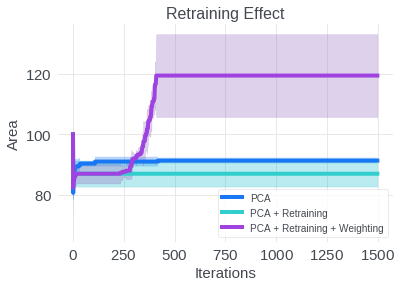

In [21]:
import matplotlib.pyplot as plt

iters = np.arange(N_BATCH)
best_observed_all_pca = np.array(best_observed_all_pca)
pca_mean = np.mean(best_observed_all_pca, axis=0)
pca_std = np.std(best_observed_all_pca, axis=0)
pca_upper = pca_mean + 1.96*pca_std
pca_lower = pca_mean - 1.96*pca_std

best_observed_all_rpca = np.array(best_observed_all_rpca)
rpca_mean = np.mean(best_observed_all_rpca, axis=0)
rpca_std = np.std(best_observed_all_rpca, axis=0)
rpca_upper = rpca_mean + 1.96*rpca_std
rpca_lower = rpca_mean - 1.96*rpca_std

best_observed_all_wpca = np.array(best_observed_all_wpca)
wpca_mean = np.mean(best_observed_all_wpca, axis=0)
wpca_std = np.std(best_observed_all_wpca, axis=0)
wpca_upper = wpca_mean + 1.96*wpca_std
wpca_lower = wpca_mean - 1.96*wpca_std

optimal = np.ones_like(pca_mean)*256

#plt.plot(iters, optimal, '.', label='Optimal Area')
plt.plot(iters, pca_mean, label='PCA')
plt.fill_between(iters, pca_lower, pca_upper, alpha=0.3)
plt.plot(iters, rpca_mean, label='PCA + Retraining')
plt.fill_between(iters, rpca_lower, rpca_upper, alpha=0.3, color='tab:cyan')
plt.plot(iters, wpca_mean, label='PCA + Retraining + Weighting')
plt.fill_between(iters, wpca_lower, wpca_upper, alpha=0.3, color='tab:purple')
plt.title('Retraining Effect', fontsize=16)
plt.xlabel('Iterations')
plt.ylabel('Area')
plt.legend()